In [1]:
from tqdm import tqdm
from pathlib import Path
import pickle
import os
import open3d as o3d # 0.14 has ray casting
import point_cloud_utils as pcu # !pip install pypcu
import csv
import numpy as np
import glob
import json
import matplotlib.pyplot as plt
from PIL import Image

def boxpts_to_o3dbox(box_pts):
    boxpts = o3d.utility.Vector3dVector(box_pts)
    o3dbox = o3d.geometry.OrientedBoundingBox().create_from_points(boxpts)
    o3dbox.color = np.array([1,0,0])
    return o3dbox

def cylindrical2cart(points):
    r, azimuth, z = points[:,0], points[:,1], points[:,2]
    x = r*np.cos(azimuth)
    y = r*np.sin(azimuth)
    return np.concatenate((x[:,np.newaxis],y[:,np.newaxis],z[:,np.newaxis]), axis=1)


def generate_ncoords_by_azimuth_bins(nbins=16, min_dist=5, max_dist=70, z_mu=0.8, z_sigma=0.3):
    azbin_size = 2*np.pi/nbins
    azbin_edges = [-np.pi+i*azbin_size for i in range(nbins+1)]

    cyl = []
    for i in range(nbins):
        rand_dist = np.random.uniform(min_dist,max_dist)
        az_bin = [azbin_edges[i], azbin_edges[i+1]]
        sampled_az = np.random.normal(np.mean(az_bin), azbin_size/4)
        cyl.append([rand_dist, sampled_az])

    z = np.random.normal(loc=z_mu, scale=z_sigma, size=[len(cyl)])
    return cylindrical2cart(np.hstack([np.array(cyl), z[...,np.newaxis]]))


def convert_to_o3dpcd(points, color=None):
    if type(points) == list:
        pcds = []
        for pointcloud in points:
            pcd = o3d.geometry.PointCloud()
            pcd.points = o3d.utility.Vector3dVector(pointcloud[:,:3])
            pcds.append(pcd)
        return pcds
    else:
        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(points[:,:3])
        if color:
            pcd.paint_uniform_color(color)
        return pcd

def get_scaling_factor(pts, min_car_width=1.55, max_car_width=2.15, min_car_height=0.8):
    bounds = get_minmax(pts)
    dims = get_lwh(bounds)    
    
    valid_scaling = False
    while(not valid_scaling):
        car_width = np.random.uniform(min_car_width, max_car_width)
        scaling_factor = car_width/dims[1]
        scaled_pts = scaling_factor * pts
        scaled_bounds = get_minmax(scaled_pts)
        scaled_dims = get_lwh(scaled_bounds)
        if scaled_dims[2] > min_car_height:
            valid_scaling = True
    
    return scaling_factor    
    
    
def get_minmax(pts):
    return {'max_x':max(pts[:,0]), 'min_x':min(pts[:,0]),
            'max_y':max(pts[:,1]), 'min_y':min(pts[:,1]),
            'max_z':max(pts[:,2]), 'min_z':min(pts[:,2])}

def get_lwh(minmax):
    l1 = minmax['max_x'] - minmax['min_x']
    l2 = minmax['max_y'] - minmax['min_y']
    return np.array([max(l1,l2),min(l1,l2), minmax['max_z'] - minmax['min_z']]) # l,w,h

def get_gt_for_zero_yaw(pts, openpcdet_format=False, o3d_format=False):
    bounds = get_minmax(pts)     
    dims = get_lwh(bounds)
    center = np.array([(bounds['max_x']+bounds['min_x'])/2, 
                       (bounds['max_y']+bounds['min_y'])/2, 
                       (bounds['max_z']+bounds['min_z'])/2])   

    # return 3d box points for o3d box construction
    bbox3d = np.array([
        [bounds['max_x'], bounds['max_y'], bounds['max_z']],
        [bounds['max_x'], bounds['min_y'], bounds['max_z']],
        [bounds['min_x'], bounds['max_y'], bounds['max_z']],
        [bounds['min_x'], bounds['min_y'], bounds['max_z']],
        [bounds['max_x'], bounds['max_y'], bounds['min_z']],
        [bounds['max_x'], bounds['min_y'], bounds['min_z']],
        [bounds['min_x'], bounds['max_y'], bounds['min_z']],
        [bounds['min_x'], bounds['min_y'], bounds['min_z']]
    ])
    if o3d_format:
        o3dvec_bbox = o3d.utility.Vector3dVector(bbox3d)
        o3dbox = o3d.geometry.OrientedBoundingBox().create_from_points(o3dvec_bbox)
        o3dbox.color = np.array([1,0,0])
        return {'bbox':o3dbox, 'center':center, 'dims':dims} 
    else:
        return {'bbox':bbox3d, 'center':center, 'dims':dims} 

def load_shapenet(obj_file, num_pts=16384):

    v,f,n = pcu.load_mesh_vfn(obj_file)
    
    # Shapenet forward is -z, here we change to +z to fit right hand rule convention (convention for most lidars)
    # Detection datasets define car length as x, width as y, and height as z. Forward is +x
    v[:,2] *= -1
    
    # Here we re-orient shapenet coordinate system of [z,x,y] to fit typical lidar convention of [x,y,z]
    v = v[:,[2,0,1]]     
    
    # dense random sampling
    fi, bc = pcu.sample_mesh_random(v, f, num_pts)
    pts = pcu.interpolate_barycentric_coords(f, fi, bc, v)
    
    # ShapeNet is centered but it's slightly off 0,0,0
    bounds = get_minmax(pts)
    center = np.array([(bounds['max_x']+bounds['min_x'])/2, 
                       (bounds['max_y']+bounds['min_y'])/2, 
                       (bounds['max_z']+bounds['min_z'])/2]) 
    obj = {}
    obj['model_id'] = obj_file.split('/')[-3]
    obj['sampled_pts'] = pts - center
    tmesh = o3d.geometry.TriangleMesh()
    tmesh.vertices = o3d.utility.Vector3dVector(v)
    tmesh.triangles = o3d.utility.Vector3iVector(f)
    obj['mesh'] = tmesh
    obj['dims'] = np.array([bounds['max_x']-bounds['min_x'],bounds['max_y']-bounds['min_y'],bounds['max_z']-bounds['min_z']])
    
    return obj

def gtbox_to_corners(box):
    """
    Takes an array containing [x,y,z,l,w,h,r], and returns an [8, 3] matrix that 
    represents the [x, y, z] for each 8 corners of the box.
    
    Note: Openpcdet __getitem__ gt_boxes are in the format [x,y,z,l,w,h,r,alpha]
    where alpha is "observation angle of object, ranging [-pi..pi]"
    """
    # To return
    corner_boxes = np.zeros((8, 3))

    translation = box[:3]
    l, w, h = box[3], box[4], box[5] # waymo, nusc, kitti is all l,w,h after OpenPCDet processing
    rotation = box[6]

    # Create a bounding box outline
    bounding_box = np.array([
        [-l/2, -l/2, l/2, l/2, -l/2, -l/2, l/2, l/2],
        [w/2, -w/2, -w/2, w/2, w/2, -w/2, -w/2, w/2],
        [-h/2, -h/2, -h/2, -h/2, h/2, h/2, h/2, h/2]])

    # Standard 3x3 rotation matrix around the Z axis
    rotation_matrix = np.array([
        [np.cos(rotation), -np.sin(rotation), 0.0],
        [np.sin(rotation), np.cos(rotation), 0.0],
        [0.0, 0.0, 1.0]])
    
    box_pts = bounding_box.T @ rotation_matrix + translation
    
    return box_pts

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [43]:
scales_list = []
for i, info in enumerate(infos):    
    
    vmask = info['annos']['name'] == 'Vehicle'    
    car_label = info['annos']['gt_boxes_lidar'][vmask]   
    if len(car_label) > 0:
        valid_carwidth = (car_label[:,4] > 1.5) & (car_label[:,4] < 3)
        valid_carlength = (car_label[:,3] > 2.4) & (car_label[:,3] < 7)
        valid_mask = valid_carwidth & valid_carlength
        car_label = car_label[valid_mask]
        scales_list.append(car_label)
        
scales = np.vstack(scales_list)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  after removing the cwd from sys.path.


In [2]:
import pickle

infos_path = '/SEE-MTDA/data/waymo/infos_openpcdetv0.3.0/waymo_infos_train.pkl'

with open(infos_path, 'rb') as f:
    infos = pickle.load(f)

In [44]:
waymo_lidar_height = 2.4
frames = {}

fnum = 0
for i, info in enumerate(infos):    
    
    vmask = info['annos']['name'] == 'Vehicle'    
    car_label = info['annos']['gt_boxes_lidar'][vmask]     
    
    if len(car_label) > 0:
        frames[fnum] = {}
        frames[fnum]['car'] = {}
        frames[fnum]['sign'] = {}
        
        # Waymo annotates forklifts etc as two parts, the arm and body. We ignore the arm.
        valid_carwidth = car_label[:,4] > 1.5
        car_label = car_label[valid_carwidth]
        
        car_label[:,2] -= waymo_lidar_height    
        frames[fnum]['car']['label'] = car_label
        frames[fnum]['car']['num_pts'] = info['annos']['num_points_in_gt'][vmask]
        frames[fnum]['car']['num_obj'] = len(car_label)
    
        smask = info['annos']['name'] == 'Sign'
        sign_label = info['annos']['gt_boxes_lidar'][smask]   

        if len(sign_label) > 0:            
            sign_label[:,2] -= waymo_lidar_height
            frames[fnum]['sign']['label'] = sign_label
            frames[fnum]['sign']['num_pts'] = info['annos']['num_points_in_gt'][smask]
            frames[fnum]['sign']['num_obj'] = len(sign_label)
        fnum += 1

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys


31


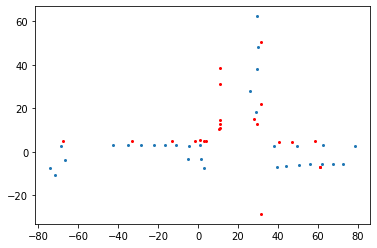

In [49]:
fnum = 396
print(frames[fnum]['car']['num_obj'])

plt.scatter(frames[fnum]['car']['label'][:,0], frames[fnum]['car']['label'][:,1], s=4)
plt.scatter(frames[fnum]['sign']['label'][:,0], frames[fnum]['sign']['label'][:,1], s=4, c='red')

In [48]:
fnum = 396
scene_boxes = [boxpts_to_o3dbox(gtbox_to_corners(frames[fnum]['car']['label'][i])) for i in range(len(frames[fnum]['car']['label']))]
o3d.visualization.draw_geometries(scene_boxes)

In [101]:
from pathlib import Path

def get_car_model(idx, model_filelist):
    if idx == -1:
        valid_model = False
        while(not valid_model):            
            model_idx = np.random.randint(0,len(model_filelist))
            obj_file = Path(data_dir) / model_id / 'models/model_normalized.obj'
            if obj_file.exists():
                return str(obj_file)
    else:
        obj_file = Path(model_filelist[idx] + '/models/model_normalized.obj')
        if not obj_file.exists():
            raise f"{str(obj_file)} does not exist"            
        else:
            return str(obj_file)
        
        
def get_random_car(model_filelist):
    """
    Returns a random model that is randomly scaled and rotated
    """
    obj_file = get_car_model(-1, model_filelist)
    
    obj = load_shapenet(obj_file)
    model_v = np.asarray(obj['mesh'].vertices)
    
    print(obj_file)
    alpha = get_scaling_factor(model_v)
    scaled_pts = alpha * model_v
    gtbox = get_gt_for_zero_yaw(scaled_pts)
    
    obj_data = {'bbox': gtbox['bbox'],
                'vertices': scaled_pts,
                'faces': obj['mesh'].triangles,
                'centre': gtbox['center'],
                'dims': gtbox['dims'],
                'model_id': obj_file.split('/')[-3]}
    return obj_data

car = get_random_car(models)

/SEE-MTDA/data/shapenet/ShapeNetCore.v2/02958343/7da7ba42dbd0a0f9be40bb45ea25a041/models/model_normalized.obj
scaled_dims = [4.52249196 1.84603086 1.32224429]


In [104]:
def get_tmesh_with_box_labels(box_label, model_filelist):
    car = get_random_car(model_filelist)
    centroid = box_label[:3]
    yaw = box_label[-1]
    rmat = np.array([[np.cos(yaw), np.sin(yaw), 0],
                      [-np.sin(yaw), np.cos(yaw), 0],
                      [0, 0, 1]])
    tmesh = o3d.geometry.TriangleMesh()
    tmesh.vertices = o3d.utility.Vector3dVector(car['vertices'] @ rmat.T + centroid)
    tmesh.triangles = o3d.utility.Vector3iVector(car['faces'])
    
    ret = {'bbox': car['bbox'] @ rmat.T + centroid, 
           'mesh': tmesh, 
           'model_id': car['model_id'],
           'label': list(centroid) + list(car['dims']) + list([yaw]),
           'waymo_num_pts': int(box_label[-1])} 
    return ret

scene_cars = [get_tmesh_with_box_labels(frames[fnum]['car']['label'][i], models) for i in range(len(frames[fnum]['car']['label']))]

/SEE-MTDA/data/shapenet/ShapeNetCore.v2/02958343/7da7ba42dbd0a0f9be40bb45ea25a041/models/model_normalized.obj
scaled_dims = [5.00783643 2.04414307 1.46414481]
/SEE-MTDA/data/shapenet/ShapeNetCore.v2/02958343/7da7ba42dbd0a0f9be40bb45ea25a041/models/model_normalized.obj
scaled_dims = [5.04802656 2.06054823 1.47589523]
/SEE-MTDA/data/shapenet/ShapeNetCore.v2/02958343/7da7ba42dbd0a0f9be40bb45ea25a041/models/model_normalized.obj
scaled_dims = [4.08468752 1.66732396 1.19424309]
/SEE-MTDA/data/shapenet/ShapeNetCore.v2/02958343/7da7ba42dbd0a0f9be40bb45ea25a041/models/model_normalized.obj
scaled_dims = [3.8653455  1.57779099 1.1301139 ]
/SEE-MTDA/data/shapenet/ShapeNetCore.v2/02958343/7da7ba42dbd0a0f9be40bb45ea25a041/models/model_normalized.obj
scaled_dims = [5.11799161 2.08910718 1.49635096]
/SEE-MTDA/data/shapenet/ShapeNetCore.v2/02958343/7da7ba42dbd0a0f9be40bb45ea25a041/models/model_normalized.obj
scaled_dims = [4.5344858  1.85092661 1.32575094]
/SEE-MTDA/data/shapenet/ShapeNetCore.v2/029583

In [ ]:
origin = o3d.geometry.TriangleMesh.create_coordinate_frame(size=1, origin=[0,0,0])
o3d.visualization.draw_geometries([sc['mesh'] for sc in scene_cars] + [origin])

In [63]:
def populate_scene(scene_cars, sign_labels, random_poles_pct=0.3):
    scene = o3d.t.geometry.RaycastingScene()
    
    num_rand_poles = int(len(scene_cars)*random_poles_pct)
    
    for i, sc in enumerate(scene_cars):
        tmesh = o3d.t.geometry.TriangleMesh.from_legacy(sc['mesh'])
        scene.add_triangles(tmesh)
        
        if i < num_rand_poles:
            # Obstacles that are close to the cars
            car_centre = sc['label'][:3]
            car_height = sc['label'][5]
            pole_radius = np.random.uniform(0.03,0.2)
            pole_height = np.random.uniform(1,4,1)

            box_min = np.min(sc['bbox'], axis=0)[:2]
            box_max = np.max(sc['bbox'], axis=0)[:2]
            xyall_choice = np.random.choice([1,2,3])
            if np.random.choice([True, False]):
                if xyall_choice == 1:                    
                    pole_xy = np.array([box_max[0], car_centre[1]]) + np.random.uniform(0,0.5)
                elif xyall_choice == 2: 
                    pole_xy = np.array([car_centre[0], box_max[1]]) + np.random.uniform(0,0.5)
                else:
                    pole_xy = box_max + np.random.uniform(0,1,2)
            else:
                pole_xy = box_min - np.random.uniform(0,1,2)        
            pole_centre = np.concatenate([pole_xy, np.array(car_centre[2] + pole_height/2 - car_height/2)])
            cylinder = o3d.geometry.TriangleMesh.create_cylinder(radius=pole_radius, height=pole_height.item()).translate(pole_centre)
            scene.add_triangles(o3d.t.geometry.TriangleMesh.from_legacy(cylinder))                
    
    # Add the waymo labelled signs as cylinders
    for i, sign in enumerate(sign_labels):
        pole_height = np.random.uniform(1,4,1)
        pole_centre = sign[:3]
        pole_centre[2] = -2.4 + pole_height/2
        pole_radius = np.random.uniform(0.03,0.1)        
        cylinder = o3d.geometry.TriangleMesh.create_cylinder(radius=pole_radius, height=pole_height).translate(pole_centre)
        scene.add_triangles(o3d.t.geometry.TriangleMesh.from_legacy(cylinder))                
                
    return scene

def cast_rays_at_point(scene, point, fov_deg=100, aspect_ratio=2, height_px=640):
    rays = o3d.t.geometry.RaycastingScene.create_rays_pinhole(
    fov_deg=fov_deg, # simulates a vertical fov of lidar
    center=point, # point where camera is looking at
    eye=[0,0,0], # position of the camera
    up=[0, 0, 1], # up vector
    width_px=aspect_ratio*height_px, # image width
    height_px=height_px, # image height
    )
    
    ans = scene.cast_rays(rays)
    hit = ans['t_hit'].isfinite()
    points = rays[hit][:,:3] + rays[hit][:,3:]*ans['t_hit'][hit].reshape((-1,1))
    return points.numpy()
    
    
def raycast_object(car, scene):
    centre = car['label'][:3]
    ray_pts = cast_rays_at_point(scene, centre)
    o3dbox = boxpts_to_o3dbox(car['bbox'])
    
    ret = {'ray_pts': convert_to_o3dpcd(ray_pts),
           'obj_pts': convert_to_o3dpcd(ray_pts).crop(o3dbox),
           'bbox': o3dbox}
    return ret

scene = populate_scene(scene_cars, frames[fnum]['sign']['label'])
res = raycast_object(scene_cars[0], scene)

In [64]:
origin = o3d.geometry.TriangleMesh.create_coordinate_frame(size=1, origin=[0,0,0])
o3d.visualization.draw_geometries([res['ray_pts'], res['bbox'], origin])

In [300]:
o3d.visualization.draw_geometries([res['obj_pts'], res['bbox'], origin])

In [180]:
sum([frames[i]['car']['num_obj'] for i in range(len(frames))])

4712401

# Export scenes

In [3]:
from pathlib import Path

def load_shapenet(obj_file, num_pts=16384):

    v,f,n = pcu.load_mesh_vfn(obj_file)
    
    # Shapenet forward is -z, here we change to +z to fit right hand rule convention (convention for most lidars)
    # Detection datasets define car length as x, width as y, and height as z. Forward is +x
    v[:,2] *= -1
    
    # Here we re-orient shapenet coordinate system of [z,x,y] to fit typical lidar convention of [x,y,z]
    v = v[:,[2,0,1]]     
    
    # dense random sampling
    fi, bc = pcu.sample_mesh_random(v, f, num_pts)
    pts = pcu.interpolate_barycentric_coords(f, fi, bc, v)
    
    # ShapeNet is centered but it's slightly off 0,0,0
    bounds = get_minmax(pts)
    center = np.array([(bounds['max_x']+bounds['min_x'])/2, 
                       (bounds['max_y']+bounds['min_y'])/2, 
                       (bounds['max_z']+bounds['min_z'])/2]) 
    obj = {}
    obj['model_id'] = obj_file.split('/')[-3]
    obj['sampled_pts'] = pts - center
    tmesh = o3d.geometry.TriangleMesh()
    tmesh.vertices = o3d.utility.Vector3dVector(v)
    tmesh.triangles = o3d.utility.Vector3iVector(f)
    obj['mesh'] = tmesh
    obj['dims'] = np.array([bounds['max_x']-bounds['min_x'],bounds['max_y']-bounds['min_y'],bounds['max_z']-bounds['min_z']])
    
    return obj

def get_scaling_factor(obj, min_car_width=1.55, max_car_width=2.15, min_car_height=0.6, model_id=None):
    dims = obj['dims']    
#     print(f'{model_id} - origdims = {dims}')
    valid_scaling = False
    while(not valid_scaling):
        car_width = np.random.uniform(min_car_width, max_car_width)
        scaling_factor = car_width/dims[1]
        scaled_pts = scaling_factor * np.asarray(obj['mesh'].vertices)
        scaled_bounds = get_minmax(scaled_pts)
        scaled_dims = get_lwh(scaled_bounds)
        if scaled_dims[2] > min_car_height:
            valid_scaling = True
    
    return scaling_factor    
    

def sample_car_model(data_dir, sampled_db, unseen_list):
    # Random sample. We pop unseen/seen after seeing all models once
    if len(unseen_list) > 0:
        db_idx = np.random.randint(0,len(unseen_list))
        model_id = unseen_list[db_idx]
        sampled_db.setdefault(model_id, 0)
        unseen_list.remove(model_id)
        
#         print(f'sampling db_idx: {db_idx}, model_id: {model_id} from {len(unseen_list)} models')
    else:
        # Get the least sampled model
        model_id = min(sampled_db, key=sampled_db.get)
#         print(f'sampling model_id: {model_id} with {sampled_db[model_id]} counts')
    
    sampled_db[model_id] += 1
    obj_file = Path(data_dir) / model_id / 'models/model_normalized.obj'    
    
    assert obj_file.exists(), f"{str(obj_file)} does not exist"    
    return str(obj_file)
        
        
def get_car_object(data_dir, sampled_db, unseen_list):
    """
    Returns a random model that is randomly scaled and rotated
    """
    obj_file = sample_car_model(data_dir, sampled_db, unseen_list)
    model_id = obj_file.split('/')[-3]

    obj = load_shapenet(obj_file)
    model_v = np.asarray(obj['mesh'].vertices)
    
    alpha = get_scaling_factor(obj, model_id=model_id)
    scaled_pts = alpha * model_v
    gtbox = get_gt_for_zero_yaw(scaled_pts)
    
    obj_data = {'bbox': gtbox['bbox'],
                'vertices': scaled_pts,
                'faces': obj['mesh'].triangles,
                'centre': gtbox['center'],
                'dims': gtbox['dims'],
                'model_id': model_id}
    return obj_data

def get_tmeshes_with_box_labels(frame_cars, data_dir, sampled_db, unseen_list):
    if 'label' not in frame_cars:
        return []
    
    scene_cars = []
    for box_label in frame_cars['label']:

        car = get_car_object(data_dir, sampled_db, unseen_list)
        centroid = box_label[:3]
        yaw = box_label[-1]
        rmat = np.array([[np.cos(yaw), np.sin(yaw), 0],
                          [-np.sin(yaw), np.cos(yaw), 0],
                          [0, 0, 1]])
        tmesh = o3d.geometry.TriangleMesh()
        tmesh.vertices = o3d.utility.Vector3dVector(car['vertices'] @ rmat.T + centroid)
        tmesh.triangles = o3d.utility.Vector3iVector(car['faces'])

        ret = {'bbox': car['bbox'] @ rmat.T + centroid, 
               'mesh': tmesh, 
               'model_id': car['model_id'],
               'label': list(centroid) + list(car['dims']) + list([yaw]),
               'waymo_num_pts': int(box_label[-1])} 
        scene_cars.append(ret)
    return scene_cars

In [4]:
def populate_scene(scene_cars, signs, random_poles_pct=0.3):
    scene = o3d.t.geometry.RaycastingScene()
    
    num_rand_poles = int(len(scene_cars)*random_poles_pct)
    
    for i, sc in enumerate(scene_cars):
        tmesh = o3d.t.geometry.TriangleMesh.from_legacy(sc['mesh'])
        scene.add_triangles(tmesh)
        
        if i < num_rand_poles:
            # Obstacles that are close to the cars
            car_centre = sc['label'][:3]
            car_height = sc['label'][5]
            pole_radius = np.random.uniform(0.03,0.2)
            pole_height = np.random.uniform(1,4,1)

            box_min = np.min(sc['bbox'], axis=0)[:2]
            box_max = np.max(sc['bbox'], axis=0)[:2]
            xyall_choice = np.random.choice([1,2,3])
            if np.random.choice([True, False]):
                if xyall_choice == 1:                    
                    pole_xy = np.array([box_max[0], car_centre[1]]) + np.random.uniform(0,0.5)
                elif xyall_choice == 2:
                    pole_xy = np.array([car_centre[0], box_max[1]]) + np.random.uniform(0,0.5)
                else:
                    pole_xy = box_max + np.random.uniform(0,1,2)
            else:
                pole_xy = box_min - np.random.uniform(0,1,2)        
            pole_centre = np.concatenate([pole_xy, np.array(car_centre[2] + pole_height/2 - car_height/2)])
            cylinder = o3d.geometry.TriangleMesh.create_cylinder(radius=pole_radius, height=pole_height.item()).translate(pole_centre)
            scene.add_triangles(o3d.t.geometry.TriangleMesh.from_legacy(cylinder))                
    
    # Add the waymo labelled signs as cylinders
    if 'label' in signs:
        sign_labels = signs['label']
        for i, sign in enumerate(sign_labels):
            pole_height = np.random.uniform(1,4,1)
            pole_centre = sign[:3]
            pole_centre[2] = -2.4 + pole_height/2
            pole_radius = np.random.uniform(0.03,0.1)        
            cylinder = o3d.geometry.TriangleMesh.create_cylinder(radius=pole_radius, height=pole_height).translate(pole_centre)
            scene.add_triangles(o3d.t.geometry.TriangleMesh.from_legacy(cylinder))                
                
    return scene

def cast_rays_at_point(scene, point, fov_deg=100, aspect_ratio=2, height_px=640):
    rays = o3d.t.geometry.RaycastingScene.create_rays_pinhole(
    fov_deg=fov_deg, # simulates a vertical fov of lidar
    center=point, # point where camera is looking at
    eye=[0,0,0], # position of the camera
    up=[0, 0, 1], # up vector
    width_px=aspect_ratio*height_px, # image width
    height_px=height_px, # image height
    )
    
    ans = scene.cast_rays(rays)
    hit = ans['t_hit'].isfinite()
    points = rays[hit][:,:3] + rays[hit][:,3:]*ans['t_hit'][hit].reshape((-1,1))
    return points.numpy()
    
    
def raycast_object(car, scene, npoints):
    centre = car['label'][:3]    
    
    fov_deg = np.random.normal(120, 30)
    ray_pts = cast_rays_at_point(scene, centre, fov_deg=fov_deg, aspect_ratio=2, height_px=640)
    o3dbox = boxpts_to_o3dbox(car['bbox'])
    
    ret = {'ray_pts': convert_to_o3dpcd(ray_pts),
           'obj_pts': convert_to_o3dpcd(ray_pts).crop(o3dbox),
           'complete': car['mesh'].sample_points_uniformly(npoints),
           'bbox_pts': car['bbox'],
           'model_id': car['model_id'],
           'label': car['label'],
           'fov_deg':fov_deg}
    return ret

In [5]:
waymo_lidar_height = 2.4
frames = []

infos_path = '/SEE-MTDA/data/waymo/infos_openpcdetv0.3.0/waymo_infos_train.pkl'

with open(infos_path, 'rb') as f:
    infos = pickle.load(f)

for i, info in enumerate(infos):    
    
    vmask = info['annos']['name'] == 'Vehicle'    
    car_label = info['annos']['gt_boxes_lidar'][vmask]     
    
    if len(car_label) > 0:
        frame = {}
        frame['car'] = {}
        frame['sign'] = {}
        
        # Waymo annotates forklifts etc as two parts, the arm and body. We ignore the arm.
        valid_carwidth = car_label[:,4] > 1.5
        car_label = car_label[valid_carwidth]
        
        car_label[:,2] -= waymo_lidar_height    
        frame['car']['label'] = car_label
        frame['car']['num_pts'] = info['annos']['num_points_in_gt'][vmask]
        frame['car']['num_obj'] = len(car_label)
    
        smask = info['annos']['name'] == 'Sign'
        sign_label = info['annos']['gt_boxes_lidar'][smask]   

        if len(sign_label) > 0:            
            sign_label[:,2] -= waymo_lidar_height
            frame['sign']['label'] = sign_label
            frame['sign']['num_pts'] = info['annos']['num_points_in_gt'][smask]
            frame['sign']['num_obj'] = len(sign_label)
        frames.append(frame)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  # This is added back by InteractiveShellApp.init_path()


In [6]:
import pickle
import random

# Specifically for Shapenet.v2
ignore = {}
ignore['non_car'] = ['d353bf0e0dfe3ac29cbc1c09129e1507','c0db588c8c816cd2dc668d3d64c871ae']
ignore['unclean_car'] = ['a75ff576da012340468bac13e007a6e9','52c589e86fd500cd4a42886683bb52d2','65d6433043c40046b82c0841410a924f','e09813b03bdfce83a23218adb697420d','d1acd4916d3d3b57c48db2ed8f5e994c','39b307361b650db073a425eed3ac7a0b']
ignore['truck_bus'] = ['6aa8f648cc8df63ab2c17ece4015d55','84bc3155bc5c95bfaaafd94b9f216ef6','fd3b75f7f1e9172fb6f657757c95f74e','21999849a6a8aad752470de2774d6099','dfa6c32dec07727ee9d8921ebe6d5b8e','26b7a9c6c7e74829eabc798aaf5f039f']
ignore['limo'] = ['c9b49f7b355528e5632dc979097a3ec0','b11c0c16e0eed1f4b8671dc42cc45273','eefce52130d223ba2dcbf88f7c685079','db432e9f280ffb1e3dd4bdc1dbab98bd','dd0817b9757b74c75d3a87a5c4dd9ce4','e4b1de221f2d66352638397725e10cf9','9d2b7938d426633b28044fe9244db50a','41d317b520eec9d38d3d01fa03326bb0','5a5b0e1cbb38bdb12d08a76380360b3b','bc9c588a00ae179fa2645d665a7d8fa','ed91b2509171fdc1c48492b454f1615a','17c32e15723ed6e0cd0bf4a0e76b8df5','9fa56c19e4d54cca99c8d14f483ffc82','2f1001870f90e06bc48492b454f1615a','4c53afe560e36d8380ba2a9340bf2d77','e0978173fcfc5203510556e7c3123591','fb8adbcf67d858fc28044fe9244db50a','9dee0ea5da388102e6d91d458fe44a15','7c7e5b4fa56d8ed654b40bc735c6fdf6','7f6031f1738d52546436916a86a90ed7','cc0c058e2eca523051fb05589f6b0d0e','9676e8250cdd90307d5394224a6aa067','282293948b21262769416db9b743e50b','202fbaeffaf49f4b61c6c61410fc904b','b4d258dc5a12f9f7ade7f700b19bcf4a','f1b97d671bb93ad928044fe9244db50a','9d77d4c959974035fab60fc805223a73','5c3fe4057ef12b6886ac29addefc0f11','56dc27e4374cf87132eaaf3b7c9989f6']
ignore['invalid_lwratio'] = ['7e7f0637d6798113ddb4014f0e8d0dac', '492a339ce5da3fe8e4b68d3b17c43658', '99fce87e4e80e053374462542bf2aa29', 'f7f7b1b4021be11afaeea7738551d104', 'bfa01c632be2eb06e8a3b392b986583', '7c85e6cf9c4f46e91cc13e432d5756b8', '6b79cfceb6f614527e7afb83f93db294', '52c589e86fd500cd4a42886683bb52d2', 'd1acd4916d3d3b57c48db2ed8f5e994c', '65d6433043c40046b82c0841410a924f', 'f4498022df553505c35f22936e5aea5c', '3c310afdf363201cefe5f291bc2f5fd0', 'c0db588c8c816cd2dc668d3d64c871ae', 'd353bf0e0dfe3ac29cbc1c09129e1507', '9f7b4a82becac9cd5568b8cbf53329df', 'e4d1edc4cda4a6445fb81d6394b59c19']
ignore['invalid_objfile'] = ['93ce8e230939dfc230714334794526d4', '9fb1d03b22ecac5835da01f298003d56', '302612708e86efea62d2c237bfbc22ca', '806d740ca8fad5c1473f10e6caaeca56', '2307b51ca7e4a03d30714334794526d4', 'd6ee8e0a0b392f98eb96598da750ef34', 'e6c22be1a39c9b62fb403c87929e1167', '986ed07c18a2e5592a9eb0f146e94477', '407f2811c0fe4e9361c6c61410fc904b', '5bf2d7c2167755a72a9eb0f146e94477', '3ffeec4abd78c945c7c79bdb1d5fe365', 'f5bac2b133a979c573397a92d1662ba5', '3c33f9f8edc558ce77aa0b62eed1492', 'ea3f2971f1c125076c4384c3b17a86ea', '7aa9619e89baaec6d9b8dfa78596b717', '5973afc979049405f63ee8a34069b7c5', '4ddef66f32e1902d3448fdcb67fe08ff', '207e69af994efa9330714334794526d4', '8070747805908ae62a9eb0f146e94477']
ignore['combined'] = [idx for k,v in ignore.items() for idx in v]

In [7]:
# We don't include trucks, buses or limos for this project
data_dir = '/SEE-MTDA/data/shapenet/ShapeNetCore.v2/02958343'
model_glob = glob.glob(f'{data_dir}/*')
models = set([model.split('/')[-1] for model in model_glob])
ignore_combined = set(ignore['combined'])
models.difference_update(ignore_combined)
models = list(models)

In [8]:
def generate_dataset(data_dir, frames, models, dataset_name):
    min_pts = 50
    max_pts = 6000
    nviews = 30
    npoints_complete = 16384

    save_dir = Path(f'/SEE-MTDA/data/shapenet/VC/WAYMO_t-{len(models)}_nviews-{nviews}/{dataset_name}')
    save_dir.mkdir(exist_ok=True, parents=True)
    total_exported = nviews * len(models)
    currently_exported = 0
    
    sampled_db = {}
    exported_db = {}
    unseen_list = models

    # Shuffle frames because there's 199 frames in one scene
    random.shuffle(frames)
    for fnum, frame in tqdm(enumerate(frames), total=len(frames)):

        scene_cars = get_tmeshes_with_box_labels(frame['car'], data_dir, sampled_db, unseen_list)
        scene = populate_scene(scene_cars, frame['sign'])

        # Export each car in the scene and update sampling_db
        for car in scene_cars:
            data = raycast_object(car, scene, npoints_complete)
            model_id = data['model_id']            

            print(f"\n{len(data['obj_pts'].points)} pts - fov_deg: {data['fov_deg']}")
#             print(f'model_id: {model_id} => counts {sampled_db[model_id]}')                
            
            if len(data['obj_pts'].points) > min_pts and len(data['obj_pts'].points) < max_pts:                
                exported_db.setdefault(model_id, 0)
                car_id = exported_db[model_id]

                if car_id >= nviews:
                    continue                
                    
                # Save object
                # Save partial, complete, labels
                partial_dir = save_dir / 'partial' / model_id
                partial_dir.mkdir(exist_ok=True, parents=True)

                complete_dir = save_dir / 'complete' / model_id
                complete_dir.mkdir(exist_ok=True, parents=True)

                label_dir = save_dir / 'label' / model_id
                label_dir.mkdir(exist_ok=True, parents=True)

                o3d.io.write_point_cloud(str(partial_dir / f'{car_id:03d}.pcd'), data['obj_pts'])
                o3d.io.write_point_cloud(str(complete_dir / f'{car_id:03d}.pcd'), data['complete'])
                with open(str(label_dir / f'{car_id:03d}.pkl'), 'wb') as f:
                    label = {'bbox_pts': data['bbox_pts'], 
                             'gtbox': data['label'],
                             'pc_id': f'{model_id}_{car_id:03d}',
                             'raycasting': data['fov_deg']}
                    pickle.dump(label, f)

                currently_exported += 1
                exported_db[model_id] += 1
                
#                 print(f'model_id: {model_id} => num exported {exported_db[model_id]}')                
                print(f'{currently_exported}/{total_exported} objects exported')
                
                if currently_exported >= total_exported:
                    print(f'{currently_exported} objects exported')
                    return
            else:
                counts = sampled_db[model_id]
                sampled_db[model_id] = max(counts - 1, 0)
                if sampled_db[model_id] == 0:
                    print(f'adding {model_id} back to unseen')
                    unseen_list.append(model_id)
                    
#                 print(f'model_id: {model_id} => counts {sampled_db[model_id]}')                
            

# generate_dataset(data_dir, frames, models[:2768], dataset_name='train')

In [9]:
generate_dataset(data_dir, frames, models[2768:3044], dataset_name='val')

  0%|                                                    | 0/156337 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/point_cloud_utils/_mesh_io.py:265: RuntimeWarning: Noncritical error (9) during loading model_normalized.obj: 'Identical vertex indices found in the same faces -- faces ignored'
  mesh_dict = load_mesh_internal(mesh_filename, dtype)



1010 pts - fov_deg: 123.88337855540726
1/8280 objects exported

866 pts - fov_deg: 99.35126995947361
2/8280 objects exported

1703 pts - fov_deg: 122.60462886202468
3/8280 objects exported

356 pts - fov_deg: 125.45316072708711
4/8280 objects exported

944 pts - fov_deg: 86.2532011198059
5/8280 objects exported

154 pts - fov_deg: 110.9057675240781
6/8280 objects exported

1438 pts - fov_deg: 102.94617561889413
7/8280 objects exported


  0%|                                        | 1/156337 [00:04<192:27:28,  4.43s/it]


7898 pts - fov_deg: 88.78527295053601
adding 40f2f3962e360a3c16abce8cb03e7794 back to unseen

365 pts - fov_deg: 129.74872458966058
8/8280 objects exported

1227 pts - fov_deg: 86.6995420896583
9/8280 objects exported

2490 pts - fov_deg: 133.6006882683907
10/8280 objects exported

74 pts - fov_deg: 126.33766625526121
11/8280 objects exported

41 pts - fov_deg: 147.7761946002549
adding a26b62fa78e9d6e016abce8cb03e7794 back to unseen

27 pts - fov_deg: 150.1637848150428
adding fe61764c0552c837d76439fb95cdd2ed back to unseen

42 pts - fov_deg: 135.35624377518985
adding 2f503625718536ad5d9d397842621b7 back to unseen

341 pts - fov_deg: 120.62106501077912
12/8280 objects exported

213 pts - fov_deg: 87.76020390770407
13/8280 objects exported

154 pts - fov_deg: 80.50932483928675
14/8280 objects exported

8 pts - fov_deg: 135.06056002998304
adding 78c3bf6ae1bdf75419b43924bf120208 back to unseen

19 pts - fov_deg: 158.9284519278434
adding be348430ab5fa5cfb1bb46d2556ba67d back to unseen

100

  0%|                                        | 2/156337 [00:32<502:10:56, 11.56s/it]


1111 pts - fov_deg: 126.41117402820987
33/8280 objects exported

52 pts - fov_deg: 141.87735739315372
34/8280 objects exported

2 pts - fov_deg: 163.92309355292562
adding b963de806d271377935310097e7751 back to unseen

2048 pts - fov_deg: 95.8117566844781
35/8280 objects exported

37 pts - fov_deg: 146.66080885368822
adding 18244d93dbd2afbebda733a39f84326d back to unseen

64 pts - fov_deg: 130.06616359429614
36/8280 objects exported

96 pts - fov_deg: 120.28601440419729
37/8280 objects exported

69 pts - fov_deg: 128.3070460148079
38/8280 objects exported

566 pts - fov_deg: 155.99065741731334
39/8280 objects exported

215 pts - fov_deg: 98.45714188768339
40/8280 objects exported

3 pts - fov_deg: 170.27178763479154
adding e2ceb9bf23b498dda7431386d9d22644 back to unseen

727 pts - fov_deg: 113.99395330207422
41/8280 objects exported

2 pts - fov_deg: 88.48481033395605
adding 83c21f0f383524e9bdd7ac383509f04c back to unseen

52 pts - fov_deg: 128.68305715585657
42/8280 objects exported



  0%|                                        | 3/156337 [00:45<521:35:28, 12.01s/it]


973 pts - fov_deg: 126.54917090294715
49/8280 objects exported

98 pts - fov_deg: 142.57111285648588
50/8280 objects exported

66 pts - fov_deg: 137.28676142399067
51/8280 objects exported

56 pts - fov_deg: 137.21848695004564
52/8280 objects exported

31 pts - fov_deg: 171.19074801318934
adding 63cc90709837d314a0b2db16370345f0 back to unseen

1913 pts - fov_deg: 107.2293970135441
53/8280 objects exported

32 pts - fov_deg: 118.13601689464204
adding 792a93f2b8dcfe7116abce8cb03e7794 back to unseen

118 pts - fov_deg: 114.55860332355766
54/8280 objects exported

105 pts - fov_deg: 97.72121087848109
55/8280 objects exported

48 pts - fov_deg: 163.1001447500936
adding a56dca5eab44489ca7fd25564c2e888e back to unseen

15059 pts - fov_deg: 82.28873889082782
adding fc521be0cb604c1aee4687e8f2543e back to unseen

28 pts - fov_deg: 146.3582157356018
adding 40f2f3962e360a3c16abce8cb03e7794 back to unseen

4453 pts - fov_deg: 116.81302846344137
56/8280 objects exported

34 pts - fov_deg: 150.82481

  0%|                                        | 4/156337 [00:55<492:15:59, 11.34s/it]


127 pts - fov_deg: 74.69103692229459
58/8280 objects exported

263 pts - fov_deg: 116.67152785795665
59/8280 objects exported

105 pts - fov_deg: 109.9252509733164
60/8280 objects exported

240 pts - fov_deg: 105.391957962255
61/8280 objects exported

53 pts - fov_deg: 116.49513999364245
62/8280 objects exported

341 pts - fov_deg: 121.2301079794512
63/8280 objects exported

95 pts - fov_deg: 126.31573113069778
64/8280 objects exported

22557 pts - fov_deg: 88.85260228761067
adding 30f96aa701d4e088becf71e2e014ff6f back to unseen

997 pts - fov_deg: 133.10818705504792
65/8280 objects exported

231 pts - fov_deg: 122.51032471764094
66/8280 objects exported

3192 pts - fov_deg: 77.82391879211566
67/8280 objects exported

701 pts - fov_deg: 87.67633064917308
68/8280 objects exported

5 pts - fov_deg: 154.62185804239624
adding 6f3887b3b8253284de541e973ae662b5 back to unseen

94 pts - fov_deg: 156.56277646663028
69/8280 objects exported

140772 pts - fov_deg: 113.11785106844974
adding ca852

  0%|                                        | 5/156337 [01:32<830:17:29, 19.12s/it]


2325 pts - fov_deg: 75.92743228628919
91/8280 objects exported

230 pts - fov_deg: 84.49648549007613
92/8280 objects exported

106 pts - fov_deg: 99.20258747554897
93/8280 objects exported

16 pts - fov_deg: 137.03502268941682
adding 6e5340cfe979238998ff545c3abe3e44 back to unseen

0 pts - fov_deg: 141.2332800695815
adding 33e897abe9e7df46a9aa61915b4add2d back to unseen

1972 pts - fov_deg: 115.16888645075457
94/8280 objects exported

589 pts - fov_deg: 75.95050402257687
95/8280 objects exported

423 pts - fov_deg: 64.15613639072203
96/8280 objects exported

3401 pts - fov_deg: 91.16195315584287
97/8280 objects exported

8 pts - fov_deg: 155.52224488069587
adding f7cca46c4c8efdc6fa5eb13ccb8cd2c6 back to unseen

604 pts - fov_deg: 105.57211507479103
98/8280 objects exported

76 pts - fov_deg: 105.60494989998735
99/8280 objects exported

0 pts - fov_deg: 171.87911048159356
adding 504e8dbdccd8beea7e488037e176d2f0 back to unseen

55 pts - fov_deg: 139.36875125192563
100/8280 objects expor

  0%|                                        | 6/156337 [01:59<926:04:07, 21.33s/it]


230 pts - fov_deg: 102.27688006164081
118/8280 objects exported

19406 pts - fov_deg: 119.6934733748932
adding bf1893badd1c6bef59a47b1880958de9 back to unseen

137 pts - fov_deg: 99.50144068222255
119/8280 objects exported

35 pts - fov_deg: 128.50968330946097
adding 3cd83324de4a2fecbecf71e2e014ff6f back to unseen

14 pts - fov_deg: 158.4643904030589
adding 2650ad9e7a1d0ebf6df8cb2765f8ec95 back to unseen

3628 pts - fov_deg: 84.18873771323646
120/8280 objects exported

140 pts - fov_deg: 137.5767741758827
121/8280 objects exported

240 pts - fov_deg: 89.87916398366248
122/8280 objects exported

17 pts - fov_deg: 130.65584391135457
adding 7015c7c8ee74f69313ded1857c15b5b6 back to unseen

606 pts - fov_deg: 62.020912232151545
123/8280 objects exported

1723 pts - fov_deg: 100.25723410830211
124/8280 objects exported

1040 pts - fov_deg: 95.88151127580724
125/8280 objects exported

529 pts - fov_deg: 136.23974579190627
126/8280 objects exported

182 pts - fov_deg: 102.97030445935542
127/8

  0%|                                        | 7/156337 [02:16<878:23:37, 20.23s/it]


288 pts - fov_deg: 117.06947506554357
135/8280 objects exported

1 pts - fov_deg: 120.35134692985596
adding 33e897abe9e7df46a9aa61915b4add2d back to unseen

17 pts - fov_deg: 142.53173501390776
adding 4fd5c18c1536d65be129fc90649e41d3 back to unseen

201 pts - fov_deg: 98.38266143621502
136/8280 objects exported

202 pts - fov_deg: 100.52007687824673
137/8280 objects exported

455 pts - fov_deg: 142.40203770309486
138/8280 objects exported

27 pts - fov_deg: 157.88972630667942
adding 2650ad9e7a1d0ebf6df8cb2765f8ec95 back to unseen

0 pts - fov_deg: 179.42321881762538
adding 40f2f3962e360a3c16abce8cb03e7794 back to unseen

1697 pts - fov_deg: 93.82812604773433
139/8280 objects exported

276 pts - fov_deg: 136.10706078650026
140/8280 objects exported

982 pts - fov_deg: 113.5717717163926
141/8280 objects exported

405 pts - fov_deg: 62.07879732064329
142/8280 objects exported

18 pts - fov_deg: 139.6626114890051
adding 879121a1bb623324eb79f1a2fb4e869b back to unseen

43 pts - fov_deg: 15

  0%|                                       | 8/156337 [03:01<1200:33:14, 27.65s/it]


7903 pts - fov_deg: 53.0058530792853
adding da73c98813b82014d94cee2a22cdfdd2 back to unseen

651 pts - fov_deg: 75.32271706545873
171/8280 objects exported

79 pts - fov_deg: 157.85504100220305
172/8280 objects exported

122 pts - fov_deg: 139.92883030887083
173/8280 objects exported

50 pts - fov_deg: 128.56629535833494
adding 62032b070c02c6b1570673441ebdaf2b back to unseen

19700 pts - fov_deg: 71.48223222054324
adding 9609eee1c5f60dcd610425baad975046 back to unseen

61755 pts - fov_deg: 76.1597009373118
adding 8922c6c3435f16fee694960c91796f38 back to unseen

826 pts - fov_deg: 125.47750526328845
174/8280 objects exported

1056 pts - fov_deg: 93.26490130516532
175/8280 objects exported

4 pts - fov_deg: 152.67954317094166
adding 2228a428bfa91e4f771592b49641a847 back to unseen

1080 pts - fov_deg: 93.13000302293511
176/8280 objects exported

108 pts - fov_deg: 90.9306390098342
177/8280 objects exported

15514 pts - fov_deg: 125.85614712046241
adding 78c3bf6ae1bdf75419b43924bf120208 b

  0%|                                       | 9/156337 [03:33<1253:12:52, 28.86s/it]


1238 pts - fov_deg: 85.80558619501006
199/8280 objects exported

6 pts - fov_deg: 97.49745949656554
adding 12d463649ed6c176ab98a7077c964a60 back to unseen

9736 pts - fov_deg: 128.4125655741071
adding 65c225fae513a6dbe7b23463fd9b0ba1 back to unseen

22 pts - fov_deg: 142.738917825435
adding 1a0bc9ab92c915167ae33d942430658c back to unseen

48045 pts - fov_deg: 94.08143954269421
adding c61ec8875746ab78227375499b768057 back to unseen

24 pts - fov_deg: 153.0611454954516
adding 186646b16a670b7d69a949ac99a843c4 back to unseen

5328 pts - fov_deg: 102.46515508249536
200/8280 objects exported

66 pts - fov_deg: 122.39765784801129
201/8280 objects exported

19 pts - fov_deg: 131.49803158217355
adding 879121a1bb623324eb79f1a2fb4e869b back to unseen

579 pts - fov_deg: 118.47597976069468
202/8280 objects exported

12412 pts - fov_deg: 117.41917619117152
adding 78c3bf6ae1bdf75419b43924bf120208 back to unseen

433 pts - fov_deg: 139.13335949655877
203/8280 objects exported

351 pts - fov_deg: 94.

  0%|                                      | 10/156337 [03:43<1013:03:09, 23.33s/it]


868 pts - fov_deg: 134.94073936469613
207/8280 objects exported

863 pts - fov_deg: 156.12979350776632
208/8280 objects exported

24 pts - fov_deg: 144.04469973258955
adding 6e5340cfe979238998ff545c3abe3e44 back to unseen

5095 pts - fov_deg: 86.9802846022252
209/8280 objects exported

2168 pts - fov_deg: 61.21152309829316
210/8280 objects exported

19 pts - fov_deg: 134.0443537420991
adding 186646b16a670b7d69a949ac99a843c4 back to unseen

325 pts - fov_deg: 71.39345046998541
211/8280 objects exported

41 pts - fov_deg: 135.83598138122463
adding 1eb3cb637ccffd14597505fd7d99b613 back to unseen

0 pts - fov_deg: 99.65967921175985
adding f10e32c6daaf237f13ded1857c15b5b6 back to unseen

386 pts - fov_deg: 146.2957665987997
212/8280 objects exported

0 pts - fov_deg: 179.21857992590617
adding 2076be423fa5bb9f9e908ecb03b3d6fb back to unseen

8 pts - fov_deg: 154.04709421869606
adding ccdd144f89a78f5c554ecfc23d9fc570 back to unseen

608 pts - fov_deg: 86.24270582337104
213/8280 objects expor

  0%|                                      | 11/156337 [04:08<1027:18:28, 23.66s/it]


842 pts - fov_deg: 106.02522979930356
232/8280 objects exported

335 pts - fov_deg: 96.08780845023438
233/8280 objects exported

74 pts - fov_deg: 114.80368207918221
234/8280 objects exported

867 pts - fov_deg: 84.85561779267988
235/8280 objects exported

96 pts - fov_deg: 123.65775590340166
236/8280 objects exported

533 pts - fov_deg: 128.7614197598698
237/8280 objects exported

477 pts - fov_deg: 103.22374125075608
238/8280 objects exported

2241 pts - fov_deg: 52.8200671240014
239/8280 objects exported

3172 pts - fov_deg: 110.25978327964403
240/8280 objects exported

139 pts - fov_deg: 125.67958865221516
241/8280 objects exported

8 pts - fov_deg: 122.74070478009835
adding b7707e9f69d6c0ec6c23793d085f1519 back to unseen

168 pts - fov_deg: 103.03694898809118
242/8280 objects exported

619 pts - fov_deg: 112.12458702478258
243/8280 objects exported

146 pts - fov_deg: 117.63834161165565
244/8280 objects exported

129 pts - fov_deg: 90.21780483080121
245/8280 objects exported

9 p

  0%|                                      | 12/156337 [04:38<1109:04:19, 25.54s/it]


3799 pts - fov_deg: 109.1504911989792
264/8280 objects exported

53 pts - fov_deg: 134.85835409620054
265/8280 objects exported

373 pts - fov_deg: 115.55825875749856
266/8280 objects exported

78 pts - fov_deg: 152.12205560511876
267/8280 objects exported

18 pts - fov_deg: 191.69752809039244
adding ccdd144f89a78f5c554ecfc23d9fc570 back to unseen

34 pts - fov_deg: 147.17293199641378
adding a015b428cf628af3522dcdfaad316d22 back to unseen

211 pts - fov_deg: 137.16991629262552
268/8280 objects exported

26073 pts - fov_deg: 78.58086038565612
adding 1eb3cb637ccffd14597505fd7d99b613 back to unseen

1241 pts - fov_deg: 67.67646768136593
269/8280 objects exported

197 pts - fov_deg: 129.36321188331848
270/8280 objects exported

588 pts - fov_deg: 146.4251027252479
271/8280 objects exported

11494 pts - fov_deg: 124.78511401653058
adding b0fa729f031a97d2c3c561b608f78503 back to unseen

1999 pts - fov_deg: 115.65393303435022
272/8280 objects exported

20 pts - fov_deg: 127.38729155518374
ad

  0%|                                      | 13/156337 [04:57<1023:41:43, 23.57s/it]


117 pts - fov_deg: 102.65167985178896
288/8280 objects exported

264 pts - fov_deg: 128.20567688763734
289/8280 objects exported

309 pts - fov_deg: 105.67371734465868
290/8280 objects exported

17 pts - fov_deg: 151.85708882795328
adding ccdd144f89a78f5c554ecfc23d9fc570 back to unseen

257 pts - fov_deg: 98.2346069459611
291/8280 objects exported

1 pts - fov_deg: 163.84200677676372
adding b0fa729f031a97d2c3c561b608f78503 back to unseen

102 pts - fov_deg: 100.63691344306906
292/8280 objects exported

12071 pts - fov_deg: 47.145918466144224

15 pts - fov_deg: 139.7498432291861

0 pts - fov_deg: 171.99411857334798

34 pts - fov_deg: 156.03247577945294

417 pts - fov_deg: 65.36719558843558
293/8280 objects exported

29 pts - fov_deg: 151.14543974493083

542 pts - fov_deg: 130.3243757855368
294/8280 objects exported

62723 pts - fov_deg: 115.89004506533065

165 pts - fov_deg: 153.31423626714644
295/8280 objects exported

12 pts - fov_deg: 136.70651787079058

668 pts - fov_deg: 124.56660

  0%|                                      | 14/156337 [05:40<1284:16:28, 29.58s/it]


92 pts - fov_deg: 157.93848929412846
331/8280 objects exported

49 pts - fov_deg: 123.33485249494545
adding ccdd144f89a78f5c554ecfc23d9fc570 back to unseen

137 pts - fov_deg: 122.06063519177388
332/8280 objects exported

316 pts - fov_deg: 90.36337479208709
333/8280 objects exported

38 pts - fov_deg: 164.8822847502969

1537 pts - fov_deg: 82.06349435193688
334/8280 objects exported

6885 pts - fov_deg: 95.69729373609212

79 pts - fov_deg: 109.87027547583176
335/8280 objects exported

1088 pts - fov_deg: 121.03768789091818
336/8280 objects exported

306 pts - fov_deg: 133.36091045632867
337/8280 objects exported

20 pts - fov_deg: 122.237244108758

62 pts - fov_deg: 131.62818620255882
338/8280 objects exported

710 pts - fov_deg: 199.4667759322598
339/8280 objects exported

287 pts - fov_deg: 81.01240512716164
340/8280 objects exported

1 pts - fov_deg: 176.35729785372672

455 pts - fov_deg: 109.15584782050684
341/8280 objects exported

67 pts - fov_deg: 89.34535336944873
342/8280 ob

  0%|                                      | 15/156337 [06:00<1150:17:20, 26.49s/it]


828 pts - fov_deg: 83.64855256430594
355/8280 objects exported

47 pts - fov_deg: 120.50461415416623

0 pts - fov_deg: 177.27648339615013

421 pts - fov_deg: 90.05466180368056
356/8280 objects exported

55 pts - fov_deg: 108.21763397773762
357/8280 objects exported

2461 pts - fov_deg: 122.6310378041608
358/8280 objects exported

6 pts - fov_deg: 132.44400046091357

263 pts - fov_deg: 151.7207098576063
359/8280 objects exported

523 pts - fov_deg: 104.83916477709157
360/8280 objects exported

2242 pts - fov_deg: 74.21741346693256
361/8280 objects exported

2626 pts - fov_deg: 140.51980784585288
362/8280 objects exported

62 pts - fov_deg: 157.81606250543933
363/8280 objects exported

269 pts - fov_deg: 138.5091955608336
364/8280 objects exported

19 pts - fov_deg: 152.99830466091032

90 pts - fov_deg: 138.36519019145615
365/8280 objects exported

1473 pts - fov_deg: 135.12371855435092
366/8280 objects exported

1081 pts - fov_deg: 66.20824974204808
367/8280 objects exported

16 pts - 

  0%|                                       | 16/156337 [06:14<989:15:39, 22.78s/it]


1469 pts - fov_deg: 64.53553045187748
371/8280 objects exported

47165 pts - fov_deg: 119.50488533972812

3268 pts - fov_deg: 139.37343719739158
372/8280 objects exported

351 pts - fov_deg: 117.43241898535994
373/8280 objects exported

39088 pts - fov_deg: 109.92256232858429

202 pts - fov_deg: 101.53549492791211
374/8280 objects exported

1305 pts - fov_deg: 130.31574864679268
375/8280 objects exported

33 pts - fov_deg: 133.82957855477616

14 pts - fov_deg: 195.24146535218424

340 pts - fov_deg: 148.71890896063329
376/8280 objects exported

31477 pts - fov_deg: 100.49500777522779

91 pts - fov_deg: 94.87879217581376
377/8280 objects exported

24738 pts - fov_deg: 82.44026202700286

460 pts - fov_deg: 156.76431217682767
378/8280 objects exported

91 pts - fov_deg: 114.86152726510517
379/8280 objects exported

23 pts - fov_deg: 160.27543365178465

365 pts - fov_deg: 82.66108540886293
380/8280 objects exported

840 pts - fov_deg: 125.70983715782131
381/8280 objects exported

1256 pts 

  0%|                                       | 17/156337 [06:36<978:18:34, 22.53s/it]


10359 pts - fov_deg: 86.87236908361041

90 pts - fov_deg: 125.48661394293448
385/8280 objects exported

154 pts - fov_deg: 98.11419928135302
386/8280 objects exported

7 pts - fov_deg: 126.87420687551922

753 pts - fov_deg: 124.0181729648562
387/8280 objects exported

908 pts - fov_deg: 136.5808626945606
388/8280 objects exported

95 pts - fov_deg: 131.63171022626167
389/8280 objects exported

103 pts - fov_deg: 142.4244795991562
390/8280 objects exported

415 pts - fov_deg: 82.4523064465265
391/8280 objects exported

1114 pts - fov_deg: 97.86984426481207
392/8280 objects exported

894 pts - fov_deg: 108.77423745577826
393/8280 objects exported

91 pts - fov_deg: 140.1788422276287
394/8280 objects exported

145 pts - fov_deg: 101.83939049829732
395/8280 objects exported

357 pts - fov_deg: 100.48908164459272
396/8280 objects exported

41 pts - fov_deg: 129.32861951808636

243 pts - fov_deg: 108.17972172909548
397/8280 objects exported

371 pts - fov_deg: 104.40628513814261
398/8280 ob

  0%|                                       | 18/156337 [06:48<842:34:17, 19.40s/it]


634 pts - fov_deg: 152.61530757671977
399/8280 objects exported

309 pts - fov_deg: 90.52659553635702
400/8280 objects exported

659 pts - fov_deg: 74.428403308387
401/8280 objects exported

14 pts - fov_deg: 169.69576432860947

380 pts - fov_deg: 97.06943052460491
402/8280 objects exported

215 pts - fov_deg: 128.40570429304066
403/8280 objects exported

115 pts - fov_deg: 160.17797669567457
404/8280 objects exported

85 pts - fov_deg: 132.5784333211955
405/8280 objects exported

378 pts - fov_deg: 130.05702643628155
406/8280 objects exported

5 pts - fov_deg: 158.53988065316588

42 pts - fov_deg: 141.66002674449388

1083 pts - fov_deg: 68.33068470431598
407/8280 objects exported

277 pts - fov_deg: 97.98762369146317
408/8280 objects exported

1713 pts - fov_deg: 76.24840152667008
409/8280 objects exported

3624 pts - fov_deg: 152.2390396583759
410/8280 objects exported

663 pts - fov_deg: 102.96609815943535
411/8280 objects exported

1818 pts - fov_deg: 106.77049998909226
412/8280 o

  0%|                                       | 19/156337 [06:58<719:03:22, 16.56s/it]


308 pts - fov_deg: 110.68410953586255
413/8280 objects exported

23 pts - fov_deg: 159.27921420339587

48 pts - fov_deg: 120.75015562215742

185 pts - fov_deg: 111.41090857110323
414/8280 objects exported

200 pts - fov_deg: 90.37853196196117
415/8280 objects exported

0 pts - fov_deg: 181.27866814487712

97 pts - fov_deg: 107.16179504628295
416/8280 objects exported

82 pts - fov_deg: 129.6830611500665
417/8280 objects exported

973 pts - fov_deg: 88.73040797062251
418/8280 objects exported

28 pts - fov_deg: 151.80457233185763

37 pts - fov_deg: 164.47460281162907

153 pts - fov_deg: 133.03579099730567
419/8280 objects exported

554 pts - fov_deg: 72.35981246157169
420/8280 objects exported

825 pts - fov_deg: 95.5513428245848
421/8280 objects exported

292 pts - fov_deg: 125.37647380484589
422/8280 objects exported

559 pts - fov_deg: 111.00932484219567
423/8280 objects exported

38 pts - fov_deg: 136.24160755974958

478 pts - fov_deg: 89.09430907138457
424/8280 objects exported

7

  0%|                                       | 20/156337 [07:30<921:02:32, 21.21s/it]


87 pts - fov_deg: 134.0441770378215
453/8280 objects exported

401 pts - fov_deg: 119.07519817951469
454/8280 objects exported

130 pts - fov_deg: 136.86628813322875
455/8280 objects exported

46 pts - fov_deg: 137.87383382413068

232 pts - fov_deg: 150.5778485181208
456/8280 objects exported

0 pts - fov_deg: 183.38300746150622

15 pts - fov_deg: 128.23241647675943

201 pts - fov_deg: 97.10140859751304
457/8280 objects exported

70 pts - fov_deg: 130.0324357340335
458/8280 objects exported

23 pts - fov_deg: 133.66132803131467

30 pts - fov_deg: 157.44636891464108

84 pts - fov_deg: 122.94203267112428
459/8280 objects exported

157 pts - fov_deg: 123.04127732054349
460/8280 objects exported

262 pts - fov_deg: 108.17643797782583
461/8280 objects exported

83 pts - fov_deg: 130.39591530206383
462/8280 objects exported

77 pts - fov_deg: 110.47160890244734
463/8280 objects exported

115 pts - fov_deg: 110.95262250150662
464/8280 objects exported

40 pts - fov_deg: 172.97223672502122

6

  0%|                                      | 21/156337 [08:12<1192:58:20, 27.47s/it]


16 pts - fov_deg: 161.65447075577399

48 pts - fov_deg: 144.06962352852022

625 pts - fov_deg: 126.61817916518243
495/8280 objects exported

136 pts - fov_deg: 163.8646602884637
496/8280 objects exported

99 pts - fov_deg: 119.76678163544474
497/8280 objects exported

2399 pts - fov_deg: 122.15224154180613
498/8280 objects exported

22 pts - fov_deg: 145.8497812307151

187 pts - fov_deg: 89.82510329942852
499/8280 objects exported

70 pts - fov_deg: 111.15628213097227
500/8280 objects exported

685 pts - fov_deg: 132.56214416517173
501/8280 objects exported

489 pts - fov_deg: 134.92063680389182
502/8280 objects exported

80 pts - fov_deg: 102.67220505313085
503/8280 objects exported

519 pts - fov_deg: 102.62824014988567
504/8280 objects exported

161 pts - fov_deg: 110.14180282819855
505/8280 objects exported

147 pts - fov_deg: 122.07434194671237
506/8280 objects exported


  0%|                                       | 22/156337 [08:18<916:56:51, 21.12s/it]


32 pts - fov_deg: 133.69003666463027

146 pts - fov_deg: 111.15664661014071
507/8280 objects exported

489 pts - fov_deg: 160.3677499486159
508/8280 objects exported

87 pts - fov_deg: 157.50349761709015
509/8280 objects exported

43 pts - fov_deg: 159.94617235153999

450 pts - fov_deg: 141.25482925726683
510/8280 objects exported

7868 pts - fov_deg: 76.42305177452091

39 pts - fov_deg: 142.0413110300455

43039 pts - fov_deg: 77.43995902272253

635 pts - fov_deg: 100.97533380419966
511/8280 objects exported

669 pts - fov_deg: 96.1003815103947
512/8280 objects exported

365 pts - fov_deg: 124.13655628600223
513/8280 objects exported

15 pts - fov_deg: 151.3544806012608

299 pts - fov_deg: 88.235682058734
514/8280 objects exported

5157 pts - fov_deg: 60.40454366532474
515/8280 objects exported

4 pts - fov_deg: 165.66102482388865

185 pts - fov_deg: 120.05327634582655
516/8280 objects exported

3460 pts - fov_deg: 142.9165663997775
517/8280 objects exported

0 pts - fov_deg: 127.8153

  0%|                                       | 23/156337 [08:34<842:39:00, 19.41s/it]


2970 pts - fov_deg: 101.78143797060439
523/8280 objects exported

24 pts - fov_deg: 117.70497498258501

515 pts - fov_deg: 111.82348633717021
524/8280 objects exported

125 pts - fov_deg: 80.41213838933537
525/8280 objects exported

626 pts - fov_deg: 130.26134484917586
526/8280 objects exported

20 pts - fov_deg: 166.91584556383242

195 pts - fov_deg: 120.8321899732361
527/8280 objects exported

1472 pts - fov_deg: 120.76140698355708
528/8280 objects exported

664 pts - fov_deg: 104.83373651445763
529/8280 objects exported

35 pts - fov_deg: 150.06243525203087

231 pts - fov_deg: 100.37815413313778
530/8280 objects exported

16903 pts - fov_deg: 54.37332219552805

1520 pts - fov_deg: 119.81431730785562
531/8280 objects exported

36 pts - fov_deg: 141.14868099704913

562 pts - fov_deg: 134.36523454105424
532/8280 objects exported

0 pts - fov_deg: 120.12998842741298

55 pts - fov_deg: 146.78711950896988
533/8280 objects exported

37 pts - fov_deg: 203.84397420928923

172 pts - fov_deg

  0%|                                       | 24/156337 [09:00<930:42:09, 21.43s/it]


4 pts - fov_deg: 167.48517579520833

222 pts - fov_deg: 95.80791267936185
552/8280 objects exported

690 pts - fov_deg: 80.33276219507837
553/8280 objects exported

660 pts - fov_deg: 118.31694700455702
554/8280 objects exported

519 pts - fov_deg: 121.1447786879623
555/8280 objects exported

0 pts - fov_deg: 186.71584564673458

142 pts - fov_deg: 108.31698550865784
556/8280 objects exported

169 pts - fov_deg: 110.49789780667054
557/8280 objects exported

384 pts - fov_deg: 113.38997697826562
558/8280 objects exported

61 pts - fov_deg: 141.32800505686933
559/8280 objects exported

2583 pts - fov_deg: 113.88277462899849
560/8280 objects exported

1317 pts - fov_deg: 59.19096951393129
561/8280 objects exported

38 pts - fov_deg: 129.25171627945076

222 pts - fov_deg: 162.4436985523522
562/8280 objects exported

1876 pts - fov_deg: 122.67161178921491
563/8280 objects exported

2552 pts - fov_deg: 74.4363490795506
564/8280 objects exported

1866 pts - fov_deg: 144.53290627890703
565/828

  0%|                                       | 25/156337 [09:18<889:22:59, 20.48s/it]


733 pts - fov_deg: 130.75490379928922
574/8280 objects exported

26 pts - fov_deg: 136.41917316255044

5738 pts - fov_deg: 92.43545951243854
575/8280 objects exported

1189 pts - fov_deg: 136.57755101798207
576/8280 objects exported

22 pts - fov_deg: 157.6879078654333

41 pts - fov_deg: 112.17436877356735

389 pts - fov_deg: 122.98327091488471
577/8280 objects exported

7056 pts - fov_deg: 64.39846168666313

8 pts - fov_deg: 210.368283971457

1215 pts - fov_deg: 95.75607099129671
578/8280 objects exported

222 pts - fov_deg: 109.60619113958847
579/8280 objects exported

434 pts - fov_deg: 102.55029334902741
580/8280 objects exported

92 pts - fov_deg: 148.36546470369495
581/8280 objects exported

22903 pts - fov_deg: 59.16522460383303

1864 pts - fov_deg: 90.048701286377
582/8280 objects exported

5936 pts - fov_deg: 122.08818670588265
583/8280 objects exported

22 pts - fov_deg: 145.47040342545006

323 pts - fov_deg: 118.03049344795724
584/8280 objects exported

489 pts - fov_deg: 1

  0%|                                       | 26/156337 [09:37<866:56:40, 19.97s/it]


28 pts - fov_deg: 132.37850497347432

1 pts - fov_deg: 190.38856969959926

12 pts - fov_deg: 164.44442759613804

54 pts - fov_deg: 155.66600784082996
596/8280 objects exported

4 pts - fov_deg: 113.50921718619156

0 pts - fov_deg: 95.25600261141709

23 pts - fov_deg: 138.44415606116786

39 pts - fov_deg: 94.21994595181233

0 pts - fov_deg: 179.94381875217607

0 pts - fov_deg: 185.60987337435068

0 pts - fov_deg: 149.79675598961998

89 pts - fov_deg: 128.0461175745187
597/8280 objects exported

6 pts - fov_deg: 133.32268633291616

61 pts - fov_deg: 128.9710098935381
598/8280 objects exported

32 pts - fov_deg: 142.77826977852493

4 pts - fov_deg: 163.36788062165857

40 pts - fov_deg: 128.28907119786965

117 pts - fov_deg: 130.5211639087973
599/8280 objects exported

41 pts - fov_deg: 37.9235186412802

480 pts - fov_deg: 72.8630712525325
600/8280 objects exported

110 pts - fov_deg: 90.09580149749624
601/8280 objects exported

32 pts - fov_deg: 126.2021618192279

2 pts - fov_deg: 135.91

  0%|                                      | 27/156337 [10:55<1618:59:11, 37.29s/it]


1 pts - fov_deg: 103.24508182786084

7 pts - fov_deg: 142.26359719387705

183 pts - fov_deg: 116.09044440695506
661/8280 objects exported

14 pts - fov_deg: 122.0438158070729

7 pts - fov_deg: 143.8771720171145

37 pts - fov_deg: 104.85790674157087

12 pts - fov_deg: 146.30783099406602

0 pts - fov_deg: 157.30235940119002

44722 pts - fov_deg: 14.656540682329336

2473 pts - fov_deg: 35.42182237022443
662/8280 objects exported

336 pts - fov_deg: 154.83943821844744
663/8280 objects exported

7217 pts - fov_deg: 118.17069213434064

115 pts - fov_deg: 151.23677490755045
664/8280 objects exported

17732 pts - fov_deg: 106.53123777705157

150 pts - fov_deg: 136.42201217072733
665/8280 objects exported

443 pts - fov_deg: 109.49873727696024
666/8280 objects exported

29 pts - fov_deg: 125.92953038333955

549 pts - fov_deg: 74.24492968904036
667/8280 objects exported

20 pts - fov_deg: 155.00418709639806

7915 pts - fov_deg: 118.83679174987604

1520 pts - fov_deg: 58.77100979653908
668/8280 

  0%|                                      | 28/156337 [11:13<1377:24:13, 31.72s/it]


96 pts - fov_deg: 134.59417104213367
674/8280 objects exported

10 pts - fov_deg: 206.76302364806216

225 pts - fov_deg: 96.80977340533198
675/8280 objects exported

46 pts - fov_deg: 139.94311027052973

40 pts - fov_deg: 139.36478465716917

33 pts - fov_deg: 151.5703836068352

54 pts - fov_deg: 166.11645704292235
676/8280 objects exported

2 pts - fov_deg: 133.94470878082163

613 pts - fov_deg: 106.18924881893977
677/8280 objects exported


  0%|                                      | 29/156337 [11:17<1006:45:05, 23.19s/it]


79 pts - fov_deg: 156.88166180372139
678/8280 objects exported

58 pts - fov_deg: 123.42991765355717
679/8280 objects exported

1206 pts - fov_deg: 115.60841461867653
680/8280 objects exported

10490 pts - fov_deg: 97.98131407398112

3739 pts - fov_deg: 94.90329470008574
681/8280 objects exported

95 pts - fov_deg: 120.33363228463664
682/8280 objects exported

35 pts - fov_deg: 137.8583190348626

49 pts - fov_deg: 139.13329164746182

429 pts - fov_deg: 88.50834449196887
683/8280 objects exported

575 pts - fov_deg: 111.62748520605368
684/8280 objects exported

134 pts - fov_deg: 115.44563698109218
685/8280 objects exported

414 pts - fov_deg: 158.59143024251813
686/8280 objects exported

501 pts - fov_deg: 119.86320918640608
687/8280 objects exported

624 pts - fov_deg: 121.67358929415295
688/8280 objects exported


  0%|                                       | 30/156337 [11:24<799:46:43, 18.42s/it]


11944 pts - fov_deg: 125.69217686634357

526 pts - fov_deg: 135.02488713449142
689/8280 objects exported

0 pts - fov_deg: 180.9560148574952

1 pts - fov_deg: 176.42510046376918

1014 pts - fov_deg: 91.35755920829547
690/8280 objects exported

76 pts - fov_deg: 118.14215095579767
691/8280 objects exported

13029 pts - fov_deg: 138.4967002406272

446 pts - fov_deg: 148.0516566775368
692/8280 objects exported

3832 pts - fov_deg: 92.32332138475529
693/8280 objects exported

50 pts - fov_deg: 130.24574476833

564 pts - fov_deg: 82.28978825911516
694/8280 objects exported

8465 pts - fov_deg: 100.70742862239689

9 pts - fov_deg: 135.40110290795295

824 pts - fov_deg: 139.34608602887818
695/8280 objects exported

14 pts - fov_deg: 157.22356464990116

444 pts - fov_deg: 97.23346470313504
696/8280 objects exported

8672 pts - fov_deg: 113.06005164056981

43 pts - fov_deg: 146.4683012953082

187 pts - fov_deg: 100.34262491238425
697/8280 objects exported

584 pts - fov_deg: 82.98417430376519


  0%|                                       | 31/156337 [11:41<778:32:00, 17.93s/it]


162661 pts - fov_deg: 89.13018405525327

1 pts - fov_deg: 171.73202300157732

97 pts - fov_deg: 101.19142474022271
701/8280 objects exported

87 pts - fov_deg: 143.08438764000317
702/8280 objects exported

487 pts - fov_deg: 103.28225521351591
703/8280 objects exported


  0%|                                       | 32/156337 [11:44<583:27:25, 13.44s/it]


313 pts - fov_deg: 133.2003949635653
704/8280 objects exported

388 pts - fov_deg: 152.70970275958197
705/8280 objects exported

9356 pts - fov_deg: 119.8136536169423

110 pts - fov_deg: 100.67204956278236
706/8280 objects exported

113 pts - fov_deg: 128.79942553860823
707/8280 objects exported

194 pts - fov_deg: 137.5424560388364
708/8280 objects exported

109 pts - fov_deg: 124.40585889387218
709/8280 objects exported

205 pts - fov_deg: 106.73387529340339
710/8280 objects exported

864 pts - fov_deg: 82.22697638582387
711/8280 objects exported

632 pts - fov_deg: 68.77678116006402
712/8280 objects exported

795 pts - fov_deg: 141.0301364446196
713/8280 objects exported

168 pts - fov_deg: 110.51652166499873
714/8280 objects exported

27 pts - fov_deg: 165.6129404613645

46 pts - fov_deg: 134.8621864486107

314 pts - fov_deg: 82.27138344815573
715/8280 objects exported

2323 pts - fov_deg: 91.17897407668826
716/8280 objects exported

260 pts - fov_deg: 138.7466958548024
717/8280 o

  0%|                                       | 33/156337 [12:07<715:14:11, 16.47s/it]


100 pts - fov_deg: 135.044853141674
732/8280 objects exported

187 pts - fov_deg: 164.8654445099089
733/8280 objects exported

2775 pts - fov_deg: 71.69154393875729
734/8280 objects exported

870 pts - fov_deg: 94.81048685725065
735/8280 objects exported

19291 pts - fov_deg: 138.9427682114645

54 pts - fov_deg: 158.21438978951556
736/8280 objects exported

1521 pts - fov_deg: 65.50782221584821
737/8280 objects exported

52735 pts - fov_deg: 89.60255156776626

65648 pts - fov_deg: 17.584379015121186

0 pts - fov_deg: 151.9344876555325

7575 pts - fov_deg: 47.252413308072406

55 pts - fov_deg: 155.51514693386946
738/8280 objects exported

37098 pts - fov_deg: 115.03154459636743

12 pts - fov_deg: 167.2453489526346

7 pts - fov_deg: 174.35248493118047

78 pts - fov_deg: 137.71360027696866
739/8280 objects exported

77 pts - fov_deg: 103.71574429168642
740/8280 objects exported

848 pts - fov_deg: 133.63088482775836
741/8280 objects exported

23103 pts - fov_deg: 88.08425996878698

59 pt

  0%|                                       | 34/156337 [12:26<747:40:25, 17.22s/it]


464 pts - fov_deg: 73.56749963373048
746/8280 objects exported

104 pts - fov_deg: 115.07861824170988
747/8280 objects exported

126 pts - fov_deg: 134.21778087019223
748/8280 objects exported

27 pts - fov_deg: 93.18317942778832

0 pts - fov_deg: 116.94068122817878

397 pts - fov_deg: 105.57557839453732
749/8280 objects exported

624 pts - fov_deg: 69.93035576545417
750/8280 objects exported

14 pts - fov_deg: 143.74690125899073

12 pts - fov_deg: 146.94644984152094

1510 pts - fov_deg: 108.13691109214352
751/8280 objects exported

49 pts - fov_deg: 112.19625876826625

563 pts - fov_deg: 123.80862332370313
752/8280 objects exported

60 pts - fov_deg: 140.8398129598584
753/8280 objects exported

19 pts - fov_deg: 140.88105437206193

4271 pts - fov_deg: 90.6573221857544
754/8280 objects exported

32 pts - fov_deg: 144.05898604109467

69 pts - fov_deg: 146.76185738278306
755/8280 objects exported

71 pts - fov_deg: 134.25199159072997
756/8280 objects exported

7 pts - fov_deg: 147.61330

  0%|                                      | 35/156337 [13:46<1570:02:30, 36.16s/it]


3447 pts - fov_deg: 128.23990467087847
819/8280 objects exported

782 pts - fov_deg: 116.10886300400344
820/8280 objects exported

2709 pts - fov_deg: 54.51681237017772
821/8280 objects exported

58603 pts - fov_deg: 109.71712315121731

32 pts - fov_deg: 109.27250197516487

329 pts - fov_deg: 99.84434258521729
822/8280 objects exported

28 pts - fov_deg: 100.889218697058

314 pts - fov_deg: 111.04684658522562
823/8280 objects exported

61 pts - fov_deg: 132.40628231735778
824/8280 objects exported

31 pts - fov_deg: 154.44414819606436

3483 pts - fov_deg: 117.90049386302441
825/8280 objects exported

364 pts - fov_deg: 70.74153905433764
826/8280 objects exported

3263 pts - fov_deg: 129.18313077494278
827/8280 objects exported

39 pts - fov_deg: 148.84846997462074

15 pts - fov_deg: 150.8463872632153

384 pts - fov_deg: 110.72632347588345
828/8280 objects exported

2 pts - fov_deg: 155.93435601298458

210 pts - fov_deg: 146.9480640589189
829/8280 objects exported

1267 pts - fov_deg: 

  0%|                                      | 36/156337 [14:16<1488:12:26, 34.28s/it]


1720 pts - fov_deg: 87.2587637240652
849/8280 objects exported

109 pts - fov_deg: 134.45175491176064
850/8280 objects exported

85 pts - fov_deg: 157.61180370166875
851/8280 objects exported

99104 pts - fov_deg: 115.26375231477955

109 pts - fov_deg: 150.37612314211782
852/8280 objects exported

83 pts - fov_deg: 126.85901310104339
853/8280 objects exported

94 pts - fov_deg: 104.68789355745331
854/8280 objects exported

49947 pts - fov_deg: 92.1535871497153

11 pts - fov_deg: 139.46869666211214

781 pts - fov_deg: 130.56292464447534
855/8280 objects exported

7358 pts - fov_deg: 104.57632068642236

86 pts - fov_deg: 146.05133618713654
856/8280 objects exported

694 pts - fov_deg: 142.2943535031694
857/8280 objects exported

431 pts - fov_deg: 110.67651177979505
858/8280 objects exported

1994 pts - fov_deg: 41.127122752681544
859/8280 objects exported

3 pts - fov_deg: 156.630520207347

3703 pts - fov_deg: 136.53841787027534
860/8280 objects exported

855 pts - fov_deg: 88.67888788

  0%|                                      | 37/156337 [14:45<1409:23:39, 32.46s/it]


17 pts - fov_deg: 164.95568278199548

87 pts - fov_deg: 122.64836819541411
878/8280 objects exported

67 pts - fov_deg: 95.58372565312283
879/8280 objects exported

0 pts - fov_deg: 176.17651840842728

0 pts - fov_deg: 125.9723706446268

9 pts - fov_deg: 127.4516452448639

2 pts - fov_deg: 167.49258727416162

53 pts - fov_deg: 155.38644955108816
880/8280 objects exported

5 pts - fov_deg: 167.55166324656057

16 pts - fov_deg: 141.49582200211293

6 pts - fov_deg: 184.55447113767772

215 pts - fov_deg: 117.11253624703248
881/8280 objects exported

5 pts - fov_deg: 193.7015467335991

52 pts - fov_deg: 150.10324004589893
882/8280 objects exported

9 pts - fov_deg: 158.81465367931398

42 pts - fov_deg: 145.3820159989498

37 pts - fov_deg: 114.07397416694506

60 pts - fov_deg: 153.62183981775956
883/8280 objects exported

196 pts - fov_deg: 139.83397891514676
884/8280 objects exported

23 pts - fov_deg: 190.8640106536521

1345 pts - fov_deg: 97.33490619302647
885/8280 objects exported

1531

  0%|                                      | 38/156337 [15:01<1195:45:18, 27.54s/it]


429 pts - fov_deg: 79.69402056116706
891/8280 objects exported

263 pts - fov_deg: 148.16812345059085
892/8280 objects exported

81 pts - fov_deg: 127.86763773341161
893/8280 objects exported

464 pts - fov_deg: 159.15504544672115
894/8280 objects exported

20891 pts - fov_deg: 136.82543791887562

5187 pts - fov_deg: 147.41445013936513
895/8280 objects exported

88 pts - fov_deg: 94.27740451395844
896/8280 objects exported

10886 pts - fov_deg: 96.35152631032625

224 pts - fov_deg: 103.8634789108413
897/8280 objects exported

2112 pts - fov_deg: 93.5590801409291
898/8280 objects exported

2294 pts - fov_deg: 109.62089251469179
899/8280 objects exported

22 pts - fov_deg: 114.8209939867315

3 pts - fov_deg: 155.59356194692546

72 pts - fov_deg: 136.5247046655979
900/8280 objects exported

53 pts - fov_deg: 143.74005798517044
901/8280 objects exported

37842 pts - fov_deg: 81.42187963541762

25051 pts - fov_deg: 95.49669799394778

36 pts - fov_deg: 106.91744587596345

2487 pts - fov_deg

  0%|                                      | 39/156337 [15:57<1566:40:51, 36.09s/it]


471 pts - fov_deg: 149.338045213943
928/8280 objects exported

0 pts - fov_deg: 161.46074101691926

1013 pts - fov_deg: 138.48150832819167
929/8280 objects exported

0 pts - fov_deg: 113.28227348390517

0 pts - fov_deg: 95.2399386020588

6 pts - fov_deg: 124.34993531452773

584 pts - fov_deg: 154.29272589937852
930/8280 objects exported

159 pts - fov_deg: 80.48595179732084
931/8280 objects exported

29 pts - fov_deg: 121.12982509581657

253 pts - fov_deg: 142.8980205996004
932/8280 objects exported

2580 pts - fov_deg: 104.5297011107394
933/8280 objects exported

105 pts - fov_deg: 107.1101415698902
934/8280 objects exported

414 pts - fov_deg: 118.61240936663998
935/8280 objects exported

0 pts - fov_deg: 120.22492745867841

13005 pts - fov_deg: 104.8953212805487

1593 pts - fov_deg: 89.97282901582184
936/8280 objects exported

72 pts - fov_deg: 73.457056314619
937/8280 objects exported

1192 pts - fov_deg: 92.97446454796507
938/8280 objects exported

129190 pts - fov_deg: 109.81853

  0%|                                      | 40/156337 [16:26<1485:13:51, 34.21s/it]


931 pts - fov_deg: 70.4747086784532
954/8280 objects exported

666 pts - fov_deg: 101.04413167554506
955/8280 objects exported

729 pts - fov_deg: 98.64750235049371
956/8280 objects exported

338 pts - fov_deg: 53.1080997696514
957/8280 objects exported

1735 pts - fov_deg: 79.9572864605777
958/8280 objects exported

548 pts - fov_deg: 75.46094680622642
959/8280 objects exported

1655 pts - fov_deg: 126.94225168605675
960/8280 objects exported

12 pts - fov_deg: 218.12283918988334

15565 pts - fov_deg: 53.94400387343579

24 pts - fov_deg: 157.5219159850712

2 pts - fov_deg: 173.38334610681872

903 pts - fov_deg: 85.64289503746753
961/8280 objects exported

8249 pts - fov_deg: 87.6141844016805

67 pts - fov_deg: 138.95927537153977
962/8280 objects exported

30 pts - fov_deg: 132.57611986560948

2495 pts - fov_deg: 109.8877460274479
963/8280 objects exported

43 pts - fov_deg: 96.47105385336636

1194 pts - fov_deg: 103.29543366330262
964/8280 objects exported

0 pts - fov_deg: 137.06469

  0%|                                      | 41/156337 [17:04<1528:48:14, 35.21s/it]


0 pts - fov_deg: 185.60176873863352

3 pts - fov_deg: 121.01053811163901

21 pts - fov_deg: 151.34666773159432

106 pts - fov_deg: 140.3613644582565
993/8280 objects exported

41 pts - fov_deg: 149.24615287716352

483 pts - fov_deg: 103.92365179606125
994/8280 objects exported

3984 pts - fov_deg: 129.68200301043407
995/8280 objects exported

188 pts - fov_deg: 97.24850852740518
996/8280 objects exported

51 pts - fov_deg: 121.60935257590566
997/8280 objects exported

3429 pts - fov_deg: 77.86558411054341
998/8280 objects exported

435 pts - fov_deg: 93.61639162182931
999/8280 objects exported

218 pts - fov_deg: 98.73178926644479
1000/8280 objects exported

238 pts - fov_deg: 90.40334660334301
1001/8280 objects exported

82 pts - fov_deg: 116.36695440576264
1002/8280 objects exported

26 pts - fov_deg: 147.47125773463873

4128 pts - fov_deg: 132.51890159631614
1003/8280 objects exported

10736 pts - fov_deg: 102.03303698572677


  0%|                                      | 42/156337 [17:13<1190:47:24, 27.43s/it]


8301 pts - fov_deg: 93.38988123552274

7931 pts - fov_deg: 104.89640597501148

3786 pts - fov_deg: 90.1355885499051
1004/8280 objects exported

285 pts - fov_deg: 100.5501591688211
1005/8280 objects exported

1144 pts - fov_deg: 83.88178504144838
1006/8280 objects exported


  0%|                                       | 43/156337 [17:15<852:02:40, 19.63s/it]


442 pts - fov_deg: 156.97243311774056
1007/8280 objects exported

176 pts - fov_deg: 95.51433633942574
1008/8280 objects exported

3459 pts - fov_deg: 109.158969492863
1009/8280 objects exported

1862 pts - fov_deg: 81.61134079843407
1010/8280 objects exported

7 pts - fov_deg: 145.46026871799702

82 pts - fov_deg: 97.62051514219898
1011/8280 objects exported

120 pts - fov_deg: 111.96419736851072
1012/8280 objects exported

292 pts - fov_deg: 113.29274244860608
1013/8280 objects exported

57 pts - fov_deg: 118.9085091517844
1014/8280 objects exported

7156 pts - fov_deg: 96.10996636280044

234 pts - fov_deg: 100.00096334482056
1015/8280 objects exported

312 pts - fov_deg: 137.07109786587003
1016/8280 objects exported

8 pts - fov_deg: 142.83781249516127

7247 pts - fov_deg: 94.25697475385607

0 pts - fov_deg: 171.72219819694214

8521 pts - fov_deg: 80.30363075609681

160 pts - fov_deg: 91.65998294804673
1017/8280 objects exported

1476 pts - fov_deg: 131.57367966894188
1018/8280 obj

  0%|                                       | 44/156337 [17:29<782:22:16, 18.02s/it]


71 pts - fov_deg: 144.08157617752786
1023/8280 objects exported

52 pts - fov_deg: 127.87585210709729
1024/8280 objects exported

248 pts - fov_deg: 95.14315832286017
1025/8280 objects exported

720 pts - fov_deg: 139.97439165128242
1026/8280 objects exported

3 pts - fov_deg: 168.87075909001166

318 pts - fov_deg: 109.2679584455244
1027/8280 objects exported

3633 pts - fov_deg: 99.39370714004113
1028/8280 objects exported

344 pts - fov_deg: 132.24247646459756
1029/8280 objects exported

88 pts - fov_deg: 123.61865811111558
1030/8280 objects exported

359 pts - fov_deg: 87.2839841093541
1031/8280 objects exported

0 pts - fov_deg: 173.0231185872238

740 pts - fov_deg: 114.83367013910066
1032/8280 objects exported

538 pts - fov_deg: 77.69095612188934
1033/8280 objects exported

2013 pts - fov_deg: 107.21271688239182
1034/8280 objects exported

1613 pts - fov_deg: 132.01854436322506
1035/8280 objects exported

30 pts - fov_deg: 149.0010903592534

34 pts - fov_deg: 154.43031436716421


  0%|                                       | 45/156337 [17:40<687:39:31, 15.84s/it]


360 pts - fov_deg: 121.93352881853234
1037/8280 objects exported

16 pts - fov_deg: 135.25276602380634

60 pts - fov_deg: 109.46045620699475
1038/8280 objects exported

222 pts - fov_deg: 91.8707964975985
1039/8280 objects exported

254 pts - fov_deg: 98.45378129140286
1040/8280 objects exported

61 pts - fov_deg: 135.15110890361942
1041/8280 objects exported

147 pts - fov_deg: 129.45193890154252
1042/8280 objects exported

14 pts - fov_deg: 153.23890228249937

889 pts - fov_deg: 110.77953933774293
1043/8280 objects exported

29 pts - fov_deg: 128.642873691194

72 pts - fov_deg: 101.04778212796741
1044/8280 objects exported

90 pts - fov_deg: 79.62001350764069
1045/8280 objects exported

77 pts - fov_deg: 137.58412538766987
1046/8280 objects exported

95 pts - fov_deg: 114.28651338183056
1047/8280 objects exported

2 pts - fov_deg: 170.94838305427453

126 pts - fov_deg: 103.08090414996306
1048/8280 objects exported

18 pts - fov_deg: 149.05955510359465

25 pts - fov_deg: 141.12716465

  0%|                                       | 46/156337 [18:06<826:33:02, 19.04s/it]


271 pts - fov_deg: 107.39802078371748
1065/8280 objects exported

2 pts - fov_deg: 163.3545243112184

0 pts - fov_deg: 144.58298058584379

131 pts - fov_deg: 110.4588330853795
1066/8280 objects exported

2184 pts - fov_deg: 147.45018311764207
1067/8280 objects exported

13 pts - fov_deg: 115.23312082884387

57 pts - fov_deg: 138.56748990250222
1068/8280 objects exported

13 pts - fov_deg: 121.73310195390873

1262 pts - fov_deg: 100.9460416978376
1069/8280 objects exported

6470 pts - fov_deg: 35.34825438291257

1184 pts - fov_deg: 90.44305390050728
1070/8280 objects exported

19 pts - fov_deg: 122.2313234686571

829 pts - fov_deg: 119.27798195087433
1071/8280 objects exported

219 pts - fov_deg: 148.26332767564259
1072/8280 objects exported

40 pts - fov_deg: 139.17412797121554

272 pts - fov_deg: 126.89058123616539
1073/8280 objects exported

354 pts - fov_deg: 142.91092491876077
1074/8280 objects exported

51 pts - fov_deg: 125.07657663850584
1075/8280 objects exported

268 pts - fo

  0%|                                       | 47/156337 [18:35<951:08:52, 21.91s/it]


1136 pts - fov_deg: 102.57442697918528
1096/8280 objects exported

173 pts - fov_deg: 128.39972863113942
1097/8280 objects exported

168 pts - fov_deg: 83.65712273886305
1098/8280 objects exported

17 pts - fov_deg: 155.76682896666102

72 pts - fov_deg: 132.73536344257948
1099/8280 objects exported

580 pts - fov_deg: 83.39238297717385
1100/8280 objects exported

186 pts - fov_deg: 140.66119227139336
1101/8280 objects exported

3325 pts - fov_deg: 89.10715289025016
1102/8280 objects exported

280 pts - fov_deg: 107.3892151350909
1103/8280 objects exported

301 pts - fov_deg: 98.2343659452334
1104/8280 objects exported

76 pts - fov_deg: 138.66533973548195
1105/8280 objects exported

146 pts - fov_deg: 109.9983887628668
1106/8280 objects exported

9651 pts - fov_deg: 148.11302378784345

10 pts - fov_deg: 162.01961629490341

242 pts - fov_deg: 93.48482617358664
1107/8280 objects exported

345 pts - fov_deg: 73.83245978507526
1108/8280 objects exported

412 pts - fov_deg: 84.274261064031

  0%|                                      | 48/156337 [19:10<1123:29:02, 25.88s/it]


62 pts - fov_deg: 129.55752042688616
1131/8280 objects exported

644 pts - fov_deg: 122.31127247460185
1132/8280 objects exported

1409 pts - fov_deg: 130.92303650773107
1133/8280 objects exported

23 pts - fov_deg: 128.65686814740332

377 pts - fov_deg: 133.76563003195986
1134/8280 objects exported

474 pts - fov_deg: 101.41633277866276
1135/8280 objects exported

2 pts - fov_deg: 175.15098716389465

6645 pts - fov_deg: 129.88868424016326

84 pts - fov_deg: 87.25546456715028
1136/8280 objects exported

86 pts - fov_deg: 102.72893490400699
1137/8280 objects exported

965 pts - fov_deg: 134.60373768631172
1138/8280 objects exported

2 pts - fov_deg: 131.08080115255373

1 pts - fov_deg: 164.36549114170248

2361 pts - fov_deg: 132.8139906263744
1139/8280 objects exported

4626 pts - fov_deg: 111.06717173701641
1140/8280 objects exported

812 pts - fov_deg: 71.86775819643819
1141/8280 objects exported

50 pts - fov_deg: 147.7668809860631

658 pts - fov_deg: 52.629970916842296
1142/8280 ob

  0%|                                      | 49/156337 [19:47<1265:46:13, 29.16s/it]


276 pts - fov_deg: 132.64895372866513
1164/8280 objects exported

1364 pts - fov_deg: 61.39703887349485
1165/8280 objects exported

606 pts - fov_deg: 81.3452640289345
1166/8280 objects exported

66 pts - fov_deg: 120.9499971039065
1167/8280 objects exported

575 pts - fov_deg: 76.78670965813673
1168/8280 objects exported

38 pts - fov_deg: 134.04729462861266

1212 pts - fov_deg: 77.52327145751046
1169/8280 objects exported

128 pts - fov_deg: 110.31882045969381
1170/8280 objects exported

106 pts - fov_deg: 105.66310471781685
1171/8280 objects exported

24 pts - fov_deg: 139.67108980251743

51 pts - fov_deg: 155.15956312210483
1172/8280 objects exported

85 pts - fov_deg: 92.6951066381497
1173/8280 objects exported

507 pts - fov_deg: 113.64253135768922
1174/8280 objects exported

52 pts - fov_deg: 142.86232574164336
1175/8280 objects exported

200 pts - fov_deg: 145.3561571521878
1176/8280 objects exported

1433 pts - fov_deg: 112.71482197682315
1177/8280 objects exported

1218 pts 

  0%|                                      | 50/156337 [19:59<1042:12:21, 24.01s/it]


34 pts - fov_deg: 139.34568877422828

6550 pts - fov_deg: 42.62809074898048

10 pts - fov_deg: 171.13421846629785

90 pts - fov_deg: 108.76796525918797
1180/8280 objects exported

118 pts - fov_deg: 142.17748208733892
1181/8280 objects exported


  0%|                                       | 51/156337 [20:01<754:58:16, 17.39s/it]


81763 pts - fov_deg: 17.70512738259704

3690 pts - fov_deg: 120.00178290784646
1182/8280 objects exported

784 pts - fov_deg: 115.5866390623849
1183/8280 objects exported

1251 pts - fov_deg: 125.55159348886001
1184/8280 objects exported

0 pts - fov_deg: 142.90026936985333

6 pts - fov_deg: 158.98591868292988

18 pts - fov_deg: 121.20327444288101

208 pts - fov_deg: 93.59967816363769
1185/8280 objects exported

139 pts - fov_deg: 124.11832666990851
1186/8280 objects exported

80 pts - fov_deg: 102.14995381188055
1187/8280 objects exported

10 pts - fov_deg: 166.2145850478748

319 pts - fov_deg: 85.98245675876976
1188/8280 objects exported

183 pts - fov_deg: 115.66561728047121
1189/8280 objects exported

50 pts - fov_deg: 166.5438680038009

68 pts - fov_deg: 140.12560632993834
1190/8280 objects exported

9 pts - fov_deg: 163.31508964095246

44 pts - fov_deg: 158.17222980384227

21 pts - fov_deg: 128.5074522883823

205 pts - fov_deg: 87.25195800248568
1191/8280 objects exported

503 p

  0%|                                      | 52/156337 [21:27<1646:30:50, 37.93s/it]


227 pts - fov_deg: 121.74997861796832
1273/8280 objects exported

29 pts - fov_deg: 132.20471606575313

175 pts - fov_deg: 143.19996476216772
1274/8280 objects exported

128 pts - fov_deg: 100.70315624235644
1275/8280 objects exported

2568 pts - fov_deg: 82.1493740456551
1276/8280 objects exported

142 pts - fov_deg: 61.262940774939395
1277/8280 objects exported

225 pts - fov_deg: 121.09429758291071
1278/8280 objects exported

110 pts - fov_deg: 132.74333277119513
1279/8280 objects exported

462 pts - fov_deg: 107.12248933777568
1280/8280 objects exported

6 pts - fov_deg: 155.30779432168453

37 pts - fov_deg: 87.91513353478881

4509 pts - fov_deg: 94.80663225582853
1281/8280 objects exported

529 pts - fov_deg: 122.85690324985474
1282/8280 objects exported

262 pts - fov_deg: 99.05599953722931
1283/8280 objects exported

30 pts - fov_deg: 158.70951275879844

276 pts - fov_deg: 111.59020210165315
1284/8280 objects exported

186 pts - fov_deg: 158.8592861798868
1285/8280 objects expo

  0%|                                      | 53/156337 [21:56<1530:20:07, 35.25s/it]


7 pts - fov_deg: 163.17866453869308

1291 pts - fov_deg: 124.47668919424044
1304/8280 objects exported

6341 pts - fov_deg: 83.84939817402352

2796 pts - fov_deg: 127.935656424837
1305/8280 objects exported

31 pts - fov_deg: 132.84166710443895

1853 pts - fov_deg: 72.53483645851463
1306/8280 objects exported

5574 pts - fov_deg: 79.22326739695876
1307/8280 objects exported

82 pts - fov_deg: 130.17819808527167
1308/8280 objects exported

793 pts - fov_deg: 112.14182133134527
1309/8280 objects exported

517 pts - fov_deg: 99.96663426913184
1310/8280 objects exported

525 pts - fov_deg: 75.226024157804
1311/8280 objects exported

57 pts - fov_deg: 130.9147993549888
1312/8280 objects exported

331 pts - fov_deg: 106.62362760958969
1313/8280 objects exported


  0%|                                      | 54/156337 [22:03<1168:30:04, 26.92s/it]


86 pts - fov_deg: 108.99205931243162
1314/8280 objects exported

3277 pts - fov_deg: 117.70406545258831
1315/8280 objects exported

73 pts - fov_deg: 140.8751813820335
1316/8280 objects exported

1310 pts - fov_deg: 88.84712724706685
1317/8280 objects exported

2 pts - fov_deg: 171.4139148218313

369 pts - fov_deg: 75.5541224472544
1318/8280 objects exported

8892 pts - fov_deg: 111.79119731333046


  0%|                                       | 55/156337 [22:07<868:36:30, 20.01s/it]


690 pts - fov_deg: 136.27571738224205
1319/8280 objects exported

72 pts - fov_deg: 129.76071320922466
1320/8280 objects exported

14 pts - fov_deg: 138.28803452349035

7 pts - fov_deg: 171.46330694044116

3 pts - fov_deg: 163.77355227917823

68 pts - fov_deg: 113.30265540543448
1321/8280 objects exported

0 pts - fov_deg: 172.44925111034146

57 pts - fov_deg: 129.77979337502742
1322/8280 objects exported

130 pts - fov_deg: 95.78435384484017
1323/8280 objects exported

1 pts - fov_deg: 166.30124382744663

358 pts - fov_deg: 88.02631020313272
1324/8280 objects exported

933 pts - fov_deg: 58.4901749506026
1325/8280 objects exported

7 pts - fov_deg: 147.75217553949147

118 pts - fov_deg: 114.60656078107533
1326/8280 objects exported

397 pts - fov_deg: 75.90426637762138
1327/8280 objects exported

3235 pts - fov_deg: 63.93031331348374
1328/8280 objects exported

0 pts - fov_deg: 180.91783285795725

32 pts - fov_deg: 121.97015731575785

126 pts - fov_deg: 112.95643161306849
1329/8280 o

  0%|                                       | 56/156337 [22:27<871:37:37, 20.08s/it]


188 pts - fov_deg: 103.29010599423549
1339/8280 objects exported

3384 pts - fov_deg: 81.56250974618864
1340/8280 objects exported

705 pts - fov_deg: 95.98182582950821
1341/8280 objects exported

228 pts - fov_deg: 148.79162977953405
1342/8280 objects exported

754 pts - fov_deg: 67.84619043417946
1343/8280 objects exported

179 pts - fov_deg: 129.72001938292277
1344/8280 objects exported

517 pts - fov_deg: 94.8544349044458
1345/8280 objects exported

1081 pts - fov_deg: 54.857327737685594
1346/8280 objects exported

111 pts - fov_deg: 112.89177834669792
1347/8280 objects exported

260 pts - fov_deg: 80.37094887188982
1348/8280 objects exported

62 pts - fov_deg: 100.94618214600766
1349/8280 objects exported

65 pts - fov_deg: 113.2920478636352
1350/8280 objects exported

604 pts - fov_deg: 129.68383075459866
1351/8280 objects exported

824 pts - fov_deg: 125.81554079277247
1352/8280 objects exported

105 pts - fov_deg: 125.00973648863312
1353/8280 objects exported

21 pts - fov_deg

  0%|                                       | 57/156337 [22:56<983:29:19, 22.66s/it]


57628 pts - fov_deg: 92.54792660177037

23 pts - fov_deg: 143.1455350560766

84 pts - fov_deg: 141.2030161944367
1377/8280 objects exported

541 pts - fov_deg: 108.14066750875239
1378/8280 objects exported

0 pts - fov_deg: 175.7141908703174

48 pts - fov_deg: 141.2734165213139

56 pts - fov_deg: 115.90104020931976
1379/8280 objects exported

124 pts - fov_deg: 119.41935736621618
1380/8280 objects exported

98 pts - fov_deg: 139.05458003325018
1381/8280 objects exported

814 pts - fov_deg: 119.68791072631548
1382/8280 objects exported

1685 pts - fov_deg: 77.74479682437988
1383/8280 objects exported

113 pts - fov_deg: 134.62008322233598
1384/8280 objects exported

2125 pts - fov_deg: 44.19825246147893
1385/8280 objects exported

139 pts - fov_deg: 138.57286545657914
1386/8280 objects exported

1317 pts - fov_deg: 83.54709015604885
1387/8280 objects exported

1684 pts - fov_deg: 76.16849908927429
1388/8280 objects exported

13 pts - fov_deg: 139.44542983579112

533 pts - fov_deg: 105.

  0%|                                       | 58/156337 [23:13<912:09:38, 21.01s/it]


137 pts - fov_deg: 108.68573040165025
1399/8280 objects exported

0 pts - fov_deg: 122.19069125140325

62 pts - fov_deg: 135.10395472970345
1400/8280 objects exported

77 pts - fov_deg: 110.67558394217043
1401/8280 objects exported

781 pts - fov_deg: 134.56473052663378
1402/8280 objects exported

28 pts - fov_deg: 161.06515308139672

1143 pts - fov_deg: 125.96197105646968
1403/8280 objects exported

3416 pts - fov_deg: 90.65840109315592
1404/8280 objects exported

196 pts - fov_deg: 77.3726461055208
1405/8280 objects exported

94 pts - fov_deg: 125.46303997703029
1406/8280 objects exported

21 pts - fov_deg: 129.49618687308177

8 pts - fov_deg: 196.67611768618855

150 pts - fov_deg: 136.70623920111663
1407/8280 objects exported

4 pts - fov_deg: 132.530214598017

45 pts - fov_deg: 72.86025879451309

706 pts - fov_deg: 155.8004938314079
1408/8280 objects exported

145 pts - fov_deg: 137.70931069626417
1409/8280 objects exported

290 pts - fov_deg: 130.34540575881684
1410/8280 objects 

  0%|                                       | 59/156337 [23:35<920:50:48, 21.21s/it]


593 pts - fov_deg: 65.75847888032368
1426/8280 objects exported

72 pts - fov_deg: 136.492917410784
1427/8280 objects exported

310 pts - fov_deg: 166.41595308220735
1428/8280 objects exported

45136 pts - fov_deg: 79.5823924453482

1657 pts - fov_deg: 96.9648615127426
1429/8280 objects exported

17 pts - fov_deg: 175.49412049961728

2390 pts - fov_deg: 103.29421879029121
1430/8280 objects exported

52 pts - fov_deg: 165.81611737267318
1431/8280 objects exported

6 pts - fov_deg: 141.5561054750397

10 pts - fov_deg: 171.50215884698082

645 pts - fov_deg: 140.47275147485323
1432/8280 objects exported

106 pts - fov_deg: 110.1436060870382
1433/8280 objects exported

584 pts - fov_deg: 116.95559616296873
1434/8280 objects exported

30 pts - fov_deg: 140.6369803309803

45 pts - fov_deg: 169.41228300298442

364 pts - fov_deg: 101.09981943890412
1435/8280 objects exported

200 pts - fov_deg: 118.89643229900074
1436/8280 objects exported

213 pts - fov_deg: 131.374152524328
1437/8280 objects

  0%|                                       | 60/156337 [23:45<778:48:42, 17.94s/it]


119 pts - fov_deg: 107.68305441940407
1438/8280 objects exported

161 pts - fov_deg: 120.88014563086817
1439/8280 objects exported

899 pts - fov_deg: 66.58808749900084
1440/8280 objects exported

171 pts - fov_deg: 96.9163603400454
1441/8280 objects exported

12 pts - fov_deg: 162.74647184709556

291 pts - fov_deg: 115.74372526042171
1442/8280 objects exported

224 pts - fov_deg: 152.93954364337796
1443/8280 objects exported

241 pts - fov_deg: 125.35266687926233
1444/8280 objects exported

1213 pts - fov_deg: 121.99127746485375
1445/8280 objects exported

1299 pts - fov_deg: 124.77425097882731
1446/8280 objects exported

137 pts - fov_deg: 77.98891883340545
1447/8280 objects exported

3171 pts - fov_deg: 77.16095326698627
1448/8280 objects exported

104 pts - fov_deg: 170.81170971627057
1449/8280 objects exported

15 pts - fov_deg: 160.1339455505303

20 pts - fov_deg: 164.80624697325476

79 pts - fov_deg: 147.50753481072599
1450/8280 objects exported

1517 pts - fov_deg: 121.5963859

  0%|                                       | 61/156337 [23:57<699:41:05, 16.12s/it]


0 pts - fov_deg: 176.85159405745554

574 pts - fov_deg: 109.96912042487916
1459/8280 objects exported

227 pts - fov_deg: 113.12348615461536
1460/8280 objects exported

328 pts - fov_deg: 137.2490645646735
1461/8280 objects exported

1161 pts - fov_deg: 81.98986886552268
1462/8280 objects exported

193 pts - fov_deg: 117.73282588243181
1463/8280 objects exported

336 pts - fov_deg: 143.30972359978546
1464/8280 objects exported

20 pts - fov_deg: 159.1141118917173

649 pts - fov_deg: 140.4537141688181
1465/8280 objects exported

7 pts - fov_deg: 155.00362026901024

11 pts - fov_deg: 123.45206389563076

253 pts - fov_deg: 83.36639986793236
1466/8280 objects exported

702 pts - fov_deg: 83.88943124584054
1467/8280 objects exported

309 pts - fov_deg: 82.57060422592599
1468/8280 objects exported

110 pts - fov_deg: 118.67595731124065
1469/8280 objects exported

33 pts - fov_deg: 141.0982285130572

8 pts - fov_deg: 158.22822730014386

71 pts - fov_deg: 131.27790983550548
1470/8280 objects 

  0%|                                       | 62/156337 [24:09<648:14:42, 14.93s/it]


6453 pts - fov_deg: 89.32472218975423

2539 pts - fov_deg: 122.18276275043375
1473/8280 objects exported

1000 pts - fov_deg: 130.47461987208644
1474/8280 objects exported

29 pts - fov_deg: 128.85775949970625

6 pts - fov_deg: 158.14902672253538

24 pts - fov_deg: 135.04307113626442

26 pts - fov_deg: 143.02990500436343


  0%|                                       | 63/156337 [24:15<525:19:57, 12.10s/it]


204 pts - fov_deg: 81.50382248129746
1475/8280 objects exported

1 pts - fov_deg: 188.56945205864844

19 pts - fov_deg: 139.37161816069124

1035 pts - fov_deg: 90.37361457470982
1476/8280 objects exported

169 pts - fov_deg: 118.41539003966598
1477/8280 objects exported

12334 pts - fov_deg: 110.62861601272996

8 pts - fov_deg: 187.13591710739695

507 pts - fov_deg: 125.23042579158385
1478/8280 objects exported

152 pts - fov_deg: 118.81047778419855
1479/8280 objects exported

134 pts - fov_deg: 119.66451508350201
1480/8280 objects exported

105 pts - fov_deg: 134.94922904718175
1481/8280 objects exported

87 pts - fov_deg: 120.16401441619365
1482/8280 objects exported

839 pts - fov_deg: 105.53777706894243
1483/8280 objects exported

3509 pts - fov_deg: 113.0684652948719
1484/8280 objects exported

175 pts - fov_deg: 97.65087419494218
1485/8280 objects exported

262 pts - fov_deg: 97.19352890671199
1486/8280 objects exported

11 pts - fov_deg: 139.10133733713656

0 pts - fov_deg: 173

  0%|                                       | 64/156337 [24:27<534:06:47, 12.30s/it]


194 pts - fov_deg: 66.11335236822254
1490/8280 objects exported

134 pts - fov_deg: 91.18261343373928
1491/8280 objects exported

0 pts - fov_deg: 175.09890432543844

86 pts - fov_deg: 96.73886075786905
1492/8280 objects exported

960 pts - fov_deg: 74.67334365531089
1493/8280 objects exported

31281 pts - fov_deg: 66.78223470328038

247 pts - fov_deg: 93.16902272383356
1494/8280 objects exported

2 pts - fov_deg: 160.78290314367308

814 pts - fov_deg: 86.52479558046136
1495/8280 objects exported

692 pts - fov_deg: 154.25994592236745
1496/8280 objects exported

47853 pts - fov_deg: 63.15690911360871

2 pts - fov_deg: 160.39816448842097

28173 pts - fov_deg: 98.827913257706

29 pts - fov_deg: 133.84451422048576

13 pts - fov_deg: 165.02585517103364

228 pts - fov_deg: 117.14166630241888
1497/8280 objects exported

0 pts - fov_deg: 114.49964348414635

0 pts - fov_deg: 134.4316615726938

193 pts - fov_deg: 59.19113043579297
1498/8280 objects exported

107 pts - fov_deg: 126.085187635285

  0%|                                       | 65/156337 [25:10<926:30:37, 21.34s/it]


337 pts - fov_deg: 122.22455738360644
1522/8280 objects exported

197 pts - fov_deg: 117.42725916135552
1523/8280 objects exported

534 pts - fov_deg: 126.24056480097123
1524/8280 objects exported

28 pts - fov_deg: 147.83517921754833

2 pts - fov_deg: 170.0972657841339

7 pts - fov_deg: 154.73128271355114

59 pts - fov_deg: 137.17516803899323
1525/8280 objects exported

62 pts - fov_deg: 125.5205824199384
1526/8280 objects exported

5063 pts - fov_deg: 140.3613001009165
1527/8280 objects exported

231 pts - fov_deg: 117.78089338191562
1528/8280 objects exported

92 pts - fov_deg: 111.59227361851488
1529/8280 objects exported

53 pts - fov_deg: 126.58231997320728
1530/8280 objects exported

276 pts - fov_deg: 94.23594231315435
1531/8280 objects exported

0 pts - fov_deg: 57.81601107201998

2410 pts - fov_deg: 134.42528329871942
1532/8280 objects exported

24 pts - fov_deg: 160.24873986073067

43 pts - fov_deg: 152.28633998007106

370 pts - fov_deg: 117.48429145077421
1533/8280 objects

  0%|                                      | 66/156337 [25:41<1051:49:10, 24.23s/it]


0 pts - fov_deg: 121.67860504607178

3212 pts - fov_deg: 56.34862353162467
1555/8280 objects exported

49 pts - fov_deg: 124.6790410525269

354 pts - fov_deg: 109.83337772093304
1556/8280 objects exported

2 pts - fov_deg: 167.06776899604426

291 pts - fov_deg: 85.96596153396541
1557/8280 objects exported

2 pts - fov_deg: 187.0631069784962

0 pts - fov_deg: 180.1081575123137

15 pts - fov_deg: 144.9722855562929

273 pts - fov_deg: 108.92250778283267
1558/8280 objects exported

49 pts - fov_deg: 123.86810922639735

66 pts - fov_deg: 135.71853170338247
1559/8280 objects exported

5 pts - fov_deg: 169.16916988063764

189 pts - fov_deg: 105.12519679206552
1560/8280 objects exported

327 pts - fov_deg: 92.12685138939929
1561/8280 objects exported

1710 pts - fov_deg: 102.41117143256646
1562/8280 objects exported

73 pts - fov_deg: 123.96045765500523
1563/8280 objects exported

22 pts - fov_deg: 140.2916674187353

180 pts - fov_deg: 122.88292069465247
1564/8280 objects exported

35 pts - f

  0%|                                       | 67/156337 [25:56<937:56:24, 21.61s/it]


46 pts - fov_deg: 139.32616973178412

47 pts - fov_deg: 152.02799971985127

983 pts - fov_deg: 71.15228191321965
1570/8280 objects exported

1579 pts - fov_deg: 103.52688998765645
1571/8280 objects exported

239 pts - fov_deg: 110.51735535366106
1572/8280 objects exported

172 pts - fov_deg: 79.75129492216271
1573/8280 objects exported

100 pts - fov_deg: 107.03367995793809
1574/8280 objects exported

191 pts - fov_deg: 138.14130721923254
1575/8280 objects exported

1350 pts - fov_deg: 60.47848970541044
1576/8280 objects exported

12 pts - fov_deg: 132.53992333168983

1035 pts - fov_deg: 129.5613583349978
1577/8280 objects exported

1650 pts - fov_deg: 68.30452356733076
1578/8280 objects exported

123 pts - fov_deg: 57.638930454823196
1579/8280 objects exported

752 pts - fov_deg: 77.08427465056707
1580/8280 objects exported

4305 pts - fov_deg: 62.10047654887314
1581/8280 objects exported

330 pts - fov_deg: 88.53820609031322
1582/8280 objects exported

770 pts - fov_deg: 128.7754184

  0%|                                       | 68/156337 [26:14<889:46:05, 20.50s/it]


743 pts - fov_deg: 65.30126748522272
1593/8280 objects exported

692 pts - fov_deg: 140.73535402371795
1594/8280 objects exported

48 pts - fov_deg: 140.8390139811122

143 pts - fov_deg: 111.65313357426632
1595/8280 objects exported

109 pts - fov_deg: 117.82390584795857
1596/8280 objects exported

84 pts - fov_deg: 106.11774365193226
1597/8280 objects exported

1378 pts - fov_deg: 104.74411538444858
1598/8280 objects exported

276 pts - fov_deg: 121.89129458144674
1599/8280 objects exported

76 pts - fov_deg: 164.30367542433964
1600/8280 objects exported

445 pts - fov_deg: 150.3624237931812
1601/8280 objects exported

25 pts - fov_deg: 103.73577190072525

41 pts - fov_deg: 131.70690689230622

18 pts - fov_deg: 130.05640689359313

5273 pts - fov_deg: 70.24898999148883
1602/8280 objects exported

61 pts - fov_deg: 136.02220965353084
1603/8280 objects exported

28 pts - fov_deg: 132.49544263162593

92 pts - fov_deg: 89.74060629266793
1604/8280 objects exported

3263 pts - fov_deg: 140.

  0%|                                       | 69/156337 [26:39<947:23:07, 21.83s/it]


217 pts - fov_deg: 125.57840991796819
1622/8280 objects exported

3474 pts - fov_deg: 102.5453825854471
1623/8280 objects exported

49 pts - fov_deg: 130.54036752041077

8 pts - fov_deg: 184.9422479805695

32324 pts - fov_deg: 118.61240774300755

107 pts - fov_deg: 138.33557567469
1624/8280 objects exported

11 pts - fov_deg: 163.1974517425504

4 pts - fov_deg: 140.98360443981588

627 pts - fov_deg: 99.8793834786147
1625/8280 objects exported

774 pts - fov_deg: 72.71902915359246
1626/8280 objects exported

520 pts - fov_deg: 117.5869419176703
1627/8280 objects exported

130 pts - fov_deg: 119.83976905783096
1628/8280 objects exported

22863 pts - fov_deg: 118.59890478433337

15865 pts - fov_deg: 82.90079346629804

1005 pts - fov_deg: 111.2761578544922
1629/8280 objects exported

227 pts - fov_deg: 100.83894189818211
1630/8280 objects exported

60052 pts - fov_deg: 101.40328416207592

1908 pts - fov_deg: 136.28821590952677
1631/8280 objects exported

18 pts - fov_deg: 157.964092006820

  0%|                                      | 70/156337 [27:12<1089:02:11, 25.09s/it]


420 pts - fov_deg: 134.90325246133148
1648/8280 objects exported

487 pts - fov_deg: 136.88063949349458
1649/8280 objects exported

99 pts - fov_deg: 128.3400383662603
1650/8280 objects exported

2 pts - fov_deg: 173.13121121903055

253 pts - fov_deg: 72.81729242695941
1651/8280 objects exported

9 pts - fov_deg: 158.95102528307856

123 pts - fov_deg: 106.46697858277153
1652/8280 objects exported

36 pts - fov_deg: 141.53839533698692

91 pts - fov_deg: 130.29566787479467
1653/8280 objects exported

134 pts - fov_deg: 130.1377201307241
1654/8280 objects exported

418 pts - fov_deg: 69.25174448118241
1655/8280 objects exported

1076 pts - fov_deg: 98.29909476595097
1656/8280 objects exported

207 pts - fov_deg: 106.53356328385385
1657/8280 objects exported

6 pts - fov_deg: 156.7122440647845

2640 pts - fov_deg: 93.76539198906808
1658/8280 objects exported

16 pts - fov_deg: 153.37743315307944

355 pts - fov_deg: 94.90192654761
1659/8280 objects exported

598 pts - fov_deg: 89.191201983

  0%|                                       | 71/156337 [27:25<938:32:08, 21.62s/it]


8654 pts - fov_deg: 91.94429348134233

159 pts - fov_deg: 130.9010112454384
1662/8280 objects exported

10396 pts - fov_deg: 91.30186104232337

183 pts - fov_deg: 94.1117849780922
1663/8280 objects exported

15 pts - fov_deg: 165.72915834742057

0 pts - fov_deg: 120.86589537022536

38 pts - fov_deg: 150.13871148190205

531 pts - fov_deg: 136.70565385362715
1664/8280 objects exported

145 pts - fov_deg: 105.92486062785339
1665/8280 objects exported

6 pts - fov_deg: 95.75290121052298

334 pts - fov_deg: 130.04586897689538
1666/8280 objects exported

14 pts - fov_deg: 154.755191186619

90 pts - fov_deg: 127.61181261251012
1667/8280 objects exported

89 pts - fov_deg: 155.58665757183928
1668/8280 objects exported

313 pts - fov_deg: 167.83311950668178
1669/8280 objects exported

746 pts - fov_deg: 113.11369002429882
1670/8280 objects exported

7 pts - fov_deg: 143.43007183712592

6717 pts - fov_deg: 48.42650461579427

15 pts - fov_deg: 136.2030832572575

22 pts - fov_deg: 151.04326117432

  0%|                                      | 72/156337 [28:06<1183:08:39, 27.26s/it]


3402 pts - fov_deg: 116.19645191430784
1702/8280 objects exported

411 pts - fov_deg: 102.00877383990323
1703/8280 objects exported

1028 pts - fov_deg: 118.63172104486411
1704/8280 objects exported

16346 pts - fov_deg: 129.52009605205225

858 pts - fov_deg: 84.01021040595529
1705/8280 objects exported

2137 pts - fov_deg: 130.29534531193408
1706/8280 objects exported

10937 pts - fov_deg: 85.85312047034013

5 pts - fov_deg: 150.58654480444167

221 pts - fov_deg: 121.47033295209306
1707/8280 objects exported

29 pts - fov_deg: 218.14205411660407

708 pts - fov_deg: 104.10479587156031
1708/8280 objects exported

5374 pts - fov_deg: 47.95568574385126
1709/8280 objects exported

121 pts - fov_deg: 133.30551208160855
1710/8280 objects exported

103 pts - fov_deg: 124.3673570693456
1711/8280 objects exported

1387 pts - fov_deg: 102.72536951684685
1712/8280 objects exported

4594 pts - fov_deg: 107.34325351035446
1713/8280 objects exported

1040 pts - fov_deg: 144.23684861502886
1714/8280

  0%|                                       | 73/156337 [28:17<976:41:25, 22.50s/it]


34 pts - fov_deg: 149.74086934718554

3 pts - fov_deg: 157.14900461471606

1065 pts - fov_deg: 131.80880339261523
1716/8280 objects exported

1275 pts - fov_deg: 100.34109292924788
1717/8280 objects exported

17 pts - fov_deg: 116.79951167728797

36 pts - fov_deg: 116.28727000200591

173 pts - fov_deg: 115.05788685126032
1718/8280 objects exported

1016 pts - fov_deg: 75.08610040658905
1719/8280 objects exported

760 pts - fov_deg: 52.696845089390735
1720/8280 objects exported

8428 pts - fov_deg: 107.03314026780161

176 pts - fov_deg: 99.91148164268509
1721/8280 objects exported

10122 pts - fov_deg: 63.9939837306415

21 pts - fov_deg: 112.79133245632201

1991 pts - fov_deg: 141.45513005802027
1722/8280 objects exported

395 pts - fov_deg: 57.29177360323615
1723/8280 objects exported

1662 pts - fov_deg: 122.14732866211581
1724/8280 objects exported

238 pts - fov_deg: 99.2592335156508
1725/8280 objects exported

21115 pts - fov_deg: 79.46287150890765

461 pts - fov_deg: 55.202757177

  0%|                                       | 74/156337 [28:34<904:45:40, 20.84s/it]


315 pts - fov_deg: 112.22143505613607
1730/8280 objects exported

257 pts - fov_deg: 142.57846127632794
1731/8280 objects exported

379 pts - fov_deg: 143.22470352011317
1732/8280 objects exported

65 pts - fov_deg: 133.01496351240903
1733/8280 objects exported

543 pts - fov_deg: 82.47407152241959
1734/8280 objects exported

374 pts - fov_deg: 68.16022497693488
1735/8280 objects exported

34781 pts - fov_deg: 68.52311285529174

6 pts - fov_deg: 166.39777598728915

109 pts - fov_deg: 112.87748347215563
1736/8280 objects exported

9830 pts - fov_deg: 86.43170816170935

18 pts - fov_deg: 160.2677838206982

1370 pts - fov_deg: 90.50862795875011
1737/8280 objects exported

211 pts - fov_deg: 123.74143726727502
1738/8280 objects exported

384291 pts - fov_deg: 67.30271039651419

152 pts - fov_deg: 108.58597434491924
1739/8280 objects exported


  0%|                                       | 75/156337 [28:47<805:01:55, 18.55s/it]


1820 pts - fov_deg: 61.168139762776825
1740/8280 objects exported

52 pts - fov_deg: 127.51455064893872
1741/8280 objects exported

544 pts - fov_deg: 67.77673739437284
1742/8280 objects exported

902 pts - fov_deg: 162.06959090040465
1743/8280 objects exported

85 pts - fov_deg: 107.5980828520881
1744/8280 objects exported

1593 pts - fov_deg: 64.55659806025687
1745/8280 objects exported

107 pts - fov_deg: 106.18015100513131
1746/8280 objects exported

52 pts - fov_deg: 123.03192816256971
1747/8280 objects exported

0 pts - fov_deg: 122.23101692809117

18 pts - fov_deg: 162.52353954837056

99 pts - fov_deg: 112.34499795222388
1748/8280 objects exported

355 pts - fov_deg: 97.52924016709463
1749/8280 objects exported

0 pts - fov_deg: 181.5600505721432


  0%|                                       | 76/156337 [28:54<646:08:10, 14.89s/it]


0 pts - fov_deg: 176.35114849745514

806 pts - fov_deg: 85.39181679479113
1750/8280 objects exported

237 pts - fov_deg: 94.77854336961636
1751/8280 objects exported

116 pts - fov_deg: 130.10836222244737
1752/8280 objects exported

329 pts - fov_deg: 124.67209856498597
1753/8280 objects exported

207 pts - fov_deg: 112.24148154274705
1754/8280 objects exported

1203 pts - fov_deg: 132.33554043324943
1755/8280 objects exported

39 pts - fov_deg: 124.49525954188293

117 pts - fov_deg: 129.65873583973246
1756/8280 objects exported

112 pts - fov_deg: 109.89025710051835
1757/8280 objects exported

211 pts - fov_deg: 120.54079255013438
1758/8280 objects exported

257 pts - fov_deg: 112.56835876211069
1759/8280 objects exported

90 pts - fov_deg: 91.24346636647513
1760/8280 objects exported

54 pts - fov_deg: 158.15947773476768
1761/8280 objects exported

84 pts - fov_deg: 81.27601739183558
1762/8280 objects exported

397 pts - fov_deg: 84.2302868737062
1763/8280 objects exported

382 pts 

  0%|                                       | 77/156337 [29:22<822:53:00, 18.96s/it]


15 pts - fov_deg: 139.28829471376656

203 pts - fov_deg: 102.67108611252377
1783/8280 objects exported

65 pts - fov_deg: 123.07462179984867
1784/8280 objects exported

5479 pts - fov_deg: 91.83553682437837
1785/8280 objects exported

1065 pts - fov_deg: 75.15859135168938
1786/8280 objects exported

46 pts - fov_deg: 156.18460049609533

0 pts - fov_deg: 98.86043575016545

34929 pts - fov_deg: 134.3112401373925

293 pts - fov_deg: 100.08056403817658
1787/8280 objects exported

169 pts - fov_deg: 121.69934629893721
1788/8280 objects exported

35 pts - fov_deg: 125.51529875267586

371 pts - fov_deg: 91.49267809422366
1789/8280 objects exported

6 pts - fov_deg: 161.17545121354408

12 pts - fov_deg: 140.17302345076112

0 pts - fov_deg: 186.98845113484123

303 pts - fov_deg: 161.12765903381944
1790/8280 objects exported

41 pts - fov_deg: 136.31573988709778

31 pts - fov_deg: 149.41241300598196

114 pts - fov_deg: 128.4784843503924
1791/8280 objects exported

5 pts - fov_deg: 155.373606486

  0%|                                       | 78/156337 [29:38<788:46:22, 18.17s/it]


1564 pts - fov_deg: 156.11081968195157
1795/8280 objects exported

21 pts - fov_deg: 128.3413491740405

72 pts - fov_deg: 207.88089177252704
1796/8280 objects exported

348 pts - fov_deg: 102.87344701911256
1797/8280 objects exported

85 pts - fov_deg: 126.90338531704626
1798/8280 objects exported

229 pts - fov_deg: 70.15832575315565
1799/8280 objects exported

41 pts - fov_deg: 152.41404487827685

125 pts - fov_deg: 120.9325441373018
1800/8280 objects exported

7268 pts - fov_deg: 68.56266376781065

361 pts - fov_deg: 89.05996722407136
1801/8280 objects exported

57 pts - fov_deg: 138.66622297348917
1802/8280 objects exported

1381 pts - fov_deg: 126.63878913351647
1803/8280 objects exported

420 pts - fov_deg: 125.90623632165739
1804/8280 objects exported

1 pts - fov_deg: 150.2452461816949

6637 pts - fov_deg: 80.17980134916313

127 pts - fov_deg: 106.52174031318654
1805/8280 objects exported

33813 pts - fov_deg: 126.76340390739483

56 pts - fov_deg: 151.60786542951269
1806/8280 

  0%|                                       | 79/156337 [30:04<883:17:08, 20.35s/it]


4382 pts - fov_deg: 107.10567697203716
1819/8280 objects exported

887 pts - fov_deg: 172.28381269121104
1820/8280 objects exported

1 pts - fov_deg: 170.1897056773915

3 pts - fov_deg: 163.8638760222225

4 pts - fov_deg: 168.27911670324835

152 pts - fov_deg: 122.94275208907183
1821/8280 objects exported

75 pts - fov_deg: 106.34871020748707
1822/8280 objects exported

141 pts - fov_deg: 105.43117610505811
1823/8280 objects exported

206 pts - fov_deg: 130.26419626056352
1824/8280 objects exported

0 pts - fov_deg: 149.68257095110815

117 pts - fov_deg: 99.02286312287644
1825/8280 objects exported

377 pts - fov_deg: 94.69712797260286
1826/8280 objects exported

147 pts - fov_deg: 160.0486679867023
1827/8280 objects exported

17 pts - fov_deg: 117.13174679552019

387 pts - fov_deg: 110.39381950509633
1828/8280 objects exported

16 pts - fov_deg: 147.5604591278391

170 pts - fov_deg: 108.36969822534023
1829/8280 objects exported

14 pts - fov_deg: 151.0738430797467

33 pts - fov_deg: 

  0%|                                       | 80/156337 [30:17<792:08:07, 18.25s/it]


15 pts - fov_deg: 156.97285202851918

27 pts - fov_deg: 142.04624161551953

279 pts - fov_deg: 116.75477169752031
1833/8280 objects exported

9692 pts - fov_deg: 88.83215950301206

6 pts - fov_deg: 164.65845208333693

12 pts - fov_deg: 153.79366418290252

0 pts - fov_deg: 114.92975621574404

3 pts - fov_deg: 149.44969766746476

141 pts - fov_deg: 112.74608318524142
1834/8280 objects exported

199 pts - fov_deg: 126.12071989638586
1835/8280 objects exported

894 pts - fov_deg: 105.72151737100825
1836/8280 objects exported

1114 pts - fov_deg: 55.08420826124376
1837/8280 objects exported

0 pts - fov_deg: 126.40343898392675

5708 pts - fov_deg: 61.723890764331664
1838/8280 objects exported

1678 pts - fov_deg: 129.1669368502816
1839/8280 objects exported

277 pts - fov_deg: 121.06125016858867
1840/8280 objects exported

374 pts - fov_deg: 107.02702847843273
1841/8280 objects exported

542 pts - fov_deg: 111.37241315578176
1842/8280 objects exported

40 pts - fov_deg: 127.23029106711661


  0%|                                      | 81/156337 [31:47<1726:50:27, 39.78s/it]


23 pts - fov_deg: 143.25013463259074

9 pts - fov_deg: 171.18898265758355

2707 pts - fov_deg: 127.782774189815
1921/8280 objects exported

50 pts - fov_deg: 128.22613137274396

11 pts - fov_deg: 151.25180645863807

95 pts - fov_deg: 132.84020926565864
1922/8280 objects exported

150 pts - fov_deg: 122.85619586982976
1923/8280 objects exported

10 pts - fov_deg: 134.40812571392078

13 pts - fov_deg: 129.47443599199016

36 pts - fov_deg: 147.23053004887646

598 pts - fov_deg: 114.70106979424389
1924/8280 objects exported

285 pts - fov_deg: 128.89401335534265
1925/8280 objects exported

46557 pts - fov_deg: 74.8928443228647

462 pts - fov_deg: 114.67872234426504
1926/8280 objects exported

60 pts - fov_deg: 115.4658970288648
1927/8280 objects exported

0 pts - fov_deg: 180.8752460113346

248 pts - fov_deg: 94.54277726308564
1928/8280 objects exported

139813 pts - fov_deg: 101.78171074567265

2897 pts - fov_deg: 108.55701135140328
1929/8280 objects exported

0 pts - fov_deg: 115.924644

  0%|                                      | 82/156337 [32:23<1670:14:08, 38.48s/it]


42 pts - fov_deg: 125.42540712337535

20 pts - fov_deg: 142.69622173529052

1432 pts - fov_deg: 129.91277371948593
1957/8280 objects exported

7 pts - fov_deg: 197.28825465121218

142 pts - fov_deg: 93.29419526623435
1958/8280 objects exported

31 pts - fov_deg: 143.1309350552567

2 pts - fov_deg: 150.9613732099137

16 pts - fov_deg: 148.68862953317227

2450 pts - fov_deg: 127.56996953188474
1959/8280 objects exported

297 pts - fov_deg: 86.57451615576349
1960/8280 objects exported

433 pts - fov_deg: 102.15054731279048
1961/8280 objects exported

15 pts - fov_deg: 136.77382692361212

7643 pts - fov_deg: 63.814021015458955

1921 pts - fov_deg: 78.92522244478178
1962/8280 objects exported

1 pts - fov_deg: 154.2739496636861

22 pts - fov_deg: 142.94998932509978

1 pts - fov_deg: 137.55849134865142

74 pts - fov_deg: 133.85684858680898
1963/8280 objects exported

251 pts - fov_deg: 82.83830397270671
1964/8280 objects exported

9 pts - fov_deg: 165.42994117483696

59 pts - fov_deg: 163.0

  0%|                                      | 83/156337 [32:55<1591:41:48, 36.67s/it]


2 pts - fov_deg: 159.83878019883014

2750 pts - fov_deg: 58.38136322943512
1984/8280 objects exported

39 pts - fov_deg: 130.70540790140905

50 pts - fov_deg: 136.9447719172295


  0%|                                      | 84/156337 [32:58<1153:49:42, 26.58s/it]


768 pts - fov_deg: 105.09714600817018
1985/8280 objects exported

351 pts - fov_deg: 88.91199408128881
1986/8280 objects exported

844 pts - fov_deg: 74.87859902102863
1987/8280 objects exported

200 pts - fov_deg: 128.25175625208237
1988/8280 objects exported

2033 pts - fov_deg: 91.05637777195867
1989/8280 objects exported

31 pts - fov_deg: 155.10576839493393

25 pts - fov_deg: 149.63564497996396

129 pts - fov_deg: 105.0312928110751
1990/8280 objects exported

8741 pts - fov_deg: 126.69756878876325

23 pts - fov_deg: 134.75911594603036

0 pts - fov_deg: 173.41390103110575

925 pts - fov_deg: 104.12417128926111
1991/8280 objects exported

678 pts - fov_deg: 76.60994448329839
1992/8280 objects exported

55 pts - fov_deg: 112.54677135468661
1993/8280 objects exported

362 pts - fov_deg: 119.32799366494562
1994/8280 objects exported

971 pts - fov_deg: 150.91061334981504
1995/8280 objects exported

51 pts - fov_deg: 122.23959507039255
1996/8280 objects exported

14 pts - fov_deg: 153.

  0%|                                      | 85/156337 [33:43<1397:10:17, 32.19s/it]


0 pts - fov_deg: 99.13204102262424

181 pts - fov_deg: 89.86982645459801
2029/8280 objects exported

304 pts - fov_deg: 68.47614444337772
2030/8280 objects exported

17 pts - fov_deg: 155.91731360698006

2292 pts - fov_deg: 110.18528060886622
2031/8280 objects exported

125 pts - fov_deg: 122.04682948112907
2032/8280 objects exported

180 pts - fov_deg: 123.90124835690507
2033/8280 objects exported

652 pts - fov_deg: 108.00541341466025
2034/8280 objects exported

355 pts - fov_deg: 94.2980371130574
2035/8280 objects exported

23 pts - fov_deg: 149.2315494970987

522 pts - fov_deg: 75.09168058500289
2036/8280 objects exported

6053 pts - fov_deg: 85.55647393199752

90 pts - fov_deg: 117.15516719242466
2037/8280 objects exported

114 pts - fov_deg: 137.32966801799202
2038/8280 objects exported

1 pts - fov_deg: 126.95391579228863

364 pts - fov_deg: 87.4431172186854
2039/8280 objects exported

165 pts - fov_deg: 148.88291373766464
2040/8280 objects exported

12 pts - fov_deg: 161.14349

  0%|                                      | 86/156337 [33:55<1131:05:38, 26.06s/it]


821 pts - fov_deg: 88.27984889707179
2044/8280 objects exported

220 pts - fov_deg: 94.2369574893098
2045/8280 objects exported

452 pts - fov_deg: 91.61154483719966
2046/8280 objects exported

87 pts - fov_deg: 127.63900380588761
2047/8280 objects exported

6229 pts - fov_deg: 130.25196498472584

125 pts - fov_deg: 132.0619523606566
2048/8280 objects exported

185 pts - fov_deg: 99.86549464908187
2049/8280 objects exported

5 pts - fov_deg: 158.46278993643293

86 pts - fov_deg: 129.36440466018422
2050/8280 objects exported

56 pts - fov_deg: 151.5541767019473
2051/8280 objects exported

7 pts - fov_deg: 170.43437834244503

578 pts - fov_deg: 151.48339951989803
2052/8280 objects exported

4 pts - fov_deg: 157.18345118266666

108 pts - fov_deg: 148.67331850005482
2053/8280 objects exported

415 pts - fov_deg: 91.66390364892082
2054/8280 objects exported

49 pts - fov_deg: 124.13240374539266

2012 pts - fov_deg: 145.0785710273707
2055/8280 objects exported

4409 pts - fov_deg: 51.184237

  0%|                                      | 87/156337 [34:17<1081:16:20, 24.91s/it]


415 pts - fov_deg: 109.91987480272478
2066/8280 objects exported

4736 pts - fov_deg: 96.07795474123478
2067/8280 objects exported

60 pts - fov_deg: 133.18277961935138
2068/8280 objects exported

1263 pts - fov_deg: 105.05050991694097
2069/8280 objects exported

0 pts - fov_deg: 135.61535193247863

538 pts - fov_deg: 84.66757844505233
2070/8280 objects exported

84 pts - fov_deg: 127.67709714019071
2071/8280 objects exported

1029 pts - fov_deg: 103.55691222656017
2072/8280 objects exported


  0%|                                       | 88/156337 [34:23<828:25:01, 19.09s/it]


0 pts - fov_deg: 162.72440579312692

13 pts - fov_deg: 194.85616185250538

59 pts - fov_deg: 103.19152562465312
2073/8280 objects exported

366 pts - fov_deg: 115.65781201304493
2074/8280 objects exported

126 pts - fov_deg: 130.71792382205047
2075/8280 objects exported

1946 pts - fov_deg: 165.69459038836976
2076/8280 objects exported

178 pts - fov_deg: 71.05046041745459
2077/8280 objects exported

152 pts - fov_deg: 52.38950297958792
2078/8280 objects exported

46 pts - fov_deg: 111.99736959341466

0 pts - fov_deg: 112.7042662574101

8 pts - fov_deg: 149.4489888751957

7 pts - fov_deg: 165.57052770320988

2259 pts - fov_deg: 115.13596173350916
2079/8280 objects exported

60 pts - fov_deg: 101.31097010321889
2080/8280 objects exported

107 pts - fov_deg: 160.84079791232836
2081/8280 objects exported

1290 pts - fov_deg: 115.32795176863868
2082/8280 objects exported

28778 pts - fov_deg: 97.52094286851532

1396 pts - fov_deg: 110.29869761472997
2083/8280 objects exported

48 pts - fo

  0%|                                       | 89/156337 [34:41<815:26:22, 18.79s/it]


789 pts - fov_deg: 61.03625624992858
2087/8280 objects exported

7 pts - fov_deg: 149.93032142344774

26 pts - fov_deg: 131.63575545235412

47 pts - fov_deg: 126.08636110253344

476 pts - fov_deg: 125.43902178309881
2088/8280 objects exported

67 pts - fov_deg: 122.62792095681324
2089/8280 objects exported

155 pts - fov_deg: 134.03479111622124
2090/8280 objects exported

502 pts - fov_deg: 120.13872178889085
2091/8280 objects exported

235 pts - fov_deg: 107.52516196855309
2092/8280 objects exported

37 pts - fov_deg: 156.00929680008215

26 pts - fov_deg: 150.26819892424206

569 pts - fov_deg: 106.40758233742869
2093/8280 objects exported

226 pts - fov_deg: 108.12352519487658
2094/8280 objects exported

35 pts - fov_deg: 154.72979104197043

118 pts - fov_deg: 123.57267568043838
2095/8280 objects exported

1365 pts - fov_deg: 116.84390534295478
2096/8280 objects exported

45 pts - fov_deg: 141.9190469963142

4 pts - fov_deg: 156.02684101100067

93 pts - fov_deg: 121.58271110812639
20

  0%|                                       | 90/156337 [35:11<961:53:12, 22.16s/it]


0 pts - fov_deg: 95.00616044035381

8 pts - fov_deg: 129.29384657437316

4834 pts - fov_deg: 86.0808388045514
2121/8280 objects exported

1369 pts - fov_deg: 99.87506745013242
2122/8280 objects exported

5 pts - fov_deg: 162.67185819597975

152 pts - fov_deg: 117.61172981386142
2123/8280 objects exported

3197 pts - fov_deg: 71.5656480716258
2124/8280 objects exported

400 pts - fov_deg: 97.47030345515107
2125/8280 objects exported

1208 pts - fov_deg: 126.83106458365208
2126/8280 objects exported

93 pts - fov_deg: 93.47932714912224
2127/8280 objects exported

593 pts - fov_deg: 117.06386303760888
2128/8280 objects exported

437 pts - fov_deg: 114.56213008663869
2129/8280 objects exported

276 pts - fov_deg: 98.237890266124
2130/8280 objects exported

87 pts - fov_deg: 145.41219272424414
2131/8280 objects exported

1287 pts - fov_deg: 147.01691432663736
2132/8280 objects exported

2500 pts - fov_deg: 64.33231512393539
2133/8280 objects exported

98 pts - fov_deg: 113.11384707263693
2

  0%|                                      | 91/156337 [35:39<1036:17:02, 23.88s/it]


1596 pts - fov_deg: 126.13786717790425
2151/8280 objects exported

9 pts - fov_deg: 169.97741151149825

29 pts - fov_deg: 148.02815931650696

219 pts - fov_deg: 108.74347529989687
2152/8280 objects exported

6 pts - fov_deg: 153.49146795249635

1013 pts - fov_deg: 154.56708094379562
2153/8280 objects exported

3 pts - fov_deg: 152.00335795314837

117 pts - fov_deg: 115.26470646635224
2154/8280 objects exported

3279 pts - fov_deg: 60.68813326765771
2155/8280 objects exported

971 pts - fov_deg: 79.82489472565308
2156/8280 objects exported

2404 pts - fov_deg: 127.78532848330929
2157/8280 objects exported

1621 pts - fov_deg: 134.5726107695526
2158/8280 objects exported

149 pts - fov_deg: 95.40357886048817
2159/8280 objects exported

3831 pts - fov_deg: 70.34716573682397
2160/8280 objects exported

233 pts - fov_deg: 106.08295284185674
2161/8280 objects exported

507 pts - fov_deg: 74.48869069197559
2162/8280 objects exported

211 pts - fov_deg: 131.85815005385925
2163/8280 objects ex

  0%|                                      | 92/156337 [36:08<1110:05:43, 25.58s/it]


4153 pts - fov_deg: 51.81928738983464
2187/8280 objects exported

1782 pts - fov_deg: 127.40887992470553
2188/8280 objects exported

305 pts - fov_deg: 83.03006773512891
2189/8280 objects exported

542 pts - fov_deg: 111.15794542020436
2190/8280 objects exported

48 pts - fov_deg: 123.84442152094564

59 pts - fov_deg: 145.63982094116116
2191/8280 objects exported

72 pts - fov_deg: 138.64663611884026
2192/8280 objects exported

111 pts - fov_deg: 141.53611244465827
2193/8280 objects exported

26 pts - fov_deg: 150.123833073944

49 pts - fov_deg: 120.85668789554283

14127 pts - fov_deg: 86.25685026694401

1625 pts - fov_deg: 138.82488753166982
2194/8280 objects exported

134 pts - fov_deg: 116.20532663190366
2195/8280 objects exported

107 pts - fov_deg: 114.97730558590537
2196/8280 objects exported

391 pts - fov_deg: 112.5132121130377
2197/8280 objects exported

59 pts - fov_deg: 132.41672330189436
2198/8280 objects exported

90 pts - fov_deg: 152.75603734057924
2199/8280 objects exp

  0%|                                      | 93/156337 [36:28<1034:40:24, 23.84s/it]


23290 pts - fov_deg: 104.10978296013334

14 pts - fov_deg: 157.49500203775762

1576 pts - fov_deg: 42.05454027374594
2207/8280 objects exported

347 pts - fov_deg: 159.16972050883783
2208/8280 objects exported

1908 pts - fov_deg: 141.98815494457517
2209/8280 objects exported

440 pts - fov_deg: 128.9825667746296
2210/8280 objects exported

11 pts - fov_deg: 167.12200767749673

338 pts - fov_deg: 83.51488590809583
2211/8280 objects exported

55 pts - fov_deg: 114.61243201521717
2212/8280 objects exported

26 pts - fov_deg: 161.1152310569775

67 pts - fov_deg: 115.17907346564381
2213/8280 objects exported

613 pts - fov_deg: 163.24781125627788
2214/8280 objects exported

74 pts - fov_deg: 119.05346154951737
2215/8280 objects exported

259 pts - fov_deg: 110.24477499510421
2216/8280 objects exported

1701 pts - fov_deg: 74.64796294947709
2217/8280 objects exported

15 pts - fov_deg: 129.8157773540095

293 pts - fov_deg: 132.10395914187268
2218/8280 objects exported

18 pts - fov_deg: 12

  0%|                                      | 94/156337 [36:54<1055:40:52, 24.32s/it]


246 pts - fov_deg: 134.75625134487342
2240/8280 objects exported

5 pts - fov_deg: 125.21693500592212

19539 pts - fov_deg: 61.63166082570796

15 pts - fov_deg: 149.86680294979342

3 pts - fov_deg: 149.0998960952261

86 pts - fov_deg: 124.60903322123372
2241/8280 objects exported

3198 pts - fov_deg: 110.56952304709903
2242/8280 objects exported

323 pts - fov_deg: 105.30414714482049
2243/8280 objects exported

52974 pts - fov_deg: 103.33408900041921

17 pts - fov_deg: 138.72062663510283

361 pts - fov_deg: 121.3318823557163
2244/8280 objects exported

384 pts - fov_deg: 98.8811030953481
2245/8280 objects exported

6870 pts - fov_deg: 130.98217488340174

41 pts - fov_deg: 138.10886921712662

184 pts - fov_deg: 125.07419236839492
2246/8280 objects exported

518 pts - fov_deg: 151.48346292115633
2247/8280 objects exported

500 pts - fov_deg: 109.12098337947015
2248/8280 objects exported

0 pts - fov_deg: 179.02385199615676

417 pts - fov_deg: 100.48934233288156
2249/8280 objects exporte

  0%|                                       | 95/156337 [37:10<949:55:27, 21.89s/it]


16 pts - fov_deg: 147.4379114461986

418 pts - fov_deg: 82.82793304136598
2256/8280 objects exported

3327 pts - fov_deg: 100.60657659045634
2257/8280 objects exported

66176 pts - fov_deg: 95.80220419885879

762 pts - fov_deg: 109.46774338969522
2258/8280 objects exported

901 pts - fov_deg: 139.40115453711704
2259/8280 objects exported

1183 pts - fov_deg: 92.36691517312833
2260/8280 objects exported

12644 pts - fov_deg: 136.9996751734314

50 pts - fov_deg: 149.50403666641273

556 pts - fov_deg: 126.47242575695199
2261/8280 objects exported

204 pts - fov_deg: 103.1858929783049
2262/8280 objects exported

1052 pts - fov_deg: 94.66282131299766
2263/8280 objects exported

9 pts - fov_deg: 154.6072174398883

30 pts - fov_deg: 115.52842497134841

26 pts - fov_deg: 158.11774924956728

461 pts - fov_deg: 115.59803121700024
2264/8280 objects exported

713 pts - fov_deg: 98.49818608713046
2265/8280 objects exported

152 pts - fov_deg: 127.12571531138784
2266/8280 objects exported

875 pts 

  0%|                                       | 96/156337 [37:23<838:43:04, 19.33s/it]


2979 pts - fov_deg: 142.12792361853147
2271/8280 objects exported

53 pts - fov_deg: 124.31479238904801
2272/8280 objects exported

270 pts - fov_deg: 87.8256142249936
2273/8280 objects exported

28 pts - fov_deg: 123.23249486167413

0 pts - fov_deg: 175.2511425925313

304 pts - fov_deg: 83.62756146434768
2274/8280 objects exported

591 pts - fov_deg: 150.67263530414237
2275/8280 objects exported

85 pts - fov_deg: 63.48251509853048
2276/8280 objects exported

64 pts - fov_deg: 102.04792634763048
2277/8280 objects exported

964 pts - fov_deg: 102.98344372483349
2278/8280 objects exported

26388 pts - fov_deg: 131.2640285208235

0 pts - fov_deg: 183.07149802867198

29 pts - fov_deg: 139.21853263556912

259 pts - fov_deg: 141.866460035003
2279/8280 objects exported

141 pts - fov_deg: 90.69102314910509
2280/8280 objects exported

291 pts - fov_deg: 106.59903004793601
2281/8280 objects exported

65 pts - fov_deg: 141.38552222707764
2282/8280 objects exported

268060 pts - fov_deg: 59.945

  0%|                                       | 97/156337 [37:42<831:50:35, 19.17s/it]


475 pts - fov_deg: 72.79131785535093
2290/8280 objects exported

82 pts - fov_deg: 142.6265007869707
2291/8280 objects exported

1594 pts - fov_deg: 59.27700295646198
2292/8280 objects exported

451 pts - fov_deg: 132.66647637167642
2293/8280 objects exported

48 pts - fov_deg: 143.75763011972185

36 pts - fov_deg: 163.99504905656298

1364 pts - fov_deg: 72.23070145611143
2294/8280 objects exported

129 pts - fov_deg: 117.71793232353575
2295/8280 objects exported

140 pts - fov_deg: 92.41194246112649
2296/8280 objects exported

2469 pts - fov_deg: 36.85820354475328
2297/8280 objects exported

169 pts - fov_deg: 105.41590230212942
2298/8280 objects exported

398 pts - fov_deg: 131.8306057084642
2299/8280 objects exported

96 pts - fov_deg: 96.18198692003749
2300/8280 objects exported

1452 pts - fov_deg: 94.79934858401825
2301/8280 objects exported

138 pts - fov_deg: 108.89792825726795
2302/8280 objects exported

47 pts - fov_deg: 144.72715683773882

130 pts - fov_deg: 131.23073982500

  0%|                                       | 98/156337 [37:57<771:52:34, 17.79s/it]

2308/8280 objects exported

254 pts - fov_deg: 137.62166333802534
2309/8280 objects exported

137 pts - fov_deg: 114.63922983953752
2310/8280 objects exported

131 pts - fov_deg: 95.96271631045816
2311/8280 objects exported

2710 pts - fov_deg: 113.67275952214217
2312/8280 objects exported

4718 pts - fov_deg: 106.40109939147425
2313/8280 objects exported


  0%|                                       | 99/156337 [37:59<575:27:41, 13.26s/it]


12 pts - fov_deg: 151.56762963612826

155 pts - fov_deg: 113.21683158175045
2314/8280 objects exported

754 pts - fov_deg: 59.99952657268213
2315/8280 objects exported

572 pts - fov_deg: 94.8946833959065
2316/8280 objects exported

276 pts - fov_deg: 107.644690411135
2317/8280 objects exported

2817 pts - fov_deg: 93.93692041338673
2318/8280 objects exported

594 pts - fov_deg: 108.28473982196408
2319/8280 objects exported

1577 pts - fov_deg: 93.57707003323061
2320/8280 objects exported

114 pts - fov_deg: 126.02974237523588
2321/8280 objects exported

87 pts - fov_deg: 125.22920787675343
2322/8280 objects exported

13 pts - fov_deg: 172.39304897029604

3284 pts - fov_deg: 108.28232961766892
2323/8280 objects exported

1107 pts - fov_deg: 95.7840118492017
2324/8280 objects exported

1286 pts - fov_deg: 104.92892569289114
2325/8280 objects exported

2018 pts - fov_deg: 80.53871005422003
2326/8280 objects exported

1131 pts - fov_deg: 67.30469988512243
2327/8280 objects exported

274 

  0%|                                      | 100/156337 [38:11<554:58:33, 12.79s/it]


238 pts - fov_deg: 108.36878467587186
2332/8280 objects exported

1 pts - fov_deg: 163.24435565794988

104 pts - fov_deg: 122.33974939703465
2333/8280 objects exported

1302 pts - fov_deg: 82.96503243044484
2334/8280 objects exported

13 pts - fov_deg: 135.57986078735226

53 pts - fov_deg: 128.81836235587085
2335/8280 objects exported

32704 pts - fov_deg: 63.23296324968494

860 pts - fov_deg: 125.769275131289
2336/8280 objects exported

23 pts - fov_deg: 154.29693181687742

10 pts - fov_deg: 149.67167465710722

6061 pts - fov_deg: 44.698859366772965

113 pts - fov_deg: 115.49528496887652
2337/8280 objects exported

80 pts - fov_deg: 120.28650397116874
2338/8280 objects exported

3 pts - fov_deg: 145.4931480734214

45 pts - fov_deg: 126.24075661638251

0 pts - fov_deg: 146.04611642097453

79 pts - fov_deg: 155.28349853149038
2339/8280 objects exported

2215 pts - fov_deg: 117.14495606029105
2340/8280 objects exported

150 pts - fov_deg: 150.2981725921154
2341/8280 objects exported

52

  0%|                                      | 101/156337 [38:36<714:40:45, 16.47s/it]


261 pts - fov_deg: 113.01766680448067
2356/8280 objects exported

19 pts - fov_deg: 140.60548199807798

1329 pts - fov_deg: 85.2795871678657
2357/8280 objects exported

546 pts - fov_deg: 90.06334134653183
2358/8280 objects exported

46 pts - fov_deg: 162.1885974164809

193 pts - fov_deg: 113.58761379980241
2359/8280 objects exported

1091 pts - fov_deg: 68.3926698538157
2360/8280 objects exported

120 pts - fov_deg: 118.32843765199931
2361/8280 objects exported

3 pts - fov_deg: 163.83070967000745

16 pts - fov_deg: 159.47494339995865

259 pts - fov_deg: 111.70058595120278
2362/8280 objects exported

1357 pts - fov_deg: 98.80015284289361
2363/8280 objects exported

72 pts - fov_deg: 115.95323123970172
2364/8280 objects exported


  0%|                                      | 102/156337 [38:43<587:46:17, 13.54s/it]


1038 pts - fov_deg: 81.01989446722715
2365/8280 objects exported

1117 pts - fov_deg: 141.87029700269355
2366/8280 objects exported

275 pts - fov_deg: 102.59082556529097
2367/8280 objects exported

115 pts - fov_deg: 78.65881938653999
2368/8280 objects exported

4373 pts - fov_deg: 87.52266444221483
2369/8280 objects exported

114 pts - fov_deg: 126.28402704657174
2370/8280 objects exported

109 pts - fov_deg: 113.51737131326601
2371/8280 objects exported

114 pts - fov_deg: 111.01553244580273
2372/8280 objects exported

28 pts - fov_deg: 154.53662746222057

188 pts - fov_deg: 107.96421018636855
2373/8280 objects exported

433 pts - fov_deg: 147.05433056939154
2374/8280 objects exported

82 pts - fov_deg: 129.41981851043107
2375/8280 objects exported

82 pts - fov_deg: 131.38121271739774
2376/8280 objects exported

0 pts - fov_deg: 105.3694755455809

1214 pts - fov_deg: 116.81593814540645
2377/8280 objects exported

168 pts - fov_deg: 145.7207632277694
2378/8280 objects exported

0 p

  0%|                                      | 103/156337 [39:09<755:46:18, 17.41s/it]


107 pts - fov_deg: 118.47046632888674
2398/8280 objects exported

20 pts - fov_deg: 134.4829472844217

4357 pts - fov_deg: 130.82713911683732
2399/8280 objects exported

17 pts - fov_deg: 137.2839570869399

329 pts - fov_deg: 84.0331522785786
2400/8280 objects exported

310 pts - fov_deg: 102.48901967720623
2401/8280 objects exported

168 pts - fov_deg: 117.94783656477188
2402/8280 objects exported

0 pts - fov_deg: 175.7976011429731

642 pts - fov_deg: 109.11128455383623
2403/8280 objects exported

490 pts - fov_deg: 137.42802166159467
2404/8280 objects exported

47 pts - fov_deg: 133.0695815510668

32 pts - fov_deg: 147.41928491348745

17 pts - fov_deg: 166.80178411683465

408 pts - fov_deg: 109.8245018752632
2405/8280 objects exported

188 pts - fov_deg: 150.5396527016445
2406/8280 objects exported

539 pts - fov_deg: 94.90029604233641
2407/8280 objects exported

24 pts - fov_deg: 124.3171331074582

116 pts - fov_deg: 100.02338588889792
2408/8280 objects exported

2910 pts - fov_de

  0%|                                      | 104/156337 [39:22<698:40:29, 16.10s/it]


264 pts - fov_deg: 84.05743660540466
2413/8280 objects exported

39 pts - fov_deg: 128.64264675598827

2238 pts - fov_deg: 101.53627021400277
2414/8280 objects exported

1826 pts - fov_deg: 113.87859376062008
2415/8280 objects exported

2 pts - fov_deg: 168.0013768272699


  0%|                                      | 105/156337 [39:25<520:18:53, 11.99s/it]


4 pts - fov_deg: 158.18569146693216

106 pts - fov_deg: 98.22123290811493
2416/8280 objects exported

80 pts - fov_deg: 122.27286477201953
2417/8280 objects exported

57 pts - fov_deg: 130.57744734628164
2418/8280 objects exported

40 pts - fov_deg: 124.81489918113063

147 pts - fov_deg: 132.90042161678238
2419/8280 objects exported

292 pts - fov_deg: 105.14757386368723
2420/8280 objects exported

174 pts - fov_deg: 141.1356540524223
2421/8280 objects exported

220 pts - fov_deg: 119.9777431081101
2422/8280 objects exported

17 pts - fov_deg: 149.9162826956969

27 pts - fov_deg: 77.86218764248686

281 pts - fov_deg: 84.01549350933044
2423/8280 objects exported

14 pts - fov_deg: 135.29087483757908

31 pts - fov_deg: 72.76108942455312

339 pts - fov_deg: 126.5729180686872
2424/8280 objects exported

17 pts - fov_deg: 110.40122252310884

2475 pts - fov_deg: 93.80101001872634
2425/8280 objects exported

387 pts - fov_deg: 67.81099912862308
2426/8280 objects exported

316 pts - fov_deg: 

  0%|                                      | 106/156337 [40:07<921:31:05, 21.23s/it]


0 pts - fov_deg: 174.86269444529572

2 pts - fov_deg: 168.93657648933223

41774 pts - fov_deg: 114.23666498082449

5189 pts - fov_deg: 108.35881787253399
2461/8280 objects exported

28 pts - fov_deg: 130.69669247219795

165 pts - fov_deg: 110.95358434629966
2462/8280 objects exported

5 pts - fov_deg: 162.288835426024

12075 pts - fov_deg: 71.62785650909892

4 pts - fov_deg: 158.07874358693374

890 pts - fov_deg: 226.75206408518503
2463/8280 objects exported

158 pts - fov_deg: 110.13933263924224
2464/8280 objects exported

6 pts - fov_deg: 151.2101320495137

125 pts - fov_deg: 97.80853005323179
2465/8280 objects exported

178 pts - fov_deg: 101.77473269885695
2466/8280 objects exported

0 pts - fov_deg: 168.11718351624677

33 pts - fov_deg: 129.51679461737396

614 pts - fov_deg: 102.33314166580074
2467/8280 objects exported

187 pts - fov_deg: 88.24203535283311
2468/8280 objects exported

735 pts - fov_deg: 75.95144666277281
2469/8280 objects exported

12692 pts - fov_deg: 112.085966

  0%|                                      | 107/156337 [40:30<938:58:43, 21.64s/it]


2496 pts - fov_deg: 65.94931942352397
2479/8280 objects exported

1291 pts - fov_deg: 84.90518386233111
2480/8280 objects exported

21 pts - fov_deg: 145.3010841403468

50 pts - fov_deg: 133.48938577440558

32 pts - fov_deg: 115.13954025610701

71 pts - fov_deg: 136.4843092354279
2481/8280 objects exported

50 pts - fov_deg: 116.30276803561833

208 pts - fov_deg: 82.3047776688557
2482/8280 objects exported

90 pts - fov_deg: 150.95863074756542
2483/8280 objects exported

3 pts - fov_deg: 159.4252175996357

81 pts - fov_deg: 124.21866413821884
2484/8280 objects exported

3 pts - fov_deg: 168.17286011014647

324 pts - fov_deg: 91.32843222250513
2485/8280 objects exported

8 pts - fov_deg: 155.99142781955717

21 pts - fov_deg: 154.96163216453814


  0%|                                      | 108/156337 [40:38<761:25:03, 17.55s/it]


117 pts - fov_deg: 104.28871840101056
2486/8280 objects exported

720 pts - fov_deg: 139.39236073072658
2487/8280 objects exported

16 pts - fov_deg: 146.9066419201279

0 pts - fov_deg: 174.00238026022694

873 pts - fov_deg: 77.16447102608171
2488/8280 objects exported

229 pts - fov_deg: 108.26104630186227
2489/8280 objects exported

297 pts - fov_deg: 141.70302874424274
2490/8280 objects exported

39 pts - fov_deg: 79.29217951427226

20 pts - fov_deg: 102.74927953589743

135 pts - fov_deg: 58.402321379277275
2491/8280 objects exported

47 pts - fov_deg: 127.01424679778236

284 pts - fov_deg: 137.44812973603018
2492/8280 objects exported

82 pts - fov_deg: 137.69858569068808
2493/8280 objects exported

21 pts - fov_deg: 147.8696992875745

156 pts - fov_deg: 138.86353456033368
2494/8280 objects exported

1169 pts - fov_deg: 61.561407250917966
2495/8280 objects exported

300 pts - fov_deg: 144.39007315550626
2496/8280 objects exported

91 pts - fov_deg: 136.47017288040453
2497/8280 obj

  0%|                                      | 109/156337 [40:54<741:00:07, 17.08s/it]


288 pts - fov_deg: 106.31778827209325
2506/8280 objects exported


  0%|                                      | 110/156337 [40:54<522:33:36, 12.04s/it]


207 pts - fov_deg: 113.78216603009054
2507/8280 objects exported

275 pts - fov_deg: 151.09308143069086
2508/8280 objects exported

1382 pts - fov_deg: 55.38331109162826
2509/8280 objects exported

179 pts - fov_deg: 152.88888031495782
2510/8280 objects exported

224 pts - fov_deg: 123.07493753330428
2511/8280 objects exported

859 pts - fov_deg: 67.35395700486563
2512/8280 objects exported

735 pts - fov_deg: 101.01672351326776
2513/8280 objects exported

1005 pts - fov_deg: 79.0507161850383
2514/8280 objects exported

1 pts - fov_deg: 156.84829306719988

219 pts - fov_deg: 84.61455935022917
2515/8280 objects exported

14 pts - fov_deg: 126.78362831823516

372 pts - fov_deg: 104.85966488013838
2516/8280 objects exported

584 pts - fov_deg: 105.7174135813509
2517/8280 objects exported

0 pts - fov_deg: 178.37474386510095

475 pts - fov_deg: 150.94219140551914
2518/8280 objects exported

1080 pts - fov_deg: 70.42158601966551
2519/8280 objects exported

262 pts - fov_deg: 121.5736243596

  0%|                                      | 111/156337 [41:10<575:08:56, 13.25s/it]


336 pts - fov_deg: 71.62066007937568
2534/8280 objects exported


  0%|                                      | 112/156337 [41:12<421:13:40,  9.71s/it]


478 pts - fov_deg: 106.91341140273875
2535/8280 objects exported

205 pts - fov_deg: 145.40272532009072
2536/8280 objects exported

27 pts - fov_deg: 155.62955562933513

234 pts - fov_deg: 157.16379174911668
2537/8280 objects exported

8696 pts - fov_deg: 129.5032424699501

1905 pts - fov_deg: 118.6577148990551
2538/8280 objects exported

0 pts - fov_deg: 181.24288371569347

0 pts - fov_deg: 176.30809108149728

15 pts - fov_deg: 122.89509837028804

3210 pts - fov_deg: 147.44780120171015
2539/8280 objects exported


  0%|                                      | 113/156337 [41:18<372:13:53,  8.58s/it]


19675 pts - fov_deg: 51.920595963330854

15 pts - fov_deg: 159.12656480233525

102 pts - fov_deg: 143.75129948395525
2540/8280 objects exported

24 pts - fov_deg: 142.5299025442389

54 pts - fov_deg: 103.8555770285484
2541/8280 objects exported

61 pts - fov_deg: 144.43529679503683
2542/8280 objects exported

4215 pts - fov_deg: 139.05171147219465
2543/8280 objects exported

145 pts - fov_deg: 84.1264951512689
2544/8280 objects exported

151 pts - fov_deg: 128.97895699508675
2545/8280 objects exported

71 pts - fov_deg: 129.8169429936063
2546/8280 objects exported

584 pts - fov_deg: 141.9245073176472
2547/8280 objects exported

567 pts - fov_deg: 100.68819429941414
2548/8280 objects exported

121 pts - fov_deg: 131.79977520687626
2549/8280 objects exported

248 pts - fov_deg: 128.5073937129641
2550/8280 objects exported

13 pts - fov_deg: 137.49083425236262

88 pts - fov_deg: 133.87552780812695
2551/8280 objects exported

604 pts - fov_deg: 161.4290641764167
2552/8280 objects exporte

  0%|                                      | 114/156337 [41:38<524:48:36, 12.09s/it]


214 pts - fov_deg: 111.50413813750794
2564/8280 objects exported

149 pts - fov_deg: 109.97132173256655
2565/8280 objects exported

1 pts - fov_deg: 119.54728100236132


  0%|                                      | 115/156337 [41:38<372:10:33,  8.58s/it]


62 pts - fov_deg: 131.40694651485654
2566/8280 objects exported

199 pts - fov_deg: 111.93520478147494
2567/8280 objects exported

16 pts - fov_deg: 163.3469773109846

567 pts - fov_deg: 103.84923925940737
2568/8280 objects exported

382 pts - fov_deg: 124.60688924856461
2569/8280 objects exported

565 pts - fov_deg: 95.05161046903157
2570/8280 objects exported

2162 pts - fov_deg: 105.82594650930463
2571/8280 objects exported

14762 pts - fov_deg: 115.37696992789388

2 pts - fov_deg: 156.19565604536376

270 pts - fov_deg: 126.59785732717977
2572/8280 objects exported

1889 pts - fov_deg: 45.781069180278564
2573/8280 objects exported

6811 pts - fov_deg: 96.83575233361621

2618 pts - fov_deg: 128.16432024328697
2574/8280 objects exported

2004 pts - fov_deg: 85.30769270246373
2575/8280 objects exported

131650 pts - fov_deg: 100.69266684792444

552 pts - fov_deg: 158.20870272005533
2576/8280 objects exported

497 pts - fov_deg: 133.85191746121006
2577/8280 objects exported

2370 pts -

  0%|                                      | 116/156337 [41:53<455:53:14, 10.51s/it]


16 pts - fov_deg: 148.6928591088443

397 pts - fov_deg: 64.98774020733089
2582/8280 objects exported

150 pts - fov_deg: 116.33068161442317
2583/8280 objects exported

997 pts - fov_deg: 114.15950060698228
2584/8280 objects exported

1294 pts - fov_deg: 87.16686362197626
2585/8280 objects exported

65 pts - fov_deg: 110.68093590658563
2586/8280 objects exported

53 pts - fov_deg: 121.97997638969063
2587/8280 objects exported

1732 pts - fov_deg: 133.34055935696364
2588/8280 objects exported

28522 pts - fov_deg: 92.75710286265105

1602 pts - fov_deg: 86.70460658012274
2589/8280 objects exported

6176 pts - fov_deg: 115.36369439470202

1089 pts - fov_deg: 72.52040876762163
2590/8280 objects exported

7213 pts - fov_deg: 104.11941127720496

613 pts - fov_deg: 74.57773691629453
2591/8280 objects exported

11 pts - fov_deg: 129.28804989093692

183 pts - fov_deg: 103.86342405631322
2592/8280 objects exported

207 pts - fov_deg: 95.67145962504506
2593/8280 objects exported

71 pts - fov_deg

  0%|                                      | 117/156337 [42:15<601:26:46, 13.86s/it]


6977 pts - fov_deg: 102.91248769627582

9682 pts - fov_deg: 146.6819670255544

62 pts - fov_deg: 108.85415862908786
2602/8280 objects exported

46 pts - fov_deg: 119.03026056101572

16 pts - fov_deg: 96.98407107557145

51 pts - fov_deg: 78.25642486474743
2603/8280 objects exported

245 pts - fov_deg: 85.84544359937078
2604/8280 objects exported

1944 pts - fov_deg: 129.09883470331988
2605/8280 objects exported

299 pts - fov_deg: 124.07829793839188
2606/8280 objects exported

119 pts - fov_deg: 37.39657131891556
2607/8280 objects exported

178 pts - fov_deg: 125.42760019776415
2608/8280 objects exported

177 pts - fov_deg: 144.11628683459006
2609/8280 objects exported

4948 pts - fov_deg: 74.0958116538996
2610/8280 objects exported

82 pts - fov_deg: 145.36435116415385
2611/8280 objects exported

1 pts - fov_deg: 145.0539828844314

8 pts - fov_deg: 177.4596569341096

111 pts - fov_deg: 115.98197609393915
2612/8280 objects exported

587 pts - fov_deg: 119.6902072809914
2613/8280 object

  0%|                                      | 118/156337 [42:39<729:05:21, 16.80s/it]


20 pts - fov_deg: 140.30874168303757

97 pts - fov_deg: 141.28461152951246
2627/8280 objects exported

37 pts - fov_deg: 133.78093373668463

479 pts - fov_deg: 93.72324711452164
2628/8280 objects exported

129 pts - fov_deg: 112.32809170758547
2629/8280 objects exported

98 pts - fov_deg: 136.21835642541782
2630/8280 objects exported

44 pts - fov_deg: 120.97925790701991

111 pts - fov_deg: 127.02749462591709
2631/8280 objects exported

52368 pts - fov_deg: 72.461725553273

46 pts - fov_deg: 121.43810141375702

26 pts - fov_deg: 142.10250747830847

205 pts - fov_deg: 90.23734511900003
2632/8280 objects exported

68 pts - fov_deg: 115.7853036051261
2633/8280 objects exported

22 pts - fov_deg: 175.7263653630102

145 pts - fov_deg: 136.73739887047645
2634/8280 objects exported

16 pts - fov_deg: 152.4787201927805

708 pts - fov_deg: 119.08018635221536
2635/8280 objects exported

548 pts - fov_deg: 133.8059843358171
2636/8280 objects exported

0 pts - fov_deg: 174.17383451176948

30 pts 

  0%|                                      | 119/156337 [43:09<899:17:52, 20.72s/it]


281 pts - fov_deg: 115.78141593090517
2659/8280 objects exported

681 pts - fov_deg: 68.7993129988688
2660/8280 objects exported

18 pts - fov_deg: 141.42197280144475

6 pts - fov_deg: 203.33744528584828

52 pts - fov_deg: 124.55079024441338
2661/8280 objects exported

0 pts - fov_deg: 179.9660092480264

122 pts - fov_deg: 129.94619507388398
2662/8280 objects exported

262 pts - fov_deg: 106.80584920406754
2663/8280 objects exported

2563 pts - fov_deg: 100.39459187856286
2664/8280 objects exported

196 pts - fov_deg: 110.54330242121584
2665/8280 objects exported

4 pts - fov_deg: 177.5238435231209

0 pts - fov_deg: 173.46046799377223

302 pts - fov_deg: 110.79419921923729
2666/8280 objects exported

152 pts - fov_deg: 114.84708977756434
2667/8280 objects exported

171 pts - fov_deg: 145.48400397875028
2668/8280 objects exported

21 pts - fov_deg: 150.43680252322235

334 pts - fov_deg: 100.1386735742086
2669/8280 objects exported

446 pts - fov_deg: 133.43876475895433
2670/8280 object

  0%|                                      | 120/156337 [43:26<849:18:56, 19.57s/it]


4184 pts - fov_deg: 67.7407328682541
2679/8280 objects exported

1307 pts - fov_deg: 149.27034984034117
2680/8280 objects exported

18 pts - fov_deg: 150.22168295183096

53 pts - fov_deg: 90.64273877886271
2681/8280 objects exported

164 pts - fov_deg: 99.07136353607264
2682/8280 objects exported

184 pts - fov_deg: 69.87012298435349
2683/8280 objects exported

4 pts - fov_deg: 152.68919410913725

436 pts - fov_deg: 130.28593547771592
2684/8280 objects exported

1410 pts - fov_deg: 105.77800114373021
2685/8280 objects exported

7846 pts - fov_deg: 83.5655619521668

4925 pts - fov_deg: 84.73283355422925
2686/8280 objects exported

150 pts - fov_deg: 118.87779535989485
2687/8280 objects exported

299 pts - fov_deg: 118.62291902920147
2688/8280 objects exported

1435 pts - fov_deg: 105.1970998885467
2689/8280 objects exported

165 pts - fov_deg: 105.91114672856547
2690/8280 objects exported

738 pts - fov_deg: 115.99603280391867
2691/8280 objects exported

606 pts - fov_deg: 85.401622283

  0%|                                      | 121/156337 [43:40<785:52:27, 18.11s/it]


13486 pts - fov_deg: 65.27046485999291

305 pts - fov_deg: 106.1452289966653
2704/8280 objects exported

709 pts - fov_deg: 86.75282083906914
2705/8280 objects exported

15174 pts - fov_deg: 122.75107084519847

285 pts - fov_deg: 106.1172921863076
2706/8280 objects exported

200 pts - fov_deg: 102.07426433456425
2707/8280 objects exported

1384 pts - fov_deg: 90.76807875658108
2708/8280 objects exported

1489 pts - fov_deg: 95.68509729954685
2709/8280 objects exported

245 pts - fov_deg: 162.10712956017153
2710/8280 objects exported

1087 pts - fov_deg: 113.16402221532755
2711/8280 objects exported

1847 pts - fov_deg: 142.57598389556145
2712/8280 objects exported

310 pts - fov_deg: 173.43015553435387
2713/8280 objects exported

478 pts - fov_deg: 122.27373008898597
2714/8280 objects exported


  0%|                                      | 122/156337 [43:47<642:46:34, 14.81s/it]


134 pts - fov_deg: 142.80229941507977
2715/8280 objects exported

3393 pts - fov_deg: 40.26343708265024
2716/8280 objects exported

680 pts - fov_deg: 137.22562038734958
2717/8280 objects exported

52 pts - fov_deg: 159.0093654006573
2718/8280 objects exported

17418 pts - fov_deg: 85.70927948242743

21 pts - fov_deg: 153.5870809772125

2185 pts - fov_deg: 110.17265282610528
2719/8280 objects exported

4842 pts - fov_deg: 81.5258007362128
2720/8280 objects exported

201 pts - fov_deg: 125.20008400826953
2721/8280 objects exported

2056 pts - fov_deg: 73.46157986361308
2722/8280 objects exported

72 pts - fov_deg: 135.37769573192696
2723/8280 objects exported

2430 pts - fov_deg: 119.06245316339968
2724/8280 objects exported

8 pts - fov_deg: 144.3833145944388

81 pts - fov_deg: 119.29893449666126
2725/8280 objects exported

804 pts - fov_deg: 104.24140794427522
2726/8280 objects exported

68 pts - fov_deg: 95.88549868795475
2727/8280 objects exported

145 pts - fov_deg: 128.1408298386

  0%|                                     | 123/156337 [44:31<1013:26:17, 23.35s/it]


80 pts - fov_deg: 126.59761710863754
2749/8280 objects exported

598 pts - fov_deg: 98.84084578155498
2750/8280 objects exported

3660 pts - fov_deg: 87.0963619399813
2751/8280 objects exported

326 pts - fov_deg: 90.73210709871239
2752/8280 objects exported

67 pts - fov_deg: 120.81000442439348
2753/8280 objects exported

2195 pts - fov_deg: 100.43691759164636
2754/8280 objects exported

88865 pts - fov_deg: 94.71731908222648

126 pts - fov_deg: 114.9303133543431
2755/8280 objects exported

219 pts - fov_deg: 92.11881646610591
2756/8280 objects exported

34 pts - fov_deg: 137.92844344377096

211 pts - fov_deg: 67.96219236578172
2757/8280 objects exported

145 pts - fov_deg: 107.5364611262153
2758/8280 objects exported

1166 pts - fov_deg: 85.8964764358864
2759/8280 objects exported

247 pts - fov_deg: 98.33119582744246
2760/8280 objects exported

267 pts - fov_deg: 111.88808055542218
2761/8280 objects exported

12 pts - fov_deg: 147.4596113641995

258 pts - fov_deg: 102.9386835295678

  0%|                                      | 124/156337 [44:47<924:32:02, 21.31s/it]


1206 pts - fov_deg: 108.32011669817946
2764/8280 objects exported

23 pts - fov_deg: 149.7094649428833

300 pts - fov_deg: 90.77170664982302
2765/8280 objects exported

169 pts - fov_deg: 108.43716010936966
2766/8280 objects exported

7655 pts - fov_deg: 69.52481984571497

107 pts - fov_deg: 137.72374226368737
2767/8280 objects exported

189 pts - fov_deg: 120.64752342424718
2768/8280 objects exported

61 pts - fov_deg: 119.08493870360286
2769/8280 objects exported

13 pts - fov_deg: 157.42902979964384

1700 pts - fov_deg: 89.17181151199082
2770/8280 objects exported

84 pts - fov_deg: 116.07777951656738
2771/8280 objects exported

6 pts - fov_deg: 168.60939184614293

24578 pts - fov_deg: 101.22185035148249

8 pts - fov_deg: 154.6385878696974

291 pts - fov_deg: 87.3586724412871
2772/8280 objects exported

99 pts - fov_deg: 144.84794164906992
2773/8280 objects exported

732 pts - fov_deg: 79.69745705260551
2774/8280 objects exported

703 pts - fov_deg: 103.85488535346008
2775/8280 obj

  0%|                                      | 125/156337 [45:07<899:09:27, 20.72s/it]


137 pts - fov_deg: 102.0664916481829
2789/8280 objects exported

99 pts - fov_deg: 142.64027509541404
2790/8280 objects exported

51 pts - fov_deg: 114.68166148422328
2791/8280 objects exported

83 pts - fov_deg: 148.28986743440558
2792/8280 objects exported

91 pts - fov_deg: 136.14731292452817
2793/8280 objects exported

87 pts - fov_deg: 125.20782719777715
2794/8280 objects exported

380 pts - fov_deg: 142.01855944601644
2795/8280 objects exported

6279 pts - fov_deg: 92.9367918651993

2002 pts - fov_deg: 102.13925755013275
2796/8280 objects exported

84 pts - fov_deg: 123.66077428082221
2797/8280 objects exported

0 pts - fov_deg: 139.2441513382606

19 pts - fov_deg: 118.69889738668077

59 pts - fov_deg: 120.27132858305349
2798/8280 objects exported

197 pts - fov_deg: 78.95976640276598
2799/8280 objects exported

74 pts - fov_deg: 129.42455078330977
2800/8280 objects exported

187 pts - fov_deg: 111.50749516160951
2801/8280 objects exported

37 pts - fov_deg: 128.85260054897896



  0%|                                      | 126/156337 [45:21<812:42:20, 18.73s/it]


217 pts - fov_deg: 112.83716157041016
2807/8280 objects exported

1797 pts - fov_deg: 87.32874044975975
2808/8280 objects exported

10 pts - fov_deg: 148.95799788664175

320 pts - fov_deg: 154.27375805650684
2809/8280 objects exported

12623 pts - fov_deg: 75.27326463838774

2 pts - fov_deg: 187.07594859782637

0 pts - fov_deg: 180.0176000875062

610 pts - fov_deg: 157.81111012010223
2810/8280 objects exported

140 pts - fov_deg: 148.47197918326964
2811/8280 objects exported

16 pts - fov_deg: 169.17122969815642

943 pts - fov_deg: 137.32175309999138
2812/8280 objects exported

1832 pts - fov_deg: 68.53979525339453
2813/8280 objects exported

852 pts - fov_deg: 134.53352229145418
2814/8280 objects exported

28 pts - fov_deg: 169.2171068350735

63 pts - fov_deg: 141.78576954511652
2815/8280 objects exported

483 pts - fov_deg: 122.50518683662892
2816/8280 objects exported

31 pts - fov_deg: 146.4988941441296

113 pts - fov_deg: 111.66809394679468
2817/8280 objects exported

863 pts - f

  0%|                                      | 127/156337 [45:30<695:25:36, 16.03s/it]


2 pts - fov_deg: 162.07277220252703

77 pts - fov_deg: 93.70775590911602
2821/8280 objects exported

2811 pts - fov_deg: 109.12006439156853
2822/8280 objects exported

286 pts - fov_deg: 127.22409472099976
2823/8280 objects exported

82572 pts - fov_deg: 68.8690572501433

290 pts - fov_deg: 96.24948819667367
2824/8280 objects exported

147 pts - fov_deg: 132.5148261969994
2825/8280 objects exported

2579 pts - fov_deg: 104.39826766711221
2826/8280 objects exported

439 pts - fov_deg: 78.88585892087747
2827/8280 objects exported

120 pts - fov_deg: 119.37322014792458
2828/8280 objects exported

9 pts - fov_deg: 163.51937719470806

91 pts - fov_deg: 121.72242281705495
2829/8280 objects exported

1917 pts - fov_deg: 82.49220656916737
2830/8280 objects exported

276 pts - fov_deg: 134.73978208065643
2831/8280 objects exported

273 pts - fov_deg: 147.8854467021312
2832/8280 objects exported

441 pts - fov_deg: 111.70532002883178
2833/8280 objects exported

1 pts - fov_deg: 159.033545390612

  0%|                                      | 128/156337 [45:42<641:11:50, 14.78s/it]


2336 pts - fov_deg: 125.60199484108045
2834/8280 objects exported

8 pts - fov_deg: 129.71667308162526

3 pts - fov_deg: 173.70647629582902

471 pts - fov_deg: 86.94940779527438
2835/8280 objects exported

270 pts - fov_deg: 59.11516274750566
2836/8280 objects exported

998 pts - fov_deg: 94.91495603652875
2837/8280 objects exported

5697 pts - fov_deg: 110.39083996881254
2838/8280 objects exported

2823 pts - fov_deg: 123.03509651572284
2839/8280 objects exported

14 pts - fov_deg: 158.76040106406455

137 pts - fov_deg: 113.94695390279622
2840/8280 objects exported

637 pts - fov_deg: 98.59378932904156
2841/8280 objects exported

211 pts - fov_deg: 154.8838375396145
2842/8280 objects exported

3 pts - fov_deg: 178.41345940606178

3 pts - fov_deg: 163.81983122881547

142 pts - fov_deg: 141.64650006426245
2843/8280 objects exported

133 pts - fov_deg: 130.44413848204394
2844/8280 objects exported

7388 pts - fov_deg: 106.95994348659693

547 pts - fov_deg: 98.63485551852727
2845/8280 ob

  0%|                                      | 129/156337 [46:08<783:25:21, 18.05s/it]


42537 pts - fov_deg: 90.64745596189306

67 pts - fov_deg: 126.79123935815758
2862/8280 objects exported

130 pts - fov_deg: 123.95527812925546
2863/8280 objects exported

656 pts - fov_deg: 147.43506386780922
2864/8280 objects exported

8696 pts - fov_deg: 84.25352946155107

2200 pts - fov_deg: 68.54559904379423
2865/8280 objects exported

2118 pts - fov_deg: 94.2655922040527
2866/8280 objects exported

0 pts - fov_deg: 149.71538294034406

515 pts - fov_deg: 75.63265426584404
2867/8280 objects exported

925 pts - fov_deg: 97.58427461598396
2868/8280 objects exported

113 pts - fov_deg: 112.20954639320811
2869/8280 objects exported

0 pts - fov_deg: 177.17214596807491

39 pts - fov_deg: 137.3072962235403

379 pts - fov_deg: 123.66538307472146
2870/8280 objects exported

50 pts - fov_deg: 126.320744014705

168 pts - fov_deg: 126.31143124011578
2871/8280 objects exported

5466 pts - fov_deg: 129.73927075927207
2872/8280 objects exported

105 pts - fov_deg: 101.29046524575827
2873/8280 ob

  0%|                                      | 130/156337 [46:38<940:55:00, 21.68s/it]


1206 pts - fov_deg: 102.16127882217386
2888/8280 objects exported

7997 pts - fov_deg: 96.53827417769276

9748 pts - fov_deg: 105.70878064685732

380 pts - fov_deg: 147.39759677874824
2889/8280 objects exported

207 pts - fov_deg: 118.43662417867442
2890/8280 objects exported

126 pts - fov_deg: 169.79763204431276
2891/8280 objects exported

1020 pts - fov_deg: 104.49823578527474
2892/8280 objects exported

102 pts - fov_deg: 113.52669158837047
2893/8280 objects exported

36 pts - fov_deg: 145.14941751693905


  0%|                                      | 131/156337 [46:44<732:53:52, 16.89s/it]


6 pts - fov_deg: 186.64518658420656

286 pts - fov_deg: 131.88822687850424
2894/8280 objects exported

65 pts - fov_deg: 168.0096652280492
2895/8280 objects exported

4559 pts - fov_deg: 95.48912818056
2896/8280 objects exported

312 pts - fov_deg: 122.0697776568879
2897/8280 objects exported

23 pts - fov_deg: 152.35165503291205

0 pts - fov_deg: 178.10738646746583

692 pts - fov_deg: 82.21400890780987
2898/8280 objects exported

14 pts - fov_deg: 168.87403791085612


  0%|                                      | 132/156337 [46:48<564:13:11, 13.00s/it]


68 pts - fov_deg: 140.31982345877054
2899/8280 objects exported

763 pts - fov_deg: 123.14617255153179
2900/8280 objects exported

1631 pts - fov_deg: 100.81669586902767
2901/8280 objects exported

3059 pts - fov_deg: 104.65808415284297
2902/8280 objects exported

249 pts - fov_deg: 116.35247150891308
2903/8280 objects exported

361 pts - fov_deg: 166.33955663106107
2904/8280 objects exported

10649 pts - fov_deg: 121.95327502395793

1311 pts - fov_deg: 80.3713893595687
2905/8280 objects exported

36 pts - fov_deg: 133.26947464177698

57 pts - fov_deg: 122.16825392963861
2906/8280 objects exported

44 pts - fov_deg: 136.97937647402296

62 pts - fov_deg: 118.71128576287016
2907/8280 objects exported

206 pts - fov_deg: 118.88478780031713
2908/8280 objects exported


  0%|                                      | 133/156337 [46:56<504:05:21, 11.62s/it]


2503 pts - fov_deg: 55.677247191567616
2909/8280 objects exported

11 pts - fov_deg: 162.7578736530968

388 pts - fov_deg: 119.70987041155625
2910/8280 objects exported

22206 pts - fov_deg: 110.9560358954288

8 pts - fov_deg: 196.554056017312

237 pts - fov_deg: 73.67578941648816
2911/8280 objects exported

34 pts - fov_deg: 144.4370213330245

2234 pts - fov_deg: 112.08597848960888
2912/8280 objects exported

32 pts - fov_deg: 161.44241247717332

21 pts - fov_deg: 156.0899660502945

38 pts - fov_deg: 135.40294097472912

1872 pts - fov_deg: 116.28874648476109
2913/8280 objects exported

3006 pts - fov_deg: 67.32787107645487
2914/8280 objects exported

895 pts - fov_deg: 110.86793465324747
2915/8280 objects exported

581 pts - fov_deg: 74.3884975926693
2916/8280 objects exported

149 pts - fov_deg: 134.0218009150255
2917/8280 objects exported

88 pts - fov_deg: 123.78389456023645
2918/8280 objects exported

80 pts - fov_deg: 114.64943563256897
2919/8280 objects exported

21 pts - fov_d

  0%|                                      | 134/156337 [47:10<533:52:16, 12.30s/it]


0 pts - fov_deg: 176.2948041058299

74 pts - fov_deg: 94.9454614336048
2926/8280 objects exported

8382 pts - fov_deg: 69.78082716314113

3024 pts - fov_deg: 133.74296523831885
2927/8280 objects exported

19 pts - fov_deg: 185.43492020322657

646 pts - fov_deg: 112.47999697934547
2928/8280 objects exported

965 pts - fov_deg: 123.80147821306784
2929/8280 objects exported

0 pts - fov_deg: 177.50251775935348

62396 pts - fov_deg: 95.69203663761681

59075 pts - fov_deg: 82.66992878518289

325 pts - fov_deg: 83.21583382984586
2930/8280 objects exported

5 pts - fov_deg: 123.61250324908812

76 pts - fov_deg: 114.91540851800589
2931/8280 objects exported

15 pts - fov_deg: 123.94378412020946

59 pts - fov_deg: 128.90062576435133
2932/8280 objects exported


  0%|                                      | 135/156337 [47:20<498:14:49, 11.48s/it]


77 pts - fov_deg: 73.04314004253798
2933/8280 objects exported

1423 pts - fov_deg: 138.77497031595252
2934/8280 objects exported

975 pts - fov_deg: 148.94103719673615
2935/8280 objects exported

846 pts - fov_deg: 110.51321628085581
2936/8280 objects exported

48 pts - fov_deg: 121.8857597410444

84 pts - fov_deg: 95.08201784629827
2937/8280 objects exported

1093 pts - fov_deg: 117.4794599989418
2938/8280 objects exported

652 pts - fov_deg: 133.92028699217295
2939/8280 objects exported

44 pts - fov_deg: 133.86150396335586

6808 pts - fov_deg: 101.63294667714172

39 pts - fov_deg: 113.46972794692091

388 pts - fov_deg: 84.42925345202858
2940/8280 objects exported

27 pts - fov_deg: 151.80655539330823

276 pts - fov_deg: 106.6005291241151
2941/8280 objects exported

1976 pts - fov_deg: 117.14639112376972
2942/8280 objects exported

399 pts - fov_deg: 104.00526699266284
2943/8280 objects exported

60522 pts - fov_deg: 64.46911770635144

253 pts - fov_deg: 94.9438436710293
2944/8280 

  0%|                                      | 136/156337 [47:32<514:37:23, 11.86s/it]


109 pts - fov_deg: 110.77931118546198
2947/8280 objects exported

446 pts - fov_deg: 128.40197607640533
2948/8280 objects exported

211 pts - fov_deg: 114.18773920797017
2949/8280 objects exported

51 pts - fov_deg: 129.4110518883589
2950/8280 objects exported

21 pts - fov_deg: 151.3711993328826

234 pts - fov_deg: 72.2455763441225
2951/8280 objects exported

189 pts - fov_deg: 108.37126312773637
2952/8280 objects exported

120 pts - fov_deg: 114.48099965746594
2953/8280 objects exported

5210 pts - fov_deg: 116.66192378069036
2954/8280 objects exported

1871 pts - fov_deg: 60.66848769817225
2955/8280 objects exported

208 pts - fov_deg: 74.40137733545767
2956/8280 objects exported

12 pts - fov_deg: 169.58725606000246

224 pts - fov_deg: 88.8563431090338
2957/8280 objects exported

49 pts - fov_deg: 127.2729343703404

9999 pts - fov_deg: 61.57383502059854

661 pts - fov_deg: 96.67873328873792
2958/8280 objects exported

1571 pts - fov_deg: 122.0787087670117
2959/8280 objects exporte

  0%|                                      | 137/156337 [47:41<479:58:27, 11.06s/it]


7 pts - fov_deg: 104.4353662079603

27 pts - fov_deg: 140.5160504833031

1889 pts - fov_deg: 70.25248796631644
2961/8280 objects exported

26 pts - fov_deg: 156.93433992023887


  0%|                                      | 138/156337 [47:43<359:00:42,  8.27s/it]


276 pts - fov_deg: 89.96319117195985
2962/8280 objects exported

1230 pts - fov_deg: 104.8662480855471
2963/8280 objects exported

72 pts - fov_deg: 113.32064248754791
2964/8280 objects exported

58 pts - fov_deg: 144.55568775620472
2965/8280 objects exported

205 pts - fov_deg: 130.81797267282903
2966/8280 objects exported

52 pts - fov_deg: 130.20211672797763
2967/8280 objects exported

124 pts - fov_deg: 102.19040781501246
2968/8280 objects exported

526 pts - fov_deg: 155.46338545976448
2969/8280 objects exported

106 pts - fov_deg: 139.60994451710343
2970/8280 objects exported

163 pts - fov_deg: 127.00656124659501
2971/8280 objects exported

108 pts - fov_deg: 111.29739498558892
2972/8280 objects exported

904 pts - fov_deg: 87.79801167844107
2973/8280 objects exported

18 pts - fov_deg: 130.33343376337461

4 pts - fov_deg: 190.2849325841037

42646 pts - fov_deg: 95.2519961717967

57 pts - fov_deg: 142.5518930789076
2974/8280 objects exported

9550 pts - fov_deg: 116.28848067555

  0%|                                      | 139/156337 [48:01<478:39:26, 11.03s/it]


1003 pts - fov_deg: 117.08780115298961
2984/8280 objects exported

2641 pts - fov_deg: 83.76725114079656
2985/8280 objects exported


  0%|                                      | 140/156337 [48:02<351:20:48,  8.10s/it]


196 pts - fov_deg: 134.51938763200798
2986/8280 objects exported

0 pts - fov_deg: 181.87855168309426

33 pts - fov_deg: 143.07699874842754

516 pts - fov_deg: 128.9501893238312
2987/8280 objects exported

19 pts - fov_deg: 164.24912639072755

60 pts - fov_deg: 154.78146725646224
2988/8280 objects exported

59290 pts - fov_deg: 46.546165328693604

225 pts - fov_deg: 87.45803648441904
2989/8280 objects exported

1968 pts - fov_deg: 145.5064782901667
2990/8280 objects exported

66733 pts - fov_deg: 120.86177025050392

171 pts - fov_deg: 105.81838895407331
2991/8280 objects exported

97 pts - fov_deg: 134.92824705587864
2992/8280 objects exported

285 pts - fov_deg: 102.63706645943464
2993/8280 objects exported

18 pts - fov_deg: 197.7376696727917

857 pts - fov_deg: 117.879403328444
2994/8280 objects exported

10912 pts - fov_deg: 114.10396772944229

46 pts - fov_deg: 143.44208003891046

260 pts - fov_deg: 168.04177153344077
2995/8280 objects exported

850 pts - fov_deg: 130.89568444442

  0%|                                      | 141/156337 [48:15<419:03:05,  9.66s/it]


1528 pts - fov_deg: 102.17254495110244
2998/8280 objects exported

6 pts - fov_deg: 169.8167322408191

145 pts - fov_deg: 119.96855197960015
2999/8280 objects exported

66 pts - fov_deg: 129.070171254061
3000/8280 objects exported

0 pts - fov_deg: 173.3438052369289

257 pts - fov_deg: 152.53316982145986
3001/8280 objects exported

2787 pts - fov_deg: 114.20104515154333
3002/8280 objects exported

1651 pts - fov_deg: 108.81961051511624
3003/8280 objects exported

0 pts - fov_deg: 180.33155714439906

1102 pts - fov_deg: 111.52608642712138
3004/8280 objects exported

15669 pts - fov_deg: 74.23022768633376

79 pts - fov_deg: 136.11381665831732
3005/8280 objects exported

2867 pts - fov_deg: 117.11203228841632
3006/8280 objects exported

1037 pts - fov_deg: 101.2864328791315
3007/8280 objects exported

258 pts - fov_deg: 129.6967554144716
3008/8280 objects exported

33314 pts - fov_deg: 72.46764857763506

290 pts - fov_deg: 121.86473637943391
3009/8280 objects exported

1031 pts - fov_deg

  0%|                                      | 142/156337 [48:37<577:07:34, 13.30s/it]


390 pts - fov_deg: 85.43814837588513
3018/8280 objects exported

412 pts - fov_deg: 107.17662891138683
3019/8280 objects exported

22 pts - fov_deg: 138.86341854427724

251 pts - fov_deg: 107.65182309775854
3020/8280 objects exported


  0%|                                      | 143/156337 [48:39<433:19:13,  9.99s/it]


3 pts - fov_deg: 167.42319367943472

206 pts - fov_deg: 94.89239633135016
3021/8280 objects exported

52 pts - fov_deg: 130.59801116301801
3022/8280 objects exported

3051 pts - fov_deg: 85.83577943361502
3023/8280 objects exported


  0%|                                      | 144/156337 [48:41<328:46:31,  7.58s/it]


61 pts - fov_deg: 139.4960020599621
3024/8280 objects exported

144 pts - fov_deg: 131.12246717521631
3025/8280 objects exported

12 pts - fov_deg: 160.28928901160077

111 pts - fov_deg: 129.06026331754606
3026/8280 objects exported

18 pts - fov_deg: 153.7983022466314

363 pts - fov_deg: 89.32212809273891
3027/8280 objects exported

47 pts - fov_deg: 161.73558364710277

121 pts - fov_deg: 152.6140515364181
3028/8280 objects exported

957 pts - fov_deg: 137.31110178317775
3029/8280 objects exported

339 pts - fov_deg: 85.02822107343138
3030/8280 objects exported

34 pts - fov_deg: 120.00700859965366

355 pts - fov_deg: 118.41077669973497
3031/8280 objects exported

289 pts - fov_deg: 134.29318727968845
3032/8280 objects exported

2 pts - fov_deg: 172.64805407668277

119 pts - fov_deg: 97.28789862683215
3033/8280 objects exported

1468 pts - fov_deg: 89.57317131830744
3034/8280 objects exported

597 pts - fov_deg: 64.9347300090472
3035/8280 objects exported

0 pts - fov_deg: 95.9777514

  0%|                                      | 145/156337 [49:20<734:16:58, 16.92s/it]


4993 pts - fov_deg: 118.34080055348576
3062/8280 objects exported

28 pts - fov_deg: 127.88398539618655

377 pts - fov_deg: 73.81130559654025
3063/8280 objects exported

1016 pts - fov_deg: 89.3789381847877
3064/8280 objects exported

94 pts - fov_deg: 98.19811862476894
3065/8280 objects exported

176 pts - fov_deg: 90.36740424781328
3066/8280 objects exported

9 pts - fov_deg: 134.74145710454368

355 pts - fov_deg: 117.12393603245643
3067/8280 objects exported

60 pts - fov_deg: 111.5047587860736
3068/8280 objects exported

28 pts - fov_deg: 144.27722690819445

6 pts - fov_deg: 167.73861487440433

9 pts - fov_deg: 150.5709407491676

1009 pts - fov_deg: 46.10490308970887
3069/8280 objects exported

0 pts - fov_deg: 127.04665405620466

212 pts - fov_deg: 136.47415848922122
3070/8280 objects exported

41426 pts - fov_deg: 96.22795201262154

55 pts - fov_deg: 105.13573630918613
3071/8280 objects exported

136 pts - fov_deg: 103.78172042633425
3072/8280 objects exported

308 pts - fov_deg

  0%|                                     | 146/156337 [50:04<1081:30:10, 24.93s/it]


2658 pts - fov_deg: 94.29812024449187
3100/8280 objects exported

0 pts - fov_deg: 157.17947897500446

340 pts - fov_deg: 133.86316747625014
3101/8280 objects exported

232 pts - fov_deg: 143.40587036191377
3102/8280 objects exported

2522 pts - fov_deg: 68.9125519910755
3103/8280 objects exported

85 pts - fov_deg: 133.67758793061526
3104/8280 objects exported

91 pts - fov_deg: 134.94943744698995
3105/8280 objects exported

89 pts - fov_deg: 161.27490755488083
3106/8280 objects exported

22374 pts - fov_deg: 123.49662311230836

327 pts - fov_deg: 108.54586277607257
3107/8280 objects exported

4 pts - fov_deg: 106.40617455469781

536 pts - fov_deg: 61.11596764147254
3108/8280 objects exported

119 pts - fov_deg: 115.78961925876844
3109/8280 objects exported

3793 pts - fov_deg: 89.13488737564086
3110/8280 objects exported

20 pts - fov_deg: 153.15305432544577

281 pts - fov_deg: 135.2221560353851
3111/8280 objects exported

21 pts - fov_deg: 140.78176252954776

12 pts - fov_deg: 165.

  0%|                                     | 147/156337 [50:47<1318:07:34, 30.38s/it]


628 pts - fov_deg: 56.42329178041066
3151/8280 objects exported

12639 pts - fov_deg: 47.610386488177014

8 pts - fov_deg: 148.61693838773982

31025 pts - fov_deg: 135.56323108747748

5289 pts - fov_deg: 123.37651627161632
3152/8280 objects exported

41 pts - fov_deg: 140.61021967402118

630 pts - fov_deg: 115.69046337910021
3153/8280 objects exported

451 pts - fov_deg: 123.88451977973956
3154/8280 objects exported

18 pts - fov_deg: 113.71795903907143

3426 pts - fov_deg: 75.90479765813616
3155/8280 objects exported

212 pts - fov_deg: 82.65908385894285
3156/8280 objects exported

146 pts - fov_deg: 109.6800392341544
3157/8280 objects exported

205 pts - fov_deg: 120.54944663525647
3158/8280 objects exported

13 pts - fov_deg: 136.56172214108776

12 pts - fov_deg: 152.11297165990095

379 pts - fov_deg: 74.39287228280946
3159/8280 objects exported

48 pts - fov_deg: 139.20854999940613

81 pts - fov_deg: 125.9432994005512
3160/8280 objects exported

103 pts - fov_deg: 109.454898052747

  0%|                                     | 148/156337 [51:08<1201:28:02, 27.69s/it]


367 pts - fov_deg: 144.03393673965232
3171/8280 objects exported

59 pts - fov_deg: 107.87010062181037
3172/8280 objects exported

198 pts - fov_deg: 186.5815629529196
3173/8280 objects exported

32 pts - fov_deg: 155.64123976674387

108 pts - fov_deg: 115.7880914729948
3174/8280 objects exported

31 pts - fov_deg: 114.82842570414275

109 pts - fov_deg: 150.25578603568022
3175/8280 objects exported

31 pts - fov_deg: 158.01652637714585

4190 pts - fov_deg: 95.68621843524535
3176/8280 objects exported

1372 pts - fov_deg: 145.94011101821187
3177/8280 objects exported

3537 pts - fov_deg: 76.55950911040213
3178/8280 objects exported

980 pts - fov_deg: 169.69923531362622
3179/8280 objects exported

153 pts - fov_deg: 95.05470771144755
3180/8280 objects exported

1284 pts - fov_deg: 101.72948087185442
3181/8280 objects exported

2895 pts - fov_deg: 103.54006389918106
3182/8280 objects exported

24600 pts - fov_deg: 113.66804598654069

646 pts - fov_deg: 124.7327719873158
3183/8280 object

  0%|                                     | 149/156337 [51:30<1119:19:50, 25.80s/it]


73 pts - fov_deg: 107.0577577380972
3192/8280 objects exported

594 pts - fov_deg: 66.85044256105931
3193/8280 objects exported

480 pts - fov_deg: 158.16901887232083
3194/8280 objects exported

7355 pts - fov_deg: 113.70473989838163

2141 pts - fov_deg: 96.02596465141934
3195/8280 objects exported

20 pts - fov_deg: 154.00187235836188

364 pts - fov_deg: 98.2961660639051
3196/8280 objects exported

119 pts - fov_deg: 98.99580368351684
3197/8280 objects exported

302 pts - fov_deg: 133.20543271943674
3198/8280 objects exported

49 pts - fov_deg: 127.20256828398246

510 pts - fov_deg: 61.7920807344287
3199/8280 objects exported

410 pts - fov_deg: 110.10284025988264
3200/8280 objects exported

124638 pts - fov_deg: 87.29031462085419

0 pts - fov_deg: 151.37140391999816

1 pts - fov_deg: 173.619601122914

2416 pts - fov_deg: 86.38883389599232
3201/8280 objects exported

30 pts - fov_deg: 139.02574690680962

109 pts - fov_deg: 136.91456780028886
3202/8280 objects exported

216 pts - fov_

  0%|                                      | 150/156337 [51:46<999:37:56, 23.04s/it]


589 pts - fov_deg: 95.27318645698625
3210/8280 objects exported


  0%|                                      | 151/156337 [51:49<734:47:51, 16.94s/it]


200 pts - fov_deg: 162.83310356391823
3211/8280 objects exported

84 pts - fov_deg: 109.71082652354632
3212/8280 objects exported

1403 pts - fov_deg: 72.76668290045376
3213/8280 objects exported

92 pts - fov_deg: 156.71485252351084
3214/8280 objects exported

3963 pts - fov_deg: 108.13161079439655
3215/8280 objects exported

255 pts - fov_deg: 145.44141608052325
3216/8280 objects exported

772 pts - fov_deg: 134.23902232140404
3217/8280 objects exported

832 pts - fov_deg: 164.11043383645503
3218/8280 objects exported

2503 pts - fov_deg: 103.70297662895389
3219/8280 objects exported

539 pts - fov_deg: 129.52883267399108
3220/8280 objects exported

315 pts - fov_deg: 117.36918017343693
3221/8280 objects exported

34 pts - fov_deg: 145.31641169794347

488 pts - fov_deg: 129.26725376489335
3222/8280 objects exported


  0%|                                      | 152/156337 [51:54<587:13:47, 13.54s/it]


570 pts - fov_deg: 78.15688597785154
3223/8280 objects exported

291 pts - fov_deg: 93.49804990645411
3224/8280 objects exported

3097 pts - fov_deg: 135.10553099743458
3225/8280 objects exported

6 pts - fov_deg: 183.8389586027953

29 pts - fov_deg: 162.79631575939672

409 pts - fov_deg: 118.84078947889735
3226/8280 objects exported

304 pts - fov_deg: 103.9602324381504
3227/8280 objects exported

17 pts - fov_deg: 155.1798806858593

43994 pts - fov_deg: 67.32276147487764

323 pts - fov_deg: 145.18352667335867
3228/8280 objects exported

34 pts - fov_deg: 149.27039371174237

899 pts - fov_deg: 144.7862173622823
3229/8280 objects exported

206 pts - fov_deg: 120.35301954298009
3230/8280 objects exported

128 pts - fov_deg: 125.47803035984202
3231/8280 objects exported

411 pts - fov_deg: 119.56119675184435
3232/8280 objects exported

5247 pts - fov_deg: 112.00755634237939
3233/8280 objects exported


  0%|                                      | 153/156337 [52:01<492:35:22, 11.35s/it]


10188 pts - fov_deg: 86.90101229291119

96 pts - fov_deg: 133.4113971761612
3234/8280 objects exported

925 pts - fov_deg: 106.46400845255624
3235/8280 objects exported

30 pts - fov_deg: 159.72820729466108

882 pts - fov_deg: 58.848463505175765
3236/8280 objects exported

10 pts - fov_deg: 156.87567561196246

113 pts - fov_deg: 125.52381818317909
3237/8280 objects exported

10 pts - fov_deg: 159.3102276547528

2 pts - fov_deg: 148.17143562373752

215 pts - fov_deg: 118.26666597525104
3238/8280 objects exported

81 pts - fov_deg: 126.8260156732796
3239/8280 objects exported

100 pts - fov_deg: 116.31752393103706
3240/8280 objects exported

0 pts - fov_deg: 172.74070099884045

372 pts - fov_deg: 122.50845782637153
3241/8280 objects exported

5657 pts - fov_deg: 61.75017029001489
3242/8280 objects exported

21 pts - fov_deg: 152.32009941291784

267 pts - fov_deg: 94.77433794865064
3243/8280 objects exported

51 pts - fov_deg: 108.53711712137769
3244/8280 objects exported

83 pts - fov_d

  0%|                                      | 154/156337 [52:19<579:03:09, 13.35s/it]


18 pts - fov_deg: 95.84097623260936

440 pts - fov_deg: 96.07735895593932
3254/8280 objects exported

1073 pts - fov_deg: 131.79016608647123
3255/8280 objects exported

46 pts - fov_deg: 165.71693738691962

81 pts - fov_deg: 113.44755458139313
3256/8280 objects exported

799 pts - fov_deg: 133.4036622622959
3257/8280 objects exported

139 pts - fov_deg: 94.23467491121735
3258/8280 objects exported

65 pts - fov_deg: 123.43184060683112
3259/8280 objects exported

6425 pts - fov_deg: 126.04816903623023

64 pts - fov_deg: 136.6010378318025
3260/8280 objects exported

111 pts - fov_deg: 102.93664612009444
3261/8280 objects exported

217 pts - fov_deg: 136.2681752070331
3262/8280 objects exported

261 pts - fov_deg: 112.4476803798057
3263/8280 objects exported

169 pts - fov_deg: 107.1807740712414
3264/8280 objects exported

612 pts - fov_deg: 139.82769728745967
3265/8280 objects exported

984 pts - fov_deg: 114.73167422736796
3266/8280 objects exported

77 pts - fov_deg: 109.2986624516840

  0%|                                      | 155/156337 [52:46<765:27:44, 17.64s/it]


229 pts - fov_deg: 92.3160276329642
3286/8280 objects exported

39 pts - fov_deg: 144.05549906152226

180 pts - fov_deg: 158.0319656149675
3287/8280 objects exported

45 pts - fov_deg: 146.4866210613707

1945 pts - fov_deg: 62.81591475298486
3288/8280 objects exported

11657 pts - fov_deg: 122.47907801964338

78 pts - fov_deg: 116.43751881377294
3289/8280 objects exported

14 pts - fov_deg: 137.59528867890975

241 pts - fov_deg: 112.95640028382351
3290/8280 objects exported

471 pts - fov_deg: 154.84603930591604
3291/8280 objects exported

350 pts - fov_deg: 111.31940559335274
3292/8280 objects exported

916 pts - fov_deg: 94.72191924424065
3293/8280 objects exported

452 pts - fov_deg: 70.24860038776535
3294/8280 objects exported

109 pts - fov_deg: 210.12603265847952
3295/8280 objects exported

5593 pts - fov_deg: 82.77332468353478
3296/8280 objects exported

37 pts - fov_deg: 150.57356306816183

224 pts - fov_deg: 146.6698337768862
3297/8280 objects exported

119 pts - fov_deg: 147

  0%|                                      | 156/156337 [53:02<745:09:29, 17.18s/it]


975 pts - fov_deg: 118.50863940930721
3300/8280 objects exported

207 pts - fov_deg: 135.54048233946023
3301/8280 objects exported

228 pts - fov_deg: 71.27859272046632
3302/8280 objects exported

158 pts - fov_deg: 119.64895203344732
3303/8280 objects exported

1991 pts - fov_deg: 109.51046111152942
3304/8280 objects exported

372 pts - fov_deg: 115.82858835639915
3305/8280 objects exported

324 pts - fov_deg: 113.177483213505
3306/8280 objects exported

5903 pts - fov_deg: 89.81222289805298
3307/8280 objects exported

274 pts - fov_deg: 112.62375626169694
3308/8280 objects exported

532 pts - fov_deg: 107.6946611728331
3309/8280 objects exported

245 pts - fov_deg: 130.86725186084576
3310/8280 objects exported

411 pts - fov_deg: 117.32654073299312
3311/8280 objects exported

13988 pts - fov_deg: 122.0348361832724

30 pts - fov_deg: 132.44077881811845

988 pts - fov_deg: 96.80318295653153
3312/8280 objects exported

92 pts - fov_deg: 105.95972745336591
3313/8280 objects exported

36

  0%|                                      | 157/156337 [53:16<693:04:30, 15.98s/it]


18 pts - fov_deg: 132.49939130715595

332 pts - fov_deg: 117.03370389906746
3317/8280 objects exported

529 pts - fov_deg: 90.20701044606011
3318/8280 objects exported

99 pts - fov_deg: 139.90785890363446
3319/8280 objects exported

681 pts - fov_deg: 110.57621853471306
3320/8280 objects exported

3135 pts - fov_deg: 77.32593390147812
3321/8280 objects exported

511 pts - fov_deg: 115.62925458339645
3322/8280 objects exported


  0%|                                      | 158/156337 [53:22<569:37:42, 13.13s/it]


522 pts - fov_deg: 64.46493386032165
3323/8280 objects exported

149 pts - fov_deg: 114.21167824220778
3324/8280 objects exported

829 pts - fov_deg: 134.71399931289804
3325/8280 objects exported

0 pts - fov_deg: 179.05231377280398

14 pts - fov_deg: 146.0139086793069

32 pts - fov_deg: 119.96620766630005

90 pts - fov_deg: 104.22274804366938
3326/8280 objects exported

30 pts - fov_deg: 130.24738848719275

8 pts - fov_deg: 165.59615147566402

101 pts - fov_deg: 98.57010720041418
3327/8280 objects exported

1268 pts - fov_deg: 109.62517723045158
3328/8280 objects exported

2484 pts - fov_deg: 122.87510510463402
3329/8280 objects exported

3 pts - fov_deg: 153.18416419793496

1165 pts - fov_deg: 122.52212351142526
3330/8280 objects exported

507 pts - fov_deg: 109.94496170331475
3331/8280 objects exported

128 pts - fov_deg: 84.6135745327212
3332/8280 objects exported

37412 pts - fov_deg: 64.29775233581405

85 pts - fov_deg: 151.49616396156176
3333/8280 objects exported

39 pts - fov

  0%|                                      | 159/156337 [53:56<842:55:24, 19.43s/it]


5613 pts - fov_deg: 70.75978905083255
3362/8280 objects exported

4 pts - fov_deg: 158.08423136001102

97 pts - fov_deg: 145.29961329266393
3363/8280 objects exported

313 pts - fov_deg: 83.42276152645256
3364/8280 objects exported

37 pts - fov_deg: 102.82628408465139

2 pts - fov_deg: 122.58885396463657

3 pts - fov_deg: 132.2350363330145

1257 pts - fov_deg: 104.0587630157889
3365/8280 objects exported

183 pts - fov_deg: 136.1079354355724
3366/8280 objects exported

0 pts - fov_deg: 108.70233082799068

37 pts - fov_deg: 132.20872724981135

73 pts - fov_deg: 139.56031768810305
3367/8280 objects exported

173 pts - fov_deg: 121.84216961764345
3368/8280 objects exported

4 pts - fov_deg: 155.79385672737848

876 pts - fov_deg: 123.84988779531804
3369/8280 objects exported

39 pts - fov_deg: 106.99497105363511

25 pts - fov_deg: 126.90732486591472

31 pts - fov_deg: 123.01846229322673

40574 pts - fov_deg: 86.25509936107362

24 pts - fov_deg: 128.27829067353204

94 pts - fov_deg: 144.1

  0%|                                     | 160/156337 [55:08<1521:47:39, 35.08s/it]


896 pts - fov_deg: 51.953038304100474
3427/8280 objects exported

173 pts - fov_deg: 107.60907493784308
3428/8280 objects exported

85 pts - fov_deg: 152.7055663760948
3429/8280 objects exported

1 pts - fov_deg: 171.07819225935535

6012 pts - fov_deg: 46.773881147100894

230 pts - fov_deg: 99.56548785010312
3430/8280 objects exported

333 pts - fov_deg: 104.99611481361391
3431/8280 objects exported

25 pts - fov_deg: 143.78749104118452

243 pts - fov_deg: 120.80715718862125
3432/8280 objects exported

316 pts - fov_deg: 91.38447219814825
3433/8280 objects exported

124 pts - fov_deg: 102.23827683367722
3434/8280 objects exported

91 pts - fov_deg: 127.4168352504445
3435/8280 objects exported

4818 pts - fov_deg: 57.957929956125554
3436/8280 objects exported

43 pts - fov_deg: 117.49209860736296

21 pts - fov_deg: 151.91521844960138

1375 pts - fov_deg: 107.5923591799808
3437/8280 objects exported

21 pts - fov_deg: 155.58670904197953

548 pts - fov_deg: 73.72642164619126
3438/8280 ob

  0%|                                     | 161/156337 [55:30<1355:06:53, 31.24s/it]


52 pts - fov_deg: 133.55091797333696
3454/8280 objects exported

64 pts - fov_deg: 141.4561108783505
3455/8280 objects exported

26 pts - fov_deg: 117.40785735309456

709 pts - fov_deg: 116.58254724683152
3456/8280 objects exported

2 pts - fov_deg: 173.57638708369328

799 pts - fov_deg: 139.51147943388014
3457/8280 objects exported

550 pts - fov_deg: 124.40712930438191
3458/8280 objects exported

94 pts - fov_deg: 134.52658124326217
3459/8280 objects exported

42 pts - fov_deg: 127.17838664652956

317 pts - fov_deg: 126.54499950983487
3460/8280 objects exported

0 pts - fov_deg: 109.82769105183674

4 pts - fov_deg: 190.14950478849204

0 pts - fov_deg: 171.66284947567175

37 pts - fov_deg: 126.29355875022698

19 pts - fov_deg: 128.03579841733952

734 pts - fov_deg: 113.54878243111052
3461/8280 objects exported

228 pts - fov_deg: 137.91182895255812
3462/8280 objects exported

87 pts - fov_deg: 101.43456127754033
3463/8280 objects exported

142 pts - fov_deg: 99.52404679463818
3464/82

  0%|                                     | 162/156337 [55:49<1196:45:09, 27.59s/it]


160 pts - fov_deg: 90.26298029777827
3476/8280 objects exported

150 pts - fov_deg: 125.6322950948074
3477/8280 objects exported

32 pts - fov_deg: 133.7060566819117

89 pts - fov_deg: 137.27074846061691
3478/8280 objects exported

109 pts - fov_deg: 127.6678056807813
3479/8280 objects exported

73 pts - fov_deg: 135.82417786456193
3480/8280 objects exported

1820 pts - fov_deg: 154.48798172835586
3481/8280 objects exported

312 pts - fov_deg: 104.5818725002928
3482/8280 objects exported

16459 pts - fov_deg: 110.94935809255556

3086 pts - fov_deg: 87.07377436359855
3483/8280 objects exported

87 pts - fov_deg: 148.16431493619626
3484/8280 objects exported

335 pts - fov_deg: 80.12571604731144
3485/8280 objects exported

445 pts - fov_deg: 117.035941857654
3486/8280 objects exported

171 pts - fov_deg: 135.07091762941297
3487/8280 objects exported

8130 pts - fov_deg: 101.62008903288542

896 pts - fov_deg: 110.1074551644758
3488/8280 objects exported

435 pts - fov_deg: 148.5638733900

  0%|                                     | 163/156337 [56:10<1112:44:10, 25.65s/it]


2173 pts - fov_deg: 43.083169627692996
3510/8280 objects exported

246 pts - fov_deg: 116.1523058808074
3511/8280 objects exported

15 pts - fov_deg: 159.27225256613707

1387 pts - fov_deg: 93.35087197391157
3512/8280 objects exported

131 pts - fov_deg: 160.2155928285394
3513/8280 objects exported

271 pts - fov_deg: 152.31705913742428
3514/8280 objects exported

295 pts - fov_deg: 82.26100936420654
3515/8280 objects exported

206507 pts - fov_deg: 75.59770661478296

3154 pts - fov_deg: 76.18939093054894
3516/8280 objects exported

0 pts - fov_deg: 178.91448118126036

1279 pts - fov_deg: 141.60685552627055
3517/8280 objects exported

0 pts - fov_deg: 128.11546746862015

2081 pts - fov_deg: 88.19951192678165
3518/8280 objects exported

62 pts - fov_deg: 144.67117282553505
3519/8280 objects exported

4668 pts - fov_deg: 78.21403364914099
3520/8280 objects exported

13 pts - fov_deg: 142.57198380503343

3254 pts - fov_deg: 74.54307679999758
3521/8280 objects exported

14 pts - fov_deg: 

  0%|                                     | 164/156337 [56:32<1055:28:37, 24.33s/it]


210 pts - fov_deg: 152.28720488515896
3536/8280 objects exported

8524 pts - fov_deg: 81.76249972050044

118 pts - fov_deg: 151.14732249072924
3537/8280 objects exported

37 pts - fov_deg: 156.02520335381837

69 pts - fov_deg: 136.69509252511338
3538/8280 objects exported

131 pts - fov_deg: 147.8122278091626
3539/8280 objects exported

82 pts - fov_deg: 94.04192856759789
3540/8280 objects exported

86 pts - fov_deg: 132.13506555248426
3541/8280 objects exported

8 pts - fov_deg: 139.58142078067226

254 pts - fov_deg: 83.85891284130648
3542/8280 objects exported

98 pts - fov_deg: 115.71763640214517
3543/8280 objects exported

2302 pts - fov_deg: 122.83442468141398
3544/8280 objects exported

26 pts - fov_deg: 140.37866901392852

37 pts - fov_deg: 198.06116114097205

253 pts - fov_deg: 120.197209735254
3545/8280 objects exported

1118 pts - fov_deg: 109.0989880574981
3546/8280 objects exported

597 pts - fov_deg: 83.58741200673771
3547/8280 objects exported

234 pts - fov_deg: 217.919

  0%|                                     | 165/156337 [57:07<1199:47:03, 27.66s/it]


41 pts - fov_deg: 129.76574459246834

173 pts - fov_deg: 123.30116415477342
3573/8280 objects exported

2644 pts - fov_deg: 121.92437535508024
3574/8280 objects exported

2019 pts - fov_deg: 119.5508544330751
3575/8280 objects exported

94 pts - fov_deg: 118.55797797152077
3576/8280 objects exported


  0%|                                      | 166/156337 [57:11<893:24:12, 20.59s/it]


16 pts - fov_deg: 197.28002279651196

821 pts - fov_deg: 121.1369186454591
3577/8280 objects exported

132 pts - fov_deg: 105.85998354280855
3578/8280 objects exported

127 pts - fov_deg: 149.65701835086537
3579/8280 objects exported

66 pts - fov_deg: 142.84441739556013
3580/8280 objects exported

28 pts - fov_deg: 153.86500732163302

2460 pts - fov_deg: 145.85174922180448
3581/8280 objects exported

59 pts - fov_deg: 155.38950794738645
3582/8280 objects exported

19432 pts - fov_deg: 102.3921634559083

53 pts - fov_deg: 184.329116233255
3583/8280 objects exported

11463 pts - fov_deg: 56.034656538816684

319 pts - fov_deg: 125.34368631119062
3584/8280 objects exported

8 pts - fov_deg: 157.12482450725275

6038 pts - fov_deg: 83.47654744063497

725 pts - fov_deg: 112.42613148994317
3585/8280 objects exported

39 pts - fov_deg: 115.29993386657893

0 pts - fov_deg: 107.72472116254775

30 pts - fov_deg: 132.53000219500578

288 pts - fov_deg: 136.55850393202235
3586/8280 objects exported

  0%|                                      | 167/156337 [57:30<874:34:31, 20.16s/it]


274 pts - fov_deg: 108.60878076827893
3593/8280 objects exported

156 pts - fov_deg: 116.29555478655573
3594/8280 objects exported


  0%|                                      | 168/156337 [57:32<632:12:36, 14.57s/it]


575 pts - fov_deg: 101.66864716885046
3595/8280 objects exported

227 pts - fov_deg: 103.86876663228253
3596/8280 objects exported

424 pts - fov_deg: 140.84156346464573
3597/8280 objects exported

136 pts - fov_deg: 116.54622127851809
3598/8280 objects exported

13 pts - fov_deg: 154.45643421669885

18 pts - fov_deg: 145.16118432792913

646 pts - fov_deg: 134.3641961472184
3599/8280 objects exported

174 pts - fov_deg: 106.57319743634169
3600/8280 objects exported

1259 pts - fov_deg: 115.8247193128712
3601/8280 objects exported

2512 pts - fov_deg: 115.2592837002352
3602/8280 objects exported

0 pts - fov_deg: 102.25415758172178

2400 pts - fov_deg: 119.85239343331638
3603/8280 objects exported

24 pts - fov_deg: 149.48935877090818

1313 pts - fov_deg: 92.62217214047354
3604/8280 objects exported

621 pts - fov_deg: 103.423574279056
3605/8280 objects exported

10 pts - fov_deg: 147.06393938130145

148 pts - fov_deg: 127.58268505333054
3606/8280 objects exported

622 pts - fov_deg: 1

  0%|                                      | 169/156337 [57:48<650:07:36, 14.99s/it]


169 pts - fov_deg: 88.62030650085254
3617/8280 objects exported

1036 pts - fov_deg: 95.07176707443355
3618/8280 objects exported

506 pts - fov_deg: 87.56255930390773
3619/8280 objects exported

1130 pts - fov_deg: 58.85520553652812
3620/8280 objects exported

793 pts - fov_deg: 97.64932221466489
3621/8280 objects exported

145 pts - fov_deg: 109.56900719624721
3622/8280 objects exported

36 pts - fov_deg: 120.97491584084851

98 pts - fov_deg: 118.36502583534039
3623/8280 objects exported

63082 pts - fov_deg: 112.76174323111825

2579 pts - fov_deg: 110.29876624593615
3624/8280 objects exported

52 pts - fov_deg: 146.2378769904518
3625/8280 objects exported

8415 pts - fov_deg: 93.51843792554976

66 pts - fov_deg: 110.50530140303347
3626/8280 objects exported

11154 pts - fov_deg: 29.858142605481646

98 pts - fov_deg: 110.83890019392706
3627/8280 objects exported

209 pts - fov_deg: 101.79070487033262
3628/8280 objects exported

45 pts - fov_deg: 143.6474476055779

262 pts - fov_deg:

  0%|                                      | 170/156337 [58:03<657:50:34, 15.16s/it]


30 pts - fov_deg: 155.8846795883754

835 pts - fov_deg: 94.6768465713674
3636/8280 objects exported

77 pts - fov_deg: 141.38535084562176
3637/8280 objects exported

2743 pts - fov_deg: 140.1468378134797
3638/8280 objects exported

1218 pts - fov_deg: 127.56788087213356
3639/8280 objects exported

4360 pts - fov_deg: 110.92200367865854
3640/8280 objects exported

18998 pts - fov_deg: 30.22847423404528

0 pts - fov_deg: 125.52248646062212

31 pts - fov_deg: 130.172749612162

745 pts - fov_deg: 133.86312155368228
3641/8280 objects exported

46 pts - fov_deg: 147.8194762110247

903 pts - fov_deg: 58.24534440594327
3642/8280 objects exported

984 pts - fov_deg: 73.982836945005
3643/8280 objects exported

415 pts - fov_deg: 151.42371297445806
3644/8280 objects exported

34 pts - fov_deg: 134.50447562396948

0 pts - fov_deg: 62.754448192724155

5802 pts - fov_deg: 90.1627338389465
3645/8280 objects exported

96 pts - fov_deg: 104.98304306403685
3646/8280 objects exported

0 pts - fov_deg: 9

  0%|                                      | 171/156337 [58:27<772:50:13, 17.82s/it]


9 pts - fov_deg: 162.01341615616545

0 pts - fov_deg: 149.95729027272702

40 pts - fov_deg: 139.8654873251795

321 pts - fov_deg: 96.15975891990789
3657/8280 objects exported

75 pts - fov_deg: 99.40978680985441
3658/8280 objects exported

18 pts - fov_deg: 156.57491848564598

6052 pts - fov_deg: 100.47832631976515

228 pts - fov_deg: 107.14983690690941
3659/8280 objects exported

231 pts - fov_deg: 121.74309787365361
3660/8280 objects exported

457 pts - fov_deg: 128.99895357828197
3661/8280 objects exported

29563 pts - fov_deg: 87.72883194100955

8574 pts - fov_deg: 114.35160376851003

642 pts - fov_deg: 95.44870164521586
3662/8280 objects exported

1398 pts - fov_deg: 84.34134685725677
3663/8280 objects exported

402 pts - fov_deg: 104.39769284943999
3664/8280 objects exported

2 pts - fov_deg: 145.56632140145447

148 pts - fov_deg: 114.23909464513628
3665/8280 objects exported

31739 pts - fov_deg: 42.793578960437756

3 pts - fov_deg: 187.0758438685356


  0%|                                      | 172/156337 [58:38<682:44:06, 15.74s/it]


183 pts - fov_deg: 115.16557870013295
3666/8280 objects exported

5 pts - fov_deg: 175.3696215089021

34 pts - fov_deg: 108.48409344172092

59 pts - fov_deg: 148.97730814997067
3667/8280 objects exported

86 pts - fov_deg: 133.00709080703132
3668/8280 objects exported

14 pts - fov_deg: 168.07153956370303

55 pts - fov_deg: 120.46004113399088
3669/8280 objects exported


  0%|                                      | 173/156337 [58:43<540:11:53, 12.45s/it]


79 pts - fov_deg: 121.52835776744311
3670/8280 objects exported

612 pts - fov_deg: 128.8935914675358
3671/8280 objects exported

956 pts - fov_deg: 108.38384846510597
3672/8280 objects exported

763 pts - fov_deg: 89.43277204119974
3673/8280 objects exported

3152 pts - fov_deg: 114.95892619910329
3674/8280 objects exported

492 pts - fov_deg: 130.85170913681816
3675/8280 objects exported

45 pts - fov_deg: 130.79410130449756

239 pts - fov_deg: 96.76710049642173
3676/8280 objects exported

203 pts - fov_deg: 144.36074616845207
3677/8280 objects exported

43 pts - fov_deg: 122.24039911797834

105 pts - fov_deg: 151.14517539154897
3678/8280 objects exported

153 pts - fov_deg: 140.9839250818473
3679/8280 objects exported

2345 pts - fov_deg: 101.82454478201012
3680/8280 objects exported

438 pts - fov_deg: 135.51584100874757
3681/8280 objects exported

368 pts - fov_deg: 137.81206848901724
3682/8280 objects exported

585 pts - fov_deg: 124.34689509801618
3683/8280 objects exported

64

  0%|                                      | 174/156337 [58:54<516:15:30, 11.90s/it]


840 pts - fov_deg: 99.65050966167189
3686/8280 objects exported

0 pts - fov_deg: 177.0090846920869

121 pts - fov_deg: 122.3471861987095
3687/8280 objects exported

165 pts - fov_deg: 98.61944218047145
3688/8280 objects exported

48 pts - fov_deg: 124.40827551988451

169 pts - fov_deg: 140.7953844956683
3689/8280 objects exported

16 pts - fov_deg: 173.00014361882876

128 pts - fov_deg: 112.13937479739086
3690/8280 objects exported

3132 pts - fov_deg: 120.78439095502605
3691/8280 objects exported

56 pts - fov_deg: 154.38919927740045
3692/8280 objects exported

620 pts - fov_deg: 88.28145131414365
3693/8280 objects exported

124 pts - fov_deg: 93.97856125505372
3694/8280 objects exported

124 pts - fov_deg: 161.562600539667
3695/8280 objects exported

219 pts - fov_deg: 101.71562088826737
3696/8280 objects exported

89 pts - fov_deg: 116.11581936891697
3697/8280 objects exported

1258 pts - fov_deg: 127.23059651330529
3698/8280 objects exported

27 pts - fov_deg: 139.84555329992708


  0%|                                      | 175/156337 [59:17<672:32:48, 15.50s/it]


568 pts - fov_deg: 58.18077776934963
3717/8280 objects exported

103 pts - fov_deg: 93.59459898023445
3718/8280 objects exported

55 pts - fov_deg: 147.15174870800655
3719/8280 objects exported

8 pts - fov_deg: 157.66381172488923

41 pts - fov_deg: 137.95692713693708

2299 pts - fov_deg: 85.72126207108977
3720/8280 objects exported

21 pts - fov_deg: 171.47053064197064

0 pts - fov_deg: 186.4779236023474


  0%|                                      | 176/156337 [59:21<522:14:08, 12.04s/it]


45 pts - fov_deg: 115.55605294218982

1429 pts - fov_deg: 87.68657203216043
3721/8280 objects exported

20 pts - fov_deg: 148.09980935857072

2268 pts - fov_deg: 117.43741759879013
3722/8280 objects exported

101 pts - fov_deg: 128.19201025553235
3723/8280 objects exported

0 pts - fov_deg: 177.66403514705388

33815 pts - fov_deg: 108.41166827804501

1832 pts - fov_deg: 129.9621266212999
3724/8280 objects exported

33 pts - fov_deg: 113.89634784489438

626 pts - fov_deg: 120.29119976833358
3725/8280 objects exported

0 pts - fov_deg: 90.45171620291072

15823 pts - fov_deg: 110.05265385333459

0 pts - fov_deg: 121.2142993235182

1742 pts - fov_deg: 119.74217844151467
3726/8280 objects exported

350 pts - fov_deg: 127.80031799435132
3727/8280 objects exported

11181 pts - fov_deg: 75.43277559528354

27433 pts - fov_deg: 59.82824420290177

1972 pts - fov_deg: 116.53456475037238
3728/8280 objects exported

21480 pts - fov_deg: 71.70367915672006

34248 pts - fov_deg: 132.41429086063155

13

  0%|                                      | 177/156337 [59:45<674:06:51, 15.54s/it]


507 pts - fov_deg: 91.34573506936015
3740/8280 objects exported

221 pts - fov_deg: 115.20752817422586
3741/8280 objects exported

1243 pts - fov_deg: 85.74348451773363
3742/8280 objects exported

115 pts - fov_deg: 98.49246328580459
3743/8280 objects exported

14 pts - fov_deg: 154.18338811680718

5115 pts - fov_deg: 144.02255276584134
3744/8280 objects exported

101 pts - fov_deg: 116.1762542663978
3745/8280 objects exported


  0%|                                      | 178/156337 [59:50<537:28:40, 12.39s/it]


27 pts - fov_deg: 126.84057996384485

129 pts - fov_deg: 117.55889956150313
3746/8280 objects exported

26070 pts - fov_deg: 86.1175192283902

300 pts - fov_deg: 123.84954697884417
3747/8280 objects exported

5 pts - fov_deg: 202.81745711705506

0 pts - fov_deg: 181.026984507436

2 pts - fov_deg: 169.24127462251187

98 pts - fov_deg: 104.69344920711237
3748/8280 objects exported

254 pts - fov_deg: 93.81347537454457
3749/8280 objects exported

96 pts - fov_deg: 164.33620462663234
3750/8280 objects exported

0 pts - fov_deg: 137.44361235879956

22 pts - fov_deg: 147.09698196277282

953 pts - fov_deg: 87.31805994294922
3751/8280 objects exported

55 pts - fov_deg: 141.92619957488066
3752/8280 objects exported

29 pts - fov_deg: 140.01215419132265

14 pts - fov_deg: 145.3004192941974

17 pts - fov_deg: 152.55477603088463

38 pts - fov_deg: 133.3890114860971

63 pts - fov_deg: 123.35255589925701
3753/8280 objects exported

27 pts - fov_deg: 142.68675896735655

3214 pts - fov_deg: 130.2622

  0%|                                    | 179/156337 [1:00:26<848:21:11, 19.56s/it]


51 pts - fov_deg: 113.16090696417282
3781/8280 objects exported

180 pts - fov_deg: 97.92526697176855
3782/8280 objects exported

407 pts - fov_deg: 85.13182138592768
3783/8280 objects exported

742 pts - fov_deg: 89.46194884437297
3784/8280 objects exported

260 pts - fov_deg: 109.8470724232517
3785/8280 objects exported

15 pts - fov_deg: 162.41591137091157

6 pts - fov_deg: 164.01088532396628

107 pts - fov_deg: 151.66793290308854
3786/8280 objects exported

28 pts - fov_deg: 168.84347108911953

3484 pts - fov_deg: 146.0669361123583
3787/8280 objects exported

3243 pts - fov_deg: 113.45713047968623
3788/8280 objects exported

5058 pts - fov_deg: 67.15658451448539
3789/8280 objects exported

3006 pts - fov_deg: 100.37480949444466
3790/8280 objects exported

27 pts - fov_deg: 134.39849565625008

6 pts - fov_deg: 159.3759834254222

68 pts - fov_deg: 93.5620042081099
3791/8280 objects exported

13 pts - fov_deg: 156.72723709390317

10 pts - fov_deg: 154.80129929173955

3363 pts - fov_d

  0%|                                    | 180/156337 [1:00:37<724:53:28, 16.71s/it]


446 pts - fov_deg: 55.74355570488821
3794/8280 objects exported

5 pts - fov_deg: 200.40778289578992

187 pts - fov_deg: 95.94723964050478
3795/8280 objects exported

539 pts - fov_deg: 131.08644973211267
3796/8280 objects exported

2360 pts - fov_deg: 99.11529477634751
3797/8280 objects exported

44 pts - fov_deg: 139.1833637336448

41 pts - fov_deg: 109.42706773405997

45 pts - fov_deg: 108.95290443518017

60 pts - fov_deg: 142.3125656513386
3798/8280 objects exported

660 pts - fov_deg: 60.120925955466085
3799/8280 objects exported

1252 pts - fov_deg: 74.53081268517985
3800/8280 objects exported

494 pts - fov_deg: 138.48371495743623
3801/8280 objects exported

384 pts - fov_deg: 98.94673352516722
3802/8280 objects exported

1904 pts - fov_deg: 114.24388719729214
3803/8280 objects exported

13 pts - fov_deg: 139.99738685183672

3597 pts - fov_deg: 112.49386989212132
3804/8280 objects exported

123 pts - fov_deg: 146.69504423081014
3805/8280 objects exported

16 pts - fov_deg: 162.

  0%|                                    | 181/156337 [1:00:57<774:06:28, 17.85s/it]


42 pts - fov_deg: 126.98420011596599

2071 pts - fov_deg: 95.01910544616314
3820/8280 objects exported

31 pts - fov_deg: 136.20296216183928

60 pts - fov_deg: 124.37486699533298
3821/8280 objects exported

64 pts - fov_deg: 142.88659914871633
3822/8280 objects exported

59 pts - fov_deg: 140.2022449989333
3823/8280 objects exported

65 pts - fov_deg: 141.86731632769371
3824/8280 objects exported

46 pts - fov_deg: 139.04357996569422

91 pts - fov_deg: 120.55071432623691
3825/8280 objects exported

14 pts - fov_deg: 123.84572324973708

543 pts - fov_deg: 119.84367828926482
3826/8280 objects exported

17 pts - fov_deg: 196.92925144964045

293 pts - fov_deg: 112.33695568811635
3827/8280 objects exported

50 pts - fov_deg: 129.61005150597776

125 pts - fov_deg: 99.77747285013204
3828/8280 objects exported

58 pts - fov_deg: 99.86102526050782
3829/8280 objects exported

9 pts - fov_deg: 160.7889787538349

2398 pts - fov_deg: 120.2918488412894
3830/8280 objects exported

106 pts - fov_deg:

  0%|                                    | 182/156337 [1:01:08<690:11:08, 15.91s/it]


28 pts - fov_deg: 114.61896368228682

39 pts - fov_deg: 154.78441378120118

48 pts - fov_deg: 125.85148396783094

4091 pts - fov_deg: 111.01140672066379
3833/8280 objects exported

817 pts - fov_deg: 71.54674372139493
3834/8280 objects exported

509 pts - fov_deg: 90.21443284244505
3835/8280 objects exported

823 pts - fov_deg: 100.23055174442152
3836/8280 objects exported

266 pts - fov_deg: 92.80515412091466
3837/8280 objects exported

5586 pts - fov_deg: 104.4077534402117
3838/8280 objects exported


  0%|                                    | 183/156337 [1:01:13<538:03:18, 12.40s/it]


20 pts - fov_deg: 147.6005192067608

515 pts - fov_deg: 141.53170795957544
3839/8280 objects exported

478 pts - fov_deg: 86.27334509612652
3840/8280 objects exported

126 pts - fov_deg: 80.50617441227408
3841/8280 objects exported

9 pts - fov_deg: 164.62030892610923

766 pts - fov_deg: 119.63640506300838
3842/8280 objects exported

3940 pts - fov_deg: 118.74704762453237
3843/8280 objects exported

205 pts - fov_deg: 162.715943635563
3844/8280 objects exported

214 pts - fov_deg: 115.77840142650264
3845/8280 objects exported

15730 pts - fov_deg: 112.05839326479155

3095 pts - fov_deg: 93.61963129532299
3846/8280 objects exported

28 pts - fov_deg: 129.15888868566392

907 pts - fov_deg: 111.4822575116274
3847/8280 objects exported

463 pts - fov_deg: 85.25968224890363
3848/8280 objects exported

136 pts - fov_deg: 114.80876170665412
3849/8280 objects exported

243 pts - fov_deg: 111.4061134352497
3850/8280 objects exported

42 pts - fov_deg: 145.43419213649534

239 pts - fov_deg: 126

  0%|                                    | 184/156337 [1:01:35<672:25:26, 15.50s/it]


266 pts - fov_deg: 81.88316234354187
3865/8280 objects exported

158 pts - fov_deg: 118.49570383621497
3866/8280 objects exported

111 pts - fov_deg: 114.5065337904657
3867/8280 objects exported

195 pts - fov_deg: 105.77917211763501
3868/8280 objects exported

66 pts - fov_deg: 138.56980913797378
3869/8280 objects exported

22057 pts - fov_deg: 44.154191666993825

5 pts - fov_deg: 170.32545369027073

1301 pts - fov_deg: 149.23484004093038
3870/8280 objects exported

566 pts - fov_deg: 141.03955833959068
3871/8280 objects exported

5316 pts - fov_deg: 131.08126366539645
3872/8280 objects exported

52 pts - fov_deg: 128.80696732438008
3873/8280 objects exported

1012 pts - fov_deg: 118.2448497296271
3874/8280 objects exported


  0%|                                    | 185/156337 [1:01:44<585:23:15, 13.50s/it]


226 pts - fov_deg: 204.7554441386652
3875/8280 objects exported

968 pts - fov_deg: 152.75984895242007
3876/8280 objects exported

280 pts - fov_deg: 117.05615318627657
3877/8280 objects exported

49 pts - fov_deg: 116.77847239035883

2496 pts - fov_deg: 108.99275633865713
3878/8280 objects exported

1485 pts - fov_deg: 129.51706721283745
3879/8280 objects exported

667 pts - fov_deg: 94.32143768965508
3880/8280 objects exported

17 pts - fov_deg: 198.92501044803618

192 pts - fov_deg: 147.43104364352837
3881/8280 objects exported

196 pts - fov_deg: 107.15003012790085
3882/8280 objects exported

1301 pts - fov_deg: 116.1095985043168
3883/8280 objects exported

0 pts - fov_deg: 137.3961044207029

24 pts - fov_deg: 134.09859322138976

27 pts - fov_deg: 112.9316443630261

383 pts - fov_deg: 133.91535001235823
3884/8280 objects exported

158 pts - fov_deg: 123.20646355213822
3885/8280 objects exported

474 pts - fov_deg: 81.23983222693127
3886/8280 objects exported

423 pts - fov_deg: 78

  0%|                                    | 186/156337 [1:01:55<555:00:37, 12.80s/it]


23 pts - fov_deg: 151.3408356889126

243 pts - fov_deg: 109.26946926617796
3893/8280 objects exported

1 pts - fov_deg: 175.19528364508102

112 pts - fov_deg: 107.87839721461278
3894/8280 objects exported

8 pts - fov_deg: 161.3635511303529

1883 pts - fov_deg: 98.98972637001665
3895/8280 objects exported

3 pts - fov_deg: 147.87567739139658

663 pts - fov_deg: 130.16670291201964
3896/8280 objects exported

10 pts - fov_deg: 168.5722919265108

2 pts - fov_deg: 110.44910823108994

427 pts - fov_deg: 103.7038571210772
3897/8280 objects exported

1418 pts - fov_deg: 128.23270055166589
3898/8280 objects exported

0 pts - fov_deg: 160.86825519925935

2116 pts - fov_deg: 118.39987467905675
3899/8280 objects exported

132 pts - fov_deg: 134.41948161158047
3900/8280 objects exported

113 pts - fov_deg: 110.92442341009382
3901/8280 objects exported

35 pts - fov_deg: 102.50248750802959

330 pts - fov_deg: 143.99838359410472
3902/8280 objects exported

405 pts - fov_deg: 103.95755114588313
3903

  0%|                                    | 187/156337 [1:02:26<792:46:35, 18.28s/it]


155 pts - fov_deg: 116.8343097774662
3930/8280 objects exported

1292 pts - fov_deg: 74.8108912455525
3931/8280 objects exported

4 pts - fov_deg: 165.74719238453304

355 pts - fov_deg: 120.88781461698935
3932/8280 objects exported

5585 pts - fov_deg: 62.89600033942083
3933/8280 objects exported

1560 pts - fov_deg: 116.2918227598273
3934/8280 objects exported

1311 pts - fov_deg: 141.69926026219895
3935/8280 objects exported

5836 pts - fov_deg: 98.8725466109475
3936/8280 objects exported

805 pts - fov_deg: 85.30105893240841
3937/8280 objects exported

35 pts - fov_deg: 152.02765899662435

14076 pts - fov_deg: 100.35384531379844


  0%|                                    | 188/156337 [1:02:32<626:15:58, 14.44s/it]


268 pts - fov_deg: 103.40275719557036
3938/8280 objects exported

812 pts - fov_deg: 70.95176821296981
3939/8280 objects exported

3634 pts - fov_deg: 151.3948863416084
3940/8280 objects exported

67 pts - fov_deg: 119.38065010973571
3941/8280 objects exported

49 pts - fov_deg: 110.92970819947497

318 pts - fov_deg: 104.30053312942434
3942/8280 objects exported

5 pts - fov_deg: 201.2682167236409

249 pts - fov_deg: 101.44961421622696
3943/8280 objects exported

342 pts - fov_deg: 107.31051837264629
3944/8280 objects exported

454 pts - fov_deg: 95.90637983771063
3945/8280 objects exported

11 pts - fov_deg: 150.42181899804373

0 pts - fov_deg: 177.47791955271353

45070 pts - fov_deg: 13.409661069572834

435 pts - fov_deg: 110.75752571542438
3946/8280 objects exported

69 pts - fov_deg: 137.46275990183418
3947/8280 objects exported

116 pts - fov_deg: 110.20473554010746
3948/8280 objects exported

1335 pts - fov_deg: 112.98580841471866
3949/8280 objects exported

8 pts - fov_deg: 171

  0%|                                    | 189/156337 [1:02:41<552:40:55, 12.74s/it]


270 pts - fov_deg: 120.98350967796759
3950/8280 objects exported

0 pts - fov_deg: 105.16421333258471

4 pts - fov_deg: 152.07448601165612

7637 pts - fov_deg: 91.6784022079982

89 pts - fov_deg: 87.02045380458162
3951/8280 objects exported

0 pts - fov_deg: 178.898191335695

26219 pts - fov_deg: 90.18999240318918

4007 pts - fov_deg: 155.86410671089516
3952/8280 objects exported

401 pts - fov_deg: 64.42572927338912
3953/8280 objects exported

5395 pts - fov_deg: 117.34221652586444
3954/8280 objects exported

164 pts - fov_deg: 98.88658700348202
3955/8280 objects exported

35 pts - fov_deg: 139.31315191714555

78 pts - fov_deg: 125.9616111433004
3956/8280 objects exported

26 pts - fov_deg: 118.78885847003951

13 pts - fov_deg: 142.09254737633407

102 pts - fov_deg: 87.45605064839117
3957/8280 objects exported

92 pts - fov_deg: 132.121515799571
3958/8280 objects exported

3329 pts - fov_deg: 110.84712778190648
3959/8280 objects exported


  0%|                                    | 190/156337 [1:02:52<534:21:04, 12.32s/it]


1194 pts - fov_deg: 81.6299557386898
3960/8280 objects exported

164 pts - fov_deg: 130.34869730680072
3961/8280 objects exported

154 pts - fov_deg: 143.89936435423533
3962/8280 objects exported

673 pts - fov_deg: 81.00374057376487
3963/8280 objects exported

341 pts - fov_deg: 106.52030298332772
3964/8280 objects exported

35 pts - fov_deg: 133.09621444544905

45 pts - fov_deg: 105.75971489598594

13 pts - fov_deg: 160.09382294448682

71547 pts - fov_deg: 79.56745359250097

1364 pts - fov_deg: 140.73604619583767
3965/8280 objects exported

90 pts - fov_deg: 124.68518611141842
3966/8280 objects exported

47 pts - fov_deg: 128.5052271621036

193 pts - fov_deg: 110.83823353295762
3967/8280 objects exported

2148 pts - fov_deg: 123.59332245655759
3968/8280 objects exported

24507 pts - fov_deg: 124.54728631637931

37 pts - fov_deg: 140.30785968228145

21 pts - fov_deg: 90.81113855205956

61 pts - fov_deg: 134.5344831760488
3969/8280 objects exported

61 pts - fov_deg: 103.9733192244437

  0%|                                    | 191/156337 [1:03:13<645:31:15, 14.88s/it]


334 pts - fov_deg: 106.53447608457138
3976/8280 objects exported

7057 pts - fov_deg: 136.39419516930027

315 pts - fov_deg: 99.70193872391465
3977/8280 objects exported

9 pts - fov_deg: 164.10136092259916

23 pts - fov_deg: 138.96782592341765

12406 pts - fov_deg: 88.40883454972429

291 pts - fov_deg: 142.43456321472647
3978/8280 objects exported

0 pts - fov_deg: 163.57604932103573

46 pts - fov_deg: 151.54938963549034

28 pts - fov_deg: 137.18159399950352

119 pts - fov_deg: 146.0519461406059
3979/8280 objects exported

250 pts - fov_deg: 127.02058520142047
3980/8280 objects exported

59 pts - fov_deg: 139.565418391855
3981/8280 objects exported

201 pts - fov_deg: 131.6684520180383
3982/8280 objects exported

19 pts - fov_deg: 172.9755583805582

125 pts - fov_deg: 117.45787983289495
3983/8280 objects exported

46 pts - fov_deg: 117.34152913165985

119 pts - fov_deg: 102.69945302902384
3984/8280 objects exported

271 pts - fov_deg: 60.295380854059715
3985/8280 objects exported

36

  0%|                                    | 192/156337 [1:03:27<641:34:46, 14.79s/it]


4 pts - fov_deg: 154.70345403792902

1 pts - fov_deg: 161.69198606410347

138 pts - fov_deg: 122.42200570443516
3990/8280 objects exported

25 pts - fov_deg: 147.82036301170413

350 pts - fov_deg: 88.60966100639266
3991/8280 objects exported


  0%|                                    | 193/156337 [1:03:31<490:05:53, 11.30s/it]


115 pts - fov_deg: 117.3857433378069
3992/8280 objects exported

152 pts - fov_deg: 117.62649042883261
3993/8280 objects exported

8252 pts - fov_deg: 51.02565463951089

982 pts - fov_deg: 158.00874496717637
3994/8280 objects exported

46 pts - fov_deg: 134.44339981291853

1228 pts - fov_deg: 92.96454187574952
3995/8280 objects exported

5471 pts - fov_deg: 85.97877052991754
3996/8280 objects exported

337 pts - fov_deg: 102.6039510267929
3997/8280 objects exported

31 pts - fov_deg: 143.41430965530918

2167 pts - fov_deg: 78.52045145075866
3998/8280 objects exported

6638 pts - fov_deg: 124.36735894232402

257 pts - fov_deg: 163.566453594127
3999/8280 objects exported

1077 pts - fov_deg: 135.3178081574229
4000/8280 objects exported

46 pts - fov_deg: 135.53732617435037

1105 pts - fov_deg: 136.88907160047245
4001/8280 objects exported

1321 pts - fov_deg: 97.32742208814054
4002/8280 objects exported

113 pts - fov_deg: 117.54754055584173
4003/8280 objects exported

3684 pts - fov_de

  0%|                                    | 194/156337 [1:03:40<459:57:21, 10.60s/it]


361 pts - fov_deg: 77.1088873320071
4005/8280 objects exported

62 pts - fov_deg: 131.2801095550136
4006/8280 objects exported

1613 pts - fov_deg: 73.79558038156028
4007/8280 objects exported

64 pts - fov_deg: 122.9690204185359
4008/8280 objects exported

365 pts - fov_deg: 113.77001604839788
4009/8280 objects exported

435 pts - fov_deg: 86.98540161356073
4010/8280 objects exported

6886 pts - fov_deg: 89.92883772622065

214 pts - fov_deg: 115.16253244881185
4011/8280 objects exported

1149 pts - fov_deg: 86.63429354262931
4012/8280 objects exported

169 pts - fov_deg: 159.7643776895854
4013/8280 objects exported

2331 pts - fov_deg: 132.1198291047596
4014/8280 objects exported

17008 pts - fov_deg: 116.70735077650743

208 pts - fov_deg: 116.96807793138733
4015/8280 objects exported

1225 pts - fov_deg: 90.4149484598786
4016/8280 objects exported

264 pts - fov_deg: 110.39464752886998
4017/8280 objects exported

2 pts - fov_deg: 156.2991817838821

6 pts - fov_deg: 150.7317108230103

  0%|                                    | 195/156337 [1:03:50<462:46:12, 10.67s/it]


416 pts - fov_deg: 71.14340214263254
4020/8280 objects exported

287 pts - fov_deg: 125.20885803162886
4021/8280 objects exported

202 pts - fov_deg: 99.37337407545517
4022/8280 objects exported

65 pts - fov_deg: 115.48476773881828
4023/8280 objects exported

218 pts - fov_deg: 129.11179374547197
4024/8280 objects exported

253 pts - fov_deg: 105.30459402291345
4025/8280 objects exported

1117 pts - fov_deg: 117.01588223758525
4026/8280 objects exported

875 pts - fov_deg: 122.9512448360951
4027/8280 objects exported

46 pts - fov_deg: 147.81960256148358

68 pts - fov_deg: 123.24784990754016
4028/8280 objects exported

0 pts - fov_deg: 182.836291462139

3759 pts - fov_deg: 116.9932670561045
4029/8280 objects exported

437 pts - fov_deg: 161.67536595589215
4030/8280 objects exported

8627 pts - fov_deg: 119.63156948181069

68 pts - fov_deg: 144.86520808894622
4031/8280 objects exported

134 pts - fov_deg: 123.20069612467329
4032/8280 objects exported

4128 pts - fov_deg: 131.623870219

  0%|                                    | 196/156337 [1:04:17<674:19:34, 15.55s/it]


26 pts - fov_deg: 155.26578832126245

15 pts - fov_deg: 172.31976854646518

796 pts - fov_deg: 78.70229842372834
4052/8280 objects exported

244 pts - fov_deg: 151.8756773548601
4053/8280 objects exported

119 pts - fov_deg: 138.86967740359194
4054/8280 objects exported

251 pts - fov_deg: 82.46470861217094
4055/8280 objects exported

231 pts - fov_deg: 142.65395746703558
4056/8280 objects exported

0 pts - fov_deg: 179.25117926651592

4 pts - fov_deg: 149.7968305483834

543 pts - fov_deg: 76.84245236022373
4057/8280 objects exported

9 pts - fov_deg: 139.56223542993644

113 pts - fov_deg: 150.02598299540674
4058/8280 objects exported

4 pts - fov_deg: 174.21581059580342

111 pts - fov_deg: 87.53208112588283
4059/8280 objects exported

0 pts - fov_deg: 183.98127184562355

246 pts - fov_deg: 118.99814089691424
4060/8280 objects exported

442 pts - fov_deg: 117.06226635169891
4061/8280 objects exported

83 pts - fov_deg: 132.9224163872446
4062/8280 objects exported

381 pts - fov_deg: 1

  0%|                                    | 197/156337 [1:04:34<686:14:24, 15.82s/it]


280 pts - fov_deg: 76.13563653983186
4074/8280 objects exported

44 pts - fov_deg: 115.98508748284408

3 pts - fov_deg: 152.12456898656285

482 pts - fov_deg: 68.83484908628614
4075/8280 objects exported

259 pts - fov_deg: 96.71349886470769
4076/8280 objects exported

119 pts - fov_deg: 91.97143146527378
4077/8280 objects exported

159 pts - fov_deg: 112.66801296514542
4078/8280 objects exported

600 pts - fov_deg: 95.5550578140617
4079/8280 objects exported

0 pts - fov_deg: 180.40403813077782

0 pts - fov_deg: 179.12846104958788

482 pts - fov_deg: 115.42859064706015
4080/8280 objects exported

218 pts - fov_deg: 97.9913387316036
4081/8280 objects exported

97 pts - fov_deg: 141.0182801451126
4082/8280 objects exported

9 pts - fov_deg: 88.79011205887764

42 pts - fov_deg: 127.43595094765601

217 pts - fov_deg: 116.69264057424921
4083/8280 objects exported

21 pts - fov_deg: 216.54365575641964

299 pts - fov_deg: 144.8662723116866
4084/8280 objects exported

176 pts - fov_deg: 95.1

  0%|                                    | 198/156337 [1:04:54<737:36:42, 17.01s/it]


828 pts - fov_deg: 89.08303340415247
4094/8280 objects exported

84 pts - fov_deg: 149.30784283971684
4095/8280 objects exported

34 pts - fov_deg: 129.0868527883583

110 pts - fov_deg: 114.52043039099306
4096/8280 objects exported

2257 pts - fov_deg: 52.78639586484276
4097/8280 objects exported

40 pts - fov_deg: 135.62448450171723

6 pts - fov_deg: 162.2577899522393

0 pts - fov_deg: 179.5178966755766

320 pts - fov_deg: 103.7838659827884
4098/8280 objects exported

0 pts - fov_deg: 185.41715272729306

408 pts - fov_deg: 101.81745279150236
4099/8280 objects exported

15 pts - fov_deg: 126.74993076110017

145 pts - fov_deg: 110.78841197982422
4100/8280 objects exported

4392 pts - fov_deg: 95.18279164058433
4101/8280 objects exported

161 pts - fov_deg: 115.97089361300323
4102/8280 objects exported

142 pts - fov_deg: 121.20704489676197
4103/8280 objects exported

822 pts - fov_deg: 108.39352447662691
4104/8280 objects exported

278 pts - fov_deg: 82.63470770916061
4105/8280 objects

  0%|                                    | 199/156337 [1:05:19<840:28:36, 19.38s/it]


0 pts - fov_deg: 181.32224670402556

287 pts - fov_deg: 102.54949818753275
4124/8280 objects exported

1388 pts - fov_deg: 76.37819851713269
4125/8280 objects exported

186 pts - fov_deg: 90.56293455018528
4126/8280 objects exported

71 pts - fov_deg: 136.91147506537567
4127/8280 objects exported

203 pts - fov_deg: 123.46440762962703
4128/8280 objects exported

110 pts - fov_deg: 117.31529796763938
4129/8280 objects exported

1300 pts - fov_deg: 99.9244452965801
4130/8280 objects exported

215 pts - fov_deg: 191.6609456827888
4131/8280 objects exported

839 pts - fov_deg: 118.92963732815676
4132/8280 objects exported

8 pts - fov_deg: 154.85068274543238

29 pts - fov_deg: 131.40370428906692

26 pts - fov_deg: 104.77069564318484

68 pts - fov_deg: 127.92223529218086
4133/8280 objects exported

6 pts - fov_deg: 128.92740062239255

146 pts - fov_deg: 125.02449756841351
4134/8280 objects exported

31 pts - fov_deg: 142.11891544405384

199 pts - fov_deg: 77.34839522648883
4135/8280 object

  0%|                                    | 200/156337 [1:05:33<782:38:23, 18.05s/it]


172 pts - fov_deg: 110.30175763323942
4145/8280 objects exported

54 pts - fov_deg: 150.08459688855476
4146/8280 objects exported

6 pts - fov_deg: 185.47180590939865

264 pts - fov_deg: 97.24395954518342
4147/8280 objects exported

100 pts - fov_deg: 118.29918149834951
4148/8280 objects exported

191 pts - fov_deg: 123.08473492744558
4149/8280 objects exported

23 pts - fov_deg: 135.19768924030225

184 pts - fov_deg: 147.66008158577537
4150/8280 objects exported

53 pts - fov_deg: 124.25183258330432
4151/8280 objects exported

18 pts - fov_deg: 146.86777084841557

43 pts - fov_deg: 161.2524966338003

1081 pts - fov_deg: 97.13288309359432
4152/8280 objects exported

10 pts - fov_deg: 193.36215013854542

331 pts - fov_deg: 85.75444881158478
4153/8280 objects exported

3 pts - fov_deg: 184.16250301907218

224 pts - fov_deg: 110.01575731038588
4154/8280 objects exported

113 pts - fov_deg: 110.27814334121229
4155/8280 objects exported

256 pts - fov_deg: 106.99860627895109
4156/8280 obje

  0%|                                    | 201/156337 [1:05:44<689:57:30, 15.91s/it]


542 pts - fov_deg: 59.71243038402311
4158/8280 objects exported

1718 pts - fov_deg: 114.84952391853056
4159/8280 objects exported

16 pts - fov_deg: 157.7046899644307


  0%|                                    | 202/156337 [1:05:46<509:17:14, 11.74s/it]


1182 pts - fov_deg: 88.68392182272629
4160/8280 objects exported

14 pts - fov_deg: 118.11905345846667

105 pts - fov_deg: 108.68100956734807
4161/8280 objects exported

123086 pts - fov_deg: 67.52281555248993

9 pts - fov_deg: 195.87896548662977

276 pts - fov_deg: 127.35891865340272
4162/8280 objects exported

975 pts - fov_deg: 118.53607591420533
4163/8280 objects exported

3171 pts - fov_deg: 95.07636197762992
4164/8280 objects exported

618 pts - fov_deg: 125.32574855713167
4165/8280 objects exported

132 pts - fov_deg: 90.04625407708828
4166/8280 objects exported

203 pts - fov_deg: 156.2099192410371
4167/8280 objects exported

134 pts - fov_deg: 104.25213508964661
4168/8280 objects exported

517 pts - fov_deg: 110.36693405021815
4169/8280 objects exported

14542 pts - fov_deg: 107.63147019017534

211 pts - fov_deg: 107.74254566805135
4170/8280 objects exported

121 pts - fov_deg: 79.60883321823933
4171/8280 objects exported

3545 pts - fov_deg: 88.92801932853848
4172/8280 objec

  0%|                                    | 203/156337 [1:06:08<636:50:27, 14.68s/it]


52 pts - fov_deg: 147.54012297796635
4188/8280 objects exported

126 pts - fov_deg: 112.45798292871966
4189/8280 objects exported

33 pts - fov_deg: 165.5055471446226

1223 pts - fov_deg: 113.91251279251603
4190/8280 objects exported

2 pts - fov_deg: 115.30503673082761

52 pts - fov_deg: 135.3994719655529
4191/8280 objects exported

635 pts - fov_deg: 152.08363336005317
4192/8280 objects exported

39 pts - fov_deg: 114.90714476117155

9439 pts - fov_deg: 97.04526729707436

94 pts - fov_deg: 116.95003569878338
4193/8280 objects exported

2116 pts - fov_deg: 123.83956420299899
4194/8280 objects exported

99 pts - fov_deg: 97.11453063216958
4195/8280 objects exported

134 pts - fov_deg: 91.99224624674696
4196/8280 objects exported

10 pts - fov_deg: 157.42815564135674

28049 pts - fov_deg: 76.14090665930205

2 pts - fov_deg: 160.91426444113327

198 pts - fov_deg: 79.71638941907838
4197/8280 objects exported

2 pts - fov_deg: 147.2689581217003

1898 pts - fov_deg: 127.8081356866131
4198/

  0%|                                    | 204/156337 [1:06:47<958:44:55, 22.11s/it]


748 pts - fov_deg: 70.87857412104178
4216/8280 objects exported

2696 pts - fov_deg: 120.78586758160216
4217/8280 objects exported

508 pts - fov_deg: 113.8611200952765
4218/8280 objects exported

12117 pts - fov_deg: 94.66739541390248

17 pts - fov_deg: 171.0161576641528

1563 pts - fov_deg: 111.61002608079399
4219/8280 objects exported

370 pts - fov_deg: 105.35654487334558
4220/8280 objects exported

21 pts - fov_deg: 138.64010677596568

17507 pts - fov_deg: 104.03724391439269

10 pts - fov_deg: 123.52245599014009

894 pts - fov_deg: 89.10688899334282
4221/8280 objects exported

706 pts - fov_deg: 74.04598776122745
4222/8280 objects exported

30 pts - fov_deg: 150.13215514768012

90 pts - fov_deg: 129.34887354682516
4223/8280 objects exported

2 pts - fov_deg: 158.48524598644514

46 pts - fov_deg: 137.64571101495554

15 pts - fov_deg: 166.57172055166586

160 pts - fov_deg: 156.85383681153837
4224/8280 objects exported

5917 pts - fov_deg: 127.33579468187268
4225/8280 objects export

  0%|                                    | 205/156337 [1:07:13<999:27:37, 23.04s/it]


12 pts - fov_deg: 163.97160306178122

366 pts - fov_deg: 116.46572733794473
4234/8280 objects exported

16 pts - fov_deg: 158.14152089458062

129 pts - fov_deg: 127.55215902116211
4235/8280 objects exported

18 pts - fov_deg: 148.19828986563638

104 pts - fov_deg: 89.13736676051673
4236/8280 objects exported

276 pts - fov_deg: 119.47205033124735
4237/8280 objects exported

43 pts - fov_deg: 125.45065891167502

150 pts - fov_deg: 123.9654177603913
4238/8280 objects exported

72 pts - fov_deg: 134.76364608696784
4239/8280 objects exported

357 pts - fov_deg: 119.40688349102312
4240/8280 objects exported

72 pts - fov_deg: 170.34547950503554
4241/8280 objects exported

487 pts - fov_deg: 74.88697526119645
4242/8280 objects exported

4 pts - fov_deg: 143.05564181798374

140 pts - fov_deg: 107.12460256215572
4243/8280 objects exported

1 pts - fov_deg: 192.810568548045

0 pts - fov_deg: 179.126466472099

119 pts - fov_deg: 113.31159595646552
4244/8280 objects exported

208 pts - fov_deg: 

  0%|                                    | 206/156337 [1:07:26<869:00:37, 20.04s/it]


16 pts - fov_deg: 126.0887378611946

147 pts - fov_deg: 122.01309285078773
4250/8280 objects exported

75 pts - fov_deg: 119.6254075057652
4251/8280 objects exported

382 pts - fov_deg: 71.06228694691032
4252/8280 objects exported

37 pts - fov_deg: 112.12159466335267

238 pts - fov_deg: 129.12463479227074
4253/8280 objects exported

182 pts - fov_deg: 91.95616693986096
4254/8280 objects exported

113 pts - fov_deg: 121.48008165246272
4255/8280 objects exported

95 pts - fov_deg: 145.75957440448627
4256/8280 objects exported

7 pts - fov_deg: 150.59720856541543

9 pts - fov_deg: 128.87453384611385

30 pts - fov_deg: 69.19683814025584

221 pts - fov_deg: 116.02218817751623
4257/8280 objects exported

27 pts - fov_deg: 131.20264838962174

185 pts - fov_deg: 100.00244916359395
4258/8280 objects exported

126 pts - fov_deg: 150.79971583419044
4259/8280 objects exported

0 pts - fov_deg: 89.6702731923706

229 pts - fov_deg: 105.78441266688353
4260/8280 objects exported

88 pts - fov_deg: 1

  0%|                                   | 207/156337 [1:08:05<1117:54:15, 25.78s/it]


265 pts - fov_deg: 85.55793885263375
4290/8280 objects exported

3398 pts - fov_deg: 126.49612055863817
4291/8280 objects exported

4601 pts - fov_deg: 110.39106245690749
4292/8280 objects exported

46 pts - fov_deg: 117.98401453915444

396 pts - fov_deg: 118.46877795729984
4293/8280 objects exported

84 pts - fov_deg: 137.83420797484968
4294/8280 objects exported

87 pts - fov_deg: 137.20977334724364
4295/8280 objects exported

184 pts - fov_deg: 136.88426226031817
4296/8280 objects exported

142 pts - fov_deg: 127.27189719629195
4297/8280 objects exported

1162 pts - fov_deg: 121.55677292550281
4298/8280 objects exported

268 pts - fov_deg: 160.6386196466808
4299/8280 objects exported

6 pts - fov_deg: 169.81110227574914

347 pts - fov_deg: 68.13280064762948
4300/8280 objects exported

48 pts - fov_deg: 141.57782142860134

0 pts - fov_deg: 176.81206796026297

3157 pts - fov_deg: 119.49723634898987
4301/8280 objects exported

328 pts - fov_deg: 87.62115919852099
4302/8280 objects exp

  0%|                                   | 208/156337 [1:08:23<1017:28:18, 23.46s/it]


559 pts - fov_deg: 109.25140244805316
4309/8280 objects exported

32 pts - fov_deg: 138.33190354905474

186 pts - fov_deg: 130.14270984240537
4310/8280 objects exported

312 pts - fov_deg: 98.44264880582168
4311/8280 objects exported

36 pts - fov_deg: 113.16404149438787

99 pts - fov_deg: 138.4106187503779
4312/8280 objects exported

392 pts - fov_deg: 115.11667916609892
4313/8280 objects exported

289 pts - fov_deg: 75.47249409576735
4314/8280 objects exported

120 pts - fov_deg: 126.20794005324589
4315/8280 objects exported

319 pts - fov_deg: 122.83499832884497
4316/8280 objects exported

45 pts - fov_deg: 99.24082957470154

8 pts - fov_deg: 141.71317848779938

26 pts - fov_deg: 148.29781008805287

379 pts - fov_deg: 108.21407124173595
4317/8280 objects exported

4 pts - fov_deg: 143.8560839775126

22 pts - fov_deg: 137.32111191662057

67 pts - fov_deg: 85.3139258095862
4318/8280 objects exported

1034 pts - fov_deg: 129.10712021839817
4319/8280 objects exported

142 pts - fov_deg

  0%|                                   | 209/156337 [1:08:55<1125:43:23, 25.96s/it]


45 pts - fov_deg: 114.01179673853585

5 pts - fov_deg: 155.14852781797183

42 pts - fov_deg: 147.41283399498147

191 pts - fov_deg: 136.6689965490347
4346/8280 objects exported

3014 pts - fov_deg: 103.81691543313636
4347/8280 objects exported

610 pts - fov_deg: 77.78408590651162
4348/8280 objects exported

897 pts - fov_deg: 80.01571609724834
4349/8280 objects exported

88 pts - fov_deg: 146.1721016881646
4350/8280 objects exported

1000 pts - fov_deg: 101.11388677591614
4351/8280 objects exported

225 pts - fov_deg: 121.60892840961571
4352/8280 objects exported

1807 pts - fov_deg: 119.52146043072136
4353/8280 objects exported

8413 pts - fov_deg: 98.04824112388022

13379 pts - fov_deg: 123.75540479704047

112 pts - fov_deg: 116.83686477013877
4354/8280 objects exported

29 pts - fov_deg: 135.79789566772897

1415 pts - fov_deg: 103.72229235578189
4355/8280 objects exported

749 pts - fov_deg: 131.57891824597058
4356/8280 objects exported

653 pts - fov_deg: 137.78816982399428
4357/

  0%|                                    | 210/156337 [1:09:06<941:31:50, 21.71s/it]


108 pts - fov_deg: 134.4985222837077
4359/8280 objects exported

48734 pts - fov_deg: 124.06062052614752

17956 pts - fov_deg: 139.0535583317259

560 pts - fov_deg: 75.68106171352932
4360/8280 objects exported

4 pts - fov_deg: 116.47984031415149

1764 pts - fov_deg: 130.8912917085665
4361/8280 objects exported

1180 pts - fov_deg: 106.92739456884614
4362/8280 objects exported

292 pts - fov_deg: 137.05740452496738
4363/8280 objects exported

73 pts - fov_deg: 101.20982905817675
4364/8280 objects exported

454 pts - fov_deg: 112.44243303889147
4365/8280 objects exported

10 pts - fov_deg: 152.82117093498695

152 pts - fov_deg: 133.42672405479604
4366/8280 objects exported

1899 pts - fov_deg: 48.8008833978742
4367/8280 objects exported

1416 pts - fov_deg: 108.0366645085233
4368/8280 objects exported

233 pts - fov_deg: 126.62418743484038
4369/8280 objects exported

85 pts - fov_deg: 114.69648724420401
4370/8280 objects exported

1644 pts - fov_deg: 105.05062149180883
4371/8280 object

  0%|                                   | 211/156337 [1:09:35<1034:35:21, 23.86s/it]


21432 pts - fov_deg: 107.1081447730553

1331 pts - fov_deg: 69.43855976086641
4393/8280 objects exported

178 pts - fov_deg: 98.68490234456237
4394/8280 objects exported

687 pts - fov_deg: 113.65685064089215
4395/8280 objects exported

109 pts - fov_deg: 131.59852008581035
4396/8280 objects exported

4212 pts - fov_deg: 160.69518965914747
4397/8280 objects exported

80 pts - fov_deg: 141.7645095732468
4398/8280 objects exported

1511 pts - fov_deg: 58.83871147017045
4399/8280 objects exported

1393 pts - fov_deg: 57.94543280499362
4400/8280 objects exported

1251 pts - fov_deg: 133.74753861951248
4401/8280 objects exported

1 pts - fov_deg: 190.02531987954416

2 pts - fov_deg: 114.0126751427314

115 pts - fov_deg: 96.66743064488759
4402/8280 objects exported

8 pts - fov_deg: 166.14380315502527

1934 pts - fov_deg: 101.2892237178074
4403/8280 objects exported

706 pts - fov_deg: 92.16523925968114
4404/8280 objects exported

0 pts - fov_deg: 171.15838961104873

3030 pts - fov_deg: 149

  0%|                                    | 212/156337 [1:09:54<963:09:08, 22.21s/it]


0 pts - fov_deg: 178.3398315275832

1157 pts - fov_deg: 115.73153497598814
4411/8280 objects exported

1 pts - fov_deg: 175.470609333011

327 pts - fov_deg: 110.19473349217543
4412/8280 objects exported

31 pts - fov_deg: 150.38202153526484

1420 pts - fov_deg: 77.40140397749445
4413/8280 objects exported

1841 pts - fov_deg: 88.54947789861255
4414/8280 objects exported

548 pts - fov_deg: 113.12025047982985
4415/8280 objects exported

6 pts - fov_deg: 109.8905646281648

269 pts - fov_deg: 115.44582879845669
4416/8280 objects exported

148 pts - fov_deg: 103.83183411760422
4417/8280 objects exported

64 pts - fov_deg: 130.6453404651047
4418/8280 objects exported

17 pts - fov_deg: 146.24002594596325

363 pts - fov_deg: 116.67105451140091
4419/8280 objects exported

51 pts - fov_deg: 148.66051512602402
4420/8280 objects exported

153 pts - fov_deg: 113.44202637744839
4421/8280 objects exported


  0%|                                    | 213/156337 [1:10:04<805:25:35, 18.57s/it]


527 pts - fov_deg: 75.80831489468059
4422/8280 objects exported

2 pts - fov_deg: 169.09846514392035

7780 pts - fov_deg: 95.62763249851871

6025 pts - fov_deg: 105.03565444794359

11 pts - fov_deg: 154.42473994860117

456 pts - fov_deg: 105.94835666115885
4423/8280 objects exported

134 pts - fov_deg: 133.06059926531512
4424/8280 objects exported

125 pts - fov_deg: 81.70977193980164
4425/8280 objects exported

798 pts - fov_deg: 99.2928264078053
4426/8280 objects exported

136 pts - fov_deg: 148.79375515229668
4427/8280 objects exported

3 pts - fov_deg: 155.62084259683152

7 pts - fov_deg: 120.00839519178412

6 pts - fov_deg: 126.10256378179027

789 pts - fov_deg: 106.1191181928602
4428/8280 objects exported

38 pts - fov_deg: 120.08781195045924

201 pts - fov_deg: 124.43751737833546
4429/8280 objects exported

32 pts - fov_deg: 148.3616603151799

4 pts - fov_deg: 159.00246664104878

19 pts - fov_deg: 133.62330277653996

22 pts - fov_deg: 95.55617258019582

4 pts - fov_deg: 144.781

  0%|                                   | 214/156337 [1:10:38<1004:29:21, 23.16s/it]


6 pts - fov_deg: 164.76285314902253

1655 pts - fov_deg: 136.61593641392858
4456/8280 objects exported

3457 pts - fov_deg: 83.18784680915391
4457/8280 objects exported

233 pts - fov_deg: 100.60171071560539
4458/8280 objects exported

21 pts - fov_deg: 156.36125653854768

5579 pts - fov_deg: 57.616611288033404
4459/8280 objects exported

2052 pts - fov_deg: 69.00594812186145
4460/8280 objects exported

4088 pts - fov_deg: 78.71686254813997
4461/8280 objects exported

51 pts - fov_deg: 121.03255517237142
4462/8280 objects exported

366 pts - fov_deg: 108.8194968048455
4463/8280 objects exported

373 pts - fov_deg: 62.64779884238661
4464/8280 objects exported

821 pts - fov_deg: 103.58191710807375
4465/8280 objects exported

289 pts - fov_deg: 124.21288664350723
4466/8280 objects exported

102243 pts - fov_deg: 95.48218399018202

4 pts - fov_deg: 164.44101287981638

29 pts - fov_deg: 161.45942184818966

2997 pts - fov_deg: 103.14033037958527
4467/8280 objects exported

483 pts - fov_de

  0%|                                    | 215/156337 [1:10:48<842:08:51, 19.42s/it]


12 pts - fov_deg: 166.62453317894733

0 pts - fov_deg: 175.76506300324368

32 pts - fov_deg: 146.66704034172014

135 pts - fov_deg: 126.03931155210415
4469/8280 objects exported

27 pts - fov_deg: 103.85617711511043

2323 pts - fov_deg: 113.43569286360284
4470/8280 objects exported

0 pts - fov_deg: 129.72391944062065

958 pts - fov_deg: 105.60019362003408
4471/8280 objects exported

73 pts - fov_deg: 148.36863968992145
4472/8280 objects exported

179 pts - fov_deg: 136.86584823232099
4473/8280 objects exported

205 pts - fov_deg: 105.13977318298457
4474/8280 objects exported

3904 pts - fov_deg: 76.95943029420641
4475/8280 objects exported

13764 pts - fov_deg: 141.68624205969962

76 pts - fov_deg: 128.66016778664633
4476/8280 objects exported

696 pts - fov_deg: 113.53248958420589
4477/8280 objects exported

1681 pts - fov_deg: 117.06566071978992
4478/8280 objects exported

2 pts - fov_deg: 139.4959043655032

213 pts - fov_deg: 108.22850358307535
4479/8280 objects exported

129 pts 

  0%|                                    | 216/156337 [1:11:13<913:02:20, 21.05s/it]


0 pts - fov_deg: 113.81172845247636

959 pts - fov_deg: 166.33248001094697
4494/8280 objects exported

378 pts - fov_deg: 96.76393629405351
4495/8280 objects exported

0 pts - fov_deg: 178.58332551700238

574 pts - fov_deg: 89.37218165850621
4496/8280 objects exported

34 pts - fov_deg: 142.62266004641396


  0%|                                    | 217/156337 [1:11:18<699:18:38, 16.13s/it]


151 pts - fov_deg: 134.38153614232368
4497/8280 objects exported

674 pts - fov_deg: 84.30223938485804
4498/8280 objects exported

788 pts - fov_deg: 81.78686337508121
4499/8280 objects exported

222 pts - fov_deg: 111.44913169576004
4500/8280 objects exported

60 pts - fov_deg: 134.48888073534513
4501/8280 objects exported

855 pts - fov_deg: 70.9296314918314
4502/8280 objects exported

1970 pts - fov_deg: 72.09761440225219
4503/8280 objects exported

1828 pts - fov_deg: 107.46464807202837
4504/8280 objects exported

2793 pts - fov_deg: 57.08590915662437
4505/8280 objects exported

4427 pts - fov_deg: 85.24727980873622
4506/8280 objects exported

79 pts - fov_deg: 156.27063571486394
4507/8280 objects exported

598 pts - fov_deg: 94.62919620849091
4508/8280 objects exported

231 pts - fov_deg: 106.64062639798341
4509/8280 objects exported

191 pts - fov_deg: 114.51317091357626
4510/8280 objects exported


  0%|                                    | 218/156337 [1:11:27<604:30:11, 13.94s/it]


26 pts - fov_deg: 137.00345008190774

16 pts - fov_deg: 160.74642172564003

75 pts - fov_deg: 173.52939463416408
4511/8280 objects exported

516 pts - fov_deg: 103.33516268403058
4512/8280 objects exported

474 pts - fov_deg: 129.7664666684698
4513/8280 objects exported

88 pts - fov_deg: 137.3427398101872
4514/8280 objects exported

70275 pts - fov_deg: 81.25591752121659

3750 pts - fov_deg: 61.15517790105274
4515/8280 objects exported

26647 pts - fov_deg: 93.86707708068467

436 pts - fov_deg: 136.05787634827385
4516/8280 objects exported

241 pts - fov_deg: 127.6960955187025
4517/8280 objects exported

272 pts - fov_deg: 115.48333931282465
4518/8280 objects exported

150 pts - fov_deg: 126.72559820564472
4519/8280 objects exported

199 pts - fov_deg: 111.83644659067306
4520/8280 objects exported

238 pts - fov_deg: 137.92812421535265
4521/8280 objects exported

156 pts - fov_deg: 102.84568112304785
4522/8280 objects exported

219 pts - fov_deg: 117.46891292515213
4523/8280 objects 

  0%|                                    | 219/156337 [1:11:59<847:39:35, 19.55s/it]


0 pts - fov_deg: 181.65655809454853

173 pts - fov_deg: 116.4580996502687
4548/8280 objects exported

2583 pts - fov_deg: 83.63646167365121
4549/8280 objects exported

46 pts - fov_deg: 119.0265514618711

1289 pts - fov_deg: 114.22137005825438
4550/8280 objects exported

308 pts - fov_deg: 126.41729122372412
4551/8280 objects exported

12 pts - fov_deg: 152.50906689915115

84483 pts - fov_deg: 50.24369567810696

66 pts - fov_deg: 160.2312763895827
4552/8280 objects exported

2 pts - fov_deg: 166.78886386736485

441 pts - fov_deg: 128.41563794048514
4553/8280 objects exported

1724 pts - fov_deg: 104.26159323582903
4554/8280 objects exported

150 pts - fov_deg: 132.27584908683573
4555/8280 objects exported

239 pts - fov_deg: 114.75766134320904
4556/8280 objects exported

1315 pts - fov_deg: 99.17377984932382
4557/8280 objects exported


  0%|                                    | 220/156337 [1:12:07<700:27:18, 16.15s/it]


932 pts - fov_deg: 120.59190329409151
4558/8280 objects exported

30 pts - fov_deg: 102.64794801719906

1 pts - fov_deg: 147.91302520480951

11315 pts - fov_deg: 133.4707788911605

57 pts - fov_deg: 135.61446531463582
4559/8280 objects exported

2307 pts - fov_deg: 68.95230280251002
4560/8280 objects exported

15200 pts - fov_deg: 98.13073728404113

2098 pts - fov_deg: 102.00137348404074
4561/8280 objects exported

139 pts - fov_deg: 99.09359884668461
4562/8280 objects exported

263 pts - fov_deg: 152.3439240354924
4563/8280 objects exported

280 pts - fov_deg: 93.84426811325412
4564/8280 objects exported

47 pts - fov_deg: 108.2582655052178

2481 pts - fov_deg: 115.55954351018956
4565/8280 objects exported

1 pts - fov_deg: 189.11541997807723

307 pts - fov_deg: 122.21358429598124
4566/8280 objects exported

3045 pts - fov_deg: 86.74304727129879
4567/8280 objects exported

1864 pts - fov_deg: 89.85124887502514
4568/8280 objects exported

196 pts - fov_deg: 114.74858861120134
4569/828

  0%|                                    | 221/156337 [1:12:29<776:20:44, 17.90s/it]


11132 pts - fov_deg: 131.23739289977678

31 pts - fov_deg: 152.20877503236724

1241 pts - fov_deg: 110.71193224454964
4578/8280 objects exported

725 pts - fov_deg: 156.98181275084025
4579/8280 objects exported

18 pts - fov_deg: 145.22368387589512

42 pts - fov_deg: 151.1194109462883

405 pts - fov_deg: 139.70914848341783
4580/8280 objects exported

2744 pts - fov_deg: 42.341965423705915
4581/8280 objects exported

152 pts - fov_deg: 96.3766469978596
4582/8280 objects exported

33 pts - fov_deg: 94.13291402875225

145 pts - fov_deg: 91.5436691471527
4583/8280 objects exported

1614 pts - fov_deg: 110.50637042038558
4584/8280 objects exported

0 pts - fov_deg: 185.9564787699035

35 pts - fov_deg: 133.5852125561297

825 pts - fov_deg: 108.80267867928191
4585/8280 objects exported

46 pts - fov_deg: 142.32329036494832

175 pts - fov_deg: 102.15585490876913
4586/8280 objects exported

2581 pts - fov_deg: 94.66165968498424
4587/8280 objects exported

1607 pts - fov_deg: 64.28788144869642


  0%|                                    | 222/156337 [1:12:51<824:34:27, 19.01s/it]


59 pts - fov_deg: 146.196675039577
4600/8280 objects exported

117 pts - fov_deg: 111.97452509308263
4601/8280 objects exported

69 pts - fov_deg: 125.60772031769469
4602/8280 objects exported

26 pts - fov_deg: 155.06487872358372

479 pts - fov_deg: 107.54518420579869
4603/8280 objects exported


  0%|                                    | 223/156337 [1:12:53<604:57:32, 13.95s/it]


0 pts - fov_deg: 172.9112393511982

26 pts - fov_deg: 137.03295964379888

1672 pts - fov_deg: 79.62886802822658
4604/8280 objects exported

107 pts - fov_deg: 131.31603595019263
4605/8280 objects exported

40 pts - fov_deg: 122.83564475517043

17184 pts - fov_deg: 81.77599492354224

246 pts - fov_deg: 116.24895279835462
4606/8280 objects exported

12 pts - fov_deg: 112.89624305855186

27928 pts - fov_deg: 51.406580479965555

345 pts - fov_deg: 68.59148923608959
4607/8280 objects exported

101 pts - fov_deg: 126.17506711489968
4608/8280 objects exported

999 pts - fov_deg: 108.87962460082053
4609/8280 objects exported

6111 pts - fov_deg: 83.281831728937

160 pts - fov_deg: 105.94457331225611
4610/8280 objects exported

390 pts - fov_deg: 111.11426092705959
4611/8280 objects exported

1623 pts - fov_deg: 75.45435547080487
4612/8280 objects exported

78 pts - fov_deg: 125.12328471879275
4613/8280 objects exported


  0%|                                    | 224/156337 [1:12:59<494:44:24, 11.41s/it]


240 pts - fov_deg: 134.1414848778339
4614/8280 objects exported

9141 pts - fov_deg: 108.42289229872583

3 pts - fov_deg: 166.76778756321494

178 pts - fov_deg: 133.31850114181594
4615/8280 objects exported

9646 pts - fov_deg: 96.7638181403837

721 pts - fov_deg: 132.82750809836895
4616/8280 objects exported

0 pts - fov_deg: 158.80996470405304

120 pts - fov_deg: 103.40453869107932
4617/8280 objects exported

983 pts - fov_deg: 118.26859969753018
4618/8280 objects exported

7 pts - fov_deg: 190.41492048028493

555 pts - fov_deg: 142.79114210643854
4619/8280 objects exported

1272 pts - fov_deg: 114.01743681653528
4620/8280 objects exported

5785 pts - fov_deg: 45.01052078476384
4621/8280 objects exported

0 pts - fov_deg: 152.76550938192588

3695 pts - fov_deg: 121.11367442950126
4622/8280 objects exported

11 pts - fov_deg: 149.44727686875058

178 pts - fov_deg: 137.67646267624787
4623/8280 objects exported

39204 pts - fov_deg: 118.88589810149037

95 pts - fov_deg: 95.967799671576

  0%|                                    | 225/156337 [1:13:38<857:48:07, 19.78s/it]


205 pts - fov_deg: 114.70016800149726
4650/8280 objects exported

14 pts - fov_deg: 144.54237249390795

202 pts - fov_deg: 123.09792576585329
4651/8280 objects exported

1052 pts - fov_deg: 103.92867688095657
4652/8280 objects exported

166 pts - fov_deg: 125.95124757997884
4653/8280 objects exported

125 pts - fov_deg: 149.81903658129673
4654/8280 objects exported

8671 pts - fov_deg: 55.76113471424624

2 pts - fov_deg: 168.65690248539318

24 pts - fov_deg: 97.52213715007328

22 pts - fov_deg: 154.63835550496924

1841 pts - fov_deg: 70.3365430329036
4655/8280 objects exported

55 pts - fov_deg: 121.05222007614633
4656/8280 objects exported

101 pts - fov_deg: 106.109988871098
4657/8280 objects exported

492 pts - fov_deg: 94.3117240720459
4658/8280 objects exported

168 pts - fov_deg: 129.69082979731567
4659/8280 objects exported

31 pts - fov_deg: 141.13547320482309

296 pts - fov_deg: 139.91186234001762
4660/8280 objects exported

75 pts - fov_deg: 138.36005304236292
4661/8280 obje

  0%|                                   | 226/156337 [1:14:10<1022:43:41, 23.58s/it]


68 pts - fov_deg: 112.67702424556826
4684/8280 objects exported

105 pts - fov_deg: 124.04621432635325
4685/8280 objects exported

149 pts - fov_deg: 131.5585358005983
4686/8280 objects exported

2391 pts - fov_deg: 57.984625350333886
4687/8280 objects exported

230 pts - fov_deg: 149.4642227993753
4688/8280 objects exported

355 pts - fov_deg: 80.23615559908396
4689/8280 objects exported

32 pts - fov_deg: 125.79924290336217

350 pts - fov_deg: 115.74893037143465
4690/8280 objects exported

293 pts - fov_deg: 120.39141505939085
4691/8280 objects exported

56 pts - fov_deg: 104.97178022940857
4692/8280 objects exported

807 pts - fov_deg: 80.84774475794387
4693/8280 objects exported

289 pts - fov_deg: 99.48159403907712
4694/8280 objects exported

2528 pts - fov_deg: 72.68105007047757
4695/8280 objects exported

262 pts - fov_deg: 91.05778809398659
4696/8280 objects exported


  0%|                                    | 227/156337 [1:14:19<829:08:13, 19.12s/it]


31 pts - fov_deg: 165.5421431311204

537 pts - fov_deg: 93.79172958259912
4697/8280 objects exported

62177 pts - fov_deg: 103.780800918322

41 pts - fov_deg: 143.83664201344246

16 pts - fov_deg: 143.38824499396347

18 pts - fov_deg: 126.84207939326875

804 pts - fov_deg: 98.84594742795396
4698/8280 objects exported

1086 pts - fov_deg: 115.42271197166487
4699/8280 objects exported

57 pts - fov_deg: 89.09292193875142
4700/8280 objects exported

332 pts - fov_deg: 131.9868008017229
4701/8280 objects exported

42 pts - fov_deg: 139.18560066982755

30 pts - fov_deg: 144.2298330612748

13 pts - fov_deg: 139.39218249875563

1154 pts - fov_deg: 78.02331741073343
4702/8280 objects exported

316 pts - fov_deg: 120.72004985776255
4703/8280 objects exported

453 pts - fov_deg: 108.99791557890136
4704/8280 objects exported

1060 pts - fov_deg: 106.64405949537725
4705/8280 objects exported

519 pts - fov_deg: 85.3013226837088
4706/8280 objects exported

92 pts - fov_deg: 121.33091745644316
4707

  0%|                                   | 228/156337 [1:14:52<1005:28:00, 23.19s/it]


62 pts - fov_deg: 136.9612573906355
4721/8280 objects exported

1780 pts - fov_deg: 94.80233769533672
4722/8280 objects exported

2053 pts - fov_deg: 56.69431054132978
4723/8280 objects exported

3324 pts - fov_deg: 106.61882035754189
4724/8280 objects exported

1833 pts - fov_deg: 110.2836239156335
4725/8280 objects exported

50 pts - fov_deg: 130.31291999183702

1208 pts - fov_deg: 75.69855125593584
4726/8280 objects exported


  0%|                                    | 229/156337 [1:14:57<765:47:22, 17.66s/it]


0 pts - fov_deg: 176.80934510566624

0 pts - fov_deg: 181.14751801181455

101 pts - fov_deg: 123.46403222405823
4727/8280 objects exported

87 pts - fov_deg: 204.55629583001166
4728/8280 objects exported

15 pts - fov_deg: 156.31867352648126

818 pts - fov_deg: 102.39963130083585
4729/8280 objects exported

712 pts - fov_deg: 135.67686043162942
4730/8280 objects exported

127 pts - fov_deg: 119.62151740331325
4731/8280 objects exported

267 pts - fov_deg: 117.4905760590555
4732/8280 objects exported

820 pts - fov_deg: 55.3515544851968
4733/8280 objects exported

412 pts - fov_deg: 101.26220096732584
4734/8280 objects exported

563 pts - fov_deg: 134.07491496858043
4735/8280 objects exported


  0%|                                    | 230/156337 [1:15:03<617:51:38, 14.25s/it]


1154 pts - fov_deg: 65.69687773354465
4736/8280 objects exported

1159 pts - fov_deg: 70.95848235717908
4737/8280 objects exported

456 pts - fov_deg: 90.67107903272768
4738/8280 objects exported

7 pts - fov_deg: 157.19841106484716

77 pts - fov_deg: 115.7870660646243
4739/8280 objects exported

7 pts - fov_deg: 142.64376050437014

1080 pts - fov_deg: 101.11701747841751
4740/8280 objects exported

71 pts - fov_deg: 127.24138670982437
4741/8280 objects exported

54 pts - fov_deg: 134.49130226159718
4742/8280 objects exported

1655 pts - fov_deg: 68.37488149848528
4743/8280 objects exported

11 pts - fov_deg: 149.24976205458654

30 pts - fov_deg: 132.4336724821974

4 pts - fov_deg: 87.98183656646452

25 pts - fov_deg: 159.25909927158847

406 pts - fov_deg: 112.97005217365691
4744/8280 objects exported

121 pts - fov_deg: 122.82362083461503
4745/8280 objects exported

132 pts - fov_deg: 136.79172321929047
4746/8280 objects exported

125 pts - fov_deg: 98.01820445864445
4747/8280 objects

  0%|                                    | 231/156337 [1:15:40<911:10:02, 21.01s/it]


66 pts - fov_deg: 135.0973890690848
4781/8280 objects exported

8 pts - fov_deg: 114.70228078245403

199 pts - fov_deg: 118.85036151495115
4782/8280 objects exported

207 pts - fov_deg: 81.73359358259736
4783/8280 objects exported

49 pts - fov_deg: 145.55064705946256

606 pts - fov_deg: 131.32306668724087
4784/8280 objects exported

655 pts - fov_deg: 131.55309425706784
4785/8280 objects exported

629 pts - fov_deg: 116.78556032113725
4786/8280 objects exported

13 pts - fov_deg: 147.9882063008372

3 pts - fov_deg: 161.87179387505512

192 pts - fov_deg: 124.75593907875142
4787/8280 objects exported

4515 pts - fov_deg: 45.184720806301414
4788/8280 objects exported

163 pts - fov_deg: 83.09313863587624
4789/8280 objects exported

14720 pts - fov_deg: 68.00919522407062

590 pts - fov_deg: 130.40845730527346
4790/8280 objects exported

1201 pts - fov_deg: 111.08226584993068
4791/8280 objects exported

1263 pts - fov_deg: 86.19569731270957
4792/8280 objects exported

8563 pts - fov_deg: 

  0%|                                    | 232/156337 [1:16:03<943:08:17, 21.75s/it]


660 pts - fov_deg: 73.92241489163642
4805/8280 objects exported

17 pts - fov_deg: 146.68740265590304

161 pts - fov_deg: 114.19310664424412
4806/8280 objects exported

272 pts - fov_deg: 147.9916114249541
4807/8280 objects exported

841 pts - fov_deg: 121.15390590662393
4808/8280 objects exported

780 pts - fov_deg: 121.67551550257538
4809/8280 objects exported

403 pts - fov_deg: 94.28961975498432
4810/8280 objects exported

40 pts - fov_deg: 150.96435874762685

200 pts - fov_deg: 139.29858602379466
4811/8280 objects exported

177 pts - fov_deg: 130.94847316069684
4812/8280 objects exported

118 pts - fov_deg: 110.55269398722515
4813/8280 objects exported

101 pts - fov_deg: 117.56146081203292
4814/8280 objects exported

538 pts - fov_deg: 98.30772543497062
4815/8280 objects exported

395 pts - fov_deg: 113.28484133424894
4816/8280 objects exported

350 pts - fov_deg: 121.94018328049889
4817/8280 objects exported

884 pts - fov_deg: 120.27264036448037
4818/8280 objects exported

213

  0%|                                    | 233/156337 [1:16:21<893:03:22, 20.60s/it]


2571 pts - fov_deg: 140.04741647058194
4834/8280 objects exported

668 pts - fov_deg: 131.19158867064874
4835/8280 objects exported

125 pts - fov_deg: 125.79769836137501
4836/8280 objects exported

1055 pts - fov_deg: 66.20255848943052
4837/8280 objects exported

415 pts - fov_deg: 135.00795273853706
4838/8280 objects exported

744 pts - fov_deg: 91.83206342291952
4839/8280 objects exported

243 pts - fov_deg: 111.58454407287044
4840/8280 objects exported

938 pts - fov_deg: 62.82522258222167
4841/8280 objects exported


  0%|                                    | 234/156337 [1:16:24<665:53:09, 15.36s/it]


15 pts - fov_deg: 161.72527611761043

273 pts - fov_deg: 108.29355598369554
4842/8280 objects exported

450 pts - fov_deg: 88.3426854851394
4843/8280 objects exported

207 pts - fov_deg: 99.87905074086484
4844/8280 objects exported

432 pts - fov_deg: 78.65135825252548
4845/8280 objects exported

0 pts - fov_deg: 181.5196723255841

210 pts - fov_deg: 131.21919544153576
4846/8280 objects exported

634 pts - fov_deg: 100.79588737181993
4847/8280 objects exported

4102 pts - fov_deg: 84.59598243862143
4848/8280 objects exported

364 pts - fov_deg: 106.98141948501346
4849/8280 objects exported

998 pts - fov_deg: 91.22017964639855
4850/8280 objects exported

563 pts - fov_deg: 78.32141104072622
4851/8280 objects exported

151 pts - fov_deg: 116.85389202032555
4852/8280 objects exported

96 pts - fov_deg: 108.07245308138825
4853/8280 objects exported

350 pts - fov_deg: 84.54992445532196
4854/8280 objects exported

240 pts - fov_deg: 128.74337381552724
4855/8280 objects exported

64 pts - 

  0%|                                    | 235/156337 [1:16:41<678:11:15, 15.64s/it]


1575 pts - fov_deg: 80.06545072518252
4869/8280 objects exported

301 pts - fov_deg: 105.7470377155721
4870/8280 objects exported

2 pts - fov_deg: 165.93688607532297

69 pts - fov_deg: 125.04393587037731
4871/8280 objects exported

66 pts - fov_deg: 132.6743662462908
4872/8280 objects exported

131 pts - fov_deg: 101.85953556299965
4873/8280 objects exported

9 pts - fov_deg: 169.1280091424319

210 pts - fov_deg: 144.8784587307552
4874/8280 objects exported

164 pts - fov_deg: 127.42157431214761
4875/8280 objects exported

204 pts - fov_deg: 118.84414820526428
4876/8280 objects exported

110 pts - fov_deg: 112.89645938093489
4877/8280 objects exported

1075 pts - fov_deg: 114.12533444271935
4878/8280 objects exported

751 pts - fov_deg: 92.35926138045042
4879/8280 objects exported

18 pts - fov_deg: 151.10339689454904

395 pts - fov_deg: 131.2895103633196
4880/8280 objects exported

94 pts - fov_deg: 68.4162700673836
4881/8280 objects exported

372 pts - fov_deg: 100.95887541013663
4

  0%|                                    | 236/156337 [1:16:52<629:12:14, 14.51s/it]


608 pts - fov_deg: 85.49945684139315
4889/8280 objects exported

47 pts - fov_deg: 126.81281748436577

5 pts - fov_deg: 199.71533267557282

2 pts - fov_deg: 187.61394208367443

120 pts - fov_deg: 91.0213160927531
4890/8280 objects exported

14 pts - fov_deg: 143.9842555176924

620 pts - fov_deg: 105.17505099018578
4891/8280 objects exported

2 pts - fov_deg: 169.5114531713778

1669 pts - fov_deg: 92.53565043224987
4892/8280 objects exported

146 pts - fov_deg: 111.49467507772559
4893/8280 objects exported

149 pts - fov_deg: 140.80812455060558
4894/8280 objects exported

641 pts - fov_deg: 99.90403014385944
4895/8280 objects exported

41 pts - fov_deg: 132.45628210752412

600 pts - fov_deg: 110.06099151065607
4896/8280 objects exported

5 pts - fov_deg: 143.98888744762215

89 pts - fov_deg: 111.05459358691665
4897/8280 objects exported

2052 pts - fov_deg: 87.13434849515954
4898/8280 objects exported

112 pts - fov_deg: 148.62335706728518
4899/8280 objects exported

456 pts - fov_deg:

  0%|                                    | 237/156337 [1:17:02<570:29:33, 13.16s/it]


221 pts - fov_deg: 109.53716315949096
4903/8280 objects exported

29 pts - fov_deg: 136.9523642964842

201 pts - fov_deg: 113.99166242088934
4904/8280 objects exported

1008 pts - fov_deg: 137.62368875591238
4905/8280 objects exported

21 pts - fov_deg: 125.48793804683841

2 pts - fov_deg: 133.5166297349518

2148 pts - fov_deg: 98.80501779064066
4906/8280 objects exported

71 pts - fov_deg: 112.66022933634676
4907/8280 objects exported

71 pts - fov_deg: 131.4837212132293
4908/8280 objects exported

36 pts - fov_deg: 139.02178823004664

376 pts - fov_deg: 103.90875625754138
4909/8280 objects exported

278 pts - fov_deg: 85.59963188975175
4910/8280 objects exported

47735 pts - fov_deg: 95.39826903242452

2 pts - fov_deg: 186.97114022909165

210 pts - fov_deg: 199.81694910411056
4911/8280 objects exported

315 pts - fov_deg: 103.77121246220236
4912/8280 objects exported

145024 pts - fov_deg: 89.21140111888954

179 pts - fov_deg: 98.71070646044572
4913/8280 objects exported

118 pts - 

  0%|                                    | 238/156337 [1:17:25<692:13:36, 15.96s/it]


77 pts - fov_deg: 122.39116582686144
4924/8280 objects exported

234 pts - fov_deg: 165.22804939532514
4925/8280 objects exported

8 pts - fov_deg: 151.86628194979804

760 pts - fov_deg: 61.0933399429643
4926/8280 objects exported

1 pts - fov_deg: 172.09484474998757

818 pts - fov_deg: 107.52013525483197
4927/8280 objects exported

60 pts - fov_deg: 92.86879492047508
4928/8280 objects exported

4 pts - fov_deg: 169.9126014683692

86 pts - fov_deg: 127.65313209068867
4929/8280 objects exported

92 pts - fov_deg: 107.7434398146527
4930/8280 objects exported

165 pts - fov_deg: 147.5261333049914
4931/8280 objects exported

110 pts - fov_deg: 120.91727056868861
4932/8280 objects exported

0 pts - fov_deg: 114.82377358814928

238 pts - fov_deg: 105.32732840152838
4933/8280 objects exported

10 pts - fov_deg: 165.86469274100017

88 pts - fov_deg: 119.80309277161106
4934/8280 objects exported

87 pts - fov_deg: 115.35599167338614
4935/8280 objects exported

83 pts - fov_deg: 161.77115926580

  0%|                                    | 239/156337 [1:17:39<666:00:19, 15.36s/it]


20907 pts - fov_deg: 101.31145516376031

695 pts - fov_deg: 132.31463304847833
4943/8280 objects exported

92 pts - fov_deg: 129.9136541171299
4944/8280 objects exported

164 pts - fov_deg: 125.18516135513508
4945/8280 objects exported

149 pts - fov_deg: 140.27517445106338
4946/8280 objects exported

12 pts - fov_deg: 155.07628261934804

44 pts - fov_deg: 134.98263556975988

28543 pts - fov_deg: 113.05104246978713

3476 pts - fov_deg: 83.7802611117782
4947/8280 objects exported

419 pts - fov_deg: 110.59776198571822
4948/8280 objects exported

107 pts - fov_deg: 125.63812704209926
4949/8280 objects exported

58 pts - fov_deg: 145.10884712205785
4950/8280 objects exported

249 pts - fov_deg: 97.68150543757802
4951/8280 objects exported

16 pts - fov_deg: 162.88673175881559

12020 pts - fov_deg: 115.43677539530562

91 pts - fov_deg: 142.37173734875648
4952/8280 objects exported

246 pts - fov_deg: 96.69020751167464
4953/8280 objects exported

16 pts - fov_deg: 149.01035488143322

24 pt

  0%|                                    | 240/156337 [1:18:18<974:14:34, 22.47s/it]


6 pts - fov_deg: 171.14485315594817

37 pts - fov_deg: 151.67727513953653

20 pts - fov_deg: 81.3998812652814

407 pts - fov_deg: 80.27248826099131
4981/8280 objects exported

1293 pts - fov_deg: 113.80315891013831
4982/8280 objects exported

90 pts - fov_deg: 116.91475941711
4983/8280 objects exported

830 pts - fov_deg: 112.55853000950536
4984/8280 objects exported

25 pts - fov_deg: 144.54850587291688


  0%|                                    | 241/156337 [1:18:22<736:59:12, 17.00s/it]


170 pts - fov_deg: 157.55156942800548
4985/8280 objects exported

1096 pts - fov_deg: 72.24081254208926
4986/8280 objects exported

22 pts - fov_deg: 143.78683392475125

459 pts - fov_deg: 89.40273029425174
4987/8280 objects exported

369 pts - fov_deg: 101.6751819638439
4988/8280 objects exported

1020 pts - fov_deg: 130.24991115624613
4989/8280 objects exported

207 pts - fov_deg: 104.1266498420587
4990/8280 objects exported

597 pts - fov_deg: 43.67493128423871
4991/8280 objects exported

118 pts - fov_deg: 145.8486830265962
4992/8280 objects exported

144 pts - fov_deg: 128.35684754504953
4993/8280 objects exported

153 pts - fov_deg: 161.56010514905176
4994/8280 objects exported

551 pts - fov_deg: 114.16078584862069
4995/8280 objects exported

50 pts - fov_deg: 129.12042972335365

15063 pts - fov_deg: 114.61953587351354

89 pts - fov_deg: 132.04090349824955
4996/8280 objects exported

136 pts - fov_deg: 118.55067268101466
4997/8280 objects exported

4 pts - fov_deg: 171.92986331

  0%|                                    | 242/156337 [1:18:52<910:29:28, 21.00s/it]


875 pts - fov_deg: 72.72606023001154
5020/8280 objects exported

3430 pts - fov_deg: 130.68487674072614
5021/8280 objects exported

28 pts - fov_deg: 155.12734167404506

198 pts - fov_deg: 75.5722333613121
5022/8280 objects exported

1263 pts - fov_deg: 79.62389767903562
5023/8280 objects exported

67 pts - fov_deg: 162.47275855541398
5024/8280 objects exported

510 pts - fov_deg: 105.61907089513919
5025/8280 objects exported

477 pts - fov_deg: 97.95052889950081
5026/8280 objects exported

9 pts - fov_deg: 153.26469039707945

36 pts - fov_deg: 144.51701250680628

111 pts - fov_deg: 129.9144356867906
5027/8280 objects exported

3796 pts - fov_deg: 87.70768182149277
5028/8280 objects exported

516 pts - fov_deg: 115.82363944035103
5029/8280 objects exported

150 pts - fov_deg: 126.88983327803976
5030/8280 objects exported

358 pts - fov_deg: 150.3973424915476
5031/8280 objects exported

117 pts - fov_deg: 134.95083337637644
5032/8280 objects exported

182 pts - fov_deg: 99.773301738435

  0%|                                    | 243/156337 [1:19:00<730:38:26, 16.85s/it]


102 pts - fov_deg: 114.85566212117402
5034/8280 objects exported

9 pts - fov_deg: 123.5503314020874

24977 pts - fov_deg: 64.02747215971951

12 pts - fov_deg: 157.30915901835039

0 pts - fov_deg: 178.2506159232333

8018 pts - fov_deg: 109.48038773535302

22 pts - fov_deg: 202.939161806438

2442 pts - fov_deg: 36.937008701293834
5035/8280 objects exported

7 pts - fov_deg: 106.10309673837394

466 pts - fov_deg: 105.20347433589771
5036/8280 objects exported

32399 pts - fov_deg: 95.62309080552188

49 pts - fov_deg: 160.05317765973498

30 pts - fov_deg: 162.48271982239953

74 pts - fov_deg: 115.05780764138494
5037/8280 objects exported

86 pts - fov_deg: 119.25022057672588
5038/8280 objects exported

188 pts - fov_deg: 122.0779723600955
5039/8280 objects exported

5442 pts - fov_deg: 108.78716076435305
5040/8280 objects exported

31 pts - fov_deg: 122.72367489428977

20 pts - fov_deg: 137.9441990601182

92 pts - fov_deg: 145.37416541379122
5041/8280 objects exported

6678 pts - fov_deg:

  0%|                                    | 244/156337 [1:19:32<929:18:04, 21.43s/it]


8 pts - fov_deg: 151.04404751699843

116 pts - fov_deg: 123.77695180246036
5054/8280 objects exported

112 pts - fov_deg: 113.40564768124545
5055/8280 objects exported

58 pts - fov_deg: 116.59890660981995
5056/8280 objects exported

399 pts - fov_deg: 113.56394029012087
5057/8280 objects exported

12 pts - fov_deg: 110.81393381877902

148172 pts - fov_deg: 78.53937945742763

0 pts - fov_deg: 173.04781175732384

2137 pts - fov_deg: 93.66411912219857
5058/8280 objects exported

19243 pts - fov_deg: 134.3601956042393

18001 pts - fov_deg: 126.42468563233302

0 pts - fov_deg: 180.39791881998917

29 pts - fov_deg: 131.5514224423938

103 pts - fov_deg: 98.34071349183475
5059/8280 objects exported

435 pts - fov_deg: 118.86604325179735
5060/8280 objects exported

39 pts - fov_deg: 111.71293317712791

1163 pts - fov_deg: 114.43677280127658
5061/8280 objects exported

142 pts - fov_deg: 108.05702133182572
5062/8280 objects exported

1436 pts - fov_deg: 126.72962501709182
5063/8280 objects exp

  0%|                                   | 245/156337 [1:20:01<1036:35:48, 23.91s/it]


156 pts - fov_deg: 116.82651021748406
5076/8280 objects exported

77 pts - fov_deg: 125.74537779492307
5077/8280 objects exported

162 pts - fov_deg: 100.81320830212331
5078/8280 objects exported

18 pts - fov_deg: 186.13265236062995

2995 pts - fov_deg: 75.9507057365979
5079/8280 objects exported

0 pts - fov_deg: 142.85821449764424

128 pts - fov_deg: 122.01505320709867
5080/8280 objects exported

22 pts - fov_deg: 129.65436403662713

549 pts - fov_deg: 108.6598027180626
5081/8280 objects exported

1137 pts - fov_deg: 100.09553590611063
5082/8280 objects exported

295 pts - fov_deg: 108.37837378969027
5083/8280 objects exported

16809 pts - fov_deg: 67.17524504855271

252 pts - fov_deg: 118.60416553461909
5084/8280 objects exported

32 pts - fov_deg: 134.20088998069883

1065 pts - fov_deg: 142.03191060675402
5085/8280 objects exported

1136 pts - fov_deg: 142.96575961043106
5086/8280 objects exported

812 pts - fov_deg: 128.90035843702654
5087/8280 objects exported

44 pts - fov_deg

  0%|                                   | 246/156337 [1:20:27<1062:47:51, 24.51s/it]


204 pts - fov_deg: 94.49294640830583
5098/8280 objects exported

89 pts - fov_deg: 132.10028347766675
5099/8280 objects exported

19 pts - fov_deg: 148.1441990963998

500 pts - fov_deg: 78.3057294951504
5100/8280 objects exported

203 pts - fov_deg: 100.111151441617
5101/8280 objects exported


  0%|                                    | 247/156337 [1:20:31<794:29:55, 18.32s/it]


128 pts - fov_deg: 118.96260054694729
5102/8280 objects exported

64 pts - fov_deg: 138.0124214635166
5103/8280 objects exported

251 pts - fov_deg: 103.24060960082019
5104/8280 objects exported

0 pts - fov_deg: 149.65247365918736

172 pts - fov_deg: 109.83629396156091
5105/8280 objects exported

15276 pts - fov_deg: 108.46891941585783

407 pts - fov_deg: 117.29916351610207
5106/8280 objects exported

721 pts - fov_deg: 63.66792825102237
5107/8280 objects exported

0 pts - fov_deg: 139.20572366201026

9 pts - fov_deg: 164.059075633727


  0%|                                    | 248/156337 [1:20:35<598:52:53, 13.81s/it]


16 pts - fov_deg: 117.60184237472242

36 pts - fov_deg: 128.91577544632844

1673 pts - fov_deg: 82.07277422064047
5108/8280 objects exported

515 pts - fov_deg: 70.69386488526123
5109/8280 objects exported

1425 pts - fov_deg: 110.56863856665387
5110/8280 objects exported

722 pts - fov_deg: 100.65397585767847
5111/8280 objects exported

43 pts - fov_deg: 129.17102353936423

112 pts - fov_deg: 140.9938049185518
5112/8280 objects exported

68 pts - fov_deg: 144.92526293216878
5113/8280 objects exported

3816 pts - fov_deg: 53.52034253503801
5114/8280 objects exported

359 pts - fov_deg: 75.44789591264339
5115/8280 objects exported

695 pts - fov_deg: 103.03907120860451
5116/8280 objects exported

865 pts - fov_deg: 109.4064477486715
5117/8280 objects exported


  0%|                                    | 249/156337 [1:20:41<506:14:51, 11.68s/it]


177 pts - fov_deg: 134.90906918573017
5118/8280 objects exported

120 pts - fov_deg: 133.11135993052693
5119/8280 objects exported

14 pts - fov_deg: 155.43048003330972

0 pts - fov_deg: 183.58347206137742

2604 pts - fov_deg: 83.50904576949763
5120/8280 objects exported

8 pts - fov_deg: 160.53810800603333

64 pts - fov_deg: 127.86763936606022
5121/8280 objects exported

289 pts - fov_deg: 111.03559731175113
5122/8280 objects exported

375 pts - fov_deg: 105.43082016086726
5123/8280 objects exported

215 pts - fov_deg: 140.54337409167096
5124/8280 objects exported

958 pts - fov_deg: 97.79379026350689
5125/8280 objects exported

88 pts - fov_deg: 120.80601177665795
5126/8280 objects exported

4 pts - fov_deg: 170.6602442146514

369 pts - fov_deg: 95.8731834897284
5127/8280 objects exported


  0%|                                    | 250/156337 [1:20:49<458:55:46, 10.58s/it]


109 pts - fov_deg: 109.79376418830783
5128/8280 objects exported

961 pts - fov_deg: 78.0258980833162
5129/8280 objects exported

209 pts - fov_deg: 95.30582660437125
5130/8280 objects exported

11 pts - fov_deg: 138.52173830248782

69 pts - fov_deg: 147.0595624765578
5131/8280 objects exported

12 pts - fov_deg: 129.69951615401993

128 pts - fov_deg: 98.57217223666314
5132/8280 objects exported

2 pts - fov_deg: 167.2192329884477

8 pts - fov_deg: 154.2487685510301

158 pts - fov_deg: 88.26404964706424
5133/8280 objects exported

48 pts - fov_deg: 146.30080410533304

351 pts - fov_deg: 143.24824974696415
5134/8280 objects exported

110 pts - fov_deg: 96.66464216777365
5135/8280 objects exported

100 pts - fov_deg: 136.72997116202976
5136/8280 objects exported

11 pts - fov_deg: 126.78394757262618

2 pts - fov_deg: 119.72981797959889

125 pts - fov_deg: 131.58789879944595
5137/8280 objects exported

58 pts - fov_deg: 136.78574230212877
5138/8280 objects exported

1813 pts - fov_deg: 1

  0%|                                    | 251/156337 [1:21:13<625:09:18, 14.42s/it]


539 pts - fov_deg: 67.798257657865
5157/8280 objects exported

118 pts - fov_deg: 151.7535484733405
5158/8280 objects exported

4530 pts - fov_deg: 85.86168352513941
5159/8280 objects exported

66 pts - fov_deg: 122.95595859984378
5160/8280 objects exported

87 pts - fov_deg: 160.76463880104518
5161/8280 objects exported

3440 pts - fov_deg: 87.20501949953913
5162/8280 objects exported

266 pts - fov_deg: 207.601601973056
5163/8280 objects exported


  0%|                                    | 252/156337 [1:21:16<479:08:53, 11.05s/it]


878 pts - fov_deg: 111.96526926829677
5164/8280 objects exported

54 pts - fov_deg: 135.39418639439228
5165/8280 objects exported

692 pts - fov_deg: 132.1176106708641
5166/8280 objects exported

91 pts - fov_deg: 137.7935312382686
5167/8280 objects exported

939 pts - fov_deg: 149.5914373684856
5168/8280 objects exported

2151 pts - fov_deg: 139.34978504225109
5169/8280 objects exported

492 pts - fov_deg: 98.22404316554392
5170/8280 objects exported

779 pts - fov_deg: 114.559565370982
5171/8280 objects exported

17958 pts - fov_deg: 103.40207065181804

17471 pts - fov_deg: 87.93934697969024

3103 pts - fov_deg: 69.36842039939637
5172/8280 objects exported

58 pts - fov_deg: 160.41900183258275
5173/8280 objects exported

354 pts - fov_deg: 136.19055991804476
5174/8280 objects exported

5588 pts - fov_deg: 53.662369945110655
5175/8280 objects exported

2108 pts - fov_deg: 121.37451644135574
5176/8280 objects exported

2276 pts - fov_deg: 101.30517322892298
5177/8280 objects exported


  0%|                                    | 253/156337 [1:21:28<498:33:00, 11.50s/it]


1871 pts - fov_deg: 109.46660153015404
5181/8280 objects exported

1408 pts - fov_deg: 67.84751713092889
5182/8280 objects exported

18 pts - fov_deg: 152.3048018257398

292 pts - fov_deg: 83.71661571023819
5183/8280 objects exported

8 pts - fov_deg: 119.24193997259607

0 pts - fov_deg: 175.38444593484013

695 pts - fov_deg: 104.35288725014037
5184/8280 objects exported

5651 pts - fov_deg: 105.87182122624502
5185/8280 objects exported

126 pts - fov_deg: 130.24745309744142
5186/8280 objects exported

28 pts - fov_deg: 121.98204371686207

268 pts - fov_deg: 122.47086787585337
5187/8280 objects exported

0 pts - fov_deg: 170.41942454459763

9 pts - fov_deg: 155.3492195301481

18 pts - fov_deg: 138.57069550320392

208 pts - fov_deg: 80.32864428553927
5188/8280 objects exported

558 pts - fov_deg: 116.56557617725072
5189/8280 objects exported

65 pts - fov_deg: 110.057206707798
5190/8280 objects exported

776 pts - fov_deg: 127.84562664545389
5191/8280 objects exported

64 pts - fov_deg

  0%|                                    | 254/156337 [1:21:53<673:44:42, 15.54s/it]


9 pts - fov_deg: 96.37515793582043

60 pts - fov_deg: 101.16323564118
5210/8280 objects exported

67431 pts - fov_deg: 87.23291512071071

105 pts - fov_deg: 144.47915741454264
5211/8280 objects exported

109 pts - fov_deg: 109.13758917857432
5212/8280 objects exported

36 pts - fov_deg: 111.3196554715876

196 pts - fov_deg: 120.68296761110342
5213/8280 objects exported

24 pts - fov_deg: 161.3213862796702

4743 pts - fov_deg: 90.94965573184137
5214/8280 objects exported

23384 pts - fov_deg: 94.01611262496985

352 pts - fov_deg: 140.71143609771553
5215/8280 objects exported

382550 pts - fov_deg: 61.34753767390224

108 pts - fov_deg: 121.79453397447024
5216/8280 objects exported

45 pts - fov_deg: 156.43444334532967

7426 pts - fov_deg: 85.18066164943397

312383 pts - fov_deg: 54.727714895860274

324 pts - fov_deg: 138.57539000729486
5217/8280 objects exported

250 pts - fov_deg: 81.38548143785945
5218/8280 objects exported

1570 pts - fov_deg: 101.50039692809392
5219/8280 objects exp

  0%|                                    | 255/156337 [1:22:19<811:07:41, 18.71s/it]


1 pts - fov_deg: 171.24656403811633

6 pts - fov_deg: 167.21509174592137

34 pts - fov_deg: 137.95194748881715

20772 pts - fov_deg: 126.49049445971254

506 pts - fov_deg: 105.87020462812995
5228/8280 objects exported

3 pts - fov_deg: 169.48577668346223

247 pts - fov_deg: 125.18106906322994
5229/8280 objects exported

575214 pts - fov_deg: 45.44164456349084

13 pts - fov_deg: 112.77925721102082

521 pts - fov_deg: 124.89341763778565
5230/8280 objects exported

568 pts - fov_deg: 128.13166600259711
5231/8280 objects exported

16 pts - fov_deg: 152.84138637452133

25 pts - fov_deg: 182.3588041484116

184 pts - fov_deg: 75.21298702808866
5232/8280 objects exported

95 pts - fov_deg: 144.8102874480443
5233/8280 objects exported

626 pts - fov_deg: 120.52934520442614
5234/8280 objects exported

28 pts - fov_deg: 116.63948709957776

64 pts - fov_deg: 142.98747676966607
5235/8280 objects exported

1076 pts - fov_deg: 142.70921914444568
5236/8280 objects exported

309775 pts - fov_deg: 80.1

  0%|                                    | 256/156337 [1:22:44<886:37:53, 20.45s/it]


151 pts - fov_deg: 112.28698775090784
5242/8280 objects exported

86 pts - fov_deg: 88.13378893024958
5243/8280 objects exported

47535 pts - fov_deg: 96.1424994935906

90 pts - fov_deg: 130.33443094707997
5244/8280 objects exported

3 pts - fov_deg: 172.57698178545914

68 pts - fov_deg: 125.75469790761058
5245/8280 objects exported

374 pts - fov_deg: 63.0109100512282
5246/8280 objects exported

133 pts - fov_deg: 156.66017475662795
5247/8280 objects exported

1809 pts - fov_deg: 126.4743794676667
5248/8280 objects exported

1473 pts - fov_deg: 95.898201606296
5249/8280 objects exported

717 pts - fov_deg: 104.33680730060706
5250/8280 objects exported

29 pts - fov_deg: 165.15934216985562

97 pts - fov_deg: 131.9936730699345
5251/8280 objects exported

15 pts - fov_deg: 112.91721513907132

34 pts - fov_deg: 103.46492823887189

80 pts - fov_deg: 110.09064043434412
5252/8280 objects exported

10 pts - fov_deg: 142.3800320579805

330 pts - fov_deg: 124.85275731345533
5253/8280 objects e

  0%|                                    | 257/156337 [1:23:07<922:19:36, 21.27s/it]


847 pts - fov_deg: 117.27099895638978
5270/8280 objects exported

211 pts - fov_deg: 125.3378290400761
5271/8280 objects exported


  0%|                                    | 258/156337 [1:23:08<655:14:05, 15.11s/it]


51 pts - fov_deg: 129.14967330227654
5272/8280 objects exported

87 pts - fov_deg: 156.2675503012344
5273/8280 objects exported

9 pts - fov_deg: 177.29078798857455

1006 pts - fov_deg: 93.48460351505153
5274/8280 objects exported

337 pts - fov_deg: 108.40267244004146
5275/8280 objects exported

169 pts - fov_deg: 109.5543761318296
5276/8280 objects exported

27751 pts - fov_deg: 130.20438947984334

23 pts - fov_deg: 142.3320537886466

153 pts - fov_deg: 126.07733113250917
5277/8280 objects exported

7759 pts - fov_deg: 75.6016389676459

77 pts - fov_deg: 88.68142367279603
5278/8280 objects exported

3401 pts - fov_deg: 107.1229631299248
5279/8280 objects exported

600 pts - fov_deg: 143.7445551233642
5280/8280 objects exported

2394 pts - fov_deg: 129.64708419067748
5281/8280 objects exported

9811 pts - fov_deg: 121.94803440701426

205 pts - fov_deg: 90.36051789695824
5282/8280 objects exported

467 pts - fov_deg: 130.02920677149694
5283/8280 objects exported

175 pts - fov_deg: 85

  0%|                                    | 259/156337 [1:23:21<635:06:33, 14.65s/it]


3421 pts - fov_deg: 95.45611172627486
5288/8280 objects exported

296 pts - fov_deg: 100.77381321199914
5289/8280 objects exported

1277 pts - fov_deg: 54.952346404162355
5290/8280 objects exported

2 pts - fov_deg: 167.8296274619322

187 pts - fov_deg: 100.46007807598086
5291/8280 objects exported

0 pts - fov_deg: 152.58595733721205

148 pts - fov_deg: 147.30981409966762
5292/8280 objects exported

89 pts - fov_deg: 135.365184098958
5293/8280 objects exported

34969 pts - fov_deg: 86.29140094289428

449 pts - fov_deg: 105.4050612134349
5294/8280 objects exported

31 pts - fov_deg: 126.65511537878625

5696 pts - fov_deg: 89.29494092182838
5295/8280 objects exported

6 pts - fov_deg: 127.27248997786315

75 pts - fov_deg: 160.35932429391903
5296/8280 objects exported

1937 pts - fov_deg: 136.4746245818978
5297/8280 objects exported

1249 pts - fov_deg: 67.3841468036218
5298/8280 objects exported

541 pts - fov_deg: 96.71317105048362
5299/8280 objects exported

3361 pts - fov_deg: 110.2

  0%|                                    | 260/156337 [1:23:33<596:19:24, 13.75s/it]


447 pts - fov_deg: 153.2516119943692
5304/8280 objects exported

0 pts - fov_deg: 49.65321074621549

154 pts - fov_deg: 129.82029937432725
5305/8280 objects exported

959 pts - fov_deg: 150.30120312795714
5306/8280 objects exported

0 pts - fov_deg: 135.6381546274522

1624 pts - fov_deg: 51.786030178883365
5307/8280 objects exported

73 pts - fov_deg: 111.84233697809437
5308/8280 objects exported

144 pts - fov_deg: 92.54576366714207
5309/8280 objects exported

110 pts - fov_deg: 145.3014273703363
5310/8280 objects exported

333 pts - fov_deg: 76.5631407042647
5311/8280 objects exported

63 pts - fov_deg: 162.95387008429782
5312/8280 objects exported

4 pts - fov_deg: 188.10443221830155

191 pts - fov_deg: 101.30313581171097
5313/8280 objects exported

24 pts - fov_deg: 151.98890128410716

36 pts - fov_deg: 171.10035308947312

87 pts - fov_deg: 135.2273291750393
5314/8280 objects exported

27 pts - fov_deg: 126.14471626384636

561 pts - fov_deg: 107.57878300655447
5315/8280 objects ex

  0%|                                    | 261/156337 [1:23:50<640:52:15, 14.78s/it]


565 pts - fov_deg: 89.22715823916732
5324/8280 objects exported

156 pts - fov_deg: 137.5065015300711
5325/8280 objects exported

143 pts - fov_deg: 107.68278555647468
5326/8280 objects exported

2 pts - fov_deg: 160.1540661731037

30973 pts - fov_deg: 71.47819456895381

73 pts - fov_deg: 152.1580205787027
5327/8280 objects exported

0 pts - fov_deg: 156.41358426819286

3 pts - fov_deg: 165.74322707869493

3239 pts - fov_deg: 87.85560035536011
5328/8280 objects exported

549 pts - fov_deg: 81.6358600199552
5329/8280 objects exported

5446 pts - fov_deg: 100.23832682400713
5330/8280 objects exported

2669 pts - fov_deg: 110.39061164985954
5331/8280 objects exported

129 pts - fov_deg: 140.4049732527274
5332/8280 objects exported

2163 pts - fov_deg: 75.31357855912498
5333/8280 objects exported

9 pts - fov_deg: 166.94426987933429

2986 pts - fov_deg: 67.42188237196459
5334/8280 objects exported

84 pts - fov_deg: 161.38101042160721
5335/8280 objects exported

344 pts - fov_deg: 133.376

  0%|                                    | 262/156337 [1:24:21<851:07:22, 19.63s/it]


0 pts - fov_deg: 68.53478371246891

368 pts - fov_deg: 124.84049448440803
5354/8280 objects exported

414 pts - fov_deg: 114.36277889704951
5355/8280 objects exported

118 pts - fov_deg: 126.72765224934871
5356/8280 objects exported

166 pts - fov_deg: 143.90110349591646
5357/8280 objects exported

272 pts - fov_deg: 118.69923163472693
5358/8280 objects exported

69 pts - fov_deg: 121.32218167385508
5359/8280 objects exported

75 pts - fov_deg: 124.83898559386162
5360/8280 objects exported

1428 pts - fov_deg: 137.77371733675102
5361/8280 objects exported

39 pts - fov_deg: 137.26790525798359

44 pts - fov_deg: 145.39460969154464

150 pts - fov_deg: 119.19903308908466
5362/8280 objects exported

3545 pts - fov_deg: 84.14934359108017
5363/8280 objects exported

1140 pts - fov_deg: 117.86936602208141
5364/8280 objects exported

17 pts - fov_deg: 123.92868040253725

0 pts - fov_deg: 172.69798540430634

217 pts - fov_deg: 110.03333440961083
5365/8280 objects exported

834 pts - fov_deg: 6

  0%|                                    | 263/156337 [1:24:43<872:37:44, 20.13s/it]


486 pts - fov_deg: 134.51230671647454
5373/8280 objects exported

45 pts - fov_deg: 139.59784830182093

13 pts - fov_deg: 163.90857093160218

0 pts - fov_deg: 182.50524000840443

0 pts - fov_deg: 178.1797008184906

39 pts - fov_deg: 132.5591307312103

388 pts - fov_deg: 86.4100168911933
5374/8280 objects exported

142 pts - fov_deg: 94.14629232719531
5375/8280 objects exported

1573 pts - fov_deg: 72.45005095910915
5376/8280 objects exported


  0%|                                    | 264/156337 [1:24:48<687:49:33, 15.87s/it]


30 pts - fov_deg: 127.8324830890758

171 pts - fov_deg: 108.3898211180648
5377/8280 objects exported

93 pts - fov_deg: 125.20078688653525
5378/8280 objects exported

0 pts - fov_deg: 181.09347717146977


  0%|                                    | 265/156337 [1:24:52<524:26:54, 12.10s/it]


228 pts - fov_deg: 113.08955037868488
5379/8280 objects exported

243 pts - fov_deg: 124.65035460740609
5380/8280 objects exported

1228 pts - fov_deg: 78.59345327311044
5381/8280 objects exported

2349 pts - fov_deg: 80.62256421757617
5382/8280 objects exported

52 pts - fov_deg: 137.01098672011375
5383/8280 objects exported

0 pts - fov_deg: 178.86240684934128

126 pts - fov_deg: 124.94246030992464
5384/8280 objects exported

2555 pts - fov_deg: 107.25723581063866
5385/8280 objects exported

213 pts - fov_deg: 85.39138566922092
5386/8280 objects exported

39 pts - fov_deg: 122.1909644618886

131 pts - fov_deg: 117.43837549711216
5387/8280 objects exported

11 pts - fov_deg: 151.2308518331424

133 pts - fov_deg: 109.59498429126467
5388/8280 objects exported

750 pts - fov_deg: 100.28605400422661
5389/8280 objects exported

242 pts - fov_deg: 126.13880551837633
5390/8280 objects exported

2776 pts - fov_deg: 137.69405259275004
5391/8280 objects exported

69 pts - fov_deg: 131.41844139

  0%|                                    | 266/156337 [1:25:06<552:00:47, 12.73s/it]


219 pts - fov_deg: 86.60885148066866
5397/8280 objects exported

14327 pts - fov_deg: 119.10126923452735

33 pts - fov_deg: 97.45824225428123

1 pts - fov_deg: 174.87508802754706

25 pts - fov_deg: 116.81725163549567

0 pts - fov_deg: 185.21309224890467

34 pts - fov_deg: 106.60730372697752

7206 pts - fov_deg: 106.13607986555606

1171 pts - fov_deg: 60.80046590656692
5398/8280 objects exported

1921 pts - fov_deg: 96.6498419826309
5399/8280 objects exported

81 pts - fov_deg: 92.53443646434467
5400/8280 objects exported

14448 pts - fov_deg: 37.0168059104479

165 pts - fov_deg: 79.50113232188723
5401/8280 objects exported

4 pts - fov_deg: 159.62925624432302

21 pts - fov_deg: 144.5870785690308

941 pts - fov_deg: 100.63637459144591
5402/8280 objects exported

26 pts - fov_deg: 151.68255566039716

309 pts - fov_deg: 70.1635493578845
5403/8280 objects exported

145 pts - fov_deg: 150.14666892093769
5404/8280 objects exported

37 pts - fov_deg: 143.6496987393863

399 pts - fov_deg: 109

  0%|                                    | 267/156337 [1:25:46<900:59:20, 20.78s/it]


4246 pts - fov_deg: 79.0119481278611
5439/8280 objects exported

1944 pts - fov_deg: 71.30717730156755
5440/8280 objects exported

456 pts - fov_deg: 133.7281870555573
5441/8280 objects exported

773 pts - fov_deg: 107.70809762672518
5442/8280 objects exported

115 pts - fov_deg: 107.96900800367203
5443/8280 objects exported

18425 pts - fov_deg: 125.4914735534012

12728 pts - fov_deg: 109.2643278551567

502 pts - fov_deg: 75.7317032092985
5444/8280 objects exported

185 pts - fov_deg: 126.56321173903646
5445/8280 objects exported

451 pts - fov_deg: 87.93979956379994
5446/8280 objects exported

527 pts - fov_deg: 128.41332817537403
5447/8280 objects exported

1 pts - fov_deg: 185.7123530087095

81 pts - fov_deg: 89.71748009973506
5448/8280 objects exported

1 pts - fov_deg: 122.86791059409306

146 pts - fov_deg: 86.79674453352861
5449/8280 objects exported

212 pts - fov_deg: 79.76538732255521
5450/8280 objects exported

415 pts - fov_deg: 100.04381068228969
5451/8280 objects exporte

  0%|                                    | 268/156337 [1:26:12<970:41:41, 22.39s/it]


11949 pts - fov_deg: 98.04672807719778

145 pts - fov_deg: 118.79911181307561
5464/8280 objects exported

23 pts - fov_deg: 147.22346962557054

99978 pts - fov_deg: 107.03715732072665

79 pts - fov_deg: 155.22705459552753
5465/8280 objects exported

174 pts - fov_deg: 111.78450338015178
5466/8280 objects exported

138 pts - fov_deg: 102.50760684074498
5467/8280 objects exported

382 pts - fov_deg: 63.65766639647887
5468/8280 objects exported

58 pts - fov_deg: 146.6184027837992
5469/8280 objects exported

4103 pts - fov_deg: 144.12032560227888
5470/8280 objects exported

22418 pts - fov_deg: 92.78788716491974

43 pts - fov_deg: 135.84961495311947

1537 pts - fov_deg: 103.26034118656142
5471/8280 objects exported

317 pts - fov_deg: 94.5477088172278
5472/8280 objects exported

88 pts - fov_deg: 112.1521366599007
5473/8280 objects exported

16 pts - fov_deg: 146.4963967367208

162 pts - fov_deg: 135.06334713860733
5474/8280 objects exported

8 pts - fov_deg: 121.10562434938629

9 pts - 

  0%|                                    | 269/156337 [1:26:26<870:02:24, 20.07s/it]


442 pts - fov_deg: 98.45898398892268
5478/8280 objects exported


  0%|                                    | 270/156337 [1:26:27<622:19:13, 14.36s/it]


4463 pts - fov_deg: 92.70189143343745
5479/8280 objects exported

212 pts - fov_deg: 99.96758538345446
5480/8280 objects exported

0 pts - fov_deg: 170.7294857990339

128 pts - fov_deg: 116.01177925581833
5481/8280 objects exported

1637 pts - fov_deg: 77.25902416043193
5482/8280 objects exported

0 pts - fov_deg: 178.35445598961346

76 pts - fov_deg: 131.0417088864264
5483/8280 objects exported

99 pts - fov_deg: 144.0153650211576
5484/8280 objects exported

425 pts - fov_deg: 86.24406553985861
5485/8280 objects exported

0 pts - fov_deg: 175.44504743822742

6 pts - fov_deg: 120.42558432377346

1432 pts - fov_deg: 123.42491134525153
5486/8280 objects exported

1633 pts - fov_deg: 156.55699398106574
5487/8280 objects exported

79 pts - fov_deg: 146.85717779137883
5488/8280 objects exported

3344 pts - fov_deg: 92.89478276630659
5489/8280 objects exported

333 pts - fov_deg: 136.35912944709332
5490/8280 objects exported

175 pts - fov_deg: 114.34414390258591
5491/8280 objects exported


  0%|                                   | 271/156337 [1:27:11<1002:19:17, 23.12s/it]


21 pts - fov_deg: 206.08203836633106


  0%|                                    | 272/156337 [1:27:12<711:08:02, 16.40s/it]


299 pts - fov_deg: 90.27690012718874
5520/8280 objects exported

50 pts - fov_deg: 143.4486417441806

674 pts - fov_deg: 93.4501163624625
5521/8280 objects exported

3348 pts - fov_deg: 79.58533730227873
5522/8280 objects exported

415 pts - fov_deg: 112.56358179820904
5523/8280 objects exported

1653 pts - fov_deg: 67.38810702484864
5524/8280 objects exported

181 pts - fov_deg: 151.15256369054927
5525/8280 objects exported

5374 pts - fov_deg: 135.2966098095729
5526/8280 objects exported

32 pts - fov_deg: 130.7198953862561

249 pts - fov_deg: 113.471474246562
5527/8280 objects exported

98 pts - fov_deg: 108.54152247308024
5528/8280 objects exported

458 pts - fov_deg: 87.91346432022361
5529/8280 objects exported

109 pts - fov_deg: 104.89929168220065
5530/8280 objects exported

1071 pts - fov_deg: 105.56100458719189
5531/8280 objects exported

54 pts - fov_deg: 155.32503340305252
5532/8280 objects exported

2772 pts - fov_deg: 74.82958859395238
5533/8280 objects exported

589 pts 

  0%|                                    | 273/156337 [1:27:27<697:21:50, 16.09s/it]


8 pts - fov_deg: 158.14122374233344

761 pts - fov_deg: 148.2113486518664
5539/8280 objects exported

1443 pts - fov_deg: 88.60102245654106
5540/8280 objects exported

201 pts - fov_deg: 122.67275378059175
5541/8280 objects exported


  0%|                                    | 274/156337 [1:27:31<538:47:46, 12.43s/it]


5289 pts - fov_deg: 132.90811211668571
5542/8280 objects exported

229 pts - fov_deg: 139.41224656223855
5543/8280 objects exported

467 pts - fov_deg: 80.20203778976153
5544/8280 objects exported

0 pts - fov_deg: 106.55721288003787

62 pts - fov_deg: 197.66556412823826
5545/8280 objects exported

50 pts - fov_deg: 120.64928362667375

121 pts - fov_deg: 101.10723566987345
5546/8280 objects exported

16 pts - fov_deg: 145.15957686549004

0 pts - fov_deg: 124.98586875954534

35 pts - fov_deg: 113.27709982393749

613 pts - fov_deg: 117.08076460454242
5547/8280 objects exported

169 pts - fov_deg: 67.32526606314777
5548/8280 objects exported

1584 pts - fov_deg: 98.20952579894319
5549/8280 objects exported

1232 pts - fov_deg: 87.90996427601365
5550/8280 objects exported

7 pts - fov_deg: 149.95006824838651

286 pts - fov_deg: 97.61061789669007
5551/8280 objects exported

91 pts - fov_deg: 152.4965815975347
5552/8280 objects exported

438 pts - fov_deg: 72.81171589057533
5553/8280 object

  0%|                                    | 275/156337 [1:27:42<515:28:40, 11.89s/it]


45 pts - fov_deg: 122.27071146721003

519 pts - fov_deg: 58.57063728863177
5559/8280 objects exported

3 pts - fov_deg: 188.21574492099916

90 pts - fov_deg: 134.53106752306545
5560/8280 objects exported

3616 pts - fov_deg: 123.99656184841326
5561/8280 objects exported

87 pts - fov_deg: 131.52979614139318
5562/8280 objects exported

90622 pts - fov_deg: 44.70270810088296

0 pts - fov_deg: 113.5196985739115

58473 pts - fov_deg: 120.4241261997927

672 pts - fov_deg: 119.34742017851967
5563/8280 objects exported

9 pts - fov_deg: 120.39207323230463

14 pts - fov_deg: 208.91207733322204

719 pts - fov_deg: 101.90793705005045
5564/8280 objects exported

244 pts - fov_deg: 102.07793571209719
5565/8280 objects exported

10707 pts - fov_deg: 117.12837476273866

294 pts - fov_deg: 91.1627136592952
5566/8280 objects exported

38 pts - fov_deg: 140.88475676463392

77 pts - fov_deg: 164.46679018971832
5567/8280 objects exported

1 pts - fov_deg: 169.4532204756526

151 pts - fov_deg: 133.344073

  0%|                                    | 276/156337 [1:27:57<567:05:53, 13.08s/it]


68221 pts - fov_deg: 70.16306170546949


  0%|                                    | 277/156337 [1:27:58<400:22:08,  9.24s/it]


385 pts - fov_deg: 104.47715415468821
5573/8280 objects exported

125 pts - fov_deg: 149.56729529450442
5574/8280 objects exported

2045 pts - fov_deg: 148.81141887966706
5575/8280 objects exported

17 pts - fov_deg: 136.9951563112457

269 pts - fov_deg: 106.81543011799735
5576/8280 objects exported

6 pts - fov_deg: 171.64935847944122

405 pts - fov_deg: 96.54835420021953
5577/8280 objects exported

72 pts - fov_deg: 117.78594386516414
5578/8280 objects exported

162 pts - fov_deg: 155.2401043643504
5579/8280 objects exported

985 pts - fov_deg: 114.82494020229672
5580/8280 objects exported

112 pts - fov_deg: 134.27533109682298
5581/8280 objects exported

15 pts - fov_deg: 144.02949261552058

898 pts - fov_deg: 102.44467914408435
5582/8280 objects exported


  0%|                                    | 278/156337 [1:28:04<362:52:36,  8.37s/it]


1555 pts - fov_deg: 92.15658054932706
5583/8280 objects exported

137 pts - fov_deg: 106.86892653941422
5584/8280 objects exported

2952 pts - fov_deg: 91.80855996090736
5585/8280 objects exported

1431 pts - fov_deg: 106.48205622016664
5586/8280 objects exported

5750 pts - fov_deg: 113.99108060533084
5587/8280 objects exported

2728 pts - fov_deg: 51.21069904560987
5588/8280 objects exported

82 pts - fov_deg: 82.98168610333695
5589/8280 objects exported

1819 pts - fov_deg: 100.48467988613163
5590/8280 objects exported

714 pts - fov_deg: 102.10135929284465
5591/8280 objects exported

63 pts - fov_deg: 103.57921965746193
5592/8280 objects exported

1857 pts - fov_deg: 103.05984893237485
5593/8280 objects exported

76 pts - fov_deg: 95.76071103561684
5594/8280 objects exported

326 pts - fov_deg: 72.20857248047162
5595/8280 objects exported

86477 pts - fov_deg: 120.04391353921454

7249 pts - fov_deg: 122.04108603762977

105 pts - fov_deg: 94.33442474681705
5596/8280 objects exporte

  0%|                                    | 279/156337 [1:28:42<744:20:18, 17.17s/it]


45 pts - fov_deg: 128.91800001077672

138 pts - fov_deg: 104.01151579676961
5620/8280 objects exported

239 pts - fov_deg: 127.59970873830287
5621/8280 objects exported

35 pts - fov_deg: 128.5211124023145

9340 pts - fov_deg: 112.62580633105598

551 pts - fov_deg: 68.93768792965075
5622/8280 objects exported

1 pts - fov_deg: 180.7585740405107

40 pts - fov_deg: 134.14040933321002

232 pts - fov_deg: 154.5867787651854
5623/8280 objects exported

33 pts - fov_deg: 209.7424096224765

18 pts - fov_deg: 140.04299186527118

44 pts - fov_deg: 143.14495080555184

212 pts - fov_deg: 138.52162300376608
5624/8280 objects exported

0 pts - fov_deg: 124.20432814607778

555 pts - fov_deg: 92.10698127514046
5625/8280 objects exported

5327 pts - fov_deg: 114.67899197589702
5626/8280 objects exported

3764 pts - fov_deg: 162.7981960981973
5627/8280 objects exported

4962 pts - fov_deg: 137.5917582790168
5628/8280 objects exported

105 pts - fov_deg: 105.40110077582709
5629/8280 objects exported

39

  0%|                                   | 280/156337 [1:29:28<1118:04:09, 25.79s/it]


122 pts - fov_deg: 83.48509205185574
5662/8280 objects exported

2 pts - fov_deg: 167.6940937541735

527 pts - fov_deg: 113.69327090565397
5663/8280 objects exported

20 pts - fov_deg: 149.27553606101398

116 pts - fov_deg: 112.42381939543475
5664/8280 objects exported

9 pts - fov_deg: 152.53507345787008

295 pts - fov_deg: 120.74192953553623
5665/8280 objects exported

258 pts - fov_deg: 140.08171730744277
5666/8280 objects exported

41 pts - fov_deg: 153.19022476723688

2325 pts - fov_deg: 53.91375381095668
5667/8280 objects exported

315 pts - fov_deg: 102.51522596268043
5668/8280 objects exported

529 pts - fov_deg: 71.70986965941529
5669/8280 objects exported

954 pts - fov_deg: 123.97821561915842
5670/8280 objects exported

96 pts - fov_deg: 148.30714263935553
5671/8280 objects exported

41392 pts - fov_deg: 119.09600502738482

5023 pts - fov_deg: 75.79563226040439
5672/8280 objects exported

1732 pts - fov_deg: 142.23940710979093
5673/8280 objects exported

1528 pts - fov_deg:

  0%|                                   | 281/156337 [1:29:45<1014:41:01, 23.41s/it]


9230 pts - fov_deg: 80.89426743005117

27 pts - fov_deg: 147.44805614049878

306 pts - fov_deg: 91.65115151433454
5680/8280 objects exported

7 pts - fov_deg: 165.17708425948553

2892 pts - fov_deg: 107.26296349833144
5681/8280 objects exported

100 pts - fov_deg: 112.97377982223038
5682/8280 objects exported

557 pts - fov_deg: 82.14043146684878
5683/8280 objects exported

212 pts - fov_deg: 87.95202244016146
5684/8280 objects exported

2090 pts - fov_deg: 98.32639314305914
5685/8280 objects exported

914 pts - fov_deg: 64.74529456450213
5686/8280 objects exported

94 pts - fov_deg: 126.484488308263
5687/8280 objects exported

65 pts - fov_deg: 144.5480223978754
5688/8280 objects exported

86 pts - fov_deg: 94.21650231100406
5689/8280 objects exported

117 pts - fov_deg: 130.73825750342178
5690/8280 objects exported

11 pts - fov_deg: 161.71617422055226

85 pts - fov_deg: 122.20435008670513
5691/8280 objects exported

15 pts - fov_deg: 144.6813368878921

460 pts - fov_deg: 76.9133770

  0%|                                   | 282/156337 [1:30:11<1044:12:14, 24.09s/it]


19 pts - fov_deg: 139.76579823196423

16 pts - fov_deg: 153.70138022205234

29 pts - fov_deg: 133.50549802477838

5 pts - fov_deg: 110.3998539364637

304 pts - fov_deg: 115.1137845813197
5713/8280 objects exported

110609 pts - fov_deg: 42.22537997253524

42 pts - fov_deg: 153.59944956120864

626 pts - fov_deg: 160.40304077160957
5714/8280 objects exported

24 pts - fov_deg: 159.9101741941519

425 pts - fov_deg: 145.13834390012502
5715/8280 objects exported

10 pts - fov_deg: 156.6150039080602

68 pts - fov_deg: 157.69524071426594
5716/8280 objects exported

831 pts - fov_deg: 132.90429325737858
5717/8280 objects exported

78068 pts - fov_deg: 57.50126064819943

360 pts - fov_deg: 109.04586644430636
5718/8280 objects exported

917 pts - fov_deg: 136.29949709390633
5719/8280 objects exported

168 pts - fov_deg: 142.1659859578734
5720/8280 objects exported

0 pts - fov_deg: 178.13176487362307

202 pts - fov_deg: 138.7842179380449
5721/8280 objects exported


  0%|                                    | 283/156337 [1:30:21<862:17:34, 19.89s/it]


31 pts - fov_deg: 162.28525644146157

425 pts - fov_deg: 190.42693676766925
5722/8280 objects exported

73 pts - fov_deg: 141.90110136875316
5723/8280 objects exported

99 pts - fov_deg: 112.76472634910745
5724/8280 objects exported

15 pts - fov_deg: 164.6478694548635

334 pts - fov_deg: 114.71497846467979
5725/8280 objects exported

745 pts - fov_deg: 95.40304121359009
5726/8280 objects exported

3855 pts - fov_deg: 83.3503200695954
5727/8280 objects exported

48 pts - fov_deg: 127.14027000112263

377 pts - fov_deg: 120.51131833465034
5728/8280 objects exported

0 pts - fov_deg: 115.64765161059873

490 pts - fov_deg: 112.20305158766678
5729/8280 objects exported

6248 pts - fov_deg: 109.59977354918466

1122 pts - fov_deg: 139.4566014996353
5730/8280 objects exported

69 pts - fov_deg: 114.22254676823984
5731/8280 objects exported

124 pts - fov_deg: 145.61995250068654
5732/8280 objects exported

656 pts - fov_deg: 109.38741725054754
5733/8280 objects exported

22 pts - fov_deg: 160.

  0%|                                    | 284/156337 [1:30:46<924:05:40, 21.32s/it]


1461 pts - fov_deg: 74.20205451605811
5746/8280 objects exported

190 pts - fov_deg: 92.14291666438945
5747/8280 objects exported

146 pts - fov_deg: 88.68954167639961
5748/8280 objects exported

50 pts - fov_deg: 109.21505055436567

8 pts - fov_deg: 64.60443569191956

6220 pts - fov_deg: 119.02233010711916

1759 pts - fov_deg: 98.08456856269103
5749/8280 objects exported

2 pts - fov_deg: 149.49281919985577

1373 pts - fov_deg: 75.05343709439374
5750/8280 objects exported

12 pts - fov_deg: 101.40985098272084

188 pts - fov_deg: 124.38543491459853
5751/8280 objects exported

268 pts - fov_deg: 124.6395088362323
5752/8280 objects exported

3 pts - fov_deg: 155.22966655527716

9 pts - fov_deg: 147.42746054358943

115 pts - fov_deg: 133.57566837808912
5753/8280 objects exported

163 pts - fov_deg: 138.67876387363333
5754/8280 objects exported

186 pts - fov_deg: 96.48493019946442
5755/8280 objects exported

90 pts - fov_deg: 155.72635959064283
5756/8280 objects exported

400 pts - fov_d

  0%|                                   | 285/156337 [1:31:47<1438:00:12, 33.17s/it]


33 pts - fov_deg: 146.32576130102848


  0%|                                   | 286/156337 [1:31:48<1020:41:56, 23.55s/it]


18 pts - fov_deg: 148.98033897901541

91 pts - fov_deg: 138.90762724033732
5806/8280 objects exported

102 pts - fov_deg: 121.02060031948483
5807/8280 objects exported

40 pts - fov_deg: 136.01866781195716

127 pts - fov_deg: 135.8491405771818
5808/8280 objects exported

36 pts - fov_deg: 125.96917450527465

36311 pts - fov_deg: 103.62999615816564

674 pts - fov_deg: 123.75595129403227
5809/8280 objects exported

2 pts - fov_deg: 168.6697275644438

1052 pts - fov_deg: 107.94928060993341
5810/8280 objects exported

32 pts - fov_deg: 110.4930472024961

26 pts - fov_deg: 140.63093862332428

3860 pts - fov_deg: 144.00102862838128
5811/8280 objects exported

2623 pts - fov_deg: 127.93520928837238
5812/8280 objects exported

1078 pts - fov_deg: 97.26218637378044
5813/8280 objects exported

88 pts - fov_deg: 140.57442354467642
5814/8280 objects exported

292 pts - fov_deg: 223.97429955511222
5815/8280 objects exported

123 pts - fov_deg: 156.8207561995318
5816/8280 objects exported

1 pts - 

  0%|                                   | 287/156337 [1:32:18<1109:18:24, 25.59s/it]


1148 pts - fov_deg: 125.4148955620247
5833/8280 objects exported

1 pts - fov_deg: 101.4382382888503

2 pts - fov_deg: 149.64551388771815

13 pts - fov_deg: 158.14038578233811

5201 pts - fov_deg: 127.25417316968247
5834/8280 objects exported

77 pts - fov_deg: 152.53753063212338
5835/8280 objects exported

17 pts - fov_deg: 95.0925874815238

51 pts - fov_deg: 108.05259095419271
5836/8280 objects exported

100 pts - fov_deg: 138.800290918313
5837/8280 objects exported

3532 pts - fov_deg: 92.37933282852308
5838/8280 objects exported

144 pts - fov_deg: 112.45829790422421
5839/8280 objects exported

444 pts - fov_deg: 126.99526377890382
5840/8280 objects exported

261 pts - fov_deg: 128.56233189801884
5841/8280 objects exported

324 pts - fov_deg: 114.82704793682157
5842/8280 objects exported

4975 pts - fov_deg: 98.84748798315977
5843/8280 objects exported

29 pts - fov_deg: 127.99973634404323

262 pts - fov_deg: 86.39173467930452
5844/8280 objects exported

354 pts - fov_deg: 156.190

  0%|                                   | 288/156337 [1:32:43<1094:13:58, 25.24s/it]


549 pts - fov_deg: 134.65535219044045
5863/8280 objects exported

323 pts - fov_deg: 154.33985750490677
5864/8280 objects exported

213 pts - fov_deg: 133.67646360741463
5865/8280 objects exported

1319 pts - fov_deg: 93.76021269553281
5866/8280 objects exported

4303 pts - fov_deg: 117.50886993346597
5867/8280 objects exported

125 pts - fov_deg: 135.83132925273986
5868/8280 objects exported

109 pts - fov_deg: 142.24537686628315
5869/8280 objects exported

5 pts - fov_deg: 138.29008897983476

802 pts - fov_deg: 138.1088882510983
5870/8280 objects exported

92 pts - fov_deg: 121.85078165410596
5871/8280 objects exported

234 pts - fov_deg: 171.97681170470742
5872/8280 objects exported

293 pts - fov_deg: 91.46246329522548
5873/8280 objects exported

0 pts - fov_deg: 139.44382184139172

4105 pts - fov_deg: 60.528305509437736
5874/8280 objects exported

12 pts - fov_deg: 167.11683926859627

20 pts - fov_deg: 133.92447496075195

122 pts - fov_deg: 120.22440442495801
5875/8280 objects ex

  0%|                                    | 289/156337 [1:32:57<949:46:22, 21.91s/it]


64 pts - fov_deg: 145.05534586293632
5883/8280 objects exported

2257 pts - fov_deg: 100.63932415569606
5884/8280 objects exported

208 pts - fov_deg: 68.81971019887692
5885/8280 objects exported

14 pts - fov_deg: 152.07979192584193

8 pts - fov_deg: 166.63632154251

13 pts - fov_deg: 154.7825821598315

8 pts - fov_deg: 141.62159191328803

216 pts - fov_deg: 91.704094689467
5886/8280 objects exported

807 pts - fov_deg: 92.50776440462882
5887/8280 objects exported

455 pts - fov_deg: 105.25579486408884
5888/8280 objects exported

93298 pts - fov_deg: 29.17078443207987

342 pts - fov_deg: 118.41732664879245
5889/8280 objects exported

401 pts - fov_deg: 139.55019413551526
5890/8280 objects exported

1755 pts - fov_deg: 95.69682722726776
5891/8280 objects exported

10 pts - fov_deg: 158.3632838355255

60 pts - fov_deg: 113.78656871837714
5892/8280 objects exported

155 pts - fov_deg: 124.43606189619129
5893/8280 objects exported

148 pts - fov_deg: 69.44184060679584
5894/8280 objects e

  0%|                                   | 290/156337 [1:33:35<1163:47:24, 26.85s/it]


657 pts - fov_deg: 92.03131110818074
5919/8280 objects exported

32 pts - fov_deg: 131.27711956948772

533 pts - fov_deg: 107.12729073867763
5920/8280 objects exported

11 pts - fov_deg: 155.3863411744606

6 pts - fov_deg: 147.56177289550482

3005 pts - fov_deg: 124.16257621242055
5921/8280 objects exported

299 pts - fov_deg: 117.49903286426826
5922/8280 objects exported

106 pts - fov_deg: 123.5694864779716
5923/8280 objects exported

61 pts - fov_deg: 108.15373886122876
5924/8280 objects exported

64 pts - fov_deg: 119.26395659351628
5925/8280 objects exported

262 pts - fov_deg: 129.1439533161267
5926/8280 objects exported

223 pts - fov_deg: 117.84222355511406
5927/8280 objects exported

44 pts - fov_deg: 132.30788790059907

6097 pts - fov_deg: 138.06612579690116

171 pts - fov_deg: 111.16866619827373
5928/8280 objects exported

41 pts - fov_deg: 133.95786008934192

0 pts - fov_deg: 125.79063520741855

35 pts - fov_deg: 84.23689655358075

3791 pts - fov_deg: 87.48121528649193
592

  0%|                                   | 291/156337 [1:34:06<1211:45:02, 27.96s/it]


29 pts - fov_deg: 145.53777763528646

18 pts - fov_deg: 110.29446829537669

128 pts - fov_deg: 106.04397310751042
5954/8280 objects exported

13 pts - fov_deg: 147.96738343247728

179 pts - fov_deg: 91.96287384078306
5955/8280 objects exported

84 pts - fov_deg: 138.7904059861569
5956/8280 objects exported

53 pts - fov_deg: 93.93434001940886
5957/8280 objects exported

1441 pts - fov_deg: 63.99650573439185
5958/8280 objects exported

14 pts - fov_deg: 192.56077472579562

918 pts - fov_deg: 55.40611132989123
5959/8280 objects exported

177 pts - fov_deg: 142.29894064963858
5960/8280 objects exported

20 pts - fov_deg: 119.38160408446016

0 pts - fov_deg: 141.5759848047185

364 pts - fov_deg: 71.93083782840455
5961/8280 objects exported

15444 pts - fov_deg: 50.79971294762308

98 pts - fov_deg: 122.8487222067066
5962/8280 objects exported

93 pts - fov_deg: 124.52743960805508
5963/8280 objects exported

160 pts - fov_deg: 149.96392416468063
5964/8280 objects exported

397 pts - fov_deg

  0%|                                    | 292/156337 [1:34:14<957:13:26, 22.08s/it]


8 pts - fov_deg: 160.03188108505017

188 pts - fov_deg: 85.99597971659784
5967/8280 objects exported

191 pts - fov_deg: 125.1806331823138
5968/8280 objects exported

571 pts - fov_deg: 112.48206530595623
5969/8280 objects exported

6 pts - fov_deg: 129.97117944200866

4697 pts - fov_deg: 119.45476893240111
5970/8280 objects exported

51 pts - fov_deg: 120.86675363846948
5971/8280 objects exported

587 pts - fov_deg: 78.60061580509289
5972/8280 objects exported

233 pts - fov_deg: 81.53422094845254
5973/8280 objects exported

32 pts - fov_deg: 150.26038796793628

15 pts - fov_deg: 148.9728442044779

83 pts - fov_deg: 116.6989646972865
5974/8280 objects exported

1826 pts - fov_deg: 114.43889955012412
5975/8280 objects exported

2675 pts - fov_deg: 130.12159732604047
5976/8280 objects exported

2000 pts - fov_deg: 124.7246075628402
5977/8280 objects exported

69 pts - fov_deg: 118.32659110840214
5978/8280 objects exported

152 pts - fov_deg: 147.58140958411747
5979/8280 objects exporte

  0%|                                    | 293/156337 [1:34:32<901:47:14, 20.80s/it]


12 pts - fov_deg: 79.4806481891327

0 pts - fov_deg: 177.60218484671697

363 pts - fov_deg: 63.11501232457638
5993/8280 objects exported

767 pts - fov_deg: 87.85676914785468
5994/8280 objects exported

182 pts - fov_deg: 98.02340739329269
5995/8280 objects exported

28 pts - fov_deg: 140.60473911861786

60 pts - fov_deg: 133.3188382575686
5996/8280 objects exported

11 pts - fov_deg: 141.39605932422538

74003 pts - fov_deg: 97.61991675630154

79 pts - fov_deg: 123.44113840702964
5997/8280 objects exported

213 pts - fov_deg: 111.87743357416352
5998/8280 objects exported

140 pts - fov_deg: 107.18019807219314
5999/8280 objects exported

302 pts - fov_deg: 127.18871268824574
6000/8280 objects exported

92 pts - fov_deg: 112.33324867828475
6001/8280 objects exported

223 pts - fov_deg: 149.39044620461357
6002/8280 objects exported

5 pts - fov_deg: 162.94719906999947

91 pts - fov_deg: 152.84449437082776
6003/8280 objects exported

305 pts - fov_deg: 66.03568321527618
6004/8280 objects 

  0%|                                    | 294/156337 [1:34:51<880:37:50, 20.32s/it]


11 pts - fov_deg: 155.21212161695598

44 pts - fov_deg: 162.31270676642723

3111 pts - fov_deg: 91.42285228174859
6015/8280 objects exported

1276 pts - fov_deg: 98.7851179443963
6016/8280 objects exported

1366 pts - fov_deg: 132.1837195294324
6017/8280 objects exported

320 pts - fov_deg: 131.20403002768276
6018/8280 objects exported

11608 pts - fov_deg: 111.93327855378503

4774 pts - fov_deg: 116.88231415804395
6019/8280 objects exported

17 pts - fov_deg: 135.55523360108

72 pts - fov_deg: 117.28134964599907
6020/8280 objects exported

0 pts - fov_deg: 161.32550310703016

27091 pts - fov_deg: 123.85574713694277

94 pts - fov_deg: 126.36465745984272
6021/8280 objects exported

56 pts - fov_deg: 149.36920739917144
6022/8280 objects exported

16 pts - fov_deg: 155.66541013888678

271 pts - fov_deg: 137.54646000725998
6023/8280 objects exported

347 pts - fov_deg: 130.26312339160535
6024/8280 objects exported

526 pts - fov_deg: 150.18466544305144
6025/8280 objects exported

22 pts -

  0%|                                    | 295/156337 [1:35:07<824:27:28, 19.02s/it]


73 pts - fov_deg: 116.48299122538816
6029/8280 objects exported

3034 pts - fov_deg: 121.53801116492558
6030/8280 objects exported

658 pts - fov_deg: 91.72102819743434
6031/8280 objects exported

2499 pts - fov_deg: 89.24920974079018
6032/8280 objects exported

470 pts - fov_deg: 81.82344650631387
6033/8280 objects exported

281 pts - fov_deg: 97.6143794438259
6034/8280 objects exported

360 pts - fov_deg: 156.3881161797691
6035/8280 objects exported

11 pts - fov_deg: 174.1871628286239

130 pts - fov_deg: 129.080181399009
6036/8280 objects exported

380 pts - fov_deg: 140.19287107858185
6037/8280 objects exported

634 pts - fov_deg: 87.59748622858675
6038/8280 objects exported

81 pts - fov_deg: 118.22744088835275
6039/8280 objects exported


  0%|                                    | 296/156337 [1:35:16<689:00:41, 15.90s/it]


392 pts - fov_deg: 131.599015525835
6040/8280 objects exported

2122 pts - fov_deg: 125.03614942049043
6041/8280 objects exported

3888 pts - fov_deg: 97.5164000082382
6042/8280 objects exported

70 pts - fov_deg: 126.87844477305009
6043/8280 objects exported

4 pts - fov_deg: 166.1174390195734

29 pts - fov_deg: 150.88908429899053

32 pts - fov_deg: 155.2074756326963

17 pts - fov_deg: 142.953045729472

240 pts - fov_deg: 102.9049582761266
6044/8280 objects exported

20 pts - fov_deg: 163.76187577635824

0 pts - fov_deg: 165.51725998133458

10112 pts - fov_deg: 128.99214360649898

26 pts - fov_deg: 140.41652893397762

209 pts - fov_deg: 101.3635030181512
6045/8280 objects exported

116 pts - fov_deg: 98.3217815705641
6046/8280 objects exported

32 pts - fov_deg: 128.94063930711903

29 pts - fov_deg: 162.27863180533413

121 pts - fov_deg: 132.04576789810326
6047/8280 objects exported

17 pts - fov_deg: 154.548717035577

425 pts - fov_deg: 116.1723102517134
6048/8280 objects exported



  0%|                                    | 297/156337 [1:35:35<739:44:57, 17.07s/it]


387 pts - fov_deg: 106.71617032814419
6062/8280 objects exported

14 pts - fov_deg: 188.9437251187528

3962 pts - fov_deg: 81.25415160688553
6063/8280 objects exported

381 pts - fov_deg: 71.22635887705951
6064/8280 objects exported

514 pts - fov_deg: 108.64840093398873
6065/8280 objects exported

78 pts - fov_deg: 101.6708706278623
6066/8280 objects exported

310 pts - fov_deg: 142.93373477502368
6067/8280 objects exported

550 pts - fov_deg: 91.163010339336
6068/8280 objects exported

13 pts - fov_deg: 150.70249661268835

0 pts - fov_deg: 120.59617828015956

131 pts - fov_deg: 124.95590752253587
6069/8280 objects exported

40 pts - fov_deg: 110.73425164572996

4 pts - fov_deg: 167.26873066869314

99 pts - fov_deg: 111.39253372547651
6070/8280 objects exported

14 pts - fov_deg: 144.39345413220582

104 pts - fov_deg: 145.6150819283938
6071/8280 objects exported

38 pts - fov_deg: 123.91957703722247

1668 pts - fov_deg: 120.1675709717955
6072/8280 objects exported

58 pts - fov_deg: 

  0%|                                    | 298/156337 [1:35:51<714:57:17, 16.49s/it]


65 pts - fov_deg: 89.3898668640142
6083/8280 objects exported

415 pts - fov_deg: 98.99417322234135
6084/8280 objects exported

33 pts - fov_deg: 71.09386414529696

2725 pts - fov_deg: 45.05067574975604
6085/8280 objects exported

17 pts - fov_deg: 187.2622976256759

260 pts - fov_deg: 111.80336819685999
6086/8280 objects exported

108 pts - fov_deg: 143.27266693442547
6087/8280 objects exported

178 pts - fov_deg: 102.28363112007585
6088/8280 objects exported

4 pts - fov_deg: 160.14146879627629

915 pts - fov_deg: 132.85015569663395
6089/8280 objects exported

11 pts - fov_deg: 154.58465823632974

1008 pts - fov_deg: 56.82355052040246
6090/8280 objects exported

56 pts - fov_deg: 119.13158212545073
6091/8280 objects exported

57 pts - fov_deg: 103.76419484557691
6092/8280 objects exported

605 pts - fov_deg: 115.28683052061108
6093/8280 objects exported

4 pts - fov_deg: 154.5489854626335

2 pts - fov_deg: 173.418841976842

27 pts - fov_deg: 145.6667260135905

25 pts - fov_deg: 206.

  0%|                                    | 299/156337 [1:36:10<751:26:25, 17.34s/it]


440 pts - fov_deg: 109.17145273021647
6106/8280 objects exported

48 pts - fov_deg: 119.5605453239912

72 pts - fov_deg: 144.5179025392118
6107/8280 objects exported

655 pts - fov_deg: 68.89283579770458
6108/8280 objects exported

2 pts - fov_deg: 174.72327311780836

25 pts - fov_deg: 79.31833190844384

0 pts - fov_deg: 188.69499192087602

0 pts - fov_deg: 175.89963329344263

191 pts - fov_deg: 96.87927569563865
6109/8280 objects exported

428 pts - fov_deg: 213.26080418340325
6110/8280 objects exported

33 pts - fov_deg: 118.51437486637444

214 pts - fov_deg: 103.48572960367082
6111/8280 objects exported

57 pts - fov_deg: 132.94393944947174
6112/8280 objects exported

48 pts - fov_deg: 70.9578372478002

152 pts - fov_deg: 79.26784659524236
6113/8280 objects exported

76 pts - fov_deg: 141.3986829116381
6114/8280 objects exported

21 pts - fov_deg: 75.95144287607471

1115 pts - fov_deg: 80.68992524342417
6115/8280 objects exported

12 pts - fov_deg: 161.83498361677582

0 pts - fov_d

  0%|                                   | 300/156337 [1:37:31<1575:42:54, 36.35s/it]


32 pts - fov_deg: 156.31395037123434

0 pts - fov_deg: 177.38629338750246

291 pts - fov_deg: 148.41338898825796
6174/8280 objects exported

26018 pts - fov_deg: 110.89034618950765

163 pts - fov_deg: 92.16365619390135
6175/8280 objects exported

10700 pts - fov_deg: 122.85471927510712

4 pts - fov_deg: 142.43484423451986

45 pts - fov_deg: 73.38100983556981

2294 pts - fov_deg: 140.32277932192932
6176/8280 objects exported

129 pts - fov_deg: 125.08307276079049
6177/8280 objects exported

12 pts - fov_deg: 130.43957396334125

674 pts - fov_deg: 121.52743484887921
6178/8280 objects exported

79 pts - fov_deg: 142.48249259504098
6179/8280 objects exported

14573 pts - fov_deg: 67.31826649594933

8 pts - fov_deg: 176.38662089532073

2848 pts - fov_deg: 74.91313423676338
6180/8280 objects exported

184 pts - fov_deg: 104.49023127933009
6181/8280 objects exported

396 pts - fov_deg: 113.1247874502595
6182/8280 objects exported

22 pts - fov_deg: 125.66639129044448

336 pts - fov_deg: 64.0

  0%|                                   | 301/156337 [1:37:45<1284:36:26, 29.64s/it]


45 pts - fov_deg: 138.38203990463492

269 pts - fov_deg: 133.48404703120633
6187/8280 objects exported

318 pts - fov_deg: 161.8808686279464
6188/8280 objects exported

716 pts - fov_deg: 100.57687597094333
6189/8280 objects exported

5 pts - fov_deg: 191.73382513504652

556 pts - fov_deg: 71.8145910851891
6190/8280 objects exported

441 pts - fov_deg: 104.44420523142114
6191/8280 objects exported

56 pts - fov_deg: 144.10499909672825
6192/8280 objects exported

47827 pts - fov_deg: 100.26455422851699

216 pts - fov_deg: 107.9225668880262
6193/8280 objects exported

1504 pts - fov_deg: 93.17775269411074
6194/8280 objects exported

47 pts - fov_deg: 148.7632920278284

7 pts - fov_deg: 187.70489044744625

510 pts - fov_deg: 98.1870855101582
6195/8280 objects exported

332 pts - fov_deg: 122.2197174084964
6196/8280 objects exported


  0%|                                    | 302/156337 [1:37:51<976:33:07, 22.53s/it]


1013 pts - fov_deg: 82.39421476280455
6197/8280 objects exported

1988 pts - fov_deg: 132.9819117009883
6198/8280 objects exported

559 pts - fov_deg: 96.9071810862437
6199/8280 objects exported

613 pts - fov_deg: 60.75006528251507
6200/8280 objects exported

15 pts - fov_deg: 170.05883177366155

455 pts - fov_deg: 79.4424793876369
6201/8280 objects exported

0 pts - fov_deg: 152.52851098368183

5 pts - fov_deg: 117.83611478546204

205 pts - fov_deg: 89.12773762609395
6202/8280 objects exported

379 pts - fov_deg: 106.66299163539404
6203/8280 objects exported

107 pts - fov_deg: 99.44735576294585
6204/8280 objects exported

7252 pts - fov_deg: 52.81801228822965

832 pts - fov_deg: 117.17289393889884
6205/8280 objects exported

414 pts - fov_deg: 118.85551679655703
6206/8280 objects exported

2 pts - fov_deg: 162.57968666745313

14 pts - fov_deg: 159.6771251365875

5990 pts - fov_deg: 161.6834456440613
6207/8280 objects exported

6604 pts - fov_deg: 107.52062532685271

8 pts - fov_deg

  0%|                                   | 303/156337 [1:38:26<1145:36:20, 26.43s/it]


8299 pts - fov_deg: 110.29714865198402

32 pts - fov_deg: 133.17037646808095

8063 pts - fov_deg: 120.62735678285807

8155 pts - fov_deg: 94.53906566905383

159 pts - fov_deg: 114.00873213940926
6231/8280 objects exported

1040 pts - fov_deg: 76.18479107742118
6232/8280 objects exported

84 pts - fov_deg: 112.30685772435558
6233/8280 objects exported

387 pts - fov_deg: 114.52772620196343
6234/8280 objects exported

92 pts - fov_deg: 133.51650088079515
6235/8280 objects exported

159 pts - fov_deg: 134.60605659555583
6236/8280 objects exported

18 pts - fov_deg: 130.76952803874337

11695 pts - fov_deg: 107.46660979586912

2809 pts - fov_deg: 104.16602967066885
6237/8280 objects exported

1412 pts - fov_deg: 48.930515109995014
6238/8280 objects exported

40 pts - fov_deg: 117.48120923106423

20 pts - fov_deg: 120.85486450429592

17 pts - fov_deg: 137.769604962398

44 pts - fov_deg: 124.92778596592548

12 pts - fov_deg: 154.49031194966548

83 pts - fov_deg: 130.81467958137597
6239/8280 

  0%|                                   | 304/156337 [1:38:55<1178:36:40, 27.19s/it]


129 pts - fov_deg: 71.91508486549114
6263/8280 objects exported

1380 pts - fov_deg: 124.42091947152669
6264/8280 objects exported

5153 pts - fov_deg: 93.83801351364103
6265/8280 objects exported

126 pts - fov_deg: 105.7484266819333
6266/8280 objects exported

11 pts - fov_deg: 172.3439743079772

107 pts - fov_deg: 132.29959124723388
6267/8280 objects exported

18 pts - fov_deg: 167.84832565700373

6872 pts - fov_deg: 41.803183386282726

172 pts - fov_deg: 95.19071806438096
6268/8280 objects exported

6142 pts - fov_deg: 84.75547724278852

3 pts - fov_deg: 136.4326910202613

342 pts - fov_deg: 94.90726011443516
6269/8280 objects exported

20 pts - fov_deg: 155.27606657545175

1438 pts - fov_deg: 119.73084783958417
6270/8280 objects exported

66 pts - fov_deg: 139.32005215798904
6271/8280 objects exported

2261 pts - fov_deg: 54.90131322135353
6272/8280 objects exported


  0%|                                    | 305/156337 [1:39:02<909:34:13, 20.99s/it]


1904 pts - fov_deg: 127.74794737433635
6273/8280 objects exported

17 pts - fov_deg: 156.69096522974996

34 pts - fov_deg: 173.763812563198

934 pts - fov_deg: 58.0960996307521
6274/8280 objects exported

20 pts - fov_deg: 143.34500924066944

49306 pts - fov_deg: 56.21078091737174

60 pts - fov_deg: 126.55223843998009
6275/8280 objects exported

99 pts - fov_deg: 107.06117548339135
6276/8280 objects exported

19 pts - fov_deg: 146.5474254598961

257 pts - fov_deg: 103.89980820185457
6277/8280 objects exported

17944 pts - fov_deg: 117.6740835857153

1123 pts - fov_deg: 96.17344358412586
6278/8280 objects exported

17 pts - fov_deg: 154.41346283986195

57 pts - fov_deg: 106.31434002160647
6279/8280 objects exported

2 pts - fov_deg: 171.73960174443695

125 pts - fov_deg: 95.76087421883582
6280/8280 objects exported

13 pts - fov_deg: 151.84696524861502

221 pts - fov_deg: 137.01911394223646
6281/8280 objects exported

12 pts - fov_deg: 153.85974014822622

79 pts - fov_deg: 107.09627564

  0%|                                   | 306/156337 [1:39:41<1154:50:35, 26.64s/it]


184 pts - fov_deg: 131.73371828847206
6308/8280 objects exported

251 pts - fov_deg: 110.75947991303943
6309/8280 objects exported

162 pts - fov_deg: 148.4350108905105
6310/8280 objects exported

71 pts - fov_deg: 114.88766912633882
6311/8280 objects exported

386 pts - fov_deg: 106.36603613975807
6312/8280 objects exported

29 pts - fov_deg: 129.1515862333067

600 pts - fov_deg: 88.77165115655353
6313/8280 objects exported

409 pts - fov_deg: 108.18766832804516
6314/8280 objects exported

828 pts - fov_deg: 88.77971395796125
6315/8280 objects exported

44 pts - fov_deg: 131.1930738838909

1249 pts - fov_deg: 96.86234641778923
6316/8280 objects exported

283 pts - fov_deg: 131.44419106198956
6317/8280 objects exported

666 pts - fov_deg: 96.08140088945646
6318/8280 objects exported

1 pts - fov_deg: 175.23964594625954

18181 pts - fov_deg: 88.43414326928838

39 pts - fov_deg: 151.76738258955118

83 pts - fov_deg: 141.63648494060635
6319/8280 objects exported

731 pts - fov_deg: 107.7

  0%|                                   | 307/156337 [1:40:13<1214:12:17, 28.01s/it]


1458 pts - fov_deg: 122.66474871382125
6345/8280 objects exported

26 pts - fov_deg: 75.52240924314538

25 pts - fov_deg: 127.04222374117197

0 pts - fov_deg: 172.38878483369308

231 pts - fov_deg: 131.6172907010717
6346/8280 objects exported

25 pts - fov_deg: 145.75323308663522

28 pts - fov_deg: 148.17036314884604

500 pts - fov_deg: 110.39267012148554
6347/8280 objects exported

1013 pts - fov_deg: 83.31130446059655
6348/8280 objects exported

25 pts - fov_deg: 127.64431345344781

8 pts - fov_deg: 153.11721108408017

251 pts - fov_deg: 148.9903837950635
6349/8280 objects exported

6 pts - fov_deg: 138.75522005710434

86 pts - fov_deg: 103.53680821370487
6350/8280 objects exported

276 pts - fov_deg: 135.6386407214414
6351/8280 objects exported

46 pts - fov_deg: 91.27202931140641

16 pts - fov_deg: 151.84985533766005

0 pts - fov_deg: 134.95920780379757

222 pts - fov_deg: 115.49545013819636
6352/8280 objects exported

19 pts - fov_deg: 120.94548568386544

1423 pts - fov_deg: 68.0

  0%|                                   | 308/156337 [1:41:24<1775:02:34, 40.95s/it]


45 pts - fov_deg: 113.02672043159748

11 pts - fov_deg: 137.08772146617883


  0%|                                   | 309/156337 [1:41:25<1261:01:45, 29.10s/it]


313 pts - fov_deg: 93.22661283922562
6404/8280 objects exported

14 pts - fov_deg: 161.20924576333312

77 pts - fov_deg: 160.7051029914677
6405/8280 objects exported

1006 pts - fov_deg: 37.67026722504353
6406/8280 objects exported

205 pts - fov_deg: 98.94607094495547
6407/8280 objects exported

643 pts - fov_deg: 131.91786369643216
6408/8280 objects exported

0 pts - fov_deg: 180.568800149012

6 pts - fov_deg: 133.20492397984668

7 pts - fov_deg: 133.98844124014548

10 pts - fov_deg: 149.29795011285367

84 pts - fov_deg: 113.57061376099323
6409/8280 objects exported

1444 pts - fov_deg: 98.30997073599781
6410/8280 objects exported

553 pts - fov_deg: 116.90139838151295
6411/8280 objects exported

734 pts - fov_deg: 86.2897352829821
6412/8280 objects exported

359 pts - fov_deg: 92.1278466275686
6413/8280 objects exported

42 pts - fov_deg: 108.15289643199446

233 pts - fov_deg: 127.89961915600081
6414/8280 objects exported

426 pts - fov_deg: 99.68795194459348
6415/8280 objects expo

  0%|                                   | 310/156337 [1:41:53<1246:50:32, 28.77s/it]


1509 pts - fov_deg: 102.52136602674241
6431/8280 objects exported

17 pts - fov_deg: 152.92683844259858

112 pts - fov_deg: 119.71047223518546
6432/8280 objects exported

31 pts - fov_deg: 143.85642645916118

103 pts - fov_deg: 119.26766153859231
6433/8280 objects exported

486 pts - fov_deg: 131.40745614322992
6434/8280 objects exported

45 pts - fov_deg: 134.79006453961222

1089 pts - fov_deg: 92.98718655184095
6435/8280 objects exported

189 pts - fov_deg: 143.40219915089637
6436/8280 objects exported

4234 pts - fov_deg: 106.7119653716397
6437/8280 objects exported

1418 pts - fov_deg: 126.91058682801764
6438/8280 objects exported

266 pts - fov_deg: 86.56436643193194
6439/8280 objects exported

160 pts - fov_deg: 123.57844904424483
6440/8280 objects exported

77 pts - fov_deg: 129.97460914640416
6441/8280 objects exported


  0%|                                    | 311/156337 [1:42:01<970:40:57, 22.40s/it]


1 pts - fov_deg: 171.10196895944154


  0%|                                    | 312/156337 [1:42:03<706:29:51, 16.30s/it]


852 pts - fov_deg: 46.55995851689073
6442/8280 objects exported

52 pts - fov_deg: 118.89618267845186
6443/8280 objects exported

731 pts - fov_deg: 99.45201430309197
6444/8280 objects exported

2 pts - fov_deg: 132.81002675284375

23 pts - fov_deg: 131.42735906759899

21363 pts - fov_deg: 109.54894164499878

349 pts - fov_deg: 146.0976973815624
6445/8280 objects exported

571 pts - fov_deg: 105.00953465076998
6446/8280 objects exported

572 pts - fov_deg: 84.06012163067149
6447/8280 objects exported

166 pts - fov_deg: 126.83808003237554
6448/8280 objects exported

119 pts - fov_deg: 144.97150215401956
6449/8280 objects exported

46071 pts - fov_deg: 112.15820505034783

2228 pts - fov_deg: 125.4006985887331
6450/8280 objects exported

82 pts - fov_deg: 142.94935297842792
6451/8280 objects exported

4 pts - fov_deg: 183.66842421767586

49 pts - fov_deg: 121.23862364246642

732 pts - fov_deg: 114.31362073146344
6452/8280 objects exported

165 pts - fov_deg: 127.33687199167365
6453/8280

  0%|                                    | 313/156337 [1:42:29<833:18:08, 19.23s/it]


156 pts - fov_deg: 116.90108286656002
6466/8280 objects exported

1086 pts - fov_deg: 113.10905202452868
6467/8280 objects exported

1349 pts - fov_deg: 101.37941002511636
6468/8280 objects exported

179 pts - fov_deg: 138.6651517719874
6469/8280 objects exported

996 pts - fov_deg: 132.23700343275672
6470/8280 objects exported

25 pts - fov_deg: 101.50826646863696

89 pts - fov_deg: 98.10826377935355
6471/8280 objects exported

28 pts - fov_deg: 120.94810704547007

521 pts - fov_deg: 104.22440819762626
6472/8280 objects exported

191 pts - fov_deg: 110.04048525265661
6473/8280 objects exported

1139 pts - fov_deg: 91.78610483432426
6474/8280 objects exported

174 pts - fov_deg: 104.79616244271544
6475/8280 objects exported

80 pts - fov_deg: 116.09639439373578
6476/8280 objects exported

409 pts - fov_deg: 140.74119097866924
6477/8280 objects exported

31601 pts - fov_deg: 81.04555858882578

78 pts - fov_deg: 116.45894365064879
6478/8280 objects exported

92 pts - fov_deg: 120.138461

  0%|                                    | 314/156337 [1:42:49<843:46:12, 19.47s/it]


110 pts - fov_deg: 116.9979264640844
6492/8280 objects exported

1249 pts - fov_deg: 63.02554780298848
6493/8280 objects exported

93 pts - fov_deg: 154.93370114456548
6494/8280 objects exported

265 pts - fov_deg: 150.57907521428223
6495/8280 objects exported

524 pts - fov_deg: 122.33469735886933
6496/8280 objects exported

881 pts - fov_deg: 107.46767789911674
6497/8280 objects exported

4378 pts - fov_deg: 103.47699105740924
6498/8280 objects exported

194 pts - fov_deg: 102.09954096129931
6499/8280 objects exported

8 pts - fov_deg: 136.1570221932634

89 pts - fov_deg: 125.37359934500154
6500/8280 objects exported

461 pts - fov_deg: 96.62620823337461
6501/8280 objects exported

116 pts - fov_deg: 142.7748744342252
6502/8280 objects exported

616 pts - fov_deg: 157.57248312593555
6503/8280 objects exported

29 pts - fov_deg: 152.17720056753183

206 pts - fov_deg: 142.70116045297328
6504/8280 objects exported

1330 pts - fov_deg: 126.41048518548347
6505/8280 objects exported

730 

  0%|                                    | 315/156337 [1:43:06<816:08:50, 18.83s/it]


405 pts - fov_deg: 132.39221744828157
6520/8280 objects exported

118 pts - fov_deg: 105.0514244023194
6521/8280 objects exported


  0%|                                    | 316/156337 [1:43:07<588:00:10, 13.57s/it]


7 pts - fov_deg: 152.67605655719234

101 pts - fov_deg: 130.68781234252972
6522/8280 objects exported

2345 pts - fov_deg: 35.849137326721674
6523/8280 objects exported

929 pts - fov_deg: 51.04769534936216
6524/8280 objects exported

1 pts - fov_deg: 106.8012519739168

228 pts - fov_deg: 98.95548949553549
6525/8280 objects exported


  0%|                                    | 317/156337 [1:43:09<433:38:17, 10.01s/it]


82 pts - fov_deg: 125.63109177809424
6526/8280 objects exported

437 pts - fov_deg: 90.78390890888716
6527/8280 objects exported

108 pts - fov_deg: 117.86407182867761
6528/8280 objects exported

936 pts - fov_deg: 71.34675173035426
6529/8280 objects exported

0 pts - fov_deg: 178.44200364938644

81 pts - fov_deg: 137.55910755517766
6530/8280 objects exported

759 pts - fov_deg: 104.74261666298507
6531/8280 objects exported

53 pts - fov_deg: 135.33496059264172
6532/8280 objects exported

0 pts - fov_deg: 183.09054485201764

109 pts - fov_deg: 99.21636290811526
6533/8280 objects exported

68 pts - fov_deg: 142.0179626706917
6534/8280 objects exported

1020 pts - fov_deg: 103.07365697366849
6535/8280 objects exported

395 pts - fov_deg: 115.88658556384313
6536/8280 objects exported

3378 pts - fov_deg: 101.64360297514158
6537/8280 objects exported

34 pts - fov_deg: 153.94747584750036

74 pts - fov_deg: 136.4481196853483
6538/8280 objects exported

208 pts - fov_deg: 100.28533779575015

  0%|                                    | 318/156337 [1:43:19<424:45:00,  9.80s/it]


93 pts - fov_deg: 123.82753482555131
6541/8280 objects exported

10 pts - fov_deg: 132.89384547701985

85 pts - fov_deg: 138.38479628505178
6542/8280 objects exported

361 pts - fov_deg: 134.1037377848546
6543/8280 objects exported

4 pts - fov_deg: 161.6709014032665

576 pts - fov_deg: 125.24292177244271
6544/8280 objects exported

20751 pts - fov_deg: 99.36196132009773

8449 pts - fov_deg: 134.23654161268271

0 pts - fov_deg: 175.17696912308116

139 pts - fov_deg: 150.1486926348794
6545/8280 objects exported

731 pts - fov_deg: 94.89314190561021
6546/8280 objects exported

905 pts - fov_deg: 82.21053766505102
6547/8280 objects exported

7886 pts - fov_deg: 88.26594114658458

3770 pts - fov_deg: 90.31556938342405
6548/8280 objects exported

5115 pts - fov_deg: 118.6911319479743
6549/8280 objects exported

45631 pts - fov_deg: 84.8198376251367

572 pts - fov_deg: 104.05395449132264
6550/8280 objects exported

641 pts - fov_deg: 120.86327726582088
6551/8280 objects exported

9916 pts -

  0%|                                    | 319/156337 [1:43:36<529:58:42, 12.23s/it]


2141 pts - fov_deg: 101.3793748778769
6559/8280 objects exported

43 pts - fov_deg: 151.76968197709874

0 pts - fov_deg: 183.20862998630133

278 pts - fov_deg: 88.90204938867947
6560/8280 objects exported

837 pts - fov_deg: 112.63198114407678
6561/8280 objects exported

992 pts - fov_deg: 124.56042052126155
6562/8280 objects exported

1650 pts - fov_deg: 81.23474937923058
6563/8280 objects exported

12 pts - fov_deg: 198.8442919667039

54 pts - fov_deg: 142.71790160156533
6564/8280 objects exported

555 pts - fov_deg: 104.09692625162168
6565/8280 objects exported

18 pts - fov_deg: 139.4016105434221

1224 pts - fov_deg: 149.05235873492688
6566/8280 objects exported

158 pts - fov_deg: 96.54072788590277
6567/8280 objects exported

1245 pts - fov_deg: 116.30726194493134
6568/8280 objects exported

48 pts - fov_deg: 141.3565264167837

34 pts - fov_deg: 133.82638629541856

11 pts - fov_deg: 126.45669307566223

67 pts - fov_deg: 121.92574118674219
6569/8280 objects exported

675 pts - fov

  0%|                                    | 320/156337 [1:43:59<667:49:07, 15.41s/it]


1787 pts - fov_deg: 122.03729326404284
6587/8280 objects exported

635 pts - fov_deg: 91.01300534717984
6588/8280 objects exported

0 pts - fov_deg: 78.94348010888842

16 pts - fov_deg: 141.38563592560638

48 pts - fov_deg: 126.90426023574167

513 pts - fov_deg: 72.08637876741147
6589/8280 objects exported

116 pts - fov_deg: 98.29102635142878
6590/8280 objects exported

946 pts - fov_deg: 111.74335589804605
6591/8280 objects exported

126 pts - fov_deg: 102.34996493540457
6592/8280 objects exported

233 pts - fov_deg: 138.5159028835011
6593/8280 objects exported

71 pts - fov_deg: 122.56114330850002
6594/8280 objects exported

0 pts - fov_deg: 183.595303983806

1708 pts - fov_deg: 110.75696976459248
6595/8280 objects exported

208 pts - fov_deg: 124.80404404657095
6596/8280 objects exported

20 pts - fov_deg: 99.09391134578036

30 pts - fov_deg: 200.6279286572386

133 pts - fov_deg: 103.64171362305618
6597/8280 objects exported

7016 pts - fov_deg: 115.73674369265765

470 pts - fov_d

  0%|                                   | 321/156337 [1:45:28<1626:53:10, 37.54s/it]


6 pts - fov_deg: 162.7749966767023

40 pts - fov_deg: 158.71344387597574


  0%|                                   | 322/156337 [1:45:30<1160:06:24, 26.77s/it]


693 pts - fov_deg: 84.00984055218717
6665/8280 objects exported

373 pts - fov_deg: 89.72372679647425
6666/8280 objects exported

24 pts - fov_deg: 135.22404479492343

47 pts - fov_deg: 100.43260142449579

1311 pts - fov_deg: 67.64983656921328
6667/8280 objects exported

245 pts - fov_deg: 100.1832552860025
6668/8280 objects exported

1559 pts - fov_deg: 130.5817228748097
6669/8280 objects exported

998 pts - fov_deg: 121.78683127490604
6670/8280 objects exported

73 pts - fov_deg: 154.43971465597122
6671/8280 objects exported

72 pts - fov_deg: 131.71119772340998
6672/8280 objects exported

380 pts - fov_deg: 101.34069975366461
6673/8280 objects exported

83 pts - fov_deg: 118.81314518948592
6674/8280 objects exported

2635 pts - fov_deg: 131.4351784011187
6675/8280 objects exported

641 pts - fov_deg: 136.78557801251694
6676/8280 objects exported

208 pts - fov_deg: 156.72437030674115
6677/8280 objects exported

495 pts - fov_deg: 119.08563319291096
6678/8280 objects exported

372 p

  0%|                                   | 323/156337 [1:45:48<1044:01:48, 24.09s/it]


305 pts - fov_deg: 140.01313626194286
6695/8280 objects exported

629 pts - fov_deg: 78.3178559810569
6696/8280 objects exported

1001 pts - fov_deg: 102.85454614985545
6697/8280 objects exported

30 pts - fov_deg: 163.5837387105652

516 pts - fov_deg: 100.66709034695687
6698/8280 objects exported

14491 pts - fov_deg: 51.32567461910753

63 pts - fov_deg: 139.06166045231276
6699/8280 objects exported

1952 pts - fov_deg: 42.18879191052463
6700/8280 objects exported

287 pts - fov_deg: 102.16118474977338
6701/8280 objects exported

141 pts - fov_deg: 150.99308430299112
6702/8280 objects exported

271 pts - fov_deg: 130.52347380448958
6703/8280 objects exported


  0%|                                    | 324/156337 [1:45:54<813:35:51, 18.77s/it]


234 pts - fov_deg: 150.23292145949557
6704/8280 objects exported

96 pts - fov_deg: 129.6789799583839
6705/8280 objects exported

678 pts - fov_deg: 96.09435867482507
6706/8280 objects exported

248 pts - fov_deg: 90.65223530750984
6707/8280 objects exported

3615 pts - fov_deg: 70.12755311113665
6708/8280 objects exported

11 pts - fov_deg: 161.23709143859932

131 pts - fov_deg: 127.55000251492545
6709/8280 objects exported

241 pts - fov_deg: 113.30139897509675
6710/8280 objects exported

115 pts - fov_deg: 118.7363428925529
6711/8280 objects exported

248 pts - fov_deg: 74.74245581109844
6712/8280 objects exported

5 pts - fov_deg: 162.94436832615858

7 pts - fov_deg: 141.24969502651226

898 pts - fov_deg: 92.35325751123708
6713/8280 objects exported

463 pts - fov_deg: 111.97199183066728
6714/8280 objects exported

70 pts - fov_deg: 101.95099951762398
6715/8280 objects exported

425 pts - fov_deg: 116.15874869012093
6716/8280 objects exported

399 pts - fov_deg: 99.92083818816708


  0%|                                    | 325/156337 [1:46:10<778:01:37, 17.95s/it]


48 pts - fov_deg: 127.56279631502399

67 pts - fov_deg: 135.84988586413735
6730/8280 objects exported

26 pts - fov_deg: 124.23172769319653

59 pts - fov_deg: 124.93641872858645
6731/8280 objects exported

8 pts - fov_deg: 147.63121977237753

142 pts - fov_deg: 161.79123070565598
6732/8280 objects exported

10596 pts - fov_deg: 92.90700535167721

50 pts - fov_deg: 140.64535679122486

979 pts - fov_deg: 117.35338238586014
6733/8280 objects exported

17 pts - fov_deg: 82.57596429549767

78 pts - fov_deg: 135.84044145211956
6734/8280 objects exported

252 pts - fov_deg: 123.94928284829679
6735/8280 objects exported

2824 pts - fov_deg: 86.1420247727026
6736/8280 objects exported

15965 pts - fov_deg: 153.24822922651876

95 pts - fov_deg: 108.88886718217134
6737/8280 objects exported

752 pts - fov_deg: 160.7964439300295
6738/8280 objects exported

2 pts - fov_deg: 166.07950260847792

10 pts - fov_deg: 151.35925745704913

85 pts - fov_deg: 128.14439374717787
6739/8280 objects exported

4 

  0%|                                    | 326/156337 [1:46:31<811:46:18, 18.73s/it]


8481 pts - fov_deg: 70.0480609591111

168 pts - fov_deg: 116.8841634445412
6745/8280 objects exported

6264 pts - fov_deg: 123.89712104518543

584 pts - fov_deg: 116.26454668026135
6746/8280 objects exported

370 pts - fov_deg: 106.6715142335646
6747/8280 objects exported

551 pts - fov_deg: 78.91141952545306
6748/8280 objects exported

0 pts - fov_deg: 180.05460456553993

692 pts - fov_deg: 127.89252336733132
6749/8280 objects exported

95 pts - fov_deg: 124.08831409398998
6750/8280 objects exported

37 pts - fov_deg: 161.26497376784553

955 pts - fov_deg: 110.56653383542974
6751/8280 objects exported


  0%|                                    | 327/156337 [1:46:37<652:47:36, 15.06s/it]


102 pts - fov_deg: 119.03834864075685
6752/8280 objects exported

0 pts - fov_deg: 176.6157542683842

225 pts - fov_deg: 117.43145787723932
6753/8280 objects exported

552 pts - fov_deg: 89.23793261942636
6754/8280 objects exported

470 pts - fov_deg: 138.93724609510562
6755/8280 objects exported

91 pts - fov_deg: 123.42278719509783
6756/8280 objects exported

355 pts - fov_deg: 78.40674870908023
6757/8280 objects exported

773 pts - fov_deg: 127.63222290642199
6758/8280 objects exported

49 pts - fov_deg: 134.9222099898588

89 pts - fov_deg: 94.90913988920039
6759/8280 objects exported

1097 pts - fov_deg: 75.23644974624872
6760/8280 objects exported

669 pts - fov_deg: 99.27294789163949
6761/8280 objects exported

1318 pts - fov_deg: 61.76317643459111
6762/8280 objects exported

1150 pts - fov_deg: 101.0870770399262
6763/8280 objects exported

528 pts - fov_deg: 102.6882125633785
6764/8280 objects exported


  0%|                                    | 328/156337 [1:46:48<597:37:09, 13.79s/it]


1244 pts - fov_deg: 111.27784640444551
6765/8280 objects exported

369 pts - fov_deg: 155.8545909229708
6766/8280 objects exported

230 pts - fov_deg: 97.55553652134157
6767/8280 objects exported

259 pts - fov_deg: 138.42952556307603
6768/8280 objects exported

145 pts - fov_deg: 134.38242574166537
6769/8280 objects exported

3658 pts - fov_deg: 35.290325405156565
6770/8280 objects exported

214 pts - fov_deg: 98.79122762788397
6771/8280 objects exported

121 pts - fov_deg: 124.57830991167148
6772/8280 objects exported


  0%|                                    | 329/156337 [1:46:52<469:07:27, 10.83s/it]


119 pts - fov_deg: 139.82907364541762
6773/8280 objects exported

63 pts - fov_deg: 119.4150162028673
6774/8280 objects exported

197 pts - fov_deg: 139.05372096354876
6775/8280 objects exported

1055 pts - fov_deg: 124.58309073984209
6776/8280 objects exported

111 pts - fov_deg: 110.94307295776912
6777/8280 objects exported

371 pts - fov_deg: 91.58830955068332
6778/8280 objects exported

1018 pts - fov_deg: 96.4342627866935
6779/8280 objects exported

43 pts - fov_deg: 142.4825662920403

726 pts - fov_deg: 93.09741721370175
6780/8280 objects exported

1604 pts - fov_deg: 63.783582645076656
6781/8280 objects exported


  0%|                                    | 330/156337 [1:46:58<403:37:23,  9.31s/it]


3112 pts - fov_deg: 113.1557883413576
6782/8280 objects exported

482 pts - fov_deg: 129.7390689296736
6783/8280 objects exported

170 pts - fov_deg: 120.90709848075015
6784/8280 objects exported

923 pts - fov_deg: 71.87318851829103
6785/8280 objects exported

195 pts - fov_deg: 116.6708784114668
6786/8280 objects exported


  0%|                                    | 331/156337 [1:47:02<338:41:50,  7.82s/it]


1 pts - fov_deg: 187.5765743281783

16 pts - fov_deg: 162.21601511525904

161 pts - fov_deg: 138.6531803866213
6787/8280 objects exported

63 pts - fov_deg: 122.59682456510981
6788/8280 objects exported

48 pts - fov_deg: 135.14519144199858

1824 pts - fov_deg: 127.71272125754786
6789/8280 objects exported


  0%|                                    | 332/156337 [1:47:06<286:03:07,  6.60s/it]


39 pts - fov_deg: 127.8168278038064

40 pts - fov_deg: 139.2617958880026

52 pts - fov_deg: 114.42652531375046
6790/8280 objects exported

377 pts - fov_deg: 104.93084296671265
6791/8280 objects exported

1 pts - fov_deg: 185.63166232401483

251 pts - fov_deg: 84.68526576232986
6792/8280 objects exported

328 pts - fov_deg: 139.5681344644698
6793/8280 objects exported

86 pts - fov_deg: 104.62232604427061
6794/8280 objects exported

470 pts - fov_deg: 113.69589315602038
6795/8280 objects exported

541 pts - fov_deg: 109.32105604203763
6796/8280 objects exported

589 pts - fov_deg: 84.90130714900289
6797/8280 objects exported

237 pts - fov_deg: 108.56160140903086
6798/8280 objects exported

268 pts - fov_deg: 85.92386908923372
6799/8280 objects exported

445 pts - fov_deg: 118.75751804358775
6800/8280 objects exported


  0%|                                    | 333/156337 [1:47:10<252:53:59,  5.84s/it]


108 pts - fov_deg: 123.86971812216272
6801/8280 objects exported

31 pts - fov_deg: 224.01918626720544

2613 pts - fov_deg: 125.25489651292477
6802/8280 objects exported

0 pts - fov_deg: 182.1543395212138

321 pts - fov_deg: 107.01545881689906
6803/8280 objects exported

5473 pts - fov_deg: 93.98123052984798
6804/8280 objects exported

41 pts - fov_deg: 150.74747655156705

1699 pts - fov_deg: 102.85849566921823
6805/8280 objects exported

41 pts - fov_deg: 128.05511793168273

1796 pts - fov_deg: 116.93357656650463
6806/8280 objects exported

131 pts - fov_deg: 113.59987313974034
6807/8280 objects exported

76214 pts - fov_deg: 81.1578879171494

24 pts - fov_deg: 140.82795827078832

0 pts - fov_deg: 132.99112397411113

96 pts - fov_deg: 137.32178854234508
6808/8280 objects exported

322 pts - fov_deg: 114.9395173369292
6809/8280 objects exported

354 pts - fov_deg: 93.41593412662303
6810/8280 objects exported

2 pts - fov_deg: 170.4537688115997

2282 pts - fov_deg: 109.44038569084964


  0%|                                    | 334/156337 [1:47:24<363:11:49,  8.38s/it]


571 pts - fov_deg: 96.79831281081519
6816/8280 objects exported

643 pts - fov_deg: 70.2408265539463
6817/8280 objects exported

736 pts - fov_deg: 142.69614353203292
6818/8280 objects exported

107 pts - fov_deg: 144.31450871885838
6819/8280 objects exported

4121 pts - fov_deg: 110.13721679107498
6820/8280 objects exported

790 pts - fov_deg: 87.92572811665956
6821/8280 objects exported

90 pts - fov_deg: 116.52500856633239
6822/8280 objects exported

535 pts - fov_deg: 133.065128569502
6823/8280 objects exported

59 pts - fov_deg: 122.71878330360141
6824/8280 objects exported

2 pts - fov_deg: 124.02528443099897

16 pts - fov_deg: 147.5727387770469

396 pts - fov_deg: 75.83300588020221
6825/8280 objects exported

2587 pts - fov_deg: 60.48388805611515
6826/8280 objects exported

6 pts - fov_deg: 192.16318194356967

116 pts - fov_deg: 127.38236409704507
6827/8280 objects exported

3 pts - fov_deg: 173.18280750063394

1 pts - fov_deg: 165.11791094724492

28 pts - fov_deg: 118.59659177

  0%|                                    | 335/156337 [1:47:35<397:17:15,  9.17s/it]


13724 pts - fov_deg: 104.77493704326295

9 pts - fov_deg: 153.3319559632357

13 pts - fov_deg: 162.7740433764797

1266 pts - fov_deg: 64.44696682063366
6828/8280 objects exported

2182 pts - fov_deg: 71.2351509867984
6829/8280 objects exported

75 pts - fov_deg: 146.03271099922668
6830/8280 objects exported

17 pts - fov_deg: 131.39063138647572

326 pts - fov_deg: 130.12088044115862
6831/8280 objects exported

215 pts - fov_deg: 138.47669843065628
6832/8280 objects exported

79 pts - fov_deg: 111.48671305550072
6833/8280 objects exported

7 pts - fov_deg: 168.51521917139792

6063 pts - fov_deg: 86.04257894745459


  0%|                                    | 336/156337 [1:47:41<354:12:44,  8.17s/it]


13 pts - fov_deg: 146.56492113494912

101 pts - fov_deg: 122.5508930225396
6834/8280 objects exported

912 pts - fov_deg: 116.48465269802352
6835/8280 objects exported

62 pts - fov_deg: 141.2966927651493
6836/8280 objects exported

2341 pts - fov_deg: 63.5951246906353
6837/8280 objects exported

36 pts - fov_deg: 172.8652301644485

24039 pts - fov_deg: 71.52805621325547

222 pts - fov_deg: 65.53714754222851
6838/8280 objects exported

4527 pts - fov_deg: 88.05920702360413
6839/8280 objects exported

2784 pts - fov_deg: 85.32990527912358
6840/8280 objects exported

173 pts - fov_deg: 133.2059176588224
6841/8280 objects exported

906 pts - fov_deg: 112.39125291909417
6842/8280 objects exported

66 pts - fov_deg: 139.13330120777823
6843/8280 objects exported

3613 pts - fov_deg: 118.43463337824706
6844/8280 objects exported

233 pts - fov_deg: 53.41601865484307
6845/8280 objects exported

31 pts - fov_deg: 145.1295491855024

1687 pts - fov_deg: 92.41561675761493
6846/8280 objects export

  0%|                                    | 337/156337 [1:48:19<738:37:56, 17.05s/it]


20 pts - fov_deg: 158.99219248528095

1634 pts - fov_deg: 99.64789311171762
6870/8280 objects exported


  0%|                                    | 338/156337 [1:48:21<537:55:53, 12.41s/it]


71 pts - fov_deg: 122.6697870930388
6871/8280 objects exported

271 pts - fov_deg: 96.19398330602358
6872/8280 objects exported

330 pts - fov_deg: 70.83950764276454
6873/8280 objects exported

1714 pts - fov_deg: 104.08287216802236
6874/8280 objects exported

116 pts - fov_deg: 94.78222338073982
6875/8280 objects exported

169 pts - fov_deg: 104.45070337560838
6876/8280 objects exported

3030 pts - fov_deg: 108.2962961506607
6877/8280 objects exported

8856 pts - fov_deg: 101.37382317929834

97 pts - fov_deg: 111.89328426559283
6878/8280 objects exported

3195 pts - fov_deg: 133.25728293547232
6879/8280 objects exported

170 pts - fov_deg: 93.10128753061727
6880/8280 objects exported

440 pts - fov_deg: 110.7019985085158
6881/8280 objects exported

157 pts - fov_deg: 101.43139812358837
6882/8280 objects exported

21505 pts - fov_deg: 75.14912714241417

2746 pts - fov_deg: 79.85383461238702
6883/8280 objects exported

321 pts - fov_deg: 116.95609487330756
6884/8280 objects exported

1

  0%|                                    | 339/156337 [1:48:29<487:35:19, 11.25s/it]


986 pts - fov_deg: 73.66969642083016
6888/8280 objects exported

12 pts - fov_deg: 164.8877190995989

2389 pts - fov_deg: 101.68982679732623
6889/8280 objects exported

343 pts - fov_deg: 108.41009346347428
6890/8280 objects exported

747 pts - fov_deg: 68.20712148352283
6891/8280 objects exported

2817 pts - fov_deg: 110.39959855690348
6892/8280 objects exported

3211 pts - fov_deg: 101.71628117405118
6893/8280 objects exported

3963 pts - fov_deg: 115.77502120362796
6894/8280 objects exported

707 pts - fov_deg: 122.51716144231266
6895/8280 objects exported

197 pts - fov_deg: 126.81093989611318
6896/8280 objects exported

1 pts - fov_deg: 176.87990537723093

5158 pts - fov_deg: 141.6041742163088
6897/8280 objects exported

381 pts - fov_deg: 102.80796770931848
6898/8280 objects exported

1386 pts - fov_deg: 111.35960965196858
6899/8280 objects exported

127 pts - fov_deg: 160.36688922029145
6900/8280 objects exported

318 pts - fov_deg: 99.13010564631668
6901/8280 objects exported


  0%|                                    | 340/156337 [1:48:44<529:18:03, 12.21s/it]


771638 pts - fov_deg: 10.157847846476315

1375 pts - fov_deg: 121.85076650676719
6903/8280 objects exported

233 pts - fov_deg: 93.64498250563618
6904/8280 objects exported

48 pts - fov_deg: 158.63828747782787

2 pts - fov_deg: 158.59757541513102

341 pts - fov_deg: 128.89486059429885
6905/8280 objects exported

5 pts - fov_deg: 161.74777381225528

19038 pts - fov_deg: 97.6669520627924

236 pts - fov_deg: 111.01417815467741
6906/8280 objects exported

11149 pts - fov_deg: 105.96757694465047

2475 pts - fov_deg: 112.40920439059299
6907/8280 objects exported

145 pts - fov_deg: 68.13226280640612
6908/8280 objects exported

54194 pts - fov_deg: 84.2690165391954

329 pts - fov_deg: 131.16369071413246
6909/8280 objects exported

104 pts - fov_deg: 133.84230716071738
6910/8280 objects exported

659 pts - fov_deg: 109.29778247237533
6911/8280 objects exported

207830 pts - fov_deg: 57.771578279396635

75 pts - fov_deg: 132.00842865388955
6912/8280 objects exported

254 pts - fov_deg: 142.35

  0%|                                    | 341/156337 [1:48:59<571:02:25, 13.18s/it]


265 pts - fov_deg: 84.13748972500218
6919/8280 objects exported

79 pts - fov_deg: 101.76081865424345
6920/8280 objects exported

126 pts - fov_deg: 132.5821591538029
6921/8280 objects exported

114 pts - fov_deg: 131.57685731200812
6922/8280 objects exported

1277 pts - fov_deg: 108.8780508542057
6923/8280 objects exported

42 pts - fov_deg: 110.63836532824182

76 pts - fov_deg: 139.37566277104324
6924/8280 objects exported

56 pts - fov_deg: 137.84065100539726
6925/8280 objects exported


  0%|                                    | 342/156337 [1:49:04<459:49:35, 10.61s/it]


627 pts - fov_deg: 84.93222930807269
6926/8280 objects exported

495 pts - fov_deg: 60.88596385390283
6927/8280 objects exported

85 pts - fov_deg: 68.9651986149765
6928/8280 objects exported

33 pts - fov_deg: 135.6267349296087

40 pts - fov_deg: 133.24132223852902

404 pts - fov_deg: 83.67817727257955
6929/8280 objects exported

98 pts - fov_deg: 146.25928409931544
6930/8280 objects exported

145 pts - fov_deg: 124.17179346392231
6931/8280 objects exported

53 pts - fov_deg: 126.41535238224526
6932/8280 objects exported

1440 pts - fov_deg: 52.23177277745317
6933/8280 objects exported

533 pts - fov_deg: 88.2579156213503
6934/8280 objects exported

54 pts - fov_deg: 130.72423907921268
6935/8280 objects exported

94 pts - fov_deg: 116.65045318525414
6936/8280 objects exported

126 pts - fov_deg: 102.55842359921694
6937/8280 objects exported


  0%|                                    | 343/156337 [1:49:11<414:36:44,  9.57s/it]


173 pts - fov_deg: 113.43363380478371
6938/8280 objects exported

187 pts - fov_deg: 111.98919285070627
6939/8280 objects exported

1 pts - fov_deg: 186.86892285568263

100 pts - fov_deg: 126.40611451593209
6940/8280 objects exported

30 pts - fov_deg: 204.57423668682694

72 pts - fov_deg: 132.78484942333063
6941/8280 objects exported


  0%|                                    | 344/156337 [1:49:13<323:28:15,  7.47s/it]


0 pts - fov_deg: 183.10884782977058

1349 pts - fov_deg: 98.95113184020161
6942/8280 objects exported

2979 pts - fov_deg: 104.85313902155525
6943/8280 objects exported

221 pts - fov_deg: 145.4527373592997
6944/8280 objects exported

119 pts - fov_deg: 95.76947898305146
6945/8280 objects exported

2091 pts - fov_deg: 87.40300157188057
6946/8280 objects exported

100 pts - fov_deg: 124.20751832413954
6947/8280 objects exported

3 pts - fov_deg: 154.36578448278874

541 pts - fov_deg: 69.23208545770332
6948/8280 objects exported

2157 pts - fov_deg: 90.26464244529166
6949/8280 objects exported

78 pts - fov_deg: 94.10353933019042
6950/8280 objects exported

1190 pts - fov_deg: 78.38796761995357
6951/8280 objects exported

723 pts - fov_deg: 95.13833486939927
6952/8280 objects exported

1575 pts - fov_deg: 67.09679941508591
6953/8280 objects exported

2512 pts - fov_deg: 97.6010054100128
6954/8280 objects exported

101 pts - fov_deg: 157.5864081784778
6955/8280 objects exported

378 pts 

  0%|                                    | 345/156337 [1:49:35<505:26:41, 11.66s/it]


3635 pts - fov_deg: 101.32664102157108
6967/8280 objects exported

3 pts - fov_deg: 184.526540634644

2 pts - fov_deg: 87.67550777537176

169 pts - fov_deg: 131.54080414248648
6968/8280 objects exported

1 pts - fov_deg: 132.06756020458891

629 pts - fov_deg: 128.09318378505253
6969/8280 objects exported

144 pts - fov_deg: 97.55152279767194
6970/8280 objects exported

5 pts - fov_deg: 138.8601637982925

140 pts - fov_deg: 132.1027688674664
6971/8280 objects exported

626 pts - fov_deg: 88.21205957913955
6972/8280 objects exported

115 pts - fov_deg: 104.50773067048091
6973/8280 objects exported

339 pts - fov_deg: 114.76595503994643
6974/8280 objects exported

108 pts - fov_deg: 113.85405562540178
6975/8280 objects exported

446 pts - fov_deg: 104.7198879201257
6976/8280 objects exported

897 pts - fov_deg: 118.53605749461947
6977/8280 objects exported

0 pts - fov_deg: 127.96937057226847

40 pts - fov_deg: 126.11090402496635

10 pts - fov_deg: 128.4110444841458

31 pts - fov_deg: 89

  0%|                                    | 346/156337 [1:49:47<515:01:57, 11.89s/it]


307 pts - fov_deg: 117.32256369828437
6979/8280 objects exported

61 pts - fov_deg: 93.69363658259027
6980/8280 objects exported

0 pts - fov_deg: 153.33969150619492

182 pts - fov_deg: 162.31100467822344
6981/8280 objects exported

19 pts - fov_deg: 148.71950821359567

1840 pts - fov_deg: 121.90849831271333
6982/8280 objects exported

72 pts - fov_deg: 140.60290279889068
6983/8280 objects exported

328 pts - fov_deg: 64.89713352460495
6984/8280 objects exported

746 pts - fov_deg: 115.42448987074243
6985/8280 objects exported

452 pts - fov_deg: 88.5071246153108
6986/8280 objects exported

473 pts - fov_deg: 121.10021485362138
6987/8280 objects exported

299 pts - fov_deg: 99.5820107322615
6988/8280 objects exported

25969 pts - fov_deg: 98.61143857566304

73 pts - fov_deg: 84.16751801335269
6989/8280 objects exported

45 pts - fov_deg: 126.27051082277882

12 pts - fov_deg: 143.39148584983977

542 pts - fov_deg: 145.36578016176725
6990/8280 objects exported


  0%|                                    | 347/156337 [1:49:57<485:28:16, 11.20s/it]


1354 pts - fov_deg: 144.48431922136922
6991/8280 objects exported

26 pts - fov_deg: 149.99856264286007

412 pts - fov_deg: 145.4069249510186
6992/8280 objects exported

131 pts - fov_deg: 127.14405291123558
6993/8280 objects exported

236 pts - fov_deg: 128.4883383778005
6994/8280 objects exported

10553 pts - fov_deg: 138.41151044277154

23 pts - fov_deg: 159.41514667742848

1 pts - fov_deg: 142.91057093993442

345 pts - fov_deg: 98.1502013326018
6995/8280 objects exported

8272 pts - fov_deg: 90.39132874148652

29 pts - fov_deg: 146.93185774374908

328 pts - fov_deg: 113.7658625393604
6996/8280 objects exported

174 pts - fov_deg: 134.25223329181676
6997/8280 objects exported

29 pts - fov_deg: 120.16354692279069

7221 pts - fov_deg: 104.8111669638883

370 pts - fov_deg: 88.80511011584525
6998/8280 objects exported

1523 pts - fov_deg: 96.64681793046253
6999/8280 objects exported

1207 pts - fov_deg: 110.85588423747751
7000/8280 objects exported

2373 pts - fov_deg: 90.178593337339

  0%|                                    | 348/156337 [1:50:10<509:27:05, 11.76s/it]


7367 pts - fov_deg: 52.398898142210285

2522 pts - fov_deg: 98.4133176045373
7003/8280 objects exported

31 pts - fov_deg: 136.54224156017773

461 pts - fov_deg: 134.5080035901462
7004/8280 objects exported


  0%|                                    | 349/156337 [1:50:11<377:55:45,  8.72s/it]


1 pts - fov_deg: 69.11858109334634

48 pts - fov_deg: 148.2831167454573

11 pts - fov_deg: 154.8506427559737

106 pts - fov_deg: 156.46024361898358
7005/8280 objects exported

15 pts - fov_deg: 158.6771230507032


  0%|                                    | 350/156337 [1:50:13<290:43:09,  6.71s/it]


388 pts - fov_deg: 125.00067135198721
7006/8280 objects exported

135 pts - fov_deg: 131.67786644002814
7007/8280 objects exported

71 pts - fov_deg: 114.32507369858216
7008/8280 objects exported

52 pts - fov_deg: 132.76949102756743
7009/8280 objects exported

59 pts - fov_deg: 118.51090820507262
7010/8280 objects exported

438 pts - fov_deg: 105.61396076889048
7011/8280 objects exported

0 pts - fov_deg: 183.5984737948713

5 pts - fov_deg: 172.24456755969092

39 pts - fov_deg: 129.70171409057406

3 pts - fov_deg: 160.29598147515682

241 pts - fov_deg: 91.99763817480996
7012/8280 objects exported

234 pts - fov_deg: 106.41063637256016
7013/8280 objects exported

404 pts - fov_deg: 99.45014862695596
7014/8280 objects exported

344 pts - fov_deg: 147.2451657462629
7015/8280 objects exported

338 pts - fov_deg: 109.65888149100735
7016/8280 objects exported

167 pts - fov_deg: 124.32465508699613
7017/8280 objects exported

44 pts - fov_deg: 140.4471929482792

847 pts - fov_deg: 89.210192

  0%|                                    | 351/156337 [1:50:34<472:41:03, 10.91s/it]


71 pts - fov_deg: 122.81336717650426
7027/8280 objects exported

37 pts - fov_deg: 98.44515148526337

425 pts - fov_deg: 124.05710578256448
7028/8280 objects exported

69 pts - fov_deg: 121.97888061432681
7029/8280 objects exported

28 pts - fov_deg: 148.83431636450544

493 pts - fov_deg: 123.78082392593889
7030/8280 objects exported

118 pts - fov_deg: 123.69201363447844
7031/8280 objects exported

47766 pts - fov_deg: 91.54590275253432

112 pts - fov_deg: 103.6329600880347
7032/8280 objects exported

169 pts - fov_deg: 114.29238119727879
7033/8280 objects exported

23 pts - fov_deg: 128.69356022633102

324 pts - fov_deg: 62.93056966189156
7034/8280 objects exported

359 pts - fov_deg: 134.90610830579016
7035/8280 objects exported

22361 pts - fov_deg: 103.96314910665143

9 pts - fov_deg: 163.46839314535822

1078 pts - fov_deg: 152.06997121824617
7036/8280 objects exported

413 pts - fov_deg: 119.77300402790122
7037/8280 objects exported

237 pts - fov_deg: 128.48592144926425
7038/82

  0%|                                    | 352/156337 [1:50:56<618:48:17, 14.28s/it]


386 pts - fov_deg: 149.38007850594286
7049/8280 objects exported


  0%|                                    | 353/156337 [1:50:57<441:51:50, 10.20s/it]


140 pts - fov_deg: 91.60859156880625
7050/8280 objects exported

489 pts - fov_deg: 118.65839861541207
7051/8280 objects exported

208 pts - fov_deg: 106.95181123799034
7052/8280 objects exported

397 pts - fov_deg: 117.349728814998
7053/8280 objects exported

0 pts - fov_deg: 184.37087177248895

215 pts - fov_deg: 105.55765417255326
7054/8280 objects exported

89 pts - fov_deg: 134.58457545810924
7055/8280 objects exported

43 pts - fov_deg: 142.3799794696144

136 pts - fov_deg: 117.25383819353593
7056/8280 objects exported

41 pts - fov_deg: 130.30046741656543

28276 pts - fov_deg: 100.71102625291203

2 pts - fov_deg: 162.16650015315932

15069 pts - fov_deg: 130.7332090949422

1892 pts - fov_deg: 72.20317955844303
7057/8280 objects exported

246 pts - fov_deg: 142.89712383822402
7058/8280 objects exported

1123 pts - fov_deg: 97.98249295265302
7059/8280 objects exported

75 pts - fov_deg: 119.1938309740887
7060/8280 objects exported

475 pts - fov_deg: 92.33119910071592
7061/8280 ob

  0%|                                    | 354/156337 [1:51:31<748:06:55, 17.27s/it]


224 pts - fov_deg: 150.32362267218386
7086/8280 objects exported

157 pts - fov_deg: 118.36194094404378
7087/8280 objects exported

0 pts - fov_deg: 180.8948917061318

326 pts - fov_deg: 118.4373602472067
7088/8280 objects exported

866 pts - fov_deg: 149.86306012218787
7089/8280 objects exported

5512 pts - fov_deg: 110.32688781067122
7090/8280 objects exported

56 pts - fov_deg: 138.70358184811823
7091/8280 objects exported

44 pts - fov_deg: 136.25778947874815

271 pts - fov_deg: 93.79492118782656
7092/8280 objects exported

1316 pts - fov_deg: 61.853507316465596
7093/8280 objects exported

1543 pts - fov_deg: 76.54215645958215
7094/8280 objects exported

1397 pts - fov_deg: 83.2026538666954
7095/8280 objects exported

14 pts - fov_deg: 148.2248250237145

10621 pts - fov_deg: 122.01925878687692

120 pts - fov_deg: 113.71926295532977
7096/8280 objects exported

232 pts - fov_deg: 104.27562835449072
7097/8280 objects exported

2309 pts - fov_deg: 79.36804641464938
7098/8280 objects e

  0%|                                    | 355/156337 [1:51:44<690:18:02, 15.93s/it]


343 pts - fov_deg: 109.68449335457271
7106/8280 objects exported

148 pts - fov_deg: 92.45190782371932
7107/8280 objects exported

6 pts - fov_deg: 166.3126826568261

51 pts - fov_deg: 144.2160421269748
7108/8280 objects exported

5439 pts - fov_deg: 116.97368147352203
7109/8280 objects exported

1 pts - fov_deg: 168.89154720882686

17587 pts - fov_deg: 51.427489204304905

365 pts - fov_deg: 162.6613763191782
7110/8280 objects exported

3 pts - fov_deg: 186.81999485207143

67 pts - fov_deg: 161.35867102018156
7111/8280 objects exported

34557 pts - fov_deg: 95.9408862028054

62364 pts - fov_deg: 77.55870244275783

236 pts - fov_deg: 67.3820598768663
7112/8280 objects exported

4602 pts - fov_deg: 90.5786565770104
7113/8280 objects exported

1521 pts - fov_deg: 65.8981088291151
7114/8280 objects exported

451 pts - fov_deg: 97.77469805139619
7115/8280 objects exported

8 pts - fov_deg: 111.88490057474795

43 pts - fov_deg: 146.73621200284572

198 pts - fov_deg: 93.24733369783345
7116/8

  0%|                                    | 356/156337 [1:52:07<784:23:01, 18.10s/it]


0 pts - fov_deg: 178.40949061903004

75 pts - fov_deg: 94.0558584707397
7125/8280 objects exported

776 pts - fov_deg: 145.4181258997679
7126/8280 objects exported

11823 pts - fov_deg: 79.59974399507513

2012 pts - fov_deg: 142.51369073712857
7127/8280 objects exported

156 pts - fov_deg: 124.25063645098095
7128/8280 objects exported

797 pts - fov_deg: 139.95212091845545
7129/8280 objects exported

4224 pts - fov_deg: 86.12599839860846
7130/8280 objects exported

262 pts - fov_deg: 105.12323535369875
7131/8280 objects exported

39 pts - fov_deg: 152.3156386349821


  0%|                                    | 357/156337 [1:52:11<601:09:00, 13.87s/it]


459 pts - fov_deg: 103.6404452801
7132/8280 objects exported

31 pts - fov_deg: 149.39197253609498

332 pts - fov_deg: 95.430057292922
7133/8280 objects exported

3380 pts - fov_deg: 94.78800099099136
7134/8280 objects exported

1588 pts - fov_deg: 133.25271121204517
7135/8280 objects exported

0 pts - fov_deg: 155.97469533715238

9 pts - fov_deg: 135.9060207648034

7982 pts - fov_deg: 101.19907139315934

85 pts - fov_deg: 128.8446872123813
7136/8280 objects exported

27 pts - fov_deg: 135.99068682304744

1054 pts - fov_deg: 65.28366907236719
7137/8280 objects exported

234 pts - fov_deg: 94.29016193180342
7138/8280 objects exported

1 pts - fov_deg: 155.11696523052552

180 pts - fov_deg: 100.94087091663559
7139/8280 objects exported

191 pts - fov_deg: 120.51839657752917
7140/8280 objects exported

38 pts - fov_deg: 129.03991768867914

451 pts - fov_deg: 97.80960372725909
7141/8280 objects exported

0 pts - fov_deg: 96.74043628686903

252 pts - fov_deg: 116.4722967453373
7142/8280 ob

  0%|                                    | 358/156337 [1:52:42<829:39:38, 19.15s/it]


3094 pts - fov_deg: 76.85788772399258
7157/8280 objects exported

1122 pts - fov_deg: 85.3859780897271
7158/8280 objects exported

2499 pts - fov_deg: 120.75379748356075
7159/8280 objects exported

37 pts - fov_deg: 162.60961804673624

319 pts - fov_deg: 127.97755080754426
7160/8280 objects exported

169 pts - fov_deg: 128.85328374592217
7161/8280 objects exported

702 pts - fov_deg: 48.48758504672236
7162/8280 objects exported

184046 pts - fov_deg: 105.37237701294552


  0%|                                    | 359/156337 [1:52:50<678:26:19, 15.66s/it]


16 pts - fov_deg: 156.8200493990704

23349 pts - fov_deg: 57.921591860792624

188 pts - fov_deg: 109.65351801775924
7163/8280 objects exported

11 pts - fov_deg: 147.71135532498494

377 pts - fov_deg: 82.63531849041853
7164/8280 objects exported

720 pts - fov_deg: 92.5312776172705
7165/8280 objects exported

17 pts - fov_deg: 89.36605435047352

863 pts - fov_deg: 104.16824670593226
7166/8280 objects exported

176 pts - fov_deg: 99.80087039949457
7167/8280 objects exported

61 pts - fov_deg: 117.19839424704986
7168/8280 objects exported

11 pts - fov_deg: 153.75331557297096

687 pts - fov_deg: 101.79042543824568
7169/8280 objects exported

0 pts - fov_deg: 100.07796057931898

233 pts - fov_deg: 135.2038100366302
7170/8280 objects exported

9214 pts - fov_deg: 50.963619384093334

165 pts - fov_deg: 142.29561261385143
7171/8280 objects exported

10 pts - fov_deg: 150.94984755341503

6 pts - fov_deg: 136.2898666855704

70 pts - fov_deg: 141.14370707934066
7172/8280 objects exported

10 p

  0%|                                    | 360/156337 [1:53:08<718:37:33, 16.59s/it]


825 pts - fov_deg: 91.06141966234489
7177/8280 objects exported

16 pts - fov_deg: 211.94525729237688

475 pts - fov_deg: 59.14384953756023
7178/8280 objects exported

4 pts - fov_deg: 169.5606305971306

69 pts - fov_deg: 141.90485660022446
7179/8280 objects exported

628 pts - fov_deg: 105.80631294451295
7180/8280 objects exported

213 pts - fov_deg: 113.51737621524558
7181/8280 objects exported

124 pts - fov_deg: 126.09961139211835
7182/8280 objects exported

96 pts - fov_deg: 110.33513086324595
7183/8280 objects exported

171 pts - fov_deg: 98.9607292376995
7184/8280 objects exported

199 pts - fov_deg: 99.87040888647586
7185/8280 objects exported

28 pts - fov_deg: 148.42857267390497


  0%|                                    | 361/156337 [1:53:17<612:44:45, 14.14s/it]


162 pts - fov_deg: 142.37202709584412
7186/8280 objects exported

82 pts - fov_deg: 103.50067945963156
7187/8280 objects exported

0 pts - fov_deg: 129.10668360878495

65 pts - fov_deg: 116.13491114157753
7188/8280 objects exported

272 pts - fov_deg: 109.48396144728471
7189/8280 objects exported

2 pts - fov_deg: 162.44393360092604

205 pts - fov_deg: 106.16196011639246
7190/8280 objects exported

3 pts - fov_deg: 152.18712223437825

18 pts - fov_deg: 195.6452396443903

14 pts - fov_deg: 155.96904935309058

60 pts - fov_deg: 106.75863616724783
7191/8280 objects exported

10 pts - fov_deg: 118.91217710287778

6 pts - fov_deg: 167.27856146791203

261 pts - fov_deg: 125.30598661572714
7192/8280 objects exported

401 pts - fov_deg: 109.21429193319754
7193/8280 objects exported

44 pts - fov_deg: 125.80384216717832

0 pts - fov_deg: 180.47659988509224

706 pts - fov_deg: 69.27836852586995
7194/8280 objects exported

43 pts - fov_deg: 127.773602261423

2 pts - fov_deg: 157.6561711990392

3

  0%|                                    | 362/156337 [1:53:36<682:59:30, 15.76s/it]


6 pts - fov_deg: 139.64246086570085


  0%|                                    | 363/156337 [1:53:37<482:57:35, 11.15s/it]


43 pts - fov_deg: 134.69361691273184

100 pts - fov_deg: 123.8677463670483
7215/8280 objects exported

65298 pts - fov_deg: 106.43360918934374

203 pts - fov_deg: 120.8885162318672
7216/8280 objects exported

87 pts - fov_deg: 126.10663446640679
7217/8280 objects exported

5 pts - fov_deg: 117.30399592770301

5030 pts - fov_deg: 115.59293882438934
7218/8280 objects exported

243 pts - fov_deg: 95.53349188477976
7219/8280 objects exported

9 pts - fov_deg: 112.70503828326397

23 pts - fov_deg: 122.72668617734705

2067 pts - fov_deg: 147.5162876212148
7220/8280 objects exported

3469 pts - fov_deg: 106.17708802721269
7221/8280 objects exported

0 pts - fov_deg: 96.28573447086677

409 pts - fov_deg: 78.13233455012372
7222/8280 objects exported

0 pts - fov_deg: 122.33698400235302

0 pts - fov_deg: 136.92740038457137

83 pts - fov_deg: 69.52126099509637
7223/8280 objects exported

0 pts - fov_deg: 185.45633804557954

358 pts - fov_deg: 119.83110459252683
7224/8280 objects exported

0 pts 

  0%|                                    | 364/156337 [1:54:03<683:43:02, 15.78s/it]


47 pts - fov_deg: 150.63819894381592

3324 pts - fov_deg: 135.24338008771423
7240/8280 objects exported

264 pts - fov_deg: 122.63298881936205
7241/8280 objects exported

1699 pts - fov_deg: 81.10268907139181
7242/8280 objects exported

62 pts - fov_deg: 136.82098955828855
7243/8280 objects exported

2704 pts - fov_deg: 78.61673990287989
7244/8280 objects exported

100 pts - fov_deg: 97.34013902514448
7245/8280 objects exported

496 pts - fov_deg: 129.80882065434497
7246/8280 objects exported

54 pts - fov_deg: 144.23871606474003
7247/8280 objects exported

264 pts - fov_deg: 135.71163383619225
7248/8280 objects exported

20351 pts - fov_deg: 133.16323395322007

3124 pts - fov_deg: 136.86249533189755
7249/8280 objects exported

248 pts - fov_deg: 88.79704959384327
7250/8280 objects exported

106 pts - fov_deg: 129.19590405565802
7251/8280 objects exported

684 pts - fov_deg: 144.5490922743392
7252/8280 objects exported

176 pts - fov_deg: 115.59384198027033
7253/8280 objects exported


  0%|                                    | 365/156337 [1:54:14<622:05:41, 14.36s/it]


4 pts - fov_deg: 172.23359093060947

0 pts - fov_deg: 179.52684204136432

304 pts - fov_deg: 127.0897557682196
7254/8280 objects exported

501 pts - fov_deg: 125.90717660520683
7255/8280 objects exported

788 pts - fov_deg: 95.31145165070419
7256/8280 objects exported

3101 pts - fov_deg: 92.74148956435555
7257/8280 objects exported

89 pts - fov_deg: 141.9864791939241
7258/8280 objects exported

256 pts - fov_deg: 151.22471151037473
7259/8280 objects exported

2423 pts - fov_deg: 117.05128371156883
7260/8280 objects exported

20 pts - fov_deg: 133.1036771267719

3559 pts - fov_deg: 109.04398332467366
7261/8280 objects exported

940 pts - fov_deg: 116.26285219548173
7262/8280 objects exported

87 pts - fov_deg: 122.18727304939482
7263/8280 objects exported

572 pts - fov_deg: 125.8836781419256
7264/8280 objects exported

718 pts - fov_deg: 132.23656303727347
7265/8280 objects exported

54 pts - fov_deg: 113.268378359137
7266/8280 objects exported

184 pts - fov_deg: 117.46179765500776

  0%|                                    | 366/156337 [1:54:26<589:57:47, 13.62s/it]


0 pts - fov_deg: 144.00339017819823

334 pts - fov_deg: 115.56110263504225
7272/8280 objects exported

133 pts - fov_deg: 112.45926571921171
7273/8280 objects exported

122 pts - fov_deg: 86.37557486013534
7274/8280 objects exported

143 pts - fov_deg: 108.78491128896526
7275/8280 objects exported

18 pts - fov_deg: 103.87549636446732

3993 pts - fov_deg: 29.91358606831764
7276/8280 objects exported

83 pts - fov_deg: 149.32785733270114
7277/8280 objects exported

31 pts - fov_deg: 145.74349785234256

491 pts - fov_deg: 29.686834693429162
7278/8280 objects exported

51 pts - fov_deg: 159.32053242734787
7279/8280 objects exported

108 pts - fov_deg: 124.1316489179314
7280/8280 objects exported

7 pts - fov_deg: 172.6939498033214

2774 pts - fov_deg: 126.95163137018176
7281/8280 objects exported

378 pts - fov_deg: 101.02561118895713
7282/8280 objects exported

1168 pts - fov_deg: 145.74214393703843
7283/8280 objects exported

16 pts - fov_deg: 184.09190869043874

723 pts - fov_deg: 103

  0%|                                    | 367/156337 [1:54:45<650:35:39, 15.02s/it]


901 pts - fov_deg: 72.3324852071296
7288/8280 objects exported

261 pts - fov_deg: 111.20342316018969
7289/8280 objects exported

17 pts - fov_deg: 165.98601959998695

610 pts - fov_deg: 138.70709669804035
7290/8280 objects exported

239 pts - fov_deg: 87.68933178686282
7291/8280 objects exported

979 pts - fov_deg: 76.55217944123413
7292/8280 objects exported

28 pts - fov_deg: 143.53203468056276

247 pts - fov_deg: 140.6333308045389
7293/8280 objects exported

4049 pts - fov_deg: 95.74717471096389
7294/8280 objects exported

2000 pts - fov_deg: 100.0809633520567
7295/8280 objects exported

3 pts - fov_deg: 157.9455714178656

43 pts - fov_deg: 110.2102641652373

94592 pts - fov_deg: 67.0067866727816

4552 pts - fov_deg: 76.09959005383965
7296/8280 objects exported

568 pts - fov_deg: 66.33069019704755
7297/8280 objects exported

137 pts - fov_deg: 108.82407278696434
7298/8280 objects exported

328 pts - fov_deg: 78.50212694995292
7299/8280 objects exported

435 pts - fov_deg: 95.2761

  0%|                                    | 368/156337 [1:55:08<761:57:46, 17.59s/it]


165 pts - fov_deg: 117.79426168434405
7312/8280 objects exported

78 pts - fov_deg: 127.36849278134702
7313/8280 objects exported

2926 pts - fov_deg: 146.36191925557435
7314/8280 objects exported

27 pts - fov_deg: 133.8647147470489

58 pts - fov_deg: 101.15467405194735
7315/8280 objects exported

8 pts - fov_deg: 151.22608814184844

9671 pts - fov_deg: 76.73512661886248

200 pts - fov_deg: 123.64475494286116
7316/8280 objects exported

183 pts - fov_deg: 84.4299458043741
7317/8280 objects exported

6 pts - fov_deg: 138.9733847356987

26 pts - fov_deg: 120.16240547769242


  0%|                                    | 369/156337 [1:55:15<621:55:40, 14.36s/it]


5024 pts - fov_deg: 138.52922930304436
7318/8280 objects exported

17 pts - fov_deg: 144.93000353623538

142 pts - fov_deg: 149.60753060412713
7319/8280 objects exported

21 pts - fov_deg: 145.8705561492127

77 pts - fov_deg: 121.73156299640769
7320/8280 objects exported


  0%|                                    | 370/156337 [1:55:18<480:08:26, 11.08s/it]


169 pts - fov_deg: 86.70805324768219
7321/8280 objects exported

662 pts - fov_deg: 129.49950503339176
7322/8280 objects exported

65 pts - fov_deg: 142.08865472013306
7323/8280 objects exported

524 pts - fov_deg: 89.81026443631325
7324/8280 objects exported

0 pts - fov_deg: 86.86447515860034

1467 pts - fov_deg: 121.6112868295076
7325/8280 objects exported

630 pts - fov_deg: 86.50425222185935
7326/8280 objects exported

859 pts - fov_deg: 75.72296904590704
7327/8280 objects exported

66 pts - fov_deg: 108.05199746826494
7328/8280 objects exported

130 pts - fov_deg: 98.35912207805028
7329/8280 objects exported

109 pts - fov_deg: 114.1558441998243
7330/8280 objects exported

116 pts - fov_deg: 128.37678090386078
7331/8280 objects exported


  0%|                                    | 371/156337 [1:55:27<443:52:55, 10.25s/it]


188227 pts - fov_deg: 32.00319060674681

238 pts - fov_deg: 107.92963634245
7332/8280 objects exported

4254 pts - fov_deg: 79.91193849314939
7333/8280 objects exported

19 pts - fov_deg: 165.3547687636515

3848 pts - fov_deg: 89.37480613980989
7334/8280 objects exported

3288 pts - fov_deg: 86.2110415489777
7335/8280 objects exported

199 pts - fov_deg: 89.57030216480779
7336/8280 objects exported

14 pts - fov_deg: 149.4141750795127

5391 pts - fov_deg: 122.12458435602672
7337/8280 objects exported

3813 pts - fov_deg: 152.1620670977952
7338/8280 objects exported

85 pts - fov_deg: 137.45859454981638
7339/8280 objects exported

872 pts - fov_deg: 55.82389052464754
7340/8280 objects exported

58 pts - fov_deg: 84.72895343875024
7341/8280 objects exported

97 pts - fov_deg: 135.98049317421078
7342/8280 objects exported

91 pts - fov_deg: 126.58769142010013
7343/8280 objects exported

43 pts - fov_deg: 139.93805901370985

905 pts - fov_deg: 93.72007766406071
7344/8280 objects exported


  0%|                                    | 372/156337 [1:55:46<562:41:10, 12.99s/it]


56 pts - fov_deg: 107.29065463641365
7356/8280 objects exported

655 pts - fov_deg: 88.54298397134839
7357/8280 objects exported

6 pts - fov_deg: 164.8769612160204

32 pts - fov_deg: 150.81962361382907

502 pts - fov_deg: 75.25075376304338
7358/8280 objects exported

182 pts - fov_deg: 114.78510983123499
7359/8280 objects exported

3 pts - fov_deg: 146.84183833444203

202 pts - fov_deg: 125.57538262794256
7360/8280 objects exported

724 pts - fov_deg: 99.51534616045907
7361/8280 objects exported

130 pts - fov_deg: 108.4142018527788
7362/8280 objects exported


  0%|                                    | 373/156337 [1:55:52<471:35:53, 10.89s/it]


33 pts - fov_deg: 142.24032699540146

287 pts - fov_deg: 93.74152042720485
7363/8280 objects exported

453 pts - fov_deg: 86.00500954043324
7364/8280 objects exported

15 pts - fov_deg: 150.47920948578096

418 pts - fov_deg: 143.6425013724485
7365/8280 objects exported

280445 pts - fov_deg: 83.39678814932155

106 pts - fov_deg: 119.53456200385628
7366/8280 objects exported

16 pts - fov_deg: 157.73620532384652

131 pts - fov_deg: 124.31526589817824
7367/8280 objects exported

440 pts - fov_deg: 136.74385849861628
7368/8280 objects exported


  0%|                                    | 374/156337 [1:55:57<388:44:49,  8.97s/it]


1 pts - fov_deg: 158.92913001501026

114 pts - fov_deg: 118.90218936681111
7369/8280 objects exported

964 pts - fov_deg: 114.95058792315768
7370/8280 objects exported

45 pts - fov_deg: 166.01426990463875

3247 pts - fov_deg: 120.49034573919599
7371/8280 objects exported

61 pts - fov_deg: 104.90846081744584
7372/8280 objects exported

15 pts - fov_deg: 142.2678072558608

58 pts - fov_deg: 139.2111959003238
7373/8280 objects exported

125 pts - fov_deg: 126.14029435102488
7374/8280 objects exported

2840 pts - fov_deg: 97.78637416695506
7375/8280 objects exported

134 pts - fov_deg: 162.14573220980822
7376/8280 objects exported

222 pts - fov_deg: 113.49792164491866
7377/8280 objects exported

0 pts - fov_deg: 128.2551437235385

197 pts - fov_deg: 118.42986338396983
7378/8280 objects exported

1566 pts - fov_deg: 83.10367178316281
7379/8280 objects exported

793 pts - fov_deg: 94.72285761782335
7380/8280 objects exported

854 pts - fov_deg: 125.37551498290222
7381/8280 objects export

  0%|                                    | 375/156337 [1:56:08<422:09:59,  9.74s/it]


31 pts - fov_deg: 160.95719930490253

29197 pts - fov_deg: 114.79111682434875

862 pts - fov_deg: 144.9509142578355
7388/8280 objects exported

684 pts - fov_deg: 93.93832364225788
7389/8280 objects exported

5844 pts - fov_deg: 124.07004228668862
7390/8280 objects exported

458 pts - fov_deg: 112.28473216996328
7391/8280 objects exported

0 pts - fov_deg: 168.4528346328895

1106 pts - fov_deg: 122.47298400134196
7392/8280 objects exported

1231 pts - fov_deg: 119.06900068915871
7393/8280 objects exported

584 pts - fov_deg: 107.412879021826
7394/8280 objects exported


  0%|                                    | 376/156337 [1:56:13<359:52:28,  8.31s/it]


2857 pts - fov_deg: 73.48996833091653
7395/8280 objects exported

58 pts - fov_deg: 148.35140231351838
7396/8280 objects exported

544 pts - fov_deg: 127.05828430242504
7397/8280 objects exported

781 pts - fov_deg: 109.78796613193381
7398/8280 objects exported

1372 pts - fov_deg: 131.50529109083274
7399/8280 objects exported

5531 pts - fov_deg: 92.69947242745499
7400/8280 objects exported

13 pts - fov_deg: 160.34496740398976

944 pts - fov_deg: 140.56877615654062
7401/8280 objects exported

720 pts - fov_deg: 58.58964750914941
7402/8280 objects exported

1034 pts - fov_deg: 118.87078608620138
7403/8280 objects exported

26 pts - fov_deg: 106.6342165181734

2329 pts - fov_deg: 93.51611599132184
7404/8280 objects exported

0 pts - fov_deg: 98.55202230518283

18 pts - fov_deg: 151.40672008998638

0 pts - fov_deg: 185.63271507821358

131 pts - fov_deg: 107.88068920114421
7405/8280 objects exported

144 pts - fov_deg: 123.34513922838693
7406/8280 objects exported

603 pts - fov_deg: 89

  0%|                                    | 377/156337 [1:56:30<465:17:59, 10.74s/it]


175 pts - fov_deg: 127.40699391578069
7412/8280 objects exported

0 pts - fov_deg: 179.90066757306596

1523 pts - fov_deg: 125.97709951618504
7413/8280 objects exported

941 pts - fov_deg: 133.46934139649417
7414/8280 objects exported

67 pts - fov_deg: 108.67540233364569
7415/8280 objects exported


  0%|                                    | 378/156337 [1:56:32<357:32:56,  8.25s/it]


589 pts - fov_deg: 132.03883333411974
7416/8280 objects exported


  0%|                                    | 379/156337 [1:56:32<256:00:03,  5.91s/it]


574 pts - fov_deg: 65.7552940578763
7417/8280 objects exported

13 pts - fov_deg: 96.61401688323214

25 pts - fov_deg: 124.57317939162981

0 pts - fov_deg: 112.92844009131848

100 pts - fov_deg: 102.65069629415736
7418/8280 objects exported

2 pts - fov_deg: 162.43463712744983

6 pts - fov_deg: 167.21923161146663

2629 pts - fov_deg: 62.967908876823365
7419/8280 objects exported

6293 pts - fov_deg: 111.47591765269945

2 pts - fov_deg: 136.9742718299945

26 pts - fov_deg: 165.2800027087876

52 pts - fov_deg: 95.24633986027162
7420/8280 objects exported

27235 pts - fov_deg: 100.84088242284406

613 pts - fov_deg: 116.38570584348105
7421/8280 objects exported

1404 pts - fov_deg: 142.0082406356892
7422/8280 objects exported

575 pts - fov_deg: 113.54089865396548
7423/8280 objects exported

20 pts - fov_deg: 101.48170101972829

63 pts - fov_deg: 116.04228582076958
7424/8280 objects exported

618 pts - fov_deg: 193.91655327016602
7425/8280 objects exported

119 pts - fov_deg: 126.08687144

  0%|                                    | 380/156337 [1:57:26<876:32:14, 20.23s/it]


65 pts - fov_deg: 143.74140572387526
7462/8280 objects exported

72 pts - fov_deg: 155.89327227096575
7463/8280 objects exported

256 pts - fov_deg: 102.20703961827554
7464/8280 objects exported

5039 pts - fov_deg: 161.4386489461918
7465/8280 objects exported

84 pts - fov_deg: 111.76038848302292
7466/8280 objects exported

1365 pts - fov_deg: 126.49309556312303
7467/8280 objects exported

49 pts - fov_deg: 116.7453423773385

1568 pts - fov_deg: 87.62844984891063
7468/8280 objects exported

44 pts - fov_deg: 124.02918697908167

2 pts - fov_deg: 173.9421472819338

5424 pts - fov_deg: 113.15362001260965
7469/8280 objects exported

12353 pts - fov_deg: 119.88265906096791

1350 pts - fov_deg: 111.06274911359336
7470/8280 objects exported

167 pts - fov_deg: 116.5335958862025
7471/8280 objects exported

154 pts - fov_deg: 140.72243590690238
7472/8280 objects exported

839 pts - fov_deg: 130.51090750625968
7473/8280 objects exported

85 pts - fov_deg: 127.13466969306154
7474/8280 objects e

  0%|                                    | 381/156337 [1:57:48<896:55:57, 20.70s/it]


181 pts - fov_deg: 137.475200542332
7484/8280 objects exported

1342 pts - fov_deg: 108.54759814592762
7485/8280 objects exported

9800 pts - fov_deg: 74.23222846442695

61 pts - fov_deg: 152.80006277609962
7486/8280 objects exported

2651 pts - fov_deg: 135.46494011827326
7487/8280 objects exported


  0%|                                    | 382/156337 [1:57:51<673:54:31, 15.56s/it]


8354 pts - fov_deg: 70.89433845069682

106 pts - fov_deg: 110.00256178241528
7488/8280 objects exported

7463 pts - fov_deg: 62.994696302993844

627 pts - fov_deg: 110.9755889227366
7489/8280 objects exported

771 pts - fov_deg: 112.7627401040269
7490/8280 objects exported

58 pts - fov_deg: 141.7556225762757
7491/8280 objects exported

120 pts - fov_deg: 121.5267009025187
7492/8280 objects exported

109 pts - fov_deg: 147.07007351227105
7493/8280 objects exported

1066 pts - fov_deg: 132.06993589980436
7494/8280 objects exported

442 pts - fov_deg: 121.09489025046801
7495/8280 objects exported

309 pts - fov_deg: 129.54315197136256
7496/8280 objects exported

266 pts - fov_deg: 142.95964102216888
7497/8280 objects exported


  0%|                                    | 383/156337 [1:57:56<536:50:43, 12.39s/it]


415 pts - fov_deg: 86.1623799557937
7498/8280 objects exported

242 pts - fov_deg: 123.96372736037166
7499/8280 objects exported

406 pts - fov_deg: 154.89103212512646
7500/8280 objects exported

7 pts - fov_deg: 110.44718194660831

106 pts - fov_deg: 116.21473642524143
7501/8280 objects exported

25 pts - fov_deg: 198.16738491661505

240 pts - fov_deg: 142.16160526467206
7502/8280 objects exported

627 pts - fov_deg: 95.33683027314937
7503/8280 objects exported

1322 pts - fov_deg: 134.045468510423
7504/8280 objects exported

4001 pts - fov_deg: 119.20168778000462
7505/8280 objects exported

14461 pts - fov_deg: 116.31166040298935

1 pts - fov_deg: 174.8154931525832

109 pts - fov_deg: 126.16743809066843
7506/8280 objects exported

2006 pts - fov_deg: 90.83160080252539
7507/8280 objects exported

315 pts - fov_deg: 137.64121067014491
7508/8280 objects exported

1107 pts - fov_deg: 127.56230920380943
7509/8280 objects exported

45 pts - fov_deg: 152.466171129532

2218 pts - fov_deg: 1

  0%|                                    | 384/156337 [1:58:10<550:19:35, 12.70s/it]


156903 pts - fov_deg: 93.95971718053002

32 pts - fov_deg: 130.78362713785344

33 pts - fov_deg: 122.0760848863399

562 pts - fov_deg: 128.31296678089745
7513/8280 objects exported

48 pts - fov_deg: 138.3786997758042

23 pts - fov_deg: 144.41886286468525

45 pts - fov_deg: 142.94729696853796

47 pts - fov_deg: 134.1852645259647

288 pts - fov_deg: 120.56528020893195
7514/8280 objects exported

1303 pts - fov_deg: 128.06647194505513
7515/8280 objects exported

42 pts - fov_deg: 134.6211572570143

1656 pts - fov_deg: 133.88972348581936
7516/8280 objects exported

68 pts - fov_deg: 155.06436879383295
7517/8280 objects exported

7 pts - fov_deg: 158.20502063139998

94 pts - fov_deg: 176.92830918905497
7518/8280 objects exported

49 pts - fov_deg: 130.58467211895828

305 pts - fov_deg: 94.99073092237185
7519/8280 objects exported

8 pts - fov_deg: 153.573233756578


  0%|                                    | 385/156337 [1:58:21<525:56:11, 12.14s/it]


6 pts - fov_deg: 166.76832438732794

220 pts - fov_deg: 159.2939448388582
7520/8280 objects exported

13 pts - fov_deg: 138.2561718287416

3511 pts - fov_deg: 103.69627317975649
7521/8280 objects exported

41 pts - fov_deg: 157.16651325549884

2272 pts - fov_deg: 103.03398904935231
7522/8280 objects exported

1656 pts - fov_deg: 107.85486840033215
7523/8280 objects exported

139 pts - fov_deg: 111.01849971304748
7524/8280 objects exported

930 pts - fov_deg: 91.19399871763986
7525/8280 objects exported

152 pts - fov_deg: 105.63649876333852
7526/8280 objects exported

22 pts - fov_deg: 145.11284370672757

413 pts - fov_deg: 109.44159200009662
7527/8280 objects exported

1648 pts - fov_deg: 30.8655003707988
7528/8280 objects exported

4158 pts - fov_deg: 57.35134386564262
7529/8280 objects exported

10 pts - fov_deg: 185.12080578752472

12 pts - fov_deg: 189.51923263094483

142 pts - fov_deg: 113.86107013665776
7530/8280 objects exported

57 pts - fov_deg: 134.3735745418927
7531/8280 o

  0%|                                    | 386/156337 [1:58:41<633:42:05, 14.63s/it]


38143 pts - fov_deg: 79.56763370205965

41 pts - fov_deg: 131.62420462768674

0 pts - fov_deg: 175.2646594040776

79 pts - fov_deg: 129.1583292366343
7542/8280 objects exported

19087 pts - fov_deg: 76.26497485375434

1267 pts - fov_deg: 129.59675447062898
7543/8280 objects exported

518 pts - fov_deg: 101.74945108123221
7544/8280 objects exported

62 pts - fov_deg: 145.92526985830816
7545/8280 objects exported

148 pts - fov_deg: 82.99650051729694
7546/8280 objects exported

116 pts - fov_deg: 171.90984364351274
7547/8280 objects exported

318 pts - fov_deg: 116.82991639936041
7548/8280 objects exported

31 pts - fov_deg: 142.85833892917708

315 pts - fov_deg: 98.14632309421849
7549/8280 objects exported

7 pts - fov_deg: 162.77502274087703

30 pts - fov_deg: 152.82901047603073

2364 pts - fov_deg: 101.2054870893989
7550/8280 objects exported

49 pts - fov_deg: 134.50151669301326

1748 pts - fov_deg: 69.98539086164566
7551/8280 objects exported

133 pts - fov_deg: 118.16150637196841


  0%|                                    | 387/156337 [1:58:59<676:33:26, 15.62s/it]


452 pts - fov_deg: 88.1819192026476
7559/8280 objects exported

7978 pts - fov_deg: 99.33359077313285

583 pts - fov_deg: 78.85239140315082
7560/8280 objects exported

71 pts - fov_deg: 143.67670654368007
7561/8280 objects exported

282 pts - fov_deg: 113.22797821290574
7562/8280 objects exported


  0%|                                    | 388/156337 [1:59:02<507:18:25, 11.71s/it]


60 pts - fov_deg: 134.22984948124045
7563/8280 objects exported

0 pts - fov_deg: 186.96780483590214

570 pts - fov_deg: 150.84555280013683
7564/8280 objects exported

254 pts - fov_deg: 140.00246829162887
7565/8280 objects exported

30 pts - fov_deg: 114.16678504889688

2 pts - fov_deg: 171.12614852250005

19 pts - fov_deg: 167.92232962738547

85 pts - fov_deg: 115.26290931044839
7566/8280 objects exported

99 pts - fov_deg: 148.5055573975278
7567/8280 objects exported

92 pts - fov_deg: 108.7165240875211
7568/8280 objects exported

1197 pts - fov_deg: 107.67855850159195
7569/8280 objects exported

442 pts - fov_deg: 42.91520544203529
7570/8280 objects exported

7995 pts - fov_deg: 61.13222763588596

551 pts - fov_deg: 94.30124173612299
7571/8280 objects exported

2765 pts - fov_deg: 85.27997355862378
7572/8280 objects exported

132 pts - fov_deg: 126.10499022737709
7573/8280 objects exported

2 pts - fov_deg: 173.13494737672605

8 pts - fov_deg: 151.089706488085

129 pts - fov_deg: 

  0%|                                    | 389/156337 [1:59:16<546:28:53, 12.62s/it]


226 pts - fov_deg: 88.26952033011412
7578/8280 objects exported

246 pts - fov_deg: 96.79749890436912
7579/8280 objects exported

115683 pts - fov_deg: 99.63587996996876

199 pts - fov_deg: 106.99626501333374
7580/8280 objects exported

696 pts - fov_deg: 80.64260790585854
7581/8280 objects exported

83 pts - fov_deg: 120.82740103547222
7582/8280 objects exported

17 pts - fov_deg: 159.29134627784933

0 pts - fov_deg: 97.36279024649541

16916 pts - fov_deg: 92.99945805264763

3895 pts - fov_deg: 100.1941815169221
7583/8280 objects exported

65 pts - fov_deg: 110.24715293648046
7584/8280 objects exported

0 pts - fov_deg: 138.4924956420745

2223 pts - fov_deg: 71.1111695305884
7585/8280 objects exported

112 pts - fov_deg: 87.33500218602924
7586/8280 objects exported

46 pts - fov_deg: 131.1761938482128

8 pts - fov_deg: 166.00980152097824

729 pts - fov_deg: 98.37619708462101
7587/8280 objects exported

3230 pts - fov_deg: 103.05691349011528
7588/8280 objects exported

14 pts - fov_de

  0%|                                    | 390/156337 [1:59:58<918:16:48, 21.20s/it]


686 pts - fov_deg: 131.51871913256483
7604/8280 objects exported

28 pts - fov_deg: 154.86935477369283

17302 pts - fov_deg: 123.14131181932798

15659 pts - fov_deg: 63.33180438185221

11607 pts - fov_deg: 129.27416464859482

189 pts - fov_deg: 72.16764359072901
7605/8280 objects exported

9 pts - fov_deg: 140.34102373289437

0 pts - fov_deg: 173.55386207675815

25 pts - fov_deg: 150.7385289009654

76 pts - fov_deg: 126.6423889179976
7606/8280 objects exported

113 pts - fov_deg: 96.9630057619855
7607/8280 objects exported

11 pts - fov_deg: 151.58491106625291

955 pts - fov_deg: 102.04338885113432
7608/8280 objects exported

145 pts - fov_deg: 132.26668026858533
7609/8280 objects exported

1105 pts - fov_deg: 121.32396100389516
7610/8280 objects exported

292 pts - fov_deg: 93.10825604538675
7611/8280 objects exported

0 pts - fov_deg: 179.23730461854018

5934 pts - fov_deg: 122.68385736535467
7612/8280 objects exported

188 pts - fov_deg: 125.95181888098831
7613/8280 objects exporte

  0%|                                    | 391/156337 [2:00:11<817:05:18, 18.86s/it]


636 pts - fov_deg: 106.15966968893781
7616/8280 objects exported

29 pts - fov_deg: 170.49409184793532

467 pts - fov_deg: 129.3651123593809
7617/8280 objects exported

21 pts - fov_deg: 139.42612233542468

513 pts - fov_deg: 132.7348988769843
7618/8280 objects exported

64 pts - fov_deg: 133.54302733923058
7619/8280 objects exported

3 pts - fov_deg: 136.41279635366905

57 pts - fov_deg: 118.30464542795988
7620/8280 objects exported

2434 pts - fov_deg: 64.51780629764876
7621/8280 objects exported

129 pts - fov_deg: 82.3218289980806
7622/8280 objects exported

5284 pts - fov_deg: 74.54692913373583
7623/8280 objects exported

583 pts - fov_deg: 78.66133813660284
7624/8280 objects exported

25 pts - fov_deg: 143.58327702643084

3098 pts - fov_deg: 72.47425713296813
7625/8280 objects exported

122 pts - fov_deg: 100.57318923475273
7626/8280 objects exported

63 pts - fov_deg: 110.66475206582865
7627/8280 objects exported

129415 pts - fov_deg: 102.58917971490311

5611 pts - fov_deg: 11

  0%|                                   | 392/156337 [2:00:47<1036:27:06, 23.93s/it]


1176 pts - fov_deg: 147.05859335252575
7650/8280 objects exported

28 pts - fov_deg: 138.30071636194734

258 pts - fov_deg: 97.70229846571686
7651/8280 objects exported

29 pts - fov_deg: 103.35397067506051

56 pts - fov_deg: 111.23480297234835
7652/8280 objects exported

289 pts - fov_deg: 130.99179304927517
7653/8280 objects exported

201 pts - fov_deg: 131.43518904405278
7654/8280 objects exported

13629 pts - fov_deg: 104.20192430418055

309 pts - fov_deg: 93.0927900578081
7655/8280 objects exported

843 pts - fov_deg: 56.40649211927673
7656/8280 objects exported

45 pts - fov_deg: 142.05868137421376

574 pts - fov_deg: 149.93238281804395
7657/8280 objects exported

8703 pts - fov_deg: 80.49087198459796

68 pts - fov_deg: 156.33568661837455
7658/8280 objects exported

501 pts - fov_deg: 98.17951760222365
7659/8280 objects exported

18770 pts - fov_deg: 153.00903596766878

507 pts - fov_deg: 113.52005486990612
7660/8280 objects exported

365 pts - fov_deg: 119.0280339232538
7661/82

  0%|                                   | 393/156337 [2:01:22<1189:24:45, 27.46s/it]


3 pts - fov_deg: 164.80213865341375

508 pts - fov_deg: 116.35799810120646
7679/8280 objects exported

479 pts - fov_deg: 92.58090027327646
7680/8280 objects exported

642 pts - fov_deg: 112.48746673454951
7681/8280 objects exported


  0%|                                    | 394/156337 [2:01:25<861:20:51, 19.88s/it]


57 pts - fov_deg: 126.10278421929239
7682/8280 objects exported

169 pts - fov_deg: 107.37903867177361
7683/8280 objects exported

142 pts - fov_deg: 125.60796460231005
7684/8280 objects exported

486 pts - fov_deg: 90.29926300930003
7685/8280 objects exported

70 pts - fov_deg: 130.76094828650562
7686/8280 objects exported

15 pts - fov_deg: 130.57096648034374

3 pts - fov_deg: 161.21480830353283

1048 pts - fov_deg: 143.21972665147223
7687/8280 objects exported

5 pts - fov_deg: 164.55392555454412

1844 pts - fov_deg: 84.77437599151064
7688/8280 objects exported

23 pts - fov_deg: 137.59133081635844

5 pts - fov_deg: 140.78278571970537

273 pts - fov_deg: 138.60207276352523
7689/8280 objects exported

1304 pts - fov_deg: 78.4787085191409
7690/8280 objects exported

979 pts - fov_deg: 60.939117170526735
7691/8280 objects exported

22 pts - fov_deg: 156.07863804751827

102 pts - fov_deg: 107.77691689323632
7692/8280 objects exported

126 pts - fov_deg: 130.55990711721572
7693/8280 obj

  0%|                                   | 395/156337 [2:02:04<1111:01:35, 25.65s/it]


182 pts - fov_deg: 114.7348538561292
7724/8280 objects exported

133 pts - fov_deg: 89.52632786807062
7725/8280 objects exported

79 pts - fov_deg: 130.41227229746426
7726/8280 objects exported

26 pts - fov_deg: 149.65621677490142

27 pts - fov_deg: 135.8792759778469

170 pts - fov_deg: 121.6701755069143
7727/8280 objects exported

259 pts - fov_deg: 86.91776927467679
7728/8280 objects exported

21 pts - fov_deg: 116.84635819696308

1039 pts - fov_deg: 137.43458891788606
7729/8280 objects exported


  0%|                                    | 396/156337 [2:02:08<831:43:57, 19.20s/it]


670 pts - fov_deg: 79.49285682008397
7730/8280 objects exported

83 pts - fov_deg: 131.32069893840122
7731/8280 objects exported

2 pts - fov_deg: 136.7412192294373

13 pts - fov_deg: 95.80754656993336

1537 pts - fov_deg: 143.06093921113813
7732/8280 objects exported

0 pts - fov_deg: 177.5475494221384

11517 pts - fov_deg: 140.0413678713346

4737 pts - fov_deg: 108.81227370883033
7733/8280 objects exported

3342 pts - fov_deg: 107.26052388849385
7734/8280 objects exported

40 pts - fov_deg: 158.22454101654176

79 pts - fov_deg: 113.16584175969201
7735/8280 objects exported

270 pts - fov_deg: 151.6077402521088
7736/8280 objects exported

353 pts - fov_deg: 115.35097793965295
7737/8280 objects exported

19 pts - fov_deg: 109.70788503391732

161 pts - fov_deg: 108.54889124679353
7738/8280 objects exported

3 pts - fov_deg: 152.81204165177792

14 pts - fov_deg: 123.45690945746234

58384 pts - fov_deg: 34.07188900907008

111 pts - fov_deg: 100.12311497303828
7739/8280 objects exported



  0%|                                    | 397/156337 [2:02:27<833:16:54, 19.24s/it]


353 pts - fov_deg: 110.50053825560674
7750/8280 objects exported

122 pts - fov_deg: 105.3821593721983
7751/8280 objects exported

1306 pts - fov_deg: 104.2735997031335
7752/8280 objects exported

3 pts - fov_deg: 119.18720485141229

206 pts - fov_deg: 99.76953017447543
7753/8280 objects exported

1968 pts - fov_deg: 103.13032951618916
7754/8280 objects exported

144 pts - fov_deg: 137.93989453280676
7755/8280 objects exported

0 pts - fov_deg: 140.39316418356026

0 pts - fov_deg: 164.9165933035459

36 pts - fov_deg: 114.221003731526

26 pts - fov_deg: 135.74489819919776

70 pts - fov_deg: 110.3086778792696
7756/8280 objects exported

61 pts - fov_deg: 103.4568260146254
7757/8280 objects exported

11 pts - fov_deg: 168.0677553779436

18384 pts - fov_deg: 149.70596053629555

165 pts - fov_deg: 146.1864459195988
7758/8280 objects exported

79 pts - fov_deg: 125.42342284859578
7759/8280 objects exported

63 pts - fov_deg: 123.72204135731707
7760/8280 objects exported

64 pts - fov_deg: 1

  0%|                                   | 398/156337 [2:03:03<1042:39:50, 24.07s/it]


40 pts - fov_deg: 143.7865185174919

297 pts - fov_deg: 91.30823144251953
7784/8280 objects exported

6334 pts - fov_deg: 97.17351849305315

1425 pts - fov_deg: 128.39716564222684
7785/8280 objects exported

5163 pts - fov_deg: 135.27181320128815
7786/8280 objects exported

199 pts - fov_deg: 110.07033039573166
7787/8280 objects exported

103 pts - fov_deg: 106.17091067495399
7788/8280 objects exported

11 pts - fov_deg: 156.53179981509635

15749 pts - fov_deg: 90.24237836528836

251 pts - fov_deg: 106.42945295904991
7789/8280 objects exported

47 pts - fov_deg: 130.4139414085896

853 pts - fov_deg: 116.43781934284519
7790/8280 objects exported

302 pts - fov_deg: 160.5703993438432
7791/8280 objects exported

23 pts - fov_deg: 152.7660515808268

3905 pts - fov_deg: 141.53694711338508
7792/8280 objects exported

23756 pts - fov_deg: 141.34846594698539

20407 pts - fov_deg: 108.68887678654812

346 pts - fov_deg: 145.45025153710077
7793/8280 objects exported

53 pts - fov_deg: 132.109741

  0%|                                   | 399/156337 [2:03:28<1059:58:41, 24.47s/it]


757 pts - fov_deg: 96.60268273213866
7806/8280 objects exported

14 pts - fov_deg: 143.9351087372012

27 pts - fov_deg: 141.21889135019757

1588 pts - fov_deg: 97.79859603613907
7807/8280 objects exported

173 pts - fov_deg: 122.62840665510768
7808/8280 objects exported

199 pts - fov_deg: 94.04911429153836
7809/8280 objects exported

88 pts - fov_deg: 132.20899594313198
7810/8280 objects exported

57 pts - fov_deg: 135.51358650904507
7811/8280 objects exported

62 pts - fov_deg: 128.81276079813375
7812/8280 objects exported

851 pts - fov_deg: 90.41082475550486
7813/8280 objects exported

932 pts - fov_deg: 105.33843507213808
7814/8280 objects exported

6 pts - fov_deg: 157.8870698508186

178 pts - fov_deg: 110.25641993512363
7815/8280 objects exported

0 pts - fov_deg: 186.86149659324408

5385 pts - fov_deg: 80.51486611604777
7816/8280 objects exported

36 pts - fov_deg: 138.10752188406016

539 pts - fov_deg: 65.92151843323381
7817/8280 objects exported

73 pts - fov_deg: 116.609825

  0%|                                   | 400/156337 [2:03:57<1118:17:23, 25.82s/it]


239 pts - fov_deg: 138.61227745509385
7841/8280 objects exported

82 pts - fov_deg: 123.7371891904607
7842/8280 objects exported

11 pts - fov_deg: 157.2638779124639

732 pts - fov_deg: 91.04638003312044
7843/8280 objects exported

591 pts - fov_deg: 145.21634260932493
7844/8280 objects exported

12 pts - fov_deg: 58.533503443283124

570 pts - fov_deg: 107.6137486066989
7845/8280 objects exported

837 pts - fov_deg: 62.64113901068971
7846/8280 objects exported

53 pts - fov_deg: 117.11935153723923
7847/8280 objects exported

60 pts - fov_deg: 118.42987598578296
7848/8280 objects exported

338 pts - fov_deg: 114.94759392387888
7849/8280 objects exported

532 pts - fov_deg: 104.79162825966645
7850/8280 objects exported

78 pts - fov_deg: 123.03746233716258
7851/8280 objects exported

68 pts - fov_deg: 118.77917474925826
7852/8280 objects exported

182 pts - fov_deg: 113.72440691440978
7853/8280 objects exported

2114 pts - fov_deg: 74.7642849767992
7854/8280 objects exported

27 pts - f

  0%|                                   | 401/156337 [2:04:20<1079:33:39, 24.92s/it]


122 pts - fov_deg: 123.20862281773418
7868/8280 objects exported

811 pts - fov_deg: 103.17613353206713
7869/8280 objects exported

536 pts - fov_deg: 93.8135702902822
7870/8280 objects exported

1679 pts - fov_deg: 127.70712577846805
7871/8280 objects exported

101 pts - fov_deg: 125.91277957054984
7872/8280 objects exported

233 pts - fov_deg: 137.9729150188814
7873/8280 objects exported

1008 pts - fov_deg: 65.62029378094107
7874/8280 objects exported

8714 pts - fov_deg: 55.88530231515712

493 pts - fov_deg: 69.92652623002108
7875/8280 objects exported

53 pts - fov_deg: 98.31087231341502
7876/8280 objects exported

82 pts - fov_deg: 110.58803036565818
7877/8280 objects exported

188 pts - fov_deg: 100.47904764779221
7878/8280 objects exported

5 pts - fov_deg: 134.1384893411147

467 pts - fov_deg: 113.29445456377138
7879/8280 objects exported

597 pts - fov_deg: 99.41238692274666
7880/8280 objects exported

5 pts - fov_deg: 191.71494594864944

162 pts - fov_deg: 140.3285844040699

  0%|                                   | 402/156337 [2:04:47<1114:01:21, 25.72s/it]


93 pts - fov_deg: 152.52110748832058
7901/8280 objects exported

13 pts - fov_deg: 153.46886065801604

150 pts - fov_deg: 102.0506494904223
7902/8280 objects exported

202 pts - fov_deg: 119.27882163655683
7903/8280 objects exported

82 pts - fov_deg: 130.3349106320089
7904/8280 objects exported

0 pts - fov_deg: 184.275713482083

4 pts - fov_deg: 144.65664693745572

45 pts - fov_deg: 95.91903385195921

77 pts - fov_deg: 100.8917528908083
7905/8280 objects exported

104 pts - fov_deg: 118.53127367175671
7906/8280 objects exported

113 pts - fov_deg: 121.40189851273142
7907/8280 objects exported

16 pts - fov_deg: 125.86863320732202

56 pts - fov_deg: 131.40091282759676
7908/8280 objects exported

800 pts - fov_deg: 63.19480332339993
7909/8280 objects exported

2495 pts - fov_deg: 77.92673549587971
7910/8280 objects exported

27 pts - fov_deg: 163.35822586328138

74 pts - fov_deg: 94.58836264713267
7911/8280 objects exported

145 pts - fov_deg: 91.91054365859465
7912/8280 objects expor

  0%|                                   | 403/156337 [2:06:15<1918:06:27, 44.28s/it]


52 pts - fov_deg: 104.00928512216599
7954/8280 objects exported

877 pts - fov_deg: 94.96448939194364
7955/8280 objects exported

202 pts - fov_deg: 100.3978158990907
7956/8280 objects exported

929 pts - fov_deg: 131.59849725197316
7957/8280 objects exported

246 pts - fov_deg: 144.33543273716091
7958/8280 objects exported

308 pts - fov_deg: 111.09356421369853
7959/8280 objects exported

330 pts - fov_deg: 90.82368595490237
7960/8280 objects exported

446 pts - fov_deg: 87.43755836320996
7961/8280 objects exported

4567 pts - fov_deg: 84.26828068913807
7962/8280 objects exported

1681 pts - fov_deg: 110.96087518439455
7963/8280 objects exported

236 pts - fov_deg: 85.63622408407805
7964/8280 objects exported

5 pts - fov_deg: 168.18733402777187

1167 pts - fov_deg: 98.4933124669866
7965/8280 objects exported

12 pts - fov_deg: 157.96251158607447

12 pts - fov_deg: 173.59447140547408

259 pts - fov_deg: 102.47588582714383
7966/8280 objects exported

1104 pts - fov_deg: 97.48442073371

  0%|                                   | 404/156337 [2:06:26<1488:08:12, 34.36s/it]


44 pts - fov_deg: 150.39492296948205

98 pts - fov_deg: 118.89115867484485
7972/8280 objects exported

1 pts - fov_deg: 177.00141119280448

4 pts - fov_deg: 168.47988916041197

35574 pts - fov_deg: 90.49365439004141

48 pts - fov_deg: 115.91201897905138

21 pts - fov_deg: 140.75025186627548

392 pts - fov_deg: 109.02667361209572
7973/8280 objects exported


  0%|                                   | 405/156337 [2:06:29<1083:50:44, 25.02s/it]


89 pts - fov_deg: 105.34827796312254
7974/8280 objects exported


  0%|                                    | 406/156337 [2:06:30<769:09:42, 17.76s/it]


789 pts - fov_deg: 88.7405794215652
7975/8280 objects exported

53 pts - fov_deg: 135.92832151406617
7976/8280 objects exported

3567 pts - fov_deg: 121.27500588800683
7977/8280 objects exported


  0%|                                    | 407/156337 [2:06:31<552:47:44, 12.76s/it]


965 pts - fov_deg: 79.01695132100735
7978/8280 objects exported

112 pts - fov_deg: 134.99538684118582
7979/8280 objects exported

883 pts - fov_deg: 91.1497970972413
7980/8280 objects exported

1 pts - fov_deg: 170.07815432952853

11 pts - fov_deg: 163.72468812779596

542 pts - fov_deg: 130.4405892973606
7981/8280 objects exported

56 pts - fov_deg: 146.89065123199623
7982/8280 objects exported

74 pts - fov_deg: 126.55861520629917
7983/8280 objects exported

60 pts - fov_deg: 141.6400462383097
7984/8280 objects exported

35 pts - fov_deg: 133.25200870219248

474 pts - fov_deg: 113.27043119396158
7985/8280 objects exported

17 pts - fov_deg: 160.9684555152251

112 pts - fov_deg: 103.26807338116144
7986/8280 objects exported

75 pts - fov_deg: 126.82277700725228
7987/8280 objects exported

51 pts - fov_deg: 135.0354436225838
7988/8280 objects exported

47 pts - fov_deg: 151.86999827240828

830 pts - fov_deg: 92.50193670598613
7989/8280 objects exported

1202 pts - fov_deg: 92.65961303

  0%|                                   | 408/156337 [2:07:19<1005:12:10, 23.21s/it]


291 pts - fov_deg: 102.02351935214702
8024/8280 objects exported

69 pts - fov_deg: 128.06398094294198
8025/8280 objects exported

106 pts - fov_deg: 107.5165684203674
8026/8280 objects exported

1077 pts - fov_deg: 138.5140642082945
8027/8280 objects exported

159 pts - fov_deg: 88.79580229318404
8028/8280 objects exported

180 pts - fov_deg: 98.00074830432537
8029/8280 objects exported

7608 pts - fov_deg: 130.6201077733883

130 pts - fov_deg: 112.24843261269179
8030/8280 objects exported

467 pts - fov_deg: 95.04989182295657
8031/8280 objects exported

78 pts - fov_deg: 118.44402018866032
8032/8280 objects exported

0 pts - fov_deg: 94.87410156901282

514 pts - fov_deg: 80.17419091004552
8033/8280 objects exported

24 pts - fov_deg: 144.9653860924342

248 pts - fov_deg: 98.48947702669665
8034/8280 objects exported

418 pts - fov_deg: 99.77761273703311
8035/8280 objects exported

3 pts - fov_deg: 170.1440215373128

842 pts - fov_deg: 62.88477930912856
8036/8280 objects exported

87 

  0%|                                   | 409/156337 [2:07:56<1187:16:53, 27.41s/it]


440 pts - fov_deg: 22.990462230495197
8071/8280 objects exported

0 pts - fov_deg: 157.24529211181775

358 pts - fov_deg: 127.49572770146862
8072/8280 objects exported

0 pts - fov_deg: 181.89841039352675

245 pts - fov_deg: 127.43540504339228
8073/8280 objects exported

667 pts - fov_deg: 65.5832402095109
8074/8280 objects exported

1050 pts - fov_deg: 92.23818203663924
8075/8280 objects exported

86 pts - fov_deg: 111.84398894754149
8076/8280 objects exported

9 pts - fov_deg: 166.95833403603606

107 pts - fov_deg: 142.04603647542604
8077/8280 objects exported

81 pts - fov_deg: 121.48295139753003
8078/8280 objects exported

5 pts - fov_deg: 163.3577369184233

428 pts - fov_deg: 101.04903559125205
8079/8280 objects exported

3 pts - fov_deg: 75.19992328376694

434 pts - fov_deg: 116.12518013609778
8080/8280 objects exported

6 pts - fov_deg: 162.25422586407046

119 pts - fov_deg: 95.96215408535554
8081/8280 objects exported

624 pts - fov_deg: 82.87726960177571
8082/8280 objects exp

  0%|                                    | 410/156337 [2:08:08<987:42:22, 22.80s/it]


296 pts - fov_deg: 88.24017762538953
8087/8280 objects exported

26 pts - fov_deg: 149.45030156394

277 pts - fov_deg: 99.52277003937085
8088/8280 objects exported

184 pts - fov_deg: 106.32724142735393
8089/8280 objects exported

0 pts - fov_deg: 118.45670223941964

20 pts - fov_deg: 115.35388687133113

81 pts - fov_deg: 115.95453357013758
8090/8280 objects exported

88 pts - fov_deg: 97.69514543638385
8091/8280 objects exported

14 pts - fov_deg: 159.25575187775922

45 pts - fov_deg: 117.42195172421816

330 pts - fov_deg: 139.97361863279167
8092/8280 objects exported

510 pts - fov_deg: 106.4822958962924
8093/8280 objects exported

5 pts - fov_deg: 150.419400660642

952 pts - fov_deg: 94.47257298800255
8094/8280 objects exported

118 pts - fov_deg: 132.37087997893383
8095/8280 objects exported

497 pts - fov_deg: 76.85394140361603
8096/8280 objects exported

1330 pts - fov_deg: 126.0925396888906
8097/8280 objects exported

3372 pts - fov_deg: 89.2711081608021
8098/8280 objects expor

  0%|                                   | 411/156337 [2:08:49<1220:34:58, 28.18s/it]


135 pts - fov_deg: 116.28886608329053
8118/8280 objects exported

1161 pts - fov_deg: 111.25169125079745
8119/8280 objects exported

52 pts - fov_deg: 88.1676134881337
8120/8280 objects exported

456 pts - fov_deg: 124.54554328760572
8121/8280 objects exported

141 pts - fov_deg: 132.52339025051157
8122/8280 objects exported

17 pts - fov_deg: 115.10684205167642

1551 pts - fov_deg: 86.9410269479894
8123/8280 objects exported

127 pts - fov_deg: 84.0055191911544
8124/8280 objects exported

40 pts - fov_deg: 116.85624009895278

10 pts - fov_deg: 138.36484151629202

71926 pts - fov_deg: 99.24425072122193

1776 pts - fov_deg: 101.32750692930068
8125/8280 objects exported

429 pts - fov_deg: 120.80781150468344
8126/8280 objects exported

216 pts - fov_deg: 133.48283406800167
8127/8280 objects exported

340 pts - fov_deg: 149.95752637347366
8128/8280 objects exported

75 pts - fov_deg: 131.64279054158598
8129/8280 objects exported

3806 pts - fov_deg: 105.97204346846459
8130/8280 objects e

  0%|                                   | 412/156337 [2:09:09<1110:13:01, 25.63s/it]


259 pts - fov_deg: 123.94273903931766
8142/8280 objects exported

80 pts - fov_deg: 124.64647513414054
8143/8280 objects exported

2434 pts - fov_deg: 58.96136686007638
8144/8280 objects exported

180 pts - fov_deg: 95.05482454762915
8145/8280 objects exported

278 pts - fov_deg: 132.154781492299
8146/8280 objects exported

123 pts - fov_deg: 125.75740899220574
8147/8280 objects exported

66 pts - fov_deg: 118.0870864040799
8148/8280 objects exported


  0%|                                    | 413/156337 [2:09:12<818:53:41, 18.91s/it]


39 pts - fov_deg: 148.35786254231115

122 pts - fov_deg: 94.550436886013
8149/8280 objects exported

145 pts - fov_deg: 73.82946182399799
8150/8280 objects exported

122 pts - fov_deg: 142.24476545713316
8151/8280 objects exported

1190 pts - fov_deg: 89.71511400043134
8152/8280 objects exported

510 pts - fov_deg: 99.61497782906696
8153/8280 objects exported

365 pts - fov_deg: 102.30504197000377
8154/8280 objects exported

483 pts - fov_deg: 105.467301030502
8155/8280 objects exported

3144 pts - fov_deg: 81.3073922116914
8156/8280 objects exported

464 pts - fov_deg: 137.3234450631511
8157/8280 objects exported

568 pts - fov_deg: 113.88539989556917
8158/8280 objects exported

132 pts - fov_deg: 89.33243829059961
8159/8280 objects exported

275 pts - fov_deg: 72.54948691071408
8160/8280 objects exported

16 pts - fov_deg: 140.93993753004082

71 pts - fov_deg: 111.18985504685567
8161/8280 objects exported

0 pts - fov_deg: 141.36677538544956

37 pts - fov_deg: 119.18010099510687

57

  0%|                                   | 414/156337 [2:09:47<1035:28:43, 23.91s/it]


2 pts - fov_deg: 136.48800473757566

254 pts - fov_deg: 83.32732149634191
8191/8280 objects exported

460 pts - fov_deg: 104.2210702848001
8192/8280 objects exported

2686 pts - fov_deg: 92.76685034957544
8193/8280 objects exported

171 pts - fov_deg: 115.73139316533245
8194/8280 objects exported

147 pts - fov_deg: 99.57348496652197
8195/8280 objects exported

0 pts - fov_deg: 174.34724422892901

8172 pts - fov_deg: 114.72261946684262

277 pts - fov_deg: 129.81934079096584
8196/8280 objects exported

98 pts - fov_deg: 140.17948726649658
8197/8280 objects exported


  0%|                                    | 415/156337 [2:09:53<802:00:14, 18.52s/it]


1516 pts - fov_deg: 81.44601525765538
8198/8280 objects exported

579 pts - fov_deg: 145.09178282869073
8199/8280 objects exported

4 pts - fov_deg: 155.2063392979695

96 pts - fov_deg: 98.633742808717
8200/8280 objects exported

565 pts - fov_deg: 89.7013702508409
8201/8280 objects exported

1 pts - fov_deg: 158.6072657443267

868 pts - fov_deg: 81.58327788089929
8202/8280 objects exported

683 pts - fov_deg: 91.43452468504927
8203/8280 objects exported

203 pts - fov_deg: 138.27152703695134
8204/8280 objects exported

178 pts - fov_deg: 81.1117712727004
8205/8280 objects exported

60 pts - fov_deg: 108.9070719680602
8206/8280 objects exported

2056 pts - fov_deg: 117.07033562764069
8207/8280 objects exported

3 pts - fov_deg: 78.71075231930308

18 pts - fov_deg: 139.6773806682334

0 pts - fov_deg: 83.04329774790575

0 pts - fov_deg: 187.88166451050702

0 pts - fov_deg: 178.69334196293096

45 pts - fov_deg: 127.88239429725016

102 pts - fov_deg: 146.66637982857657
8208/8280 objects e

  0%|                                    | 416/156337 [2:10:26<988:21:47, 22.82s/it]


322 pts - fov_deg: 64.7759515802382
8227/8280 objects exported

384 pts - fov_deg: 99.65084554040955
8228/8280 objects exported

23 pts - fov_deg: 104.37214300166345

10419 pts - fov_deg: 86.29106798799808

2 pts - fov_deg: 189.99188142352386

1918 pts - fov_deg: 131.8566670554732
8229/8280 objects exported

95 pts - fov_deg: 133.5223729036534
8230/8280 objects exported

3435 pts - fov_deg: 62.51982495456922
8231/8280 objects exported

655 pts - fov_deg: 154.85408808699555
8232/8280 objects exported

760 pts - fov_deg: 116.22318386258137
8233/8280 objects exported

1339 pts - fov_deg: 102.8601561349046
8234/8280 objects exported

246 pts - fov_deg: 94.03231619644284
8235/8280 objects exported

1049 pts - fov_deg: 70.19880213192675
8236/8280 objects exported

5020 pts - fov_deg: 106.79760265303652
8237/8280 objects exported

145 pts - fov_deg: 113.51779536293935
8238/8280 objects exported

10 pts - fov_deg: 144.16721339303413

4321 pts - fov_deg: 156.1400452429123
8239/8280 objects exp

  0%|                                    | 417/156337 [2:10:40<876:41:11, 20.24s/it]


1216 pts - fov_deg: 72.87874580161929
8243/8280 objects exported

564 pts - fov_deg: 153.90735201956744
8244/8280 objects exported

2888 pts - fov_deg: 114.03463874510919
8245/8280 objects exported

717 pts - fov_deg: 84.87102069538071
8246/8280 objects exported

155 pts - fov_deg: 133.62627681596067
8247/8280 objects exported

56 pts - fov_deg: 134.87370188767048
8248/8280 objects exported

33 pts - fov_deg: 135.26848232233777

3726 pts - fov_deg: 98.09962597936553
8249/8280 objects exported

763 pts - fov_deg: 89.5197626505375
8250/8280 objects exported

1174 pts - fov_deg: 105.73414161120212
8251/8280 objects exported

92 pts - fov_deg: 120.33268487903753
8252/8280 objects exported

242 pts - fov_deg: 104.9468442389819
8253/8280 objects exported

774 pts - fov_deg: 119.81920943520939
8254/8280 objects exported

117 pts - fov_deg: 120.3154478282505
8255/8280 objects exported

1619 pts - fov_deg: 110.844737863983
8256/8280 objects exported

65 pts - fov_deg: 124.80404062618884
8257/8

  0%|                                    | 418/156337 [2:10:53<773:01:09, 17.85s/it]


676712 pts - fov_deg: 19.895112139566933

2658 pts - fov_deg: 76.68097813290845
8261/8280 objects exported

732 pts - fov_deg: 112.6255468482221
8262/8280 objects exported

91 pts - fov_deg: 139.64035335450666
8263/8280 objects exported

131 pts - fov_deg: 118.79600307971577
8264/8280 objects exported

605 pts - fov_deg: 151.69930072266104
8265/8280 objects exported

1245 pts - fov_deg: 116.85554602166083
8266/8280 objects exported

123 pts - fov_deg: 107.38051831036361
8267/8280 objects exported

31 pts - fov_deg: 115.61119334492992

5 pts - fov_deg: 146.89002620901493

66 pts - fov_deg: 143.28152901118503
8268/8280 objects exported

18 pts - fov_deg: 132.18022553989854

217 pts - fov_deg: 102.46966416654872
8269/8280 objects exported

411 pts - fov_deg: 104.85670555445854
8270/8280 objects exported

285 pts - fov_deg: 129.20312920369793
8271/8280 objects exported

142 pts - fov_deg: 104.89304336634176
8272/8280 objects exported

4 pts - fov_deg: 101.7605023136066

283 pts - fov_deg:

  0%|                                    | 419/156337 [2:11:26<976:48:58, 22.55s/it]


116 pts - fov_deg: 116.97469512497251

292 pts - fov_deg: 131.62736938792065

286 pts - fov_deg: 81.80494367887107
8274/8280 objects exported

79 pts - fov_deg: 113.85461394402635
8275/8280 objects exported

209 pts - fov_deg: 135.8650768298147
8276/8280 objects exported

16 pts - fov_deg: 138.5379756540947

0 pts - fov_deg: 181.8051445648827

22011 pts - fov_deg: 94.56553051533479

56 pts - fov_deg: 152.82447052880352
8277/8280 objects exported

1 pts - fov_deg: 155.70519183324672

92 pts - fov_deg: 124.1548326865131

46 pts - fov_deg: 145.66093711903306

1387 pts - fov_deg: 122.37228816466366

114 pts - fov_deg: 114.42710674479989

1 pts - fov_deg: 172.66511160780968

60174 pts - fov_deg: 118.44050178315456

604 pts - fov_deg: 60.9307110681367

2059 pts - fov_deg: 128.31315197235972

1262 pts - fov_deg: 140.71672173708316

53 pts - fov_deg: 130.35538493008426

75 pts - fov_deg: 134.72329255905515

128 pts - fov_deg: 102.55544220979264

12 pts - fov_deg: 157.8959346236475


  0%|                                    | 420/156337 [2:11:37<827:47:21, 19.11s/it]


158 pts - fov_deg: 111.92380774422672

27 pts - fov_deg: 128.9090767054051

72 pts - fov_deg: 92.22845892497574
8278/8280 objects exported

4 pts - fov_deg: 163.59232700140493

159 pts - fov_deg: 103.03562528933547

40 pts - fov_deg: 129.83902915252673

7 pts - fov_deg: 172.76790714589063

4 pts - fov_deg: 143.20208431185654

195 pts - fov_deg: 106.10689933596304

630 pts - fov_deg: 96.10430502749811

160 pts - fov_deg: 115.78607973866589

808 pts - fov_deg: 141.3729400515

192 pts - fov_deg: 157.3773864331517

689 pts - fov_deg: 77.2003180755683

80 pts - fov_deg: 102.83117813573638

973 pts - fov_deg: 133.3197134165679

3 pts - fov_deg: 167.6898819104068

104 pts - fov_deg: 114.25631984328585

478 pts - fov_deg: 109.96217861783555

9 pts - fov_deg: 164.85117791714987

34 pts - fov_deg: 121.1240676640079

13 pts - fov_deg: 149.14110423634943

539 pts - fov_deg: 96.09628650712116

0 pts - fov_deg: 133.23162932258128

179 pts - fov_deg: 133.0984380260624

872 pts - fov_deg: 121.8757793

  0%|                                    | 421/156337 [2:12:06<952:15:49, 21.99s/it]


0 pts - fov_deg: 178.59484678689608

2449 pts - fov_deg: 115.14531482536276


  0%|                                    | 421/156337 [2:12:17<816:36:16, 18.85s/it]


461 pts - fov_deg: 90.99551934454728
8279/8280 objects exported

64 pts - fov_deg: 101.30448304075593
8280/8280 objects exported
8280 objects exported


In [10]:
generate_dataset(data_dir, frames, models[3044:], dataset_name='test')

  0%|                                                    | 0/156337 [00:00<?, ?it/s]


435 pts - fov_deg: 116.75564592474699
1/12480 objects exported

5 pts - fov_deg: 129.42379426824382
adding e9c5e6d46c47129c5b72003cd427d0c1 back to unseen

0 pts - fov_deg: 166.48680371340333
adding ac56c7527df057173c5d25c30835eee9 back to unseen

82 pts - fov_deg: 162.10575273962723
2/12480 objects exported

409 pts - fov_deg: 107.93604902815254
3/12480 objects exported

3979 pts - fov_deg: 140.4694647819418
4/12480 objects exported

33 pts - fov_deg: 105.21718775315495
adding 8212b62591234c743a0daf3e5400b95c back to unseen

300 pts - fov_deg: 128.18585535625584
5/12480 objects exported

2 pts - fov_deg: 169.9465499646417
adding 5b0710d5e9467e847d80f0c0ccad8837 back to unseen


  0%|                                        | 1/156337 [00:06<281:37:20,  6.49s/it]


512 pts - fov_deg: 122.33926264438884
6/12480 objects exported

289 pts - fov_deg: 109.70955456035583
7/12480 objects exported

452 pts - fov_deg: 111.63086346414646
8/12480 objects exported

453 pts - fov_deg: 133.69261836994696
9/12480 objects exported

70 pts - fov_deg: 145.29168994115244
10/12480 objects exported

735 pts - fov_deg: 117.07841882777385
11/12480 objects exported

190 pts - fov_deg: 82.48205417779712
12/12480 objects exported

194 pts - fov_deg: 111.03491914514059
13/12480 objects exported


  0%|                                        | 2/156337 [00:10<253:14:29,  5.83s/it]


695 pts - fov_deg: 112.67101011796412
14/12480 objects exported

36 pts - fov_deg: 136.0301430877331
adding 3397f15757f51279e55e3ad998a1ecb4 back to unseen

6 pts - fov_deg: 169.68749724379796
adding 7dbf6379da9fc6c3a4ee0fb6a51564c3 back to unseen

271 pts - fov_deg: 110.40223343824829
15/12480 objects exported


  0%|                                        | 3/156337 [00:12<205:16:45,  4.73s/it]


22423 pts - fov_deg: 102.19391687500502
adding a5dcd1196a1ffa9739f20966eb25504f back to unseen

405 pts - fov_deg: 106.83003363782079
16/12480 objects exported

2 pts - fov_deg: 177.10350120387508
adding 98b30f0a29fe2a1ba7fd25564c2e888e back to unseen

31 pts - fov_deg: 123.9551936726143
adding 323c9dc2a8911e146f2f07de403e98d8 back to unseen

0 pts - fov_deg: 169.97064989059135
adding a1c337c71f246f0b1d1a964dea8a7aab back to unseen

5803 pts - fov_deg: 54.73960992359498
17/12480 objects exported

5 pts - fov_deg: 157.29695520325868
adding 56332360ecedaf4fb095dfb45b5ad0ce back to unseen

0 pts - fov_deg: 166.12532947833805
adding 9748063440a449ab3db642d8dff7fbe6 back to unseen

21 pts - fov_deg: 97.69545857214217
adding 5c29bf38845b4ecbea0f3fb9c87b9c6a back to unseen

38 pts - fov_deg: 123.8536638166853
adding 1164dc97642a22ff5acf55f30acc008d back to unseen

120 pts - fov_deg: 103.66791861720034
18/12480 objects exported

271 pts - fov_deg: 114.51540390398077
19/12480 objects exported


  0%|                                        | 4/156337 [00:40<504:49:50, 11.63s/it]


36 pts - fov_deg: 143.0463140201975
adding a63ae43440751ef444221994b043fd86 back to unseen

2 pts - fov_deg: 160.92545179102473
adding 7a0f252961e5bffad95840a0da458be0 back to unseen

84 pts - fov_deg: 137.0622627826262
35/12480 objects exported

278 pts - fov_deg: 114.0116638441529
36/12480 objects exported

0 pts - fov_deg: 137.0713519382354
adding 2131d5bcea38ce3a68bdb39538968e8e back to unseen

4747 pts - fov_deg: 74.96354058170532
37/12480 objects exported

8916 pts - fov_deg: 148.10518529284548
adding 294331fc6c86a51ec805dfe4ca9f2fdb back to unseen

3012 pts - fov_deg: -32.37285855681762
38/12480 objects exported

111 pts - fov_deg: 125.4753086532718
39/12480 objects exported

17 pts - fov_deg: 147.32639907323622
adding 1dc58be25e1b6e5675cad724c63e222e back to unseen

127 pts - fov_deg: 132.4391337893992
40/12480 objects exported

39 pts - fov_deg: 141.4818392075605
adding a5464210795a915f9aa6f213afdff14d back to unseen

512 pts - fov_deg: 115.8511403508442
41/12480 objects expo

  0%|                                        | 5/156337 [01:04<661:13:31, 15.23s/it]


192 pts - fov_deg: 142.98170157138503
60/12480 objects exported

11 pts - fov_deg: 150.51685866883383
adding 129921679aaa3009e44df9b78a00d12c back to unseen

0 pts - fov_deg: 133.96863473816003
adding 88aae5646dcad7062a9eb0f146e94477 back to unseen

0 pts - fov_deg: 129.46570247626846
adding 4de80d6104368f4be194052f3f12cb2e back to unseen

12 pts - fov_deg: 167.05142261103944
adding a52f704da0d3c947ca92a4cdad802b45 back to unseen

49 pts - fov_deg: 123.80973099394711
adding 5dde5594b4e9e86ce60ff101126e254 back to unseen

0 pts - fov_deg: 176.4087685219996
adding 965e73db41af495941aeea95b863b1b3 back to unseen

81 pts - fov_deg: 116.22870973667716
61/12480 objects exported

102 pts - fov_deg: 122.79508114725608
62/12480 objects exported

19 pts - fov_deg: 110.59267185340124
adding 2faa3cff00d98abdf5274507f44ab711 back to unseen

293 pts - fov_deg: 160.90867788086769
63/12480 objects exported

457 pts - fov_deg: 106.73181812371821
64/12480 objects exported

0 pts - fov_deg: 138.66317702


782 pts - fov_deg: 102.44254677746208
107/12480 objects exported

1446 pts - fov_deg: 93.77124599527926
108/12480 objects exported

56 pts - fov_deg: 82.98385757204218
109/12480 objects exported

17 pts - fov_deg: 57.97574649867388
adding 508b9f9da70d70dc809a9c98ca4d300a back to unseen

194 pts - fov_deg: 126.09043979423436
110/12480 objects exported

369 pts - fov_deg: 96.06977497885445
111/12480 objects exported

291 pts - fov_deg: 102.48478466246875
112/12480 objects exported

309 pts - fov_deg: 93.51229367558452
113/12480 objects exported

662 pts - fov_deg: 129.7048607203804
114/12480 objects exported

211 pts - fov_deg: 83.35894101381618
115/12480 objects exported

9 pts - fov_deg: 122.41780006858485
adding 5c29bf38845b4ecbea0f3fb9c87b9c6a back to unseen

137 pts - fov_deg: 130.43996072497447
116/12480 objects exported

3977 pts - fov_deg: 97.80281018446924
117/12480 objects exported

132 pts - fov_deg: 92.52521453454932
118/12480 objects exported

87 pts - fov_deg: 104.00483943

  0%|                                       | 6/156337 [02:48<1820:05:22, 41.91s/it]


5633 pts - fov_deg: 108.34019891850534
136/12480 objects exported

15 pts - fov_deg: 108.02400817582446
adding 5ce9ef613933a245538f2c6e5c51cc7e back to unseen

0 pts - fov_deg: 161.68025798008102
adding d9b2fc71e809140bbe40bb45ea25a041 back to unseen

15 pts - fov_deg: 168.0314847584021
adding 2f0ca88dc76e39a7ff1370452e3a0154 back to unseen

157 pts - fov_deg: 93.02757934758301
137/12480 objects exported

292 pts - fov_deg: 130.56200140830975
138/12480 objects exported

125 pts - fov_deg: 110.59888971403383
139/12480 objects exported

0 pts - fov_deg: 175.7529106968947
adding efade459a90b2b143337cb9d908ce86e back to unseen

112 pts - fov_deg: 129.94702929907925
140/12480 objects exported

81396 pts - fov_deg: 83.80862662529503
adding 26bc52b1307fca053e5ddfb0ef6345db back to unseen

6296 pts - fov_deg: 92.86183992491416
adding 48863925f0e70aafdf8e4da0a37cb43e back to unseen

213 pts - fov_deg: 74.83169289503711
141/12480 objects exported

39 pts - fov_deg: 123.19224161319079
adding 4fa

  0%|                                       | 7/156337 [03:11<1573:19:20, 36.23s/it]


266468 pts - fov_deg: 55.73693758222906
adding 9748063440a449ab3db642d8dff7fbe6 back to unseen

1154 pts - fov_deg: 70.93409181020871
153/12480 objects exported

152 pts - fov_deg: 120.95878696294747
154/12480 objects exported

1 pts - fov_deg: 123.33987201096492
adding 59ed9bf99fd1262fd77312c90516c805 back to unseen

16745 pts - fov_deg: 82.56062747944378
adding 1399eab8ad7262eb7f3efc94c2d31dc5 back to unseen

2428 pts - fov_deg: 49.68464613778467
155/12480 objects exported

3047 pts - fov_deg: 145.94128630395244
156/12480 objects exported

623 pts - fov_deg: 104.361441448346
157/12480 objects exported

95 pts - fov_deg: 123.40445746496366
158/12480 objects exported

562 pts - fov_deg: 168.2207686316218
159/12480 objects exported

0 pts - fov_deg: 179.8370466358664
adding f7da98a59900ab60becf71e2e014ff6f back to unseen

135 pts - fov_deg: 124.06515007023704
160/12480 objects exported

1078 pts - fov_deg: 112.7488850964803
161/12480 objects exported

14429 pts - fov_deg: 69.8583088486

  0%|                                       | 8/156337 [03:31<1360:28:08, 31.33s/it]


109 pts - fov_deg: 118.15452539860739
170/12480 objects exported

2129 pts - fov_deg: 123.63132819997249
171/12480 objects exported

513 pts - fov_deg: 105.35053605290719
172/12480 objects exported

2498 pts - fov_deg: 67.08689051373226
173/12480 objects exported

22 pts - fov_deg: 201.7918053836618
adding 88aae5646dcad7062a9eb0f146e94477 back to unseen

347 pts - fov_deg: 87.46938956554297
174/12480 objects exported

144 pts - fov_deg: 132.8304084749521
175/12480 objects exported

476 pts - fov_deg: 123.61141875261976
176/12480 objects exported


  0%|                                       | 9/156337 [03:35<1003:21:09, 23.11s/it]


764 pts - fov_deg: 137.72854189509943
177/12480 objects exported

1318 pts - fov_deg: 139.52394071092792
178/12480 objects exported

872 pts - fov_deg: 112.75766498027971
179/12480 objects exported

136 pts - fov_deg: 119.94768856310877
180/12480 objects exported

236 pts - fov_deg: 125.24714002813089
181/12480 objects exported

43082 pts - fov_deg: 120.92332643939221
adding f7da98a59900ab60becf71e2e014ff6f back to unseen

239 pts - fov_deg: 101.04130277920845
182/12480 objects exported

51 pts - fov_deg: 149.09404127068765
183/12480 objects exported

116 pts - fov_deg: 116.75026586348669
184/12480 objects exported

1475 pts - fov_deg: 46.57834606953094
185/12480 objects exported

2514 pts - fov_deg: 83.95803588435592
186/12480 objects exported

1349 pts - fov_deg: 97.75620709320017
187/12480 objects exported

12 pts - fov_deg: 127.78785043058366
adding 11d1fdaedf3ab83b8fb28f8a689c8ba3 back to unseen

248 pts - fov_deg: 110.23814659035601
188/12480 objects exported

1376 pts - fov_deg

  0%|                                       | 10/156337 [03:46<844:44:01, 19.45s/it]


86 pts - fov_deg: 130.64997449459628
191/12480 objects exported

281 pts - fov_deg: 134.8655502688917
192/12480 objects exported

343 pts - fov_deg: 105.17477534828264
193/12480 objects exported

143 pts - fov_deg: 128.15020793319152
194/12480 objects exported

208 pts - fov_deg: 129.89424660778528
195/12480 objects exported

35481 pts - fov_deg: 109.39338181973497
adding f723dd6b7a95e230c75bcb366ed55ad8 back to unseen

1776 pts - fov_deg: 105.12658382849511
196/12480 objects exported

1611 pts - fov_deg: 150.57972250770138
197/12480 objects exported

831 pts - fov_deg: 93.8194247663676
198/12480 objects exported

176 pts - fov_deg: 128.38247120945655
199/12480 objects exported

2121 pts - fov_deg: 165.493831975874
200/12480 objects exported


  0%|                                       | 11/156337 [03:52<679:53:10, 15.66s/it]


440 pts - fov_deg: 73.72588108830351
201/12480 objects exported

45 pts - fov_deg: 111.24778045484486
adding a2b3346bf52d4d5acee5b7ceecf56d71 back to unseen

586 pts - fov_deg: 97.58076119363187
202/12480 objects exported

585 pts - fov_deg: 122.612564077992
203/12480 objects exported

453 pts - fov_deg: 126.04852506717258
204/12480 objects exported

67 pts - fov_deg: 119.07940522003042
205/12480 objects exported

14401 pts - fov_deg: 111.42217731161625
adding bf493207165e9359492225f5fc55e666 back to unseen

126051 pts - fov_deg: 84.36333476863248
adding 97128412dfd802be2a9eb0f146e94477 back to unseen

578 pts - fov_deg: 122.2922286596058
206/12480 objects exported

13771 pts - fov_deg: 70.61880954100823
adding 5a728c7371f8fa3f1e0401312b984eca back to unseen

6768 pts - fov_deg: 119.6828036490529
adding 21b8d0946135481a8772afa45900d07f back to unseen

48736 pts - fov_deg: 115.96053355943081
adding 8d14c94dd325400d93b973d059f27e65 back to unseen

173 pts - fov_deg: 101.24453567114402
2

  0%|                                       | 12/156337 [04:09<686:17:06, 15.80s/it]


19814 pts - fov_deg: 95.10639870093618
adding 648ceaad362345518a6cf8c6b92417f2 back to unseen

304 pts - fov_deg: 79.50452380637344
214/12480 objects exported

171 pts - fov_deg: 88.16366301640993
215/12480 objects exported

161 pts - fov_deg: 70.87561646520157
216/12480 objects exported

66 pts - fov_deg: 134.72078751860204
217/12480 objects exported

3 pts - fov_deg: 157.68102326987628
adding 9031339141bad8608f89f9805dc3c90e back to unseen

7590 pts - fov_deg: 51.958705320090786
adding 4212ae43231ba858b1bb46d2556ba67d back to unseen

1941 pts - fov_deg: 109.89005536726981
218/12480 objects exported

42 pts - fov_deg: 136.42233847240666
adding 9909e197f7383a976d07c55cf995503e back to unseen

178 pts - fov_deg: 108.92244749161604
219/12480 objects exported

1113 pts - fov_deg: 103.1643376572033
220/12480 objects exported

69 pts - fov_deg: 127.36297836300857
221/12480 objects exported

1562 pts - fov_deg: 134.43642502588398
222/12480 objects exported

24 pts - fov_deg: 137.87395568454

  0%|                                       | 13/156337 [04:37<846:15:23, 19.49s/it]


1283 pts - fov_deg: 119.6405263550635
251/12480 objects exported

542 pts - fov_deg: 122.30155956151256
252/12480 objects exported

247 pts - fov_deg: 62.160843188569345
253/12480 objects exported

449 pts - fov_deg: 82.1035024852035
254/12480 objects exported

2110 pts - fov_deg: 149.06447871396887
255/12480 objects exported

1247 pts - fov_deg: 105.13227214921187
256/12480 objects exported

3227 pts - fov_deg: 111.19809226303585
257/12480 objects exported

520 pts - fov_deg: 71.3294121932077
258/12480 objects exported

4032 pts - fov_deg: 125.34234670039426
259/12480 objects exported

21 pts - fov_deg: 121.05519982259408
adding d1bf2bf3302c0ec0e21186de41a0101 back to unseen

77 pts - fov_deg: 93.00076178296904
260/12480 objects exported

8678 pts - fov_deg: 116.25546928199763
adding dbded0816afdfcf776ad064d1c5fdd7c back to unseen

364 pts - fov_deg: 100.19020766490777
261/12480 objects exported

6083 pts - fov_deg: 97.37975080184265
adding 52cff656189850a2546b7395fb17f97e back to un

  0%|                                       | 14/156337 [05:05<963:08:13, 22.18s/it]


5 pts - fov_deg: 126.96687340000183
adding a9ae1558ff25e5336436916a86a90ed7 back to unseen


  0%|                                       | 15/156337 [05:06<683:23:43, 15.74s/it]


4 pts - fov_deg: 172.21459873830884
adding 1355f3aa779b599b16abce8cb03e7794 back to unseen

176 pts - fov_deg: 122.63072406229537
285/12480 objects exported

218 pts - fov_deg: 122.4542413236118
286/12480 objects exported

397 pts - fov_deg: 130.45819276770015
287/12480 objects exported

115 pts - fov_deg: 90.68466706483353
288/12480 objects exported

11 pts - fov_deg: 132.48919987896184
adding c314a4de4aeffc0854ae303007921fb6 back to unseen

174 pts - fov_deg: 140.2681227648499
289/12480 objects exported

3346 pts - fov_deg: 78.49007698166619
290/12480 objects exported

1064 pts - fov_deg: 123.21991259316755
291/12480 objects exported

62 pts - fov_deg: 97.45376221287162
292/12480 objects exported

106 pts - fov_deg: 84.21268291978751
293/12480 objects exported

686 pts - fov_deg: 92.90175690316548
294/12480 objects exported

146 pts - fov_deg: 104.15957952972667
295/12480 objects exported

13 pts - fov_deg: 153.41689266535903
adding ac7e674eb67488dcafe1d4530f4c6e24 back to unseen

5

  0%|                                       | 16/156337 [05:17<628:37:53, 14.48s/it]


54 pts - fov_deg: 137.8836855796646
302/12480 objects exported

483 pts - fov_deg: 68.5373441058058
303/12480 objects exported

10317 pts - fov_deg: 152.3783953814194
adding 1151e7cd24f5bd21ccbd9e5bb82dd04 back to unseen

417 pts - fov_deg: 74.2695270443785
304/12480 objects exported

2621 pts - fov_deg: 79.97610547865631
305/12480 objects exported

34 pts - fov_deg: 133.9685567179401
adding ba7a583467ff8aee8cfac9da0ff28f62 back to unseen

124 pts - fov_deg: 118.80021240942999
306/12480 objects exported

49 pts - fov_deg: 141.18930979095495
adding cd8956854d515c47374462542bf2aa29 back to unseen

143 pts - fov_deg: 110.65653293046472
307/12480 objects exported

6 pts - fov_deg: 171.43109557603594
adding f723dd6b7a95e230c75bcb366ed55ad8 back to unseen

223 pts - fov_deg: 97.32995918036688
308/12480 objects exported

7 pts - fov_deg: 158.77141173244596
adding 96e164d8347ff4d8d61b6a34f3fd808c back to unseen

136 pts - fov_deg: 110.53341871551449
309/12480 objects exported

461 pts - fov_d

  0%|                                       | 17/156337 [05:33<640:56:17, 14.76s/it]


3991 pts - fov_deg: 59.69343572758574
315/12480 objects exported

3071 pts - fov_deg: 145.93596741724699
316/12480 objects exported

98 pts - fov_deg: 145.1173068494174
317/12480 objects exported

5 pts - fov_deg: 164.4290290206757
adding b40436b4639e80b8d61b6a34f3fd808c back to unseen

31582 pts - fov_deg: 129.3801142239061
adding bf493207165e9359492225f5fc55e666 back to unseen

5 pts - fov_deg: 191.62885999367387
adding 34211d29d94cbd52b7c4f0665aafbacd back to unseen

0 pts - fov_deg: 185.80823511612624
adding 8cbc8e27e885eb763ffe0e5069bf1eb5 back to unseen

4241 pts - fov_deg: 93.20271500967235
318/12480 objects exported

242 pts - fov_deg: 117.48215726638695
319/12480 objects exported

877 pts - fov_deg: 124.24967872104853
320/12480 objects exported

1263 pts - fov_deg: 146.7893310988711
321/12480 objects exported

71 pts - fov_deg: 94.90369700028286
322/12480 objects exported

181 pts - fov_deg: 106.03829923552868
323/12480 objects exported

28 pts - fov_deg: 134.96782747638557
a

  0%|                                       | 18/156337 [05:46<616:02:39, 14.19s/it]


3308 pts - fov_deg: 69.73488059370055
328/12480 objects exported

562 pts - fov_deg: 89.84603569719025
329/12480 objects exported

74 pts - fov_deg: 156.84807973495987
330/12480 objects exported

294 pts - fov_deg: 101.72831470541956
331/12480 objects exported


  0%|                                       | 19/156337 [05:47<454:10:17, 10.46s/it]


44 pts - fov_deg: 162.71672193796314
adding 906e1969f7974f85977b27045b1d8055 back to unseen

56 pts - fov_deg: 134.92821517804614
332/12480 objects exported

9086 pts - fov_deg: 79.9621231156193
adding 96ca20dd7caff0bb851f021b9ed69c58 back to unseen

620 pts - fov_deg: 77.12570062894439
333/12480 objects exported

4636 pts - fov_deg: 96.1187123269753
334/12480 objects exported

125 pts - fov_deg: 104.81273976971481
335/12480 objects exported

318 pts - fov_deg: 110.55683817030481
336/12480 objects exported

84 pts - fov_deg: 114.12617800741698
337/12480 objects exported


  0%|                                       | 20/156337 [05:54<401:49:38,  9.25s/it]


2637 pts - fov_deg: 99.58296610042107
338/12480 objects exported

27 pts - fov_deg: 140.8137735073226
adding ba7a583467ff8aee8cfac9da0ff28f62 back to unseen

1758 pts - fov_deg: 66.78848723134314
339/12480 objects exported

327 pts - fov_deg: 75.12669488570269
340/12480 objects exported

47 pts - fov_deg: 112.62142705709628
adding 21b8d0946135481a8772afa45900d07f back to unseen

55 pts - fov_deg: 143.8619320998052
341/12480 objects exported

3 pts - fov_deg: 168.78976995380785
adding bf493207165e9359492225f5fc55e666 back to unseen

18116 pts - fov_deg: 65.66373822886263
adding eda96319f9f01f998496c87dd2a4075e back to unseen

128 pts - fov_deg: 114.34273478266958
342/12480 objects exported

2174 pts - fov_deg: 126.60666287877363
343/12480 objects exported

9 pts - fov_deg: 136.637216481979
adding 10716a366de708b8fac96522b26f7fd back to unseen

848 pts - fov_deg: 121.53372289906243
344/12480 objects exported

300 pts - fov_deg: 143.01307649057298
345/12480 objects exported

68 pts - fov

  0%|                                       | 21/156337 [06:12<512:11:02, 11.80s/it]


7160 pts - fov_deg: 108.22906404074122
adding 706083fa2a8c2b50bc97decb713a2619 back to unseen

1794 pts - fov_deg: 74.22761889744766
363/12480 objects exported

35 pts - fov_deg: 130.6665130739868
adding d474f5971b5e8ecae9795e5d56b7e9f back to unseen

147 pts - fov_deg: 121.1615029809192
364/12480 objects exported

23 pts - fov_deg: 148.15151648291413
adding 5c29bf38845b4ecbea0f3fb9c87b9c6a back to unseen

3447 pts - fov_deg: 117.18730880216809
365/12480 objects exported

248 pts - fov_deg: 145.1483052506178
366/12480 objects exported

8099 pts - fov_deg: 46.645709065061965
adding 91f59dc0d204dc64260a770f90456bf7 back to unseen

143 pts - fov_deg: 137.42220903682303
367/12480 objects exported

1931 pts - fov_deg: 100.96809841394983
368/12480 objects exported

1809 pts - fov_deg: 75.95057499389638
369/12480 objects exported

266 pts - fov_deg: 107.13895427848934
370/12480 objects exported

0 pts - fov_deg: 103.07609425763376
adding 8212b62591234c743a0daf3e5400b95c back to unseen

28266

  0%|                                       | 22/156337 [06:33<634:36:38, 14.62s/it]


100 pts - fov_deg: 124.0857932675602
386/12480 objects exported

0 pts - fov_deg: 105.75512019342875
adding b40436b4639e80b8d61b6a34f3fd808c back to unseen

989 pts - fov_deg: 92.8984810485826
387/12480 objects exported

420 pts - fov_deg: 86.94592543969983
388/12480 objects exported

12 pts - fov_deg: 161.553504248181
adding 885a8852bda6bad7774c883319711a53 back to unseen

34 pts - fov_deg: 145.79591528689784
adding 10716a366de708b8fac96522b26f7fd back to unseen

11 pts - fov_deg: 160.38985026059893
adding ba7a583467ff8aee8cfac9da0ff28f62 back to unseen

718 pts - fov_deg: 138.85148025971802
389/12480 objects exported

15 pts - fov_deg: 150.46432640192862
adding 56332360ecedaf4fb095dfb45b5ad0ce back to unseen

168 pts - fov_deg: 92.08768882109827
390/12480 objects exported

353 pts - fov_deg: 138.88698868238885
391/12480 objects exported

7 pts - fov_deg: 197.55832888202713
adding fdb16a8648016157994a3466f8481f8a back to unseen

17 pts - fov_deg: 132.8088247455853
adding 9aaeb0852a4c

  0%|                                       | 23/156337 [06:58<768:39:36, 17.70s/it]


202 pts - fov_deg: 141.43666849524953
411/12480 objects exported

378 pts - fov_deg: 152.06862495626285
412/12480 objects exported

48 pts - fov_deg: 151.02491975113466
adding ba7a583467ff8aee8cfac9da0ff28f62 back to unseen

110 pts - fov_deg: 89.57824423449262
413/12480 objects exported

0 pts - fov_deg: 119.94511383071415
adding 9aaeb0852a4cca28471ac7b6a0462075 back to unseen

126 pts - fov_deg: 132.77316021174764
414/12480 objects exported

42 pts - fov_deg: 118.43270136132824

811 pts - fov_deg: 63.407254426645615
415/12480 objects exported

404 pts - fov_deg: 129.55765386453106
416/12480 objects exported

560 pts - fov_deg: 114.39718384088538
417/12480 objects exported

4 pts - fov_deg: 171.6413823422056
adding ac7e674eb67488dcafe1d4530f4c6e24 back to unseen

864 pts - fov_deg: 113.93434010305026
418/12480 objects exported

109 pts - fov_deg: 114.92191760701526
419/12480 objects exported

247 pts - fov_deg: 147.6623929911454
420/12480 objects exported

91 pts - fov_deg: 159.49953

  0%|                                       | 24/156337 [07:29<946:09:39, 21.79s/it]


39 pts - fov_deg: 120.25068047618052

31 pts - fov_deg: 156.3427858914501
adding 9aaeb0852a4cca28471ac7b6a0462075 back to unseen

45503 pts - fov_deg: 67.92906725407565
adding ba7a583467ff8aee8cfac9da0ff28f62 back to unseen

10467 pts - fov_deg: 87.2024085400511
adding ac7e674eb67488dcafe1d4530f4c6e24 back to unseen

846 pts - fov_deg: 94.66561125689418
458/12480 objects exported

131 pts - fov_deg: 117.82229135783669
459/12480 objects exported


  0%|                                       | 25/156337 [07:33<710:02:48, 16.35s/it]


940 pts - fov_deg: 96.61495415886344
460/12480 objects exported

19380 pts - fov_deg: 97.19151268157884
adding ac7e674eb67488dcafe1d4530f4c6e24 back to unseen

10 pts - fov_deg: 132.00048144280592
adding 9aaeb0852a4cca28471ac7b6a0462075 back to unseen

3819 pts - fov_deg: 101.43165751695574
461/12480 objects exported

41638 pts - fov_deg: 94.58412242290616

396 pts - fov_deg: 111.52633283130291
462/12480 objects exported

54 pts - fov_deg: 137.17826032044812
463/12480 objects exported

752 pts - fov_deg: 93.67213614307256
464/12480 objects exported

88 pts - fov_deg: 133.8563941531981
465/12480 objects exported

270 pts - fov_deg: 120.54481654127511
466/12480 objects exported

159 pts - fov_deg: 137.42726557249566
467/12480 objects exported

53 pts - fov_deg: 99.43940547517155
468/12480 objects exported

127 pts - fov_deg: 149.56690587767613
469/12480 objects exported

101 pts - fov_deg: 59.78216387405424
470/12480 objects exported

51 pts - fov_deg: 128.44507026503177
471/12480 objec

  0%|                                       | 26/156337 [07:55<792:33:09, 18.25s/it]


191 pts - fov_deg: 102.06661122894172
488/12480 objects exported

11 pts - fov_deg: 134.7335035623342
adding ac7e674eb67488dcafe1d4530f4c6e24 back to unseen

115 pts - fov_deg: 74.44534296400676
489/12480 objects exported

46 pts - fov_deg: 140.82061044418072

6640 pts - fov_deg: 78.14049886514923

1 pts - fov_deg: 139.05087459583888

1591 pts - fov_deg: 87.2368725927322
490/12480 objects exported

9 pts - fov_deg: 154.99393968527758

0 pts - fov_deg: 184.2885514560854

1306 pts - fov_deg: 96.86454924819955
491/12480 objects exported

237 pts - fov_deg: 83.86768608058455
492/12480 objects exported

109 pts - fov_deg: 115.76716610467938
493/12480 objects exported

100 pts - fov_deg: 127.88189288576336
494/12480 objects exported

521 pts - fov_deg: 75.54075224938049
495/12480 objects exported

14 pts - fov_deg: 152.3155483145564

46 pts - fov_deg: 149.6144843972072

212 pts - fov_deg: 99.56758877618898
496/12480 objects exported

514 pts - fov_deg: 98.0071766932931
497/12480 objects exp

  0%|                                      | 27/156337 [09:03<1439:23:25, 33.15s/it]


1866 pts - fov_deg: 30.152432182515525
556/12480 objects exported

50 pts - fov_deg: 148.6142359854441
adding ac7e674eb67488dcafe1d4530f4c6e24 back to unseen

196 pts - fov_deg: 134.4652021632065
557/12480 objects exported

3973 pts - fov_deg: 110.74752858215761
558/12480 objects exported

1175 pts - fov_deg: 75.94340889978093
559/12480 objects exported

502 pts - fov_deg: 103.37235271361749
560/12480 objects exported

8 pts - fov_deg: 153.30490581015727


  0%|                                      | 28/156337 [09:07<1058:35:44, 24.38s/it]


190 pts - fov_deg: 82.17389953333065
561/12480 objects exported

3 pts - fov_deg: 140.31047465761372

34 pts - fov_deg: 131.77427619392546

198 pts - fov_deg: 100.46738758844745
562/12480 objects exported

14 pts - fov_deg: 159.10718699034763

7625 pts - fov_deg: 133.56311960882323

1263 pts - fov_deg: 118.34463967504644
563/12480 objects exported

2420 pts - fov_deg: 63.4710467078913
564/12480 objects exported

446 pts - fov_deg: 107.15985921244769
565/12480 objects exported

340 pts - fov_deg: 115.9691570096953
566/12480 objects exported

512 pts - fov_deg: 111.44807150819058
567/12480 objects exported

18318 pts - fov_deg: 150.8842433289177

3654 pts - fov_deg: 102.71244791387362
568/12480 objects exported

142 pts - fov_deg: 109.40939649662349
569/12480 objects exported

18378 pts - fov_deg: 41.35709637914225

318 pts - fov_deg: 121.12134514552152
570/12480 objects exported

348 pts - fov_deg: 115.96802917076096
571/12480 objects exported

4126 pts - fov_deg: 79.60632982096426
572

  0%|                                      | 29/156337 [09:32<1061:44:48, 24.45s/it]


1280 pts - fov_deg: 133.22112738360335
590/12480 objects exported

4 pts - fov_deg: 119.10616019230889

86 pts - fov_deg: 144.11161688180866
591/12480 objects exported

92 pts - fov_deg: 128.84095176682644
592/12480 objects exported

107 pts - fov_deg: 133.85453745126176
593/12480 objects exported

158 pts - fov_deg: 106.78330115659135
594/12480 objects exported

46 pts - fov_deg: 122.6185071008058

237 pts - fov_deg: 108.23038582060708
595/12480 objects exported

36 pts - fov_deg: 133.3321889929088

756 pts - fov_deg: 107.65085817389823
596/12480 objects exported


  0%|                                       | 30/156337 [09:37<804:28:48, 18.53s/it]


678 pts - fov_deg: 121.96851204317578
597/12480 objects exported

70 pts - fov_deg: 193.19975253955204
598/12480 objects exported

131 pts - fov_deg: 125.01364861034337
599/12480 objects exported

4635 pts - fov_deg: 92.00634169945539
600/12480 objects exported

427 pts - fov_deg: 112.6563225343868
601/12480 objects exported

13840 pts - fov_deg: 37.788117855553224

111 pts - fov_deg: 144.3972501217257
602/12480 objects exported

3745 pts - fov_deg: 105.15219413778087
603/12480 objects exported

4 pts - fov_deg: 190.68556489015756

20 pts - fov_deg: 169.1978653820531

5385 pts - fov_deg: 125.74573395288134
604/12480 objects exported

27 pts - fov_deg: 146.7261418563487

657 pts - fov_deg: 97.45749046457811
605/12480 objects exported

61 pts - fov_deg: 124.02544244191677
606/12480 objects exported


  0%|                                       | 31/156337 [09:46<684:01:08, 15.75s/it]


249 pts - fov_deg: 86.52684740623008
607/12480 objects exported

15602 pts - fov_deg: 112.05968891178975


  0%|                                       | 32/156337 [09:48<505:03:39, 11.63s/it]


416 pts - fov_deg: 93.63197174225661
608/12480 objects exported

0 pts - fov_deg: 160.92830703497071

60 pts - fov_deg: 122.58916760280076
609/12480 objects exported

82 pts - fov_deg: 161.50883981659968
610/12480 objects exported

143 pts - fov_deg: 125.63968007764451
611/12480 objects exported

68 pts - fov_deg: 131.82294385482763
612/12480 objects exported

105 pts - fov_deg: 108.96491681534944
613/12480 objects exported

0 pts - fov_deg: 90.91638754121391

665 pts - fov_deg: 124.39042295938695
614/12480 objects exported

73400 pts - fov_deg: 86.56477959215142

12494 pts - fov_deg: 111.6684928222478

9713 pts - fov_deg: 119.54288007044677

11 pts - fov_deg: 134.31611841418353

2446 pts - fov_deg: 141.7543614102294
615/12480 objects exported

4 pts - fov_deg: 170.30503733925596

135 pts - fov_deg: 144.99851890478715
616/12480 objects exported

21 pts - fov_deg: 161.3898966850171

112 pts - fov_deg: 135.5423253498701
617/12480 objects exported

233 pts - fov_deg: 102.4967375502439
61

  0%|                                       | 33/156337 [10:09<633:18:41, 14.59s/it]


226 pts - fov_deg: 149.89831809294157
633/12480 objects exported

2136 pts - fov_deg: 109.85218880941356
634/12480 objects exported

1021 pts - fov_deg: 108.9252529027921
635/12480 objects exported

148 pts - fov_deg: 97.33215014192152
636/12480 objects exported

21896 pts - fov_deg: 122.71477062641007

141 pts - fov_deg: 107.72280882862613
637/12480 objects exported

518 pts - fov_deg: 111.40414198362056
638/12480 objects exported

116 pts - fov_deg: 148.9440635253824
639/12480 objects exported

38 pts - fov_deg: 121.6542733394114

116 pts - fov_deg: 113.01201982502153
640/12480 objects exported

9 pts - fov_deg: 141.00104024083126

3 pts - fov_deg: 159.4106777451959

316 pts - fov_deg: 103.99062298204514
641/12480 objects exported

42 pts - fov_deg: 129.46963586175772

159 pts - fov_deg: 139.51445204636724
642/12480 objects exported

21 pts - fov_deg: 129.98867385765388

8 pts - fov_deg: 168.6854056487757

207 pts - fov_deg: 102.12359661775267
643/12480 objects exported

2687 pts - 

  0%|                                       | 34/156337 [10:29<695:50:40, 16.03s/it]


35 pts - fov_deg: 144.6284882285239

31 pts - fov_deg: 128.61107807018416

15 pts - fov_deg: 145.8913677699682

415 pts - fov_deg: 121.12180965221917
654/12480 objects exported

130 pts - fov_deg: 165.12928230067388
655/12480 objects exported

35 pts - fov_deg: 167.20657729303394

158 pts - fov_deg: 126.59067894870459
656/12480 objects exported

78 pts - fov_deg: 130.8160978557169
657/12480 objects exported

135 pts - fov_deg: 153.22522416890274
658/12480 objects exported

22 pts - fov_deg: 195.3693927704799

575 pts - fov_deg: 101.51203639080165
659/12480 objects exported

147 pts - fov_deg: 156.28970497696685
660/12480 objects exported

36 pts - fov_deg: 107.97878978585628

153 pts - fov_deg: 146.0915752031518
661/12480 objects exported

513 pts - fov_deg: 100.51742015207782
662/12480 objects exported

1050 pts - fov_deg: 121.12499950036612
663/12480 objects exported

22 pts - fov_deg: 127.53441795419516

10 pts - fov_deg: 158.0029310892905

13 pts - fov_deg: 152.79547820622963

137

  0%|                                       | 35/156337 [10:43<677:19:36, 15.60s/it]


0 pts - fov_deg: 74.93161211628058

55 pts - fov_deg: 141.45420533268899
669/12480 objects exported

1786 pts - fov_deg: 99.46344208500864
670/12480 objects exported

228 pts - fov_deg: 124.16941475729232
671/12480 objects exported

297 pts - fov_deg: 86.00917265990847
672/12480 objects exported

116 pts - fov_deg: 134.66338891430019
673/12480 objects exported

1433 pts - fov_deg: 103.48125079885558
674/12480 objects exported

4525 pts - fov_deg: 72.15677558407681
675/12480 objects exported

11824 pts - fov_deg: 98.94256285993313

207 pts - fov_deg: 115.97139814411335
676/12480 objects exported

3994 pts - fov_deg: 93.81912735870192
677/12480 objects exported

15970 pts - fov_deg: 100.31692312466788

31 pts - fov_deg: 126.22749374551069

54 pts - fov_deg: 136.78817140775612
678/12480 objects exported

98 pts - fov_deg: 124.11745417234177
679/12480 objects exported

0 pts - fov_deg: 176.45200361892782

30 pts - fov_deg: 127.81166115507507


  0%|                                       | 36/156337 [10:56<632:39:53, 14.57s/it]


878 pts - fov_deg: 143.16635641016188
680/12480 objects exported

2925 pts - fov_deg: 107.65024528858164
681/12480 objects exported

4 pts - fov_deg: 160.28294494157163

2 pts - fov_deg: 174.2974579709037

2 pts - fov_deg: 126.7411703095272

70 pts - fov_deg: 126.35573839236505
682/12480 objects exported

367 pts - fov_deg: 147.7662788549854
683/12480 objects exported

531 pts - fov_deg: 132.39167947969483
684/12480 objects exported

190 pts - fov_deg: 128.2181343667816
685/12480 objects exported

10 pts - fov_deg: 173.32300265257643

22 pts - fov_deg: 164.02226833264552

0 pts - fov_deg: 183.36934445766502

3 pts - fov_deg: 170.98456961309867

53 pts - fov_deg: 133.96806364199134
686/12480 objects exported

24 pts - fov_deg: 156.3189184959257

18 pts - fov_deg: 126.42057283994183

55 pts - fov_deg: 125.44036335895194
687/12480 objects exported

0 pts - fov_deg: 177.2827606673717

98 pts - fov_deg: 123.8939708168983
688/12480 objects exported

25 pts - fov_deg: 153.42837027472112

309

  0%|                                       | 37/156337 [11:15<702:20:26, 16.18s/it]


9 pts - fov_deg: 156.70842543588782

226 pts - fov_deg: 124.08869227819511
696/12480 objects exported

27 pts - fov_deg: 80.36559449613952

78 pts - fov_deg: 93.81840000802012
697/12480 objects exported

643 pts - fov_deg: 90.94514221815422
698/12480 objects exported

10 pts - fov_deg: 159.66357865278914

1770 pts - fov_deg: 88.06412959731685
699/12480 objects exported

177 pts - fov_deg: 101.77344986887054
700/12480 objects exported

38 pts - fov_deg: 135.15801763918134

116 pts - fov_deg: 133.00295067361392
701/12480 objects exported

336 pts - fov_deg: 82.6290074573256
702/12480 objects exported

58 pts - fov_deg: 140.3589883848949
703/12480 objects exported

158 pts - fov_deg: 105.47019765106864
704/12480 objects exported

141 pts - fov_deg: 129.9245395007489
705/12480 objects exported

29 pts - fov_deg: 126.28091683727087

167 pts - fov_deg: 113.23892191075956
706/12480 objects exported

60 pts - fov_deg: 117.40952667534522
707/12480 objects exported

35 pts - fov_deg: 155.383486

  0%|                                       | 38/156337 [11:29<669:06:32, 15.41s/it]


183 pts - fov_deg: 101.13370089124501
709/12480 objects exported

13 pts - fov_deg: 146.82960539665817

57 pts - fov_deg: 135.09507005241107
710/12480 objects exported

471 pts - fov_deg: 90.69949550717935
711/12480 objects exported

743 pts - fov_deg: 115.10361388801837
712/12480 objects exported

25 pts - fov_deg: 158.46620211901165

775 pts - fov_deg: 146.9744070452842
713/12480 objects exported

808 pts - fov_deg: 109.35140736809566
714/12480 objects exported

46 pts - fov_deg: 112.13687158817582

224 pts - fov_deg: 101.6772769914956
715/12480 objects exported

711 pts - fov_deg: 118.73831173924731
716/12480 objects exported

0 pts - fov_deg: 146.8288217845163

8950 pts - fov_deg: 147.2262347477895

182 pts - fov_deg: 102.47709065755336
717/12480 objects exported

71 pts - fov_deg: 138.77375142401155
718/12480 objects exported

122 pts - fov_deg: 135.60932908657728
719/12480 objects exported

108 pts - fov_deg: 111.82937734305204
720/12480 objects exported

96 pts - fov_deg: 121.3

  0%|                                       | 39/156337 [11:43<645:06:33, 14.86s/it]


6891 pts - fov_deg: 123.3190437472171

368 pts - fov_deg: 120.85870678717973
725/12480 objects exported

36 pts - fov_deg: 118.13521360094872

2123 pts - fov_deg: 91.83718379062441
726/12480 objects exported

269 pts - fov_deg: 143.57400163764186
727/12480 objects exported

9 pts - fov_deg: 152.2718578318649

0 pts - fov_deg: 186.67084272785834

27 pts - fov_deg: 140.65079581574633

149 pts - fov_deg: 117.25990082429446
728/12480 objects exported

847 pts - fov_deg: 29.92390512250425
729/12480 objects exported

11 pts - fov_deg: 158.8510671062739

38 pts - fov_deg: 109.85525518839148

4076 pts - fov_deg: 79.50718901324149
730/12480 objects exported

72 pts - fov_deg: 126.68436527065796
731/12480 objects exported

2 pts - fov_deg: 167.1068810540064

56 pts - fov_deg: 138.75817906121148
732/12480 objects exported

155 pts - fov_deg: 134.73588166863908
733/12480 objects exported

219 pts - fov_deg: 135.48485409414138
734/12480 objects exported

113 pts - fov_deg: 149.8813104897817
735/12

  0%|                                       | 40/156337 [11:56<630:32:12, 14.52s/it]


51 pts - fov_deg: 132.88219506992323
741/12480 objects exported

15 pts - fov_deg: 160.58712542068366

253 pts - fov_deg: 73.17988566278787
742/12480 objects exported

10 pts - fov_deg: 156.25306204511605

341 pts - fov_deg: 144.02452731748798
743/12480 objects exported

152 pts - fov_deg: 129.80076444974287
744/12480 objects exported

155 pts - fov_deg: 131.8911424781772
745/12480 objects exported

2463 pts - fov_deg: 91.42764491658406
746/12480 objects exported

1 pts - fov_deg: 132.1247164054195

999 pts - fov_deg: 139.71248400060944
747/12480 objects exported

66 pts - fov_deg: 138.31412300515998
748/12480 objects exported

54 pts - fov_deg: 137.65012475670227
749/12480 objects exported

254 pts - fov_deg: 77.68687941308625
750/12480 objects exported

100 pts - fov_deg: 124.82115179739077
751/12480 objects exported

33 pts - fov_deg: 145.67580773403984

483 pts - fov_deg: 122.0396208232561
752/12480 objects exported

198 pts - fov_deg: 143.4864768116253
753/12480 objects exported


  0%|                                       | 41/156337 [12:05<556:19:54, 12.81s/it]


12 pts - fov_deg: 130.12551428236145

439 pts - fov_deg: 145.02353114411127
754/12480 objects exported

62 pts - fov_deg: 139.49122039250315
755/12480 objects exported

2 pts - fov_deg: 185.49814383940011

672 pts - fov_deg: 67.08949727543055
756/12480 objects exported

16 pts - fov_deg: 120.6881545138468

5 pts - fov_deg: 173.01153814451916

164567 pts - fov_deg: 112.37817030798034

7230 pts - fov_deg: 62.79739410577977

5590 pts - fov_deg: 127.10262771524036
757/12480 objects exported

576 pts - fov_deg: 119.76032586211085
758/12480 objects exported

12 pts - fov_deg: 151.9712168733553

91 pts - fov_deg: 173.70170823711308
759/12480 objects exported

328 pts - fov_deg: 87.9369397748645
760/12480 objects exported

0 pts - fov_deg: 141.49969116192608

117 pts - fov_deg: 160.1641907607859
761/12480 objects exported

12 pts - fov_deg: 147.61368882666125

7770 pts - fov_deg: 94.90517803737256

200 pts - fov_deg: 129.99656896726833
762/12480 objects exported

20 pts - fov_deg: 148.7686138

  0%|                                      | 42/156337 [13:10<1234:17:22, 28.43s/it]


84 pts - fov_deg: 123.47567927834274
812/12480 objects exported

28 pts - fov_deg: 137.25863498501099

9 pts - fov_deg: 160.69763857837918

1013 pts - fov_deg: 90.22474309517216
813/12480 objects exported

97 pts - fov_deg: 105.69630212661981
814/12480 objects exported

758 pts - fov_deg: 76.5237776365108
815/12480 objects exported

310 pts - fov_deg: 122.14510558045068
816/12480 objects exported

1299 pts - fov_deg: 87.61867126768131
817/12480 objects exported

1448 pts - fov_deg: 46.65761005843865
818/12480 objects exported

39920 pts - fov_deg: 53.69536527711061

568 pts - fov_deg: 63.38470979486559
819/12480 objects exported

193 pts - fov_deg: 119.99678529973404
820/12480 objects exported

882 pts - fov_deg: 90.52470147677083
821/12480 objects exported

141 pts - fov_deg: 68.50597954246824
822/12480 objects exported

512 pts - fov_deg: 123.20740667365429
823/12480 objects exported

918 pts - fov_deg: 106.85980345101422
824/12480 objects exported

142 pts - fov_deg: 108.3107971184

  0%|                                      | 43/156337 [13:34<1172:39:37, 27.01s/it]


22995 pts - fov_deg: 138.48430875970217

11 pts - fov_deg: 163.22485237325077

1147 pts - fov_deg: 77.36147217482646
838/12480 objects exported

675 pts - fov_deg: 98.09432341993426
839/12480 objects exported

180 pts - fov_deg: 135.3744963128076
840/12480 objects exported

6983 pts - fov_deg: 123.44081310918278

32 pts - fov_deg: 150.93306992683122

440 pts - fov_deg: 120.84083011762081
841/12480 objects exported

185 pts - fov_deg: 115.7367126200978
842/12480 objects exported

326 pts - fov_deg: 112.54999009604188
843/12480 objects exported

0 pts - fov_deg: 176.58690800024783

5 pts - fov_deg: 167.97912760651465

116 pts - fov_deg: 103.06065498202756
844/12480 objects exported

847 pts - fov_deg: 77.6789320435978
845/12480 objects exported

421 pts - fov_deg: 137.77827302508692
846/12480 objects exported

394 pts - fov_deg: 110.12838938673177
847/12480 objects exported

3879 pts - fov_deg: 50.87292085981373
848/12480 objects exported

95 pts - fov_deg: 142.70785559255052
849/12480 

  0%|                                       | 44/156337 [13:44<955:50:58, 22.02s/it]


360 pts - fov_deg: 121.11081151456968
851/12480 objects exported

180 pts - fov_deg: 143.9698620871131
852/12480 objects exported

109 pts - fov_deg: 165.6841826795254
853/12480 objects exported

2720 pts - fov_deg: 141.41840315382902
854/12480 objects exported

648 pts - fov_deg: 108.98561629447272
855/12480 objects exported

22 pts - fov_deg: 152.13662752527875

3772 pts - fov_deg: 67.13047747115968
856/12480 objects exported

251872 pts - fov_deg: 56.118497479525615

34 pts - fov_deg: 166.57201548870634

18 pts - fov_deg: 151.08088424733094

37 pts - fov_deg: 130.74676067492027

1056 pts - fov_deg: 163.6303782090518
857/12480 objects exported

66 pts - fov_deg: 121.0296430494378
858/12480 objects exported

53 pts - fov_deg: 120.50387169980246
859/12480 objects exported

108 pts - fov_deg: 100.6294495742159
860/12480 objects exported

1839 pts - fov_deg: 95.36573179229133
861/12480 objects exported

539 pts - fov_deg: 101.29032320691519
862/12480 objects exported

35 pts - fov_deg: 

  0%|                                      | 45/156337 [14:16<1078:37:34, 24.84s/it]


2749 pts - fov_deg: 79.94819093015843
887/12480 objects exported

232 pts - fov_deg: 110.20735630973428
888/12480 objects exported

241 pts - fov_deg: 107.12843470902274
889/12480 objects exported

42 pts - fov_deg: 140.6089253367521

1644 pts - fov_deg: 120.61343866895777
890/12480 objects exported

57 pts - fov_deg: 134.28100026289923
891/12480 objects exported

2663 pts - fov_deg: 107.88678129801053
892/12480 objects exported

252 pts - fov_deg: 98.91766113816033
893/12480 objects exported

22 pts - fov_deg: 141.20073819239144

51 pts - fov_deg: 149.92897933923996
894/12480 objects exported

52 pts - fov_deg: 99.29309729692119
895/12480 objects exported

29 pts - fov_deg: 150.08191691633112

21 pts - fov_deg: 157.68472056199226

1 pts - fov_deg: 131.3722805334434

172 pts - fov_deg: 142.62034737447522
896/12480 objects exported

139 pts - fov_deg: 133.4525675253988
897/12480 objects exported

31 pts - fov_deg: 134.7653362442672

108 pts - fov_deg: 104.95920432087314
898/12480 objec

  0%|                                      | 46/156337 [14:35<1002:21:18, 23.09s/it]


199 pts - fov_deg: 62.55142572230219
910/12480 objects exported

122 pts - fov_deg: 119.6416307462751
911/12480 objects exported

812 pts - fov_deg: 83.23576038218461
912/12480 objects exported

4507 pts - fov_deg: 63.601600115394625
913/12480 objects exported

8 pts - fov_deg: 140.51354576619673

8314 pts - fov_deg: 84.70928192113257

5 pts - fov_deg: 155.68732900165122

13 pts - fov_deg: 149.41269702040884

2880 pts - fov_deg: 94.62249182819292
914/12480 objects exported

9 pts - fov_deg: 153.81012616611926

368 pts - fov_deg: 127.00523994676948
915/12480 objects exported

2296 pts - fov_deg: 95.82254208972302
916/12480 objects exported

81 pts - fov_deg: 126.18465777497636
917/12480 objects exported

927 pts - fov_deg: 70.52033430302606
918/12480 objects exported

108 pts - fov_deg: 97.81898146053668
919/12480 objects exported

223 pts - fov_deg: 153.73458063371086
920/12480 objects exported

49 pts - fov_deg: 132.77399178219557

6784 pts - fov_deg: 110.61417674773448

99 pts - fov

  0%|                                       | 47/156337 [14:53<947:14:51, 21.82s/it]


282 pts - fov_deg: 102.33158766151564
935/12480 objects exported

91 pts - fov_deg: 130.47616379812706
936/12480 objects exported

21 pts - fov_deg: 148.40061393189524

9 pts - fov_deg: 113.915473258398

679 pts - fov_deg: 101.20985928079092
937/12480 objects exported

1401 pts - fov_deg: 104.96787732529273
938/12480 objects exported

197 pts - fov_deg: 123.70748563525572
939/12480 objects exported

4 pts - fov_deg: 164.57851373341612

620 pts - fov_deg: 133.59954790418155
940/12480 objects exported

1515 pts - fov_deg: 82.45899111306983
941/12480 objects exported

994 pts - fov_deg: 78.09222232664682
942/12480 objects exported

230 pts - fov_deg: 141.36294620885852
943/12480 objects exported

430 pts - fov_deg: 58.17629845737598
944/12480 objects exported

5005 pts - fov_deg: 140.49234961280868
945/12480 objects exported

408 pts - fov_deg: 86.90815346738427
946/12480 objects exported

1480 pts - fov_deg: 101.04185889549129
947/12480 objects exported

867 pts - fov_deg: 110.059492545

  0%|                                       | 48/156337 [15:04<801:58:09, 18.47s/it]


161 pts - fov_deg: 119.7496892934398
950/12480 objects exported

264 pts - fov_deg: 90.30593163478235
951/12480 objects exported

18 pts - fov_deg: 144.44471184154787

37 pts - fov_deg: 131.4802917838272

64 pts - fov_deg: 152.19439115555775
952/12480 objects exported

7474 pts - fov_deg: 108.52931438914504

1828 pts - fov_deg: 118.61993685130474
953/12480 objects exported

124 pts - fov_deg: 125.04080270646844
954/12480 objects exported

21400 pts - fov_deg: 81.32085339422366

13 pts - fov_deg: 129.3791732206435

583 pts - fov_deg: 144.02624869544957
955/12480 objects exported

4 pts - fov_deg: 165.01843096286586

1707 pts - fov_deg: 131.99860302425688
956/12480 objects exported

66 pts - fov_deg: 105.6128224413327
957/12480 objects exported

591 pts - fov_deg: 129.456984887685
958/12480 objects exported

1050 pts - fov_deg: 102.86417961688494
959/12480 objects exported

56 pts - fov_deg: 140.83218417344358
960/12480 objects exported

2914 pts - fov_deg: 104.0534692320552
961/12480 o

  0%|                                       | 49/156337 [15:21<782:38:06, 18.03s/it]


105 pts - fov_deg: 125.7096038828259
974/12480 objects exported

590 pts - fov_deg: 106.66487622160498
975/12480 objects exported

8 pts - fov_deg: 170.09764461319736

23 pts - fov_deg: 93.04593190588874

35 pts - fov_deg: 154.84995077756787

1272 pts - fov_deg: 93.39110867155082
976/12480 objects exported

18 pts - fov_deg: 138.08986220022803

1935 pts - fov_deg: 90.31697995229088
977/12480 objects exported

983 pts - fov_deg: 130.0465893881091
978/12480 objects exported

35 pts - fov_deg: 109.07348865131212

12 pts - fov_deg: 152.25853520099676

30 pts - fov_deg: 127.08938564171655

4444 pts - fov_deg: 62.493582182598985
979/12480 objects exported

6 pts - fov_deg: 159.33406864551299

34840 pts - fov_deg: 135.37963688775397

876 pts - fov_deg: 115.3322241365677
980/12480 objects exported

166 pts - fov_deg: 98.1340853479529
981/12480 objects exported

151 pts - fov_deg: 92.79239066578717
982/12480 objects exported

2091 pts - fov_deg: 101.14210367867491
983/12480 objects exported

1

  0%|                                      | 50/156337 [15:59<1038:37:11, 23.92s/it]


128 pts - fov_deg: 143.5658942717655
1003/12480 objects exported

686 pts - fov_deg: 121.79932559742042
1004/12480 objects exported

104 pts - fov_deg: 127.95590071090518
1005/12480 objects exported

40 pts - fov_deg: 141.0550282634796

19 pts - fov_deg: 186.55148855624918

33597 pts - fov_deg: 87.82054543309597

198 pts - fov_deg: 106.40174624239285
1006/12480 objects exported

119 pts - fov_deg: 130.68597136575704
1007/12480 objects exported

720 pts - fov_deg: 87.58806375932662
1008/12480 objects exported

55 pts - fov_deg: 159.31973887033777
1009/12480 objects exported

3213 pts - fov_deg: 143.85381097079255
1010/12480 objects exported

1120 pts - fov_deg: 107.65360658263988
1011/12480 objects exported

334 pts - fov_deg: 119.85915040074553
1012/12480 objects exported

278 pts - fov_deg: 154.75919701059206
1013/12480 objects exported

93 pts - fov_deg: 128.66688052884072
1014/12480 objects exported

143 pts - fov_deg: 117.85498550444893
1015/12480 objects exported

450 pts - fov_d

  0%|                                       | 51/156337 [16:09<857:28:02, 19.75s/it]


1226 pts - fov_deg: 117.33016594975886
1019/12480 objects exported

73 pts - fov_deg: 115.02418631832097
1020/12480 objects exported

251 pts - fov_deg: 107.65953458303463
1021/12480 objects exported

67 pts - fov_deg: 135.04825386468036
1022/12480 objects exported

57 pts - fov_deg: 132.44303773058175
1023/12480 objects exported


  0%|                                       | 52/156337 [16:11<629:54:42, 14.51s/it]


276 pts - fov_deg: 97.39618391526605
1024/12480 objects exported

4058 pts - fov_deg: 163.61071039724845
1025/12480 objects exported

185 pts - fov_deg: 93.28915353605454
1026/12480 objects exported

39 pts - fov_deg: 113.9887727547561

68 pts - fov_deg: 137.77645695858757
1027/12480 objects exported

42 pts - fov_deg: 109.90412920654511

8 pts - fov_deg: 148.5020430055293

753 pts - fov_deg: 80.26932906297668
1028/12480 objects exported

28 pts - fov_deg: 155.12100683531034

11686 pts - fov_deg: 46.30648155369724

55 pts - fov_deg: 94.12839949120068
1029/12480 objects exported

2 pts - fov_deg: 164.83825973858978

2246 pts - fov_deg: 122.98046763645038
1030/12480 objects exported

120 pts - fov_deg: 135.62848032488805
1031/12480 objects exported

100 pts - fov_deg: 125.86329300882036
1032/12480 objects exported

8 pts - fov_deg: 119.65754062357075

270 pts - fov_deg: 124.04329410469573
1033/12480 objects exported

535 pts - fov_deg: 91.45771543968131
1034/12480 objects exported

5 pt

  0%|                                       | 53/156337 [16:41<827:27:57, 19.06s/it]


11845 pts - fov_deg: 42.663009081800155

60 pts - fov_deg: 126.45317495890231
1050/12480 objects exported

57266 pts - fov_deg: 106.22119948714801

244 pts - fov_deg: 142.38315692259752
1051/12480 objects exported

65 pts - fov_deg: 133.18367084823416
1052/12480 objects exported

0 pts - fov_deg: 175.4648615117179

1 pts - fov_deg: 163.87145361889026

416 pts - fov_deg: 121.09429948572628
1053/12480 objects exported

4668 pts - fov_deg: 140.65328789885243
1054/12480 objects exported

309 pts - fov_deg: 105.03238512764706
1055/12480 objects exported

17439 pts - fov_deg: 109.20978257151162

929 pts - fov_deg: 69.59543107210384
1056/12480 objects exported

454 pts - fov_deg: 124.57151554327905
1057/12480 objects exported

98 pts - fov_deg: 123.34383533129149
1058/12480 objects exported

119 pts - fov_deg: 110.08916159813894
1059/12480 objects exported

261 pts - fov_deg: 99.32820616793381
1060/12480 objects exported

1205 pts - fov_deg: 87.51088133977134
1061/12480 objects exported

57 

  0%|                                       | 54/156337 [16:58<799:24:55, 18.41s/it]


76 pts - fov_deg: 137.9341738419271
1067/12480 objects exported

245 pts - fov_deg: 109.0602008328209
1068/12480 objects exported

868 pts - fov_deg: 116.9933083061174
1069/12480 objects exported

188 pts - fov_deg: 135.6702592833818
1070/12480 objects exported

0 pts - fov_deg: 176.56926743781491

590 pts - fov_deg: 90.60388460917696
1071/12480 objects exported

2189 pts - fov_deg: 113.44574061390176
1072/12480 objects exported

787 pts - fov_deg: 89.31220705472249
1073/12480 objects exported

0 pts - fov_deg: 177.88583087469266

63 pts - fov_deg: 153.55182769642693
1074/12480 objects exported

559 pts - fov_deg: 144.64557495084188
1075/12480 objects exported

1069 pts - fov_deg: 121.20223924875472
1076/12480 objects exported

2019 pts - fov_deg: 92.06329084459756
1077/12480 objects exported

872 pts - fov_deg: 70.07193891272034
1078/12480 objects exported

2699 pts - fov_deg: 97.89906615361039
1079/12480 objects exported

11 pts - fov_deg: 114.9783045244296

2 pts - fov_deg: 185.727

  0%|                                       | 55/156337 [17:18<828:19:42, 19.08s/it]


32 pts - fov_deg: 110.60550660989398

245 pts - fov_deg: 112.55146518586872
1091/12480 objects exported

9692 pts - fov_deg: 95.21750553251721

31 pts - fov_deg: 117.54751790806976

67 pts - fov_deg: 146.69880739309193
1092/12480 objects exported

6926 pts - fov_deg: 129.5380508681661

0 pts - fov_deg: 179.26114346926386

35 pts - fov_deg: 146.9915371881198

7901 pts - fov_deg: 155.19721320414885

35 pts - fov_deg: 130.44333390722753

122 pts - fov_deg: 151.57171761421006
1093/12480 objects exported

10 pts - fov_deg: 133.78292365188406

1979 pts - fov_deg: 64.42027521967111
1094/12480 objects exported

352 pts - fov_deg: 100.563090493002
1095/12480 objects exported

18 pts - fov_deg: 161.8811485912567

489 pts - fov_deg: 99.76483876779028
1096/12480 objects exported

403 pts - fov_deg: 142.96512673024404
1097/12480 objects exported

166 pts - fov_deg: 153.8529470673818
1098/12480 objects exported

80 pts - fov_deg: 103.89304401755035
1099/12480 objects exported

125 pts - fov_deg: 14

  0%|                                       | 56/156337 [17:33<767:33:24, 17.68s/it]


2098 pts - fov_deg: 126.14039348213734
1101/12480 objects exported

76 pts - fov_deg: 118.08668446062448
1102/12480 objects exported

1044 pts - fov_deg: 88.59198289978909
1103/12480 objects exported

49 pts - fov_deg: 119.17409435533021

3191 pts - fov_deg: 103.01198228369482
1104/12480 objects exported

7 pts - fov_deg: 161.38372935573517

2142 pts - fov_deg: 121.13958350669058
1105/12480 objects exported

153 pts - fov_deg: 72.99127623353252
1106/12480 objects exported

23 pts - fov_deg: 170.84009350083005

481 pts - fov_deg: 142.00697659948767
1107/12480 objects exported

232 pts - fov_deg: 96.45472755010698
1108/12480 objects exported

99 pts - fov_deg: 127.09257212006514
1109/12480 objects exported

1880 pts - fov_deg: 88.67241055926198
1110/12480 objects exported

138 pts - fov_deg: 119.51188292802155
1111/12480 objects exported

25 pts - fov_deg: 107.42279053598023

6960 pts - fov_deg: 94.21627451447999

66 pts - fov_deg: 152.80142980112362
1112/12480 objects exported

5224 pt

  0%|                                       | 57/156337 [17:52<792:48:43, 18.26s/it]


10127 pts - fov_deg: 93.59988541571893

113 pts - fov_deg: 123.8101369503189
1121/12480 objects exported

60 pts - fov_deg: 183.9831558308207
1122/12480 objects exported

477 pts - fov_deg: 110.58473895624738
1123/12480 objects exported

84 pts - fov_deg: 108.80668170744121
1124/12480 objects exported

34 pts - fov_deg: 127.06790266156207

13062 pts - fov_deg: 125.91416824828849

148 pts - fov_deg: 100.2807130569849
1125/12480 objects exported

33 pts - fov_deg: 116.21893489200856

58 pts - fov_deg: 141.02060388854176
1126/12480 objects exported

2907 pts - fov_deg: 153.57770010553529
1127/12480 objects exported

19531 pts - fov_deg: 77.08740693004853

41 pts - fov_deg: 140.0441773070877

615 pts - fov_deg: 70.19340543812689
1128/12480 objects exported

13 pts - fov_deg: 94.35062291810635

0 pts - fov_deg: 78.64904812806924

21 pts - fov_deg: 115.90185974440092

419 pts - fov_deg: 121.15749115798387
1129/12480 objects exported

166 pts - fov_deg: 96.17711667559828
1130/12480 objects e

  0%|                                       | 58/156337 [18:20<915:23:22, 21.09s/it]


39648 pts - fov_deg: 79.16098702305419

651 pts - fov_deg: 63.78161531273952
1151/12480 objects exported

266 pts - fov_deg: 89.19909187518476
1152/12480 objects exported

368 pts - fov_deg: 132.55891717421355
1153/12480 objects exported


  0%|                                       | 59/156337 [18:22<669:39:56, 15.43s/it]


971 pts - fov_deg: 142.32720314279996
1154/12480 objects exported

213 pts - fov_deg: 106.37588379365681
1155/12480 objects exported

873 pts - fov_deg: 137.3946837007429
1156/12480 objects exported

544 pts - fov_deg: 86.34066238574434
1157/12480 objects exported

1696 pts - fov_deg: 98.27980187009818
1158/12480 objects exported

26007 pts - fov_deg: 83.9008466777739

31 pts - fov_deg: 100.6795117543688

1716 pts - fov_deg: 65.40529272043025
1159/12480 objects exported

1183 pts - fov_deg: 105.69981804877007
1160/12480 objects exported

66 pts - fov_deg: 144.71659805266071
1161/12480 objects exported

21 pts - fov_deg: 108.71161587624727

2366 pts - fov_deg: 134.78343573447881
1162/12480 objects exported

161 pts - fov_deg: 100.11803936636542
1163/12480 objects exported

5248 pts - fov_deg: 117.90950255575594
1164/12480 objects exported

117 pts - fov_deg: 98.30875063107484
1165/12480 objects exported

2004 pts - fov_deg: 115.88139253826024
1166/12480 objects exported

28 pts - fov_d

  0%|                                       | 60/156337 [18:39<685:00:36, 15.78s/it]


45 pts - fov_deg: 130.37722316919061

210 pts - fov_deg: 113.82703417589528
1176/12480 objects exported

43442 pts - fov_deg: 65.27970989595036

40 pts - fov_deg: 121.74161976940253

5856 pts - fov_deg: 75.08002608225735
1177/12480 objects exported

176 pts - fov_deg: 95.00234017159225
1178/12480 objects exported

357 pts - fov_deg: 112.01533706033084
1179/12480 objects exported

2771 pts - fov_deg: 43.937402937607644
1180/12480 objects exported

763 pts - fov_deg: 80.9624891539692
1181/12480 objects exported

28 pts - fov_deg: 125.89582205485686

101 pts - fov_deg: 150.28663152832112
1182/12480 objects exported

1169 pts - fov_deg: 107.08500084494625
1183/12480 objects exported

897 pts - fov_deg: 46.45595893180972
1184/12480 objects exported

149 pts - fov_deg: 75.84574355397936
1185/12480 objects exported

203 pts - fov_deg: 80.85060469374267
1186/12480 objects exported

50321 pts - fov_deg: 81.81221042264434

714 pts - fov_deg: 100.50689364866028
1187/12480 objects exported

64 pt

  0%|                                       | 61/156337 [19:02<783:39:27, 18.05s/it]


396 pts - fov_deg: 121.25200359301219
1197/12480 objects exported

70 pts - fov_deg: 124.36824052387018
1198/12480 objects exported

6687 pts - fov_deg: 118.31849488666471

203 pts - fov_deg: 99.79079952392924
1199/12480 objects exported

371 pts - fov_deg: 75.97124813966622
1200/12480 objects exported

35 pts - fov_deg: 136.28081152205894

541 pts - fov_deg: 128.37839720685892
1201/12480 objects exported

453 pts - fov_deg: 88.39351148947065
1202/12480 objects exported

67 pts - fov_deg: 139.03651354586592
1203/12480 objects exported

119 pts - fov_deg: 121.36284804222839
1204/12480 objects exported

286 pts - fov_deg: 64.45980660511881
1205/12480 objects exported

438 pts - fov_deg: 96.71920643502524
1206/12480 objects exported

57 pts - fov_deg: 94.6050956896626
1207/12480 objects exported

6 pts - fov_deg: 166.05532402610544

49 pts - fov_deg: 127.69531801437196

155 pts - fov_deg: 142.55163076820466
1208/12480 objects exported

99 pts - fov_deg: 144.26678302488978
1209/12480 obje

  0%|                                       | 62/156337 [19:33<950:40:55, 21.90s/it]


71 pts - fov_deg: 120.99027569073424
1236/12480 objects exported

122 pts - fov_deg: 122.29001230543162
1237/12480 objects exported

102806 pts - fov_deg: 96.48211644110573

45 pts - fov_deg: 154.85284985096933

276 pts - fov_deg: 113.30436901997862
1238/12480 objects exported

193 pts - fov_deg: 122.64018237371104
1239/12480 objects exported

504 pts - fov_deg: 121.04813955354763
1240/12480 objects exported

9403 pts - fov_deg: 75.5195304491382

18 pts - fov_deg: 151.8952384732982

47 pts - fov_deg: 148.92245914653947

9 pts - fov_deg: 163.22143751269832

148 pts - fov_deg: 117.23776454979853
1241/12480 objects exported

304 pts - fov_deg: 144.22233555180654
1242/12480 objects exported

1249 pts - fov_deg: 120.29413146371286
1243/12480 objects exported

0 pts - fov_deg: 171.10872646512104

517 pts - fov_deg: 111.6051426010757
1244/12480 objects exported

1129 pts - fov_deg: 107.23079839978692
1245/12480 objects exported

99 pts - fov_deg: 120.76743626028086
1246/12480 objects exporte

  0%|                                      | 63/156337 [20:13<1179:34:16, 27.17s/it]


54 pts - fov_deg: 140.02686942903952
1272/12480 objects exported

241 pts - fov_deg: 92.46556124654882
1273/12480 objects exported

1 pts - fov_deg: 177.12260907448095

859 pts - fov_deg: 150.87127907058948
1274/12480 objects exported

2 pts - fov_deg: 126.83005286194528

6 pts - fov_deg: 99.87113053329573

408 pts - fov_deg: 96.81048100198149
1275/12480 objects exported

17 pts - fov_deg: 170.86216828707956

27894 pts - fov_deg: 65.9473257204439

42 pts - fov_deg: 162.68167540312967

116 pts - fov_deg: 100.66927200013865
1276/12480 objects exported

11068 pts - fov_deg: 43.480553181605075

45 pts - fov_deg: 93.26311548341555

0 pts - fov_deg: 182.80521018350305

68 pts - fov_deg: 111.7592842954896
1277/12480 objects exported

2991 pts - fov_deg: 112.6816247934755
1278/12480 objects exported

75 pts - fov_deg: 90.65748900056555
1279/12480 objects exported

26865 pts - fov_deg: 94.89369110559149

67836 pts - fov_deg: 50.41856667419137

9239 pts - fov_deg: 126.47170690346911

936 pts - 

  0%|                                      | 64/156337 [20:36<1127:05:53, 25.96s/it]


19432 pts - fov_deg: 75.37502390321174

28 pts - fov_deg: 144.1631209062045

22 pts - fov_deg: 142.12289980011698

69 pts - fov_deg: 125.51531286814816
1288/12480 objects exported

126 pts - fov_deg: 108.53754958550049
1289/12480 objects exported

10 pts - fov_deg: 173.53320388457314

2 pts - fov_deg: 172.47394704915848

654 pts - fov_deg: 123.84605309948435
1290/12480 objects exported

1243 pts - fov_deg: 93.97812587946888
1291/12480 objects exported

1152 pts - fov_deg: 88.829087494836
1292/12480 objects exported

272 pts - fov_deg: 107.64775253591105
1293/12480 objects exported

352 pts - fov_deg: 85.20570739364115
1294/12480 objects exported

156 pts - fov_deg: 141.50745625762823
1295/12480 objects exported

335 pts - fov_deg: 109.89522697023078
1296/12480 objects exported

81108 pts - fov_deg: 48.33869299381608

0 pts - fov_deg: 96.53425511685253

1379 pts - fov_deg: 126.81242924251055
1297/12480 objects exported


  0%|                                       | 65/156337 [20:43<886:32:28, 20.42s/it]


84 pts - fov_deg: 86.22866825002647
1298/12480 objects exported

0 pts - fov_deg: 175.52280388403634

335 pts - fov_deg: 89.33326030494283
1299/12480 objects exported

30 pts - fov_deg: 154.06473675522392

258 pts - fov_deg: 131.86561835985017
1300/12480 objects exported

899 pts - fov_deg: 89.1320100001706
1301/12480 objects exported

62 pts - fov_deg: 139.02876369778923
1302/12480 objects exported

152 pts - fov_deg: 112.6619034357725
1303/12480 objects exported

8 pts - fov_deg: 146.76665943581003

51 pts - fov_deg: 135.45712496263425
1304/12480 objects exported

32 pts - fov_deg: 126.28544561966433

107 pts - fov_deg: 134.7461426949226
1305/12480 objects exported

63 pts - fov_deg: 125.6267532717759
1306/12480 objects exported

97 pts - fov_deg: 163.6643861769291
1307/12480 objects exported

483 pts - fov_deg: 104.11181148376987
1308/12480 objects exported

16 pts - fov_deg: 168.47206235300067

2 pts - fov_deg: 153.7883242341508

1567 pts - fov_deg: 126.40795067312519
1309/12480 o

  0%|                                       | 66/156337 [20:54<765:41:21, 17.64s/it]


428 pts - fov_deg: 106.30554190955102
1313/12480 objects exported

114 pts - fov_deg: 128.00294442432468
1314/12480 objects exported

949 pts - fov_deg: 121.59496473236149
1315/12480 objects exported

0 pts - fov_deg: 166.54514591695053

1363 pts - fov_deg: 113.8505125352793
1316/12480 objects exported

2 pts - fov_deg: 185.47547413894415

434 pts - fov_deg: 118.35830155315182
1317/12480 objects exported

41 pts - fov_deg: 121.94545434019052

768 pts - fov_deg: 101.66296903017115
1318/12480 objects exported

105 pts - fov_deg: 125.72328326147891
1319/12480 objects exported

451 pts - fov_deg: 109.09572934933615
1320/12480 objects exported

0 pts - fov_deg: 169.7302533101897

15291 pts - fov_deg: 96.59961629154293

3321 pts - fov_deg: 56.97885208256745
1321/12480 objects exported

37 pts - fov_deg: 147.58734693997494

34 pts - fov_deg: 139.97527017090655

45 pts - fov_deg: 84.14049167829415

95 pts - fov_deg: 129.32853648982314
1322/12480 objects exported

174 pts - fov_deg: 138.668616

  0%|                                       | 67/156337 [21:18<850:08:04, 19.58s/it]


535 pts - fov_deg: 114.43903714569649
1341/12480 objects exported

98 pts - fov_deg: 89.2406017774808
1342/12480 objects exported

3042 pts - fov_deg: 90.93682999768774
1343/12480 objects exported

3344 pts - fov_deg: 103.7961079469441
1344/12480 objects exported

1346 pts - fov_deg: 126.1244538213675
1345/12480 objects exported

178 pts - fov_deg: 104.86885364866262
1346/12480 objects exported

171 pts - fov_deg: 141.22413910490403
1347/12480 objects exported

53 pts - fov_deg: 77.11573154520136
1348/12480 objects exported

6918 pts - fov_deg: 134.28456909336737

9237 pts - fov_deg: 108.90978712720174

8 pts - fov_deg: 162.4924524888071

16 pts - fov_deg: 100.3315302683534

33 pts - fov_deg: 128.39364956973643

275 pts - fov_deg: 69.10591814893512
1349/12480 objects exported

231 pts - fov_deg: 111.15711474372867
1350/12480 objects exported


  0%|                                       | 68/156337 [21:27<708:10:54, 16.31s/it]


39 pts - fov_deg: 82.55185219190983

2236 pts - fov_deg: 142.52103923982352
1351/12480 objects exported

103 pts - fov_deg: 162.3268757742399
1352/12480 objects exported

104 pts - fov_deg: 137.42563605489246
1353/12480 objects exported

265 pts - fov_deg: 111.31274191668204
1354/12480 objects exported

636 pts - fov_deg: 75.43639608037705
1355/12480 objects exported

635 pts - fov_deg: 97.51166067403813
1356/12480 objects exported

0 pts - fov_deg: 170.39770668288816

3083 pts - fov_deg: 119.79266404317158
1357/12480 objects exported

220 pts - fov_deg: 109.7792178130208
1358/12480 objects exported

13 pts - fov_deg: 94.0476743447035

24 pts - fov_deg: 142.5435340210986

90 pts - fov_deg: 125.51906231745832
1359/12480 objects exported

138 pts - fov_deg: 94.71548524991789
1360/12480 objects exported

860 pts - fov_deg: 135.49498519863113
1361/12480 objects exported

1546 pts - fov_deg: 102.27222449544469
1362/12480 objects exported

1968 pts - fov_deg: 59.98906402224317
1363/12480 ob

  0%|                                       | 69/156337 [21:35<593:55:03, 13.68s/it]


197 pts - fov_deg: 80.44969911711516
1365/12480 objects exported

579 pts - fov_deg: 106.6578638131258
1366/12480 objects exported

1186 pts - fov_deg: 71.77541301397
1367/12480 objects exported

18 pts - fov_deg: 153.69417633679103

80 pts - fov_deg: 97.47405346316563
1368/12480 objects exported

365 pts - fov_deg: 120.87236762019316
1369/12480 objects exported

196 pts - fov_deg: 84.8978397640789
1370/12480 objects exported

15623 pts - fov_deg: 66.336495501395

6509 pts - fov_deg: 95.36594894934393

2825 pts - fov_deg: 115.77136797501772
1371/12480 objects exported

0 pts - fov_deg: 169.14331046737743

11 pts - fov_deg: 150.79274050160421

330 pts - fov_deg: 147.56120231037676
1372/12480 objects exported


  0%|                                       | 70/156337 [21:42<513:08:10, 11.82s/it]


137 pts - fov_deg: 102.35992275166646
1373/12480 objects exported

55 pts - fov_deg: 149.68932050122763
1374/12480 objects exported

7 pts - fov_deg: 192.20150515689642

19 pts - fov_deg: 159.09465736603343

133 pts - fov_deg: 146.3067166293083
1375/12480 objects exported

365 pts - fov_deg: 127.45088535706037
1376/12480 objects exported

540 pts - fov_deg: 124.40412007536771
1377/12480 objects exported

1901 pts - fov_deg: 110.46408063382955
1378/12480 objects exported

1165 pts - fov_deg: 104.03834763611431
1379/12480 objects exported

3220 pts - fov_deg: 92.90652949610688
1380/12480 objects exported

8 pts - fov_deg: 163.67232231973767

1032 pts - fov_deg: 89.75408072091471
1381/12480 objects exported

92 pts - fov_deg: 149.15745759594205
1382/12480 objects exported

2179 pts - fov_deg: 127.36540533458763
1383/12480 objects exported

124 pts - fov_deg: 121.07481114569688
1384/12480 objects exported

560 pts - fov_deg: 120.86835244495893
1385/12480 objects exported

41892 pts - fov_

  0%|                                       | 71/156337 [21:55<529:19:27, 12.19s/it]


166 pts - fov_deg: 115.63915652906695
1390/12480 objects exported

183 pts - fov_deg: 135.2137225154828
1391/12480 objects exported

105 pts - fov_deg: 117.37451750992037
1392/12480 objects exported

277 pts - fov_deg: 85.36407876283613
1393/12480 objects exported

22951 pts - fov_deg: 95.47473295551649

958 pts - fov_deg: 121.6320458649202
1394/12480 objects exported

440 pts - fov_deg: 86.7690011887315
1395/12480 objects exported

86 pts - fov_deg: 123.04261000128098
1396/12480 objects exported

8 pts - fov_deg: 171.36684068474773

121 pts - fov_deg: 139.50077619984378
1397/12480 objects exported

12 pts - fov_deg: 136.5578667302357

1062 pts - fov_deg: 121.0394747129653
1398/12480 objects exported

570 pts - fov_deg: 119.44748795460909
1399/12480 objects exported

58 pts - fov_deg: 134.6811084951784
1400/12480 objects exported

15 pts - fov_deg: 125.6330141516758

631 pts - fov_deg: 128.2452947492043
1401/12480 objects exported

12 pts - fov_deg: 147.29035756170333

9 pts - fov_deg

  0%|                                       | 72/156337 [22:21<711:58:12, 16.40s/it]


311 pts - fov_deg: 124.59057780876252
1419/12480 objects exported

41 pts - fov_deg: 114.01627649097938

148 pts - fov_deg: 125.26895710924362
1420/12480 objects exported

90 pts - fov_deg: 96.94912896978903
1421/12480 objects exported

138 pts - fov_deg: 95.14967666798879
1422/12480 objects exported

471 pts - fov_deg: 141.2240516987211
1423/12480 objects exported

452 pts - fov_deg: 97.9844857120955
1424/12480 objects exported

30 pts - fov_deg: 167.5073625833934

2233 pts - fov_deg: 84.36146267262298
1425/12480 objects exported

519 pts - fov_deg: 109.52716175693536
1426/12480 objects exported

1 pts - fov_deg: 123.66779684218992

320 pts - fov_deg: 93.24217696745781
1427/12480 objects exported

685 pts - fov_deg: 120.49658026999049
1428/12480 objects exported

242 pts - fov_deg: 95.30958115345626
1429/12480 objects exported

447 pts - fov_deg: 148.63387036364463
1430/12480 objects exported

56 pts - fov_deg: 146.114177844367
1431/12480 objects exported

28 pts - fov_deg: 197.03117

  0%|                                       | 73/156337 [22:51<889:18:50, 20.49s/it]


529 pts - fov_deg: 86.2743357020511
1440/12480 objects exported

1013 pts - fov_deg: 75.6050888026277
1441/12480 objects exported

0 pts - fov_deg: 172.87147193175448

90207 pts - fov_deg: 100.49293985352503

307 pts - fov_deg: 69.83412530278288
1442/12480 objects exported

39 pts - fov_deg: 117.66717953125558

409 pts - fov_deg: 88.93237479686265
1443/12480 objects exported

754 pts - fov_deg: 119.326420699501
1444/12480 objects exported

65 pts - fov_deg: 200.21168723648668
1445/12480 objects exported

2 pts - fov_deg: 155.4924790006119

1390 pts - fov_deg: 132.79105397179808
1446/12480 objects exported

237 pts - fov_deg: 100.00655938718339
1447/12480 objects exported

67 pts - fov_deg: 155.06577276760507
1448/12480 objects exported

1806 pts - fov_deg: 93.02814683903176
1449/12480 objects exported

344 pts - fov_deg: 140.19844210175307
1450/12480 objects exported

1077 pts - fov_deg: 132.7797144817548
1451/12480 objects exported

60 pts - fov_deg: 136.4000812774204
1452/12480 obje

  0%|                                      | 74/156337 [23:21<1002:11:15, 23.09s/it]


51 pts - fov_deg: 130.12001949359274
1465/12480 objects exported

152 pts - fov_deg: 107.98876531643415
1466/12480 objects exported

0 pts - fov_deg: 178.18697718145617

65 pts - fov_deg: 144.4532171940983
1467/12480 objects exported

222 pts - fov_deg: 144.53912157987213
1468/12480 objects exported

282 pts - fov_deg: 108.69000259966006
1469/12480 objects exported

48 pts - fov_deg: 145.48935207188555

2401 pts - fov_deg: 83.57856858067365
1470/12480 objects exported

283 pts - fov_deg: 103.48435871639396
1471/12480 objects exported

2245 pts - fov_deg: 118.72610841195001
1472/12480 objects exported

23 pts - fov_deg: 129.98713000012611

2382 pts - fov_deg: 89.03961734733365
1473/12480 objects exported

89 pts - fov_deg: 113.822621032254
1474/12480 objects exported

3839 pts - fov_deg: 149.8445877704191
1475/12480 objects exported

364 pts - fov_deg: 79.83702132280641
1476/12480 objects exported

341 pts - fov_deg: 104.11730358175113
1477/12480 objects exported

335 pts - fov_deg: 12

  0%|                                      | 75/156337 [24:00<1217:41:09, 28.05s/it]


0 pts - fov_deg: 157.86766204811772

3605 pts - fov_deg: 115.72259244275291
1504/12480 objects exported

463 pts - fov_deg: 75.128165850566
1505/12480 objects exported

5737 pts - fov_deg: 99.74756394939035
1506/12480 objects exported

258 pts - fov_deg: 87.12331482731848
1507/12480 objects exported

10467 pts - fov_deg: 139.89090353052907

17005 pts - fov_deg: 123.89279997930176

201 pts - fov_deg: 196.62358287289356
1508/12480 objects exported

5961 pts - fov_deg: 99.1433559844284
1509/12480 objects exported

1690 pts - fov_deg: 129.3493790366641
1510/12480 objects exported

302 pts - fov_deg: 236.33811814565917
1511/12480 objects exported

1895 pts - fov_deg: 77.50764417901456
1512/12480 objects exported

235 pts - fov_deg: 115.81660296983344
1513/12480 objects exported

1356 pts - fov_deg: 77.98140337001198
1514/12480 objects exported

122 pts - fov_deg: 106.36111799716673
1515/12480 objects exported


  0%|                                      | 76/156337 [24:12<1000:21:03, 23.05s/it]


1265 pts - fov_deg: 97.67828895901866
1516/12480 objects exported

4 pts - fov_deg: 173.62577474292834

39 pts - fov_deg: 112.08635543336875

1126 pts - fov_deg: 85.35443353382581
1517/12480 objects exported


  0%|                                       | 77/156337 [24:15<740:14:16, 17.05s/it]


97 pts - fov_deg: 106.21293132666695
1518/12480 objects exported

2369 pts - fov_deg: 97.24805268695519
1519/12480 objects exported

70494 pts - fov_deg: 54.72668073902902

201 pts - fov_deg: 112.1244620055486
1520/12480 objects exported

1 pts - fov_deg: 185.67026316795153

385 pts - fov_deg: 109.49374559761296
1521/12480 objects exported

385 pts - fov_deg: 120.59431369609268
1522/12480 objects exported

11307 pts - fov_deg: 64.75945948268385

147 pts - fov_deg: 96.42122725233175
1523/12480 objects exported

103 pts - fov_deg: 86.13551716927755
1524/12480 objects exported

2197 pts - fov_deg: 57.09917452793407
1525/12480 objects exported

2 pts - fov_deg: 165.65493745014734

47 pts - fov_deg: 192.75131270920446

4538 pts - fov_deg: 86.26361471232121
1526/12480 objects exported

7 pts - fov_deg: 113.7634334914993


  0%|                                       | 78/156337 [24:27<672:50:51, 15.50s/it]


151 pts - fov_deg: 123.34605316792195
1527/12480 objects exported

2 pts - fov_deg: 172.27187285874768

26873 pts - fov_deg: 68.83857831769748

62 pts - fov_deg: 149.03834364833529
1528/12480 objects exported

121 pts - fov_deg: 137.83162080076443
1529/12480 objects exported

11 pts - fov_deg: 162.00185292120622

980 pts - fov_deg: 84.79206397773893
1530/12480 objects exported

0 pts - fov_deg: 176.210388342942

712 pts - fov_deg: 124.41521701914452
1531/12480 objects exported

1645 pts - fov_deg: 68.55788557565563
1532/12480 objects exported

1 pts - fov_deg: 170.0146634901442

5736 pts - fov_deg: 123.71565630152135
1533/12480 objects exported

374 pts - fov_deg: 101.61195164143267
1534/12480 objects exported

404 pts - fov_deg: 101.39301404598477
1535/12480 objects exported

29 pts - fov_deg: 164.4335714388417

2555 pts - fov_deg: 106.4071583331206
1536/12480 objects exported

448 pts - fov_deg: 104.71061091008488
1537/12480 objects exported

62 pts - fov_deg: 119.44631361852102
153

  0%|                                      | 79/156337 [25:07<1000:44:34, 23.06s/it]


650 pts - fov_deg: 112.72545879669761
1579/12480 objects exported

415 pts - fov_deg: 98.57363987816068
1580/12480 objects exported

34 pts - fov_deg: 157.09970049831915

216 pts - fov_deg: 96.11636043565092
1581/12480 objects exported

162 pts - fov_deg: 124.58834440232152
1582/12480 objects exported

135 pts - fov_deg: 110.76576913665747
1583/12480 objects exported

3388 pts - fov_deg: 61.53505535949921
1584/12480 objects exported

18 pts - fov_deg: 125.58068920344046

45 pts - fov_deg: 126.61570657424635

132 pts - fov_deg: 111.31101406967873
1585/12480 objects exported

237 pts - fov_deg: 128.4844153956332
1586/12480 objects exported

28 pts - fov_deg: 128.11227156488775

335 pts - fov_deg: 110.37292602139534
1587/12480 objects exported

355 pts - fov_deg: 91.6359576091672
1588/12480 objects exported

852 pts - fov_deg: 116.64700449755212
1589/12480 objects exported

2275 pts - fov_deg: 82.33066489777464
1590/12480 objects exported

754 pts - fov_deg: 132.09479198190007
1591/12480

  0%|                                       | 80/156337 [25:20<861:47:31, 19.85s/it]


227 pts - fov_deg: 129.9006479170252
1594/12480 objects exported

1451 pts - fov_deg: 116.39549611795265
1595/12480 objects exported

178 pts - fov_deg: 78.89439569149641
1596/12480 objects exported

35064 pts - fov_deg: 113.98017651702273

3 pts - fov_deg: 195.83408081204732

111 pts - fov_deg: 125.06339834576994
1597/12480 objects exported

0 pts - fov_deg: 176.14991547092166

860 pts - fov_deg: 148.6898988615541
1598/12480 objects exported

8550 pts - fov_deg: 129.58966392552344

0 pts - fov_deg: 182.4951943822647

53 pts - fov_deg: 159.41782538382233
1599/12480 objects exported

11 pts - fov_deg: 147.21611931739628

19115 pts - fov_deg: 44.97752190204035

16021 pts - fov_deg: 82.65907266620795

2 pts - fov_deg: 142.109323952685

7 pts - fov_deg: 131.48964076120305

2226 pts - fov_deg: 88.5538451553102
1600/12480 objects exported

412 pts - fov_deg: 110.17298802577201
1601/12480 objects exported

436 pts - fov_deg: 130.55828839831463
1602/12480 objects exported

1131 pts - fov_deg:

  0%|                                       | 81/156337 [25:34<789:55:20, 18.20s/it]


379 pts - fov_deg: 98.75854915311328
1604/12480 objects exported

80 pts - fov_deg: 109.04180374471359
1605/12480 objects exported

38 pts - fov_deg: 86.27820310429439

139 pts - fov_deg: 140.6047137695274
1606/12480 objects exported

803 pts - fov_deg: 99.00487576789772
1607/12480 objects exported

43 pts - fov_deg: 132.75904942192938

407 pts - fov_deg: 129.0472648982764
1608/12480 objects exported

10 pts - fov_deg: 148.28477565931573

548 pts - fov_deg: 135.35317638749538
1609/12480 objects exported

0 pts - fov_deg: 163.26820014051603

3640 pts - fov_deg: 121.32371047471139
1610/12480 objects exported

8 pts - fov_deg: 169.74545877585507

560 pts - fov_deg: 101.788698766485
1611/12480 objects exported

72 pts - fov_deg: 143.29159772223434
1612/12480 objects exported

1998 pts - fov_deg: 98.24731889117055
1613/12480 objects exported

209 pts - fov_deg: 118.16691279176216
1614/12480 objects exported

1 pts - fov_deg: 165.71886901069024

678 pts - fov_deg: 106.59732744648156
1615/12

  0%|                                       | 82/156337 [25:58<862:45:15, 19.88s/it]


1683 pts - fov_deg: 61.966534710794825
1627/12480 objects exported

3113 pts - fov_deg: 129.4665313098517
1628/12480 objects exported

20 pts - fov_deg: 123.56952655721818

39 pts - fov_deg: 107.13371568274688

8 pts - fov_deg: 132.18202333199486

3 pts - fov_deg: 166.21294461806923

299 pts - fov_deg: 87.69238871086465
1629/12480 objects exported

382 pts - fov_deg: 106.30310324382478
1630/12480 objects exported

10 pts - fov_deg: 168.16714506486164

299 pts - fov_deg: 143.43000510526159
1631/12480 objects exported

0 pts - fov_deg: 109.19806470639894

432 pts - fov_deg: 74.63687951663161
1632/12480 objects exported

0 pts - fov_deg: 83.03714190260824

31 pts - fov_deg: 136.1148442582152

388 pts - fov_deg: 91.93877375934632
1633/12480 objects exported

11573 pts - fov_deg: 40.6180619386753

517 pts - fov_deg: 130.85637896090978
1634/12480 objects exported

10076 pts - fov_deg: 88.85243525423283

82 pts - fov_deg: 130.6804546050405
1635/12480 objects exported

797 pts - fov_deg: 116.

  0%|                                      | 83/156337 [26:44<1207:32:05, 27.82s/it]


68 pts - fov_deg: 111.79325788014278
1678/12480 objects exported

5 pts - fov_deg: 154.25059508737377

577 pts - fov_deg: 78.06057785035063
1679/12480 objects exported

58 pts - fov_deg: 140.9986673488106
1680/12480 objects exported

149 pts - fov_deg: 136.09592473306913
1681/12480 objects exported

20 pts - fov_deg: 146.855707385615

978 pts - fov_deg: 93.04317536221636
1682/12480 objects exported

0 pts - fov_deg: 184.43787599753617

3872 pts - fov_deg: 135.35566113468542
1683/12480 objects exported

192 pts - fov_deg: 126.74738331831855
1684/12480 objects exported

31 pts - fov_deg: 146.714603775949

1909 pts - fov_deg: 130.2860108210445
1685/12480 objects exported

3 pts - fov_deg: 133.04270753548494

150 pts - fov_deg: 111.04007520465451
1686/12480 objects exported

1283 pts - fov_deg: 69.58233357027723
1687/12480 objects exported

97 pts - fov_deg: 106.0803839149856
1688/12480 objects exported

45 pts - fov_deg: 137.61257979711263

276 pts - fov_deg: 120.99154211384001
1689/1248

  0%|                                      | 84/156337 [27:04<1108:55:26, 25.55s/it]


93 pts - fov_deg: 121.66649086991313
1704/12480 objects exported

41 pts - fov_deg: 150.04077157116504

197 pts - fov_deg: 105.65425158837878
1705/12480 objects exported

429 pts - fov_deg: 103.08759388485495
1706/12480 objects exported

173 pts - fov_deg: 103.43074688371593
1707/12480 objects exported

20 pts - fov_deg: 142.4302480770661

194 pts - fov_deg: 98.00152401182191
1708/12480 objects exported

88 pts - fov_deg: 136.82222365910891
1709/12480 objects exported

510 pts - fov_deg: 81.90097270439821
1710/12480 objects exported

86 pts - fov_deg: 104.83822912349856
1711/12480 objects exported

1961 pts - fov_deg: 69.79823216560929
1712/12480 objects exported

486 pts - fov_deg: 86.1490598829788
1713/12480 objects exported


  0%|                                       | 85/156337 [27:11<860:28:57, 19.83s/it]


151 pts - fov_deg: 115.11978946245806
1714/12480 objects exported

2137 pts - fov_deg: 78.4894444352081
1715/12480 objects exported

47 pts - fov_deg: 77.04170495831876

27465 pts - fov_deg: 123.09756352237417

2 pts - fov_deg: 123.56079506239517

791 pts - fov_deg: 108.21045368573178
1716/12480 objects exported

1601 pts - fov_deg: 99.22229225318523
1717/12480 objects exported

130 pts - fov_deg: 133.75592738777286
1718/12480 objects exported

884 pts - fov_deg: 58.86089348900195
1719/12480 objects exported

588 pts - fov_deg: 133.42556582879772
1720/12480 objects exported

66 pts - fov_deg: 137.864612411388
1721/12480 objects exported

734 pts - fov_deg: 156.93573985656997
1722/12480 objects exported

855 pts - fov_deg: 110.40132127898694
1723/12480 objects exported

299 pts - fov_deg: 121.25740304253246
1724/12480 objects exported

492 pts - fov_deg: 125.93321635948476
1725/12480 objects exported

262 pts - fov_deg: 86.27432945760751
1726/12480 objects exported

0 pts - fov_deg: 14

  0%|                                       | 86/156337 [27:26<802:53:28, 18.50s/it]


53 pts - fov_deg: 148.62425737243942
1739/12480 objects exported

2946 pts - fov_deg: 145.6642456225372
1740/12480 objects exported

152 pts - fov_deg: 103.88435550776249
1741/12480 objects exported

1593 pts - fov_deg: 93.56662694305727
1742/12480 objects exported

719 pts - fov_deg: 50.10142675131449
1743/12480 objects exported

272 pts - fov_deg: 67.71793645780045
1744/12480 objects exported

127 pts - fov_deg: 95.18141942775472
1745/12480 objects exported

130 pts - fov_deg: 146.62990661505603
1746/12480 objects exported

435 pts - fov_deg: 78.89452811013737
1747/12480 objects exported

650 pts - fov_deg: 111.2913857129394
1748/12480 objects exported

1611 pts - fov_deg: 116.62896697301507
1749/12480 objects exported


  0%|                                       | 87/156337 [27:33<653:35:14, 15.06s/it]


8 pts - fov_deg: 157.87727476621802

4 pts - fov_deg: 144.0092072697359

18197 pts - fov_deg: 81.1058068903887

251 pts - fov_deg: 75.82543533448137
1750/12480 objects exported

57 pts - fov_deg: 138.92978983576924
1751/12480 objects exported

40 pts - fov_deg: 128.14184852193276

240 pts - fov_deg: 127.27132402838605
1752/12480 objects exported

28 pts - fov_deg: 145.1707848143726

67 pts - fov_deg: 128.57218246802935
1753/12480 objects exported

218 pts - fov_deg: 100.79378627201028
1754/12480 objects exported

158 pts - fov_deg: 133.66441942139548
1755/12480 objects exported

120 pts - fov_deg: 97.02312570071898
1756/12480 objects exported

645 pts - fov_deg: 77.65577764211125
1757/12480 objects exported

43 pts - fov_deg: 139.76692774013173

238 pts - fov_deg: 90.22518673295184
1758/12480 objects exported


  0%|                                       | 88/156337 [27:39<537:07:26, 12.38s/it]


10 pts - fov_deg: 157.97783588754754

27 pts - fov_deg: 140.17551838405217

260 pts - fov_deg: 112.33702508709626
1759/12480 objects exported

284 pts - fov_deg: 135.93954719280163
1760/12480 objects exported

8 pts - fov_deg: 170.41750644513874

4542 pts - fov_deg: 112.40202635278449
1761/12480 objects exported

793 pts - fov_deg: 121.21527519100619
1762/12480 objects exported

6 pts - fov_deg: 123.58314669421671

48 pts - fov_deg: 151.21971563029922

169 pts - fov_deg: 128.70413448492025
1763/12480 objects exported

38 pts - fov_deg: 156.79785670689708

205262 pts - fov_deg: 92.79181889188715

24 pts - fov_deg: 160.29705102611968

252 pts - fov_deg: 104.28626995728457
1764/12480 objects exported

729 pts - fov_deg: 120.7929514535367
1765/12480 objects exported

1790 pts - fov_deg: 104.23616520461424
1766/12480 objects exported

81 pts - fov_deg: 146.2971932424575
1767/12480 objects exported

470 pts - fov_deg: 109.57740602184946
1768/12480 objects exported

215 pts - fov_deg: 130.86

  0%|                                       | 89/156337 [27:59<634:11:54, 14.61s/it]


150 pts - fov_deg: 101.02165699560159
1778/12480 objects exported

4672 pts - fov_deg: 80.03386156794689
1779/12480 objects exported

142 pts - fov_deg: 139.51121096606545
1780/12480 objects exported

2369 pts - fov_deg: 82.74611019011198
1781/12480 objects exported

12 pts - fov_deg: 161.1512169928918

234 pts - fov_deg: 124.26628905569879
1782/12480 objects exported

432 pts - fov_deg: 148.73846625368247
1783/12480 objects exported


  0%|                                       | 90/156337 [28:04<504:15:20, 11.62s/it]


3 pts - fov_deg: 190.74425601790722

19 pts - fov_deg: 114.07426443820133

59 pts - fov_deg: 137.6640480779157
1784/12480 objects exported

1075 pts - fov_deg: 119.89990084449536
1785/12480 objects exported

42 pts - fov_deg: 156.79187355427433

1491 pts - fov_deg: 143.3389216545549
1786/12480 objects exported

4623 pts - fov_deg: 41.066701012137074
1787/12480 objects exported

4364 pts - fov_deg: 84.82138418318215
1788/12480 objects exported

124 pts - fov_deg: 114.7279016948264
1789/12480 objects exported

2188 pts - fov_deg: 130.35563368794575
1790/12480 objects exported

44 pts - fov_deg: 139.2048602889078

61 pts - fov_deg: 127.38505843829745
1791/12480 objects exported

709 pts - fov_deg: 94.17192112882583
1792/12480 objects exported

259 pts - fov_deg: 96.02081246202505
1793/12480 objects exported

498 pts - fov_deg: 105.37867166016292
1794/12480 objects exported

5251 pts - fov_deg: 96.17371502831895
1795/12480 objects exported

1439 pts - fov_deg: 78.03811578160646
1796/12480

  0%|                                       | 91/156337 [28:20<564:39:10, 13.01s/it]


221 pts - fov_deg: 71.6539072435866
1801/12480 objects exported

486 pts - fov_deg: 127.88142985648271
1802/12480 objects exported

157 pts - fov_deg: 122.54633147329265
1803/12480 objects exported

1127 pts - fov_deg: 150.11734810037285
1804/12480 objects exported

542 pts - fov_deg: 108.72387235160187
1805/12480 objects exported

16 pts - fov_deg: 154.25740342273463

60 pts - fov_deg: 135.35056429087146
1806/12480 objects exported


  0%|                                       | 92/156337 [28:25<460:25:52, 10.61s/it]


3406 pts - fov_deg: 95.84546610262494
1807/12480 objects exported

2107 pts - fov_deg: 118.60826002325103
1808/12480 objects exported

1243 pts - fov_deg: 90.56027554013367
1809/12480 objects exported

14 pts - fov_deg: 166.83143545511209

89 pts - fov_deg: 140.4615473844995
1810/12480 objects exported

30912 pts - fov_deg: 84.58012925934875

391 pts - fov_deg: 133.98777844371273
1811/12480 objects exported

5839 pts - fov_deg: 91.21047489602859
1812/12480 objects exported

0 pts - fov_deg: 180.85267439652614

25 pts - fov_deg: 152.23398943745656

2981 pts - fov_deg: 108.98823725108248
1813/12480 objects exported

70 pts - fov_deg: 133.6092935856722
1814/12480 objects exported

7311 pts - fov_deg: 76.5448320946172

1183 pts - fov_deg: 106.76570077054855
1815/12480 objects exported

2295 pts - fov_deg: 142.56118800106384
1816/12480 objects exported

76 pts - fov_deg: 138.35416885964344
1817/12480 objects exported


  0%|                                       | 93/156337 [28:35<453:03:09, 10.44s/it]


6030 pts - fov_deg: 110.35726922221723

119 pts - fov_deg: 95.71858934033914
1818/12480 objects exported

1325 pts - fov_deg: 122.8218155437053
1819/12480 objects exported

1144 pts - fov_deg: 103.95197885669958
1820/12480 objects exported

34 pts - fov_deg: 141.80327072244802

217 pts - fov_deg: 140.08762028241836
1821/12480 objects exported

362 pts - fov_deg: 121.91933584694834
1822/12480 objects exported

170 pts - fov_deg: 131.89743797386117
1823/12480 objects exported

6 pts - fov_deg: 171.61293512077887

4 pts - fov_deg: 169.3657963337375

527 pts - fov_deg: 111.85680945621715
1824/12480 objects exported

87 pts - fov_deg: 138.58770327448653
1825/12480 objects exported

235 pts - fov_deg: 143.38138394664298
1826/12480 objects exported

313 pts - fov_deg: 108.16953267861963
1827/12480 objects exported


  0%|                                       | 94/156337 [28:41<391:27:55,  9.02s/it]


348 pts - fov_deg: 89.51241707762937
1828/12480 objects exported

117 pts - fov_deg: 95.97271569383128
1829/12480 objects exported

136 pts - fov_deg: 153.37924826599323
1830/12480 objects exported

80 pts - fov_deg: 124.40096792342227
1831/12480 objects exported

198 pts - fov_deg: 97.3209634132811
1832/12480 objects exported

404 pts - fov_deg: 96.99545687854331
1833/12480 objects exported

449 pts - fov_deg: 99.02369289934529
1834/12480 objects exported

99 pts - fov_deg: 145.6142025340147
1835/12480 objects exported

317 pts - fov_deg: 116.30346181927007
1836/12480 objects exported

162 pts - fov_deg: 117.22222654467235
1837/12480 objects exported

19 pts - fov_deg: 153.98600594732164

4291 pts - fov_deg: 73.92382853456249
1838/12480 objects exported

275 pts - fov_deg: 112.44617054551267
1839/12480 objects exported

80 pts - fov_deg: 148.2843213933011
1840/12480 objects exported

500 pts - fov_deg: 100.29145542480191
1841/12480 objects exported

117 pts - fov_deg: 97.252473950052

  0%|                                       | 95/156337 [28:55<456:06:27, 10.51s/it]


139 pts - fov_deg: 68.2188522228971
1845/12480 objects exported

2 pts - fov_deg: 190.96551099012711

9 pts - fov_deg: 117.78169753056292

352 pts - fov_deg: 66.72644313421735
1846/12480 objects exported

0 pts - fov_deg: 173.13474907519165

511 pts - fov_deg: 92.81571829825329
1847/12480 objects exported

20 pts - fov_deg: 112.04049034107553

6 pts - fov_deg: 109.19530779031754

0 pts - fov_deg: 142.83979574586806

14 pts - fov_deg: 132.0921788503304

21 pts - fov_deg: 149.3203221614263

85 pts - fov_deg: 153.44959837484424
1848/12480 objects exported

8 pts - fov_deg: 167.14685690120916

396 pts - fov_deg: 169.77675015824283
1849/12480 objects exported

179 pts - fov_deg: 124.93775526924867
1850/12480 objects exported

2033 pts - fov_deg: 81.47930734671016
1851/12480 objects exported

0 pts - fov_deg: 139.24943315141172

19 pts - fov_deg: 144.27945670594718

405 pts - fov_deg: 102.32057529258411
1852/12480 objects exported

155 pts - fov_deg: 148.04499368073823
1853/12480 objects ex

  0%|                                       | 96/156337 [29:24<697:03:47, 16.06s/it]


162 pts - fov_deg: 114.0389244730293
1870/12480 objects exported

96 pts - fov_deg: 117.95684805850705
1871/12480 objects exported

7440 pts - fov_deg: 109.80299601099365

78 pts - fov_deg: 72.85493831094291
1872/12480 objects exported

0 pts - fov_deg: 145.5695734418038

0 pts - fov_deg: 131.69006234441278

351 pts - fov_deg: 98.08723928041441
1873/12480 objects exported

0 pts - fov_deg: 125.5707390914958

4 pts - fov_deg: 168.9147112257735

75 pts - fov_deg: 141.1007925760634
1874/12480 objects exported

78 pts - fov_deg: 121.66119888110238
1875/12480 objects exported

271 pts - fov_deg: 131.61198049597544
1876/12480 objects exported

339 pts - fov_deg: 112.32717035520433
1877/12480 objects exported

438 pts - fov_deg: 139.0946605291854
1878/12480 objects exported

434 pts - fov_deg: 86.95773472885512
1879/12480 objects exported

2697 pts - fov_deg: 113.53172633103401
1880/12480 objects exported


  0%|                                       | 97/156337 [29:36<645:14:04, 14.87s/it]


4682 pts - fov_deg: 126.97768837498705
1881/12480 objects exported

61 pts - fov_deg: 147.24698349008094
1882/12480 objects exported

282 pts - fov_deg: 158.67882384443604
1883/12480 objects exported

662 pts - fov_deg: 120.65153420456106
1884/12480 objects exported

12 pts - fov_deg: 143.78151737825837

617 pts - fov_deg: 122.33150560300652
1885/12480 objects exported

166 pts - fov_deg: 112.6721930283938
1886/12480 objects exported

55 pts - fov_deg: 116.8005801726039
1887/12480 objects exported

145 pts - fov_deg: 123.38560349640312
1888/12480 objects exported

666 pts - fov_deg: 91.72470261418081
1889/12480 objects exported

42 pts - fov_deg: 77.29158447263822

7290 pts - fov_deg: 64.74371481863025

404 pts - fov_deg: 103.1357801433065
1890/12480 objects exported

3 pts - fov_deg: 188.324153944614

1211 pts - fov_deg: 93.57398862444873
1891/12480 objects exported

21 pts - fov_deg: 128.73773161163572

20 pts - fov_deg: 154.62195878702144

173106 pts - fov_deg: 82.59467437697916

2

  0%|                                       | 98/156337 [30:13<931:03:20, 21.45s/it]


2487 pts - fov_deg: 130.93560707335988
1913/12480 objects exported

40 pts - fov_deg: 125.79259064205857

311 pts - fov_deg: 102.27323758336878
1914/12480 objects exported

28 pts - fov_deg: 101.51264483789491

113 pts - fov_deg: 108.78051562338636
1915/12480 objects exported

111 pts - fov_deg: 99.87149540410816
1916/12480 objects exported

5 pts - fov_deg: 162.02126421032548

54 pts - fov_deg: 122.32495985083357
1917/12480 objects exported

35 pts - fov_deg: 106.07501009374651

486 pts - fov_deg: 102.41293141886287
1918/12480 objects exported

263 pts - fov_deg: 96.65011306550272
1919/12480 objects exported

15 pts - fov_deg: 167.05776070140658

3 pts - fov_deg: 173.0555104678665

27106 pts - fov_deg: 90.56302726386224

365 pts - fov_deg: 101.36124676729801
1920/12480 objects exported

518 pts - fov_deg: 122.68272461490794
1921/12480 objects exported

17 pts - fov_deg: 165.9506660672238

1308 pts - fov_deg: 145.26107120891672
1922/12480 objects exported

2481 pts - fov_deg: 112.6291

  0%|                                       | 99/156337 [30:31<886:22:07, 20.42s/it]


36 pts - fov_deg: 130.32336851641074

0 pts - fov_deg: 177.81590557821397

7 pts - fov_deg: 155.07306761837904

26 pts - fov_deg: 151.19454006836466

57 pts - fov_deg: 119.51829295180922
1934/12480 objects exported

0 pts - fov_deg: 124.00238288455888

1415 pts - fov_deg: 124.83798552011804
1935/12480 objects exported

709 pts - fov_deg: 110.97996161916888
1936/12480 objects exported

408 pts - fov_deg: 125.79404254842024
1937/12480 objects exported

10803 pts - fov_deg: 79.9820783060881

224 pts - fov_deg: 90.31092457652113
1938/12480 objects exported

381 pts - fov_deg: 156.83391627953864
1939/12480 objects exported

130 pts - fov_deg: 156.82605369294942
1940/12480 objects exported

84 pts - fov_deg: 148.45812299042763
1941/12480 objects exported

1045 pts - fov_deg: 108.89927480115756
1942/12480 objects exported

6031 pts - fov_deg: 103.8571459868719

1159 pts - fov_deg: 114.00650473503926
1943/12480 objects exported

149 pts - fov_deg: 122.12812265674913
1944/12480 objects exporte

  0%|                                      | 100/156337 [30:50<869:16:28, 20.03s/it]


0 pts - fov_deg: 178.83555079403362


  0%|                                      | 101/156337 [30:51<621:09:16, 14.31s/it]


4 pts - fov_deg: 184.5047931299182

4 pts - fov_deg: 168.4764944908764

709 pts - fov_deg: 82.62596440843316
1950/12480 objects exported

1725 pts - fov_deg: 109.61473358852993
1951/12480 objects exported

248 pts - fov_deg: 133.58595784990933
1952/12480 objects exported

531 pts - fov_deg: 103.34552094763998
1953/12480 objects exported

560 pts - fov_deg: 96.6876379371755
1954/12480 objects exported

484 pts - fov_deg: 145.17373296732336
1955/12480 objects exported

1719 pts - fov_deg: 117.68356263014945
1956/12480 objects exported

342 pts - fov_deg: 97.36150855434528
1957/12480 objects exported

61 pts - fov_deg: 223.3922058547426
1958/12480 objects exported

1820 pts - fov_deg: 142.37793057917543
1959/12480 objects exported

24 pts - fov_deg: 136.2820017330923

74 pts - fov_deg: 142.66202484925466
1960/12480 objects exported

36866 pts - fov_deg: 109.21817608916618

333 pts - fov_deg: 81.89134174468798
1961/12480 objects exported

843 pts - fov_deg: 104.20336690237855
1962/12480 o

  0%|                                      | 102/156337 [31:04<611:45:30, 14.10s/it]


9119 pts - fov_deg: 55.07298784131676

5 pts - fov_deg: 149.08049504185186

67 pts - fov_deg: 117.12481376327945
1965/12480 objects exported

30 pts - fov_deg: 116.84957437387581

36 pts - fov_deg: 107.74933292584944

840 pts - fov_deg: 163.42454055737466
1966/12480 objects exported

968 pts - fov_deg: 140.8504152927593
1967/12480 objects exported

96096 pts - fov_deg: 91.17620823466002

10 pts - fov_deg: 129.69499876599733

156 pts - fov_deg: 86.8845510454201
1968/12480 objects exported

294 pts - fov_deg: 113.66790418768616
1969/12480 objects exported

24 pts - fov_deg: 147.93278671421544

50 pts - fov_deg: 130.1639598944898

97 pts - fov_deg: 110.75520177718597
1970/12480 objects exported

193 pts - fov_deg: 93.32207451426191
1971/12480 objects exported

74 pts - fov_deg: 103.02213448662178
1972/12480 objects exported

0 pts - fov_deg: 173.16999508074665


  0%|                                      | 103/156337 [31:15<572:17:55, 13.19s/it]


3692 pts - fov_deg: 87.95249938367783
1973/12480 objects exported

470 pts - fov_deg: 79.6306064724196
1974/12480 objects exported

504 pts - fov_deg: 126.66054720636339
1975/12480 objects exported

5114 pts - fov_deg: 122.31126431456669
1976/12480 objects exported

1500 pts - fov_deg: 112.20755625632218
1977/12480 objects exported

2077 pts - fov_deg: 110.0948444584643
1978/12480 objects exported

555 pts - fov_deg: 121.03625542446977
1979/12480 objects exported

3026 pts - fov_deg: 55.59977857752057
1980/12480 objects exported

1483 pts - fov_deg: 70.27113657962357
1981/12480 objects exported

2978 pts - fov_deg: 66.61032473902188
1982/12480 objects exported

428 pts - fov_deg: 113.02474109283212
1983/12480 objects exported


  0%|                                      | 104/156337 [31:21<472:46:09, 10.89s/it]


62578 pts - fov_deg: 76.00675835330154

29 pts - fov_deg: 132.64060636261206

7 pts - fov_deg: 166.7304177745994

200 pts - fov_deg: 114.60786998843129
1984/12480 objects exported

153 pts - fov_deg: 104.34221320315685
1985/12480 objects exported


  0%|                                      | 105/156337 [31:23<360:04:32,  8.30s/it]


90 pts - fov_deg: 121.95225212939927
1986/12480 objects exported

0 pts - fov_deg: 150.22606038734352

18202 pts - fov_deg: 141.0046288079445

2812 pts - fov_deg: 64.40936548387592
1987/12480 objects exported

41 pts - fov_deg: 111.81683195279108

291 pts - fov_deg: 120.94589390370939
1988/12480 objects exported

198 pts - fov_deg: 144.5001395069862
1989/12480 objects exported

1427 pts - fov_deg: 46.72709543838337
1990/12480 objects exported

910 pts - fov_deg: 156.9485681438799
1991/12480 objects exported

5 pts - fov_deg: 153.01989633501194

130 pts - fov_deg: 118.42585860153984
1992/12480 objects exported

2059 pts - fov_deg: 112.03890470057884
1993/12480 objects exported

804 pts - fov_deg: 124.84064584427753
1994/12480 objects exported

144 pts - fov_deg: 142.97495228101764
1995/12480 objects exported

38 pts - fov_deg: 137.10327706521508

6763 pts - fov_deg: 118.12059692137001

95 pts - fov_deg: 138.4768010784614
1996/12480 objects exported

1571 pts - fov_deg: 95.6016680541391

  0%|                                      | 106/156337 [31:43<505:15:42, 11.64s/it]


181256 pts - fov_deg: 79.19018445137297

2106 pts - fov_deg: 109.34491627365033
2005/12480 objects exported

270 pts - fov_deg: 84.94391027476877
2006/12480 objects exported

9091 pts - fov_deg: 95.23417704500699

224 pts - fov_deg: 84.40095331915956
2007/12480 objects exported

14 pts - fov_deg: 137.8392195339229

66 pts - fov_deg: 115.69674058717774
2008/12480 objects exported

46 pts - fov_deg: 124.64637766152038

1374 pts - fov_deg: 75.96754590170107
2009/12480 objects exported

6 pts - fov_deg: 132.4262854475247

304 pts - fov_deg: 113.57521400623348
2010/12480 objects exported

407 pts - fov_deg: 84.3685210244096
2011/12480 objects exported

7 pts - fov_deg: 163.35651772878617

207 pts - fov_deg: 99.99253421823444
2012/12480 objects exported

38 pts - fov_deg: 154.61323567226773

73282 pts - fov_deg: 49.32979645892074

37 pts - fov_deg: 138.00248400039422

295 pts - fov_deg: 75.88583428250794
2013/12480 objects exported

265 pts - fov_deg: 92.72340514633916
2014/12480 objects ex

  0%|                                      | 107/156337 [31:54<498:32:35, 11.49s/it]


107 pts - fov_deg: 141.1669303630725
2015/12480 objects exported

4 pts - fov_deg: 167.81193248177402

16 pts - fov_deg: 105.90286375545857

765407 pts - fov_deg: 42.54207945972516

28 pts - fov_deg: 115.22021756013656

12 pts - fov_deg: 135.50696487633658

59 pts - fov_deg: 119.65372074740812
2016/12480 objects exported

10 pts - fov_deg: 122.29296440695158

10 pts - fov_deg: 196.07737197809996

86 pts - fov_deg: 119.83843726385703
2017/12480 objects exported

199 pts - fov_deg: 118.19426413825549
2018/12480 objects exported

111 pts - fov_deg: 141.99293216779074
2019/12480 objects exported

42 pts - fov_deg: 133.65631126678076

1177 pts - fov_deg: 84.51071775267455
2020/12480 objects exported

649 pts - fov_deg: 99.38712793853642
2021/12480 objects exported

6 pts - fov_deg: 166.66456830473692

10 pts - fov_deg: 96.56263581276164

127122 pts - fov_deg: 120.4632149998788

241 pts - fov_deg: 101.72758511723289
2022/12480 objects exported

76 pts - fov_deg: 108.50169616608818
2023/1248

  0%|                                      | 108/156337 [32:24<744:37:40, 17.16s/it]


2658 pts - fov_deg: 138.01190385858163
2030/12480 objects exported

13 pts - fov_deg: 98.9180406191422

0 pts - fov_deg: 188.7818864873119

43 pts - fov_deg: 151.1083715422416

103 pts - fov_deg: 128.38385702753885
2031/12480 objects exported

205 pts - fov_deg: 146.89231311061351
2032/12480 objects exported

836 pts - fov_deg: 99.50479354758693
2033/12480 objects exported

163 pts - fov_deg: 120.3347909955584
2034/12480 objects exported

127 pts - fov_deg: 143.27758813789495
2035/12480 objects exported

2 pts - fov_deg: 164.77975357310518

531 pts - fov_deg: 122.20382181134451
2036/12480 objects exported

177 pts - fov_deg: 135.8119571899296
2037/12480 objects exported

393 pts - fov_deg: 91.68606158847123
2038/12480 objects exported

190 pts - fov_deg: 128.58870108356896
2039/12480 objects exported

108 pts - fov_deg: 134.98196565017955
2040/12480 objects exported

277 pts - fov_deg: 142.60942092424892
2041/12480 objects exported

11 pts - fov_deg: 148.98346407534652

108 pts - fov_

  0%|                                      | 109/156337 [32:36<678:41:53, 15.64s/it]


239 pts - fov_deg: 131.77231561386012
2045/12480 objects exported

118 pts - fov_deg: 148.35904651337174
2046/12480 objects exported

24 pts - fov_deg: 120.06976422524512

20 pts - fov_deg: 128.61924588476577

0 pts - fov_deg: 134.0828670752604

0 pts - fov_deg: 153.1629715214311

5 pts - fov_deg: 151.943960864409

34 pts - fov_deg: 153.7316858252966

331 pts - fov_deg: 152.20935207935926
2047/12480 objects exported

111 pts - fov_deg: 122.2413411065485
2048/12480 objects exported

1271 pts - fov_deg: 111.47482760745773
2049/12480 objects exported

58 pts - fov_deg: 103.46617383411416
2050/12480 objects exported

0 pts - fov_deg: 102.9402190314357

1294 pts - fov_deg: 91.6643073035163
2051/12480 objects exported

353 pts - fov_deg: 101.16098955716018
2052/12480 objects exported

143 pts - fov_deg: 114.56851424592762
2053/12480 objects exported

537 pts - fov_deg: 95.67417733020665
2054/12480 objects exported

429 pts - fov_deg: 97.05647484150114
2055/12480 objects exported

1145 pts -

  0%|                                      | 110/156337 [32:56<731:15:39, 16.85s/it]


244 pts - fov_deg: 129.23808130985537
2062/12480 objects exported

52 pts - fov_deg: 124.72077795896419
2063/12480 objects exported

51 pts - fov_deg: 146.03238012157917
2064/12480 objects exported

800 pts - fov_deg: 79.84753510781653
2065/12480 objects exported

6065 pts - fov_deg: 112.60218348988248

53 pts - fov_deg: 123.75676045631047
2066/12480 objects exported

149 pts - fov_deg: 130.51635374644798
2067/12480 objects exported

0 pts - fov_deg: 186.1178453501191

16 pts - fov_deg: 164.13807698758743

263 pts - fov_deg: 110.2088682895284
2068/12480 objects exported

1843 pts - fov_deg: 92.44271404514976
2069/12480 objects exported

2 pts - fov_deg: 140.43328281577237

774 pts - fov_deg: 111.39717630841024
2070/12480 objects exported

98 pts - fov_deg: 163.62177814078245
2071/12480 objects exported

0 pts - fov_deg: 135.25657062257983

65 pts - fov_deg: 128.16367109602947
2072/12480 objects exported

235 pts - fov_deg: 98.89545124335896
2073/12480 objects exported

72 pts - fov_de

  0%|                                     | 111/156337 [33:40<1078:56:24, 24.86s/it]


13 pts - fov_deg: 113.26574048420123

112 pts - fov_deg: 91.41788499777428
2117/12480 objects exported

88 pts - fov_deg: 143.02560246925435
2118/12480 objects exported

0 pts - fov_deg: 132.456352734685

0 pts - fov_deg: 92.3442731145118

6 pts - fov_deg: 147.72433957981463

4845 pts - fov_deg: 128.81427510449555
2119/12480 objects exported

25 pts - fov_deg: 147.69341836331287

2 pts - fov_deg: 169.57787395405563

127 pts - fov_deg: 111.07460382451413
2120/12480 objects exported

1077 pts - fov_deg: 96.68853431849723
2121/12480 objects exported

671 pts - fov_deg: 67.36656349514578
2122/12480 objects exported

303 pts - fov_deg: 116.39339584962474
2123/12480 objects exported

704 pts - fov_deg: 123.49725923378747
2124/12480 objects exported

27 pts - fov_deg: 208.88432970331291

2171 pts - fov_deg: 46.45414249983993
2125/12480 objects exported

22 pts - fov_deg: 140.28843375554027

9 pts - fov_deg: 135.46230430454423

244 pts - fov_deg: 115.33713598900204
2126/12480 objects exported

  0%|                                     | 112/156337 [34:42<1569:07:11, 36.16s/it]


0 pts - fov_deg: 114.37475237359496

1892 pts - fov_deg: 72.73130730936919
2178/12480 objects exported

24 pts - fov_deg: 141.56566124516172

20 pts - fov_deg: 123.79000961585274

74 pts - fov_deg: 107.37837757579733
2179/12480 objects exported

6027 pts - fov_deg: 128.8436433365312

41 pts - fov_deg: 190.60080406144792

221 pts - fov_deg: 104.81028467943318
2180/12480 objects exported

452 pts - fov_deg: 109.22858861672375
2181/12480 objects exported

9 pts - fov_deg: 139.04313485547567

17682 pts - fov_deg: 110.21340505119693

907 pts - fov_deg: 116.293833853757
2182/12480 objects exported

24 pts - fov_deg: 147.6141686724278

1690 pts - fov_deg: 43.02026555275785
2183/12480 objects exported

40 pts - fov_deg: 119.12442393454822

11 pts - fov_deg: 201.16892990682004

164 pts - fov_deg: 103.96317578966651
2184/12480 objects exported

0 pts - fov_deg: 181.99929682614842

819 pts - fov_deg: 76.79648197342514
2185/12480 objects exported

0 pts - fov_deg: 182.36758078654623

30055 pts - 

  0%|                                     | 113/156337 [35:08<1438:47:21, 33.16s/it]


9 pts - fov_deg: 138.08136147207202

357 pts - fov_deg: 97.46072599899102
2197/12480 objects exported

0 pts - fov_deg: 149.43755575582873

20111 pts - fov_deg: 93.39839607451644

273 pts - fov_deg: 103.17017899119735
2198/12480 objects exported

38 pts - fov_deg: 81.96390086614079

232 pts - fov_deg: 96.05145434172161
2199/12480 objects exported

57 pts - fov_deg: 68.31578629415888
2200/12480 objects exported

69 pts - fov_deg: 122.33363605976525
2201/12480 objects exported

28 pts - fov_deg: 133.8066748959113

25 pts - fov_deg: 146.65639148413283

3397 pts - fov_deg: 60.91789793591875
2202/12480 objects exported

278 pts - fov_deg: 97.46162860968117
2203/12480 objects exported

49 pts - fov_deg: 133.45280691536138

2 pts - fov_deg: 191.817864446003

37 pts - fov_deg: 135.04217757642851

64 pts - fov_deg: 114.85609112390864
2204/12480 objects exported

44 pts - fov_deg: 142.47892842149318

192 pts - fov_deg: 107.8179424708101
2205/12480 objects exported

35 pts - fov_deg: 146.8381401

  0%|                                     | 114/156337 [35:21<1173:12:47, 27.04s/it]


78 pts - fov_deg: 101.84393735708237
2208/12480 objects exported

8 pts - fov_deg: 75.62827962942406

269 pts - fov_deg: 118.80287114367935
2209/12480 objects exported

1409 pts - fov_deg: 110.01262095457402
2210/12480 objects exported

4118 pts - fov_deg: 91.80177947994764
2211/12480 objects exported

122 pts - fov_deg: 127.83606718233445
2212/12480 objects exported

1763 pts - fov_deg: 106.5216870194538
2213/12480 objects exported

1288 pts - fov_deg: 129.32917381984493
2214/12480 objects exported

26516 pts - fov_deg: 140.14244104411162


  0%|                                      | 115/156337 [35:25<876:34:12, 20.20s/it]


438 pts - fov_deg: 141.36624517526636
2215/12480 objects exported

256 pts - fov_deg: 87.20854181248454
2216/12480 objects exported

41 pts - fov_deg: 114.8999673259166

132 pts - fov_deg: 121.58716387713426
2217/12480 objects exported

297 pts - fov_deg: 82.40823214145091
2218/12480 objects exported

3 pts - fov_deg: 165.27182791641232

119 pts - fov_deg: 107.19101824586616
2219/12480 objects exported

20 pts - fov_deg: 143.97542791886107

112 pts - fov_deg: 98.57363696826783
2220/12480 objects exported

18 pts - fov_deg: 107.72837226582284

1 pts - fov_deg: 161.98610414135746

122 pts - fov_deg: 115.37338554909854
2221/12480 objects exported

8 pts - fov_deg: 157.3692842015757

296 pts - fov_deg: 84.3071119194572
2222/12480 objects exported

276 pts - fov_deg: 103.59055293528793
2223/12480 objects exported

2 pts - fov_deg: 167.19347766628493

38 pts - fov_deg: 128.46781765126966

131 pts - fov_deg: 110.64664519348922
2224/12480 objects exported

51 pts - fov_deg: 135.3456146213702


  0%|                                      | 116/156337 [35:41<813:10:26, 18.74s/it]


21 pts - fov_deg: 139.14672675371517

2 pts - fov_deg: 171.2247311407114

26 pts - fov_deg: 146.5065507412211

22105 pts - fov_deg: 63.19238710892349

0 pts - fov_deg: 178.27896364219345


  0%|                                      | 117/156337 [35:44<607:58:02, 14.01s/it]


14512 pts - fov_deg: 89.41885927310301

80 pts - fov_deg: 94.44314609138875
2234/12480 objects exported

2 pts - fov_deg: 163.42042131465237

58 pts - fov_deg: 106.42659420896136
2235/12480 objects exported

83 pts - fov_deg: 144.80239771206408
2236/12480 objects exported

438 pts - fov_deg: 112.77832581322477
2237/12480 objects exported

127 pts - fov_deg: 121.81854580087504
2238/12480 objects exported

1139 pts - fov_deg: 116.98033826812774
2239/12480 objects exported

578 pts - fov_deg: 128.00960172693115
2240/12480 objects exported

800 pts - fov_deg: 133.19973228100747
2241/12480 objects exported

14 pts - fov_deg: 139.10712360743187

219 pts - fov_deg: 110.89090275387647
2242/12480 objects exported

394 pts - fov_deg: 145.0062190165506
2243/12480 objects exported

2890 pts - fov_deg: 106.70525406487081
2244/12480 objects exported

1299 pts - fov_deg: 73.23557524308539
2245/12480 objects exported

1148 pts - fov_deg: 87.08145956530123
2246/12480 objects exported

265 pts - fov_de

  0%|                                      | 118/156337 [35:55<568:20:07, 13.10s/it]


7237 pts - fov_deg: 77.77358428501938

504 pts - fov_deg: 92.54041566062908
2251/12480 objects exported

73 pts - fov_deg: 122.70524354872909
2252/12480 objects exported

244 pts - fov_deg: 104.8238935961199
2253/12480 objects exported

86 pts - fov_deg: 137.63931664186268
2254/12480 objects exported

48826 pts - fov_deg: 65.4461240124922

21 pts - fov_deg: 155.50091870128085

38 pts - fov_deg: 108.18289505596118

91 pts - fov_deg: 145.74841415076648
2255/12480 objects exported

18 pts - fov_deg: 126.95206589373919

85 pts - fov_deg: 101.02235169114488
2256/12480 objects exported

44 pts - fov_deg: 97.00522740687832

8 pts - fov_deg: 137.02375585782346


  0%|                                      | 119/156337 [36:04<517:38:06, 11.93s/it]


143 pts - fov_deg: 94.4091931625878
2257/12480 objects exported

218 pts - fov_deg: 101.68017277677424
2258/12480 objects exported

45 pts - fov_deg: 118.73631286319653

92 pts - fov_deg: 128.64156547484336
2259/12480 objects exported

76591 pts - fov_deg: 75.65094583406446

43 pts - fov_deg: 127.87220864013557

214 pts - fov_deg: 104.90215181115516
2260/12480 objects exported

5770 pts - fov_deg: 111.83528917884384
2261/12480 objects exported

846 pts - fov_deg: 137.79883585404167
2262/12480 objects exported

19 pts - fov_deg: 126.1572917913297

1529 pts - fov_deg: 98.8389599229302
2263/12480 objects exported

42 pts - fov_deg: 146.692392359287

134 pts - fov_deg: 89.79683612930026
2264/12480 objects exported

2928 pts - fov_deg: 117.75613319362672
2265/12480 objects exported

47 pts - fov_deg: 143.76697175674695

828 pts - fov_deg: 108.77944862036671
2266/12480 objects exported

3146 pts - fov_deg: 82.82366719418053
2267/12480 objects exported

437 pts - fov_deg: 126.95113678387476


  0%|                                      | 120/156337 [36:31<719:10:29, 16.57s/it]


302 pts - fov_deg: 95.6707219844393
2277/12480 objects exported

11 pts - fov_deg: 175.4394922650793

2836 pts - fov_deg: 94.97383099547687
2278/12480 objects exported

157 pts - fov_deg: 110.93462376303822
2279/12480 objects exported

67 pts - fov_deg: 115.83429060163434
2280/12480 objects exported

3383 pts - fov_deg: 62.18553947029509
2281/12480 objects exported

1087 pts - fov_deg: 85.52116058264667
2282/12480 objects exported


  0%|                                      | 121/156337 [36:37<584:57:28, 13.48s/it]


82 pts - fov_deg: 155.51674161504988
2283/12480 objects exported

77 pts - fov_deg: 125.31297567270991
2284/12480 objects exported

1046 pts - fov_deg: 143.77637130401715
2285/12480 objects exported

31 pts - fov_deg: 149.51869742558037

37 pts - fov_deg: 137.76382617909496

830 pts - fov_deg: 92.59144105818115
2286/12480 objects exported

98 pts - fov_deg: 77.95640072616294
2287/12480 objects exported

88 pts - fov_deg: 115.90119102870925
2288/12480 objects exported

1895 pts - fov_deg: 52.52600289401211
2289/12480 objects exported

338 pts - fov_deg: 125.58999179073035
2290/12480 objects exported

0 pts - fov_deg: 183.8632436758388

402 pts - fov_deg: 105.32175107288883
2291/12480 objects exported

29 pts - fov_deg: 123.98884052509074

4 pts - fov_deg: 138.47050742344211

5483 pts - fov_deg: 58.024784183291615
2292/12480 objects exported

260 pts - fov_deg: 168.77231138494216
2293/12480 objects exported

151 pts - fov_deg: 145.1533965600235
2294/12480 objects exported

5664 pts - fo

  0%|                                      | 122/156337 [36:49<554:56:46, 12.79s/it]


15728 pts - fov_deg: 66.1295752112121

319 pts - fov_deg: 143.7801292155701
2297/12480 objects exported

0 pts - fov_deg: 130.90562666149611

2524 pts - fov_deg: 64.15981888058744
2298/12480 objects exported

196 pts - fov_deg: 130.47681111008924
2299/12480 objects exported

150 pts - fov_deg: 148.7302632359293
2300/12480 objects exported

154 pts - fov_deg: 100.97423958152854
2301/12480 objects exported

2108 pts - fov_deg: 96.78657251571519
2302/12480 objects exported

40 pts - fov_deg: 143.92972374530677

609 pts - fov_deg: 95.45221810971987
2303/12480 objects exported

4 pts - fov_deg: 99.75689681060499

68921 pts - fov_deg: 85.316815896667

95 pts - fov_deg: 131.45823199464968
2304/12480 objects exported

122 pts - fov_deg: 122.50861976841512
2305/12480 objects exported

0 pts - fov_deg: 116.46839064529534

15 pts - fov_deg: 140.1900769538952

60 pts - fov_deg: 138.8238622521563
2306/12480 objects exported

504 pts - fov_deg: 116.2802635365688
2307/12480 objects exported

111 pts

  0%|                                      | 123/156337 [37:18<771:35:02, 17.78s/it]


5539 pts - fov_deg: 104.28464709139078
2322/12480 objects exported

7 pts - fov_deg: 161.29747656268

32 pts - fov_deg: 165.5198607337303

421 pts - fov_deg: 132.86818042971868
2323/12480 objects exported

1762 pts - fov_deg: 81.99574462791819
2324/12480 objects exported

55 pts - fov_deg: 147.07855101704567
2325/12480 objects exported

32 pts - fov_deg: 160.2750116200701

1100 pts - fov_deg: 44.67720395651348
2326/12480 objects exported

910 pts - fov_deg: 88.93582792970295
2327/12480 objects exported

1543 pts - fov_deg: 110.17503907876218
2328/12480 objects exported

211 pts - fov_deg: 134.8447524352453
2329/12480 objects exported

591 pts - fov_deg: 94.0051362935551
2330/12480 objects exported

235 pts - fov_deg: 145.29900036445002
2331/12480 objects exported

164 pts - fov_deg: 136.18350860046507
2332/12480 objects exported

1346 pts - fov_deg: 89.83125642358932
2333/12480 objects exported

117 pts - fov_deg: 140.81192846432126
2334/12480 objects exported

214 pts - fov_deg: 127.

  0%|                                      | 124/156337 [37:34<743:59:49, 17.15s/it]


64 pts - fov_deg: 147.20077289463782
2344/12480 objects exported

1342 pts - fov_deg: 101.68099709760482
2345/12480 objects exported

5397 pts - fov_deg: 79.88995631924033
2346/12480 objects exported

2953 pts - fov_deg: 118.10071941801415
2347/12480 objects exported

66 pts - fov_deg: 135.28999884867181
2348/12480 objects exported

836 pts - fov_deg: 77.41983994011451
2349/12480 objects exported

104 pts - fov_deg: 123.17392957471789
2350/12480 objects exported

1250 pts - fov_deg: 124.86778376035207
2351/12480 objects exported

186 pts - fov_deg: 141.9596146256968
2352/12480 objects exported

70 pts - fov_deg: 150.34235713849475
2353/12480 objects exported

18408 pts - fov_deg: 89.17147379871817

57 pts - fov_deg: 107.51285833756623
2354/12480 objects exported

118 pts - fov_deg: 131.74465729896662
2355/12480 objects exported

861 pts - fov_deg: 116.37702009956571
2356/12480 objects exported

2421 pts - fov_deg: 93.53220714291459
2357/12480 objects exported

33609 pts - fov_deg: 135

  0%|                                      | 125/156337 [37:51<748:27:28, 17.25s/it]


47 pts - fov_deg: 156.60052803788258

168 pts - fov_deg: 152.25412317791003
2364/12480 objects exported

28 pts - fov_deg: 99.75887675746253

4135 pts - fov_deg: 129.29031443771686
2365/12480 objects exported

153 pts - fov_deg: 139.3212741422846
2366/12480 objects exported

117 pts - fov_deg: 87.89529183353343
2367/12480 objects exported

37 pts - fov_deg: 159.84391773801835

417 pts - fov_deg: 116.55491579079111
2368/12480 objects exported

120 pts - fov_deg: 109.4851904644011
2369/12480 objects exported

5972 pts - fov_deg: 124.51766237444897
2370/12480 objects exported

406 pts - fov_deg: 107.32093313269732
2371/12480 objects exported

17503 pts - fov_deg: 147.2536657508358

20 pts - fov_deg: 153.5213896656457

2438 pts - fov_deg: 90.78805752645637
2372/12480 objects exported

126 pts - fov_deg: 102.28066879947309
2373/12480 objects exported

1462 pts - fov_deg: 112.26512357078369
2374/12480 objects exported

0 pts - fov_deg: 154.1293268059116

151 pts - fov_deg: 123.0027788080725

  0%|                                      | 126/156337 [38:15<828:54:11, 19.10s/it]


274 pts - fov_deg: 88.73058517901563
2385/12480 objects exported

1087 pts - fov_deg: 72.73673488497006
2386/12480 objects exported

488 pts - fov_deg: 109.61405326575327
2387/12480 objects exported

201 pts - fov_deg: 103.48506930566855
2388/12480 objects exported

1010 pts - fov_deg: 70.94264743781389
2389/12480 objects exported

5 pts - fov_deg: 145.27160174131706

214 pts - fov_deg: 97.09217356605953
2390/12480 objects exported

96 pts - fov_deg: 110.09451051729785
2391/12480 objects exported

126 pts - fov_deg: 104.35585340876837
2392/12480 objects exported

2 pts - fov_deg: 167.8065543360779


  0%|                                      | 127/156337 [38:20<644:42:25, 14.86s/it]


538 pts - fov_deg: 81.47631175540408
2393/12480 objects exported

2 pts - fov_deg: 177.77474909399322

120 pts - fov_deg: 117.18903387300854
2394/12480 objects exported

213 pts - fov_deg: 211.7336518277619
2395/12480 objects exported

111 pts - fov_deg: 125.54454228762059
2396/12480 objects exported

202 pts - fov_deg: 92.03354125807584
2397/12480 objects exported

260 pts - fov_deg: 109.41533335827596
2398/12480 objects exported

174 pts - fov_deg: 82.48817888985779
2399/12480 objects exported

121 pts - fov_deg: 126.83413609326678
2400/12480 objects exported

2088 pts - fov_deg: 119.99775627556184
2401/12480 objects exported

21 pts - fov_deg: 153.81830564469485

129 pts - fov_deg: 140.67541201693766
2402/12480 objects exported

323 pts - fov_deg: 104.72874820144624
2403/12480 objects exported

214 pts - fov_deg: 149.08923428670695
2404/12480 objects exported

289 pts - fov_deg: 101.50661371070225
2405/12480 objects exported

2243 pts - fov_deg: 104.42258598007274
2406/12480 object

  0%|                                      | 128/156337 [38:27<551:27:49, 12.71s/it]


182 pts - fov_deg: 126.228853582897
2407/12480 objects exported

262 pts - fov_deg: 143.44843802027108
2408/12480 objects exported

1585 pts - fov_deg: 141.74749127326783
2409/12480 objects exported

236 pts - fov_deg: 139.9261406380586
2410/12480 objects exported

8489 pts - fov_deg: 109.53651050046359

2156 pts - fov_deg: 107.08183200345673
2411/12480 objects exported

0 pts - fov_deg: 84.28466496010053

34 pts - fov_deg: 133.9975664866037

1042 pts - fov_deg: 105.17396301056283
2412/12480 objects exported

21 pts - fov_deg: 137.77479518597812

142 pts - fov_deg: 121.06365834684199
2413/12480 objects exported

77 pts - fov_deg: 137.3876537260012
2414/12480 objects exported

222 pts - fov_deg: 97.86886895621423
2415/12480 objects exported

7540 pts - fov_deg: 141.47933224061845

515 pts - fov_deg: 75.20303291943291
2416/12480 objects exported

0 pts - fov_deg: 129.6815729279448

1299 pts - fov_deg: 122.9312179498518
2417/12480 objects exported

50 pts - fov_deg: 105.683209962857

242

  0%|                                      | 129/156337 [38:50<680:27:59, 15.68s/it]


300 pts - fov_deg: 70.00433137612282
2433/12480 objects exported

184 pts - fov_deg: 129.8731460469195
2434/12480 objects exported

227 pts - fov_deg: 94.03366521854424
2435/12480 objects exported

9 pts - fov_deg: 160.61070140078164

8631 pts - fov_deg: 100.04347354588101

971 pts - fov_deg: 57.57039358091137
2436/12480 objects exported

24 pts - fov_deg: 154.68070052982029

1 pts - fov_deg: 161.4034566544688

131 pts - fov_deg: 98.5519597686381
2437/12480 objects exported

9 pts - fov_deg: 146.31465279285672

38 pts - fov_deg: 119.52273471574416

2 pts - fov_deg: 171.29161605084462

626 pts - fov_deg: 113.60360333662372
2438/12480 objects exported

4540 pts - fov_deg: 98.07439256724139
2439/12480 objects exported

89 pts - fov_deg: 153.06530330336923
2440/12480 objects exported

150 pts - fov_deg: 127.91472577531951
2441/12480 objects exported

316 pts - fov_deg: 97.59844379361238
2442/12480 objects exported

242 pts - fov_deg: 116.01017863475455
2443/12480 objects exported

11626 p

  0%|                                      | 130/156337 [39:21<876:26:31, 20.20s/it]


1463 pts - fov_deg: 152.8312460450785
2455/12480 objects exported

35 pts - fov_deg: 156.13276133988614

125 pts - fov_deg: 142.4102255145422
2456/12480 objects exported

230 pts - fov_deg: 118.77614525962997
2457/12480 objects exported

614 pts - fov_deg: 107.72511423278101
2458/12480 objects exported

1359 pts - fov_deg: 105.16673894948023
2459/12480 objects exported

0 pts - fov_deg: 175.9370906085989

0 pts - fov_deg: 182.93438712136435

44 pts - fov_deg: 130.43869413195762

115 pts - fov_deg: 117.79842177989258
2460/12480 objects exported

118 pts - fov_deg: 113.85193599536669
2461/12480 objects exported

140 pts - fov_deg: 148.16866721123603
2462/12480 objects exported

29 pts - fov_deg: 149.2153339372792

285 pts - fov_deg: 86.0537209563212
2463/12480 objects exported

101 pts - fov_deg: 150.1031059676584
2464/12480 objects exported

399 pts - fov_deg: 129.50017843972108
2465/12480 objects exported

696 pts - fov_deg: 94.12513160952038
2466/12480 objects exported

114 pts - fov

  0%|                                      | 131/156337 [39:30<737:31:40, 17.00s/it]


119 pts - fov_deg: 92.9093717683298
2468/12480 objects exported

1 pts - fov_deg: 169.97561101391892

111 pts - fov_deg: 149.96063847484342
2469/12480 objects exported

51 pts - fov_deg: 126.43841838237171
2470/12480 objects exported

314 pts - fov_deg: 106.41464670499066
2471/12480 objects exported

85 pts - fov_deg: 116.04787827535588
2472/12480 objects exported

1124 pts - fov_deg: 79.60495609613233
2473/12480 objects exported

1020 pts - fov_deg: 141.42963810112198
2474/12480 objects exported

5 pts - fov_deg: 95.43662001303511

9 pts - fov_deg: 192.8471353472404

3081 pts - fov_deg: 108.81823936717178
2475/12480 objects exported

0 pts - fov_deg: 176.38306109231814

406 pts - fov_deg: 137.30973544323115
2476/12480 objects exported

2802 pts - fov_deg: 90.72026368129606
2477/12480 objects exported

9027 pts - fov_deg: 126.1354978941433

53 pts - fov_deg: 131.92942887009497
2478/12480 objects exported

56 pts - fov_deg: 118.26526407269355
2479/12480 objects exported

8 pts - fov_de

  0%|                                      | 132/156337 [39:42<667:57:46, 15.39s/it]


27 pts - fov_deg: 168.55058387542132

52 pts - fov_deg: 154.07943247232012
2481/12480 objects exported

12 pts - fov_deg: 139.57876047835563

27 pts - fov_deg: 96.93783461956376

27 pts - fov_deg: 135.325641859437

55 pts - fov_deg: 107.07485501233867
2482/12480 objects exported

73 pts - fov_deg: 123.95468260324769
2483/12480 objects exported

6 pts - fov_deg: 130.0987813426122

322 pts - fov_deg: 101.95837492490502
2484/12480 objects exported

127 pts - fov_deg: 99.49688011992502
2485/12480 objects exported

192 pts - fov_deg: 122.7842093023635
2486/12480 objects exported

69 pts - fov_deg: 100.29720889115804
2487/12480 objects exported

61 pts - fov_deg: 122.7492565000559
2488/12480 objects exported

196 pts - fov_deg: 129.62803305876034
2489/12480 objects exported

76 pts - fov_deg: 89.78134539134042
2490/12480 objects exported

238 pts - fov_deg: 129.00136419824454
2491/12480 objects exported

7 pts - fov_deg: 144.7445185057588

13 pts - fov_deg: 92.35279777608814

54 pts - fov_d

  0%|                                      | 133/156337 [40:01<712:18:40, 16.42s/it]


206 pts - fov_deg: 91.45132850640303
2504/12480 objects exported


  0%|                                      | 134/156337 [40:01<510:32:53, 11.77s/it]


44 pts - fov_deg: 126.95167835259323

42 pts - fov_deg: 135.12151799644107

6 pts - fov_deg: 136.96853371511767

57 pts - fov_deg: 131.60759207386428
2505/12480 objects exported

2213 pts - fov_deg: 97.08218521736504
2506/12480 objects exported

15 pts - fov_deg: 143.88486469633202

13 pts - fov_deg: 171.7637460860846

163 pts - fov_deg: 120.2870261634299
2507/12480 objects exported

141 pts - fov_deg: 106.69141125746651
2508/12480 objects exported


  0%|                                      | 135/156337 [40:07<424:57:19,  9.79s/it]


191 pts - fov_deg: 126.57189505831445
2509/12480 objects exported

151 pts - fov_deg: 107.77606039945451
2510/12480 objects exported

17 pts - fov_deg: 169.00750132603414

701 pts - fov_deg: 96.27732918756305
2511/12480 objects exported

884 pts - fov_deg: 90.06016616900865
2512/12480 objects exported

2571 pts - fov_deg: 113.12171703571569
2513/12480 objects exported

26853 pts - fov_deg: 91.22449221104408

277 pts - fov_deg: 127.22488906691896
2514/12480 objects exported

7409 pts - fov_deg: 88.99231262027631

402 pts - fov_deg: 100.80200053022773
2515/12480 objects exported

69 pts - fov_deg: 91.29535948038692
2516/12480 objects exported

226 pts - fov_deg: 125.80414337957869
2517/12480 objects exported

1259 pts - fov_deg: 109.90363262185568
2518/12480 objects exported

887 pts - fov_deg: 111.77330360563023
2519/12480 objects exported

1225 pts - fov_deg: 120.64958419650341
2520/12480 objects exported

947 pts - fov_deg: 142.494046754434
2521/12480 objects exported

302 pts - fov_

  0%|                                      | 136/156337 [40:18<439:30:45, 10.13s/it]


0 pts - fov_deg: 179.1036535926117

595 pts - fov_deg: 143.9919553508924
2525/12480 objects exported

63 pts - fov_deg: 111.74307941814362
2526/12480 objects exported

181 pts - fov_deg: 60.4145477807437
2527/12480 objects exported

42473 pts - fov_deg: 113.15255615840736

41 pts - fov_deg: 111.02672189656147

1107 pts - fov_deg: 123.12035982991259
2528/12480 objects exported

93 pts - fov_deg: 108.85335252660093
2529/12480 objects exported

16 pts - fov_deg: 168.79482401775687

466 pts - fov_deg: 101.15627951787043
2530/12480 objects exported

575 pts - fov_deg: 66.19160282231752
2531/12480 objects exported

17 pts - fov_deg: 125.38817894141323

25 pts - fov_deg: 171.17793974854987

272 pts - fov_deg: 97.02070592638437
2532/12480 objects exported

10419 pts - fov_deg: 90.32421146650242

90861 pts - fov_deg: 74.54645293278806

2365 pts - fov_deg: 94.44534250383023
2533/12480 objects exported

945 pts - fov_deg: 122.60019600505045
2534/12480 objects exported

46 pts - fov_deg: 102.9324

  0%|                                      | 137/156337 [40:31<476:41:51, 10.99s/it]


142 pts - fov_deg: 84.40937646872767
2536/12480 objects exported

940 pts - fov_deg: 141.19022065928326
2537/12480 objects exported

2017 pts - fov_deg: 113.11856507423629
2538/12480 objects exported

1208 pts - fov_deg: 100.78690974998241
2539/12480 objects exported

118 pts - fov_deg: 107.89101883968506
2540/12480 objects exported

719 pts - fov_deg: 125.98020732275133
2541/12480 objects exported

21317 pts - fov_deg: 71.41118776220495

3342 pts - fov_deg: 65.96344698098164
2542/12480 objects exported

161 pts - fov_deg: 134.5151852468784
2543/12480 objects exported

259 pts - fov_deg: 101.76419821083607
2544/12480 objects exported

125 pts - fov_deg: 137.0055555961677
2545/12480 objects exported

627 pts - fov_deg: 101.83130321191615
2546/12480 objects exported

30 pts - fov_deg: 150.90768552911643

251 pts - fov_deg: 99.20827792367248
2547/12480 objects exported

328 pts - fov_deg: 78.88307387765701
2548/12480 objects exported

0 pts - fov_deg: 183.70669507409963


  0%|                                      | 138/156337 [40:40<456:32:42, 10.52s/it]


149 pts - fov_deg: 115.92688561103274
2549/12480 objects exported

20 pts - fov_deg: 153.97642860042095

131 pts - fov_deg: 125.89802324524592
2550/12480 objects exported

1814 pts - fov_deg: 61.87330095035651
2551/12480 objects exported

66 pts - fov_deg: 107.77450013339953
2552/12480 objects exported

92 pts - fov_deg: 129.1263673663222
2553/12480 objects exported

69 pts - fov_deg: 93.01030338127057
2554/12480 objects exported

150 pts - fov_deg: 66.05822166434575
2555/12480 objects exported

19 pts - fov_deg: 132.49769511393322

116 pts - fov_deg: 153.93497687787914
2556/12480 objects exported

338 pts - fov_deg: 123.5055968910754
2557/12480 objects exported

582 pts - fov_deg: 72.54475081692634
2558/12480 objects exported

1197 pts - fov_deg: 136.7980541427682
2559/12480 objects exported

45 pts - fov_deg: 153.7522646231551


  0%|                                      | 139/156337 [40:47<408:30:00,  9.41s/it]


24 pts - fov_deg: 137.2042164348555

116 pts - fov_deg: 147.31465710055244
2560/12480 objects exported

73 pts - fov_deg: 143.13240943060913
2561/12480 objects exported

0 pts - fov_deg: 179.3590463432023

13 pts - fov_deg: 167.46302312885518

317 pts - fov_deg: 100.5404779108829
2562/12480 objects exported

370 pts - fov_deg: 109.18290438774224
2563/12480 objects exported

167 pts - fov_deg: 106.50160656567331
2564/12480 objects exported

48 pts - fov_deg: 97.61101182951919

581 pts - fov_deg: 149.41083846482437
2565/12480 objects exported

8569 pts - fov_deg: 119.54709290779176

3328 pts - fov_deg: 90.913348159496
2566/12480 objects exported

1732 pts - fov_deg: 72.83897274982553
2567/12480 objects exported

3186 pts - fov_deg: 24.36768406704755
2568/12480 objects exported

1 pts - fov_deg: 130.99418769889616

5352 pts - fov_deg: 57.711377097853735
2569/12480 objects exported

24 pts - fov_deg: 130.50131923313356

102 pts - fov_deg: 117.01478719217836
2570/12480 objects exported

16

  0%|                                      | 140/156337 [41:08<560:15:00, 12.91s/it]


201 pts - fov_deg: 143.8661311568799
2587/12480 objects exported

3 pts - fov_deg: 165.34944149083344

1320 pts - fov_deg: 78.92905849594607
2588/12480 objects exported

7 pts - fov_deg: 131.00875701605705

926 pts - fov_deg: 77.02145514428705
2589/12480 objects exported

75 pts - fov_deg: 135.29928917387113
2590/12480 objects exported

121 pts - fov_deg: 115.24793476176384
2591/12480 objects exported

39 pts - fov_deg: 168.54256740286752

1813 pts - fov_deg: 40.32958335610621
2592/12480 objects exported

314 pts - fov_deg: 97.90041834206458
2593/12480 objects exported

843 pts - fov_deg: 127.6644866637878
2594/12480 objects exported

132 pts - fov_deg: 104.51865664222734
2595/12480 objects exported

117679 pts - fov_deg: 47.33160558090606

56 pts - fov_deg: 115.86001154008756
2596/12480 objects exported

453 pts - fov_deg: 99.20813001715733
2597/12480 objects exported

146 pts - fov_deg: 125.50398109614004
2598/12480 objects exported

70 pts - fov_deg: 101.66136485439613
2599/12480 o

  0%|                                      | 141/156337 [41:38<777:24:01, 17.92s/it]


1173 pts - fov_deg: 56.584684464143926
2622/12480 objects exported

374 pts - fov_deg: 134.32811002358858
2623/12480 objects exported

344 pts - fov_deg: 161.231116142579
2624/12480 objects exported

8576 pts - fov_deg: 143.64373897101981

432227 pts - fov_deg: 35.88841278419184

15 pts - fov_deg: 148.52646488962972

5966 pts - fov_deg: 112.30011936852662
2625/12480 objects exported

161 pts - fov_deg: 89.42786777677723
2626/12480 objects exported

319 pts - fov_deg: 136.00877367160703
2627/12480 objects exported

1046 pts - fov_deg: 124.1522391211619
2628/12480 objects exported

7 pts - fov_deg: 138.50080350746822

34 pts - fov_deg: 110.62565579818354

142 pts - fov_deg: 116.32824237034943
2629/12480 objects exported

116 pts - fov_deg: 170.77325418123735
2630/12480 objects exported

1230 pts - fov_deg: 154.90252720760827
2631/12480 objects exported

156 pts - fov_deg: 92.93553835278921
2632/12480 objects exported

2 pts - fov_deg: 152.46535019029722

160 pts - fov_deg: 147.296094620

  0%|                                     | 142/156337 [42:37<1320:37:08, 30.44s/it]


2005 pts - fov_deg: 123.84975082676588
2665/12480 objects exported

28 pts - fov_deg: 158.79632354303476

22 pts - fov_deg: 169.83022691901652

52 pts - fov_deg: 160.67404483651202
2666/12480 objects exported

1757 pts - fov_deg: 46.58562730710378
2667/12480 objects exported

24573 pts - fov_deg: 107.2235972678567

15099 pts - fov_deg: 85.4258978774543

0 pts - fov_deg: 179.70215457174515

578 pts - fov_deg: 97.46841424314493
2668/12480 objects exported

112 pts - fov_deg: 130.69558596222012
2669/12480 objects exported

1567 pts - fov_deg: 93.34271203159169
2670/12480 objects exported

106 pts - fov_deg: 94.11839969428101
2671/12480 objects exported

0 pts - fov_deg: 121.8192764921381

15 pts - fov_deg: 140.79021743399923

12 pts - fov_deg: 119.43581984293782

66 pts - fov_deg: 97.09152162427637
2672/12480 objects exported

32 pts - fov_deg: 129.1837962119013

82 pts - fov_deg: 126.15473334940904
2673/12480 objects exported

129 pts - fov_deg: 135.57982764841944
2674/12480 objects exp

  0%|                                     | 143/156337 [43:08<1327:41:09, 30.60s/it]


38371 pts - fov_deg: 65.2695314071066

53 pts - fov_deg: 138.74556495807047
2686/12480 objects exported

282 pts - fov_deg: 95.87303365616613
2687/12480 objects exported

7 pts - fov_deg: 156.9751346457307

18 pts - fov_deg: 122.63413468585377

66 pts - fov_deg: 118.3570051616205
2688/12480 objects exported

4 pts - fov_deg: 163.9610972604191

0 pts - fov_deg: 114.48946884556648

0 pts - fov_deg: 135.82392712765323

107 pts - fov_deg: 114.15654377965419
2689/12480 objects exported

56782 pts - fov_deg: 26.461694169405206

999 pts - fov_deg: 100.72449457560519
2690/12480 objects exported

130 pts - fov_deg: 115.83768175110689
2691/12480 objects exported

21910 pts - fov_deg: 88.78960486912581

2788 pts - fov_deg: 69.9668960385112
2692/12480 objects exported

0 pts - fov_deg: 154.0907470805172

16969 pts - fov_deg: 84.72099028976652

0 pts - fov_deg: 101.08262308132497

725 pts - fov_deg: 124.75699168720004
2693/12480 objects exported

1693 pts - fov_deg: 82.66696355933894
2694/12480 ob

  0%|                                     | 144/156337 [43:40<1350:07:33, 31.12s/it]


295 pts - fov_deg: 138.00699117406157
2716/12480 objects exported

2 pts - fov_deg: 163.13168733154947

122 pts - fov_deg: 99.62471132535838
2717/12480 objects exported

2869 pts - fov_deg: 79.74284153932689
2718/12480 objects exported

12 pts - fov_deg: 154.18081912817055

157 pts - fov_deg: 97.49060640127934
2719/12480 objects exported

102 pts - fov_deg: 101.74901749696798
2720/12480 objects exported

446 pts - fov_deg: 102.08319340762394
2721/12480 objects exported

5 pts - fov_deg: 162.15037252001338

369 pts - fov_deg: 90.26996058000998
2722/12480 objects exported

4 pts - fov_deg: 147.69827751353793

1362 pts - fov_deg: 62.821649824500255
2723/12480 objects exported

2 pts - fov_deg: 163.4658650058734

117 pts - fov_deg: 96.17781433200976
2724/12480 objects exported

47 pts - fov_deg: 131.4222053509545

182 pts - fov_deg: 98.97235651214815
2725/12480 objects exported

320 pts - fov_deg: 75.52204585513243
2726/12480 objects exported

18 pts - fov_deg: 86.45107341787946

36 pts -

  0%|                                     | 145/156337 [44:10<1323:16:30, 30.50s/it]


203 pts - fov_deg: 96.74027993565136
2745/12480 objects exported

341 pts - fov_deg: 133.17521140229871
2746/12480 objects exported

213 pts - fov_deg: 93.74428972178197
2747/12480 objects exported

504 pts - fov_deg: 96.43503171032783
2748/12480 objects exported

12 pts - fov_deg: 97.65092777772806

524 pts - fov_deg: 108.6330252048248
2749/12480 objects exported

5 pts - fov_deg: 142.13485182470842

407 pts - fov_deg: 102.60279664590433
2750/12480 objects exported

187 pts - fov_deg: 89.72190530336022
2751/12480 objects exported

156 pts - fov_deg: 101.46962435880374
2752/12480 objects exported

74 pts - fov_deg: 119.49426194298576
2753/12480 objects exported

6027 pts - fov_deg: 46.89152386143651

54 pts - fov_deg: 143.54412641578492
2754/12480 objects exported

1255 pts - fov_deg: 56.83379958051126
2755/12480 objects exported

6 pts - fov_deg: 159.97646255621856

0 pts - fov_deg: 106.01614028199846

6991 pts - fov_deg: 95.56221861132545

100 pts - fov_deg: 130.63538097723043
2756/

  0%|                                     | 146/156337 [44:22<1085:09:32, 25.01s/it]


1826 pts - fov_deg: 82.13056807044936
2758/12480 objects exported

1933 pts - fov_deg: 93.55597901317743
2759/12480 objects exported

78 pts - fov_deg: 133.11017378450512
2760/12480 objects exported

5946 pts - fov_deg: 81.30252560684214
2761/12480 objects exported

8 pts - fov_deg: 159.60911772102838

102710 pts - fov_deg: 94.9615971875493

38 pts - fov_deg: 135.14877377161972

151 pts - fov_deg: 99.64090393901185
2762/12480 objects exported

77 pts - fov_deg: 117.09039518464384
2763/12480 objects exported

47035 pts - fov_deg: 28.679490082559937

75 pts - fov_deg: 110.71738637876199
2764/12480 objects exported

97 pts - fov_deg: 110.29894860993598
2765/12480 objects exported

129 pts - fov_deg: 119.16180934643224
2766/12480 objects exported

15 pts - fov_deg: 145.0215866552257

236 pts - fov_deg: 147.0407965863214
2767/12480 objects exported

563 pts - fov_deg: 129.13137122342607
2768/12480 objects exported

119 pts - fov_deg: 111.78906243915173
2769/12480 objects exported

323 pts 

  0%|                                     | 147/156337 [44:40<1002:46:48, 23.11s/it]


83 pts - fov_deg: 94.72846588353794
2777/12480 objects exported

305 pts - fov_deg: 153.126966650575
2778/12480 objects exported

90 pts - fov_deg: 124.42345609688358
2779/12480 objects exported

613 pts - fov_deg: 162.2591997167314
2780/12480 objects exported

11 pts - fov_deg: 162.15978947318195

84 pts - fov_deg: 130.1520574387114
2781/12480 objects exported

85 pts - fov_deg: 121.09800611824282
2782/12480 objects exported

1668 pts - fov_deg: 98.96264643692328
2783/12480 objects exported

351 pts - fov_deg: 83.65274222526969
2784/12480 objects exported


  0%|                                      | 148/156337 [44:45<762:10:25, 17.57s/it]


165 pts - fov_deg: 117.31177057862199
2785/12480 objects exported

4297 pts - fov_deg: 66.3125845755699
2786/12480 objects exported

7666 pts - fov_deg: 153.78781388725747

28 pts - fov_deg: 154.1192740112838

5 pts - fov_deg: 160.2947700028187

664 pts - fov_deg: 96.78260016462247
2787/12480 objects exported

2348 pts - fov_deg: 98.75067175567327
2788/12480 objects exported

505 pts - fov_deg: 125.85509267275316
2789/12480 objects exported


  0%|                                      | 149/156337 [44:50<594:56:48, 13.71s/it]


164 pts - fov_deg: 105.62919193865645
2790/12480 objects exported

51 pts - fov_deg: 153.8433099316938
2791/12480 objects exported

191 pts - fov_deg: 117.96437394815166
2792/12480 objects exported

494 pts - fov_deg: 85.33569940040073
2793/12480 objects exported

488 pts - fov_deg: 111.77534348075253
2794/12480 objects exported

78 pts - fov_deg: 121.78539391139917
2795/12480 objects exported

3 pts - fov_deg: 167.6650523182402

236 pts - fov_deg: 100.39668734948788
2796/12480 objects exported

12 pts - fov_deg: 161.83311500925234

27 pts - fov_deg: 157.319702709984

121 pts - fov_deg: 74.40742040862634
2797/12480 objects exported

92 pts - fov_deg: 142.18542118394214
2798/12480 objects exported

466 pts - fov_deg: 136.91833265940085
2799/12480 objects exported

154 pts - fov_deg: 103.80047523881936
2800/12480 objects exported

79 pts - fov_deg: 90.35466300625458
2801/12480 objects exported

38 pts - fov_deg: 118.59597945411431

114 pts - fov_deg: 89.44193649845612
2802/12480 objects

  0%|                                     | 150/156337 [45:53<1233:50:53, 28.44s/it]


5044 pts - fov_deg: 46.984986225776666
2857/12480 objects exported

21537 pts - fov_deg: 66.1978034433177

11 pts - fov_deg: 138.35676849687488

0 pts - fov_deg: 109.81556282452631

636 pts - fov_deg: 91.66721635559773
2858/12480 objects exported

19 pts - fov_deg: 147.72576780290922

3 pts - fov_deg: 190.13595805895608

70 pts - fov_deg: 125.53742195013429
2859/12480 objects exported

853 pts - fov_deg: 137.56404121687217
2860/12480 objects exported

0 pts - fov_deg: 173.1039554297178

55 pts - fov_deg: 124.8507471298532
2861/12480 objects exported

27 pts - fov_deg: 137.3441460587427

179 pts - fov_deg: 93.85457565369266
2862/12480 objects exported

2278 pts - fov_deg: 76.52367131312585
2863/12480 objects exported

8 pts - fov_deg: 149.30413966496002

1542 pts - fov_deg: 147.06542625339628
2864/12480 objects exported

22 pts - fov_deg: 130.15462884372604

431 pts - fov_deg: 96.20527829196722
2865/12480 objects exported

528 pts - fov_deg: 112.75904215862185
2866/12480 objects export

  0%|                                     | 151/156337 [46:41<1491:17:09, 34.37s/it]


24 pts - fov_deg: 103.06816676583774

87 pts - fov_deg: 113.51811510858008
2899/12480 objects exported

1275 pts - fov_deg: 87.90813717151839
2900/12480 objects exported


  0%|                                     | 152/156337 [46:44<1082:50:12, 24.96s/it]


1640 pts - fov_deg: 93.4671441450162
2901/12480 objects exported

3144 pts - fov_deg: 100.5320576674747
2902/12480 objects exported

171 pts - fov_deg: 134.04692344497286
2903/12480 objects exported

12 pts - fov_deg: 156.6386559948186

578 pts - fov_deg: 135.6682170860146
2904/12480 objects exported

4696 pts - fov_deg: 71.74312329938758
2905/12480 objects exported

46 pts - fov_deg: 133.11927735254352

5 pts - fov_deg: 123.78545076701454

94 pts - fov_deg: 114.32356539533187
2906/12480 objects exported

23 pts - fov_deg: 111.46616813144395

269 pts - fov_deg: 50.87637449757894
2907/12480 objects exported

2035 pts - fov_deg: 74.0014848683684
2908/12480 objects exported

509 pts - fov_deg: 113.51111810765686
2909/12480 objects exported

66 pts - fov_deg: 111.29111111734714
2910/12480 objects exported

3 pts - fov_deg: 139.61989183840683

61 pts - fov_deg: 116.6220770496852
2911/12480 objects exported

63 pts - fov_deg: 118.20814796918708
2912/12480 objects exported

43 pts - fov_deg:

  0%|                                     | 153/156337 [47:04<1024:42:02, 23.62s/it]


0 pts - fov_deg: 90.53284478165338

4 pts - fov_deg: 150.76979699097294

209 pts - fov_deg: 113.26151702083655
2924/12480 objects exported

10707 pts - fov_deg: 73.81149796621958

221 pts - fov_deg: 103.03124110015833
2925/12480 objects exported

456 pts - fov_deg: 89.99962876370797
2926/12480 objects exported

1324 pts - fov_deg: 111.8388004441554
2927/12480 objects exported

4822 pts - fov_deg: 96.95374616447913
2928/12480 objects exported

5550 pts - fov_deg: 104.2988107214205
2929/12480 objects exported

294420 pts - fov_deg: 84.75265555971114

9 pts - fov_deg: 151.28327255672573

6 pts - fov_deg: 182.09726274541472

691 pts - fov_deg: 74.81503589955898
2930/12480 objects exported


  0%|                                      | 154/156337 [47:13<829:57:49, 19.13s/it]


120 pts - fov_deg: 133.15294835507876
2931/12480 objects exported

302 pts - fov_deg: 76.4029450598581
2932/12480 objects exported

881 pts - fov_deg: 103.89832578870981
2933/12480 objects exported

0 pts - fov_deg: 95.06284052938932

308 pts - fov_deg: 95.62787266864882
2934/12480 objects exported

0 pts - fov_deg: 124.11265104065491

0 pts - fov_deg: 164.9507450558549

7 pts - fov_deg: 107.58962690884775

0 pts - fov_deg: 102.76142070229191

995 pts - fov_deg: 147.01004403024106
2935/12480 objects exported

10 pts - fov_deg: 159.68405119220876

448 pts - fov_deg: 104.85395199117478
2936/12480 objects exported

21 pts - fov_deg: 77.04542988711938

9 pts - fov_deg: 189.52343115202245

0 pts - fov_deg: 109.11467117128831

378 pts - fov_deg: 119.78849077746293
2937/12480 objects exported

38 pts - fov_deg: 123.58951964620053

0 pts - fov_deg: 98.74485821120037

0 pts - fov_deg: 157.46289813389984

227 pts - fov_deg: 109.1466701040399
2938/12480 objects exported

100 pts - fov_deg: 105.6

  0%|                                      | 155/156337 [47:27<763:51:19, 17.61s/it]


2402 pts - fov_deg: 99.65680719348481
2942/12480 objects exported

3 pts - fov_deg: 105.59513424506423

372 pts - fov_deg: 89.58397866100472
2943/12480 objects exported

313 pts - fov_deg: 144.7793824177004
2944/12480 objects exported

1412 pts - fov_deg: 132.60907990064408
2945/12480 objects exported

42 pts - fov_deg: 109.60580810289828

71 pts - fov_deg: 154.26545210033873
2946/12480 objects exported

728 pts - fov_deg: 70.47280984986514
2947/12480 objects exported

19 pts - fov_deg: 118.97443757171288

615 pts - fov_deg: 112.45322421640999
2948/12480 objects exported

84 pts - fov_deg: 128.1203174253901
2949/12480 objects exported

159 pts - fov_deg: 103.56026372637453
2950/12480 objects exported

20 pts - fov_deg: 142.83991537111376

404 pts - fov_deg: 107.24178693332364
2951/12480 objects exported

38 pts - fov_deg: 164.67464244874094

23 pts - fov_deg: 144.64842617044008

491 pts - fov_deg: 123.69658121316637
2952/12480 objects exported

97 pts - fov_deg: 102.24567302801981
295

  0%|                                      | 156/156337 [47:49<818:51:28, 18.87s/it]


29 pts - fov_deg: 132.89045689385648

79 pts - fov_deg: 136.54482737961237
2963/12480 objects exported

115 pts - fov_deg: 105.36857899419537
2964/12480 objects exported

30 pts - fov_deg: 154.1976189511035

1746 pts - fov_deg: 99.79146233668186
2965/12480 objects exported

2656 pts - fov_deg: 70.21754697531861
2966/12480 objects exported

23 pts - fov_deg: 98.54175820517004

12 pts - fov_deg: 106.30945290692698

58 pts - fov_deg: 134.537349684861
2967/12480 objects exported

309 pts - fov_deg: 76.28289283571286
2968/12480 objects exported

33 pts - fov_deg: 146.50691408802948

62 pts - fov_deg: 142.06607267831183
2969/12480 objects exported

502 pts - fov_deg: 92.61781091964492
2970/12480 objects exported

83 pts - fov_deg: 115.97838032389596
2971/12480 objects exported

28 pts - fov_deg: 145.1152501671762

238 pts - fov_deg: 111.50734955124139
2972/12480 objects exported

61 pts - fov_deg: 106.06244383384546
2973/12480 objects exported

621 pts - fov_deg: 104.41811012243521
2974/124

  0%|                                      | 157/156337 [48:03<759:53:15, 17.52s/it]


71 pts - fov_deg: 123.4539578802406
2980/12480 objects exported

19163 pts - fov_deg: 118.94004927601122

465 pts - fov_deg: 93.63525478284096
2981/12480 objects exported

222 pts - fov_deg: 133.62993397116998
2982/12480 objects exported

3234 pts - fov_deg: 79.24354561562365
2983/12480 objects exported

1354 pts - fov_deg: 117.02912752623827
2984/12480 objects exported

420 pts - fov_deg: 80.37579848078437
2985/12480 objects exported

186 pts - fov_deg: 126.77218820555173
2986/12480 objects exported


  0%|                                      | 158/156337 [48:07<582:22:28, 13.42s/it]


52 pts - fov_deg: 148.08084035592822
2987/12480 objects exported

1658 pts - fov_deg: 138.05476396399087
2988/12480 objects exported

16072 pts - fov_deg: 91.41524481373516

1871 pts - fov_deg: 139.7713760095963
2989/12480 objects exported

21 pts - fov_deg: 160.31099548881707

493 pts - fov_deg: 93.63311060873139
2990/12480 objects exported

1584 pts - fov_deg: 52.88232661663079
2991/12480 objects exported

355 pts - fov_deg: 51.97952193995219
2992/12480 objects exported

376 pts - fov_deg: 163.83884934628043
2993/12480 objects exported

319 pts - fov_deg: 127.90003356430883
2994/12480 objects exported

58 pts - fov_deg: 87.38742793015385
2995/12480 objects exported

0 pts - fov_deg: 123.2199495703842

124 pts - fov_deg: 117.47145858580043
2996/12480 objects exported

272 pts - fov_deg: 134.61319173078377
2997/12480 objects exported


  0%|                                      | 159/156337 [48:16<524:43:19, 12.10s/it]


118 pts - fov_deg: 147.64283383388346
2998/12480 objects exported

2143 pts - fov_deg: 82.05517555121892
2999/12480 objects exported

6091 pts - fov_deg: 50.43705706738815

24 pts - fov_deg: 151.16191496725116

69 pts - fov_deg: 136.92890765354866
3000/12480 objects exported

62 pts - fov_deg: 149.96530383249572
3001/12480 objects exported

0 pts - fov_deg: 177.50822362582562

566 pts - fov_deg: 140.8550772328813
3002/12480 objects exported

192 pts - fov_deg: 65.49468597406803
3003/12480 objects exported

40 pts - fov_deg: 148.06670527872487

796 pts - fov_deg: 113.97513728468884
3004/12480 objects exported


  0%|                                      | 160/156337 [48:22<443:23:40, 10.22s/it]


80 pts - fov_deg: 139.87973236035185
3005/12480 objects exported

56 pts - fov_deg: 134.3491698022919
3006/12480 objects exported

67 pts - fov_deg: 105.66912175900862
3007/12480 objects exported

80 pts - fov_deg: 131.07828054694156
3008/12480 objects exported

8528 pts - fov_deg: 125.42595629009251

12216 pts - fov_deg: 76.41856431814082

140 pts - fov_deg: 123.59698527204387
3009/12480 objects exported

84 pts - fov_deg: 139.01169682100053
3010/12480 objects exported

233 pts - fov_deg: 139.76225562928107
3011/12480 objects exported

16 pts - fov_deg: 141.56023981458782

157 pts - fov_deg: 113.47179910632293
3012/12480 objects exported

139 pts - fov_deg: 162.58409229199953
3013/12480 objects exported

186 pts - fov_deg: 129.2973480346285
3014/12480 objects exported

19 pts - fov_deg: 148.34609587486113

12 pts - fov_deg: 191.0452994474481

2210 pts - fov_deg: 74.6711852132834
3015/12480 objects exported


  0%|                                      | 161/156337 [48:30<421:44:26,  9.72s/it]


464 pts - fov_deg: 65.22503473872945
3016/12480 objects exported

48 pts - fov_deg: 130.07463806756442

0 pts - fov_deg: 178.27763958316953

0 pts - fov_deg: 79.36942071102065

96 pts - fov_deg: 125.02495111928516
3017/12480 objects exported

1 pts - fov_deg: 148.22658582663877

167 pts - fov_deg: 90.8329960568684
3018/12480 objects exported

152 pts - fov_deg: 125.1112163880547
3019/12480 objects exported

800 pts - fov_deg: 129.58455262196097
3020/12480 objects exported

0 pts - fov_deg: 191.04083200313582

126 pts - fov_deg: 103.77058472116778
3021/12480 objects exported

1159 pts - fov_deg: 51.74522448939899
3022/12480 objects exported

595 pts - fov_deg: 125.69585175504056
3023/12480 objects exported

57 pts - fov_deg: 139.1809085659432
3024/12480 objects exported

288 pts - fov_deg: 112.86078950487436
3025/12480 objects exported

0 pts - fov_deg: 139.8378114836579

28 pts - fov_deg: 137.51253674633477

0 pts - fov_deg: 177.41317566730774

342 pts - fov_deg: 79.37429322494084
302

  0%|                                      | 162/156337 [48:40<423:20:13,  9.76s/it]


170 pts - fov_deg: 139.58296984345935
3028/12480 objects exported

5250 pts - fov_deg: 69.28675176476538
3029/12480 objects exported

0 pts - fov_deg: 179.2764233213027

323 pts - fov_deg: 113.73890873273848
3030/12480 objects exported

6255 pts - fov_deg: 102.14173684769135

64 pts - fov_deg: 145.92252126972963
3031/12480 objects exported

18280 pts - fov_deg: 93.2891422518877

553 pts - fov_deg: 85.76464148077042
3032/12480 objects exported

7727 pts - fov_deg: 79.01942732381241

3 pts - fov_deg: 132.65448538038356

822 pts - fov_deg: 119.53949579021014
3033/12480 objects exported

49454 pts - fov_deg: 139.4197880284344

111 pts - fov_deg: 126.42358705064639
3034/12480 objects exported

38 pts - fov_deg: 142.83077127431667

246 pts - fov_deg: 123.36137767541618
3035/12480 objects exported

122 pts - fov_deg: 111.6492034631759
3036/12480 objects exported

32 pts - fov_deg: 139.169362217836

7 pts - fov_deg: 161.19962604678656

4557 pts - fov_deg: 150.26759872117958
3037/12480 objects

  0%|                                      | 163/156337 [48:51<433:44:53, 10.00s/it]


1038 pts - fov_deg: 79.36204324606237
3038/12480 objects exported

433 pts - fov_deg: 91.70915457233869
3039/12480 objects exported

4319 pts - fov_deg: 110.13500745538693
3040/12480 objects exported

47 pts - fov_deg: 161.52206704797433

274 pts - fov_deg: 133.23327835715455
3041/12480 objects exported

513 pts - fov_deg: 75.688071903803
3042/12480 objects exported

3555 pts - fov_deg: 89.62406435671568
3043/12480 objects exported

926 pts - fov_deg: 97.0735075880475
3044/12480 objects exported

143 pts - fov_deg: 124.87070635939712
3045/12480 objects exported

28209 pts - fov_deg: 106.2516260124933

69 pts - fov_deg: 115.60427086472906
3046/12480 objects exported

1010 pts - fov_deg: 149.8219378971063
3047/12480 objects exported

479 pts - fov_deg: 86.46346586214214
3048/12480 objects exported

587 pts - fov_deg: 140.92678834731018
3049/12480 objects exported

1275 pts - fov_deg: 118.32695154730442
3050/12480 objects exported

0 pts - fov_deg: 176.52885971718692

2 pts - fov_deg: 17

  0%|                                      | 164/156337 [49:12<580:45:10, 13.39s/it]


608 pts - fov_deg: 100.09779878481874
3063/12480 objects exported

11581 pts - fov_deg: 94.53543365298319

3652 pts - fov_deg: 108.35126587873977
3064/12480 objects exported

27310 pts - fov_deg: 78.34696951588703

591 pts - fov_deg: 120.29272584121647
3065/12480 objects exported

164550 pts - fov_deg: 97.70181541297681

2894 pts - fov_deg: 76.53997497952122
3066/12480 objects exported

93 pts - fov_deg: 138.003612946839
3067/12480 objects exported

19951 pts - fov_deg: 126.68244953009025

39 pts - fov_deg: 112.25110869853901

828 pts - fov_deg: 88.34187126724333
3068/12480 objects exported

1 pts - fov_deg: 104.92027259074095

177 pts - fov_deg: 128.90274178052348
3069/12480 objects exported

132 pts - fov_deg: 121.8450180520764
3070/12480 objects exported

165398 pts - fov_deg: 82.83025583317863

0 pts - fov_deg: 177.96615752045022

1459 pts - fov_deg: 106.29515547163956
3071/12480 objects exported

12 pts - fov_deg: 158.50464558350942

33 pts - fov_deg: 116.11432666166651

4419 pts

  0%|                                      | 165/156337 [49:36<713:45:58, 16.45s/it]


95 pts - fov_deg: 120.98919452757245
3079/12480 objects exported

2765 pts - fov_deg: 133.69736928595285
3080/12480 objects exported

1723 pts - fov_deg: 121.26461898246654
3081/12480 objects exported

175 pts - fov_deg: 144.65345474183877
3082/12480 objects exported

54 pts - fov_deg: 158.54111857681852
3083/12480 objects exported

0 pts - fov_deg: 86.56938621155275

6 pts - fov_deg: 158.66637064463913

768 pts - fov_deg: 118.16642487994
3084/12480 objects exported

278 pts - fov_deg: 103.7427854183299
3085/12480 objects exported

67 pts - fov_deg: 105.17561217782179
3086/12480 objects exported

165 pts - fov_deg: 119.50815996496324
3087/12480 objects exported

210 pts - fov_deg: 138.11735181132042
3088/12480 objects exported


  0%|                                      | 166/156337 [49:42<578:31:39, 13.34s/it]


195 pts - fov_deg: 154.54667983030782
3089/12480 objects exported

43 pts - fov_deg: 169.64185364068925

12 pts - fov_deg: 202.46865373702866

21 pts - fov_deg: 122.22238524378463

0 pts - fov_deg: 113.30781831561909

3 pts - fov_deg: 142.5814762055157

880 pts - fov_deg: 153.1698665624553
3090/12480 objects exported

12 pts - fov_deg: 113.59507340438553

589 pts - fov_deg: 165.09557490308367
3091/12480 objects exported

259 pts - fov_deg: 148.0373427749472
3092/12480 objects exported

1520 pts - fov_deg: 137.69895146052056
3093/12480 objects exported

0 pts - fov_deg: 110.80989414012572

22 pts - fov_deg: 118.06142294137766

3 pts - fov_deg: 129.30517743974235

9 pts - fov_deg: 114.83386604255084

47 pts - fov_deg: 194.62024567758647

384 pts - fov_deg: 125.47840056244821
3094/12480 objects exported

855 pts - fov_deg: 59.470525754253714
3095/12480 objects exported

0 pts - fov_deg: 102.8180135317811

57 pts - fov_deg: 111.7394050788599
3096/12480 objects exported

9 pts - fov_deg: 1

  0%|                                      | 167/156337 [50:06<722:24:41, 16.65s/it]


3008 pts - fov_deg: 86.97693936191
3103/12480 objects exported

846 pts - fov_deg: 70.15858342242359
3104/12480 objects exported

10290 pts - fov_deg: 90.82025638819178

9692 pts - fov_deg: 112.99626478517894

33239 pts - fov_deg: 89.03485742307319

138 pts - fov_deg: 143.14918540188853
3105/12480 objects exported

51 pts - fov_deg: 160.89948849695008
3106/12480 objects exported

25 pts - fov_deg: 144.59248614254915

29 pts - fov_deg: 154.84531894923146

59 pts - fov_deg: 118.43127789764435
3107/12480 objects exported

11899 pts - fov_deg: 73.87155532211185

105502 pts - fov_deg: 111.21179892587529

1172 pts - fov_deg: 105.96288725248093
3108/12480 objects exported


  0%|                                      | 168/156337 [50:16<628:31:10, 14.49s/it]


251 pts - fov_deg: 118.17999211554317
3109/12480 objects exported

177 pts - fov_deg: 128.31207166093978
3110/12480 objects exported

32 pts - fov_deg: 143.55119289879565

23 pts - fov_deg: 125.2846063854067

282 pts - fov_deg: 114.17889893039415
3111/12480 objects exported

21 pts - fov_deg: 154.67098403382437

13 pts - fov_deg: 136.74070098958182


  0%|                                      | 169/156337 [50:22<524:33:43, 12.09s/it]


860 pts - fov_deg: 99.42811694684809
3112/12480 objects exported

22 pts - fov_deg: 161.3351012668551

329 pts - fov_deg: 92.66225658756125
3113/12480 objects exported

1257 pts - fov_deg: 69.51265025228737
3114/12480 objects exported

472 pts - fov_deg: 106.53761774549194
3115/12480 objects exported

187 pts - fov_deg: 137.26178536920608
3116/12480 objects exported

7 pts - fov_deg: 166.955564002704

112 pts - fov_deg: 140.49292557986755
3117/12480 objects exported

103 pts - fov_deg: 101.17064427702675
3118/12480 objects exported

456 pts - fov_deg: 129.82662133683868
3119/12480 objects exported

85 pts - fov_deg: 145.16338903952044
3120/12480 objects exported

190 pts - fov_deg: 100.38272040083913
3121/12480 objects exported

215 pts - fov_deg: 93.97557311626353
3122/12480 objects exported

995 pts - fov_deg: 57.27298021036865
3123/12480 objects exported

88 pts - fov_deg: 157.38321533366639
3124/12480 objects exported

1314 pts - fov_deg: 105.52346950192751
3125/12480 objects expo

  0%|                                      | 170/156337 [50:41<611:34:42, 14.10s/it]


190 pts - fov_deg: 108.36973715212616
3139/12480 objects exported

398 pts - fov_deg: 110.85132537719333
3140/12480 objects exported

255 pts - fov_deg: 65.27589241714134
3141/12480 objects exported

98 pts - fov_deg: 151.2220487580077
3142/12480 objects exported

61 pts - fov_deg: 147.74745118113745
3143/12480 objects exported

4352 pts - fov_deg: 110.20564759808434
3144/12480 objects exported

9 pts - fov_deg: 154.68016967916327

238 pts - fov_deg: 116.17121340992287
3145/12480 objects exported

2174 pts - fov_deg: 79.92842369599194
3146/12480 objects exported

18 pts - fov_deg: 156.63959093957016

4 pts - fov_deg: 167.28306172361937

84647 pts - fov_deg: 102.66858746163967

7454 pts - fov_deg: 98.24008021145035

341 pts - fov_deg: 150.53644509624309
3147/12480 objects exported

145 pts - fov_deg: 118.3512975938394
3148/12480 objects exported

29557 pts - fov_deg: 142.67941483411857

2623 pts - fov_deg: 115.97150837802309
3149/12480 objects exported

13 pts - fov_deg: 120.0581870417

  0%|                                      | 171/156337 [51:10<801:10:07, 18.47s/it]


86501 pts - fov_deg: 86.5630718009435

9 pts - fov_deg: 160.56598608845047

10527 pts - fov_deg: 107.32531936885283

7 pts - fov_deg: 162.9896442619718

0 pts - fov_deg: 180.08898335173095

33 pts - fov_deg: 140.17993601861954

123 pts - fov_deg: 130.37413256955543
3162/12480 objects exported

114 pts - fov_deg: 136.7998314654633
3163/12480 objects exported


  0%|                                      | 172/156337 [51:16<639:43:38, 14.75s/it]


42 pts - fov_deg: 117.23179011922241

394 pts - fov_deg: 90.57770763657778
3164/12480 objects exported

341 pts - fov_deg: 91.87854543420916
3165/12480 objects exported

110 pts - fov_deg: 103.01522805147738
3166/12480 objects exported

1248 pts - fov_deg: 69.00573631620273
3167/12480 objects exported

0 pts - fov_deg: 117.47272918776224

96533 pts - fov_deg: 84.3977949614735

9994 pts - fov_deg: 130.02858002714368

13268 pts - fov_deg: 123.5823163016295

133 pts - fov_deg: 89.21220162894824
3168/12480 objects exported

8627 pts - fov_deg: 111.79108113590436

29 pts - fov_deg: 151.16770664047445

7 pts - fov_deg: 167.78083609789888

1048 pts - fov_deg: 73.84136455325464
3169/12480 objects exported

11 pts - fov_deg: 160.18212927445805

0 pts - fov_deg: 77.50616857660825

101 pts - fov_deg: 107.90865270379055
3170/12480 objects exported

1482 pts - fov_deg: 107.28287429490908
3171/12480 objects exported

22 pts - fov_deg: 153.6775465380452

129 pts - fov_deg: 123.80923767964151
3172/12

  0%|                                      | 173/156337 [51:41<781:43:14, 18.02s/it]


9010 pts - fov_deg: 99.49793137567423

432 pts - fov_deg: 100.11337644059289
3183/12480 objects exported

1458 pts - fov_deg: 137.11638216494987
3184/12480 objects exported

1309 pts - fov_deg: 128.96611144975
3185/12480 objects exported

133 pts - fov_deg: 97.99453235764476
3186/12480 objects exported

199 pts - fov_deg: 118.70003955358024
3187/12480 objects exported

1872 pts - fov_deg: 102.64065303555994
3188/12480 objects exported

47 pts - fov_deg: 137.0025661948302

0 pts - fov_deg: 159.19382259890236

73 pts - fov_deg: 147.82285385576301
3189/12480 objects exported

88 pts - fov_deg: 134.67767557735888
3190/12480 objects exported

273 pts - fov_deg: 108.46487974532974
3191/12480 objects exported

3288 pts - fov_deg: 65.59991319037648
3192/12480 objects exported


  0%|                                      | 174/156337 [51:51<677:37:55, 15.62s/it]


389 pts - fov_deg: 90.47282186164946
3193/12480 objects exported

520 pts - fov_deg: 100.13834841398473
3194/12480 objects exported

190 pts - fov_deg: 82.41848463158927
3195/12480 objects exported

171 pts - fov_deg: 105.3075403339616
3196/12480 objects exported

1978 pts - fov_deg: 99.4755125181816
3197/12480 objects exported

519 pts - fov_deg: 100.28794234729125
3198/12480 objects exported

0 pts - fov_deg: 181.47716465723784

67 pts - fov_deg: 81.29128881358946
3199/12480 objects exported

131 pts - fov_deg: 119.9598104539383
3200/12480 objects exported

77 pts - fov_deg: 117.73860400977499
3201/12480 objects exported

2751 pts - fov_deg: 77.67949793471712
3202/12480 objects exported

222 pts - fov_deg: 106.96462731340188
3203/12480 objects exported

22 pts - fov_deg: 135.2177856786038

18304 pts - fov_deg: 122.39244504551932

36 pts - fov_deg: 157.73799374474234

65 pts - fov_deg: 148.33713163620374
3204/12480 objects exported

135 pts - fov_deg: 150.70350346285886
3205/12480 ob

  0%|                                      | 175/156337 [52:09<699:35:44, 16.13s/it]


69 pts - fov_deg: 122.12856513388387
3211/12480 objects exported

7018 pts - fov_deg: 92.32168174034679

177 pts - fov_deg: 128.1604963481167
3212/12480 objects exported

434 pts - fov_deg: 134.02348387552837
3213/12480 objects exported

275 pts - fov_deg: 101.27864733078657
3214/12480 objects exported

341 pts - fov_deg: 57.58344309847702
3215/12480 objects exported

8 pts - fov_deg: 160.7942851021926

157 pts - fov_deg: 117.1166733670068
3216/12480 objects exported

83 pts - fov_deg: 134.06519265749054
3217/12480 objects exported

90 pts - fov_deg: 132.87558836766274
3218/12480 objects exported

31 pts - fov_deg: 137.88115482134762


  0%|                                      | 176/156337 [52:14<563:07:18, 12.98s/it]


82 pts - fov_deg: 138.38248152969263
3219/12480 objects exported

74 pts - fov_deg: 125.79911798665478
3220/12480 objects exported

21 pts - fov_deg: 145.65270037338416

75 pts - fov_deg: 141.3296283577881
3221/12480 objects exported

849 pts - fov_deg: 92.33987554542821
3222/12480 objects exported

660 pts - fov_deg: 81.53350867204591
3223/12480 objects exported

4135 pts - fov_deg: 61.26894591843973
3224/12480 objects exported

19284 pts - fov_deg: 110.69922448638142

328 pts - fov_deg: 126.74306822926174
3225/12480 objects exported

965 pts - fov_deg: 90.79165191767228
3226/12480 objects exported

19087 pts - fov_deg: 132.66032408109308

15008 pts - fov_deg: 149.8885698901234

53 pts - fov_deg: 108.83365932004413
3227/12480 objects exported

362 pts - fov_deg: 98.76004621442272
3228/12480 objects exported

199 pts - fov_deg: 106.59622295645995
3229/12480 objects exported

604 pts - fov_deg: 131.12105698540282
3230/12480 objects exported

250 pts - fov_deg: 119.0710345128877
3231/12

  0%|                                      | 177/156337 [52:23<511:00:19, 11.78s/it]


3768 pts - fov_deg: 101.5070117817072
3233/12480 objects exported

365 pts - fov_deg: 127.60520176487498
3234/12480 objects exported

119 pts - fov_deg: 118.32003825287036
3235/12480 objects exported

20 pts - fov_deg: 170.29279207755954


  0%|                                      | 178/156337 [52:25<382:16:42,  8.81s/it]


160 pts - fov_deg: 120.58073909947207
3236/12480 objects exported

100 pts - fov_deg: 133.10733165578358
3237/12480 objects exported

1670 pts - fov_deg: 162.0185721912018
3238/12480 objects exported

0 pts - fov_deg: 45.042140499531584

1129 pts - fov_deg: 88.17898301755386
3239/12480 objects exported

31 pts - fov_deg: 170.36678966862797

172 pts - fov_deg: 140.19348898163346
3240/12480 objects exported

683 pts - fov_deg: 124.59765947752604
3241/12480 objects exported

162 pts - fov_deg: 107.77780271020104
3242/12480 objects exported

58 pts - fov_deg: 150.58276857475437
3243/12480 objects exported

35 pts - fov_deg: 161.6085740596198

51 pts - fov_deg: 139.84597320513592
3244/12480 objects exported

50 pts - fov_deg: 100.70797824196546

82 pts - fov_deg: 133.91534715594628
3245/12480 objects exported

108 pts - fov_deg: 157.92889069199097
3246/12480 objects exported

108 pts - fov_deg: 139.38680945685923
3247/12480 objects exported

3 pts - fov_deg: 110.83171859137562

212 pts - f

  0%|                                      | 179/156337 [53:01<730:08:05, 16.83s/it]


236 pts - fov_deg: 91.83792986665404
3267/12480 objects exported

169 pts - fov_deg: 124.21580154329874
3268/12480 objects exported

369 pts - fov_deg: 122.7389776298616
3269/12480 objects exported

532 pts - fov_deg: 116.81283952306627
3270/12480 objects exported

1018 pts - fov_deg: 102.92606969781164
3271/12480 objects exported

213 pts - fov_deg: 116.1206048684478
3272/12480 objects exported

475 pts - fov_deg: 162.34121890931127
3273/12480 objects exported

1393 pts - fov_deg: 104.11278761096284
3274/12480 objects exported

193 pts - fov_deg: 126.08831071948248
3275/12480 objects exported

478 pts - fov_deg: 121.92882971031722
3276/12480 objects exported

28 pts - fov_deg: 145.5860721098427

868 pts - fov_deg: 81.10466896545611
3277/12480 objects exported

11 pts - fov_deg: 165.36767719679062

64 pts - fov_deg: 128.55543858439535
3278/12480 objects exported

124 pts - fov_deg: 136.6065029489888
3279/12480 objects exported

1215 pts - fov_deg: 95.11272678823914
3280/12480 objects 

  0%|                                      | 180/156337 [53:15<696:28:53, 16.06s/it]


80 pts - fov_deg: 134.83593873757593
3287/12480 objects exported

269 pts - fov_deg: 124.7696072405648
3288/12480 objects exported

35 pts - fov_deg: 147.06112916372408

117 pts - fov_deg: 115.64774227406856
3289/12480 objects exported

498 pts - fov_deg: 127.51686835480471
3290/12480 objects exported

3 pts - fov_deg: 171.73566533216257

3999 pts - fov_deg: 146.96912204819077
3291/12480 objects exported

12319 pts - fov_deg: 34.80365029808152

211 pts - fov_deg: 121.18974619772051
3292/12480 objects exported

344 pts - fov_deg: 128.31309797469132
3293/12480 objects exported

373 pts - fov_deg: 72.13934430158046
3294/12480 objects exported

15 pts - fov_deg: 154.44458324381839

418 pts - fov_deg: 86.05639788827408
3295/12480 objects exported

23 pts - fov_deg: 119.10039748292864

31 pts - fov_deg: 125.78317219125728

16 pts - fov_deg: 107.97621706498788

343 pts - fov_deg: 97.39881475734943
3296/12480 objects exported

10 pts - fov_deg: 148.85001876413256

487 pts - fov_deg: 114.15676

  0%|                                      | 181/156337 [53:29<668:58:27, 15.42s/it]


3155 pts - fov_deg: 94.28176145234684
3301/12480 objects exported

55977 pts - fov_deg: 100.58982210668346

4 pts - fov_deg: 138.53673835413304

497 pts - fov_deg: 129.51865507267192
3302/12480 objects exported

878 pts - fov_deg: 106.40694624752504
3303/12480 objects exported

1262 pts - fov_deg: 94.6937674234644
3304/12480 objects exported

0 pts - fov_deg: 131.66073425991866

11 pts - fov_deg: 146.03730238576566

0 pts - fov_deg: 95.24395146868724

68 pts - fov_deg: 118.13159060168078
3305/12480 objects exported

477 pts - fov_deg: 77.3335532652722
3306/12480 objects exported

260 pts - fov_deg: 83.26117637555824
3307/12480 objects exported

370 pts - fov_deg: 116.95469342030758
3308/12480 objects exported

48 pts - fov_deg: 113.203269696307

861 pts - fov_deg: 121.10770002368143
3309/12480 objects exported

229 pts - fov_deg: 135.94717528800123
3310/12480 objects exported

200 pts - fov_deg: 110.10136200023544
3311/12480 objects exported

714 pts - fov_deg: 117.98067249361512
3312

  0%|                                      | 182/156337 [53:51<757:35:14, 17.47s/it]


1618 pts - fov_deg: 82.34162332268062
3326/12480 objects exported

64 pts - fov_deg: 127.36470308903704
3327/12480 objects exported

65 pts - fov_deg: 98.50315229094987
3328/12480 objects exported

38 pts - fov_deg: 143.799438002189

876 pts - fov_deg: 96.84545803626537
3329/12480 objects exported

3851 pts - fov_deg: 87.72230291639607
3330/12480 objects exported

215 pts - fov_deg: 110.0662238714075
3331/12480 objects exported

17 pts - fov_deg: 163.75690168730767

71 pts - fov_deg: 108.36793281309355
3332/12480 objects exported

109 pts - fov_deg: 125.71426932608432
3333/12480 objects exported

1551 pts - fov_deg: 119.30810407358668
3334/12480 objects exported

32 pts - fov_deg: 145.2110853453244

145 pts - fov_deg: 84.57108439602635
3335/12480 objects exported

14 pts - fov_deg: 153.06997419211993

155 pts - fov_deg: 112.70549266592002
3336/12480 objects exported

0 pts - fov_deg: 184.18936468510265

1637 pts - fov_deg: 82.95796385702026
3337/12480 objects exported

1164 pts - fov_

  0%|                                      | 183/156337 [54:14<824:21:17, 19.00s/it]


3043 pts - fov_deg: 63.72450693188166
3354/12480 objects exported

5 pts - fov_deg: 172.82669187040116

12 pts - fov_deg: 122.64075387905761

3823 pts - fov_deg: 41.16780329239202
3355/12480 objects exported

155 pts - fov_deg: 97.69306937889132
3356/12480 objects exported

115 pts - fov_deg: 139.30782975798567
3357/12480 objects exported

383 pts - fov_deg: 112.05957554630452
3358/12480 objects exported

307 pts - fov_deg: 88.63414069866575
3359/12480 objects exported

18 pts - fov_deg: 155.98609628780676

318 pts - fov_deg: 158.11327033859274
3360/12480 objects exported

18 pts - fov_deg: 168.8422971956315

1133 pts - fov_deg: 106.97137673399173
3361/12480 objects exported

329 pts - fov_deg: 143.44356761130743
3362/12480 objects exported

33536 pts - fov_deg: 118.94644699092645

532 pts - fov_deg: 114.76057599544384
3363/12480 objects exported

0 pts - fov_deg: 124.71054848369293

18256 pts - fov_deg: 145.46817297389043

103 pts - fov_deg: 130.7647703358671
3364/12480 objects expor

  0%|                                      | 184/156337 [54:36<863:49:00, 19.91s/it]


19500 pts - fov_deg: 66.54795004390044

7799 pts - fov_deg: 132.30615433735048

384 pts - fov_deg: 104.95755572294651
3375/12480 objects exported

25 pts - fov_deg: 157.9664701638946

114 pts - fov_deg: 101.27432427038376
3376/12480 objects exported

44 pts - fov_deg: 141.31864163174043

4984 pts - fov_deg: 92.12987198617324
3377/12480 objects exported

3018 pts - fov_deg: 111.36641294502287
3378/12480 objects exported

12 pts - fov_deg: 169.0468603600334

20687 pts - fov_deg: 41.186538273519105

0 pts - fov_deg: 174.8169344366979

29 pts - fov_deg: 151.68120555245716

28 pts - fov_deg: 130.93780067247351

739 pts - fov_deg: 63.25634057619452
3379/12480 objects exported

80 pts - fov_deg: 110.60537032880558
3380/12480 objects exported

55 pts - fov_deg: 140.2266894895757
3381/12480 objects exported

2028 pts - fov_deg: 71.82586930339531
3382/12480 objects exported

378 pts - fov_deg: 129.7453845438411
3383/12480 objects exported

16 pts - fov_deg: 149.41475484716858

9020 pts - fov_de

  0%|                                      | 185/156337 [55:00<919:05:27, 21.19s/it]


5 pts - fov_deg: 168.9285989355888

538 pts - fov_deg: 156.25086487425125
3396/12480 objects exported

45 pts - fov_deg: 186.00295383346685

213 pts - fov_deg: 99.2309865592006
3397/12480 objects exported

137 pts - fov_deg: 120.95751685926633
3398/12480 objects exported

784 pts - fov_deg: 90.2092546703449
3399/12480 objects exported

84 pts - fov_deg: 144.2404754408228
3400/12480 objects exported

541 pts - fov_deg: 88.31755932145536
3401/12480 objects exported

35 pts - fov_deg: 144.63473202328956

3 pts - fov_deg: 127.46145416332669

945 pts - fov_deg: 87.99495237712114
3402/12480 objects exported

79 pts - fov_deg: 91.81405891090307
3403/12480 objects exported

1934 pts - fov_deg: 117.34097423555278
3404/12480 objects exported

5 pts - fov_deg: 169.76849929135147

2 pts - fov_deg: 158.8185426586326

77 pts - fov_deg: 139.68558051630322
3405/12480 objects exported

138 pts - fov_deg: 79.3270789422266
3406/12480 objects exported

7 pts - fov_deg: 161.54504793675218

66 pts - fov_de

  0%|                                     | 186/156337 [55:30<1038:00:13, 23.93s/it]


956 pts - fov_deg: 77.76210410231886
3430/12480 objects exported

199 pts - fov_deg: 107.42391297467505
3431/12480 objects exported

767 pts - fov_deg: 131.0591060516374
3432/12480 objects exported

1892 pts - fov_deg: 121.88101921531296
3433/12480 objects exported

882 pts - fov_deg: 109.96985899169383
3434/12480 objects exported

288 pts - fov_deg: 115.34896414813917
3435/12480 objects exported

8491 pts - fov_deg: 111.50864774342553

1645 pts - fov_deg: 107.13174902556729
3436/12480 objects exported

231 pts - fov_deg: 122.43104681837676
3437/12480 objects exported

250 pts - fov_deg: 140.45016399430008
3438/12480 objects exported

0 pts - fov_deg: 176.14728310980288

56 pts - fov_deg: 153.67776335576866
3439/12480 objects exported

7163 pts - fov_deg: 86.27169471691909

165 pts - fov_deg: 126.83812176339043
3440/12480 objects exported

67 pts - fov_deg: 159.66629464835916
3441/12480 objects exported

3 pts - fov_deg: 172.38685015997862

122 pts - fov_deg: 106.95033162709113
3442/1

  0%|                                      | 187/156337 [55:39<845:25:32, 19.49s/it]


42 pts - fov_deg: 128.1312238105454

96 pts - fov_deg: 108.28179806589677
3444/12480 objects exported

15099 pts - fov_deg: 123.23607602715005

11 pts - fov_deg: 129.5538472164839

471 pts - fov_deg: 121.1092338086262
3445/12480 objects exported

1731 pts - fov_deg: 140.09112763845857
3446/12480 objects exported

36 pts - fov_deg: 165.71585143108945

104 pts - fov_deg: 128.86467470569434
3447/12480 objects exported

45 pts - fov_deg: 130.66721723336445

480 pts - fov_deg: 134.06369334345703
3448/12480 objects exported

2 pts - fov_deg: 172.3499231268881

95169 pts - fov_deg: 103.09482906616445

101 pts - fov_deg: 166.125238293639
3449/12480 objects exported

1433 pts - fov_deg: 119.29191137647905
3450/12480 objects exported

182 pts - fov_deg: 132.42326474806043
3451/12480 objects exported

4 pts - fov_deg: 80.6329230834084

124 pts - fov_deg: 163.03108806326813
3452/12480 objects exported

29 pts - fov_deg: 113.33030564099583

185 pts - fov_deg: 139.7152164990474
3453/12480 objects e

  0%|                                     | 188/156337 [56:20<1126:22:38, 25.97s/it]


62 pts - fov_deg: 105.20419731292812
3476/12480 objects exported

240 pts - fov_deg: 83.53253174296393
3477/12480 objects exported

442 pts - fov_deg: 117.66807774147219
3478/12480 objects exported

4 pts - fov_deg: 127.51082940403192

395 pts - fov_deg: 89.12046953387437
3479/12480 objects exported

161 pts - fov_deg: 138.75660650310354
3480/12480 objects exported

59 pts - fov_deg: 135.62677061196257
3481/12480 objects exported

2059 pts - fov_deg: 115.18767466775995
3482/12480 objects exported

7335 pts - fov_deg: 76.74261350494464

135 pts - fov_deg: 127.62822745694126
3483/12480 objects exported

25 pts - fov_deg: 133.43828458032843

1 pts - fov_deg: 154.29916565660227

70 pts - fov_deg: 137.8283987870215
3484/12480 objects exported

49 pts - fov_deg: 187.7903618917685

105 pts - fov_deg: 90.84231564078704
3485/12480 objects exported

11 pts - fov_deg: 135.53353217082343

184 pts - fov_deg: 135.95660082184526
3486/12480 objects exported

10689 pts - fov_deg: 73.7510656499122

36 

  0%|                                     | 189/156337 [56:44<1095:33:39, 25.26s/it]


31 pts - fov_deg: 119.31386107620094

483 pts - fov_deg: 105.02547305379309
3499/12480 objects exported

59 pts - fov_deg: 139.07308982437004
3500/12480 objects exported

17 pts - fov_deg: 155.03814224458142

702 pts - fov_deg: 64.67150332981498
3501/12480 objects exported

623 pts - fov_deg: 76.29006524627263
3502/12480 objects exported

156 pts - fov_deg: 117.7415287059157
3503/12480 objects exported

174 pts - fov_deg: 145.128630492066
3504/12480 objects exported

226 pts - fov_deg: 105.25081747843637
3505/12480 objects exported

180 pts - fov_deg: 99.34066975505286
3506/12480 objects exported

119 pts - fov_deg: 139.72194648999098
3507/12480 objects exported

54 pts - fov_deg: 133.68238885635225
3508/12480 objects exported

21438 pts - fov_deg: 123.28111193052663

0 pts - fov_deg: 177.51415895794938

21 pts - fov_deg: 158.07839744008578

6 pts - fov_deg: 165.67442916864985

13 pts - fov_deg: 162.7675980352417

32 pts - fov_deg: 102.04024007385972

2 pts - fov_deg: 167.202878188336

  0%|                                     | 190/156337 [57:20<1228:48:58, 28.33s/it]


1578 pts - fov_deg: 107.67879105943203
3525/12480 objects exported

10 pts - fov_deg: 152.69880307730983

0 pts - fov_deg: 98.89294553495688

3 pts - fov_deg: 130.21434702292763

26 pts - fov_deg: 121.23200016102865

22 pts - fov_deg: 95.07556709833472

0 pts - fov_deg: 138.72737857870527

63 pts - fov_deg: 129.80969359743597
3526/12480 objects exported

0 pts - fov_deg: 185.11015702746403

14 pts - fov_deg: 131.24355588927085

3056 pts - fov_deg: 121.18175261985328
3527/12480 objects exported

4492 pts - fov_deg: 88.8275105570429
3528/12480 objects exported

233 pts - fov_deg: 82.11975834011763
3529/12480 objects exported

102305 pts - fov_deg: 49.565759720893766

11 pts - fov_deg: 123.09394929053722

0 pts - fov_deg: 125.4609383072613

1 pts - fov_deg: 157.94133697938065

31 pts - fov_deg: 130.9754582031508

49 pts - fov_deg: 145.30082968134977

12 pts - fov_deg: 115.6507600634793

54 pts - fov_deg: 99.74793629099422
3530/12480 objects exported

1452 pts - fov_deg: 77.29976029439509

  0%|                                     | 191/156337 [59:08<2278:03:59, 52.52s/it]


3659 pts - fov_deg: 107.24459061746347
3603/12480 objects exported

34 pts - fov_deg: 113.62061641562046

8 pts - fov_deg: 169.27767950805915

24 pts - fov_deg: 137.4370013102841

95 pts - fov_deg: 107.4960938676086
3604/12480 objects exported

612 pts - fov_deg: 126.05259925343675
3605/12480 objects exported

61 pts - fov_deg: 130.92641335145458
3606/12480 objects exported

287 pts - fov_deg: 101.6006639168258
3607/12480 objects exported

609 pts - fov_deg: 72.79540462117657
3608/12480 objects exported

598 pts - fov_deg: 128.7069691382292
3609/12480 objects exported

39 pts - fov_deg: 133.9034637066074

795 pts - fov_deg: 108.5698426682303
3610/12480 objects exported

341 pts - fov_deg: 87.13284516603153
3611/12480 objects exported

198 pts - fov_deg: 125.44693935979457
3612/12480 objects exported

227 pts - fov_deg: 105.4886977113427
3613/12480 objects exported

3 pts - fov_deg: 159.9320320221202


  0%|                                     | 192/156337 [59:17<1710:22:25, 39.43s/it]


432 pts - fov_deg: 77.13176117072214
3614/12480 objects exported

0 pts - fov_deg: 185.86807005769882

182 pts - fov_deg: 134.85674343025292
3615/12480 objects exported

40 pts - fov_deg: 149.32663258147983

390 pts - fov_deg: 82.34139596938975
3616/12480 objects exported

9306 pts - fov_deg: 85.24603851584868

256 pts - fov_deg: 98.96673748677699
3617/12480 objects exported

8 pts - fov_deg: 149.912577739607

7 pts - fov_deg: 213.27557563663436

217 pts - fov_deg: 111.52434034721493
3618/12480 objects exported

1970 pts - fov_deg: 112.98041350496486
3619/12480 objects exported


  0%|                                     | 193/156337 [59:23<1270:08:29, 29.28s/it]


7591 pts - fov_deg: 92.89345614908217

2 pts - fov_deg: 169.36035766234045

47 pts - fov_deg: 209.4409525792949

84 pts - fov_deg: 119.11296290637031
3620/12480 objects exported


  0%|                                      | 194/156337 [59:26<931:19:31, 21.47s/it]


148 pts - fov_deg: 96.59507388272809
3621/12480 objects exported

258 pts - fov_deg: 126.21696742024278
3622/12480 objects exported

14 pts - fov_deg: 156.07317191463474

6 pts - fov_deg: 171.21697277390615

63 pts - fov_deg: 69.64729967518709
3623/12480 objects exported

67 pts - fov_deg: 118.94521006032777
3624/12480 objects exported

122 pts - fov_deg: 88.56514963264229
3625/12480 objects exported

134 pts - fov_deg: 136.38052143114913
3626/12480 objects exported

0 pts - fov_deg: 176.97809043916044

2303 pts - fov_deg: 99.0412074201315
3627/12480 objects exported

4765 pts - fov_deg: 113.01528171046638
3628/12480 objects exported

14 pts - fov_deg: 128.44650453109153

450 pts - fov_deg: 149.4646904951449
3629/12480 objects exported

295 pts - fov_deg: 105.64893158506659
3630/12480 objects exported

794 pts - fov_deg: 85.63944772168676
3631/12480 objects exported

22527 pts - fov_deg: 96.80727230498977

1715 pts - fov_deg: 108.52683681887711
3632/12480 objects exported

12 pts - fo

  0%|                                   | 195/156337 [1:00:06<1175:11:52, 27.10s/it]


363 pts - fov_deg: 137.77761161396765
3658/12480 objects exported

218 pts - fov_deg: 132.38192685017043
3659/12480 objects exported

24 pts - fov_deg: 157.18835225517748

252 pts - fov_deg: 96.80721466150797
3660/12480 objects exported

2741 pts - fov_deg: 127.36911082712672
3661/12480 objects exported

106 pts - fov_deg: 127.32080400386644
3662/12480 objects exported

0 pts - fov_deg: 153.75486071589583

36 pts - fov_deg: 124.63295707581382

113 pts - fov_deg: 135.0263540886814
3663/12480 objects exported

141 pts - fov_deg: 113.27021865081447
3664/12480 objects exported


  0%|                                    | 196/156337 [1:00:12<898:57:50, 20.73s/it]


462 pts - fov_deg: 128.12719894832964
3665/12480 objects exported

2534 pts - fov_deg: 87.45039467699822
3666/12480 objects exported

0 pts - fov_deg: 97.04678248661126

21 pts - fov_deg: 136.62999850712322

32 pts - fov_deg: 71.40950189979878

7065 pts - fov_deg: 52.787920734783256

146 pts - fov_deg: 141.43228961868436
3667/12480 objects exported

983 pts - fov_deg: 81.10840729148327
3668/12480 objects exported

24 pts - fov_deg: 144.86205487053894

15 pts - fov_deg: 151.14010440521983

2 pts - fov_deg: 188.42410464470254

97 pts - fov_deg: 125.72277894364224
3669/12480 objects exported

537 pts - fov_deg: 68.38830834613285
3670/12480 objects exported

0 pts - fov_deg: 186.60115745653317

159 pts - fov_deg: 125.64397780620146
3671/12480 objects exported

1083 pts - fov_deg: 107.95181840156856
3672/12480 objects exported

143 pts - fov_deg: 114.63140035005489
3673/12480 objects exported

0 pts - fov_deg: 177.7140326817565

163 pts - fov_deg: 104.99626130656186
3674/12480 objects expo

  0%|                                   | 197/156337 [1:00:48<1090:40:52, 25.15s/it]


143 pts - fov_deg: 100.25551824339102
3694/12480 objects exported

45 pts - fov_deg: 147.8004558919338

0 pts - fov_deg: 162.92434286624876

256 pts - fov_deg: 74.82168369992395
3695/12480 objects exported

23310 pts - fov_deg: 91.86758007813005

428 pts - fov_deg: 91.01939184077605
3696/12480 objects exported

83411 pts - fov_deg: 108.34430653046152

6489 pts - fov_deg: 95.71378287391839

162 pts - fov_deg: 163.7656090612118
3697/12480 objects exported

10 pts - fov_deg: 139.86097698934253

6 pts - fov_deg: 160.67355451425058

86 pts - fov_deg: 154.99234253926807
3698/12480 objects exported

402 pts - fov_deg: 95.54895836342334
3699/12480 objects exported

2 pts - fov_deg: 169.06257025848802

4 pts - fov_deg: 144.15998710391483

62 pts - fov_deg: 113.53871903810364
3700/12480 objects exported

12 pts - fov_deg: 132.09565946300464

1434 pts - fov_deg: 126.45130830480672
3701/12480 objects exported

49 pts - fov_deg: 123.68749625230147

1479 pts - fov_deg: 85.24219715011746
3702/12480 

  0%|                                   | 198/156337 [1:01:14<1109:43:33, 25.59s/it]


205 pts - fov_deg: 115.2991278215643
3710/12480 objects exported

8 pts - fov_deg: 143.70487143335916

11 pts - fov_deg: 137.96768163563644

143 pts - fov_deg: 121.03171996303014
3711/12480 objects exported

6 pts - fov_deg: 158.34435526781002

92 pts - fov_deg: 123.58479578225317
3712/12480 objects exported

1241 pts - fov_deg: 86.27750754637711
3713/12480 objects exported

12 pts - fov_deg: 142.91388956804013

224 pts - fov_deg: 142.07008369695495
3714/12480 objects exported

2216 pts - fov_deg: 107.59482945280641
3715/12480 objects exported

2093 pts - fov_deg: 48.426444564159056
3716/12480 objects exported

304 pts - fov_deg: 129.88281701615963
3717/12480 objects exported

0 pts - fov_deg: 177.5843794788637

96 pts - fov_deg: 140.81914029187567
3718/12480 objects exported

41 pts - fov_deg: 154.5399679244869

68 pts - fov_deg: 156.0445281790965
3719/12480 objects exported

630 pts - fov_deg: 122.21480847696031
3720/12480 objects exported

2906 pts - fov_deg: 104.66696444169689
372

  0%|                                   | 199/156337 [1:01:39<1091:15:48, 25.16s/it]


771 pts - fov_deg: 89.75548285720319
3743/12480 objects exported

1351 pts - fov_deg: 105.19875840767612
3744/12480 objects exported

6 pts - fov_deg: 139.19499491572097

75 pts - fov_deg: 147.87881206984608
3745/12480 objects exported

265 pts - fov_deg: 100.74630910417815
3746/12480 objects exported

3996 pts - fov_deg: 85.47038821399792
3747/12480 objects exported

5744 pts - fov_deg: 134.38779873985308
3748/12480 objects exported

98 pts - fov_deg: 130.57743684033528
3749/12480 objects exported

155 pts - fov_deg: 99.81097510690805
3750/12480 objects exported

97 pts - fov_deg: 86.2202713313153
3751/12480 objects exported

242 pts - fov_deg: 116.74436857054435
3752/12480 objects exported

2674 pts - fov_deg: 132.11796177987378
3753/12480 objects exported

80794 pts - fov_deg: 93.42283173485136

64 pts - fov_deg: 104.03318954538133
3754/12480 objects exported

1 pts - fov_deg: 149.55960627398605

211 pts - fov_deg: 132.94598038297516
3755/12480 objects exported

18631 pts - fov_deg

  0%|                                   | 200/156337 [1:02:15<1234:05:06, 28.45s/it]


549 pts - fov_deg: 96.39899391991209
3777/12480 objects exported

0 pts - fov_deg: 183.08711792013884

553 pts - fov_deg: 117.89900505637728
3778/12480 objects exported

16661 pts - fov_deg: 86.05453825448089

1 pts - fov_deg: 111.59024535516568

1107 pts - fov_deg: 104.21941517284587
3779/12480 objects exported

1700 pts - fov_deg: 66.55371292838899
3780/12480 objects exported

47 pts - fov_deg: 134.2246975648531

2641 pts - fov_deg: 100.98504834123536
3781/12480 objects exported

3207 pts - fov_deg: 111.73638997637546
3782/12480 objects exported

20 pts - fov_deg: 167.016864239791

32 pts - fov_deg: 131.5992037750492

63 pts - fov_deg: 133.33741310805684
3783/12480 objects exported

2297 pts - fov_deg: 78.30916552074459
3784/12480 objects exported

595 pts - fov_deg: 112.57303596924217
3785/12480 objects exported

278 pts - fov_deg: 144.37016995729556
3786/12480 objects exported

170 pts - fov_deg: 99.57536126324382
3787/12480 objects exported

252 pts - fov_deg: 141.8714957378269
3

  0%|                                   | 201/156337 [1:02:29<1049:00:16, 24.19s/it]


6439 pts - fov_deg: 80.79180168643839

66 pts - fov_deg: 131.95535302856533
3793/12480 objects exported

1940 pts - fov_deg: 88.73043432424583
3794/12480 objects exported

82 pts - fov_deg: 144.0065014316593
3795/12480 objects exported

57 pts - fov_deg: 103.45818769477182
3796/12480 objects exported

29 pts - fov_deg: 169.60860710699208

9728 pts - fov_deg: 95.77284710409324

1128 pts - fov_deg: 125.77164509458137
3797/12480 objects exported

286 pts - fov_deg: 106.61832193163582
3798/12480 objects exported

188 pts - fov_deg: 78.52871239348077
3799/12480 objects exported

481 pts - fov_deg: 110.06226151895535
3800/12480 objects exported

459 pts - fov_deg: 155.96472713506753
3801/12480 objects exported

41139 pts - fov_deg: 109.92570343566985

25 pts - fov_deg: 146.00524150875648

113 pts - fov_deg: 130.24459063207806
3802/12480 objects exported

0 pts - fov_deg: 180.03003294324154

13877 pts - fov_deg: 104.4119141297482

477 pts - fov_deg: 104.99692558931967
3803/12480 objects expo

  0%|                                   | 202/156337 [1:02:55<1071:39:29, 24.71s/it]


1 pts - fov_deg: 171.62484474003165

3437 pts - fov_deg: 105.87939613106168
3814/12480 objects exported

135 pts - fov_deg: 104.38575540944629
3815/12480 objects exported

989 pts - fov_deg: 98.18494468328097
3816/12480 objects exported

25 pts - fov_deg: 125.36440353911823

173 pts - fov_deg: 107.76671807546987
3817/12480 objects exported

240 pts - fov_deg: 106.3290521449267
3818/12480 objects exported

23122 pts - fov_deg: 84.2091016939743

277 pts - fov_deg: 111.80038635053965
3819/12480 objects exported

0 pts - fov_deg: 178.36338140331986

143 pts - fov_deg: 103.03553774696368
3820/12480 objects exported

4 pts - fov_deg: 137.7792435219684

1084 pts - fov_deg: 80.54844959079529
3821/12480 objects exported

45 pts - fov_deg: 83.76237890636867

1401 pts - fov_deg: 116.1467554895559
3822/12480 objects exported

1 pts - fov_deg: 168.5072483548376

65 pts - fov_deg: 111.2068444839249
3823/12480 objects exported

11 pts - fov_deg: 133.9213402143805

223 pts - fov_deg: 118.396443185802

  0%|                                   | 203/156337 [1:03:19<1067:12:00, 24.61s/it]


21226 pts - fov_deg: 23.206205231428115

8249 pts - fov_deg: 88.53670230643863

39829 pts - fov_deg: 37.14846251423246

85 pts - fov_deg: 125.1867607296659
3843/12480 objects exported

102 pts - fov_deg: 108.93971327675806
3844/12480 objects exported

195 pts - fov_deg: 136.03621537352407
3845/12480 objects exported

187 pts - fov_deg: 123.58752566046662
3846/12480 objects exported

473 pts - fov_deg: 87.31311693455513
3847/12480 objects exported


  0%|                                    | 204/156337 [1:03:23<802:13:02, 18.50s/it]


486 pts - fov_deg: 102.56225884186475
3848/12480 objects exported

21 pts - fov_deg: 160.90233718960937

230 pts - fov_deg: 108.70398983293572
3849/12480 objects exported

8 pts - fov_deg: 165.34773173909318

149 pts - fov_deg: 101.32002676686031
3850/12480 objects exported

85 pts - fov_deg: 97.29708052700198
3851/12480 objects exported

469 pts - fov_deg: 100.46656757610566
3852/12480 objects exported

35 pts - fov_deg: 127.40776209271799

201 pts - fov_deg: 82.941498050279
3853/12480 objects exported

23 pts - fov_deg: 114.74415345443165

15 pts - fov_deg: 130.97184091327762

36 pts - fov_deg: 125.63433988601875

28 pts - fov_deg: 150.73792197028087

213 pts - fov_deg: 122.96730212682648
3854/12480 objects exported

163 pts - fov_deg: 146.85489401157204
3855/12480 objects exported

8 pts - fov_deg: 131.46537653448044

935 pts - fov_deg: 56.01342642273571
3856/12480 objects exported

19 pts - fov_deg: 114.08555296376238

107 pts - fov_deg: 117.39605441993962
3857/12480 objects expor

  0%|                                    | 205/156337 [1:03:43<820:33:32, 18.92s/it]


56 pts - fov_deg: 130.44010759048035
3868/12480 objects exported

15 pts - fov_deg: 165.57639776226344

21 pts - fov_deg: 132.6405054368738

91 pts - fov_deg: 100.19111586687698
3869/12480 objects exported

0 pts - fov_deg: 179.4918072467779

5 pts - fov_deg: 170.20335612645601

4 pts - fov_deg: 166.53431059987855

5856 pts - fov_deg: 124.3319254737813
3870/12480 objects exported

1629 pts - fov_deg: 96.63831271401426
3871/12480 objects exported

559 pts - fov_deg: 49.97767947669912
3872/12480 objects exported

3236 pts - fov_deg: 109.72886840824651
3873/12480 objects exported

2 pts - fov_deg: 158.06366612709317

19 pts - fov_deg: 169.76151369299856

426 pts - fov_deg: 85.35337341715538
3874/12480 objects exported

354 pts - fov_deg: 152.27709167513592
3875/12480 objects exported

305 pts - fov_deg: 131.48461172780887
3876/12480 objects exported

4908 pts - fov_deg: 144.18693029024934
3877/12480 objects exported


  0%|                                    | 206/156337 [1:03:51<672:41:21, 15.51s/it]


2 pts - fov_deg: 100.58984685199619

0 pts - fov_deg: 177.13729571203606

47 pts - fov_deg: 148.0479702770197

1012 pts - fov_deg: 119.80079049807675
3878/12480 objects exported

24 pts - fov_deg: 163.80751183264385

202 pts - fov_deg: 129.79517800178186
3879/12480 objects exported

73 pts - fov_deg: 128.64021468414813
3880/12480 objects exported

238 pts - fov_deg: 99.58701238222497
3881/12480 objects exported

13 pts - fov_deg: 151.72881486284655

271 pts - fov_deg: 131.55830951993428
3882/12480 objects exported

22828 pts - fov_deg: 72.05862590519892

280 pts - fov_deg: 81.65251515416804
3883/12480 objects exported


  0%|                                    | 207/156337 [1:03:57<552:35:22, 12.74s/it]


212 pts - fov_deg: 93.17246348206606
3884/12480 objects exported

0 pts - fov_deg: 132.8609079938832

31909 pts - fov_deg: 31.065363335580315

118 pts - fov_deg: 119.7364966641412
3885/12480 objects exported

401 pts - fov_deg: 84.6678331117777
3886/12480 objects exported

23 pts - fov_deg: 108.95352421372361

437 pts - fov_deg: 119.85263982731719
3887/12480 objects exported

164 pts - fov_deg: 117.45025445616517
3888/12480 objects exported

0 pts - fov_deg: 177.2080697343854

582 pts - fov_deg: 101.14409833011511
3889/12480 objects exported

134 pts - fov_deg: 105.71174394793536
3890/12480 objects exported

3833 pts - fov_deg: 96.72225743222305
3891/12480 objects exported

11017 pts - fov_deg: 82.57448170607293

4742 pts - fov_deg: 104.74716206668606
3892/12480 objects exported

22 pts - fov_deg: 152.85882740708175

12 pts - fov_deg: 90.56055890643434

1792 pts - fov_deg: 77.8428244740991
3893/12480 objects exported

5 pts - fov_deg: 151.3694658709605

296 pts - fov_deg: 95.492274093

  0%|                                    | 208/156337 [1:04:33<852:04:02, 19.65s/it]


518 pts - fov_deg: 140.3998382867764
3918/12480 objects exported

79 pts - fov_deg: 102.6413600193255
3919/12480 objects exported

0 pts - fov_deg: 146.8374310067948

65 pts - fov_deg: 117.57882726048989
3920/12480 objects exported

97 pts - fov_deg: 125.98707219260248
3921/12480 objects exported

273 pts - fov_deg: 111.59778569420895
3922/12480 objects exported

119 pts - fov_deg: 150.13005546954025
3923/12480 objects exported

234 pts - fov_deg: 129.22305616117677
3924/12480 objects exported

10 pts - fov_deg: 133.0064057543168

359 pts - fov_deg: 88.03145123149949
3925/12480 objects exported

3181 pts - fov_deg: 78.43633667662448
3926/12480 objects exported

85 pts - fov_deg: 118.65922339607025
3927/12480 objects exported

585 pts - fov_deg: 112.12752178277387
3928/12480 objects exported

407 pts - fov_deg: 143.406734887492
3929/12480 objects exported

44 pts - fov_deg: 139.20238745055593

279 pts - fov_deg: 153.41467972659373
3930/12480 objects exported

308 pts - fov_deg: 101.791

  0%|                                    | 209/156337 [1:04:54<864:07:11, 19.92s/it]


0 pts - fov_deg: 179.212773466177

1131 pts - fov_deg: 106.21067923732566
3942/12480 objects exported

46 pts - fov_deg: 146.69793897848842

25 pts - fov_deg: 143.1717630454021

159 pts - fov_deg: 100.74968539011081
3943/12480 objects exported

367 pts - fov_deg: 80.66882193754628
3944/12480 objects exported

20 pts - fov_deg: 137.55755033189178

156 pts - fov_deg: 103.22079220141939
3945/12480 objects exported

85 pts - fov_deg: 125.44947000215606
3946/12480 objects exported

211 pts - fov_deg: 105.06553218287917
3947/12480 objects exported

108 pts - fov_deg: 113.9978546432495
3948/12480 objects exported

1312 pts - fov_deg: 91.02820494136557
3949/12480 objects exported

7 pts - fov_deg: 203.2771040551811

18 pts - fov_deg: 156.82773878313014

1298 pts - fov_deg: 65.27612936114018
3950/12480 objects exported

51 pts - fov_deg: 147.23947602412824
3951/12480 objects exported

6 pts - fov_deg: 165.16616093669242

410 pts - fov_deg: 89.17304122824103
3952/12480 objects exported

28 pts 

  0%|                                    | 210/156337 [1:05:16<897:52:56, 20.70s/it]


441 pts - fov_deg: 119.47354726142305
3968/12480 objects exported

2 pts - fov_deg: 175.91585985038574

446 pts - fov_deg: 73.83237554045394
3969/12480 objects exported

121 pts - fov_deg: 120.41644997068643
3970/12480 objects exported

116 pts - fov_deg: 133.85712001268993
3971/12480 objects exported

177 pts - fov_deg: 101.38006244380134
3972/12480 objects exported

229 pts - fov_deg: 95.66008383618613
3973/12480 objects exported

276 pts - fov_deg: 140.68727063816905
3974/12480 objects exported

86 pts - fov_deg: 114.13484511503948
3975/12480 objects exported

856 pts - fov_deg: 69.41987305603288
3976/12480 objects exported

8253 pts - fov_deg: 99.35006782640318

90 pts - fov_deg: 108.2753473256067
3977/12480 objects exported

296 pts - fov_deg: 133.731327395344
3978/12480 objects exported

104 pts - fov_deg: 130.26705719327862
3979/12480 objects exported


  0%|                                    | 211/156337 [1:05:22<701:00:15, 16.16s/it]


2 pts - fov_deg: 170.7691738697576

98 pts - fov_deg: 147.14777303244117
3980/12480 objects exported

985 pts - fov_deg: 87.58689863153215
3981/12480 objects exported

1192 pts - fov_deg: 141.6131807490325
3982/12480 objects exported

743 pts - fov_deg: 72.32434304846223
3983/12480 objects exported

351 pts - fov_deg: 90.8979428102209
3984/12480 objects exported

105 pts - fov_deg: 114.8872422756849
3985/12480 objects exported

231 pts - fov_deg: 125.92396228745429
3986/12480 objects exported

108 pts - fov_deg: 102.78190895709257
3987/12480 objects exported

672 pts - fov_deg: 117.57529053092193
3988/12480 objects exported

0 pts - fov_deg: 128.55609036597644

277 pts - fov_deg: 130.95086126245332
3989/12480 objects exported

3234 pts - fov_deg: 72.03114555254416
3990/12480 objects exported

51 pts - fov_deg: 110.89166963016743
3991/12480 objects exported

88 pts - fov_deg: 79.71425338149903
3992/12480 objects exported

158 pts - fov_deg: 116.03391621132799
3993/12480 objects exporte

  0%|                                   | 212/156337 [1:06:14<1177:36:45, 27.15s/it]


1 pts - fov_deg: 163.4887233622369

779 pts - fov_deg: 73.51991374545831
4033/12480 objects exported

175 pts - fov_deg: 122.31605824908719
4034/12480 objects exported

5 pts - fov_deg: 162.2178093063921

3 pts - fov_deg: 162.47352573132687


  0%|                                    | 213/156337 [1:06:18<871:02:17, 20.08s/it]


64 pts - fov_deg: 146.19321772314595
4035/12480 objects exported

162 pts - fov_deg: 84.92556743493324
4036/12480 objects exported

334 pts - fov_deg: 138.27744488527102
4037/12480 objects exported

5840 pts - fov_deg: 110.61851253316877
4038/12480 objects exported

207 pts - fov_deg: 112.9332719007797
4039/12480 objects exported

282 pts - fov_deg: 132.92139274209612
4040/12480 objects exported

343 pts - fov_deg: 144.06343994751717
4041/12480 objects exported

38 pts - fov_deg: 144.77266891961654

0 pts - fov_deg: 132.17293275343022

89206 pts - fov_deg: 75.84555727731347

188 pts - fov_deg: 63.721612394732404
4042/12480 objects exported

1487 pts - fov_deg: 77.46187581858557
4043/12480 objects exported

134 pts - fov_deg: 107.54736169421666
4044/12480 objects exported

417 pts - fov_deg: 95.2842089097414
4045/12480 objects exported

179 pts - fov_deg: 82.5997095527899
4046/12480 objects exported

23 pts - fov_deg: 121.43817601499373

33 pts - fov_deg: 142.9519714513303

970 pts - f

  0%|                                    | 214/156337 [1:06:38<875:35:52, 20.19s/it]


475 pts - fov_deg: 94.26237461319809
4061/12480 objects exported

316 pts - fov_deg: 76.47166566838513
4062/12480 objects exported

403 pts - fov_deg: 89.27365091605006
4063/12480 objects exported

4 pts - fov_deg: 185.8906331454295


  0%|                                    | 215/156337 [1:06:40<635:45:19, 14.66s/it]


169 pts - fov_deg: 104.89399046981337
4064/12480 objects exported

773 pts - fov_deg: 97.41639777155531
4065/12480 objects exported

76 pts - fov_deg: 129.4645531041472
4066/12480 objects exported

20 pts - fov_deg: 140.58335416342192

75 pts - fov_deg: 114.50331207031854
4067/12480 objects exported

196 pts - fov_deg: 119.60649305464548
4068/12480 objects exported

1531 pts - fov_deg: 71.60317600832639
4069/12480 objects exported


  0%|                                    | 216/156337 [1:06:45<503:59:14, 11.62s/it]


129 pts - fov_deg: 153.75328453084433
4070/12480 objects exported

89 pts - fov_deg: 114.16057260506213
4071/12480 objects exported

858 pts - fov_deg: 102.47382219227762
4072/12480 objects exported

5654 pts - fov_deg: 142.84631855696534
4073/12480 objects exported

79 pts - fov_deg: 141.32857458429234
4074/12480 objects exported

188 pts - fov_deg: 85.7700106891055
4075/12480 objects exported

151 pts - fov_deg: 119.75465509731717
4076/12480 objects exported

272 pts - fov_deg: 83.58073754657434
4077/12480 objects exported

329 pts - fov_deg: 98.24143129003897
4078/12480 objects exported

1402 pts - fov_deg: 102.5990437360924
4079/12480 objects exported

11966 pts - fov_deg: 122.58359240061662

431 pts - fov_deg: 165.10619075839588
4080/12480 objects exported

30994 pts - fov_deg: 106.87788591563324

34 pts - fov_deg: 119.22286322208826

36914 pts - fov_deg: 72.17364599199541

31 pts - fov_deg: 154.5621525593732

146 pts - fov_deg: 132.37148326630674
4081/12480 objects exported

541

  0%|                                    | 217/156337 [1:07:08<653:12:14, 15.06s/it]


4890 pts - fov_deg: 53.9583979099872
4099/12480 objects exported

144 pts - fov_deg: 129.1911888392084
4100/12480 objects exported

68 pts - fov_deg: 108.16404474137636
4101/12480 objects exported

1389 pts - fov_deg: 103.1513197262986
4102/12480 objects exported

932 pts - fov_deg: 110.14329155647224
4103/12480 objects exported

1055 pts - fov_deg: 67.257198410049
4104/12480 objects exported

0 pts - fov_deg: 138.5395193326193

10696 pts - fov_deg: 98.22054879648442

170 pts - fov_deg: 105.98769056075797
4105/12480 objects exported

23 pts - fov_deg: 115.02622863842603

86 pts - fov_deg: 137.01745114904006
4106/12480 objects exported

6 pts - fov_deg: 148.29972505932096

324 pts - fov_deg: 107.14995914529811
4107/12480 objects exported

54 pts - fov_deg: 132.60806424452733
4108/12480 objects exported

45 pts - fov_deg: 162.15223569242687

265 pts - fov_deg: 89.4999336352639
4109/12480 objects exported

121 pts - fov_deg: 135.67735803318948
4110/12480 objects exported

10301 pts - fov

  0%|                                   | 218/156337 [1:07:55<1074:49:57, 24.78s/it]


373 pts - fov_deg: 61.31599841112114
4139/12480 objects exported

174 pts - fov_deg: 124.23817958088854
4140/12480 objects exported

40 pts - fov_deg: 142.3920490339678

815 pts - fov_deg: 71.66912552105259
4141/12480 objects exported

6 pts - fov_deg: 115.42204481841293

193 pts - fov_deg: 103.53170660235641
4142/12480 objects exported

1800 pts - fov_deg: 61.65835539055139
4143/12480 objects exported

2438 pts - fov_deg: 129.8915135176002
4144/12480 objects exported

68 pts - fov_deg: 109.51591164519365
4145/12480 objects exported

2387 pts - fov_deg: 137.01513335647283
4146/12480 objects exported

58 pts - fov_deg: 134.44540483838927
4147/12480 objects exported

457 pts - fov_deg: 141.20477525733364
4148/12480 objects exported

73 pts - fov_deg: 131.76500197604543
4149/12480 objects exported

52037 pts - fov_deg: 117.02517663544845

115 pts - fov_deg: 137.1351109010368
4150/12480 objects exported

173 pts - fov_deg: 115.74051324729305
4151/12480 objects exported

264 pts - fov_deg:

  0%|                                    | 219/156337 [1:08:11<957:10:52, 22.07s/it]


81 pts - fov_deg: 159.12294518336063
4157/12480 objects exported

59681 pts - fov_deg: 107.40658671936586

53 pts - fov_deg: 133.79574041961718
4158/12480 objects exported

138 pts - fov_deg: 114.26680786538184
4159/12480 objects exported

317 pts - fov_deg: 77.50336811036125
4160/12480 objects exported

0 pts - fov_deg: 187.0160303727401

190 pts - fov_deg: 124.76914046760275
4161/12480 objects exported

68 pts - fov_deg: 141.02475948823508
4162/12480 objects exported

106 pts - fov_deg: 109.02313600404588
4163/12480 objects exported

266 pts - fov_deg: 103.75590405699336
4164/12480 objects exported

76 pts - fov_deg: 135.32765357922636
4165/12480 objects exported

20 pts - fov_deg: 151.80772153838194

418 pts - fov_deg: 91.58976497004879
4166/12480 objects exported

608 pts - fov_deg: 77.88992749639173
4167/12480 objects exported

23 pts - fov_deg: 148.90953852772253

1600 pts - fov_deg: 56.83218036794715
4168/12480 objects exported

247 pts - fov_deg: 114.21470667734951
4169/12480 

  0%|                                    | 220/156337 [1:08:23<826:51:52, 19.07s/it]


38 pts - fov_deg: 143.69227691081966

535 pts - fov_deg: 149.54512554178692
4172/12480 objects exported

52 pts - fov_deg: 156.95786237313956
4173/12480 objects exported

119 pts - fov_deg: 157.60295568407923
4174/12480 objects exported

56 pts - fov_deg: 155.5956043592318
4175/12480 objects exported

41 pts - fov_deg: 146.81421387360194

0 pts - fov_deg: 181.85981728695145

515 pts - fov_deg: 117.792115391654
4176/12480 objects exported

4097 pts - fov_deg: 133.00897604535237
4177/12480 objects exported

19 pts - fov_deg: 148.1643895130263

95 pts - fov_deg: 136.9914242101616
4178/12480 objects exported

102 pts - fov_deg: 135.94337969920082
4179/12480 objects exported

9 pts - fov_deg: 132.85704270612231

27 pts - fov_deg: 132.27234353496027

179 pts - fov_deg: 90.87416460483819
4180/12480 objects exported

143 pts - fov_deg: 138.09530077048254
4181/12480 objects exported

60 pts - fov_deg: 141.99504810511442
4182/12480 objects exported

378 pts - fov_deg: 109.3866416242891
4183/124

  0%|                                    | 221/156337 [1:08:47<890:05:35, 20.53s/it]


549 pts - fov_deg: 93.16029813448797
4198/12480 objects exported

840 pts - fov_deg: 122.19583679970613
4199/12480 objects exported

18 pts - fov_deg: 152.41995315607494

3681 pts - fov_deg: 105.26923980786165
4200/12480 objects exported

0 pts - fov_deg: 173.80322679055945

63 pts - fov_deg: 129.92591259043354
4201/12480 objects exported

29 pts - fov_deg: 128.83906170970116

6 pts - fov_deg: 199.90428669003168

328 pts - fov_deg: 117.79475194407134
4202/12480 objects exported

200 pts - fov_deg: 96.27499400665371
4203/12480 objects exported

169 pts - fov_deg: 143.4643669106306
4204/12480 objects exported

692 pts - fov_deg: 103.75294743632242
4205/12480 objects exported

40 pts - fov_deg: 130.15768585770223

191 pts - fov_deg: 102.31168902293253
4206/12480 objects exported

583 pts - fov_deg: 150.70975721878628
4207/12480 objects exported

318 pts - fov_deg: 87.28207571689808
4208/12480 objects exported

0 pts - fov_deg: 152.44337820035557

99 pts - fov_deg: 143.11876157049312
4209

  0%|                                    | 222/156337 [1:09:03<830:58:43, 19.16s/it]


399 pts - fov_deg: 100.52203333213086
4220/12480 objects exported

431 pts - fov_deg: 135.0021640421082
4221/12480 objects exported

0 pts - fov_deg: 161.42373487150394

103 pts - fov_deg: 102.74965284462606
4222/12480 objects exported

56 pts - fov_deg: 128.01417310632547
4223/12480 objects exported

21 pts - fov_deg: 133.84945347709512

1545 pts - fov_deg: 107.65357469084742
4224/12480 objects exported

0 pts - fov_deg: 127.0328981706045

0 pts - fov_deg: 174.08319448209414

261 pts - fov_deg: 114.50176288594304
4225/12480 objects exported

19 pts - fov_deg: 112.34859226129811

17 pts - fov_deg: 148.92949154048392

32 pts - fov_deg: 119.67105981639129

114 pts - fov_deg: 101.41407061035828
4226/12480 objects exported

165 pts - fov_deg: 106.69588778808055
4227/12480 objects exported

21 pts - fov_deg: 111.56619093987044

1374 pts - fov_deg: 101.17208549909634
4228/12480 objects exported

10 pts - fov_deg: 163.69945102056255

208 pts - fov_deg: 91.81050355490079
4229/12480 objects ex

  0%|                                   | 223/156337 [1:10:09<1435:34:38, 33.10s/it]


64 pts - fov_deg: 128.32533812537764
4281/12480 objects exported

427 pts - fov_deg: 86.23902538017956
4282/12480 objects exported

28 pts - fov_deg: 124.79338064913917

193 pts - fov_deg: 139.51340127358523
4283/12480 objects exported

470 pts - fov_deg: 82.57138901361284
4284/12480 objects exported

91 pts - fov_deg: 118.92194301622318
4285/12480 objects exported

1925 pts - fov_deg: 116.7721600048036
4286/12480 objects exported

329 pts - fov_deg: 120.85516619170475
4287/12480 objects exported

181 pts - fov_deg: 115.15174273986686
4288/12480 objects exported

671 pts - fov_deg: 105.30139777586052
4289/12480 objects exported

6 pts - fov_deg: 167.05311737554143

140 pts - fov_deg: 96.8881472382251
4290/12480 objects exported

538 pts - fov_deg: 112.16903121661376
4291/12480 objects exported

13 pts - fov_deg: 127.78474067990976

81 pts - fov_deg: 130.8638258974712
4292/12480 objects exported

2 pts - fov_deg: 159.05714623552905

0 pts - fov_deg: 181.73034940722002

184 pts - fov_de

  0%|                                   | 224/156337 [1:10:31<1289:21:36, 29.73s/it]


2398 pts - fov_deg: 124.42548115992531
4308/12480 objects exported

57 pts - fov_deg: 202.45993201231056
4309/12480 objects exported

1216 pts - fov_deg: 104.59162964706157
4310/12480 objects exported

12 pts - fov_deg: 113.77094943499894

2059 pts - fov_deg: 133.76649280922504
4311/12480 objects exported

489 pts - fov_deg: 135.02492783397153
4312/12480 objects exported

420 pts - fov_deg: 152.28145437798668
4313/12480 objects exported

3277 pts - fov_deg: 96.68678620925557
4314/12480 objects exported

25 pts - fov_deg: 153.0414186596638

90 pts - fov_deg: 157.39894427333005
4315/12480 objects exported

45 pts - fov_deg: 151.9505131651288

2741 pts - fov_deg: 121.10515205782032
4316/12480 objects exported

549 pts - fov_deg: 131.68243617760726
4317/12480 objects exported

15599 pts - fov_deg: 83.57258812465503

334 pts - fov_deg: 97.88434853530127
4318/12480 objects exported


  0%|                                   | 225/156337 [1:10:39<1015:54:21, 23.43s/it]


5228 pts - fov_deg: 112.9237870333472
4319/12480 objects exported

0 pts - fov_deg: 155.33949300619798


  0%|                                    | 226/156337 [1:10:40<726:00:29, 16.74s/it]


81 pts - fov_deg: 111.14049251781213
4320/12480 objects exported

9 pts - fov_deg: 197.651171555651

24 pts - fov_deg: 168.74016865976796

443 pts - fov_deg: 95.48194296357633
4321/12480 objects exported

2118 pts - fov_deg: 117.18460137527218
4322/12480 objects exported

771 pts - fov_deg: 132.07673345967518
4323/12480 objects exported

274 pts - fov_deg: 95.81029024568166
4324/12480 objects exported

501 pts - fov_deg: 123.1187994770816
4325/12480 objects exported

6 pts - fov_deg: 151.56437017889175

25 pts - fov_deg: 153.02062478044036

4433 pts - fov_deg: 90.10926432192448
4326/12480 objects exported

768 pts - fov_deg: 119.68050429655833
4327/12480 objects exported

1362 pts - fov_deg: 114.21341926515382
4328/12480 objects exported

89 pts - fov_deg: 123.35010398577438
4329/12480 objects exported

141 pts - fov_deg: 145.40289927197833
4330/12480 objects exported

93 pts - fov_deg: 132.2977039770145
4331/12480 objects exported


  0%|                                    | 227/156337 [1:10:50<630:34:13, 14.54s/it]


4204 pts - fov_deg: 104.88602524519362
4332/12480 objects exported

256 pts - fov_deg: 105.00794799464202
4333/12480 objects exported

145 pts - fov_deg: 126.5702676313692
4334/12480 objects exported

7613 pts - fov_deg: 30.45593620605105

29 pts - fov_deg: 155.1499366595406

349 pts - fov_deg: 103.53868792637276
4335/12480 objects exported

6535 pts - fov_deg: 80.15282848941283

1891 pts - fov_deg: 94.57556196579176
4336/12480 objects exported

453 pts - fov_deg: 119.4185363874366
4337/12480 objects exported

65 pts - fov_deg: 133.88653647579997
4338/12480 objects exported

42 pts - fov_deg: 138.70228974129984

1098 pts - fov_deg: 112.15386430466548
4339/12480 objects exported

2117 pts - fov_deg: 107.28824575563448
4340/12480 objects exported

1413 pts - fov_deg: 97.39762066224942
4341/12480 objects exported

28 pts - fov_deg: 162.8079839072897

890 pts - fov_deg: 80.50034740399981
4342/12480 objects exported

192 pts - fov_deg: 109.7134382201628
4343/12480 objects exported

1047 pt

  0%|                                    | 228/156337 [1:11:02<598:54:09, 13.81s/it]


666 pts - fov_deg: 86.86393965824716
4347/12480 objects exported

133 pts - fov_deg: 113.96634354911983
4348/12480 objects exported

14 pts - fov_deg: 147.36395699852426

0 pts - fov_deg: 154.14227398460855

67 pts - fov_deg: 133.6260722682869
4349/12480 objects exported

40 pts - fov_deg: 106.16626665823398

0 pts - fov_deg: 138.2844717008306

498 pts - fov_deg: 63.191818669149725
4350/12480 objects exported

142 pts - fov_deg: 107.59700914438362
4351/12480 objects exported

252 pts - fov_deg: 166.55146625703009
4352/12480 objects exported

11 pts - fov_deg: 139.57588325255225

74 pts - fov_deg: 118.79914569294706
4353/12480 objects exported

2159 pts - fov_deg: 104.7632748024946
4354/12480 objects exported

43 pts - fov_deg: 129.19869009268027

15 pts - fov_deg: 147.52277956463075

41 pts - fov_deg: 150.23172902823714

2089 pts - fov_deg: 136.00297474250598
4355/12480 objects exported

25 pts - fov_deg: 158.94594409376933

561 pts - fov_deg: 148.17076485969855
4356/12480 objects exp

  0%|                                    | 229/156337 [1:11:20<652:07:56, 15.04s/it]


1194 pts - fov_deg: 56.30486579089963
4360/12480 objects exported

259 pts - fov_deg: 201.49351596814188
4361/12480 objects exported

8 pts - fov_deg: 171.07336000325932

0 pts - fov_deg: 184.10605433826692

42 pts - fov_deg: 145.72765075241523

72 pts - fov_deg: 118.59962628222198
4362/12480 objects exported

22 pts - fov_deg: 107.80075569819755

0 pts - fov_deg: 179.78098392994934

8 pts - fov_deg: 160.94076731058078

7 pts - fov_deg: 155.86499927081417

790 pts - fov_deg: 108.56284767336322
4363/12480 objects exported

5 pts - fov_deg: 161.9364013045737

42 pts - fov_deg: 107.45518781347845

8 pts - fov_deg: 155.26240453124922

1 pts - fov_deg: 170.6054172206621

3 pts - fov_deg: 169.92464253001114

15 pts - fov_deg: 146.25077846895536

208 pts - fov_deg: 101.05484393998316
4364/12480 objects exported

91 pts - fov_deg: 112.67954203749007
4365/12480 objects exported

65 pts - fov_deg: 110.95542810853435
4366/12480 objects exported

40 pts - fov_deg: 128.70123520846846

34 pts - fov

  0%|                                    | 230/156337 [1:11:34<635:15:27, 14.65s/it]


278 pts - fov_deg: 71.79612320926702
4369/12480 objects exported

16 pts - fov_deg: 133.94574095706201

34 pts - fov_deg: 111.68482049769155

146 pts - fov_deg: 126.4380327001212
4370/12480 objects exported

30 pts - fov_deg: 129.78635888651792

102 pts - fov_deg: 120.43589509810448
4371/12480 objects exported

253 pts - fov_deg: 116.89990099883046
4372/12480 objects exported

36 pts - fov_deg: 122.08044415121086

12 pts - fov_deg: 145.88086364181498

1323 pts - fov_deg: 113.8737643920154
4373/12480 objects exported

176 pts - fov_deg: 117.38203347038646
4374/12480 objects exported

169 pts - fov_deg: 97.56451965906157
4375/12480 objects exported

409 pts - fov_deg: 96.08424794712403
4376/12480 objects exported

286 pts - fov_deg: 92.17236413116524
4377/12480 objects exported

168 pts - fov_deg: 120.05477072161882
4378/12480 objects exported

31 pts - fov_deg: 139.388392347904

164 pts - fov_deg: 123.21333449654597
4379/12480 objects exported

69 pts - fov_deg: 120.49775952661221
4380

  0%|                                    | 231/156337 [1:11:53<694:51:10, 16.02s/it]


418 pts - fov_deg: 85.10636378767407
4392/12480 objects exported

2585 pts - fov_deg: 49.91915608425735
4393/12480 objects exported

59 pts - fov_deg: 134.32935426390011
4394/12480 objects exported

556 pts - fov_deg: 110.4996813535862
4395/12480 objects exported

14 pts - fov_deg: 160.57617688468682

1325 pts - fov_deg: 60.0724017431265
4396/12480 objects exported

11011 pts - fov_deg: 91.71588674823819

7409 pts - fov_deg: 122.60802156374942

290 pts - fov_deg: 119.27667327730383
4397/12480 objects exported

10880 pts - fov_deg: 103.9061309796786

6467 pts - fov_deg: 97.56034770788246

1104 pts - fov_deg: 116.20413909152163
4398/12480 objects exported

1598 pts - fov_deg: 124.6371186127602
4399/12480 objects exported

2099 pts - fov_deg: 98.10303367250953
4400/12480 objects exported

302 pts - fov_deg: 135.81605779973782
4401/12480 objects exported

296 pts - fov_deg: 104.6666972243003
4402/12480 objects exported

108 pts - fov_deg: 108.98090020968101
4403/12480 objects exported

14

  0%|                                    | 232/156337 [1:12:06<658:33:44, 15.19s/it]


23 pts - fov_deg: 140.5993574106229

58 pts - fov_deg: 119.42974166111057
4405/12480 objects exported

66 pts - fov_deg: 112.81810243504307
4406/12480 objects exported

17 pts - fov_deg: 147.1309182838831

136 pts - fov_deg: 114.09165260265576
4407/12480 objects exported

44 pts - fov_deg: 125.8728939058308

44 pts - fov_deg: 136.20108907918518

883 pts - fov_deg: 76.0210379832302
4408/12480 objects exported

121 pts - fov_deg: 108.49513739196718
4409/12480 objects exported

198 pts - fov_deg: 110.22658212337376
4410/12480 objects exported

29 pts - fov_deg: 125.68177974985853

3 pts - fov_deg: 164.1812233405567

284 pts - fov_deg: 72.40377773219996
4411/12480 objects exported

998 pts - fov_deg: 55.324056575094275
4412/12480 objects exported

40 pts - fov_deg: 143.10703889833974

162 pts - fov_deg: 121.3247620151696
4413/12480 objects exported

1 pts - fov_deg: 150.39314313726075

263 pts - fov_deg: 82.64818653507538
4414/12480 objects exported


  0%|                                    | 233/156337 [1:12:18<616:39:02, 14.22s/it]


163 pts - fov_deg: 116.23603617535694
4415/12480 objects exported

5 pts - fov_deg: 111.44955757417517

143 pts - fov_deg: 117.60671888968936
4416/12480 objects exported

142 pts - fov_deg: 142.1911233012839
4417/12480 objects exported

6 pts - fov_deg: 136.04591264532698

245 pts - fov_deg: 84.8685115714228
4418/12480 objects exported

42 pts - fov_deg: 105.29108068257857

7 pts - fov_deg: 142.21767842566769

46 pts - fov_deg: 111.00911172211364

0 pts - fov_deg: 106.6812040629381

25 pts - fov_deg: 146.97022256621207

6 pts - fov_deg: 193.87930643997544

326 pts - fov_deg: 80.60849702759123
4419/12480 objects exported

75 pts - fov_deg: 133.10548248806307
4420/12480 objects exported

20 pts - fov_deg: 142.5912907724798

572 pts - fov_deg: 95.09537209632325
4421/12480 objects exported

4108 pts - fov_deg: 131.39062151147652
4422/12480 objects exported

14 pts - fov_deg: 145.24295643608548

22 pts - fov_deg: 134.51646062694155

32 pts - fov_deg: 141.95321824384348

27 pts - fov_deg: 7

  0%|                                    | 234/156337 [1:12:49<830:12:19, 19.15s/it]


0 pts - fov_deg: 185.09144835351708

961 pts - fov_deg: 91.11898372345553
4441/12480 objects exported

148 pts - fov_deg: 100.42310584699113
4442/12480 objects exported

1008 pts - fov_deg: 75.97567064242125
4443/12480 objects exported

256 pts - fov_deg: 128.9315042153461
4444/12480 objects exported

379 pts - fov_deg: 62.292794494313156
4445/12480 objects exported

6043 pts - fov_deg: 107.44057532627959

24611 pts - fov_deg: 86.20032720065751

5523 pts - fov_deg: 85.01148861974369
4446/12480 objects exported

65 pts - fov_deg: 145.76794276344708
4447/12480 objects exported

6503 pts - fov_deg: 58.72227143730163

18 pts - fov_deg: 144.87771355339638

2653 pts - fov_deg: 91.27240438492927
4448/12480 objects exported

63 pts - fov_deg: 143.13594890534392
4449/12480 objects exported

58 pts - fov_deg: 115.8247920556316
4450/12480 objects exported

5 pts - fov_deg: 154.0706069535991

1224 pts - fov_deg: 88.55677816986378
4451/12480 objects exported

2398 pts - fov_deg: 148.99882322909315

  0%|                                    | 235/156337 [1:13:06<808:44:32, 18.65s/it]


302 pts - fov_deg: 106.77334232435629
4454/12480 objects exported

133 pts - fov_deg: 93.6749049276511
4455/12480 objects exported

114 pts - fov_deg: 116.93331319336134
4456/12480 objects exported

173 pts - fov_deg: 79.76883402459993
4457/12480 objects exported

1109 pts - fov_deg: 142.61543687588807
4458/12480 objects exported

29 pts - fov_deg: 105.52027560368654

2084 pts - fov_deg: 86.90649529408608
4459/12480 objects exported

92 pts - fov_deg: 98.36859781859198
4460/12480 objects exported

1066 pts - fov_deg: 110.08323933230409
4461/12480 objects exported

175 pts - fov_deg: 127.10121603965734
4462/12480 objects exported

18 pts - fov_deg: 162.17794559412738

297 pts - fov_deg: 125.25372879017077
4463/12480 objects exported

1506 pts - fov_deg: 142.02820377838012
4464/12480 objects exported

2054 pts - fov_deg: 77.04239859778929
4465/12480 objects exported

563 pts - fov_deg: 57.52636134783016
4466/12480 objects exported

160 pts - fov_deg: 151.96200787110084
4467/12480 object

  0%|                                    | 236/156337 [1:13:20<750:14:10, 17.30s/it]


0 pts - fov_deg: 64.77331528212903

1 pts - fov_deg: 187.47906283473753

7940 pts - fov_deg: 123.35363344088358

2162 pts - fov_deg: 91.06972371355138
4476/12480 objects exported

457 pts - fov_deg: 116.60123610602588
4477/12480 objects exported

1218 pts - fov_deg: 89.05542615208724
4478/12480 objects exported

28 pts - fov_deg: 153.76801616086618

193 pts - fov_deg: 140.59166368988633
4479/12480 objects exported

1759 pts - fov_deg: 107.81501594628388
4480/12480 objects exported

265 pts - fov_deg: 96.38315298806592
4481/12480 objects exported

250 pts - fov_deg: 99.7510496871143
4482/12480 objects exported

8645 pts - fov_deg: 123.56785617920379

796 pts - fov_deg: 136.3083822281177
4483/12480 objects exported

361 pts - fov_deg: 109.81554620676417
4484/12480 objects exported

189 pts - fov_deg: 107.5435045132757
4485/12480 objects exported

114 pts - fov_deg: 104.30655975948203
4486/12480 objects exported

249 pts - fov_deg: 82.20416876869552
4487/12480 objects exported

3032 pts 

  0%|                                    | 237/156337 [1:13:31<666:30:20, 15.37s/it]


38853 pts - fov_deg: 96.53213865376348

7 pts - fov_deg: 160.12900426939547

0 pts - fov_deg: 128.84070375649824

6 pts - fov_deg: 156.407327564946

5969 pts - fov_deg: 102.08616431109012
4490/12480 objects exported

174 pts - fov_deg: 77.74651266315023
4491/12480 objects exported

118 pts - fov_deg: 167.27226722530364
4492/12480 objects exported

242 pts - fov_deg: 140.37754483777806
4493/12480 objects exported

4 pts - fov_deg: 187.09338785549937

240 pts - fov_deg: 103.44839877461723
4494/12480 objects exported

4 pts - fov_deg: 171.31323963412072

140 pts - fov_deg: 150.5736509698747
4495/12480 objects exported

48 pts - fov_deg: 124.0846424835329

86409 pts - fov_deg: 99.41166139474728

80 pts - fov_deg: 108.48805785136695
4496/12480 objects exported

68 pts - fov_deg: 156.17160496277546
4497/12480 objects exported

0 pts - fov_deg: 107.00106140664181

219 pts - fov_deg: 158.8725326637741
4498/12480 objects exported

136 pts - fov_deg: 108.5611571871424
4499/12480 objects exporte

  0%|                                    | 238/156337 [1:14:07<932:42:11, 21.51s/it]


543 pts - fov_deg: 146.87289412952333
4519/12480 objects exported

15 pts - fov_deg: 157.1161019147831

2529 pts - fov_deg: 117.1765537593145
4520/12480 objects exported

45 pts - fov_deg: 113.10017646187927

27 pts - fov_deg: 147.9203469549301

40 pts - fov_deg: 145.83202765917812

399 pts - fov_deg: 89.72405912582047
4521/12480 objects exported

627 pts - fov_deg: 90.9420222755507
4522/12480 objects exported


  0%|                                    | 239/156337 [1:14:10<690:07:06, 15.92s/it]


140 pts - fov_deg: 138.08949699937685
4523/12480 objects exported

114 pts - fov_deg: 115.6827625237566
4524/12480 objects exported

481 pts - fov_deg: 114.26196477264936
4525/12480 objects exported

1041 pts - fov_deg: 123.20178639605578
4526/12480 objects exported

20 pts - fov_deg: 135.13051373053412

13 pts - fov_deg: 127.00550796783496

147 pts - fov_deg: 135.7465832601482
4527/12480 objects exported

87 pts - fov_deg: 138.35257723730285
4528/12480 objects exported

27 pts - fov_deg: 157.774686713211

321 pts - fov_deg: 127.54673495938927
4529/12480 objects exported

405 pts - fov_deg: 107.55457640510313
4530/12480 objects exported

1316 pts - fov_deg: 122.2668649032914
4531/12480 objects exported

0 pts - fov_deg: 179.65735076097863

1079 pts - fov_deg: 136.84969266411804
4532/12480 objects exported

2210 pts - fov_deg: 96.96253780567302
4533/12480 objects exported

20 pts - fov_deg: 142.8359623840539

853 pts - fov_deg: 140.20969020712138
4534/12480 objects exported

54 pts - f

  0%|                                    | 240/156337 [1:14:26<696:25:12, 16.06s/it]


1352 pts - fov_deg: 83.12291103138443
4546/12480 objects exported

153 pts - fov_deg: 72.1989478016796
4547/12480 objects exported

87 pts - fov_deg: 72.2709524957771
4548/12480 objects exported

1428 pts - fov_deg: 90.41912216885632
4549/12480 objects exported

2069 pts - fov_deg: 134.3051833270123
4550/12480 objects exported

71407 pts - fov_deg: 77.4264046354586

0 pts - fov_deg: 178.9824132318819

61 pts - fov_deg: 118.48207831913183
4551/12480 objects exported

28 pts - fov_deg: 128.50634731538943

203 pts - fov_deg: 100.50645450417434
4552/12480 objects exported

3 pts - fov_deg: 171.22562884230473

6 pts - fov_deg: 171.8948635368617

171 pts - fov_deg: 116.98236680850219
4553/12480 objects exported

91712 pts - fov_deg: 116.31952724052945

1293 pts - fov_deg: 137.88912717235627
4554/12480 objects exported

308 pts - fov_deg: 119.72170051230204
4555/12480 objects exported

5 pts - fov_deg: 128.6934827808879

54 pts - fov_deg: 154.86886572437226
4556/12480 objects exported

97 pt

  0%|                                    | 241/156337 [1:15:02<948:10:07, 21.87s/it]


1161 pts - fov_deg: 139.8663931698623
4577/12480 objects exported

252 pts - fov_deg: 100.94824322580985
4578/12480 objects exported

20772 pts - fov_deg: 92.50843938490614

662 pts - fov_deg: 111.0843917315011
4579/12480 objects exported

65 pts - fov_deg: 132.60128846677654
4580/12480 objects exported

53 pts - fov_deg: 142.17711129911459
4581/12480 objects exported

373 pts - fov_deg: 136.55855413736623
4582/12480 objects exported

805 pts - fov_deg: 135.6453930874731
4583/12480 objects exported

109 pts - fov_deg: 128.92165285391732
4584/12480 objects exported

74 pts - fov_deg: 145.7739023601523
4585/12480 objects exported

675 pts - fov_deg: 106.57528070436781
4586/12480 objects exported


  0%|                                    | 242/156337 [1:15:07<730:10:55, 16.84s/it]


86 pts - fov_deg: 118.50012069920949
4587/12480 objects exported

11 pts - fov_deg: 147.30782906632737

70 pts - fov_deg: 131.78440008075657
4588/12480 objects exported

1591 pts - fov_deg: 135.25512499525536
4589/12480 objects exported

1102 pts - fov_deg: 89.9511786433997
4590/12480 objects exported

92 pts - fov_deg: 168.92673080305235
4591/12480 objects exported

423 pts - fov_deg: 83.62922768099784
4592/12480 objects exported

431 pts - fov_deg: 111.0487320332538
4593/12480 objects exported

730 pts - fov_deg: 126.81253580631267
4594/12480 objects exported

918 pts - fov_deg: 62.84793991479647
4595/12480 objects exported

964 pts - fov_deg: 93.3487527197192
4596/12480 objects exported

4644 pts - fov_deg: 78.48110900936794
4597/12480 objects exported

340 pts - fov_deg: 99.16065999289134
4598/12480 objects exported

366 pts - fov_deg: 107.04880746961913
4599/12480 objects exported

215 pts - fov_deg: 145.43520521280993
4600/12480 objects exported

701 pts - fov_deg: 81.9243487091

  0%|                                    | 243/156337 [1:15:14<607:32:18, 14.01s/it]


34 pts - fov_deg: 187.45853122282733

548 pts - fov_deg: 73.28681380275064
4602/12480 objects exported

7 pts - fov_deg: 137.88487766275617

198 pts - fov_deg: 92.40171822050252
4603/12480 objects exported

160 pts - fov_deg: 91.06084511929227
4604/12480 objects exported

75 pts - fov_deg: 132.8448849723054
4605/12480 objects exported

76 pts - fov_deg: 147.86564109543534
4606/12480 objects exported

30 pts - fov_deg: 142.63552410490857

6 pts - fov_deg: 143.47925727140372

29 pts - fov_deg: 143.74357947521702

6 pts - fov_deg: 156.90880910709515

132 pts - fov_deg: 122.76418530579578
4607/12480 objects exported

281 pts - fov_deg: 71.28589077094533
4608/12480 objects exported

6 pts - fov_deg: 154.84163089486293

127 pts - fov_deg: 97.82517230547968
4609/12480 objects exported

474 pts - fov_deg: 81.30275412413583
4610/12480 objects exported

101 pts - fov_deg: 150.48637356736424
4611/12480 objects exported

6 pts - fov_deg: 151.72775469249837

138 pts - fov_deg: 115.07676571045221
4

  0%|                                    | 244/156337 [1:15:27<598:27:20, 13.80s/it]


12 pts - fov_deg: 160.06073915654798

55 pts - fov_deg: 126.55583785528239
4616/12480 objects exported

1 pts - fov_deg: 187.77187386370144

617 pts - fov_deg: 126.28577084927663
4617/12480 objects exported

5 pts - fov_deg: 134.19654706843627

257 pts - fov_deg: 120.60094093852656
4618/12480 objects exported

32 pts - fov_deg: 121.66774269552167

182 pts - fov_deg: 123.97066067818983
4619/12480 objects exported

153 pts - fov_deg: 102.8158450622641
4620/12480 objects exported

23 pts - fov_deg: 147.17325778205446

59 pts - fov_deg: 103.11191275014536
4621/12480 objects exported

1858 pts - fov_deg: 102.62753960991402
4622/12480 objects exported

49 pts - fov_deg: 152.443410667125

212 pts - fov_deg: 85.84647895793796
4623/12480 objects exported

38 pts - fov_deg: 133.96420259953334

180 pts - fov_deg: 101.15940012310482
4624/12480 objects exported

330 pts - fov_deg: 115.47974531687387
4625/12480 objects exported

208 pts - fov_deg: 126.34901460607824
4626/12480 objects exported

93 

  0%|                                    | 245/156337 [1:15:43<624:15:49, 14.40s/it]


1014 pts - fov_deg: 132.40994366561347
4634/12480 objects exported

892 pts - fov_deg: 127.6166507905339
4635/12480 objects exported

54 pts - fov_deg: 124.6082747862462
4636/12480 objects exported

75 pts - fov_deg: 151.1677043150853
4637/12480 objects exported

237 pts - fov_deg: 143.6636681967984
4638/12480 objects exported

34 pts - fov_deg: 143.12701480931958

106 pts - fov_deg: 132.88708385866823
4639/12480 objects exported

564 pts - fov_deg: 114.35951058894963
4640/12480 objects exported

2 pts - fov_deg: 176.2084477547632

1030 pts - fov_deg: 84.16173490485164
4641/12480 objects exported

6712 pts - fov_deg: 40.68185747815431

512 pts - fov_deg: 132.02447514180187
4642/12480 objects exported

423 pts - fov_deg: 109.37492260780341
4643/12480 objects exported

123 pts - fov_deg: 130.6373128846918
4644/12480 objects exported

100 pts - fov_deg: 113.19192067898383
4645/12480 objects exported

69 pts - fov_deg: 139.5606293706973
4646/12480 objects exported

89 pts - fov_deg: 102.9

  0%|                                    | 246/156337 [1:16:15<846:58:06, 19.53s/it]


808 pts - fov_deg: 100.07646729617463
4675/12480 objects exported

9 pts - fov_deg: 146.7232156958907

5345 pts - fov_deg: 129.60614913058762
4676/12480 objects exported

4710 pts - fov_deg: 116.45297559923787
4677/12480 objects exported

7950 pts - fov_deg: 95.11583685821394

2128 pts - fov_deg: 39.11271658125327
4678/12480 objects exported

66536 pts - fov_deg: 104.4882982031071

20 pts - fov_deg: 150.4396221287618

181 pts - fov_deg: 116.56390837831965
4679/12480 objects exported

3239 pts - fov_deg: 102.57799249236402
4680/12480 objects exported

65686 pts - fov_deg: 88.04940957691846

2 pts - fov_deg: 166.6381045333269

239012 pts - fov_deg: 62.08337609727366

275 pts - fov_deg: 83.8977148978307
4681/12480 objects exported

0 pts - fov_deg: 141.69503721800575

16 pts - fov_deg: 168.85621929151063

17062 pts - fov_deg: 97.29573912336139

48592 pts - fov_deg: 76.95257154824283

174 pts - fov_deg: 120.69256223009434
4682/12480 objects exported

1512 pts - fov_deg: 97.50876653133705


  0%|                                   | 247/156337 [1:16:47<1012:09:48, 23.34s/it]


131 pts - fov_deg: 136.2078167412598
4696/12480 objects exported

257 pts - fov_deg: 134.04521627062493
4697/12480 objects exported

0 pts - fov_deg: 136.37811959620223

115 pts - fov_deg: 140.93121435531012
4698/12480 objects exported

231 pts - fov_deg: 141.55217231072018
4699/12480 objects exported

47 pts - fov_deg: 164.55112463752658

4986 pts - fov_deg: 104.33814202631176
4700/12480 objects exported

34506 pts - fov_deg: 60.36861753793322

22 pts - fov_deg: 124.11951903992785

304 pts - fov_deg: 101.52922476475104
4701/12480 objects exported

739 pts - fov_deg: 131.21302708591307
4702/12480 objects exported

1586 pts - fov_deg: 133.01481685448536
4703/12480 objects exported

5066 pts - fov_deg: 107.6421823383756
4704/12480 objects exported

380 pts - fov_deg: 124.65853224147214
4705/12480 objects exported

100 pts - fov_deg: 120.67922323025905
4706/12480 objects exported

628 pts - fov_deg: 88.82222728022562
4707/12480 objects exported

81 pts - fov_deg: 148.87616042447942
4708/

  0%|                                    | 248/156337 [1:16:57<837:41:44, 19.32s/it]


5790 pts - fov_deg: 82.14985070541792
4709/12480 objects exported

86 pts - fov_deg: 147.83016406833914
4710/12480 objects exported

5 pts - fov_deg: 171.75591035665985

1298 pts - fov_deg: 73.31851849278345
4711/12480 objects exported


  0%|                                    | 249/156337 [1:16:59<616:05:32, 14.21s/it]


139 pts - fov_deg: 119.13286972701374
4712/12480 objects exported

4153 pts - fov_deg: 66.5717385599896
4713/12480 objects exported

6998 pts - fov_deg: 79.2604489799183

1 pts - fov_deg: 168.77930802164735

184 pts - fov_deg: 164.63656461942077
4714/12480 objects exported

23 pts - fov_deg: 138.62901336478632

166 pts - fov_deg: 109.25095691538378
4715/12480 objects exported

28 pts - fov_deg: 130.65843761263426

690 pts - fov_deg: 124.6401758304338
4716/12480 objects exported

101 pts - fov_deg: 108.73794156343885
4717/12480 objects exported

1 pts - fov_deg: 157.29855625336413

0 pts - fov_deg: 181.65886008447228

47 pts - fov_deg: 144.91045247975617

3801 pts - fov_deg: 136.90071644506094
4718/12480 objects exported

4 pts - fov_deg: 142.57602650696504

15222 pts - fov_deg: 111.96739538079385

97 pts - fov_deg: 64.54530632657303
4719/12480 objects exported

121 pts - fov_deg: 109.9560069152391
4720/12480 objects exported

33 pts - fov_deg: 114.9856050707739

5194 pts - fov_deg: 89

  0%|                                    | 250/156337 [1:17:26<785:12:35, 18.11s/it]


702 pts - fov_deg: 134.21257815754373
4734/12480 objects exported

902 pts - fov_deg: 97.84415444462194
4735/12480 objects exported

11 pts - fov_deg: 183.86125829733407

128 pts - fov_deg: 150.04270708690873
4736/12480 objects exported

321 pts - fov_deg: 133.89046784155354
4737/12480 objects exported

2059 pts - fov_deg: 120.68638827803676
4738/12480 objects exported

172 pts - fov_deg: 104.82509709016236
4739/12480 objects exported

57 pts - fov_deg: 142.40515169513188
4740/12480 objects exported

0 pts - fov_deg: 184.1935468557441

9422 pts - fov_deg: 134.29300266624924

614 pts - fov_deg: 106.01296438231945
4741/12480 objects exported

381 pts - fov_deg: 111.89759292265677
4742/12480 objects exported

264 pts - fov_deg: 103.27272318108045
4743/12480 objects exported

219 pts - fov_deg: 128.07640469182948
4744/12480 objects exported

0 pts - fov_deg: 167.11825352506528

14 pts - fov_deg: 120.90716293951677

33 pts - fov_deg: 158.27236961144084

6552 pts - fov_deg: 142.546789792161

  0%|                                    | 251/156337 [1:17:42<751:28:46, 17.33s/it]


16 pts - fov_deg: 152.36097510840432

691 pts - fov_deg: 132.9015334083972
4749/12480 objects exported

3888 pts - fov_deg: 30.486627590306355
4750/12480 objects exported

375 pts - fov_deg: 147.88311170264575
4751/12480 objects exported

198 pts - fov_deg: 156.06973766202285
4752/12480 objects exported

1513 pts - fov_deg: 81.41910259804482
4753/12480 objects exported

1318 pts - fov_deg: 103.13116797892434
4754/12480 objects exported

2 pts - fov_deg: 191.81819337718156

39 pts - fov_deg: 144.88577822905506

16 pts - fov_deg: 127.07380304675429

174 pts - fov_deg: 120.30548687451272
4755/12480 objects exported

28 pts - fov_deg: 138.59908484721248

1216 pts - fov_deg: 117.07340158695149
4756/12480 objects exported

386 pts - fov_deg: 102.73518299291626
4757/12480 objects exported

131 pts - fov_deg: 127.4968035300798
4758/12480 objects exported

46 pts - fov_deg: 135.0841871550324

660 pts - fov_deg: 121.20185459217976
4759/12480 objects exported

109 pts - fov_deg: 144.183756681047

  0%|                                    | 252/156337 [1:17:59<751:40:06, 17.34s/it]


1346 pts - fov_deg: 93.55545762217596
4765/12480 objects exported

5908 pts - fov_deg: 143.33904992012216
4766/12480 objects exported

5092 pts - fov_deg: 116.4308437152314
4767/12480 objects exported

45 pts - fov_deg: 120.91599196775353

3835 pts - fov_deg: 58.31071169682037
4768/12480 objects exported

324 pts - fov_deg: 160.85579765835618
4769/12480 objects exported

259 pts - fov_deg: 107.87519064657687
4770/12480 objects exported

159 pts - fov_deg: 104.31580430736015
4771/12480 objects exported

2089 pts - fov_deg: 60.512027601098
4772/12480 objects exported

9 pts - fov_deg: 163.98509222903712

1155 pts - fov_deg: 137.5313186393462
4773/12480 objects exported

15574 pts - fov_deg: 62.95750018652213

217 pts - fov_deg: 88.02043650200366
4774/12480 objects exported

36 pts - fov_deg: 169.69456684327042


  0%|                                    | 253/156337 [1:18:11<678:39:21, 15.65s/it]


328 pts - fov_deg: 104.74246333854387
4775/12480 objects exported

72 pts - fov_deg: 142.61079055713577
4776/12480 objects exported

0 pts - fov_deg: 184.25925930748335

0 pts - fov_deg: 170.3446379919801

203 pts - fov_deg: 107.32717180440694
4777/12480 objects exported

26 pts - fov_deg: 136.22225620703034

46 pts - fov_deg: 152.7570639949864

25 pts - fov_deg: 147.13974726408014

16 pts - fov_deg: 132.4326870743819

68 pts - fov_deg: 144.0652994106868
4778/12480 objects exported

56 pts - fov_deg: 146.44132254796622
4779/12480 objects exported

211 pts - fov_deg: 127.74438033139643
4780/12480 objects exported

3 pts - fov_deg: 157.72909340356017

67 pts - fov_deg: 117.86412592656104
4781/12480 objects exported

1112 pts - fov_deg: 84.41559433896786
4782/12480 objects exported

1432 pts - fov_deg: 70.80349767073241
4783/12480 objects exported


  0%|                                    | 254/156337 [1:18:22<612:23:48, 14.12s/it]


30 pts - fov_deg: 199.99729873050487

229 pts - fov_deg: 97.45975779610669
4784/12480 objects exported

180 pts - fov_deg: 116.10417999180852
4785/12480 objects exported

85 pts - fov_deg: 110.43879664623807
4786/12480 objects exported

18 pts - fov_deg: 167.6993293490245

85 pts - fov_deg: 154.9196566146718
4787/12480 objects exported

4 pts - fov_deg: 124.81549123892789

0 pts - fov_deg: 180.9401047923566

6916 pts - fov_deg: 87.66929936217741

41 pts - fov_deg: 143.53313751325337

13 pts - fov_deg: 122.90035208006631

20 pts - fov_deg: 121.67589305981633

18521 pts - fov_deg: 103.44547846885891

226 pts - fov_deg: 135.26262781643265
4788/12480 objects exported

1 pts - fov_deg: 167.75347179102204

2037 pts - fov_deg: 85.80276623572243
4789/12480 objects exported

249 pts - fov_deg: 121.19973316953904
4790/12480 objects exported

7 pts - fov_deg: 125.3307472687249

20 pts - fov_deg: 134.17546935862825

116 pts - fov_deg: 108.69013594686501
4791/12480 objects exported

2119 pts - fov

  0%|                                    | 255/156337 [1:18:58<907:33:00, 20.93s/it]


10 pts - fov_deg: 148.36823637514064

5 pts - fov_deg: 164.9896738985053

48 pts - fov_deg: 127.84113648090012

351 pts - fov_deg: 78.18338574569783
4820/12480 objects exported

66 pts - fov_deg: 147.9994333612611
4821/12480 objects exported

883 pts - fov_deg: 71.78847667627272
4822/12480 objects exported

54 pts - fov_deg: 101.35273306253228
4823/12480 objects exported

244 pts - fov_deg: 100.22331695902757
4824/12480 objects exported

171 pts - fov_deg: 102.42745340857968
4825/12480 objects exported

104 pts - fov_deg: 118.13689959528314
4826/12480 objects exported

533 pts - fov_deg: 95.18690155371812
4827/12480 objects exported

292 pts - fov_deg: 96.17265323411955
4828/12480 objects exported

41 pts - fov_deg: 146.50406343443836

317 pts - fov_deg: 81.13953249076485
4829/12480 objects exported

3 pts - fov_deg: 166.59457866585728

90 pts - fov_deg: 146.477166567145
4830/12480 objects exported

232 pts - fov_deg: 114.27296953523653
4831/12480 objects exported

6 pts - fov_deg: 19

  0%|                                    | 256/156337 [1:19:08<765:32:57, 17.66s/it]


25 pts - fov_deg: 136.9455502645848

339 pts - fov_deg: 116.68022763693126
4832/12480 objects exported

4022 pts - fov_deg: 58.694860209637746
4833/12480 objects exported

40 pts - fov_deg: 163.08139700098232

13 pts - fov_deg: 167.486145005862

0 pts - fov_deg: 179.57505623514496

532 pts - fov_deg: 103.94733020480781
4834/12480 objects exported

150 pts - fov_deg: 128.1761634699532
4835/12480 objects exported

3792 pts - fov_deg: 33.48445403621935
4836/12480 objects exported

2416 pts - fov_deg: 127.24309227316712
4837/12480 objects exported

1918 pts - fov_deg: 106.25493063840625
4838/12480 objects exported

66 pts - fov_deg: 130.49750701591182
4839/12480 objects exported

19 pts - fov_deg: 148.86848490356124

52 pts - fov_deg: 57.553876405863235
4840/12480 objects exported

12 pts - fov_deg: 146.74204118059762

2 pts - fov_deg: 198.8331395963437

32 pts - fov_deg: 115.74924595402433

426 pts - fov_deg: 66.75366613110597
4841/12480 objects exported

66290 pts - fov_deg: 68.73022272

  0%|                                    | 257/156337 [1:19:35<885:54:38, 20.43s/it]


23 pts - fov_deg: 157.17162920023603

674 pts - fov_deg: 116.72809058636076
4855/12480 objects exported

217 pts - fov_deg: 100.51947655003895
4856/12480 objects exported

1620 pts - fov_deg: 99.86313094624268
4857/12480 objects exported

61 pts - fov_deg: 155.4326062249181
4858/12480 objects exported

555 pts - fov_deg: 79.44302731530368
4859/12480 objects exported

0 pts - fov_deg: 175.9503683420659

38 pts - fov_deg: 144.53949517076364

72 pts - fov_deg: 142.2614200072224
4860/12480 objects exported

5 pts - fov_deg: 196.883612053386

3 pts - fov_deg: 152.32024536238632

173 pts - fov_deg: 135.21775357046232
4861/12480 objects exported

40 pts - fov_deg: 114.65027721655538

441 pts - fov_deg: 122.02621530136321
4862/12480 objects exported

24 pts - fov_deg: 141.5199035995899

349 pts - fov_deg: 116.53851278010491
4863/12480 objects exported

416 pts - fov_deg: 103.66795591021804
4864/12480 objects exported

852 pts - fov_deg: 131.9358822237836
4865/12480 objects exported

117 pts -

  0%|                                    | 258/156337 [1:19:54<866:04:20, 19.98s/it]


20 pts - fov_deg: 67.20136009680994

190 pts - fov_deg: 126.52429856246087
4876/12480 objects exported

20 pts - fov_deg: 158.58815168661667

30239 pts - fov_deg: 43.351591474217514

132 pts - fov_deg: 118.78213770283494
4877/12480 objects exported

855 pts - fov_deg: 90.47824157387666
4878/12480 objects exported

54 pts - fov_deg: 121.31361776336057
4879/12480 objects exported

449 pts - fov_deg: 142.11026480315994
4880/12480 objects exported

183 pts - fov_deg: 92.12361045080624
4881/12480 objects exported

745 pts - fov_deg: 72.41856292702383
4882/12480 objects exported

201 pts - fov_deg: 108.38478363860833
4883/12480 objects exported

64 pts - fov_deg: 105.12965906072611
4884/12480 objects exported

477 pts - fov_deg: 119.03397604234789
4885/12480 objects exported

1039 pts - fov_deg: 59.795296511873524
4886/12480 objects exported

285 pts - fov_deg: 93.04918494782595
4887/12480 objects exported

76 pts - fov_deg: 100.71588251264652
4888/12480 objects exported

347 pts - fov_deg:

  0%|                                    | 259/156337 [1:20:21<957:59:44, 22.10s/it]


289 pts - fov_deg: 73.17089887291151
4910/12480 objects exported

219 pts - fov_deg: 98.14078050105482
4911/12480 objects exported

132 pts - fov_deg: 93.86362990922831
4912/12480 objects exported

58 pts - fov_deg: 108.38867317730939
4913/12480 objects exported

731 pts - fov_deg: 100.4643492134223
4914/12480 objects exported

121 pts - fov_deg: 137.65594460227808
4915/12480 objects exported

24 pts - fov_deg: 137.48408683224466

332 pts - fov_deg: 79.80448472151895
4916/12480 objects exported

14 pts - fov_deg: 149.03510619318595

68 pts - fov_deg: 101.07950504306184
4917/12480 objects exported

1329 pts - fov_deg: 84.31093904618507
4918/12480 objects exported

123 pts - fov_deg: 108.29413809474644
4919/12480 objects exported

21 pts - fov_deg: 167.3062883352721

952 pts - fov_deg: 73.96268188075953
4920/12480 objects exported

35 pts - fov_deg: 141.6562069488097

38 pts - fov_deg: 128.75317401849833

7903 pts - fov_deg: 109.33281102674286

182 pts - fov_deg: 100.6646338493008
4921/

  0%|                                    | 260/156337 [1:20:36<859:28:21, 19.82s/it]


15 pts - fov_deg: 131.51471290524097

76 pts - fov_deg: 62.6339479838479
4927/12480 objects exported

2641 pts - fov_deg: 118.34212066273159
4928/12480 objects exported

0 pts - fov_deg: 178.95228133670662

279 pts - fov_deg: 101.61650860981487
4929/12480 objects exported

1606 pts - fov_deg: 78.93483673985907
4930/12480 objects exported

828 pts - fov_deg: 84.91620832228055
4931/12480 objects exported

653 pts - fov_deg: 129.29184980033045
4932/12480 objects exported

236 pts - fov_deg: 140.78290126642162
4933/12480 objects exported

199 pts - fov_deg: 120.60558370699036
4934/12480 objects exported

564 pts - fov_deg: 118.94855022320026
4935/12480 objects exported

87 pts - fov_deg: 153.39197260106232
4936/12480 objects exported

375 pts - fov_deg: 133.63579712134828
4937/12480 objects exported

5750 pts - fov_deg: 43.04126559932176
4938/12480 objects exported

528 pts - fov_deg: 125.58115243960536
4939/12480 objects exported

224 pts - fov_deg: 103.6844571034369
4940/12480 objects e

  0%|                                    | 261/156337 [1:20:54<834:34:50, 19.25s/it]


669 pts - fov_deg: 107.64107301885589
4947/12480 objects exported

12 pts - fov_deg: 149.91234746024796

11764 pts - fov_deg: 73.10777880660876

23 pts - fov_deg: 154.46834738933907

1722 pts - fov_deg: 53.950056025488706
4948/12480 objects exported

25 pts - fov_deg: 98.76991840958527

68 pts - fov_deg: 119.6647537658322
4949/12480 objects exported

113 pts - fov_deg: 117.22488277940843
4950/12480 objects exported

1126 pts - fov_deg: 119.76511440674673
4951/12480 objects exported

6801 pts - fov_deg: 80.82276561945244

2269 pts - fov_deg: 133.39383043899892
4952/12480 objects exported

3536 pts - fov_deg: 73.1581243011776
4953/12480 objects exported

65 pts - fov_deg: 98.73337262753057
4954/12480 objects exported

53915 pts - fov_deg: 100.82499974715489

2 pts - fov_deg: 169.05675870585947

61 pts - fov_deg: 129.82144859247745
4955/12480 objects exported

440 pts - fov_deg: 118.40598603041478
4956/12480 objects exported

157 pts - fov_deg: 123.16866506222125
4957/12480 objects expor

  0%|                                   | 262/156337 [1:21:27<1020:07:04, 23.53s/it]


34 pts - fov_deg: 149.69332232738265

36 pts - fov_deg: 135.5152959748157

10 pts - fov_deg: 128.64546881909524

3 pts - fov_deg: 118.56899974440454

123 pts - fov_deg: 106.52500164523049
4979/12480 objects exported

50 pts - fov_deg: 137.658884655274

9 pts - fov_deg: 92.32470833363679

240 pts - fov_deg: 158.56810910683498
4980/12480 objects exported

0 pts - fov_deg: 104.69286194451522

448 pts - fov_deg: 145.3516507087453
4981/12480 objects exported

57 pts - fov_deg: 150.2083252894194
4982/12480 objects exported

367 pts - fov_deg: 111.44931321139475
4983/12480 objects exported

85 pts - fov_deg: 166.688452994866
4984/12480 objects exported

1009 pts - fov_deg: 95.92290844970645
4985/12480 objects exported

158 pts - fov_deg: 138.4056728853151
4986/12480 objects exported

697 pts - fov_deg: 110.21486665428313
4987/12480 objects exported

472 pts - fov_deg: 114.9875040350055
4988/12480 objects exported

57 pts - fov_deg: 146.04677355082006
4989/12480 objects exported

1189 pts - f

  0%|                                    | 263/156337 [1:21:37<840:44:16, 19.39s/it]


4405 pts - fov_deg: 90.87621796994206
4992/12480 objects exported

960 pts - fov_deg: 107.93009073779943
4993/12480 objects exported

268 pts - fov_deg: 159.4598865947717
4994/12480 objects exported

12 pts - fov_deg: 160.86046917266012

643 pts - fov_deg: 63.860127421096905
4995/12480 objects exported

11 pts - fov_deg: 154.3307627214138

193 pts - fov_deg: 92.96815528229456
4996/12480 objects exported

7 pts - fov_deg: 148.81621792459998

663 pts - fov_deg: 134.10246732290273
4997/12480 objects exported

6145 pts - fov_deg: 129.5549156561499

7487 pts - fov_deg: 113.88626044396277

83847 pts - fov_deg: 115.63240783009026

56 pts - fov_deg: 103.98187847361741
4998/12480 objects exported

2666 pts - fov_deg: 140.8921375014705
4999/12480 objects exported

22 pts - fov_deg: 151.1892684995843

267 pts - fov_deg: 124.80204559252866
5000/12480 objects exported

83 pts - fov_deg: 137.83823810456929
5001/12480 objects exported

147 pts - fov_deg: 131.24513973650164
5002/12480 objects exporte

  0%|                                    | 264/156337 [1:22:01<904:43:40, 20.87s/it]


21 pts - fov_deg: 151.10129817864106

294 pts - fov_deg: 111.60281776681389
5018/12480 objects exported

49 pts - fov_deg: 133.39384506710311

0 pts - fov_deg: 179.30739951907356

451 pts - fov_deg: 103.62119739311721
5019/12480 objects exported

601 pts - fov_deg: 82.59781969935835
5020/12480 objects exported

18 pts - fov_deg: 136.51397062427858

3 pts - fov_deg: 142.66827369780543

3469 pts - fov_deg: 95.7933158361542
5021/12480 objects exported

0 pts - fov_deg: 174.89779596082084

393 pts - fov_deg: 108.67716227103227
5022/12480 objects exported

0 pts - fov_deg: 165.87955308560538

30 pts - fov_deg: 150.60700230493435

89 pts - fov_deg: 94.46348669044642
5023/12480 objects exported

144 pts - fov_deg: 110.42668814669467
5024/12480 objects exported

24 pts - fov_deg: 151.1309273896726

138 pts - fov_deg: 116.49582431089313
5025/12480 objects exported

7 pts - fov_deg: 88.11388244702951

601 pts - fov_deg: 95.14640651071697
5026/12480 objects exported

4455 pts - fov_deg: 49.50719

  0%|                                    | 265/156337 [1:22:19<869:33:02, 20.06s/it]


307 pts - fov_deg: 47.118580127671805
5034/12480 objects exported

9 pts - fov_deg: 141.82127397860413

192 pts - fov_deg: 75.773174156316
5035/12480 objects exported

60 pts - fov_deg: 145.6754952912047
5036/12480 objects exported

455 pts - fov_deg: 85.55963123847961
5037/12480 objects exported

4 pts - fov_deg: 170.7945532609386

113 pts - fov_deg: 159.8348641592003
5038/12480 objects exported

624 pts - fov_deg: 96.20680763299373
5039/12480 objects exported

474 pts - fov_deg: 91.89440267450455
5040/12480 objects exported

510 pts - fov_deg: 76.08082427845872
5041/12480 objects exported

2 pts - fov_deg: 166.78757283203095

290 pts - fov_deg: 90.1538704627657
5042/12480 objects exported

52 pts - fov_deg: 107.1665523854046
5043/12480 objects exported

28 pts - fov_deg: 195.03611440823136

876 pts - fov_deg: 82.60928495678128
5044/12480 objects exported

29 pts - fov_deg: 121.18387198220115

25 pts - fov_deg: 156.29637761712831

21 pts - fov_deg: 111.50274722459444

30 pts - fov_de

  0%|                                    | 266/156337 [1:22:44<922:27:54, 21.28s/it]


513 pts - fov_deg: 125.31166632887843
5055/12480 objects exported

13 pts - fov_deg: 129.63842261731185

43 pts - fov_deg: 128.71270701555943

109 pts - fov_deg: 136.64539561789564
5056/12480 objects exported

0 pts - fov_deg: 35.27266345586848

3210 pts - fov_deg: 99.60888745615176
5057/12480 objects exported

122 pts - fov_deg: 132.75303881333056
5058/12480 objects exported

188 pts - fov_deg: 138.2889624570734
5059/12480 objects exported

151 pts - fov_deg: 104.9020039394719
5060/12480 objects exported

14 pts - fov_deg: 173.32163059826797

67 pts - fov_deg: 136.19690799828166
5061/12480 objects exported

3 pts - fov_deg: 150.3699216689801

1976 pts - fov_deg: 84.90758320310287
5062/12480 objects exported

5818 pts - fov_deg: 148.5761210898652
5063/12480 objects exported

0 pts - fov_deg: 162.32188541358587

41027 pts - fov_deg: 98.17161295266268

9187 pts - fov_deg: 75.94974070318565

420 pts - fov_deg: 108.98598255985107
5064/12480 objects exported

1394 pts - fov_deg: 129.049251

  0%|                                    | 267/156337 [1:22:58<830:09:28, 19.15s/it]


1128 pts - fov_deg: 89.83447906915995
5070/12480 objects exported

0 pts - fov_deg: 177.64910088064227

19 pts - fov_deg: 127.04192032143439

45 pts - fov_deg: 119.64133622987758

13 pts - fov_deg: 143.50920475314106

735 pts - fov_deg: 79.34502722410733
5071/12480 objects exported

1932 pts - fov_deg: 64.1203288655048
5072/12480 objects exported

211 pts - fov_deg: 121.61617410742096
5073/12480 objects exported

33 pts - fov_deg: 129.47720748879613

236 pts - fov_deg: 103.55525970108269
5074/12480 objects exported

16 pts - fov_deg: 139.34045541547255

244 pts - fov_deg: 92.95985061940337
5075/12480 objects exported

433 pts - fov_deg: 67.04829726833475
5076/12480 objects exported

629 pts - fov_deg: 94.72753850843796
5077/12480 objects exported

60 pts - fov_deg: 126.53365458631434
5078/12480 objects exported

764 pts - fov_deg: 81.73971826620337
5079/12480 objects exported

11064 pts - fov_deg: 79.19277223418601

2 pts - fov_deg: 168.98916175718068

63 pts - fov_deg: 128.4947786507

  0%|                                    | 268/156337 [1:23:23<904:49:53, 20.87s/it]


7996 pts - fov_deg: 81.44986002250127

534 pts - fov_deg: 138.49714148196634
5099/12480 objects exported

3 pts - fov_deg: 182.61275677994288

308 pts - fov_deg: 125.06899018050488
5100/12480 objects exported

1663 pts - fov_deg: 88.81897966973698
5101/12480 objects exported

54 pts - fov_deg: 130.93211861414858
5102/12480 objects exported

148 pts - fov_deg: 106.47252659066517
5103/12480 objects exported

334 pts - fov_deg: 145.947050400056
5104/12480 objects exported

1162 pts - fov_deg: 91.41358483700121
5105/12480 objects exported

402 pts - fov_deg: 103.2960543740803
5106/12480 objects exported

593 pts - fov_deg: 111.69251673655306
5107/12480 objects exported

125 pts - fov_deg: 136.5418284445644
5108/12480 objects exported

1013 pts - fov_deg: 83.75579929350513
5109/12480 objects exported

719 pts - fov_deg: 99.05820655296776
5110/12480 objects exported

50 pts - fov_deg: 149.993028809917

855 pts - fov_deg: 138.41316564248706
5111/12480 objects exported


  0%|                                    | 269/156337 [1:23:30<727:29:09, 16.78s/it]


472 pts - fov_deg: 143.91002307241806
5112/12480 objects exported

36212 pts - fov_deg: 100.56154670918396

16204 pts - fov_deg: 20.54141081915003

5 pts - fov_deg: 124.54286996881537

1358 pts - fov_deg: 145.55687269752616
5113/12480 objects exported

1 pts - fov_deg: 165.28099840724693

8 pts - fov_deg: 160.4275766479671

2780 pts - fov_deg: 69.17118982047897
5114/12480 objects exported

6 pts - fov_deg: 137.16755202537172

11 pts - fov_deg: 163.39627150951236

63 pts - fov_deg: 145.54721111870236
5115/12480 objects exported

38 pts - fov_deg: 145.68789386070807

29 pts - fov_deg: 183.47760423520236

3 pts - fov_deg: 166.96062917291536

654 pts - fov_deg: 123.27381632323562
5116/12480 objects exported

14352 pts - fov_deg: 137.43509021028788

9638 pts - fov_deg: 69.62323626304374

136 pts - fov_deg: 88.78017966915043
5117/12480 objects exported

3151 pts - fov_deg: 95.67586620380355
5118/12480 objects exported

71 pts - fov_deg: 130.4954749995165
5119/12480 objects exported

992 pts

  0%|                                    | 270/156337 [1:23:50<774:36:21, 17.87s/it]


1055 pts - fov_deg: 111.41489269924757
5131/12480 objects exported

637 pts - fov_deg: 90.09383911753095
5132/12480 objects exported

122 pts - fov_deg: 137.09817571458046
5133/12480 objects exported

170 pts - fov_deg: 142.5284202473494
5134/12480 objects exported

16 pts - fov_deg: 141.24923587803977

1992 pts - fov_deg: 78.94997350730287
5135/12480 objects exported

204 pts - fov_deg: 117.21827976891652
5136/12480 objects exported

434 pts - fov_deg: 138.8146309376055
5137/12480 objects exported

10 pts - fov_deg: 168.9646441774065

359 pts - fov_deg: 115.60832420190553
5138/12480 objects exported

650 pts - fov_deg: 74.24595463426554
5139/12480 objects exported

5 pts - fov_deg: 150.66814265847984

243 pts - fov_deg: 93.58188056584513
5140/12480 objects exported

14 pts - fov_deg: 126.70957620330041

60 pts - fov_deg: 157.95055064499837
5141/12480 objects exported

293 pts - fov_deg: 120.8650793978239
5142/12480 objects exported

133 pts - fov_deg: 97.44138731579174
5143/12480 obj

  0%|                                    | 271/156337 [1:24:02<700:18:40, 16.15s/it]


462 pts - fov_deg: 95.06996040504318
5145/12480 objects exported

693 pts - fov_deg: 128.73048875040723
5146/12480 objects exported

44 pts - fov_deg: 114.83594587420407

919 pts - fov_deg: 129.66799126934689
5147/12480 objects exported

2098 pts - fov_deg: 113.7175192196189
5148/12480 objects exported

47 pts - fov_deg: 166.67664542950558

2528 pts - fov_deg: 139.67591647749248
5149/12480 objects exported

28 pts - fov_deg: 204.78826090635192

478 pts - fov_deg: 113.66795020214836
5150/12480 objects exported

198 pts - fov_deg: 112.46659945946715
5151/12480 objects exported

34 pts - fov_deg: 144.5433768071781

0 pts - fov_deg: 177.11159927019574

358 pts - fov_deg: 139.97917930194674
5152/12480 objects exported

141 pts - fov_deg: 114.86910880184624
5153/12480 objects exported

5480 pts - fov_deg: 125.66430817632548
5154/12480 objects exported

33 pts - fov_deg: 123.75416921716715

336106 pts - fov_deg: 44.10839311153005

0 pts - fov_deg: 180.6549239043052

1195 pts - fov_deg: 104.9

  0%|                                    | 272/156337 [1:24:17<677:57:12, 15.64s/it]


236 pts - fov_deg: 131.18470672002422
5159/12480 objects exported

99 pts - fov_deg: 119.18325919213316
5160/12480 objects exported

1 pts - fov_deg: 173.4301035191643

75 pts - fov_deg: 122.05074359074638
5161/12480 objects exported

42 pts - fov_deg: 132.64448455330356

35 pts - fov_deg: 133.45760662623633

11 pts - fov_deg: 141.50935958058793

252 pts - fov_deg: 76.67810481129162
5162/12480 objects exported

475 pts - fov_deg: 170.59694597115234
5163/12480 objects exported

10391 pts - fov_deg: 100.50953885969925

13 pts - fov_deg: 143.88027604698752

10 pts - fov_deg: 152.87723767813958

2 pts - fov_deg: 166.78607093950262

28 pts - fov_deg: 189.37364474016243

17531 pts - fov_deg: 129.40791446974578

0 pts - fov_deg: 189.65553375441604

0 pts - fov_deg: 92.91850174772759

42 pts - fov_deg: 155.12543345561804

3370 pts - fov_deg: 112.29879390745346
5164/12480 objects exported

100 pts - fov_deg: 115.76240977476454
5165/12480 objects exported

52 pts - fov_deg: 115.9739147618547
51

  0%|                                    | 273/156337 [1:24:39<758:37:28, 17.50s/it]


287 pts - fov_deg: 125.36438820980514
5173/12480 objects exported

12002 pts - fov_deg: 139.33597907319532

710 pts - fov_deg: 113.89641542617014
5174/12480 objects exported

7 pts - fov_deg: 147.8549607500618

163 pts - fov_deg: 147.40268261666768
5175/12480 objects exported

1614 pts - fov_deg: 89.9582156881441
5176/12480 objects exported

22 pts - fov_deg: 141.6586286220221

5 pts - fov_deg: 126.4657211827745

66713 pts - fov_deg: 116.59769511480205

95 pts - fov_deg: 142.67948227473977
5177/12480 objects exported

767 pts - fov_deg: 75.42382684439765
5178/12480 objects exported

158 pts - fov_deg: 117.7448341996175
5179/12480 objects exported

26 pts - fov_deg: 136.1505355527037

1 pts - fov_deg: 174.36663815467756

28 pts - fov_deg: 202.47342253159312

146 pts - fov_deg: 129.99991930449016
5180/12480 objects exported

504 pts - fov_deg: 97.75157705553737
5181/12480 objects exported

53 pts - fov_deg: 97.22417098478485
5182/12480 objects exported

16370 pts - fov_deg: 127.47348104

  0%|                                   | 274/156337 [1:25:27<1160:38:46, 26.77s/it]


252 pts - fov_deg: 129.70793045643265
5217/12480 objects exported

61 pts - fov_deg: 119.61572493045236
5218/12480 objects exported

297 pts - fov_deg: 118.11702544055409
5219/12480 objects exported

17 pts - fov_deg: 200.36852467025443

37 pts - fov_deg: 166.2774987352678

88 pts - fov_deg: 118.208665726099
5220/12480 objects exported

689 pts - fov_deg: 132.47424708007472
5221/12480 objects exported

60930 pts - fov_deg: 101.14197105025022

124 pts - fov_deg: 112.18669555623028
5222/12480 objects exported

115 pts - fov_deg: 138.31786273791855
5223/12480 objects exported

83 pts - fov_deg: 127.35154467883187
5224/12480 objects exported

1196 pts - fov_deg: 140.66997236709088
5225/12480 objects exported

14363 pts - fov_deg: 104.64009843963929

275 pts - fov_deg: 107.63834397577764
5226/12480 objects exported

167 pts - fov_deg: 138.80009064988792
5227/12480 objects exported

1148 pts - fov_deg: 127.10621145134783
5228/12480 objects exported

1469 pts - fov_deg: 137.03262899085473
52

  0%|                                    | 275/156337 [1:25:39<964:59:30, 22.26s/it]


59 pts - fov_deg: 107.39327357636881
5233/12480 objects exported

22 pts - fov_deg: 146.4250652507506

917 pts - fov_deg: 119.27461184955082
5234/12480 objects exported

5 pts - fov_deg: 165.27979628457155

1156 pts - fov_deg: 95.26183066082692
5235/12480 objects exported

741 pts - fov_deg: 64.92131299534333
5236/12480 objects exported

62 pts - fov_deg: 133.56015641357564
5237/12480 objects exported

222 pts - fov_deg: 106.02455760599022
5238/12480 objects exported

47 pts - fov_deg: 160.81121431570438

430 pts - fov_deg: 100.1972797345827
5239/12480 objects exported

224 pts - fov_deg: 97.19191428257706
5240/12480 objects exported

313 pts - fov_deg: 134.0337346654446
5241/12480 objects exported

3572 pts - fov_deg: 108.73734892788333
5242/12480 objects exported

437 pts - fov_deg: 77.10768102496976
5243/12480 objects exported

6 pts - fov_deg: 173.24551046269895

17 pts - fov_deg: 153.67738439795588

104 pts - fov_deg: 98.0226657472611
5244/12480 objects exported

67 pts - fov_deg

  0%|                                    | 276/156337 [1:25:51<835:15:27, 19.27s/it]


103 pts - fov_deg: 122.4939885600436
5247/12480 objects exported

141 pts - fov_deg: 111.6341321106997
5248/12480 objects exported

400 pts - fov_deg: 93.06858557563287
5249/12480 objects exported

3879 pts - fov_deg: 98.34189954725719
5250/12480 objects exported

129601 pts - fov_deg: 76.66074340885754

48 pts - fov_deg: 156.43426800379842

144 pts - fov_deg: 113.19204409960726
5251/12480 objects exported

633 pts - fov_deg: 79.99083090073475
5252/12480 objects exported

444 pts - fov_deg: 105.39955003936792
5253/12480 objects exported

40 pts - fov_deg: 158.9988911428619

123 pts - fov_deg: 108.32543432530292
5254/12480 objects exported

113 pts - fov_deg: 116.93570364364602
5255/12480 objects exported

239 pts - fov_deg: 113.45306005317997
5256/12480 objects exported

893 pts - fov_deg: 56.22435063296314
5257/12480 objects exported

323 pts - fov_deg: 145.54979504714672
5258/12480 objects exported


  0%|                                    | 277/156337 [1:26:03<733:16:27, 16.92s/it]


1037 pts - fov_deg: 130.46901477383756
5259/12480 objects exported

49 pts - fov_deg: 131.05255596218012

70 pts - fov_deg: 125.86659557163892
5260/12480 objects exported

37501 pts - fov_deg: 86.77140995883025

12 pts - fov_deg: 133.50894104730634

237 pts - fov_deg: 125.52356827064723
5261/12480 objects exported

3349 pts - fov_deg: 132.92546052012403
5262/12480 objects exported

139 pts - fov_deg: 197.0715719188717
5263/12480 objects exported

23 pts - fov_deg: 135.13511707410768

734 pts - fov_deg: 125.6064891788783
5264/12480 objects exported

107 pts - fov_deg: 131.5187892819584
5265/12480 objects exported

30 pts - fov_deg: 127.23523106773368

1370 pts - fov_deg: 106.5435775227521
5266/12480 objects exported

57 pts - fov_deg: 138.2355371229344
5267/12480 objects exported

420 pts - fov_deg: 121.51169807694832
5268/12480 objects exported

1572 pts - fov_deg: 99.14170050102842
5269/12480 objects exported

1824 pts - fov_deg: 91.63509190445983
5270/12480 objects exported

168 pts

  0%|                                    | 278/156337 [1:26:29<851:22:31, 19.64s/it]


32 pts - fov_deg: 146.81644716865208

273 pts - fov_deg: 113.97639145625276
5281/12480 objects exported

39 pts - fov_deg: 107.29802531922921

151 pts - fov_deg: 142.27371443139708
5282/12480 objects exported


  0%|                                    | 279/156337 [1:26:31<631:07:11, 14.56s/it]


61 pts - fov_deg: 115.51898599235888
5283/12480 objects exported

490 pts - fov_deg: 140.0169407438739
5284/12480 objects exported

803 pts - fov_deg: 107.36593267583513
5285/12480 objects exported

163 pts - fov_deg: 107.02782859849842
5286/12480 objects exported

149 pts - fov_deg: 145.7218255631629
5287/12480 objects exported

904 pts - fov_deg: 76.71090026227026
5288/12480 objects exported

43 pts - fov_deg: 91.0651744159542

663 pts - fov_deg: 113.48539399127277
5289/12480 objects exported

10137 pts - fov_deg: 104.40445681859241

338 pts - fov_deg: 110.69579483258134
5290/12480 objects exported

1089 pts - fov_deg: 97.33632379153717
5291/12480 objects exported

761 pts - fov_deg: 138.79237280820155
5292/12480 objects exported

1031 pts - fov_deg: 66.82395719396331
5293/12480 objects exported

155 pts - fov_deg: 160.7526436792482
5294/12480 objects exported

32 pts - fov_deg: 131.4342516462351

149 pts - fov_deg: 126.7599580514465
5295/12480 objects exported

1270 pts - fov_deg: 

  0%|                                    | 280/156337 [1:26:55<750:42:08, 17.32s/it]


35 pts - fov_deg: 133.812299510117

73 pts - fov_deg: 103.0045317826154
5311/12480 objects exported

552 pts - fov_deg: 70.02058685696424
5312/12480 objects exported

695 pts - fov_deg: 135.8473890493049
5313/12480 objects exported

182 pts - fov_deg: 105.31401302985645
5314/12480 objects exported

371 pts - fov_deg: 114.50416056866912
5315/12480 objects exported

38 pts - fov_deg: 149.24888814705446

84 pts - fov_deg: 105.38937559531728
5316/12480 objects exported

1161 pts - fov_deg: 104.64359798855696
5317/12480 objects exported

1672 pts - fov_deg: 117.59595145410076
5318/12480 objects exported

315 pts - fov_deg: 103.54342431074008
5319/12480 objects exported

2870 pts - fov_deg: 117.5990774862626
5320/12480 objects exported

172 pts - fov_deg: 132.32454208149665
5321/12480 objects exported

141 pts - fov_deg: 142.98401114786648
5322/12480 objects exported

1592 pts - fov_deg: 123.16824093827994
5323/12480 objects exported

10 pts - fov_deg: 166.21994527855935

1884 pts - fov_deg

  0%|                                    | 281/156337 [1:27:11<727:12:49, 16.78s/it]


23111 pts - fov_deg: 94.0898918941326

59 pts - fov_deg: 154.14532959921587
5329/12480 objects exported

68 pts - fov_deg: 117.1510519816053
5330/12480 objects exported

1214 pts - fov_deg: 101.55363295563126
5331/12480 objects exported

230 pts - fov_deg: 106.58325055405587
5332/12480 objects exported

88 pts - fov_deg: 114.25585186490112
5333/12480 objects exported

328 pts - fov_deg: 102.05229140601612
5334/12480 objects exported

116 pts - fov_deg: 122.50190417915535
5335/12480 objects exported

616 pts - fov_deg: 93.73069849126583
5336/12480 objects exported

566 pts - fov_deg: 95.34234341033289
5337/12480 objects exported

731 pts - fov_deg: 69.08305091060296
5338/12480 objects exported

28 pts - fov_deg: 133.49372936269032

2431 pts - fov_deg: 80.1887995219958
5339/12480 objects exported

26 pts - fov_deg: 151.9173605728501

117 pts - fov_deg: 133.06236857990163
5340/12480 objects exported

881 pts - fov_deg: 77.38260580023555
5341/12480 objects exported

267 pts - fov_deg: 77.

  0%|                                    | 282/156337 [1:27:20<637:16:14, 14.70s/it]


28 pts - fov_deg: 136.14952317189878

56 pts - fov_deg: 120.69611862435995
5349/12480 objects exported

29 pts - fov_deg: 119.94877207282497

258 pts - fov_deg: 84.67864040051036
5350/12480 objects exported

30 pts - fov_deg: 132.71764112913746

906 pts - fov_deg: 110.35051312144438
5351/12480 objects exported

1239 pts - fov_deg: 99.25878864366729
5352/12480 objects exported

473 pts - fov_deg: 111.91520236931922
5353/12480 objects exported

305 pts - fov_deg: 140.89369884653544
5354/12480 objects exported

556 pts - fov_deg: 111.91893493166891
5355/12480 objects exported


  0%|                                    | 283/156337 [1:27:27<531:00:50, 12.25s/it]


45 pts - fov_deg: 137.596894398149

599 pts - fov_deg: 161.95625221027092
5356/12480 objects exported

164 pts - fov_deg: 101.37712970700483
5357/12480 objects exported

0 pts - fov_deg: 126.11973272043285

46 pts - fov_deg: 116.54767073386493

220 pts - fov_deg: 129.15824953248145
5358/12480 objects exported

628 pts - fov_deg: 80.91003647165503
5359/12480 objects exported

126 pts - fov_deg: 102.31091664787112
5360/12480 objects exported

572 pts - fov_deg: 117.10875971384603
5361/12480 objects exported

195 pts - fov_deg: 129.37939685455777
5362/12480 objects exported

2191 pts - fov_deg: 88.24881993646926
5363/12480 objects exported

70 pts - fov_deg: 111.07304917180413
5364/12480 objects exported

12243 pts - fov_deg: 113.32578670664618

114 pts - fov_deg: 140.2357248388177
5365/12480 objects exported

11 pts - fov_deg: 134.6227375531322

1139 pts - fov_deg: 125.11801417820924
5366/12480 objects exported

383 pts - fov_deg: 91.3208921052933
5367/12480 objects exported

413 pts - 

  0%|                                    | 284/156337 [1:27:49<660:20:24, 15.23s/it]


76 pts - fov_deg: 144.7860955434109
5371/12480 objects exported

107 pts - fov_deg: 115.78833450896114
5372/12480 objects exported

3402 pts - fov_deg: 75.97646860906175
5373/12480 objects exported

2726 pts - fov_deg: 85.77041670696465
5374/12480 objects exported

1609 pts - fov_deg: 46.53407643125203
5375/12480 objects exported

7 pts - fov_deg: 174.982002390904

24 pts - fov_deg: 151.3016675125439

52 pts - fov_deg: 120.45158207002335
5376/12480 objects exported

505 pts - fov_deg: 80.10104732301198
5377/12480 objects exported

13 pts - fov_deg: 127.39421410562223

4 pts - fov_deg: 162.3550266091915

203 pts - fov_deg: 133.36329286384128
5378/12480 objects exported

162 pts - fov_deg: 133.18096405581622
5379/12480 objects exported

4072 pts - fov_deg: 47.95946020334091
5380/12480 objects exported

1504 pts - fov_deg: 113.42401731540255
5381/12480 objects exported

445 pts - fov_deg: 115.07511109409364
5382/12480 objects exported

154 pts - fov_deg: 149.99910290923913
5383/12480 obj

  0%|                                    | 285/156337 [1:28:00<606:01:41, 13.98s/it]


1618 pts - fov_deg: 106.0960637960199
5386/12480 objects exported

476 pts - fov_deg: 83.79328449132913
5387/12480 objects exported

0 pts - fov_deg: 177.3194033519108

4355 pts - fov_deg: 80.14979892164826
5388/12480 objects exported

1241 pts - fov_deg: 61.45046137911047
5389/12480 objects exported

7 pts - fov_deg: 160.7849102033595

1314 pts - fov_deg: 61.91992605510216
5390/12480 objects exported

34 pts - fov_deg: 129.8573577503555

295 pts - fov_deg: 69.32264751332394
5391/12480 objects exported

188 pts - fov_deg: 102.32126614178769
5392/12480 objects exported

3942 pts - fov_deg: 102.40022731818007
5393/12480 objects exported

180 pts - fov_deg: 137.71720190527327
5394/12480 objects exported

14 pts - fov_deg: 193.8824366186048

330 pts - fov_deg: 125.42930683228798
5395/12480 objects exported

347 pts - fov_deg: 142.7233549324178
5396/12480 objects exported


  0%|                                    | 286/156337 [1:28:08<522:47:22, 12.06s/it]


3495 pts - fov_deg: 95.25803392736921
5397/12480 objects exported

3408 pts - fov_deg: 124.15913690190955
5398/12480 objects exported

4 pts - fov_deg: 154.85277965480782

58 pts - fov_deg: 93.94308345396871
5399/12480 objects exported

11989 pts - fov_deg: 102.26022872610177

394 pts - fov_deg: 89.40258152097375
5400/12480 objects exported

495 pts - fov_deg: 134.47365237185116
5401/12480 objects exported

606 pts - fov_deg: 121.462986796101
5402/12480 objects exported

290 pts - fov_deg: 135.30635164775146
5403/12480 objects exported

43 pts - fov_deg: 137.80941805997315

189 pts - fov_deg: 122.7322231059091
5404/12480 objects exported

225 pts - fov_deg: 122.13744232732633
5405/12480 objects exported

177 pts - fov_deg: 148.60609089911225
5406/12480 objects exported

11 pts - fov_deg: 148.24335901892576

272 pts - fov_deg: 147.4128797507157
5407/12480 objects exported

388 pts - fov_deg: 102.38169058285834
5408/12480 objects exported

10304 pts - fov_deg: 70.80478352274568

36 pts 

  0%|                                    | 287/156337 [1:28:20<519:11:11, 11.98s/it]


767605 pts - fov_deg: -3.2840955016702083

111 pts - fov_deg: 128.47910988820328
5411/12480 objects exported

1865 pts - fov_deg: 68.36515574291664
5412/12480 objects exported

2546 pts - fov_deg: 123.526473709426
5413/12480 objects exported

1777 pts - fov_deg: 125.45236192994506
5414/12480 objects exported

21 pts - fov_deg: 103.0829572644729

906 pts - fov_deg: 92.43357708934903
5415/12480 objects exported

52 pts - fov_deg: 124.814106976196
5416/12480 objects exported

1890 pts - fov_deg: 126.90934306680218
5417/12480 objects exported

846 pts - fov_deg: 126.78040148490835
5418/12480 objects exported

0 pts - fov_deg: 178.43444627121704

81 pts - fov_deg: 148.7401396527372
5419/12480 objects exported

216 pts - fov_deg: 104.25553086696945
5420/12480 objects exported

15 pts - fov_deg: 170.463065682787


  0%|                                    | 288/156337 [1:28:28<475:22:12, 10.97s/it]


148 pts - fov_deg: 118.41807402700793
5421/12480 objects exported

5 pts - fov_deg: 167.1571123571989

961 pts - fov_deg: 106.70937931022988
5422/12480 objects exported

3 pts - fov_deg: 146.48385262406242

80371 pts - fov_deg: 56.370871144885925

103 pts - fov_deg: 116.21444762905386
5423/12480 objects exported

646 pts - fov_deg: 129.88497817109317
5424/12480 objects exported

172 pts - fov_deg: 119.66860180267935
5425/12480 objects exported

97 pts - fov_deg: 86.0338326334426
5426/12480 objects exported

56 pts - fov_deg: 134.65025309067812
5427/12480 objects exported

1853 pts - fov_deg: 68.75432998591981
5428/12480 objects exported

41 pts - fov_deg: 138.5777780119554

1599 pts - fov_deg: 94.73233457459408
5429/12480 objects exported

824 pts - fov_deg: 134.00763402522654
5430/12480 objects exported

248 pts - fov_deg: 157.51132557021964
5431/12480 objects exported

4502 pts - fov_deg: 83.53109213369011
5432/12480 objects exported

77 pts - fov_deg: 129.49567554109646
5433/12480 

  0%|                                    | 289/156337 [1:28:49<599:55:03, 13.84s/it]


315 pts - fov_deg: 135.45744607088315
5446/12480 objects exported

9 pts - fov_deg: 142.46597943073877

34 pts - fov_deg: 123.60409672509954

38 pts - fov_deg: 140.91549967058225

176 pts - fov_deg: 96.2873498954254
5447/12480 objects exported

4 pts - fov_deg: 165.69163289232267

4 pts - fov_deg: 162.54951319326074

44 pts - fov_deg: 133.99637916311178

127 pts - fov_deg: 136.62274579288305
5448/12480 objects exported

124 pts - fov_deg: 132.01448768986756
5449/12480 objects exported

274 pts - fov_deg: 92.36626603915883
5450/12480 objects exported

2428 pts - fov_deg: 100.6672628612128
5451/12480 objects exported

13 pts - fov_deg: 100.22195827259813

374 pts - fov_deg: 97.7104531271712
5452/12480 objects exported

507 pts - fov_deg: 122.53354780164297
5453/12480 objects exported

86 pts - fov_deg: 114.83112155617168
5454/12480 objects exported

18 pts - fov_deg: 132.5748322478886

40 pts - fov_deg: 126.53314194062914

31 pts - fov_deg: 115.67423112832503

61 pts - fov_deg: 147.3520

  0%|                                   | 290/156337 [1:29:49<1204:36:32, 27.79s/it]


12 pts - fov_deg: 142.90892863126336

63 pts - fov_deg: 120.99115157790644
5506/12480 objects exported

12 pts - fov_deg: 150.55622974710786

25 pts - fov_deg: 111.94835928148086

72 pts - fov_deg: 116.29105997563708
5507/12480 objects exported

45 pts - fov_deg: 135.84914113742104

232 pts - fov_deg: 89.2773863875171
5508/12480 objects exported

4 pts - fov_deg: 141.64246850140725

36 pts - fov_deg: 147.72066235585905

154 pts - fov_deg: 106.19392548030876
5509/12480 objects exported

91 pts - fov_deg: 134.1439081556469
5510/12480 objects exported

52 pts - fov_deg: 121.04275382802054
5511/12480 objects exported

35 pts - fov_deg: 173.00341206054972

421 pts - fov_deg: 94.00395710945884
5512/12480 objects exported

139 pts - fov_deg: 114.86788363744553
5513/12480 objects exported

7 pts - fov_deg: 158.99448918728925

2048 pts - fov_deg: 129.52571327990094
5514/12480 objects exported

9 pts - fov_deg: 156.72514402026425


  0%|                                    | 291/156337 [1:29:59<968:48:56, 22.35s/it]


39 pts - fov_deg: 106.42079944940781

1278 pts - fov_deg: 102.57408573336143
5515/12480 objects exported

0 pts - fov_deg: 173.42547189642684

918 pts - fov_deg: 102.97712350199262
5516/12480 objects exported

65 pts - fov_deg: 143.19938915899903
5517/12480 objects exported

2 pts - fov_deg: 167.70345285907985

760 pts - fov_deg: 83.97275731726354
5518/12480 objects exported

1262 pts - fov_deg: 98.52150240806228
5519/12480 objects exported

27 pts - fov_deg: 165.23698830862355

26 pts - fov_deg: 140.60980777937962

338 pts - fov_deg: 95.27713541552755
5520/12480 objects exported

54 pts - fov_deg: 138.1747685652691
5521/12480 objects exported

563 pts - fov_deg: 107.72446991081338
5522/12480 objects exported

1571 pts - fov_deg: 101.5362208751266
5523/12480 objects exported

127 pts - fov_deg: 113.52685633742783
5524/12480 objects exported

130 pts - fov_deg: 118.78629415053993
5525/12480 objects exported

24440 pts - fov_deg: 54.298881764638395

0 pts - fov_deg: 103.02396443941075



  0%|                                    | 292/156337 [1:30:12<847:14:42, 19.55s/it]


100 pts - fov_deg: 133.0041152574815
5534/12480 objects exported

0 pts - fov_deg: 172.8401814920991

26 pts - fov_deg: 149.4801188455007

33 pts - fov_deg: 146.54825021217252

1356 pts - fov_deg: 85.26665707609015
5535/12480 objects exported

689 pts - fov_deg: 121.91072047342672
5536/12480 objects exported

0 pts - fov_deg: 174.26138902610103

48 pts - fov_deg: 115.61828653396398

2071 pts - fov_deg: 80.07618166092553
5537/12480 objects exported

115 pts - fov_deg: 122.66094529295607
5538/12480 objects exported

22 pts - fov_deg: 150.27172456191988

49 pts - fov_deg: 123.33983185791281

232 pts - fov_deg: 85.72788968663266
5539/12480 objects exported

84 pts - fov_deg: 126.98687589799084
5540/12480 objects exported

7551 pts - fov_deg: 114.53434150234129


  0%|                                    | 293/156337 [1:30:21<719:16:01, 16.59s/it]


21000 pts - fov_deg: 73.97535909416874

2495 pts - fov_deg: 133.7179136342983
5541/12480 objects exported

862 pts - fov_deg: 119.72481260476032
5542/12480 objects exported

0 pts - fov_deg: 111.7005721405726

181 pts - fov_deg: 127.96506493189874
5543/12480 objects exported

135 pts - fov_deg: 133.7247767938484
5544/12480 objects exported

2 pts - fov_deg: 146.93966523902273

0 pts - fov_deg: 117.54045659648315

82 pts - fov_deg: 101.99763798440856
5545/12480 objects exported

1620 pts - fov_deg: 127.31799742788004
5546/12480 objects exported

7 pts - fov_deg: 155.38829214349815

113 pts - fov_deg: 102.7599821014594
5547/12480 objects exported

46 pts - fov_deg: 133.54748042571478

18 pts - fov_deg: 128.35995361347085

263 pts - fov_deg: 95.33160813876518
5548/12480 objects exported

106 pts - fov_deg: 122.19402941859674
5549/12480 objects exported

30 pts - fov_deg: 105.4297821136898

88 pts - fov_deg: 127.31382197712836
5550/12480 objects exported

30 pts - fov_deg: 150.50944176787

  0%|                                   | 294/156337 [1:31:35<1459:16:55, 33.67s/it]


0 pts - fov_deg: 130.05928341835704

144 pts - fov_deg: 70.43998982799425
5596/12480 objects exported

28 pts - fov_deg: 128.8945705225358

5 pts - fov_deg: 152.42746928997985

0 pts - fov_deg: 155.84175319784558

9 pts - fov_deg: 152.59387976595866

5 pts - fov_deg: 129.8929122190235

0 pts - fov_deg: 141.13787193125526

127 pts - fov_deg: 134.48006976459504
5597/12480 objects exported

154 pts - fov_deg: 128.90790906725306
5598/12480 objects exported

0 pts - fov_deg: 166.0471533077078

22 pts - fov_deg: 130.84591338975713

254 pts - fov_deg: 84.19182326996602
5599/12480 objects exported

649 pts - fov_deg: 91.0210227252121
5600/12480 objects exported

11 pts - fov_deg: 122.04855634230591

5233 pts - fov_deg: 89.20159070285345
5601/12480 objects exported

30 pts - fov_deg: 122.00746859447379

1 pts - fov_deg: 115.92402101216425

3 pts - fov_deg: 134.66914069869657

946 pts - fov_deg: 157.2761489721111
5602/12480 objects exported

57 pts - fov_deg: 139.35608055602307
5603/12480 objec

  0%|                                   | 295/156337 [1:32:55<2058:14:59, 47.49s/it]


65 pts - fov_deg: 133.6560045494349
5659/12480 objects exported

9 pts - fov_deg: 157.53720172760663

237 pts - fov_deg: 130.9746688581079
5660/12480 objects exported

37 pts - fov_deg: 150.87051529686914

455 pts - fov_deg: 109.54885383088728
5661/12480 objects exported

55 pts - fov_deg: 134.26701443393154
5662/12480 objects exported

2 pts - fov_deg: 171.60694586905544

4992 pts - fov_deg: 69.4108622430664
5663/12480 objects exported

15 pts - fov_deg: 135.3805434345548

0 pts - fov_deg: 186.87965565698073

107 pts - fov_deg: 125.96955544983862
5664/12480 objects exported

0 pts - fov_deg: 178.40042527119607

4252 pts - fov_deg: 90.16001093251981
5665/12480 objects exported

2 pts - fov_deg: 111.06844986754325

171 pts - fov_deg: 117.73450519301937
5666/12480 objects exported

45 pts - fov_deg: 152.72077533392374

664 pts - fov_deg: 91.45831166725975
5667/12480 objects exported

204 pts - fov_deg: 87.64798458734208
5668/12480 objects exported

5 pts - fov_deg: 197.1041976754063

31

  0%|                                   | 296/156337 [1:33:17<1729:11:51, 39.89s/it]


1 pts - fov_deg: 185.47160465411014

183 pts - fov_deg: 95.64907854989806
5680/12480 objects exported

4191 pts - fov_deg: 115.95364140849944
5681/12480 objects exported

61 pts - fov_deg: 106.96020048140794
5682/12480 objects exported

114 pts - fov_deg: 140.75113063998685
5683/12480 objects exported

56 pts - fov_deg: 103.72845040768422
5684/12480 objects exported

84 pts - fov_deg: 114.72502578594434
5685/12480 objects exported

51 pts - fov_deg: 147.2351047581481
5686/12480 objects exported

122 pts - fov_deg: 89.47449574557432
5687/12480 objects exported

57 pts - fov_deg: 105.48576805368914
5688/12480 objects exported

11 pts - fov_deg: 157.0695304128436

21646 pts - fov_deg: 142.89356470524015

679 pts - fov_deg: 125.47621349008493
5689/12480 objects exported

86 pts - fov_deg: 107.12290351266518
5690/12480 objects exported

643 pts - fov_deg: 113.0790242522448
5691/12480 objects exported

2 pts - fov_deg: 164.9129696547818

85 pts - fov_deg: 159.0784641275049
5692/12480 object

  0%|                                   | 297/156337 [1:33:32<1414:13:13, 32.63s/it]


495 pts - fov_deg: 90.13189547003046
5695/12480 objects exported

3449 pts - fov_deg: 112.46232906415499
5696/12480 objects exported

242 pts - fov_deg: 122.50484543293568
5697/12480 objects exported

267 pts - fov_deg: 110.09885300115997
5698/12480 objects exported

124 pts - fov_deg: 118.17769672289121
5699/12480 objects exported

26 pts - fov_deg: 145.41493727807753

110 pts - fov_deg: 126.84341361210839
5700/12480 objects exported

85 pts - fov_deg: 148.55713753419903
5701/12480 objects exported

23 pts - fov_deg: 155.34214559109964

96 pts - fov_deg: 99.41672775948052
5702/12480 objects exported

32 pts - fov_deg: 121.49569218332427

866 pts - fov_deg: 67.10552046693007
5703/12480 objects exported

2 pts - fov_deg: 167.8492939575463

1765 pts - fov_deg: 115.83544558968077
5704/12480 objects exported

600 pts - fov_deg: 78.90225204522939
5705/12480 objects exported

735 pts - fov_deg: 88.94906099026531
5706/12480 objects exported

77 pts - fov_deg: 133.0000679611536
5707/12480 obj

  0%|                                   | 298/156337 [1:33:48<1188:17:00, 27.42s/it]


25 pts - fov_deg: 80.02215983651232


  0%|                                    | 299/156337 [1:33:50<858:47:08, 19.81s/it]


47 pts - fov_deg: 126.70712730268086

666 pts - fov_deg: 121.74484726719008
5713/12480 objects exported

18 pts - fov_deg: 146.04334925881707

17 pts - fov_deg: 114.87777272744596

2296 pts - fov_deg: 93.79953511305791
5714/12480 objects exported

255 pts - fov_deg: 89.66853050761848
5715/12480 objects exported

129 pts - fov_deg: 138.35525722496027
5716/12480 objects exported

224 pts - fov_deg: 136.83805629536712
5717/12480 objects exported

18 pts - fov_deg: 170.00328868579223

2411 pts - fov_deg: 119.08443103260674
5718/12480 objects exported

14 pts - fov_deg: 145.51309370533517

142 pts - fov_deg: 161.04382696729425
5719/12480 objects exported

187 pts - fov_deg: 97.27025405247679
5720/12480 objects exported

76 pts - fov_deg: 128.42356534638157
5721/12480 objects exported

1408 pts - fov_deg: 100.99249094366593
5722/12480 objects exported

116 pts - fov_deg: 151.95049295093884
5723/12480 objects exported

637 pts - fov_deg: 139.7630830583653
5724/12480 objects exported

45 pts 

  0%|                                    | 300/156337 [1:34:11<879:43:45, 20.30s/it]


1961 pts - fov_deg: 156.2637572479954
5736/12480 objects exported

330 pts - fov_deg: 113.24595773185939
5737/12480 objects exported

74 pts - fov_deg: 122.38681158798876
5738/12480 objects exported

334 pts - fov_deg: 169.13766315989346
5739/12480 objects exported

59 pts - fov_deg: 137.89454844262838
5740/12480 objects exported

125 pts - fov_deg: 113.46723334105457
5741/12480 objects exported

474 pts - fov_deg: 114.52838051762366
5742/12480 objects exported

154 pts - fov_deg: 90.74374950534212
5743/12480 objects exported

50863 pts - fov_deg: 103.13463858309643

4 pts - fov_deg: 150.26698913131565

488 pts - fov_deg: 123.12723602414381
5744/12480 objects exported

1112 pts - fov_deg: 120.92750671170026
5745/12480 objects exported

21 pts - fov_deg: 143.21923476980217

29991 pts - fov_deg: 119.75054550950995

48 pts - fov_deg: 101.56870969729901

252 pts - fov_deg: 114.5839017289946
5746/12480 objects exported

2497 pts - fov_deg: 146.0598108429469
5747/12480 objects exported

100

  0%|                                    | 301/156337 [1:34:34<907:21:17, 20.93s/it]


120 pts - fov_deg: 117.39455341676832
5756/12480 objects exported

36 pts - fov_deg: 85.11774895341304

256 pts - fov_deg: 114.27272308965581
5757/12480 objects exported

22 pts - fov_deg: 145.674744807294

25 pts - fov_deg: 141.70272691973068

164 pts - fov_deg: 108.92314925316151
5758/12480 objects exported

0 pts - fov_deg: 120.44646912512617

43 pts - fov_deg: 142.93124802345034

354 pts - fov_deg: 108.11413072448107
5759/12480 objects exported

195 pts - fov_deg: 115.90388688431915
5760/12480 objects exported

11 pts - fov_deg: 151.90601176081609

23 pts - fov_deg: 128.04371564620007

72 pts - fov_deg: 129.4240241750243
5761/12480 objects exported

16 pts - fov_deg: 153.96629043728166

1109 pts - fov_deg: 87.69031328002508
5762/12480 objects exported

44 pts - fov_deg: 162.59116047263427

130 pts - fov_deg: 112.58886226309451
5763/12480 objects exported

1084 pts - fov_deg: 74.42657572059586
5764/12480 objects exported

609 pts - fov_deg: 138.16462218623758
5765/12480 objects exp

  0%|                                   | 302/156337 [1:35:17<1193:09:18, 27.53s/it]


142 pts - fov_deg: 97.1635161533172
5802/12480 objects exported

109 pts - fov_deg: 156.15848612801537
5803/12480 objects exported

467 pts - fov_deg: 125.46542073696202
5804/12480 objects exported

12 pts - fov_deg: 157.77193970933584

492 pts - fov_deg: 90.83285747747823
5805/12480 objects exported

3683 pts - fov_deg: 89.84564167439287
5806/12480 objects exported

164 pts - fov_deg: 94.45150073110591
5807/12480 objects exported

985 pts - fov_deg: 117.00010795896682
5808/12480 objects exported

6 pts - fov_deg: 144.9612461929926

2147 pts - fov_deg: 99.67934901949323
5809/12480 objects exported

1677 pts - fov_deg: 89.74661159503819
5810/12480 objects exported

185 pts - fov_deg: 119.37723567821828
5811/12480 objects exported

77 pts - fov_deg: 125.57420778108181
5812/12480 objects exported

16 pts - fov_deg: 154.47120658532253

3260 pts - fov_deg: 134.04983968368683
5813/12480 objects exported

163 pts - fov_deg: 81.4280997812017
5814/12480 objects exported

758 pts - fov_deg: 112

  0%|                                   | 303/156337 [1:35:35<1076:45:23, 24.84s/it]


39 pts - fov_deg: 74.2843627004782

165 pts - fov_deg: 141.0056718455811
5828/12480 objects exported

33 pts - fov_deg: 125.98685757130575

4231 pts - fov_deg: 67.77117791015004
5829/12480 objects exported

367 pts - fov_deg: 87.33463789478878
5830/12480 objects exported

63 pts - fov_deg: 130.21355093377306
5831/12480 objects exported

744 pts - fov_deg: 112.74839120297162
5832/12480 objects exported

1355 pts - fov_deg: 71.1817488673467
5833/12480 objects exported

36 pts - fov_deg: 111.7163114267402

93 pts - fov_deg: 144.8074831015901
5834/12480 objects exported

312 pts - fov_deg: 112.67050148836542
5835/12480 objects exported

472 pts - fov_deg: 142.4433854143408
5836/12480 objects exported

130 pts - fov_deg: 119.89902938370241
5837/12480 objects exported

114 pts - fov_deg: 137.13728697225216
5838/12480 objects exported

0 pts - fov_deg: 115.12086131044775

73 pts - fov_deg: 117.27570233133129
5839/12480 objects exported

593 pts - fov_deg: 99.2354204406809
5840/12480 objects 

  0%|                                    | 304/156337 [1:35:49<938:33:38, 21.65s/it]


232 pts - fov_deg: 112.30311274792578
5846/12480 objects exported

35 pts - fov_deg: 138.18588974928096

541 pts - fov_deg: 112.81978027062462
5847/12480 objects exported

105 pts - fov_deg: 116.32581359614208
5848/12480 objects exported

338 pts - fov_deg: 121.94206646127148
5849/12480 objects exported

70 pts - fov_deg: 101.9226472061816
5850/12480 objects exported

188 pts - fov_deg: 88.18471126944755
5851/12480 objects exported

0 pts - fov_deg: 183.92404297236465

8 pts - fov_deg: 193.69250296669975

81 pts - fov_deg: 135.88380350473773
5852/12480 objects exported

15 pts - fov_deg: 159.60629118726297

237 pts - fov_deg: 104.41652101675713
5853/12480 objects exported

1 pts - fov_deg: 165.4568020909897

246 pts - fov_deg: 88.0337495535571
5854/12480 objects exported

147 pts - fov_deg: 97.70791358312275
5855/12480 objects exported

205 pts - fov_deg: 128.45736551217325
5856/12480 objects exported

260 pts - fov_deg: 102.24070566994595
5857/12480 objects exported

170 pts - fov_de

  0%|                                    | 305/156337 [1:36:12<949:07:43, 21.90s/it]


54 pts - fov_deg: 131.24099628088595
5872/12480 objects exported

92 pts - fov_deg: 108.86249424748951
5873/12480 objects exported

76 pts - fov_deg: 109.95230395597125
5874/12480 objects exported

26056 pts - fov_deg: 124.10904456138195

477 pts - fov_deg: 120.76486663551285
5875/12480 objects exported

1663 pts - fov_deg: 132.8015088544309
5876/12480 objects exported

434 pts - fov_deg: 114.72328696773165
5877/12480 objects exported

751 pts - fov_deg: 140.67898468050117
5878/12480 objects exported

15248 pts - fov_deg: 78.98273581031344

1307 pts - fov_deg: 123.77697710594582
5879/12480 objects exported

581 pts - fov_deg: 97.74153970188338
5880/12480 objects exported

26 pts - fov_deg: 159.20042153958968

6267 pts - fov_deg: 56.11545198067438

188 pts - fov_deg: 125.1150193967859
5881/12480 objects exported

18 pts - fov_deg: 153.75687427293224

101 pts - fov_deg: 126.46453642861576
5882/12480 objects exported


  0%|                                    | 306/156337 [1:36:22<791:29:09, 18.26s/it]


195 pts - fov_deg: 119.79749567264798
5883/12480 objects exported

0 pts - fov_deg: 180.10185275928347

279 pts - fov_deg: 87.65424021692778
5884/12480 objects exported

69 pts - fov_deg: 148.63013512854474
5885/12480 objects exported

351 pts - fov_deg: 74.15848089703141
5886/12480 objects exported

50 pts - fov_deg: 143.67179939253637

68 pts - fov_deg: 122.26620073006644
5887/12480 objects exported

18 pts - fov_deg: 147.3771080881383

707 pts - fov_deg: 90.76794002416386
5888/12480 objects exported

112 pts - fov_deg: 115.16754445661198
5889/12480 objects exported

0 pts - fov_deg: 176.16937164644787

86 pts - fov_deg: 125.39502805823936
5890/12480 objects exported

0 pts - fov_deg: 151.91485792314484

21 pts - fov_deg: 114.67218995369343

93 pts - fov_deg: 97.37910159895388
5891/12480 objects exported

13 pts - fov_deg: 131.6991576276397

2 pts - fov_deg: 151.1988365480976

36 pts - fov_deg: 130.2028881698198

56 pts - fov_deg: 109.82608783799536
5892/12480 objects exported

1075

  0%|                                    | 307/156337 [1:36:43<827:22:14, 19.09s/it]


407 pts - fov_deg: 110.83276952611209
5911/12480 objects exported

282 pts - fov_deg: 112.50738880784729
5912/12480 objects exported

10 pts - fov_deg: 158.03045198216606

1705 pts - fov_deg: 87.25322311932194
5913/12480 objects exported

186358 pts - fov_deg: 95.1317438992834

402 pts - fov_deg: 91.35910968899672
5914/12480 objects exported

4210 pts - fov_deg: 114.68938747830583
5915/12480 objects exported

21 pts - fov_deg: 170.9644196457049

8736 pts - fov_deg: 142.39543082245754

257 pts - fov_deg: 131.32218731722577
5916/12480 objects exported

779 pts - fov_deg: 127.11853084873269
5917/12480 objects exported

136 pts - fov_deg: 98.98514453883682
5918/12480 objects exported

188 pts - fov_deg: 116.53275506499864
5919/12480 objects exported

49 pts - fov_deg: 139.94935038865492

274 pts - fov_deg: 118.59227368497469
5920/12480 objects exported

719 pts - fov_deg: 132.65168184168982
5921/12480 objects exported

753 pts - fov_deg: 93.2377746382501
5922/12480 objects exported

823 p

  0%|                                    | 308/156337 [1:36:56<749:28:00, 17.29s/it]


2593 pts - fov_deg: 71.44382910159769
5928/12480 objects exported

348 pts - fov_deg: 80.87369483810753
5929/12480 objects exported

117 pts - fov_deg: 149.17557147221785
5930/12480 objects exported

65 pts - fov_deg: 126.63382973332234
5931/12480 objects exported

273 pts - fov_deg: 114.90068001320437
5932/12480 objects exported

4 pts - fov_deg: 173.5171114399092

135 pts - fov_deg: 104.97442368171679
5933/12480 objects exported

62 pts - fov_deg: 148.96495494208665
5934/12480 objects exported

159 pts - fov_deg: 125.87240062354103
5935/12480 objects exported

380 pts - fov_deg: 120.85555998880743
5936/12480 objects exported

2 pts - fov_deg: 186.76426934762128

1213 pts - fov_deg: 124.82263090802297
5937/12480 objects exported

1472 pts - fov_deg: 84.73087472796186
5938/12480 objects exported

116 pts - fov_deg: 141.55467213291269
5939/12480 objects exported

0 pts - fov_deg: 113.80187949954853

755 pts - fov_deg: 142.79293550275415
5940/12480 objects exported

759 pts - fov_deg: 9

  0%|                                    | 309/156337 [1:37:22<864:16:22, 19.94s/it]


290 pts - fov_deg: 158.8264935066064
5963/12480 objects exported

1951 pts - fov_deg: 100.27904308110709
5964/12480 objects exported

210 pts - fov_deg: 161.72607473609366
5965/12480 objects exported

545 pts - fov_deg: 136.83884975868457
5966/12480 objects exported

116 pts - fov_deg: 113.00933883129005
5967/12480 objects exported

111 pts - fov_deg: 135.39968042912008
5968/12480 objects exported

81 pts - fov_deg: 120.2412584433226
5969/12480 objects exported

102 pts - fov_deg: 114.41246964090864
5970/12480 objects exported

788 pts - fov_deg: 120.14615353721568
5971/12480 objects exported

294 pts - fov_deg: 97.51017543421291
5972/12480 objects exported

947 pts - fov_deg: 137.85500550065106
5973/12480 objects exported

60 pts - fov_deg: 154.57534178623348
5974/12480 objects exported

447 pts - fov_deg: 59.77279953549835
5975/12480 objects exported

127 pts - fov_deg: 115.79992477993692
5976/12480 objects exported

310 pts - fov_deg: 81.62850851048917
5977/12480 objects exported



  0%|                                    | 310/156337 [1:37:32<735:46:39, 16.98s/it]


65 pts - fov_deg: 146.84896744442742
5981/12480 objects exported

53817 pts - fov_deg: 116.15332059359406

2 pts - fov_deg: 162.20116724881157

73 pts - fov_deg: 117.34034882619586
5982/12480 objects exported

96 pts - fov_deg: 142.17277800636552
5983/12480 objects exported

18 pts - fov_deg: 119.06486063065184

28 pts - fov_deg: 128.25913442629056

497 pts - fov_deg: 77.66386451167426
5984/12480 objects exported

125 pts - fov_deg: 121.18183793242268
5985/12480 objects exported

86 pts - fov_deg: 139.165311330463
5986/12480 objects exported

137 pts - fov_deg: 136.53847576407492
5987/12480 objects exported

7644 pts - fov_deg: 78.04150882490646

8 pts - fov_deg: 167.53408694394471

13512 pts - fov_deg: 77.2725555164377

24 pts - fov_deg: 130.0299018130175

55 pts - fov_deg: 123.63356253255346
5988/12480 objects exported

100 pts - fov_deg: 147.39214694740855
5989/12480 objects exported

147 pts - fov_deg: 115.98736178483949
5990/12480 objects exported

14 pts - fov_deg: 146.323453245

  0%|                                    | 311/156337 [1:37:55<809:05:00, 18.67s/it]


813 pts - fov_deg: 74.28582433626599
5998/12480 objects exported

598 pts - fov_deg: 76.27526517651356
5999/12480 objects exported

526 pts - fov_deg: 141.57515413862944
6000/12480 objects exported

258 pts - fov_deg: 102.6071005759924
6001/12480 objects exported

24 pts - fov_deg: 155.84274670785368

2805 pts - fov_deg: 84.19643676930889
6002/12480 objects exported

21 pts - fov_deg: 143.20866613245514

150 pts - fov_deg: 81.11952361304151
6003/12480 objects exported

93 pts - fov_deg: 74.69268062856139
6004/12480 objects exported

455 pts - fov_deg: 77.01186285847365
6005/12480 objects exported

42 pts - fov_deg: 126.20094985808905

8581 pts - fov_deg: 52.225813357913964

6 pts - fov_deg: 172.16783349861592

18 pts - fov_deg: 135.33960787290164

399 pts - fov_deg: 90.56467483913869
6006/12480 objects exported

92 pts - fov_deg: 93.57106603113208
6007/12480 objects exported

995 pts - fov_deg: 79.36027541957893
6008/12480 objects exported

404 pts - fov_deg: 114.14602622279719
6009/1

  0%|                                    | 312/156337 [1:38:25<966:10:05, 22.29s/it]

6029/12480 objects exported

0 pts - fov_deg: 145.63830637994985

54 pts - fov_deg: 129.17799663827316
6030/12480 objects exported

82 pts - fov_deg: 119.75048838653115
6031/12480 objects exported

174 pts - fov_deg: 128.7239489861457
6032/12480 objects exported

301 pts - fov_deg: 101.81252106179289
6033/12480 objects exported

4763 pts - fov_deg: 119.9221773682628
6034/12480 objects exported

40 pts - fov_deg: 121.12240296815123

25 pts - fov_deg: 135.46529086226056

103 pts - fov_deg: 118.8771545560165
6035/12480 objects exported

7 pts - fov_deg: 159.74947650772293

248 pts - fov_deg: 132.73814318492975
6036/12480 objects exported

2637 pts - fov_deg: 135.5065960590195
6037/12480 objects exported

2 pts - fov_deg: 175.98666602237677

5533 pts - fov_deg: 81.70517088596475
6038/12480 objects exported

129 pts - fov_deg: 148.38951103819804
6039/12480 objects exported

83 pts - fov_deg: 125.27457630158825
6040/12480 objects exported


  0%|                                    | 313/156337 [1:38:35<799:55:04, 18.46s/it]


292 pts - fov_deg: 113.0238786658415
6041/12480 objects exported

1296 pts - fov_deg: 129.46969201897502
6042/12480 objects exported

3139 pts - fov_deg: 112.63928177017655
6043/12480 objects exported

1204 pts - fov_deg: 137.32613013538335
6044/12480 objects exported

281 pts - fov_deg: 122.30905988219367
6045/12480 objects exported

4705 pts - fov_deg: 101.08473076540541
6046/12480 objects exported

285 pts - fov_deg: 101.66347882109216
6047/12480 objects exported

2525 pts - fov_deg: 111.64465204215531
6048/12480 objects exported

384 pts - fov_deg: 129.7280590828753
6049/12480 objects exported

35 pts - fov_deg: 134.7389697447956

1238 pts - fov_deg: 128.02416478413357
6050/12480 objects exported

218 pts - fov_deg: 150.16142726849125
6051/12480 objects exported

39 pts - fov_deg: 133.43121695825928

116 pts - fov_deg: 130.6176105106577
6052/12480 objects exported

1628 pts - fov_deg: 102.51144951517641
6053/12480 objects exported

184 pts - fov_deg: 117.36260734942856
6054/12480 

  0%|                                    | 314/156337 [1:38:45<690:42:13, 15.94s/it]


127 pts - fov_deg: 101.93458408355644
6058/12480 objects exported

872 pts - fov_deg: 93.03470019365614
6059/12480 objects exported

405 pts - fov_deg: 122.9588266347878
6060/12480 objects exported

300 pts - fov_deg: 107.62893150695089
6061/12480 objects exported

8243 pts - fov_deg: 108.86812241663797

768 pts - fov_deg: 125.37115270360347
6062/12480 objects exported

5389 pts - fov_deg: 108.80194560784557
6063/12480 objects exported

7150 pts - fov_deg: 75.71131856887197

19 pts - fov_deg: 160.3246104674638

570 pts - fov_deg: 132.8329844735447
6064/12480 objects exported

17 pts - fov_deg: 114.24523847953711

2607 pts - fov_deg: 118.82147838899014
6065/12480 objects exported

1478 pts - fov_deg: 106.23113680964452
6066/12480 objects exported

9923 pts - fov_deg: 111.23911108640999

0 pts - fov_deg: 173.11432796415446


  0%|                                    | 315/156337 [1:38:55<619:38:56, 14.30s/it]


305 pts - fov_deg: 161.22339232981113
6067/12480 objects exported

54 pts - fov_deg: 112.59943521187034
6068/12480 objects exported

168 pts - fov_deg: 121.57060466620557
6069/12480 objects exported

4128 pts - fov_deg: 59.10955088483928
6070/12480 objects exported

180 pts - fov_deg: 92.41153504533953
6071/12480 objects exported

135 pts - fov_deg: 127.5948540934828
6072/12480 objects exported

478 pts - fov_deg: 72.07179841988487
6073/12480 objects exported

204 pts - fov_deg: 107.5572086489521
6074/12480 objects exported

194 pts - fov_deg: 107.16238104216829
6075/12480 objects exported

48 pts - fov_deg: 142.32482904716053

41 pts - fov_deg: 160.2839500849321

351 pts - fov_deg: 88.3521458461891
6076/12480 objects exported

194 pts - fov_deg: 103.41841570224842
6077/12480 objects exported

263 pts - fov_deg: 137.66961656196668
6078/12480 objects exported

4 pts - fov_deg: 129.39009264471588

16 pts - fov_deg: 152.83617114601043

594 pts - fov_deg: 89.95686792887011
6079/12480 obje

  0%|                                    | 316/156337 [1:39:07<585:16:08, 13.50s/it]

6080/12480 objects exported

83 pts - fov_deg: 76.78926988617616
6081/12480 objects exported

1068 pts - fov_deg: 99.22921732413394
6082/12480 objects exported

100 pts - fov_deg: 133.21046359784262
6083/12480 objects exported

2519 pts - fov_deg: 128.6561003584397
6084/12480 objects exported

2751 pts - fov_deg: 105.014325182325
6085/12480 objects exported

0 pts - fov_deg: 102.58026648865712

77 pts - fov_deg: 110.42713446329573
6086/12480 objects exported

3 pts - fov_deg: 144.56960967322078

121 pts - fov_deg: 126.0383593221253
6087/12480 objects exported

146 pts - fov_deg: 134.12704905050245
6088/12480 objects exported

2366 pts - fov_deg: 93.81159100917654
6089/12480 objects exported

0 pts - fov_deg: 167.5837546093473

714 pts - fov_deg: 79.27456483233803
6090/12480 objects exported

464 pts - fov_deg: 105.62862439510982
6091/12480 objects exported

3279 pts - fov_deg: 105.46776193865846
6092/12480 objects exported

785 pts - fov_deg: 68.51864181317337
6093/12480 objects export

  0%|                                    | 317/156337 [1:39:50<971:12:59, 22.41s/it]


582 pts - fov_deg: 113.68317025999283
6123/12480 objects exported

16 pts - fov_deg: 128.5326106875586

50 pts - fov_deg: 151.44517536374653

54 pts - fov_deg: 145.8748371276455
6124/12480 objects exported

28 pts - fov_deg: 162.35726771198776

797 pts - fov_deg: 100.82845324888362
6125/12480 objects exported

164 pts - fov_deg: 132.9446598978068
6126/12480 objects exported

0 pts - fov_deg: 75.83553645852172

9334 pts - fov_deg: 68.1315434187391

292 pts - fov_deg: 74.92035253308944
6127/12480 objects exported

27 pts - fov_deg: 151.67476973513376


  0%|                                    | 318/156337 [1:39:56<761:33:32, 17.57s/it]


167 pts - fov_deg: 123.36345538171524
6128/12480 objects exported

23 pts - fov_deg: 160.06273711323234

119 pts - fov_deg: 135.54710396815233
6129/12480 objects exported

0 pts - fov_deg: 166.4616193083097

78 pts - fov_deg: 155.8787885951786
6130/12480 objects exported

514 pts - fov_deg: 154.64630927062592
6131/12480 objects exported

3468 pts - fov_deg: 109.74341663353061
6132/12480 objects exported

799 pts - fov_deg: 68.75183857260541
6133/12480 objects exported

11 pts - fov_deg: 170.7546090165667

11 pts - fov_deg: 163.0240653073187

2484 pts - fov_deg: 102.46583746277216
6134/12480 objects exported

4678 pts - fov_deg: 127.71184827074609
6135/12480 objects exported

26 pts - fov_deg: 138.9486569919382

293 pts - fov_deg: 125.31282845746445
6136/12480 objects exported

46 pts - fov_deg: 153.08747825205384

9293 pts - fov_deg: 102.70103283829411

69 pts - fov_deg: 149.8883201355603
6137/12480 objects exported

2962 pts - fov_deg: 102.73694591504896
6138/12480 objects exported



  0%|                                    | 319/156337 [1:40:22<871:10:04, 20.10s/it]


4182 pts - fov_deg: 128.4706297851855
6151/12480 objects exported

32 pts - fov_deg: 121.96113251888487

0 pts - fov_deg: 91.75498087995345

86 pts - fov_deg: 124.16757990628051
6152/12480 objects exported

30904 pts - fov_deg: 62.50143768796623

148 pts - fov_deg: 113.2865348910321
6153/12480 objects exported

28 pts - fov_deg: 146.51650341815963

191 pts - fov_deg: 167.09353147041477
6154/12480 objects exported

300 pts - fov_deg: 101.70617544309452
6155/12480 objects exported

141 pts - fov_deg: 155.15916843597034
6156/12480 objects exported

10684 pts - fov_deg: 127.56768562064647

34 pts - fov_deg: 146.7924284130263

388 pts - fov_deg: 140.66897211933897
6157/12480 objects exported

15 pts - fov_deg: 135.53270204549375

17 pts - fov_deg: 193.03310146681412

3 pts - fov_deg: 141.79448768033436

51 pts - fov_deg: 110.85960704426061
6158/12480 objects exported

155 pts - fov_deg: 62.3827165948247
6159/12480 objects exported

413 pts - fov_deg: 112.28096695840122
6160/12480 objects e

  0%|                                   | 320/156337 [1:40:56<1052:26:08, 24.28s/it]


28 pts - fov_deg: 133.97469454617777

531 pts - fov_deg: 99.19871143885071
6179/12480 objects exported

342 pts - fov_deg: 127.25580986109455
6180/12480 objects exported

614 pts - fov_deg: 74.79482755344756
6181/12480 objects exported

224 pts - fov_deg: 92.536190848346
6182/12480 objects exported

347 pts - fov_deg: 90.53652691326623
6183/12480 objects exported

160 pts - fov_deg: 118.88210708263537
6184/12480 objects exported

625 pts - fov_deg: 71.88053877053557
6185/12480 objects exported

128 pts - fov_deg: 128.56252002544
6186/12480 objects exported

198 pts - fov_deg: 98.58203474967125
6187/12480 objects exported

401 pts - fov_deg: 107.42839224649235
6188/12480 objects exported

943 pts - fov_deg: 131.00049440652424
6189/12480 objects exported

165 pts - fov_deg: 140.30837748497893
6190/12480 objects exported

283 pts - fov_deg: 93.10498218529712
6191/12480 objects exported

362 pts - fov_deg: 154.9844489787688
6192/12480 objects exported

290 pts - fov_deg: 83.8816949460669


  0%|                                   | 321/156337 [1:41:29<1161:29:39, 26.80s/it]


36301 pts - fov_deg: 112.40279532054066

50528 pts - fov_deg: 137.4285219988024

104 pts - fov_deg: 135.9900048198759
6213/12480 objects exported

0 pts - fov_deg: 176.0406463543433

165 pts - fov_deg: 103.46707164834844
6214/12480 objects exported

60 pts - fov_deg: 158.3605647862063
6215/12480 objects exported

141 pts - fov_deg: 116.52965231685553
6216/12480 objects exported

4583 pts - fov_deg: 115.42585501587827
6217/12480 objects exported

82 pts - fov_deg: 113.86759288369366
6218/12480 objects exported

382 pts - fov_deg: 120.69193829583634
6219/12480 objects exported

975 pts - fov_deg: 89.24449603251551
6220/12480 objects exported

1346 pts - fov_deg: 92.51262109978167
6221/12480 objects exported

477 pts - fov_deg: 145.56267680995342
6222/12480 objects exported


  0%|                                    | 322/156337 [1:41:36<901:55:06, 20.81s/it]


14 pts - fov_deg: 168.48656668427623

31 pts - fov_deg: 109.0401382955536

1166 pts - fov_deg: 121.5549228959981
6223/12480 objects exported

46 pts - fov_deg: 160.69653685277143

2263 pts - fov_deg: 151.05481156938066
6224/12480 objects exported

631 pts - fov_deg: 90.17215333703763
6225/12480 objects exported

309 pts - fov_deg: 103.91167581557846
6226/12480 objects exported

3258 pts - fov_deg: 96.36161301291656
6227/12480 objects exported

131 pts - fov_deg: 119.2609329023271
6228/12480 objects exported

1289 pts - fov_deg: 66.95587589610719
6229/12480 objects exported

100 pts - fov_deg: 109.98959166065463
6230/12480 objects exported

106 pts - fov_deg: 105.19276885056064
6231/12480 objects exported

68 pts - fov_deg: 154.3217993319173
6232/12480 objects exported

67 pts - fov_deg: 144.83640333566225
6233/12480 objects exported

1355 pts - fov_deg: 115.84521301886718
6234/12480 objects exported

358 pts - fov_deg: 86.57653260578358
6235/12480 objects exported

0 pts - fov_deg: 15

  0%|                                    | 323/156337 [1:41:46<764:35:10, 17.64s/it]


59 pts - fov_deg: 76.76257830297247
6236/12480 objects exported

0 pts - fov_deg: 179.5875819931832

25 pts - fov_deg: 122.47885681402272

995 pts - fov_deg: 140.80325788347034
6237/12480 objects exported

671 pts - fov_deg: 78.64085867040092
6238/12480 objects exported

22 pts - fov_deg: 166.15748880379851

459 pts - fov_deg: 110.45224314002434
6239/12480 objects exported

0 pts - fov_deg: 177.82259830279082

103 pts - fov_deg: 118.47399729805271
6240/12480 objects exported

1179 pts - fov_deg: 129.53207406112648
6241/12480 objects exported

108 pts - fov_deg: 142.9321906266769
6242/12480 objects exported

71 pts - fov_deg: 119.45533516517344
6243/12480 objects exported

143 pts - fov_deg: 128.32512883860716
6244/12480 objects exported

177 pts - fov_deg: 143.68290743348712
6245/12480 objects exported

386 pts - fov_deg: 121.47157634744372
6246/12480 objects exported

244 pts - fov_deg: 137.94484278751708
6247/12480 objects exported

48 pts - fov_deg: 155.2170354631395

313 pts - fov

  0%|                                    | 324/156337 [1:41:56<660:33:42, 15.24s/it]


165 pts - fov_deg: 116.51264861686437
6249/12480 objects exported

1445 pts - fov_deg: 130.27974120981978
6250/12480 objects exported

335 pts - fov_deg: 106.81533093601047
6251/12480 objects exported

13 pts - fov_deg: 66.83984489250969

17 pts - fov_deg: 165.18757631934443

3257 pts - fov_deg: 84.15243884754469
6252/12480 objects exported


  0%|                                    | 325/156337 [1:41:59<508:00:42, 11.72s/it]


145 pts - fov_deg: 153.10845217914914
6253/12480 objects exported

48 pts - fov_deg: 120.66120419572303

43 pts - fov_deg: 136.82651250834277

141 pts - fov_deg: 127.07832137698414
6254/12480 objects exported

351 pts - fov_deg: 128.2381188774326
6255/12480 objects exported

10 pts - fov_deg: 190.51269401318496

1161 pts - fov_deg: 101.28559540337173
6256/12480 objects exported

203 pts - fov_deg: 129.6980297220462
6257/12480 objects exported

91 pts - fov_deg: 114.117103180372
6258/12480 objects exported

75 pts - fov_deg: 125.59046039479088
6259/12480 objects exported

120 pts - fov_deg: 121.45273752319476
6260/12480 objects exported

2518 pts - fov_deg: 39.09835545975696
6261/12480 objects exported

1541 pts - fov_deg: 112.58780614291828
6262/12480 objects exported

154 pts - fov_deg: 109.7905942324404
6263/12480 objects exported

305 pts - fov_deg: 54.27472368747786
6264/12480 objects exported

8146 pts - fov_deg: 60.510318833327396

0 pts - fov_deg: 181.99684851315715

38 pts - f

  0%|                                    | 326/156337 [1:42:12<513:28:28, 11.85s/it]


78 pts - fov_deg: 141.49886074776597
6271/12480 objects exported

2 pts - fov_deg: 173.18404688458

44 pts - fov_deg: 121.48548217244549

202 pts - fov_deg: 91.10560667891131
6272/12480 objects exported

353 pts - fov_deg: 146.11020968480145
6273/12480 objects exported

60 pts - fov_deg: 132.5671737937665
6274/12480 objects exported

23 pts - fov_deg: 149.44417508831924

0 pts - fov_deg: 176.31931919508818

78 pts - fov_deg: 89.13685487304512
6275/12480 objects exported

4049 pts - fov_deg: 99.20161721224292
6276/12480 objects exported

85 pts - fov_deg: 109.4085502159704
6277/12480 objects exported

47 pts - fov_deg: 145.3704676660156

0 pts - fov_deg: 114.61068636651851

386 pts - fov_deg: 74.97316930400287
6278/12480 objects exported

1280 pts - fov_deg: 77.40586754249486
6279/12480 objects exported

74 pts - fov_deg: 125.60773643198573
6280/12480 objects exported

561 pts - fov_deg: 58.753715546403434
6281/12480 objects exported

2 pts - fov_deg: 113.43727754969711

483 pts - fov_

  0%|                                    | 327/156337 [1:42:21<480:14:05, 11.08s/it]


1116 pts - fov_deg: 85.00950733583994
6283/12480 objects exported

32 pts - fov_deg: 144.828094550555

399 pts - fov_deg: 122.05547388056907
6284/12480 objects exported

667 pts - fov_deg: 86.99671605478378
6285/12480 objects exported

780 pts - fov_deg: 120.49808814224066
6286/12480 objects exported

250 pts - fov_deg: 115.03121335154326
6287/12480 objects exported

754 pts - fov_deg: 98.07494933144282
6288/12480 objects exported

118 pts - fov_deg: 123.35733995903003
6289/12480 objects exported

866 pts - fov_deg: 99.3146201621037
6290/12480 objects exported

9 pts - fov_deg: 137.2595624678587

32 pts - fov_deg: 129.94232459022217

227 pts - fov_deg: 108.28142944965677
6291/12480 objects exported

889 pts - fov_deg: 91.44234043713605
6292/12480 objects exported

161 pts - fov_deg: 127.90972055254535
6293/12480 objects exported

517 pts - fov_deg: 84.21444173808129
6294/12480 objects exported

264 pts - fov_deg: 107.01683082167447
6295/12480 objects exported

9 pts - fov_deg: 159.759

  0%|                                    | 328/156337 [1:42:39<575:29:29, 13.28s/it]


242 pts - fov_deg: 141.36440686250202
6311/12480 objects exported

4 pts - fov_deg: 168.3354040793641

310 pts - fov_deg: 122.54920745786134
6312/12480 objects exported

360 pts - fov_deg: 112.61466823980628
6313/12480 objects exported

10364 pts - fov_deg: 107.49009818510515

256 pts - fov_deg: 111.9053594383456
6314/12480 objects exported

13 pts - fov_deg: 128.8418279830285

746 pts - fov_deg: 124.36099347022193
6315/12480 objects exported

40 pts - fov_deg: 150.66712128423674

19 pts - fov_deg: 145.5897826960924

1551 pts - fov_deg: 57.14198065550656
6316/12480 objects exported

844 pts - fov_deg: 90.6229163713306
6317/12480 objects exported

9813 pts - fov_deg: 36.63870209431619

174 pts - fov_deg: 80.48393052963598
6318/12480 objects exported

298 pts - fov_deg: 85.54445197440737
6319/12480 objects exported

12 pts - fov_deg: 165.458161717437

84 pts - fov_deg: 160.9957204531404
6320/12480 objects exported

154 pts - fov_deg: 123.2791875380441
6321/12480 objects exported

94 pts

  0%|                                    | 329/156337 [1:43:07<758:54:15, 17.51s/it]


0 pts - fov_deg: 184.56430952629316

4 pts - fov_deg: 163.0761902862241

8 pts - fov_deg: 195.03861883805658

124 pts - fov_deg: 136.2322587728423
6340/12480 objects exported

506 pts - fov_deg: 154.55377761736352
6341/12480 objects exported

457 pts - fov_deg: 124.77092447015706
6342/12480 objects exported

268 pts - fov_deg: 110.40171165995156
6343/12480 objects exported

1307 pts - fov_deg: 121.59782268290758
6344/12480 objects exported

356 pts - fov_deg: 136.98549870407754
6345/12480 objects exported

4114 pts - fov_deg: 111.22301310983772
6346/12480 objects exported


  0%|                                    | 330/156337 [1:43:13<611:37:56, 14.11s/it]


761 pts - fov_deg: 138.1597997446813
6347/12480 objects exported

600 pts - fov_deg: 129.5120743121198
6348/12480 objects exported

0 pts - fov_deg: 180.10999607770628

517 pts - fov_deg: 111.7476702990433
6349/12480 objects exported

25 pts - fov_deg: 145.35178387958527

22 pts - fov_deg: 126.60355905394468

38 pts - fov_deg: 139.04961880484692

31 pts - fov_deg: 146.39928195760442

124 pts - fov_deg: 112.14202677562633
6350/12480 objects exported

11 pts - fov_deg: 152.93060643510375

297 pts - fov_deg: 119.22896540843996
6351/12480 objects exported

201 pts - fov_deg: 74.76148962065623
6352/12480 objects exported

104 pts - fov_deg: 130.9395757876953
6353/12480 objects exported

2558 pts - fov_deg: 66.47905539853673
6354/12480 objects exported

19 pts - fov_deg: 147.40111618926142

21 pts - fov_deg: 156.01492749005146

71460 pts - fov_deg: 112.89276971675304

11 pts - fov_deg: 159.0298009456221

36 pts - fov_deg: 109.36998015454927

15772 pts - fov_deg: 86.7775596566751

128 pts - 

  0%|                                    | 331/156337 [1:43:25<584:39:38, 13.49s/it]


273 pts - fov_deg: 88.57971425432109
6356/12480 objects exported

630 pts - fov_deg: 86.2161428697946
6357/12480 objects exported

1051 pts - fov_deg: 81.93783724293915
6358/12480 objects exported

10676 pts - fov_deg: 121.93745513620942

182 pts - fov_deg: 121.07992521174879
6359/12480 objects exported

103 pts - fov_deg: 119.31431323399774
6360/12480 objects exported

263 pts - fov_deg: 80.46321816644141
6361/12480 objects exported

1 pts - fov_deg: 171.5273535948624

906 pts - fov_deg: 82.84161347744627
6362/12480 objects exported

629 pts - fov_deg: 117.07373989160588
6363/12480 objects exported

1836 pts - fov_deg: 139.22542911228692
6364/12480 objects exported

2613 pts - fov_deg: 73.90439332754522
6365/12480 objects exported

7313 pts - fov_deg: 43.55262116166335

4 pts - fov_deg: 168.97947770535714

69 pts - fov_deg: 110.73652101864835
6366/12480 objects exported

2468 pts - fov_deg: 136.52250644514112
6367/12480 objects exported

154 pts - fov_deg: 150.35312171757903
6368/124

  0%|                                    | 332/156337 [1:43:50<740:56:07, 17.10s/it]


1 pts - fov_deg: 172.93263634160448

676 pts - fov_deg: 106.83501187128584
6379/12480 objects exported

1670 pts - fov_deg: 131.20564766888984
6380/12480 objects exported

9512 pts - fov_deg: 121.87347095192864

8192 pts - fov_deg: 127.51448774034867

1754 pts - fov_deg: 93.17917666741698
6381/12480 objects exported

188 pts - fov_deg: 138.64709957189783
6382/12480 objects exported

56 pts - fov_deg: 134.9443554515312
6383/12480 objects exported

9 pts - fov_deg: 193.9954983632166

201 pts - fov_deg: 96.7978162792767
6384/12480 objects exported

160 pts - fov_deg: 162.86182774101908
6385/12480 objects exported

51438 pts - fov_deg: 127.71132101244469

296 pts - fov_deg: 114.12606958531833
6386/12480 objects exported


  0%|                                    | 333/156337 [1:43:58<615:19:50, 14.20s/it]


763 pts - fov_deg: 113.29085113871511
6387/12480 objects exported

79 pts - fov_deg: 132.80595772876836
6388/12480 objects exported

1570 pts - fov_deg: 64.80099772693329
6389/12480 objects exported

21 pts - fov_deg: 155.8496653968853

432 pts - fov_deg: 129.1231693628946
6390/12480 objects exported

129 pts - fov_deg: 101.62192338140966
6391/12480 objects exported

3280 pts - fov_deg: 85.95686336718069
6392/12480 objects exported


  0%|                                    | 334/156337 [1:44:01<476:57:07, 11.01s/it]


27 pts - fov_deg: 142.13034442844034

85 pts - fov_deg: 105.59352217676434
6393/12480 objects exported

933 pts - fov_deg: 75.04808563473097
6394/12480 objects exported

78 pts - fov_deg: 105.58738038875961
6395/12480 objects exported

515 pts - fov_deg: 94.39818255359414
6396/12480 objects exported

509 pts - fov_deg: 125.23991981354165
6397/12480 objects exported

8743 pts - fov_deg: 112.87580087627816

152 pts - fov_deg: 125.72467156516872
6398/12480 objects exported

9 pts - fov_deg: 171.2084577589262

155 pts - fov_deg: 202.0872411587615
6399/12480 objects exported

24235 pts - fov_deg: 127.90969493867857

19215 pts - fov_deg: 102.48980890518969

4105 pts - fov_deg: 116.48862331977062
6400/12480 objects exported

563 pts - fov_deg: 81.65510048575945
6401/12480 objects exported

35 pts - fov_deg: 137.14218770873322

67 pts - fov_deg: 162.9213540294336
6402/12480 objects exported


  0%|                                    | 335/156337 [1:44:11<460:36:30, 10.63s/it]


533 pts - fov_deg: 71.36737725731903
6403/12480 objects exported

0 pts - fov_deg: 132.30209859287913

3362 pts - fov_deg: 69.23474825457146
6404/12480 objects exported

347 pts - fov_deg: 140.95993323154372
6405/12480 objects exported

31 pts - fov_deg: 129.28561387261368

11029 pts - fov_deg: 99.00049902163516

560 pts - fov_deg: 138.9334039090002
6406/12480 objects exported

94 pts - fov_deg: 137.51987816867916
6407/12480 objects exported

3819 pts - fov_deg: 96.56533917634323
6408/12480 objects exported

428 pts - fov_deg: 123.39141542099117
6409/12480 objects exported

2406 pts - fov_deg: 107.37478083811094
6410/12480 objects exported

33 pts - fov_deg: 165.61279662997774

464 pts - fov_deg: 106.12955384435881
6411/12480 objects exported


  0%|                                    | 336/156337 [1:44:21<450:19:58, 10.39s/it]


229 pts - fov_deg: 81.03692603825004
6412/12480 objects exported

93 pts - fov_deg: 116.6865172655797
6413/12480 objects exported

521 pts - fov_deg: 65.15615197425473
6414/12480 objects exported

45 pts - fov_deg: 117.67657554114969

16 pts - fov_deg: 151.043164641833

401 pts - fov_deg: 137.96001745867989
6415/12480 objects exported

10 pts - fov_deg: 167.2992300136419

0 pts - fov_deg: 176.3283988865132

4873 pts - fov_deg: 94.88094708171238
6416/12480 objects exported

735 pts - fov_deg: 168.92312043875296
6417/12480 objects exported

55 pts - fov_deg: 122.87866503325935
6418/12480 objects exported

730 pts - fov_deg: 101.53836324241573
6419/12480 objects exported

1210 pts - fov_deg: 123.99404727576311
6420/12480 objects exported

28116 pts - fov_deg: 96.52257061663309

0 pts - fov_deg: 177.99083248442798

14 pts - fov_deg: 172.01852857948458


  0%|                                    | 337/156337 [1:44:30<431:03:32,  9.95s/it]


265 pts - fov_deg: 80.92175777094951
6421/12480 objects exported

61 pts - fov_deg: 111.07227959634035
6422/12480 objects exported

19 pts - fov_deg: 152.57502893587673

138 pts - fov_deg: 110.2365968169769
6423/12480 objects exported

309 pts - fov_deg: 114.86418190589495
6424/12480 objects exported

735 pts - fov_deg: 96.82054551593602
6425/12480 objects exported

191 pts - fov_deg: 105.30986005131929


  0%|                                    | 338/156337 [1:44:34<349:30:11,  8.07s/it]

6426/12480 objects exported

602 pts - fov_deg: 108.03309753441565
6427/12480 objects exported

134 pts - fov_deg: 119.54431400311243
6428/12480 objects exported

92 pts - fov_deg: 156.5327100089669
6429/12480 objects exported

24 pts - fov_deg: 145.13868721168663

341 pts - fov_deg: 99.75314307097536
6430/12480 objects exported

1753 pts - fov_deg: 106.58897821151625
6431/12480 objects exported

44 pts - fov_deg: 142.90557437218763

13 pts - fov_deg: 97.57511435957541

113 pts - fov_deg: 129.70397529939225
6432/12480 objects exported

306 pts - fov_deg: 136.29604936239537
6433/12480 objects exported

11459 pts - fov_deg: 91.63799432539112

200 pts - fov_deg: 131.1632433339442
6434/12480 objects exported

21 pts - fov_deg: 155.4781599906891

142 pts - fov_deg: 130.99776342523887
6435/12480 objects exported

1 pts - fov_deg: 166.72571635274608

216 pts - fov_deg: 74.93646986144304
6436/12480 objects exported

1164 pts - fov_deg: 127.21535978813185
6437/12480 objects exported

0 pts - fo

  0%|                                    | 339/156337 [1:44:55<529:21:02, 12.22s/it]


4290 pts - fov_deg: 69.67692963415328
6451/12480 objects exported

103 pts - fov_deg: 145.06321730351175
6452/12480 objects exported

8 pts - fov_deg: 162.0490350767279

493 pts - fov_deg: 116.49416313373905
6453/12480 objects exported

183 pts - fov_deg: 101.59607684268437
6454/12480 objects exported

210 pts - fov_deg: 136.1877494013811
6455/12480 objects exported

1023 pts - fov_deg: 76.50805130254597
6456/12480 objects exported

17 pts - fov_deg: 139.99515109359666

606 pts - fov_deg: 112.68740444667299
6457/12480 objects exported

89 pts - fov_deg: 126.88529905881867
6458/12480 objects exported

789 pts - fov_deg: 133.60925443569062
6459/12480 objects exported

359 pts - fov_deg: 85.56905063917256
6460/12480 objects exported

4 pts - fov_deg: 154.50716291842417

3 pts - fov_deg: 160.59385548817949

373 pts - fov_deg: 111.01204692497065
6461/12480 objects exported

2727 pts - fov_deg: 74.1949113306965
6462/12480 objects exported

159 pts - fov_deg: 83.67967478774182
6463/12480 obj

  0%|                                    | 340/156337 [1:45:13<602:53:59, 13.91s/it]


1088 pts - fov_deg: 129.7658840291666
6471/12480 objects exported

16280 pts - fov_deg: 67.69623905357979

3498 pts - fov_deg: 69.88634356553621
6472/12480 objects exported

15 pts - fov_deg: 150.07869480491917

801 pts - fov_deg: 109.73447539350455
6473/12480 objects exported

247 pts - fov_deg: 128.86558717637837
6474/12480 objects exported

190 pts - fov_deg: 127.82377627417262
6475/12480 objects exported

396 pts - fov_deg: 111.61751514147466
6476/12480 objects exported

28 pts - fov_deg: 154.41131610545057

583 pts - fov_deg: 121.37201591147353
6477/12480 objects exported

521 pts - fov_deg: 107.42198984589578
6478/12480 objects exported

2888 pts - fov_deg: 82.68951149070293
6479/12480 objects exported

102 pts - fov_deg: 140.8811960172129
6480/12480 objects exported


  0%|                                    | 341/156337 [1:45:21<521:24:10, 12.03s/it]


278 pts - fov_deg: 96.27019268401736
6481/12480 objects exported

162 pts - fov_deg: 113.01455219802908
6482/12480 objects exported

809 pts - fov_deg: 56.095135218415116
6483/12480 objects exported

14 pts - fov_deg: 135.1862149184566

227 pts - fov_deg: 108.6951432056968
6484/12480 objects exported

6 pts - fov_deg: 135.7392235998567

179 pts - fov_deg: 96.31739681438877
6485/12480 objects exported

152 pts - fov_deg: 57.646296249460036
6486/12480 objects exported

8 pts - fov_deg: 111.60769752759501

729 pts - fov_deg: 113.07317455202147
6487/12480 objects exported

212 pts - fov_deg: 86.21102167474278
6488/12480 objects exported

756 pts - fov_deg: 78.85115752811855
6489/12480 objects exported

353 pts - fov_deg: 118.09890036154732
6490/12480 objects exported

5 pts - fov_deg: 127.03351182775776

315 pts - fov_deg: 117.4133674495415
6491/12480 objects exported

23 pts - fov_deg: 113.66166858990171

4 pts - fov_deg: 157.0260394830936

155 pts - fov_deg: 107.98362681708423
6492/1248

  0%|                                    | 342/156337 [1:45:54<797:04:21, 18.39s/it]


251 pts - fov_deg: 131.0380732509123
6512/12480 objects exported

233 pts - fov_deg: 119.06213771158225
6513/12480 objects exported

701 pts - fov_deg: 98.33511574428385
6514/12480 objects exported

1928 pts - fov_deg: 139.03534675931834
6515/12480 objects exported

128 pts - fov_deg: 107.49969086075687
6516/12480 objects exported

28741 pts - fov_deg: 96.42229879851533

125181 pts - fov_deg: 107.14107275833267

92 pts - fov_deg: 104.06032306269762
6517/12480 objects exported

54 pts - fov_deg: 124.24097689527262
6518/12480 objects exported

425 pts - fov_deg: 124.73462068625577
6519/12480 objects exported

1173 pts - fov_deg: 63.72440002822811
6520/12480 objects exported

2351 pts - fov_deg: 146.35381283450033
6521/12480 objects exported

749 pts - fov_deg: 85.86903057311496
6522/12480 objects exported

16704 pts - fov_deg: 98.7351644787841

73 pts - fov_deg: 164.32641226866457
6523/12480 objects exported

112 pts - fov_deg: 119.91128503286419
6524/12480 objects exported


  0%|                                    | 343/156337 [1:46:05<695:51:49, 16.06s/it]


949 pts - fov_deg: 136.38267318298327
6525/12480 objects exported

53 pts - fov_deg: 144.05569740314544
6526/12480 objects exported

617 pts - fov_deg: 104.81527668906728
6527/12480 objects exported

87 pts - fov_deg: 156.93825161702273
6528/12480 objects exported

1910 pts - fov_deg: 22.27293710324956
6529/12480 objects exported

451 pts - fov_deg: 140.3274398982625
6530/12480 objects exported

0 pts - fov_deg: 176.06284657914657

495 pts - fov_deg: 110.00030179241402
6531/12480 objects exported

501 pts - fov_deg: 74.94978400332266
6532/12480 objects exported

1082 pts - fov_deg: 63.69758964310682
6533/12480 objects exported

732 pts - fov_deg: 95.95072732479022
6534/12480 objects exported

618 pts - fov_deg: 138.74704569443043
6535/12480 objects exported


  0%|                                    | 344/156337 [1:46:11<564:58:40, 13.04s/it]


104 pts - fov_deg: 113.83410850609295
6536/12480 objects exported

12 pts - fov_deg: 161.80708793152465

226 pts - fov_deg: 121.92550213173972
6537/12480 objects exported

19 pts - fov_deg: 167.02290445598683

42 pts - fov_deg: 141.5827719810988

9 pts - fov_deg: 79.99434330235829

87 pts - fov_deg: 117.14538859505669
6538/12480 objects exported

230 pts - fov_deg: 135.83511860997427
6539/12480 objects exported

128 pts - fov_deg: 115.61213084742162
6540/12480 objects exported

5 pts - fov_deg: 136.67019152917123

101 pts - fov_deg: 101.84426528158764
6541/12480 objects exported

364 pts - fov_deg: 81.72981005460527
6542/12480 objects exported

0 pts - fov_deg: 171.11586564652083

841 pts - fov_deg: 85.06097587088698
6543/12480 objects exported

637 pts - fov_deg: 105.70217845398581
6544/12480 objects exported

15 pts - fov_deg: 141.40498631961682

91 pts - fov_deg: 126.61214521327214
6545/12480 objects exported

111 pts - fov_deg: 113.16428363833307
6546/12480 objects exported

143 p

  0%|                                    | 345/156337 [1:46:26<593:14:15, 13.69s/it]


691 pts - fov_deg: 93.41722414127995
6555/12480 objects exported

38 pts - fov_deg: 157.07396049857365

730 pts - fov_deg: 116.54371115704753
6556/12480 objects exported

35 pts - fov_deg: 108.35000264390568

208 pts - fov_deg: 129.13266262986804
6557/12480 objects exported

2457 pts - fov_deg: 106.91378199588152
6558/12480 objects exported

1 pts - fov_deg: 162.72045276200154

7567 pts - fov_deg: 75.41305875608981

52 pts - fov_deg: 131.43561806654054
6559/12480 objects exported

24 pts - fov_deg: 133.98696075648525

46 pts - fov_deg: 112.671691650662

27 pts - fov_deg: 148.02127254644327

215 pts - fov_deg: 127.0540741121263
6560/12480 objects exported

16012 pts - fov_deg: 129.31463388474123

2042 pts - fov_deg: 110.12475861037005
6561/12480 objects exported

5 pts - fov_deg: 123.61477221925166

78 pts - fov_deg: 124.48049890350991
6562/12480 objects exported

223 pts - fov_deg: 106.84875673808526
6563/12480 objects exported

62 pts - fov_deg: 119.31212891128462
6564/12480 objects 

  0%|                                   | 346/156337 [1:47:16<1062:02:11, 24.51s/it]


78 pts - fov_deg: 109.39139705497497
6594/12480 objects exported

1129 pts - fov_deg: 90.04695343932963
6595/12480 objects exported

46 pts - fov_deg: 71.07032104251894

85 pts - fov_deg: 130.59312089026153
6596/12480 objects exported

214 pts - fov_deg: 102.5038524369725
6597/12480 objects exported

149 pts - fov_deg: 158.88734211749636
6598/12480 objects exported

999 pts - fov_deg: 132.85449764125767
6599/12480 objects exported

264 pts - fov_deg: 122.26868623402298
6600/12480 objects exported

93 pts - fov_deg: 124.3286921144624
6601/12480 objects exported

8 pts - fov_deg: 161.44591906136628

90 pts - fov_deg: 138.01524177988665
6602/12480 objects exported

174 pts - fov_deg: 121.71927203003057
6603/12480 objects exported

1287 pts - fov_deg: 88.45870133110746
6604/12480 objects exported

188 pts - fov_deg: 112.87685581839031
6605/12480 objects exported

1732 pts - fov_deg: 139.64004427323354
6606/12480 objects exported

836 pts - fov_deg: 124.51064749331549
6607/12480 objects ex

  0%|                                    | 347/156337 [1:47:25<858:25:24, 19.81s/it]


24754 pts - fov_deg: 152.94493099053003

34 pts - fov_deg: 137.46936868999464

74770 pts - fov_deg: 75.99046914394111

560 pts - fov_deg: 106.30153888661044
6610/12480 objects exported

876 pts - fov_deg: 94.39084693671677
6611/12480 objects exported

0 pts - fov_deg: 170.49432489112039

168 pts - fov_deg: 103.98225237845354
6612/12480 objects exported

444 pts - fov_deg: 124.9104192998449
6613/12480 objects exported

87 pts - fov_deg: 98.52214161174552
6614/12480 objects exported

3 pts - fov_deg: 159.0574477578594

22 pts - fov_deg: 150.64203703411198

17517 pts - fov_deg: 98.88137357875455

1865 pts - fov_deg: 132.6251615981494
6615/12480 objects exported

60 pts - fov_deg: 110.69928314624902
6616/12480 objects exported

17 pts - fov_deg: 130.1307046035506

39 pts - fov_deg: 79.08714534659829

96 pts - fov_deg: 131.2148856698824
6617/12480 objects exported

685 pts - fov_deg: 115.61212587653263
6618/12480 objects exported

48 pts - fov_deg: 97.18940607307954

7936 pts - fov_deg: 12

  0%|                                   | 348/156337 [1:47:55<1002:22:19, 23.13s/it]


61 pts - fov_deg: 88.81839997073357
6637/12480 objects exported

27377 pts - fov_deg: 94.41635350041216

520 pts - fov_deg: 115.00170519914495
6638/12480 objects exported

725 pts - fov_deg: 130.02884214348438
6639/12480 objects exported

34 pts - fov_deg: 107.48726562947871

1084 pts - fov_deg: 117.76904922415964
6640/12480 objects exported

1160 pts - fov_deg: 105.39787451177469
6641/12480 objects exported

61 pts - fov_deg: 135.605157331957
6642/12480 objects exported

1015 pts - fov_deg: 74.95363414481386
6643/12480 objects exported

208 pts - fov_deg: 116.54548234750646
6644/12480 objects exported

80 pts - fov_deg: 129.89487611926347
6645/12480 objects exported


  0%|                                    | 349/156337 [1:48:01<777:20:27, 17.94s/it]


202 pts - fov_deg: 116.44928536500531
6646/12480 objects exported

325 pts - fov_deg: 96.45594853867706
6647/12480 objects exported

1368 pts - fov_deg: 87.7580909798553
6648/12480 objects exported

520 pts - fov_deg: 82.47507508787615
6649/12480 objects exported

2 pts - fov_deg: 172.41195649741042

9481 pts - fov_deg: 78.89998376227771

3732 pts - fov_deg: 75.90301923509918
6650/12480 objects exported

835 pts - fov_deg: 90.2415486970965
6651/12480 objects exported

278 pts - fov_deg: 104.34564734039509
6652/12480 objects exported

0 pts - fov_deg: 176.61284009267524

146 pts - fov_deg: 144.91749576773216
6653/12480 objects exported

948 pts - fov_deg: 136.96124160828953
6654/12480 objects exported

770 pts - fov_deg: 74.50471382814827
6655/12480 objects exported

6790 pts - fov_deg: 88.44217455039004

2254 pts - fov_deg: 59.37492965316296
6656/12480 objects exported

57 pts - fov_deg: 115.54668187610669
6657/12480 objects exported

122 pts - fov_deg: 104.00283026545614
6658/12480 o

  0%|                                    | 350/156337 [1:48:09<649:55:04, 15.00s/it]


12 pts - fov_deg: 146.79746995486943

902 pts - fov_deg: 82.88838933772595
6659/12480 objects exported

1183 pts - fov_deg: 74.99892103277068
6660/12480 objects exported

107 pts - fov_deg: 149.67306477976038
6661/12480 objects exported

113 pts - fov_deg: 110.89457590478001
6662/12480 objects exported


  0%|                                    | 351/156337 [1:48:13<501:07:54, 11.57s/it]


1753 pts - fov_deg: 71.2706511662335
6663/12480 objects exported

16 pts - fov_deg: 138.9298833624956

75 pts - fov_deg: 150.10567661815716
6664/12480 objects exported

49 pts - fov_deg: 129.64252685201004

128220 pts - fov_deg: 94.87496612000227

1115 pts - fov_deg: 103.31915494316885
6665/12480 objects exported

865 pts - fov_deg: 41.693613545918225
6666/12480 objects exported

56 pts - fov_deg: 143.52419250445752
6667/12480 objects exported

55 pts - fov_deg: 114.01940782854044
6668/12480 objects exported

3729 pts - fov_deg: 96.05276152559212
6669/12480 objects exported

34 pts - fov_deg: 123.04739213051329

5595 pts - fov_deg: 91.46583662231899
6670/12480 objects exported

41 pts - fov_deg: 120.56690589359283

341 pts - fov_deg: 75.0179135744952
6671/12480 objects exported

26 pts - fov_deg: 122.68012098844551

2 pts - fov_deg: 170.73732418628188

19 pts - fov_deg: 146.17289307535094

108 pts - fov_deg: 100.7912054507938
6672/12480 objects exported

1 pts - fov_deg: 148.508969880

  0%|                                    | 352/156337 [1:48:36<647:18:13, 14.94s/it]


356 pts - fov_deg: 110.64836991127774
6687/12480 objects exported

112 pts - fov_deg: 106.10478333529
6688/12480 objects exported

1106 pts - fov_deg: 104.77237669440406
6689/12480 objects exported

4213 pts - fov_deg: 123.581528419865
6690/12480 objects exported

27121 pts - fov_deg: 102.91736797803475

3 pts - fov_deg: 172.04368987658847

91 pts - fov_deg: 90.8581189742759
6691/12480 objects exported

419 pts - fov_deg: 112.63654596875898
6692/12480 objects exported

171 pts - fov_deg: 124.56296238911465
6693/12480 objects exported

39 pts - fov_deg: 128.2848709968103

70 pts - fov_deg: 117.32260560670443
6694/12480 objects exported

435 pts - fov_deg: 117.483677430724
6695/12480 objects exported

3 pts - fov_deg: 174.09899386437337

181 pts - fov_deg: 124.01011331542199
6696/12480 objects exported

9195 pts - fov_deg: 145.98271845531943

107 pts - fov_deg: 126.38219470772012
6697/12480 objects exported

5217 pts - fov_deg: 46.043398435921176
6698/12480 objects exported

24 pts - fo

  0%|                                    | 353/156337 [1:49:07<863:24:48, 19.93s/it]


5 pts - fov_deg: 196.49076506946457

604 pts - fov_deg: 144.40963545308296
6722/12480 objects exported

383 pts - fov_deg: 108.60791825601223
6723/12480 objects exported

21 pts - fov_deg: 138.54099375960516

16 pts - fov_deg: 160.955175430913

171 pts - fov_deg: 135.57431894351816
6724/12480 objects exported

0 pts - fov_deg: 177.09604390937164

64 pts - fov_deg: 155.67332073377634
6725/12480 objects exported

44 pts - fov_deg: 135.22075199418396

3 pts - fov_deg: 164.85429690073022


  0%|                                    | 354/156337 [1:49:11<647:37:02, 14.95s/it]


350 pts - fov_deg: 137.70251687939046
6726/12480 objects exported

286 pts - fov_deg: 89.89184621170267
6727/12480 objects exported

688 pts - fov_deg: 99.11144802633324
6728/12480 objects exported

24 pts - fov_deg: 145.38730039611548

85 pts - fov_deg: 112.45496185533366
6729/12480 objects exported

259 pts - fov_deg: 147.77719090401808
6730/12480 objects exported

20 pts - fov_deg: 158.11876577881077

300 pts - fov_deg: 83.34422891134244
6731/12480 objects exported

234 pts - fov_deg: 105.61297010122904
6732/12480 objects exported

13 pts - fov_deg: 166.67600476451142

311 pts - fov_deg: 101.98745215195572
6733/12480 objects exported

32 pts - fov_deg: 132.62307060684927

52 pts - fov_deg: 142.82568784562963
6734/12480 objects exported

579 pts - fov_deg: 97.6540090996136
6735/12480 objects exported

874 pts - fov_deg: 84.7657354984901
6736/12480 objects exported

154 pts - fov_deg: 105.73124607162585
6737/12480 objects exported

348 pts - fov_deg: 92.22359242132717
6738/12480 obje

  0%|                                    | 355/156337 [1:49:19<567:00:17, 13.09s/it]


27 pts - fov_deg: 129.28173999923374

22 pts - fov_deg: 118.65508947943823

200 pts - fov_deg: 123.7019761625422
6739/12480 objects exported

90 pts - fov_deg: 97.58451924466401
6740/12480 objects exported

2792 pts - fov_deg: 120.84604214794103
6741/12480 objects exported

0 pts - fov_deg: 174.23592639725567

205 pts - fov_deg: 154.74704206413497
6742/12480 objects exported

1202 pts - fov_deg: 98.11684046139116
6743/12480 objects exported

618 pts - fov_deg: 102.62738724249141
6744/12480 objects exported

276 pts - fov_deg: 166.3996720681006
6745/12480 objects exported

119 pts - fov_deg: 116.36471487092639
6746/12480 objects exported

389 pts - fov_deg: 118.09066386993136
6747/12480 objects exported

50 pts - fov_deg: 132.69042547383935

4130 pts - fov_deg: 114.58030759933347
6748/12480 objects exported

87 pts - fov_deg: 126.61619519410583
6749/12480 objects exported

13 pts - fov_deg: 121.34606555367374

29 pts - fov_deg: 211.49049847823622

56 pts - fov_deg: 112.07824878016628
6

  0%|                                    | 356/156337 [1:49:30<533:31:55, 12.31s/it]


115 pts - fov_deg: 136.32787221661752
6752/12480 objects exported

654 pts - fov_deg: 200.09628496211235
6753/12480 objects exported

709 pts - fov_deg: 105.27295641635881
6754/12480 objects exported

99775 pts - fov_deg: 65.46360194677442

50 pts - fov_deg: 135.5782666975354

108 pts - fov_deg: 119.50950441954056
6755/12480 objects exported


  0%|                                    | 357/156337 [1:49:32<396:00:45,  9.14s/it]


846 pts - fov_deg: 89.22656963230943
6756/12480 objects exported

407 pts - fov_deg: 140.49562551866669
6757/12480 objects exported

123 pts - fov_deg: 152.1991268157662
6758/12480 objects exported

0 pts - fov_deg: 131.98577433699083

142 pts - fov_deg: 131.66163457595036
6759/12480 objects exported

54 pts - fov_deg: 132.13392138559692
6760/12480 objects exported

192 pts - fov_deg: 141.54171654022238
6761/12480 objects exported

1109 pts - fov_deg: 105.89861703930933
6762/12480 objects exported

880 pts - fov_deg: 108.61596493541781
6763/12480 objects exported

114 pts - fov_deg: 91.47271556544675
6764/12480 objects exported

12253 pts - fov_deg: 102.8411674179431

50196 pts - fov_deg: 90.0917605721386

0 pts - fov_deg: 157.96409692677227

78 pts - fov_deg: 123.96422159788389
6765/12480 objects exported

247 pts - fov_deg: 76.33547732993944
6766/12480 objects exported

43 pts - fov_deg: 143.14012743163607

3 pts - fov_deg: 132.14988366948052

77588 pts - fov_deg: 57.82002586182488


  0%|                                    | 358/156337 [1:50:01<662:47:50, 15.30s/it]


0 pts - fov_deg: 133.43836411563532

76 pts - fov_deg: 97.14300147169648
6789/12480 objects exported

566 pts - fov_deg: 111.13903112619137
6790/12480 objects exported

74 pts - fov_deg: 154.31047145657178
6791/12480 objects exported

145 pts - fov_deg: 130.93719158921812
6792/12480 objects exported

41434 pts - fov_deg: 63.258678652017096

9 pts - fov_deg: 161.488305652214

178 pts - fov_deg: 131.08751383325972
6793/12480 objects exported

4142 pts - fov_deg: 44.83664589301367
6794/12480 objects exported

391 pts - fov_deg: 102.10843653727463
6795/12480 objects exported

314 pts - fov_deg: 92.40601378595466
6796/12480 objects exported

24 pts - fov_deg: 145.57566947216117

257 pts - fov_deg: 86.93847952214759
6797/12480 objects exported

140 pts - fov_deg: 99.62430874477172
6798/12480 objects exported

124 pts - fov_deg: 118.4208558247309
6799/12480 objects exported

217 pts - fov_deg: 114.55764978795906
6800/12480 objects exported

9 pts - fov_deg: 152.7997825348709

590 pts - fov_d

  0%|                                    | 359/156337 [1:50:18<682:35:00, 15.75s/it]


10 pts - fov_deg: 159.77998038606358

296 pts - fov_deg: 104.33470736187948
6812/12480 objects exported

101514 pts - fov_deg: 109.80430104129772

0 pts - fov_deg: 179.27740156583064

89 pts - fov_deg: 111.31283179659758
6813/12480 objects exported

98 pts - fov_deg: 119.78127512664109
6814/12480 objects exported

20 pts - fov_deg: 130.04953108746355

202 pts - fov_deg: 143.3334460983997
6815/12480 objects exported

956 pts - fov_deg: 106.02516484789373
6816/12480 objects exported

118 pts - fov_deg: 112.17393299157449
6817/12480 objects exported

34 pts - fov_deg: 150.91700666330274

15 pts - fov_deg: 137.5411077601697

3837 pts - fov_deg: 73.98941172372714
6818/12480 objects exported

1063 pts - fov_deg: 126.48197141886672
6819/12480 objects exported

1164 pts - fov_deg: 113.66553784611848
6820/12480 objects exported

868 pts - fov_deg: 70.88485365319119
6821/12480 objects exported

29 pts - fov_deg: 154.28017034619177

788 pts - fov_deg: 133.91924903393786
6822/12480 objects export

  0%|                                    | 360/156337 [1:50:48<866:50:35, 20.01s/it]


585 pts - fov_deg: 125.52046448953342
6835/12480 objects exported

26 pts - fov_deg: 141.50955833823008

475 pts - fov_deg: 79.00664660646696
6836/12480 objects exported

235 pts - fov_deg: 80.80905324475165
6837/12480 objects exported

2224 pts - fov_deg: 80.1038631941659
6838/12480 objects exported

4 pts - fov_deg: 165.48890947356455

925 pts - fov_deg: 111.97640309272981
6839/12480 objects exported

1039 pts - fov_deg: 84.64887524667441
6840/12480 objects exported

36 pts - fov_deg: 154.48731371052682

18081 pts - fov_deg: 118.0415523059969

55 pts - fov_deg: 144.65380178578087
6841/12480 objects exported

7 pts - fov_deg: 143.84847325420867

147 pts - fov_deg: 132.67342843209713
6842/12480 objects exported

76 pts - fov_deg: 132.5212142576897
6843/12480 objects exported

751 pts - fov_deg: 84.23671035091601
6844/12480 objects exported

351 pts - fov_deg: 111.24626215818952
6845/12480 objects exported

1 pts - fov_deg: 170.93354399985947

1631 pts - fov_deg: 74.92192161281665
6846

  0%|                                    | 361/156337 [1:51:08<865:12:24, 19.97s/it]


668 pts - fov_deg: 69.66760090081216
6856/12480 objects exported

631 pts - fov_deg: 124.95254565576607
6857/12480 objects exported

364566 pts - fov_deg: 76.58428745958204

42 pts - fov_deg: 81.30444042403647

90 pts - fov_deg: 92.13110411302726
6858/12480 objects exported

567 pts - fov_deg: 117.53984566598375
6859/12480 objects exported

109 pts - fov_deg: 122.71688183042656
6860/12480 objects exported

17510 pts - fov_deg: 93.50448956725586

10247 pts - fov_deg: 66.60867195527538

87 pts - fov_deg: 89.95147567317125
6861/12480 objects exported

19 pts - fov_deg: 125.67673119788455

7 pts - fov_deg: 170.31199908239236

36 pts - fov_deg: 142.89769641725482

0 pts - fov_deg: 117.02194051237164

1719 pts - fov_deg: 129.2194179743544
6862/12480 objects exported

13 pts - fov_deg: 125.35940783117394

1780 pts - fov_deg: 127.86946506231028
6863/12480 objects exported

81 pts - fov_deg: 152.1047323250221
6864/12480 objects exported

4567 pts - fov_deg: 119.8474185258693
6865/12480 objects

  0%|                                    | 362/156337 [1:51:33<928:53:14, 21.44s/it]


113683 pts - fov_deg: 83.22778050841322

994 pts - fov_deg: 134.4380093202121
6873/12480 objects exported

55 pts - fov_deg: 141.0807469874065
6874/12480 objects exported

171 pts - fov_deg: 122.3569529868401
6875/12480 objects exported

15 pts - fov_deg: 156.50254302303458


  0%|                                    | 363/156337 [1:51:35<681:42:44, 15.73s/it]


208 pts - fov_deg: 138.4685746513522
6876/12480 objects exported

2101 pts - fov_deg: 103.95703360511854
6877/12480 objects exported

305 pts - fov_deg: 108.38286392776439
6878/12480 objects exported

107 pts - fov_deg: 124.92809924085856
6879/12480 objects exported

438 pts - fov_deg: 126.5098776489607
6880/12480 objects exported

147 pts - fov_deg: 130.42806333706048
6881/12480 objects exported

48 pts - fov_deg: 143.35387997435092

227 pts - fov_deg: 117.04514753580527
6882/12480 objects exported

2839 pts - fov_deg: 78.13806029159393
6883/12480 objects exported

427 pts - fov_deg: 121.7375312222749
6884/12480 objects exported

64 pts - fov_deg: 147.59075417346438
6885/12480 objects exported

21 pts - fov_deg: 141.34054368089207

473 pts - fov_deg: 99.13662311235004
6886/12480 objects exported

170 pts - fov_deg: 118.06161060991805
6887/12480 objects exported

21714 pts - fov_deg: 79.34418243843805

23 pts - fov_deg: 146.7192270938432

106 pts - fov_deg: 113.71133158072136
6888/124

  0%|                                    | 364/156337 [1:51:59<785:34:46, 18.13s/it]


309 pts - fov_deg: 85.32783489810181
6902/12480 objects exported

26 pts - fov_deg: 138.22993916591662

492 pts - fov_deg: 100.7741037718451
6903/12480 objects exported

76 pts - fov_deg: 134.55512306377963
6904/12480 objects exported

49952 pts - fov_deg: 29.722472645046494

68 pts - fov_deg: 152.5966051704733
6905/12480 objects exported

1347 pts - fov_deg: 128.0179115668432
6906/12480 objects exported

83 pts - fov_deg: 130.09469134211045
6907/12480 objects exported

2602 pts - fov_deg: 119.48020725292602
6908/12480 objects exported

80 pts - fov_deg: 112.71958450108318
6909/12480 objects exported

6472 pts - fov_deg: 95.40427455776683

5092 pts - fov_deg: 117.63199253895755
6910/12480 objects exported

1208 pts - fov_deg: 125.80552015378778
6911/12480 objects exported

21 pts - fov_deg: 143.47530383205978

8 pts - fov_deg: 176.49116120179914

2452 pts - fov_deg: 132.43151448953122
6912/12480 objects exported


  0%|                                    | 365/156337 [1:52:10<688:46:47, 15.90s/it]


1217 pts - fov_deg: 95.95802689286162
6913/12480 objects exported

649 pts - fov_deg: 106.20885781003362
6914/12480 objects exported

147 pts - fov_deg: 132.88260304121712
6915/12480 objects exported

82 pts - fov_deg: 55.136282698924745
6916/12480 objects exported

123 pts - fov_deg: 136.89605495054445
6917/12480 objects exported

7832 pts - fov_deg: 123.95130267540786

270 pts - fov_deg: 105.83962008170373
6918/12480 objects exported

1608 pts - fov_deg: 89.86954591383729
6919/12480 objects exported

19 pts - fov_deg: 164.6821956596346

343 pts - fov_deg: 117.75193383762291
6920/12480 objects exported

12 pts - fov_deg: 163.24366501285752

18 pts - fov_deg: 126.71240424539849

104 pts - fov_deg: 155.44787454460715
6921/12480 objects exported

460 pts - fov_deg: 145.1545448509783
6922/12480 objects exported

98 pts - fov_deg: 118.2629158447209
6923/12480 objects exported

1 pts - fov_deg: 168.05502317321924

617 pts - fov_deg: 107.25110065224916
6924/12480 objects exported

3 pts - f

  0%|                                    | 366/156337 [1:52:41<891:52:00, 20.59s/it]


1177 pts - fov_deg: 116.18681711941377
6943/12480 objects exported

1299 pts - fov_deg: 134.08216421349331
6944/12480 objects exported

466 pts - fov_deg: 141.8615253119063
6945/12480 objects exported

1075 pts - fov_deg: 37.06891104551431
6946/12480 objects exported

57 pts - fov_deg: 117.95968034356025
6947/12480 objects exported

143 pts - fov_deg: 112.37659065745132
6948/12480 objects exported

315 pts - fov_deg: 69.72383888837314
6949/12480 objects exported


  0%|                                    | 367/156337 [1:52:47<693:28:42, 16.01s/it]


81 pts - fov_deg: 113.90018868247951
6950/12480 objects exported

2987 pts - fov_deg: 147.3275598592016
6951/12480 objects exported

998 pts - fov_deg: 118.21117730254443
6952/12480 objects exported

311 pts - fov_deg: 106.57007661527122
6953/12480 objects exported

1782 pts - fov_deg: 104.97861663658014
6954/12480 objects exported

801 pts - fov_deg: 135.29349833110697
6955/12480 objects exported

498 pts - fov_deg: 114.32044189973801
6956/12480 objects exported

327 pts - fov_deg: 77.75273453387146
6957/12480 objects exported

6 pts - fov_deg: 167.60175996670165

223 pts - fov_deg: 90.24922906670949
6958/12480 objects exported

190 pts - fov_deg: 126.23141998174268
6959/12480 objects exported

5 pts - fov_deg: 172.71098905580004

544 pts - fov_deg: 119.70358591234668
6960/12480 objects exported

93 pts - fov_deg: 143.47399320092694
6961/12480 objects exported

1 pts - fov_deg: 158.19433831402065

381 pts - fov_deg: 127.19300819176544
6962/12480 objects exported

0 pts - fov_deg: 184

  0%|                                    | 368/156337 [1:53:07<754:57:42, 17.43s/it]


278 pts - fov_deg: 153.0306112470935
6979/12480 objects exported

41 pts - fov_deg: 112.37826632780202

0 pts - fov_deg: 181.00789845264933

10 pts - fov_deg: 152.65529564744082

66 pts - fov_deg: 135.11564204651668
6980/12480 objects exported

13 pts - fov_deg: 146.0092672755335

34 pts - fov_deg: 132.22911344278558

1 pts - fov_deg: 134.26676490056676

35114 pts - fov_deg: 96.9682968699545

63 pts - fov_deg: 99.16348671880303
6981/12480 objects exported

274 pts - fov_deg: 104.62365421648033
6982/12480 objects exported

309 pts - fov_deg: 87.9469216148049
6983/12480 objects exported

1335 pts - fov_deg: 83.47041294253648
6984/12480 objects exported

4 pts - fov_deg: 144.37727529610666

1510 pts - fov_deg: 73.2484837626728
6985/12480 objects exported

195 pts - fov_deg: 116.3384092662526
6986/12480 objects exported

256 pts - fov_deg: 92.97053441143908
6987/12480 objects exported

22 pts - fov_deg: 140.64573365819936

15 pts - fov_deg: 153.3474643429733

230 pts - fov_deg: 129.501124

  0%|                                    | 369/156337 [1:53:20<699:57:46, 16.16s/it]


2 pts - fov_deg: 135.9904480977872

3 pts - fov_deg: 160.66932074821773

1238 pts - fov_deg: 65.93660153348597
6992/12480 objects exported

0 pts - fov_deg: 130.36640199389262

192 pts - fov_deg: 118.3721604367595
6993/12480 objects exported

17 pts - fov_deg: 149.04120477199774

61 pts - fov_deg: 141.0792017540299
6994/12480 objects exported

203 pts - fov_deg: 70.0982406993059
6995/12480 objects exported

1140 pts - fov_deg: 93.54522404996875
6996/12480 objects exported

26 pts - fov_deg: 148.3863627919744

146 pts - fov_deg: 134.61363537494023
6997/12480 objects exported

54 pts - fov_deg: 143.00084768265845
6998/12480 objects exported

194 pts - fov_deg: 95.95362570511901
6999/12480 objects exported

186 pts - fov_deg: 92.72123523714292
7000/12480 objects exported

938 pts - fov_deg: 134.31021407551395
7001/12480 objects exported

97 pts - fov_deg: 138.59922846459352
7002/12480 objects exported

1176 pts - fov_deg: 100.9220501100901
7003/12480 objects exported

2253 pts - fov_deg:

  0%|                                   | 370/156337 [1:54:01<1011:10:13, 23.34s/it]


109 pts - fov_deg: 124.58818405533779
7037/12480 objects exported

26057 pts - fov_deg: 68.64383006572274

8 pts - fov_deg: 147.01998684558532

12 pts - fov_deg: 115.99623767631928

277 pts - fov_deg: 133.05514176169726
7038/12480 objects exported

35 pts - fov_deg: 127.38579147118327

176 pts - fov_deg: 133.91569012298953
7039/12480 objects exported

139 pts - fov_deg: 88.23536604099189
7040/12480 objects exported

645 pts - fov_deg: 70.44432112565083
7041/12480 objects exported

85 pts - fov_deg: 105.17160905738747
7042/12480 objects exported

1 pts - fov_deg: 172.89006233147944

6 pts - fov_deg: 168.60290805106166

1 pts - fov_deg: 174.91233810168967

11 pts - fov_deg: 110.23256561130175

158 pts - fov_deg: 115.02296259980928
7043/12480 objects exported

1539 pts - fov_deg: 68.27020791795968
7044/12480 objects exported

731 pts - fov_deg: 85.39757726887112
7045/12480 objects exported

7 pts - fov_deg: 135.94825988412177

57 pts - fov_deg: 122.92716573869356
7046/12480 objects expor

  0%|                                    | 371/156337 [1:54:18<940:08:07, 21.70s/it]


1969 pts - fov_deg: 104.6486002663221
7052/12480 objects exported

19 pts - fov_deg: 130.65502001029577

1165 pts - fov_deg: 81.50125095812864
7053/12480 objects exported

1355 pts - fov_deg: 72.18910007173952
7054/12480 objects exported

63 pts - fov_deg: 111.49072073575707
7055/12480 objects exported

15 pts - fov_deg: 137.0754624348896

17 pts - fov_deg: 121.65013548313107

284 pts - fov_deg: 91.67601588718671
7056/12480 objects exported

36 pts - fov_deg: 125.04307118417435

10 pts - fov_deg: 166.99617817594088

1 pts - fov_deg: 169.88502375070416

2290 pts - fov_deg: 100.1446480848658
7057/12480 objects exported

47 pts - fov_deg: 101.58822333453102

0 pts - fov_deg: 168.29982231256787

210 pts - fov_deg: 134.34722712426307
7058/12480 objects exported

4905 pts - fov_deg: 130.39490916781892
7059/12480 objects exported

265185 pts - fov_deg: 81.95371933091667

267 pts - fov_deg: 114.2260571886065
7060/12480 objects exported

35 pts - fov_deg: 121.1434896929073

45 pts - fov_deg: 1

  0%|                                    | 372/156337 [1:54:32<835:50:01, 19.29s/it]


16 pts - fov_deg: 145.52840395042656

60 pts - fov_deg: 112.73474486572492
7062/12480 objects exported

320 pts - fov_deg: 155.4298032690316
7063/12480 objects exported

25 pts - fov_deg: 175.18183649550312

4047 pts - fov_deg: 99.65055410640198
7064/12480 objects exported

2880 pts - fov_deg: 76.66098834478461
7065/12480 objects exported

4059 pts - fov_deg: 139.30767920453096
7066/12480 objects exported

106 pts - fov_deg: 113.97299921348446
7067/12480 objects exported

267 pts - fov_deg: 97.40447343534696
7068/12480 objects exported

8 pts - fov_deg: 168.83944002453404

146 pts - fov_deg: 132.4642842773262
7069/12480 objects exported

16 pts - fov_deg: 155.34938171955727

115 pts - fov_deg: 159.99231045970524
7070/12480 objects exported


  0%|                                    | 373/156337 [1:54:38<666:43:37, 15.39s/it]


318 pts - fov_deg: 85.21309983092179
7071/12480 objects exported

0 pts - fov_deg: 179.5827383432897

230 pts - fov_deg: 97.61579099400574
7072/12480 objects exported

436 pts - fov_deg: 127.88536839475518
7073/12480 objects exported

78 pts - fov_deg: 163.28888240741074
7074/12480 objects exported

180 pts - fov_deg: 145.96507091612563
7075/12480 objects exported

777 pts - fov_deg: 92.95785444696605
7076/12480 objects exported

53 pts - fov_deg: 120.97904730713017
7077/12480 objects exported

124 pts - fov_deg: 142.88546582618136
7078/12480 objects exported

39 pts - fov_deg: 148.4008984440503

627 pts - fov_deg: 114.95976007502851
7079/12480 objects exported

106 pts - fov_deg: 112.76839372882236
7080/12480 objects exported

718 pts - fov_deg: 79.45533919740882
7081/12480 objects exported

365 pts - fov_deg: 102.52669799804511
7082/12480 objects exported

158 pts - fov_deg: 122.52433016785743
7083/12480 objects exported

392 pts - fov_deg: 105.85738962022111
7084/12480 objects expo

  0%|                                    | 374/156337 [1:54:51<629:28:16, 14.53s/it]


8249 pts - fov_deg: 57.70097109945172

3 pts - fov_deg: 129.5373621278197

75 pts - fov_deg: 110.30095427939253
7089/12480 objects exported

306 pts - fov_deg: 130.7978542003878
7090/12480 objects exported

46 pts - fov_deg: 123.35878390111417

3403 pts - fov_deg: 102.63213743036818
7091/12480 objects exported

142 pts - fov_deg: 120.33791359928148
7092/12480 objects exported

65 pts - fov_deg: 108.57196448824816
7093/12480 objects exported

46 pts - fov_deg: 143.06946465698906

510 pts - fov_deg: 128.12960329505452
7094/12480 objects exported

1092 pts - fov_deg: 88.30328923945999
7095/12480 objects exported

33 pts - fov_deg: 137.22378935162402

188 pts - fov_deg: 79.61628170564973
7096/12480 objects exported

520 pts - fov_deg: 155.7922745213594
7097/12480 objects exported

44 pts - fov_deg: 149.37185901065496

840 pts - fov_deg: 87.07750064920808
7098/12480 objects exported

10481 pts - fov_deg: 120.33866906299883


  0%|                                    | 375/156337 [1:55:01<567:55:34, 13.11s/it]


958 pts - fov_deg: 124.03215259255367
7099/12480 objects exported

1604 pts - fov_deg: 138.86708419258224
7100/12480 objects exported

86 pts - fov_deg: 121.25541575355629
7101/12480 objects exported

131 pts - fov_deg: 127.98629161809622
7102/12480 objects exported

34 pts - fov_deg: 143.10209191340155

5181 pts - fov_deg: 89.33050536069445
7103/12480 objects exported

0 pts - fov_deg: 168.2488385384197

497 pts - fov_deg: 123.0366361802404
7104/12480 objects exported

4368 pts - fov_deg: 51.19152855057871
7105/12480 objects exported

259 pts - fov_deg: 126.4995367587769
7106/12480 objects exported

354 pts - fov_deg: 110.61049316515367
7107/12480 objects exported

230 pts - fov_deg: 116.02891894908167
7108/12480 objects exported

195 pts - fov_deg: 95.81366360531624
7109/12480 objects exported

11 pts - fov_deg: 143.93586529707162

10507 pts - fov_deg: 103.39594919050191

495 pts - fov_deg: 204.21393511418142
7110/12480 objects exported

20949 pts - fov_deg: 71.26959750219163

168 p

  0%|                                    | 376/156337 [1:55:21<656:46:14, 15.16s/it]


417 pts - fov_deg: 89.8343044738692
7124/12480 objects exported

2119 pts - fov_deg: 93.7987502327097
7125/12480 objects exported

456 pts - fov_deg: 109.1653247078811
7126/12480 objects exported

2 pts - fov_deg: 164.61575967089237

73 pts - fov_deg: 153.0332210257252
7127/12480 objects exported

274 pts - fov_deg: 114.50411275760015
7128/12480 objects exported

1302 pts - fov_deg: 109.11176225194824
7129/12480 objects exported

195 pts - fov_deg: 139.82358047500628
7130/12480 objects exported

3410 pts - fov_deg: 107.24153482460383
7131/12480 objects exported

12495 pts - fov_deg: 19.293240382552284

9 pts - fov_deg: 154.44498432217625

76 pts - fov_deg: 118.14606944265122
7132/12480 objects exported

53 pts - fov_deg: 109.33688350732677
7133/12480 objects exported

1690 pts - fov_deg: 121.29479826694792
7134/12480 objects exported

16730 pts - fov_deg: 90.66672336877478

57 pts - fov_deg: 118.40769355559515
7135/12480 objects exported

268 pts - fov_deg: 83.20039375035071
7136/1248

  0%|                                    | 377/156337 [1:55:41<720:17:10, 16.63s/it]


61 pts - fov_deg: 117.79149070039348
7148/12480 objects exported

127 pts - fov_deg: 116.73835826275037
7149/12480 objects exported

26832 pts - fov_deg: 110.65084142017912

316 pts - fov_deg: 111.06529650772919
7150/12480 objects exported

92 pts - fov_deg: 121.3436683326556
7151/12480 objects exported

84 pts - fov_deg: 93.98462406115254
7152/12480 objects exported

51 pts - fov_deg: 135.6483081879764
7153/12480 objects exported

15 pts - fov_deg: 158.22182599571778

248 pts - fov_deg: 111.60457527909561
7154/12480 objects exported

199 pts - fov_deg: 116.78945513151764
7155/12480 objects exported

602 pts - fov_deg: 133.98673171982907
7156/12480 objects exported

215 pts - fov_deg: 138.22764441898693
7157/12480 objects exported

68 pts - fov_deg: 145.46577221950665
7158/12480 objects exported

685 pts - fov_deg: 84.25138377762642
7159/12480 objects exported

343 pts - fov_deg: 82.2663247730475
7160/12480 objects exported

3419 pts - fov_deg: 96.88544692000046
7161/12480 objects exp

  0%|                                    | 378/156337 [1:55:50<627:41:55, 14.49s/it]

7163/12480 objects exported

0 pts - fov_deg: 181.9850542877939

631 pts - fov_deg: 106.994880440577
7164/12480 objects exported

2333 pts - fov_deg: 100.26907913800957
7165/12480 objects exported

2 pts - fov_deg: 166.17404622063947

1860 pts - fov_deg: 77.38192792863018
7166/12480 objects exported

187 pts - fov_deg: 140.84493283493458
7167/12480 objects exported

176 pts - fov_deg: 114.05414806407703
7168/12480 objects exported

17 pts - fov_deg: 154.6429946533747

185 pts - fov_deg: 111.58622018627368
7169/12480 objects exported

324 pts - fov_deg: 73.112698836481
7170/12480 objects exported

1886 pts - fov_deg: 154.38266152105604
7171/12480 objects exported

33 pts - fov_deg: 124.7527429834379

4298 pts - fov_deg: 97.36932765417387
7172/12480 objects exported

11956 pts - fov_deg: 110.56498152797761

1342 pts - fov_deg: 108.5443584544619
7173/12480 objects exported

45 pts - fov_deg: 140.01153825414664

35158 pts - fov_deg: 121.74419981484472

4 pts - fov_deg: 163.6429507062755

1

  0%|                                    | 379/156337 [1:56:23<871:52:37, 20.13s/it]


161018 pts - fov_deg: 89.10882731191272

5413 pts - fov_deg: 110.30100658614847
7186/12480 objects exported

1703 pts - fov_deg: 144.08985171469757
7187/12480 objects exported

4039 pts - fov_deg: 98.40167332551314
7188/12480 objects exported

1866 pts - fov_deg: 59.401993893867626
7189/12480 objects exported

2188 pts - fov_deg: 132.25943806064615
7190/12480 objects exported

342 pts - fov_deg: 114.13372784970056
7191/12480 objects exported

130 pts - fov_deg: 92.79127305838863
7192/12480 objects exported

51 pts - fov_deg: 144.23665977497868
7193/12480 objects exported

257 pts - fov_deg: 142.2437134367082
7194/12480 objects exported


  0%|                                    | 380/156337 [1:56:29<683:16:56, 15.77s/it]


1430 pts - fov_deg: 99.22282160516926
7195/12480 objects exported

815 pts - fov_deg: 137.33540584236437
7196/12480 objects exported

802 pts - fov_deg: 160.01877844755785
7197/12480 objects exported

5 pts - fov_deg: 188.92659579626996

5488 pts - fov_deg: 118.92873314618768
7198/12480 objects exported

5 pts - fov_deg: 183.11973316534392

33884 pts - fov_deg: 106.762880565111

983 pts - fov_deg: 146.65946899546844
7199/12480 objects exported

524 pts - fov_deg: 137.3283984791533
7200/12480 objects exported

579076 pts - fov_deg: 48.99961164725191

3974 pts - fov_deg: 81.19554131615732
7201/12480 objects exported

48 pts - fov_deg: 145.39656127712044

240 pts - fov_deg: 133.60897510350276
7202/12480 objects exported

296 pts - fov_deg: 92.4827038193846
7203/12480 objects exported


  0%|                                    | 381/156337 [1:56:37<579:30:53, 13.38s/it]


149 pts - fov_deg: 108.69803653984827
7204/12480 objects exported

6 pts - fov_deg: 144.35289967983698

201 pts - fov_deg: 105.09515205734856
7205/12480 objects exported

550 pts - fov_deg: 148.00138641790815
7206/12480 objects exported

93 pts - fov_deg: 138.19752866029154
7207/12480 objects exported

751 pts - fov_deg: 102.50744859822314
7208/12480 objects exported

2146 pts - fov_deg: 111.59005948609295
7209/12480 objects exported

1 pts - fov_deg: 163.93842894448775

312 pts - fov_deg: 123.85173041924342
7210/12480 objects exported

1584 pts - fov_deg: 146.89180105708593
7211/12480 objects exported

374 pts - fov_deg: 85.04423841357892
7212/12480 objects exported

4083 pts - fov_deg: 101.8855200900678
7213/12480 objects exported

307 pts - fov_deg: 138.09819053509338
7214/12480 objects exported

23 pts - fov_deg: 143.2622701742603

17 pts - fov_deg: 107.96221860394978

13 pts - fov_deg: 139.8725155245539

18 pts - fov_deg: 72.75116628162891

413 pts - fov_deg: 100.45934383945045
7

  0%|                                    | 382/156337 [1:57:01<714:21:49, 16.49s/it]


30 pts - fov_deg: 143.356493271516

104 pts - fov_deg: 143.8191965868203
7235/12480 objects exported

349 pts - fov_deg: 131.77184333068047
7236/12480 objects exported

18 pts - fov_deg: 162.41418499691295

0 pts - fov_deg: 171.2142996359509

0 pts - fov_deg: 84.88097899317567

5 pts - fov_deg: 146.18129102544276

191 pts - fov_deg: 91.2762408509636
7237/12480 objects exported

353 pts - fov_deg: 103.17110127428882
7238/12480 objects exported

445 pts - fov_deg: 105.13856497323968
7239/12480 objects exported

0 pts - fov_deg: 81.9896571206148

3721 pts - fov_deg: 75.05577211716155
7240/12480 objects exported

17 pts - fov_deg: 196.77347673787

3513 pts - fov_deg: 107.2707337252463
7241/12480 objects exported

644 pts - fov_deg: 122.6994629224136
7242/12480 objects exported

1 pts - fov_deg: 155.10095533934629

11699 pts - fov_deg: 101.79960222680658

10 pts - fov_deg: 154.98575421763334

1212 pts - fov_deg: 90.94114612059107
7243/12480 objects exported

5 pts - fov_deg: 169.1831817498

  0%|                                    | 383/156337 [1:57:23<793:42:48, 18.32s/it]


914 pts - fov_deg: 126.97971113562262
7256/12480 objects exported

2055 pts - fov_deg: 41.68381474628144
7257/12480 objects exported

89 pts - fov_deg: 122.36416060687094
7258/12480 objects exported

377 pts - fov_deg: 122.8059296827611
7259/12480 objects exported

0 pts - fov_deg: 133.20447210935157

91 pts - fov_deg: 112.85263650284793
7260/12480 objects exported

40 pts - fov_deg: 142.21571470394503

17 pts - fov_deg: 136.48645770902363

181 pts - fov_deg: 100.45720147285213
7261/12480 objects exported

0 pts - fov_deg: 118.77639871435346

0 pts - fov_deg: 148.25224154252845

0 pts - fov_deg: 110.55091688611816

42 pts - fov_deg: 123.94604585557947

11 pts - fov_deg: 154.4068013628439

242 pts - fov_deg: 92.70110322352589
7262/12480 objects exported

172 pts - fov_deg: 99.53141817735109
7263/12480 objects exported

4 pts - fov_deg: 121.52634605010196

72 pts - fov_deg: 94.81970913959448
7264/12480 objects exported

7 pts - fov_deg: 150.63909670589754

210 pts - fov_deg: 108.5656671

  0%|                                    | 384/156337 [1:57:55<972:02:35, 22.44s/it]


578 pts - fov_deg: 143.53215547203078
7283/12480 objects exported

1930 pts - fov_deg: 135.96480155531754
7284/12480 objects exported

794 pts - fov_deg: 127.38227041485595
7285/12480 objects exported

389 pts - fov_deg: 72.98609698415012
7286/12480 objects exported

49 pts - fov_deg: 126.4833447263289

1778 pts - fov_deg: 64.44285315913042
7287/12480 objects exported

1557 pts - fov_deg: 64.97229998952001
7288/12480 objects exported

6 pts - fov_deg: 151.36771232820223

0 pts - fov_deg: 178.75148592312016

1452 pts - fov_deg: 90.735421024573
7289/12480 objects exported

112 pts - fov_deg: 122.15505827829652
7290/12480 objects exported

1032 pts - fov_deg: 71.74539569126806
7291/12480 objects exported


  0%|                                    | 385/156337 [1:58:05<800:44:20, 18.48s/it]


20 pts - fov_deg: 148.23701829776743

77 pts - fov_deg: 118.84620137442869
7292/12480 objects exported

260 pts - fov_deg: 97.21580473531628
7293/12480 objects exported

114 pts - fov_deg: 116.94435965424418
7294/12480 objects exported

4036 pts - fov_deg: 142.60930495177843
7295/12480 objects exported

246 pts - fov_deg: 119.47371235368502
7296/12480 objects exported

472 pts - fov_deg: 93.52250617792251
7297/12480 objects exported

78 pts - fov_deg: 141.10953868081307
7298/12480 objects exported

48593 pts - fov_deg: 122.13181109372252

51 pts - fov_deg: 115.97411194734804
7299/12480 objects exported

0 pts - fov_deg: 158.52180796133365

56 pts - fov_deg: 117.40370935684533
7300/12480 objects exported

11440 pts - fov_deg: 115.83335029338195

782 pts - fov_deg: 135.5907308340158
7301/12480 objects exported

164 pts - fov_deg: 104.41588669156768
7302/12480 objects exported

22 pts - fov_deg: 152.5336165556393

21 pts - fov_deg: 146.75256494317097

0 pts - fov_deg: 106.1646904543006



  0%|                                   | 386/156337 [1:58:39<1002:19:33, 23.14s/it]


1609 pts - fov_deg: 147.42512453760347
7323/12480 objects exported

22 pts - fov_deg: 125.18384867644755

2355 pts - fov_deg: 121.08152006930419
7324/12480 objects exported

19301 pts - fov_deg: 71.08516124728098

1119 pts - fov_deg: 148.55262748203992
7325/12480 objects exported

31 pts - fov_deg: 123.07733979600901

304 pts - fov_deg: 136.9060597985342
7326/12480 objects exported

81 pts - fov_deg: 141.08944196768812
7327/12480 objects exported

24 pts - fov_deg: 144.17428687419886

347 pts - fov_deg: 132.3905647400113
7328/12480 objects exported

24 pts - fov_deg: 124.5311891612989

27 pts - fov_deg: 123.13701755909017

131 pts - fov_deg: 93.24839620957832
7329/12480 objects exported

694 pts - fov_deg: 79.7405602232831
7330/12480 objects exported

116 pts - fov_deg: 125.39142908863005
7331/12480 objects exported

343 pts - fov_deg: 135.24084582383455
7332/12480 objects exported

65 pts - fov_deg: 162.02583132801328
7333/12480 objects exported

51 pts - fov_deg: 103.39413559188702


  0%|                                    | 387/156337 [1:59:00<974:46:20, 22.50s/it]


196 pts - fov_deg: 103.20547789823115
7343/12480 objects exported

887 pts - fov_deg: 107.01340114722824
7344/12480 objects exported

63 pts - fov_deg: 134.03044697324964
7345/12480 objects exported

0 pts - fov_deg: 164.94031905517596

2316 pts - fov_deg: 132.09927749642367
7346/12480 objects exported

6766 pts - fov_deg: 64.74758620326122

51 pts - fov_deg: 166.3258200113702
7347/12480 objects exported

576 pts - fov_deg: 121.60567242814682
7348/12480 objects exported

1481 pts - fov_deg: 133.5101146660593
7349/12480 objects exported

4 pts - fov_deg: 151.4136148552576

14344 pts - fov_deg: 121.58955728283445

1887 pts - fov_deg: 97.82985781946864
7350/12480 objects exported

1714 pts - fov_deg: 96.67750460271225
7351/12480 objects exported

400 pts - fov_deg: 119.70093510174692
7352/12480 objects exported


  0%|                                    | 388/156337 [1:59:11<833:41:40, 19.25s/it]


930 pts - fov_deg: 89.8412541615202
7353/12480 objects exported

110 pts - fov_deg: 88.78104077542778
7354/12480 objects exported

243 pts - fov_deg: 112.7718092440374
7355/12480 objects exported

756 pts - fov_deg: 130.23740583468924
7356/12480 objects exported

198 pts - fov_deg: 148.61790252927582
7357/12480 objects exported

121 pts - fov_deg: 88.35377761523193
7358/12480 objects exported

143 pts - fov_deg: 203.71307771225725
7359/12480 objects exported

72 pts - fov_deg: 124.78190136708854
7360/12480 objects exported

2895 pts - fov_deg: 120.93216807807002
7361/12480 objects exported

852 pts - fov_deg: 115.81091720164204
7362/12480 objects exported

334 pts - fov_deg: 109.11349295033278
7363/12480 objects exported

2540 pts - fov_deg: 110.20346350258434
7364/12480 objects exported

91 pts - fov_deg: 145.11997194051077
7365/12480 objects exported

156 pts - fov_deg: 153.1909529271342
7366/12480 objects exported

0 pts - fov_deg: 187.30148328906986

502 pts - fov_deg: 73.39246766

  0%|                                    | 389/156337 [1:59:31<838:56:38, 19.37s/it]


66 pts - fov_deg: 144.4997243582047
7379/12480 objects exported

68 pts - fov_deg: 142.70531302990588
7380/12480 objects exported

23 pts - fov_deg: 149.30831490533572

97 pts - fov_deg: 143.08786711466254
7381/12480 objects exported

537 pts - fov_deg: 98.48918736079547
7382/12480 objects exported

10 pts - fov_deg: 172.5649421181745

105 pts - fov_deg: 132.1076747648179
7383/12480 objects exported


  0%|                                    | 390/156337 [1:59:35<643:53:11, 14.86s/it]


415 pts - fov_deg: 88.1166734286942
7384/12480 objects exported

179 pts - fov_deg: 130.2345932293253
7385/12480 objects exported

0 pts - fov_deg: 186.43504110963997

74 pts - fov_deg: 140.81568131465005
7386/12480 objects exported

0 pts - fov_deg: 176.80367225202104

1 pts - fov_deg: 164.38921352210784

481 pts - fov_deg: 108.29372030232896
7387/12480 objects exported

2 pts - fov_deg: 175.1579012489787

61 pts - fov_deg: 135.97435000288135
7388/12480 objects exported

7 pts - fov_deg: 150.59490490613848

60 pts - fov_deg: 158.87595563558526
7389/12480 objects exported

131 pts - fov_deg: 132.03289754518343
7390/12480 objects exported

15 pts - fov_deg: 83.8049345391062

272 pts - fov_deg: 94.55091353917695
7391/12480 objects exported

361 pts - fov_deg: 111.71209087532442
7392/12480 objects exported

672 pts - fov_deg: 115.55407345792977
7393/12480 objects exported

262 pts - fov_deg: 122.83879506804757
7394/12480 objects exported

346 pts - fov_deg: 128.35206206305
7395/12480 obj

  0%|                                    | 391/156337 [1:59:50<639:42:52, 14.77s/it]


1306 pts - fov_deg: 106.37439876647962
7405/12480 objects exported

7318 pts - fov_deg: 43.27531607740218

11 pts - fov_deg: 140.93470430997596

25 pts - fov_deg: 157.41391224806065

38 pts - fov_deg: 155.08601770191936

17 pts - fov_deg: 144.64108624351903

129 pts - fov_deg: 126.68782938400793
7406/12480 objects exported

667 pts - fov_deg: 142.0929120359328
7407/12480 objects exported

92 pts - fov_deg: 108.78564985779813
7408/12480 objects exported


  0%|                                    | 392/156337 [1:59:55<514:33:07, 11.88s/it]


57 pts - fov_deg: 130.88615643523443
7409/12480 objects exported

70 pts - fov_deg: 156.18469562097772
7410/12480 objects exported

64 pts - fov_deg: 116.91105338996175
7411/12480 objects exported

59 pts - fov_deg: 113.60056455398933
7412/12480 objects exported

129 pts - fov_deg: 112.99267137342758
7413/12480 objects exported

105 pts - fov_deg: 137.74546031229744
7414/12480 objects exported

629 pts - fov_deg: 126.12142995723443
7415/12480 objects exported

672 pts - fov_deg: 99.09138017686777
7416/12480 objects exported

0 pts - fov_deg: 175.4800507218662

465 pts - fov_deg: 55.75252625351972
7417/12480 objects exported

74 pts - fov_deg: 113.36522576097329
7418/12480 objects exported

716 pts - fov_deg: 78.48389922148806
7419/12480 objects exported

336 pts - fov_deg: 95.13987751280257
7420/12480 objects exported

42 pts - fov_deg: 138.3971320595513

74 pts - fov_deg: 146.5695651663175
7421/12480 objects exported

225 pts - fov_deg: 119.06411083250688
7422/12480 objects exported


  0%|                                    | 393/156337 [2:00:10<556:24:33, 12.84s/it]


1023 pts - fov_deg: 56.23202400051899
7432/12480 objects exported

44 pts - fov_deg: 147.64201767303177

98 pts - fov_deg: 103.24041946951743
7433/12480 objects exported

11 pts - fov_deg: 165.11361776530606

1643 pts - fov_deg: 76.17559004858506
7434/12480 objects exported

102 pts - fov_deg: 143.56429003816106
7435/12480 objects exported

1189 pts - fov_deg: 77.47391122440104
7436/12480 objects exported


  0%|                                    | 394/156337 [2:00:15<457:14:43, 10.56s/it]


587 pts - fov_deg: 74.63979952791303
7437/12480 objects exported

73 pts - fov_deg: 121.13849178050697
7438/12480 objects exported

39 pts - fov_deg: 144.52779785659726

126 pts - fov_deg: 104.8826200407205
7439/12480 objects exported

857 pts - fov_deg: 107.58892598374055
7440/12480 objects exported

0 pts - fov_deg: 174.31871705290752

1262 pts - fov_deg: 139.91969722663322
7441/12480 objects exported

3 pts - fov_deg: 191.67419350758774

6125 pts - fov_deg: 97.01394355104857

80 pts - fov_deg: 125.27079903468734
7442/12480 objects exported

6993 pts - fov_deg: 82.39072565866621


  0%|                                    | 395/156337 [2:00:26<461:34:43, 10.66s/it]


22254 pts - fov_deg: 100.04409670126485

587 pts - fov_deg: 113.70083383548243
7443/12480 objects exported

2040 pts - fov_deg: 42.44117662552786
7444/12480 objects exported

12 pts - fov_deg: 148.76599326784924

219 pts - fov_deg: 137.06653444788856
7445/12480 objects exported


  0%|                                    | 396/156337 [2:00:29<354:30:13,  8.18s/it]


2272 pts - fov_deg: 94.89941256637893
7446/12480 objects exported

488 pts - fov_deg: 94.163405840134
7447/12480 objects exported

21 pts - fov_deg: 155.71515163483164

4342 pts - fov_deg: 42.59174032197359
7448/12480 objects exported

120 pts - fov_deg: 140.21528896085525
7449/12480 objects exported

32 pts - fov_deg: 140.75114994302365

1768 pts - fov_deg: 131.68456569771462
7450/12480 objects exported

301 pts - fov_deg: 91.80318708911012
7451/12480 objects exported

441 pts - fov_deg: 67.15723987743021
7452/12480 objects exported

2147 pts - fov_deg: 93.10886776275468
7453/12480 objects exported

98 pts - fov_deg: 125.337747633854
7454/12480 objects exported

224 pts - fov_deg: 85.50304715434078
7455/12480 objects exported

65 pts - fov_deg: 120.60545971801211
7456/12480 objects exported

134 pts - fov_deg: 89.02921382912943
7457/12480 objects exported

105 pts - fov_deg: 117.09156042785435
7458/12480 objects exported

2197 pts - fov_deg: 136.58113332382698
7459/12480 objects expo

  0%|                                    | 397/156337 [2:00:39<383:59:29,  8.86s/it]


993 pts - fov_deg: 144.34063029313762
7461/12480 objects exported

1067 pts - fov_deg: 149.22920929922554
7462/12480 objects exported

69 pts - fov_deg: 83.19823234286426
7463/12480 objects exported

116 pts - fov_deg: 114.36016050602879
7464/12480 objects exported

55 pts - fov_deg: 167.23963031139002
7465/12480 objects exported

58 pts - fov_deg: 147.29243279101837
7466/12480 objects exported

14 pts - fov_deg: 190.15559257334502

1 pts - fov_deg: 120.05155743285364

14 pts - fov_deg: 151.4394515794856

78 pts - fov_deg: 142.61345178172093
7467/12480 objects exported

143534 pts - fov_deg: 71.975822580514

9 pts - fov_deg: 161.90607140318244

3263 pts - fov_deg: 115.85088511318646
7468/12480 objects exported

530 pts - fov_deg: 139.18526610398368
7469/12480 objects exported

795 pts - fov_deg: 59.92712623661013
7470/12480 objects exported

71 pts - fov_deg: 112.61297861542171
7471/12480 objects exported

17 pts - fov_deg: 118.16586162567772

0 pts - fov_deg: 135.29429203733812

427 

  0%|                                    | 398/156337 [2:01:02<568:05:22, 13.11s/it]


20569 pts - fov_deg: 98.23847792116025

34 pts - fov_deg: 135.79052661429753

336 pts - fov_deg: 111.88312696117771
7485/12480 objects exported

211 pts - fov_deg: 113.61766507053069
7486/12480 objects exported

439 pts - fov_deg: 110.75451532155697
7487/12480 objects exported

171 pts - fov_deg: 139.00434098498843
7488/12480 objects exported

766 pts - fov_deg: 89.72038317357604
7489/12480 objects exported

1584 pts - fov_deg: 111.71626568253302
7490/12480 objects exported

51806 pts - fov_deg: 97.4348855554385

404 pts - fov_deg: 57.66698488353942
7491/12480 objects exported

2511 pts - fov_deg: 80.4303804218402
7492/12480 objects exported

87 pts - fov_deg: 132.6160088497508
7493/12480 objects exported

1474 pts - fov_deg: 132.00280271410784
7494/12480 objects exported

106 pts - fov_deg: 174.49948685356856
7495/12480 objects exported

188 pts - fov_deg: 126.76084914968163
7496/12480 objects exported

10031 pts - fov_deg: 97.94710589790024

2919 pts - fov_deg: 119.5739527214173
749

  0%|                                    | 399/156337 [2:01:15<563:20:34, 13.01s/it]


64 pts - fov_deg: 113.32530435746199
7503/12480 objects exported

22 pts - fov_deg: 145.99178101256075

172 pts - fov_deg: 109.31693343188658
7504/12480 objects exported

9 pts - fov_deg: 142.53676638818797

13 pts - fov_deg: 129.83486062171738

341 pts - fov_deg: 137.73302983549397
7505/12480 objects exported

809 pts - fov_deg: 105.51399036179274
7506/12480 objects exported

821 pts - fov_deg: 62.83988748045661
7507/12480 objects exported

66 pts - fov_deg: 142.3441035780812
7508/12480 objects exported

502 pts - fov_deg: 95.58411761489899
7509/12480 objects exported

6459 pts - fov_deg: 106.60214131693516

2553 pts - fov_deg: 86.38376965779628
7510/12480 objects exported

58 pts - fov_deg: 109.77582192950167
7511/12480 objects exported

9924 pts - fov_deg: 107.95613991481214

1892 pts - fov_deg: 119.44940891567656
7512/12480 objects exported

2 pts - fov_deg: 162.5639370003544

11 pts - fov_deg: 152.71990638693183

167 pts - fov_deg: 86.76672323718583
7513/12480 objects exported

2

  0%|                                    | 400/156337 [2:01:32<619:15:07, 14.30s/it]


310 pts - fov_deg: 155.1030642776038
7523/12480 objects exported

79 pts - fov_deg: 119.07516142247857
7524/12480 objects exported

512 pts - fov_deg: 103.09551402591892
7525/12480 objects exported

29 pts - fov_deg: 135.83503890966054

5198 pts - fov_deg: 107.13954543462476
7526/12480 objects exported

11 pts - fov_deg: 185.56030851882505

92 pts - fov_deg: 118.76929056178102
7527/12480 objects exported

330 pts - fov_deg: 107.13803341262826
7528/12480 objects exported

158 pts - fov_deg: 88.83375169206633
7529/12480 objects exported

228 pts - fov_deg: 101.95900258341672
7530/12480 objects exported

398 pts - fov_deg: 90.97397542771023
7531/12480 objects exported

27 pts - fov_deg: 128.65624293506997

12 pts - fov_deg: 149.42375199951647

143 pts - fov_deg: 125.31949308555743
7532/12480 objects exported

86 pts - fov_deg: 114.92364906870279
7533/12480 objects exported

600 pts - fov_deg: 120.5616769101536
7534/12480 objects exported

12760 pts - fov_deg: 108.02819120302712

380 pts 

  0%|                                    | 401/156337 [2:02:05<865:06:13, 19.97s/it]


18 pts - fov_deg: 216.27991576060364

130 pts - fov_deg: 112.22478456752772
7563/12480 objects exported

123 pts - fov_deg: 145.11915669636534
7564/12480 objects exported

1252 pts - fov_deg: 131.8437753287875
7565/12480 objects exported

57 pts - fov_deg: 131.70598164728779
7566/12480 objects exported

470 pts - fov_deg: 76.99480287937881
7567/12480 objects exported

1120 pts - fov_deg: 97.3825106438204
7568/12480 objects exported

90 pts - fov_deg: 135.81050496065626
7569/12480 objects exported

1155 pts - fov_deg: 119.1845040056533
7570/12480 objects exported

149 pts - fov_deg: 141.72736376542682
7571/12480 objects exported

1 pts - fov_deg: 167.54114706519152

560 pts - fov_deg: 164.26913121231075
7572/12480 objects exported

133 pts - fov_deg: 117.69729184023794
7573/12480 objects exported

18 pts - fov_deg: 158.06540972940667

103 pts - fov_deg: 120.21202720261202
7574/12480 objects exported

152 pts - fov_deg: 118.7599061113969
7575/12480 objects exported

23898 pts - fov_deg:

  0%|                                    | 402/156337 [2:02:36<999:14:11, 23.07s/it]


8678 pts - fov_deg: 121.01267502234792

66640 pts - fov_deg: 115.67391874684473

1227 pts - fov_deg: 165.89640719905375
7597/12480 objects exported

1387 pts - fov_deg: 143.1506483676229
7598/12480 objects exported

778 pts - fov_deg: 90.63480373335209
7599/12480 objects exported

437 pts - fov_deg: 82.46538223153959
7600/12480 objects exported

5165 pts - fov_deg: 74.46438855258572
7601/12480 objects exported

11 pts - fov_deg: 151.8472530786862

3734 pts - fov_deg: 83.36498065905633
7602/12480 objects exported

112 pts - fov_deg: 152.56553550557302
7603/12480 objects exported

112 pts - fov_deg: 132.91256221229733
7604/12480 objects exported

268 pts - fov_deg: 91.14043010225114
7605/12480 objects exported


  0%|                                    | 403/156337 [2:02:42<783:28:51, 18.09s/it]


54 pts - fov_deg: 159.57256172859084
7606/12480 objects exported

232 pts - fov_deg: 106.68901548734789
7607/12480 objects exported

217 pts - fov_deg: 90.89366868378407
7608/12480 objects exported

442 pts - fov_deg: 107.56517554882467
7609/12480 objects exported

7591 pts - fov_deg: 61.11103427980641

77 pts - fov_deg: 114.48699667570561
7610/12480 objects exported

200 pts - fov_deg: 111.20807634999689
7611/12480 objects exported

14 pts - fov_deg: 146.543227259292

780 pts - fov_deg: 122.31817607339102
7612/12480 objects exported

3031 pts - fov_deg: 54.77257908522367
7613/12480 objects exported

20 pts - fov_deg: 158.32259041763297

14 pts - fov_deg: 151.80989963806334

93 pts - fov_deg: 120.56223325338071
7614/12480 objects exported

62 pts - fov_deg: 138.70162121578625
7615/12480 objects exported

420 pts - fov_deg: 111.91690094523086
7616/12480 objects exported

49 pts - fov_deg: 107.90039314700634

4 pts - fov_deg: 133.184643795716

281 pts - fov_deg: 119.82820182721824
7617/

  0%|                                   | 404/156337 [2:03:25<1110:42:28, 25.64s/it]


320 pts - fov_deg: 99.89041801010487
7651/12480 objects exported

702 pts - fov_deg: 105.35785067834914
7652/12480 objects exported

109 pts - fov_deg: 129.856351857637
7653/12480 objects exported

131 pts - fov_deg: 99.61123179448505
7654/12480 objects exported

359 pts - fov_deg: 119.11103962658734
7655/12480 objects exported

4010 pts - fov_deg: 111.43706027435732
7656/12480 objects exported

323 pts - fov_deg: 88.5432351336668


  0%|                                    | 405/156337 [2:03:28<812:59:16, 18.77s/it]

7657/12480 objects exported

1288 pts - fov_deg: 112.00129370684894
7658/12480 objects exported

261 pts - fov_deg: 89.17156136298973
7659/12480 objects exported

29 pts - fov_deg: 140.7313205701375

217 pts - fov_deg: 94.2528210755579
7660/12480 objects exported

222 pts - fov_deg: 135.1112642933348
7661/12480 objects exported

111 pts - fov_deg: 138.97686442651278
7662/12480 objects exported

2148 pts - fov_deg: 84.03328743628862
7663/12480 objects exported

25 pts - fov_deg: 155.92481425547436

157 pts - fov_deg: 138.11475535298229
7664/12480 objects exported

249 pts - fov_deg: 95.93695657641632
7665/12480 objects exported

0 pts - fov_deg: 180.10542908141682


  0%|                                    | 406/156337 [2:03:34<651:45:40, 15.05s/it]


73973 pts - fov_deg: 45.40300532304569

180 pts - fov_deg: 83.20510805181942
7666/12480 objects exported

2 pts - fov_deg: 169.81167448357442

252 pts - fov_deg: 96.90718857317432
7667/12480 objects exported

62 pts - fov_deg: 136.15366733975117
7668/12480 objects exported

375 pts - fov_deg: 151.91376119867377
7669/12480 objects exported

9039 pts - fov_deg: 81.34279138460492

48 pts - fov_deg: 161.16536709595562

342 pts - fov_deg: 80.58198981391641
7670/12480 objects exported

414 pts - fov_deg: 104.89582880749239
7671/12480 objects exported

6075 pts - fov_deg: 66.77377638525888

51 pts - fov_deg: 116.79266167960544
7672/12480 objects exported

75 pts - fov_deg: 124.82659594835957
7673/12480 objects exported

132 pts - fov_deg: 108.13187200111278
7674/12480 objects exported


  0%|                                    | 407/156337 [2:03:44<579:16:14, 13.37s/it]


0 pts - fov_deg: 131.77253187038616

498 pts - fov_deg: 83.95005930256579
7675/12480 objects exported

1767 pts - fov_deg: 110.00049423566185
7676/12480 objects exported

124 pts - fov_deg: 142.80021544838633
7677/12480 objects exported

106 pts - fov_deg: 134.7164434281352
7678/12480 objects exported

98 pts - fov_deg: 150.42786908178417
7679/12480 objects exported

920 pts - fov_deg: 92.52962491884773
7680/12480 objects exported

100 pts - fov_deg: 167.77543833017918
7681/12480 objects exported

64 pts - fov_deg: 102.08734837083122
7682/12480 objects exported

334 pts - fov_deg: 103.26577488487032
7683/12480 objects exported

149 pts - fov_deg: 123.37469900778686
7684/12480 objects exported

150 pts - fov_deg: 121.42618172981116
7685/12480 objects exported

783 pts - fov_deg: 95.71848039130629
7686/12480 objects exported

45 pts - fov_deg: 113.25277127616353

5525 pts - fov_deg: 106.21137804530802
7687/12480 objects exported

523 pts - fov_deg: 121.43001671091528
7688/12480 objects 

  0%|                                    | 408/156337 [2:04:01<629:10:02, 14.53s/it]


5201 pts - fov_deg: 88.35433458529236
7695/12480 objects exported

763 pts - fov_deg: 68.1537412616901
7696/12480 objects exported

0 pts - fov_deg: 119.22225091981655

19 pts - fov_deg: 115.4536731214472

0 pts - fov_deg: 184.19073811835517

33 pts - fov_deg: 151.5185453698856

190 pts - fov_deg: 96.96525685515854
7697/12480 objects exported

61 pts - fov_deg: 133.71065161752568
7698/12480 objects exported

138 pts - fov_deg: 142.39285577615271
7699/12480 objects exported

25 pts - fov_deg: 116.0478693633551

353 pts - fov_deg: 127.90342807317897
7700/12480 objects exported

9931 pts - fov_deg: 54.643114864015715

32 pts - fov_deg: 141.37214386645303

165 pts - fov_deg: 80.06150162927156
7701/12480 objects exported

114 pts - fov_deg: 136.00226114261045
7702/12480 objects exported

484 pts - fov_deg: 114.94156887670246
7703/12480 objects exported

0 pts - fov_deg: 176.0699967211603

109 pts - fov_deg: 118.47998862640154
7704/12480 objects exported

8 pts - fov_deg: 148.33420366736752

  0%|                                    | 409/156337 [2:04:19<677:30:38, 15.64s/it]


341 pts - fov_deg: 103.87377695046857
7715/12480 objects exported

124 pts - fov_deg: 114.78218806523479
7716/12480 objects exported

8 pts - fov_deg: 166.80789691016676

952 pts - fov_deg: 109.66289502183818
7717/12480 objects exported

263 pts - fov_deg: 105.24499988346408
7718/12480 objects exported

1622 pts - fov_deg: 163.2779100559829
7719/12480 objects exported

478 pts - fov_deg: 109.05091590926344
7720/12480 objects exported

32927 pts - fov_deg: 88.58623082957476

871 pts - fov_deg: 113.54229478666103
7721/12480 objects exported

489 pts - fov_deg: 100.43308350849934
7722/12480 objects exported

359 pts - fov_deg: 105.5358910555219
7723/12480 objects exported

95 pts - fov_deg: 95.25023894906528
7724/12480 objects exported

264 pts - fov_deg: 114.14942942809203
7725/12480 objects exported

107 pts - fov_deg: 118.25699672761371
7726/12480 objects exported

1113 pts - fov_deg: 83.9538646974243
7727/12480 objects exported

119 pts - fov_deg: 82.0766446992594
7728/12480 objects 

  0%|                                    | 410/156337 [2:04:56<954:07:12, 22.03s/it]


1105 pts - fov_deg: 81.9063297941021
7752/12480 objects exported

46 pts - fov_deg: 150.81632728493148

1413 pts - fov_deg: 54.879026603868596
7753/12480 objects exported

1155 pts - fov_deg: 136.66253913551944
7754/12480 objects exported


  0%|                                    | 411/156337 [2:05:00<714:31:15, 16.50s/it]


1785 pts - fov_deg: 115.026842636644
7755/12480 objects exported

111 pts - fov_deg: 124.81086625792582
7756/12480 objects exported

143 pts - fov_deg: 156.92187300704978
7757/12480 objects exported

196 pts - fov_deg: 89.4008748145496
7758/12480 objects exported

12 pts - fov_deg: 156.60915919410135

8698 pts - fov_deg: 146.54958193206716

3 pts - fov_deg: 151.11562612814203

87 pts - fov_deg: 151.52826810849496
7759/12480 objects exported

200 pts - fov_deg: 131.1174654386847
7760/12480 objects exported

223 pts - fov_deg: 107.87296682675483
7761/12480 objects exported

620 pts - fov_deg: 154.06195896451425
7762/12480 objects exported

11187 pts - fov_deg: 109.97227181909301

0 pts - fov_deg: 102.88864236869705

477 pts - fov_deg: 129.87677335798276
7763/12480 objects exported

424 pts - fov_deg: 138.823521233654
7764/12480 objects exported

1086 pts - fov_deg: 129.88791782319072
7765/12480 objects exported

576 pts - fov_deg: 109.96766428137123
7766/12480 objects exported

2486 pts

  0%|                                    | 412/156337 [2:05:35<960:49:18, 22.18s/it]


936 pts - fov_deg: 74.90795312247752
7790/12480 objects exported

699 pts - fov_deg: 109.45335805928842
7791/12480 objects exported

2652 pts - fov_deg: 119.88570498858331
7792/12480 objects exported

104 pts - fov_deg: 115.14641533940461
7793/12480 objects exported

456 pts - fov_deg: 126.84715660126619
7794/12480 objects exported

235 pts - fov_deg: 111.64320220626456
7795/12480 objects exported

86 pts - fov_deg: 124.97919436035534
7796/12480 objects exported

27 pts - fov_deg: 129.15040430249286

814 pts - fov_deg: 86.8687842524732
7797/12480 objects exported

1038 pts - fov_deg: 108.1770163971352
7798/12480 objects exported

49 pts - fov_deg: 117.28077228999351

285 pts - fov_deg: 125.52911261362573
7799/12480 objects exported

4 pts - fov_deg: 169.3703980655383

3 pts - fov_deg: 162.9447394879482

56 pts - fov_deg: 92.10024728428127
7800/12480 objects exported

725 pts - fov_deg: 90.22361259919283
7801/12480 objects exported

562 pts - fov_deg: 92.92244628205387
7802/12480 objec

  0%|                                    | 413/156337 [2:05:45<802:26:45, 18.53s/it]


211 pts - fov_deg: 86.40987764173406
7803/12480 objects exported

0 pts - fov_deg: 185.24434345110484

3064 pts - fov_deg: 120.85077316998284
7804/12480 objects exported

17 pts - fov_deg: 121.42709155197625

22 pts - fov_deg: 110.46563247989607

44 pts - fov_deg: 127.6037648925319

1242 pts - fov_deg: 92.96741539863093
7805/12480 objects exported

16080 pts - fov_deg: 124.43988631623236

15 pts - fov_deg: 161.1520260139196

155 pts - fov_deg: 104.59405002731893
7806/12480 objects exported

93 pts - fov_deg: 153.34764709605187
7807/12480 objects exported

957 pts - fov_deg: 107.99091838657047
7808/12480 objects exported

928 pts - fov_deg: 121.9726977133241
7809/12480 objects exported

848 pts - fov_deg: 104.89951809550726
7810/12480 objects exported

0 pts - fov_deg: 181.2608451895143

1 pts - fov_deg: 175.84845161077868

140370 pts - fov_deg: 122.30165510879283

3 pts - fov_deg: 172.76729435124787

205 pts - fov_deg: 126.21465994603975
7811/12480 objects exported

3523 pts - fov_deg

  0%|                                    | 414/156337 [2:06:17<973:58:58, 22.49s/it]


185 pts - fov_deg: 108.52294232464564
7831/12480 objects exported

104 pts - fov_deg: 96.54429343715175
7832/12480 objects exported

131 pts - fov_deg: 117.35773508943255
7833/12480 objects exported

12 pts - fov_deg: 150.94575106597745

10 pts - fov_deg: 191.72344769544668

3473 pts - fov_deg: 121.62154232821304
7834/12480 objects exported

93 pts - fov_deg: 150.5937635723705
7835/12480 objects exported

34 pts - fov_deg: 147.91181204111496

174 pts - fov_deg: 101.77289814841753
7836/12480 objects exported

59 pts - fov_deg: 137.34453804634495
7837/12480 objects exported

122 pts - fov_deg: 137.28449543589147
7838/12480 objects exported

20 pts - fov_deg: 148.50790026248015

235 pts - fov_deg: 131.33768644441193
7839/12480 objects exported

114 pts - fov_deg: 136.03330852707234
7840/12480 objects exported

2118 pts - fov_deg: 117.49325688298883
7841/12480 objects exported

8004 pts - fov_deg: 62.88051248084055

1357 pts - fov_deg: 98.25453864660108
7842/12480 objects exported

96 pts

  0%|                                    | 415/156337 [2:06:32<875:05:37, 20.20s/it]


14 pts - fov_deg: 140.560359643128

386 pts - fov_deg: 84.64908041764875
7849/12480 objects exported

897 pts - fov_deg: 84.29678328956464
7850/12480 objects exported

5 pts - fov_deg: 122.53341085310488

580 pts - fov_deg: 106.46176337095937
7851/12480 objects exported

8150 pts - fov_deg: 100.31723094776171

122 pts - fov_deg: 123.95365527137068
7852/12480 objects exported

85 pts - fov_deg: 54.15868549534258
7853/12480 objects exported

167 pts - fov_deg: 116.86233568634927
7854/12480 objects exported

776 pts - fov_deg: 69.76735969419376
7855/12480 objects exported

224 pts - fov_deg: 118.02670465717661
7856/12480 objects exported

606 pts - fov_deg: 116.51751042137299
7857/12480 objects exported

0 pts - fov_deg: 177.87007651093967

75 pts - fov_deg: 111.42921903845303
7858/12480 objects exported

3 pts - fov_deg: 165.9359906384885

91 pts - fov_deg: 139.78012918751529
7859/12480 objects exported

16 pts - fov_deg: 189.23585984390974

16 pts - fov_deg: 116.98326893579062

46 pts 

  0%|                                   | 416/156337 [2:07:03<1021:58:23, 23.60s/it]


969 pts - fov_deg: 119.14798925701982
7886/12480 objects exported

703 pts - fov_deg: 98.40706976276587
7887/12480 objects exported

73142 pts - fov_deg: 27.221746205119473

2312 pts - fov_deg: 104.68149481833237
7888/12480 objects exported

203 pts - fov_deg: 135.08099394707756
7889/12480 objects exported

111 pts - fov_deg: 154.60605100009397
7890/12480 objects exported

126 pts - fov_deg: 118.71625287091258
7891/12480 objects exported

361 pts - fov_deg: 74.38942802223457
7892/12480 objects exported

36068 pts - fov_deg: 82.2906317358354

1264 pts - fov_deg: 127.14595467829814
7893/12480 objects exported

537 pts - fov_deg: 91.56491308783693
7894/12480 objects exported

13 pts - fov_deg: 134.3998230032944

237 pts - fov_deg: 132.21970839118165
7895/12480 objects exported

536 pts - fov_deg: 208.81811633581316
7896/12480 objects exported

4390 pts - fov_deg: 102.79312759154288
7897/12480 objects exported

25291 pts - fov_deg: 94.17661575247794


  0%|                                    | 417/156337 [2:07:11<808:13:20, 18.66s/it]


1374 pts - fov_deg: 83.8247181376457
7898/12480 objects exported

627 pts - fov_deg: 145.71093930363182
7899/12480 objects exported

0 pts - fov_deg: 124.52952899418193

4 pts - fov_deg: 136.45968472252758

75 pts - fov_deg: 149.48699218843296
7900/12480 objects exported

0 pts - fov_deg: 157.19640262666772

489 pts - fov_deg: 123.14755509893818
7901/12480 objects exported

83 pts - fov_deg: 111.66081923827316
7902/12480 objects exported

33 pts - fov_deg: 157.6351756712179

66 pts - fov_deg: 128.8587302650887
7903/12480 objects exported

79 pts - fov_deg: 75.18250838398909
7904/12480 objects exported

9 pts - fov_deg: 101.37221808019912

21 pts - fov_deg: 131.2286276054812

98 pts - fov_deg: 74.85755923259168
7905/12480 objects exported

66 pts - fov_deg: 74.85744021001028
7906/12480 objects exported

576 pts - fov_deg: 131.89295123383846
7907/12480 objects exported

75 pts - fov_deg: 145.39685540290174
7908/12480 objects exported

374 pts - fov_deg: 83.0296287339713
7909/12480 objec

  0%|                                    | 418/156337 [2:07:29<804:58:11, 18.59s/it]


192 pts - fov_deg: 161.3005999898321
7916/12480 objects exported

4 pts - fov_deg: 123.99101484939241

22 pts - fov_deg: 136.33998755819098

288 pts - fov_deg: 101.44195175842236
7917/12480 objects exported

115 pts - fov_deg: 147.25893189132563
7918/12480 objects exported

88 pts - fov_deg: 146.0142412222531
7919/12480 objects exported

403 pts - fov_deg: 185.94004243522943
7920/12480 objects exported

140 pts - fov_deg: 125.34757375500871
7921/12480 objects exported

2974 pts - fov_deg: 49.491082389172675
7922/12480 objects exported

1001 pts - fov_deg: 113.58213894183797
7923/12480 objects exported

23465 pts - fov_deg: 79.4396399580853

88 pts - fov_deg: 104.07579593278842
7924/12480 objects exported

948 pts - fov_deg: 89.61973863129359
7925/12480 objects exported

3 pts - fov_deg: 195.35298687198127

3227 pts - fov_deg: 136.6603728054887
7926/12480 objects exported

103 pts - fov_deg: 113.72560371479835
7927/12480 objects exported

73541 pts - fov_deg: 68.42946753676918

15 pts 

  0%|                                    | 419/156337 [2:07:50<835:48:59, 19.30s/it]


47 pts - fov_deg: 106.69813944223058

16 pts - fov_deg: 116.97426788457449

2077 pts - fov_deg: 100.74884045823349
7941/12480 objects exported

6 pts - fov_deg: 160.64847888117714

11964 pts - fov_deg: 116.73042354293955

644 pts - fov_deg: 72.79917400565276
7942/12480 objects exported

73 pts - fov_deg: 114.86118733781477
7943/12480 objects exported

10270 pts - fov_deg: 128.132265560687

12 pts - fov_deg: 152.78005364103564

8 pts - fov_deg: 153.02561724103123

962 pts - fov_deg: 127.56697053932086
7944/12480 objects exported

39 pts - fov_deg: 121.81666000838369

197 pts - fov_deg: 103.29407000557318
7945/12480 objects exported

315 pts - fov_deg: 135.65694672072647
7946/12480 objects exported

3488 pts - fov_deg: 79.0685550573786
7947/12480 objects exported

1 pts - fov_deg: 190.1074279418042

453 pts - fov_deg: 113.79355586970486
7948/12480 objects exported

1825 pts - fov_deg: 106.62688002167602
7949/12480 objects exported

117 pts - fov_deg: 135.76750675217053
7950/12480 object

  0%|                                    | 420/156337 [2:08:04<762:31:34, 17.61s/it]


272 pts - fov_deg: 42.300784813576186
7957/12480 objects exported

133 pts - fov_deg: 103.04374858213073
7958/12480 objects exported

5585 pts - fov_deg: 139.6820200840852
7959/12480 objects exported

242 pts - fov_deg: 98.11117897287996
7960/12480 objects exported


  0%|                                    | 421/156337 [2:08:06<570:29:59, 13.17s/it]


516 pts - fov_deg: 129.65070299061978
7961/12480 objects exported

23 pts - fov_deg: 153.33593577542948

18 pts - fov_deg: 149.91804370112942

68 pts - fov_deg: 103.06662227842679
7962/12480 objects exported

463 pts - fov_deg: 133.67637424056704
7963/12480 objects exported

6708 pts - fov_deg: 103.62341977962213

85 pts - fov_deg: 112.82497597720871
7964/12480 objects exported

918 pts - fov_deg: 130.79789310627558
7965/12480 objects exported

5243 pts - fov_deg: 87.93757814971045
7966/12480 objects exported

17 pts - fov_deg: 159.22724655344825

21 pts - fov_deg: 165.2789897864838

719 pts - fov_deg: 125.9418289843088
7967/12480 objects exported

276 pts - fov_deg: 88.40254919587545
7968/12480 objects exported

139 pts - fov_deg: 116.48679077502662
7969/12480 objects exported

64 pts - fov_deg: 169.71810005612622
7970/12480 objects exported

125 pts - fov_deg: 113.29332333066993
7971/12480 objects exported

61 pts - fov_deg: 124.35805850896631
7972/12480 objects exported

735 pts - 

  0%|                                    | 422/156337 [2:08:26<656:29:45, 15.16s/it]


948 pts - fov_deg: 72.02135001093825
7985/12480 objects exported

4955 pts - fov_deg: 135.39268408276774
7986/12480 objects exported

4 pts - fov_deg: 188.95451280699092

131 pts - fov_deg: 129.54280117656023
7987/12480 objects exported

1 pts - fov_deg: 77.77739692783504

2128 pts - fov_deg: 65.75781465508203
7988/12480 objects exported

179 pts - fov_deg: 87.5653735163045
7989/12480 objects exported

18 pts - fov_deg: 158.5604943298831

99 pts - fov_deg: 148.23740704734055
7990/12480 objects exported

270 pts - fov_deg: 99.97654477621748
7991/12480 objects exported

6984 pts - fov_deg: 106.66147799535852

0 pts - fov_deg: 134.11402062408388

19 pts - fov_deg: 145.93697945142253

184 pts - fov_deg: 116.52745487226225
7992/12480 objects exported

12 pts - fov_deg: 84.70925338466137

7 pts - fov_deg: 132.14779494008906

1 pts - fov_deg: 141.10932698732984

66 pts - fov_deg: 109.23020582630423
7993/12480 objects exported

282 pts - fov_deg: 130.49431765696863
7994/12480 objects exported

  0%|                                   | 423/156337 [2:09:48<1524:06:01, 35.19s/it]


83 pts - fov_deg: 104.63323934904993
8060/12480 objects exported

67 pts - fov_deg: 152.26124574129625
8061/12480 objects exported

698 pts - fov_deg: 140.7296079448937
8062/12480 objects exported

86 pts - fov_deg: 201.21359209607832
8063/12480 objects exported

709 pts - fov_deg: 137.40218859020064
8064/12480 objects exported

701 pts - fov_deg: 119.86258452105216
8065/12480 objects exported

708 pts - fov_deg: 76.18340429641225
8066/12480 objects exported

64 pts - fov_deg: 107.69695522087446
8067/12480 objects exported

187 pts - fov_deg: 144.37002122825066
8068/12480 objects exported

57 pts - fov_deg: 119.2539889237814
8069/12480 objects exported

886 pts - fov_deg: 86.91030572122949
8070/12480 objects exported

194 pts - fov_deg: 119.3588611277054
8071/12480 objects exported

98 pts - fov_deg: 139.52807436304195
8072/12480 objects exported

237 pts - fov_deg: 195.72964633946532
8073/12480 objects exported

392 pts - fov_deg: 83.42614103456202
8074/12480 objects exported

253 pt

  0%|                                   | 424/156337 [2:10:02<1252:43:48, 28.93s/it]


1293 pts - fov_deg: 61.36910763085018
8085/12480 objects exported

78 pts - fov_deg: 120.56382024836276
8086/12480 objects exported

197 pts - fov_deg: 106.15231085155318
8087/12480 objects exported

72 pts - fov_deg: 134.88114676775234
8088/12480 objects exported

94 pts - fov_deg: 123.50006201196166
8089/12480 objects exported

2230 pts - fov_deg: 106.08728979464692
8090/12480 objects exported

129 pts - fov_deg: 107.36798931091609
8091/12480 objects exported

1687 pts - fov_deg: 90.95779633640011
8092/12480 objects exported

595 pts - fov_deg: 114.07087900019565
8093/12480 objects exported

737 pts - fov_deg: 74.22793146417135
8094/12480 objects exported

92 pts - fov_deg: 125.30973545132045
8095/12480 objects exported

94 pts - fov_deg: 110.04149264477206
8096/12480 objects exported

110 pts - fov_deg: 134.78698469494847
8097/12480 objects exported

31 pts - fov_deg: 201.3572747910903

1308 pts - fov_deg: 143.5368374935221
8098/12480 objects exported


  0%|                                   | 425/156337 [2:10:12<1001:00:32, 23.11s/it]


303 pts - fov_deg: 72.89651986768371
8099/12480 objects exported

148 pts - fov_deg: 154.9464659525115
8100/12480 objects exported

3 pts - fov_deg: 156.24607026386485

83 pts - fov_deg: 124.20850300877535
8101/12480 objects exported

232 pts - fov_deg: 113.23743001302074
8102/12480 objects exported

0 pts - fov_deg: 119.32332728979821

98 pts - fov_deg: 147.79474282415353
8103/12480 objects exported

70505 pts - fov_deg: 70.20078666694867

15389 pts - fov_deg: 51.135353429055556

75 pts - fov_deg: 147.60773304342894
8104/12480 objects exported

160 pts - fov_deg: 126.18383093554803
8105/12480 objects exported

1213 pts - fov_deg: 81.98408071318221
8106/12480 objects exported

1472 pts - fov_deg: 81.57508128813112
8107/12480 objects exported

122 pts - fov_deg: 122.3839999526255
8108/12480 objects exported

315 pts - fov_deg: 105.09660712271375
8109/12480 objects exported

7293 pts - fov_deg: 85.74667347468711

6 pts - fov_deg: 148.8890161343216

332 pts - fov_deg: 72.23715717762798
8

  0%|                                   | 426/156337 [2:10:49<1182:11:36, 27.30s/it]


468 pts - fov_deg: 90.35070333448186
8134/12480 objects exported

16 pts - fov_deg: 161.93720688706253

15 pts - fov_deg: 194.38285295872603

391 pts - fov_deg: 101.51252494070003
8135/12480 objects exported

484 pts - fov_deg: 137.3428793714887
8136/12480 objects exported

106 pts - fov_deg: 149.26781616020259
8137/12480 objects exported

231 pts - fov_deg: 96.72716816626382
8138/12480 objects exported

331 pts - fov_deg: 106.31586195913926
8139/12480 objects exported

27 pts - fov_deg: 190.80994852441984

62 pts - fov_deg: 97.550324475742
8140/12480 objects exported

909 pts - fov_deg: 93.38412949314174
8141/12480 objects exported

131 pts - fov_deg: 106.3502862909553
8142/12480 objects exported

0 pts - fov_deg: 183.37252548603433

7 pts - fov_deg: 165.2724067925377

4039 pts - fov_deg: 87.53893957949633
8143/12480 objects exported

236 pts - fov_deg: 115.04700443301778
8144/12480 objects exported

17 pts - fov_deg: 153.89525048541455

1328 pts - fov_deg: 128.39712312795416
8145/12

  0%|                                   | 427/156337 [2:11:11<1107:00:47, 25.56s/it]


192 pts - fov_deg: 110.32218079854077
8157/12480 objects exported

44 pts - fov_deg: 139.07821448469844

18 pts - fov_deg: 116.85855936714154

2129 pts - fov_deg: 100.94932121785341
8158/12480 objects exported

17 pts - fov_deg: 134.00463825931047

431 pts - fov_deg: 113.19022404703844
8159/12480 objects exported

1386 pts - fov_deg: 111.84795489569788
8160/12480 objects exported

27 pts - fov_deg: 143.59051569044703

19 pts - fov_deg: 155.8000144349747

129 pts - fov_deg: 116.17641078675494
8161/12480 objects exported

19 pts - fov_deg: 165.39656257007246

5467 pts - fov_deg: 89.84525940201486
8162/12480 objects exported

83 pts - fov_deg: 100.69419042515204
8163/12480 objects exported

291 pts - fov_deg: 107.93174965829634
8164/12480 objects exported

262 pts - fov_deg: 87.14951511873983
8165/12480 objects exported

12 pts - fov_deg: 120.47372901080645

104 pts - fov_deg: 128.42983440970949
8166/12480 objects exported

18659 pts - fov_deg: 98.26356417042332


  0%|                                    | 428/156337 [2:11:23<939:33:33, 21.69s/it]


18 pts - fov_deg: 154.9240302520672

4125 pts - fov_deg: 134.70728682866704
8167/12480 objects exported

50 pts - fov_deg: 160.38052648544132

91 pts - fov_deg: 164.30854136654466
8168/12480 objects exported

0 pts - fov_deg: 139.27484645539946

25140 pts - fov_deg: 42.48355059671658

20 pts - fov_deg: 155.02876053401897

207 pts - fov_deg: 120.29534482163074
8169/12480 objects exported

689 pts - fov_deg: 77.14106763043392
8170/12480 objects exported

52 pts - fov_deg: 152.91099617949493
8171/12480 objects exported

2127 pts - fov_deg: 76.44360858404305
8172/12480 objects exported

199 pts - fov_deg: 134.16254038083056
8173/12480 objects exported

81 pts - fov_deg: 113.86777135317175
8174/12480 objects exported

278 pts - fov_deg: 98.4652664924905
8175/12480 objects exported

202 pts - fov_deg: 110.32671179599586
8176/12480 objects exported

53 pts - fov_deg: 134.40034176065993
8177/12480 objects exported

44 pts - fov_deg: 125.99462407355126

933 pts - fov_deg: 99.87765252922128
817

  0%|                                    | 429/156337 [2:11:43<919:53:34, 21.24s/it]


57 pts - fov_deg: 136.07484963756207
8191/12480 objects exported

251 pts - fov_deg: 129.27375332061274
8192/12480 objects exported

0 pts - fov_deg: 172.00263677106736

3 pts - fov_deg: 129.8418165103203

205 pts - fov_deg: 125.09767699105595
8193/12480 objects exported

1 pts - fov_deg: 175.5879068292669

378 pts - fov_deg: 98.415867423346
8194/12480 objects exported

76734 pts - fov_deg: 101.61646206099141

28 pts - fov_deg: 132.113059489841

164 pts - fov_deg: 120.22704074667621
8195/12480 objects exported

32 pts - fov_deg: 141.29181606322226

68 pts - fov_deg: 136.73124225755055
8196/12480 objects exported

2138 pts - fov_deg: 89.61377540075216
8197/12480 objects exported

49 pts - fov_deg: 131.75575100877762

0 pts - fov_deg: 157.77186038458902

831 pts - fov_deg: 95.72240558096689
8198/12480 objects exported

202 pts - fov_deg: 115.41044875705289
8199/12480 objects exported

177 pts - fov_deg: 96.08899499534049
8200/12480 objects exported

83 pts - fov_deg: 136.33871127221911


  0%|                                   | 430/156337 [2:12:15<1054:34:04, 24.35s/it]


73 pts - fov_deg: 98.93113472911432
8218/12480 objects exported

482 pts - fov_deg: 115.1700479296705
8219/12480 objects exported

83 pts - fov_deg: 147.1174902246692
8220/12480 objects exported

535 pts - fov_deg: 107.07046350350944
8221/12480 objects exported

102 pts - fov_deg: 123.3642459529296
8222/12480 objects exported

83 pts - fov_deg: 105.48238987980918
8223/12480 objects exported

326 pts - fov_deg: 128.0226471789702
8224/12480 objects exported

97 pts - fov_deg: 123.86686253442552
8225/12480 objects exported

346 pts - fov_deg: 98.79223759436586
8226/12480 objects exported

688 pts - fov_deg: 129.92065103951617
8227/12480 objects exported

499 pts - fov_deg: 104.53222169490797
8228/12480 objects exported

639 pts - fov_deg: 84.26981657868971
8229/12480 objects exported

449 pts - fov_deg: 86.55312778625317
8230/12480 objects exported

23 pts - fov_deg: 134.4851719078186

74 pts - fov_deg: 145.38415110064963
8231/12480 objects exported

321 pts - fov_deg: 82.19846516687505


  0%|                                    | 431/156337 [2:12:28<912:49:54, 21.08s/it]


20 pts - fov_deg: 148.46414973277453

1126 pts - fov_deg: 122.64483258546147
8237/12480 objects exported

370 pts - fov_deg: 122.45961965270916
8238/12480 objects exported

42 pts - fov_deg: 150.6104008468583

2382 pts - fov_deg: 85.61421226261679
8239/12480 objects exported

12 pts - fov_deg: 155.18261687779147

536 pts - fov_deg: 113.59028307919681
8240/12480 objects exported

2 pts - fov_deg: 137.9201214848491

429 pts - fov_deg: 148.98978953742278
8241/12480 objects exported

60 pts - fov_deg: 141.10689361782653
8242/12480 objects exported

271 pts - fov_deg: 146.06382009854048
8243/12480 objects exported

219 pts - fov_deg: 143.77875978715124
8244/12480 objects exported


  0%|                                    | 432/156337 [2:12:36<740:31:56, 17.10s/it]


17 pts - fov_deg: 149.856223441099

3710 pts - fov_deg: 89.37993596422041
8245/12480 objects exported

797 pts - fov_deg: 138.9780237644317
8246/12480 objects exported

4 pts - fov_deg: 149.94336870937894

36 pts - fov_deg: 161.44589688234868

1 pts - fov_deg: 155.26290931290524

104 pts - fov_deg: 131.21399675007044
8247/12480 objects exported

68 pts - fov_deg: 109.7222211820265
8248/12480 objects exported

1005 pts - fov_deg: 79.20953549443308
8249/12480 objects exported

2852 pts - fov_deg: 79.59667594404121
8250/12480 objects exported

322 pts - fov_deg: 167.59161416582225
8251/12480 objects exported

837 pts - fov_deg: 75.53469233228331
8252/12480 objects exported

6221 pts - fov_deg: 93.44104273356105

646 pts - fov_deg: 94.99216449818493
8253/12480 objects exported

129958 pts - fov_deg: 88.89127550366354

174 pts - fov_deg: 150.79629276060604
8254/12480 objects exported

16 pts - fov_deg: 146.24603405055646

113 pts - fov_deg: 99.95689630732024
8255/12480 objects exported

12

  0%|                                    | 433/156337 [2:12:52<718:57:17, 16.60s/it]


84 pts - fov_deg: 90.10850235955266
8262/12480 objects exported


  0%|                                    | 434/156337 [2:12:54<538:47:35, 12.44s/it]


3 pts - fov_deg: 170.65865970754717

62 pts - fov_deg: 135.95394641401904
8263/12480 objects exported

2 pts - fov_deg: 167.06986423129462

30 pts - fov_deg: 142.92699741842185

141 pts - fov_deg: 131.00791149879757
8264/12480 objects exported

422 pts - fov_deg: 144.44568024712794
8265/12480 objects exported

19594 pts - fov_deg: 90.94318004814046

13 pts - fov_deg: 132.57279701325896

260 pts - fov_deg: 83.07096671889875
8266/12480 objects exported

18 pts - fov_deg: 173.6598783621309

416 pts - fov_deg: 110.06785829018476
8267/12480 objects exported

32 pts - fov_deg: 113.6385068505413

260 pts - fov_deg: 113.43032622996203
8268/12480 objects exported

3246 pts - fov_deg: 70.71361571731447
8269/12480 objects exported

222 pts - fov_deg: 111.28283361187734
8270/12480 objects exported

746 pts - fov_deg: 99.33012592122623
8271/12480 objects exported

1749 pts - fov_deg: 104.07454088226562
8272/12480 objects exported

818 pts - fov_deg: 125.41293296981345
8273/12480 objects exported



  0%|                                    | 435/156337 [2:13:26<783:48:30, 18.10s/it]


10 pts - fov_deg: 163.26116593498463

0 pts - fov_deg: 117.44679440751685

2902 pts - fov_deg: 119.55682901483948
8286/12480 objects exported

170 pts - fov_deg: 117.64681800893995
8287/12480 objects exported

0 pts - fov_deg: 98.34939949667276

28570 pts - fov_deg: 101.51652619407301

103 pts - fov_deg: 126.51520378234892
8288/12480 objects exported

59 pts - fov_deg: 121.54147556864321
8289/12480 objects exported

14 pts - fov_deg: 159.3554430287909

1589 pts - fov_deg: 73.65200012232901
8290/12480 objects exported

840 pts - fov_deg: 143.9004953205221
8291/12480 objects exported

179 pts - fov_deg: 66.75711769331534
8292/12480 objects exported

2765 pts - fov_deg: 119.8445561887783
8293/12480 objects exported

0 pts - fov_deg: 131.15592903914367

180 pts - fov_deg: 114.27744225915811
8294/12480 objects exported

399 pts - fov_deg: 106.17248757140628
8295/12480 objects exported

245 pts - fov_deg: 109.62872715030664
8296/12480 objects exported

122 pts - fov_deg: 108.01039906857955


  0%|                                    | 436/156337 [2:13:41<748:04:00, 17.27s/it]


591 pts - fov_deg: 99.9878475816308
8301/12480 objects exported


  0%|                                    | 437/156337 [2:13:42<537:15:01, 12.41s/it]


279 pts - fov_deg: 80.36384857377428
8302/12480 objects exported

6443 pts - fov_deg: 99.18003239924101

143 pts - fov_deg: 119.62989006716074
8303/12480 objects exported

97 pts - fov_deg: 118.41772384865126
8304/12480 objects exported

802 pts - fov_deg: 142.5579742036913
8305/12480 objects exported

899 pts - fov_deg: 53.695684751114314
8306/12480 objects exported

3927 pts - fov_deg: 96.84280991193924
8307/12480 objects exported

1 pts - fov_deg: 169.5644942560613

1442 pts - fov_deg: 92.81514317983928
8308/12480 objects exported

27 pts - fov_deg: 137.29743528215977

1251 pts - fov_deg: 108.73370589957514
8309/12480 objects exported

2329 pts - fov_deg: 91.08824462584732
8310/12480 objects exported

1718 pts - fov_deg: 54.570583839668686
8311/12480 objects exported

419 pts - fov_deg: 111.26596382770431
8312/12480 objects exported

0 pts - fov_deg: 173.99750863759024

493 pts - fov_deg: 83.97398367997113
8313/12480 objects exported

128 pts - fov_deg: 118.08111046431446
8314/1248

  0%|                                    | 438/156337 [2:14:03<646:36:24, 14.93s/it]


2317 pts - fov_deg: 43.57645367703853
8326/12480 objects exported

100 pts - fov_deg: 127.93753545121763
8327/12480 objects exported

6 pts - fov_deg: 189.51783200720874

9460 pts - fov_deg: 79.9761991236499

2035 pts - fov_deg: 65.21770827028655
8328/12480 objects exported

36 pts - fov_deg: 136.2610261964177

346 pts - fov_deg: 136.25634779222173
8329/12480 objects exported

99 pts - fov_deg: 128.59705298695263
8330/12480 objects exported

227 pts - fov_deg: 128.78977819752507
8331/12480 objects exported

115 pts - fov_deg: 160.98446715739152
8332/12480 objects exported

35 pts - fov_deg: 149.49807340416208

124 pts - fov_deg: 80.63187389334064
8333/12480 objects exported

296 pts - fov_deg: 139.9871377331206
8334/12480 objects exported

56 pts - fov_deg: 128.1983160817752
8335/12480 objects exported


  0%|                                    | 439/156337 [2:14:10<548:03:21, 12.66s/it]


0 pts - fov_deg: 122.6841495736514

110 pts - fov_deg: 105.52753729305364
8336/12480 objects exported

5735 pts - fov_deg: 76.13922752445706
8337/12480 objects exported

13382 pts - fov_deg: 138.96321547816683

1191 pts - fov_deg: 96.99841790496681
8338/12480 objects exported

365 pts - fov_deg: 109.67285292434819
8339/12480 objects exported

455 pts - fov_deg: 77.7241964622935
8340/12480 objects exported

1282 pts - fov_deg: 138.63682098186356
8341/12480 objects exported

1053 pts - fov_deg: 110.4642460023432
8342/12480 objects exported

912 pts - fov_deg: 131.41082041499547
8343/12480 objects exported

18 pts - fov_deg: 162.59566490650502

141009 pts - fov_deg: 95.45435715043861

279 pts - fov_deg: 95.17395109073294
8344/12480 objects exported

1086 pts - fov_deg: 75.58463527511543
8345/12480 objects exported

10 pts - fov_deg: 107.37598594161429

562 pts - fov_deg: 79.35634006496952
8346/12480 objects exported

102 pts - fov_deg: 144.00202514200518
8347/12480 objects exported


  0%|                                    | 440/156337 [2:14:21<528:04:20, 12.19s/it]


440 pts - fov_deg: 116.22575532271344
8348/12480 objects exported

24 pts - fov_deg: 120.7478651107144

3 pts - fov_deg: 130.64821939822576

265 pts - fov_deg: 108.63073838329058
8349/12480 objects exported

165 pts - fov_deg: 53.349648110791634
8350/12480 objects exported

80 pts - fov_deg: 123.21599269929412
8351/12480 objects exported

32 pts - fov_deg: 146.09918111165044

39243 pts - fov_deg: 77.87125324729922

414 pts - fov_deg: 72.39033179719357
8352/12480 objects exported

35 pts - fov_deg: 117.7179348730602

23 pts - fov_deg: 150.56879577709674

0 pts - fov_deg: 174.43310312965312

2374 pts - fov_deg: 88.27182147852264
8353/12480 objects exported

458 pts - fov_deg: 101.22537718088047
8354/12480 objects exported

31 pts - fov_deg: 112.2542421806639

74 pts - fov_deg: 109.364064981664
8355/12480 objects exported

1218 pts - fov_deg: 58.45976761457142
8356/12480 objects exported

5767 pts - fov_deg: 97.77026965287855
8357/12480 objects exported

9 pts - fov_deg: 157.447443492002

  0%|                                    | 441/156337 [2:14:38<582:18:55, 13.45s/it]


0 pts - fov_deg: 176.60157553176197

19 pts - fov_deg: 130.83269250422154

144 pts - fov_deg: 153.40389814597353
8367/12480 objects exported

139 pts - fov_deg: 114.83157945075322
8368/12480 objects exported

380 pts - fov_deg: 82.09787962910193
8369/12480 objects exported

882 pts - fov_deg: 101.2460139217727
8370/12480 objects exported

2744 pts - fov_deg: 84.66218370090775
8371/12480 objects exported

898 pts - fov_deg: 115.94558316259427
8372/12480 objects exported

742 pts - fov_deg: 59.330903477195626
8373/12480 objects exported

3 pts - fov_deg: 161.42711544943117

78 pts - fov_deg: 112.52851878799174
8374/12480 objects exported

201 pts - fov_deg: 97.35646754681912
8375/12480 objects exported

27 pts - fov_deg: 206.35811170452473

3 pts - fov_deg: 172.03346122648588


  0%|                                    | 442/156337 [2:14:43<477:08:19, 11.02s/it]


402 pts - fov_deg: 107.77134722661282
8376/12480 objects exported

69 pts - fov_deg: 146.30701552389147
8377/12480 objects exported

25 pts - fov_deg: 143.8079218002996

550 pts - fov_deg: 101.46673623551268
8378/12480 objects exported

6 pts - fov_deg: 163.14123862937296

36 pts - fov_deg: 131.9612816419395

0 pts - fov_deg: 86.72164971759783

3342 pts - fov_deg: 111.80969196611912
8379/12480 objects exported

10 pts - fov_deg: 120.04905125775197

0 pts - fov_deg: 179.2155644827937

16 pts - fov_deg: 138.99422599350927

286 pts - fov_deg: 126.81507209409281
8380/12480 objects exported

235 pts - fov_deg: 98.30698562244007
8381/12480 objects exported

395 pts - fov_deg: 72.20371818185211
8382/12480 objects exported

39 pts - fov_deg: 118.2128347784966

0 pts - fov_deg: 175.63939763010643

52193 pts - fov_deg: 108.47899840407135

10057 pts - fov_deg: 112.1508365991316

8 pts - fov_deg: 170.81201250665526

11011 pts - fov_deg: 137.10943665146795

20027 pts - fov_deg: 130.57766227305132


  0%|                                    | 443/156337 [2:15:02<584:51:29, 13.51s/it]


4870 pts - fov_deg: 79.25177889677977
8394/12480 objects exported

93 pts - fov_deg: 129.12747381252245
8395/12480 objects exported

4875 pts - fov_deg: 112.87066108118718
8396/12480 objects exported

723 pts - fov_deg: 94.0899300035166
8397/12480 objects exported

2 pts - fov_deg: 116.37863549416332

38 pts - fov_deg: 114.11231697209384

946 pts - fov_deg: 107.4090243053641
8398/12480 objects exported

72 pts - fov_deg: 100.21518875778418
8399/12480 objects exported

601 pts - fov_deg: 98.99934381082252
8400/12480 objects exported

8 pts - fov_deg: 157.3560157277432

472 pts - fov_deg: 171.35816787473436
8401/12480 objects exported

854 pts - fov_deg: 136.4247900183166
8402/12480 objects exported

269 pts - fov_deg: 131.14747798799584
8403/12480 objects exported

1207 pts - fov_deg: 84.89412592430713
8404/12480 objects exported

963 pts - fov_deg: 84.08719459510914
8405/12480 objects exported

63 pts - fov_deg: 161.94331706588008
8406/12480 objects exported

41 pts - fov_deg: 140.984

  0%|                                    | 444/156337 [2:15:16<586:31:10, 13.54s/it]


175 pts - fov_deg: 122.10083819720533
8410/12480 objects exported

1031 pts - fov_deg: 98.81470637261516
8411/12480 objects exported

1024 pts - fov_deg: 87.64440180984315
8412/12480 objects exported

274 pts - fov_deg: 107.5029123004617
8413/12480 objects exported

325 pts - fov_deg: 96.93039279601444
8414/12480 objects exported

584 pts - fov_deg: 106.00490232692196
8415/12480 objects exported

0 pts - fov_deg: 121.30371594197139

24 pts - fov_deg: 151.0812618896709

2443 pts - fov_deg: 69.5714222146637
8416/12480 objects exported

31 pts - fov_deg: 99.76178200910093

364 pts - fov_deg: 96.15534323063144
8417/12480 objects exported

1997 pts - fov_deg: 57.9098852234585
8418/12480 objects exported

1831 pts - fov_deg: 110.18579057612723
8419/12480 objects exported

306 pts - fov_deg: 156.07672827667
8420/12480 objects exported

14015 pts - fov_deg: 92.82999890516379

4 pts - fov_deg: 157.8212086663897

231 pts - fov_deg: 129.91930351306644
8421/12480 objects exported

253 pts - fov_d

  0%|                                    | 445/156337 [2:15:36<666:08:12, 15.38s/it]


1890 pts - fov_deg: 111.04676309904782
8430/12480 objects exported

3046 pts - fov_deg: 74.17210591542776
8431/12480 objects exported

11 pts - fov_deg: 160.8303060411589

130 pts - fov_deg: 98.46592057710404
8432/12480 objects exported

371 pts - fov_deg: 152.0014155739986
8433/12480 objects exported

13 pts - fov_deg: 163.30442869007834

80 pts - fov_deg: 131.29340788520844
8434/12480 objects exported

96 pts - fov_deg: 139.64014877304794
8435/12480 objects exported

53 pts - fov_deg: 153.4579846198339
8436/12480 objects exported

118 pts - fov_deg: 118.4738007065108
8437/12480 objects exported


  0%|                                    | 446/156337 [2:15:41<527:46:27, 12.19s/it]


113 pts - fov_deg: 159.18500878982013
8438/12480 objects exported

23 pts - fov_deg: 159.34222440511627

102 pts - fov_deg: 109.60722752375248
8439/12480 objects exported

186 pts - fov_deg: 150.22310255062553
8440/12480 objects exported

4 pts - fov_deg: 157.64849973440116

100 pts - fov_deg: 123.91986514118592
8441/12480 objects exported


  0%|                                    | 447/156337 [2:15:43<398:20:10,  9.20s/it]


225 pts - fov_deg: 91.07779126507148
8442/12480 objects exported

41 pts - fov_deg: 151.26123240025703

149 pts - fov_deg: 161.846536733027
8443/12480 objects exported

1432 pts - fov_deg: 81.01608096895023
8444/12480 objects exported

911 pts - fov_deg: 74.22768535157772
8445/12480 objects exported

2717 pts - fov_deg: 64.07056823677777
8446/12480 objects exported

541 pts - fov_deg: 134.0345820086983
8447/12480 objects exported

875 pts - fov_deg: 129.28895471970299
8448/12480 objects exported

120 pts - fov_deg: 84.77561264379295
8449/12480 objects exported

22 pts - fov_deg: 163.257802920588

95 pts - fov_deg: 129.1248622561077
8450/12480 objects exported

339 pts - fov_deg: 72.30569250206219
8451/12480 objects exported

28 pts - fov_deg: 140.77545613160052

152 pts - fov_deg: 101.07457248853018
8452/12480 objects exported

704 pts - fov_deg: 74.0459590669962
8453/12480 objects exported

18 pts - fov_deg: 155.15660713696025

0 pts - fov_deg: 171.45955450720174

1223 pts - fov_deg:

  0%|                                    | 448/156337 [2:15:57<462:20:26, 10.68s/it]


83500 pts - fov_deg: 43.404739258841275

4237 pts - fov_deg: 79.73642677948709
8460/12480 objects exported

117 pts - fov_deg: 163.6675239773686
8461/12480 objects exported

840 pts - fov_deg: 114.41517297778017
8462/12480 objects exported

22 pts - fov_deg: 139.88972453141807

185 pts - fov_deg: 106.9278249515504
8463/12480 objects exported

886 pts - fov_deg: 74.16534321659526
8464/12480 objects exported

366 pts - fov_deg: 106.24827617950548
8465/12480 objects exported

186 pts - fov_deg: 125.51480195518693
8466/12480 objects exported

1135 pts - fov_deg: 105.035230578523
8467/12480 objects exported

116 pts - fov_deg: 141.52791340223385
8468/12480 objects exported

133 pts - fov_deg: 135.6424015734577
8469/12480 objects exported

6 pts - fov_deg: 158.17298239567654

336 pts - fov_deg: 120.29887160898343
8470/12480 objects exported


  0%|                                    | 449/156337 [2:16:04<411:04:37,  9.49s/it]


14828 pts - fov_deg: 127.22425561135638

124 pts - fov_deg: 113.0022817278875
8471/12480 objects exported

0 pts - fov_deg: 123.48506646883754

694 pts - fov_deg: 116.21630227624331
8472/12480 objects exported

11510 pts - fov_deg: 140.5743422687813

168 pts - fov_deg: 158.11030983465514
8473/12480 objects exported

51 pts - fov_deg: 96.48515715656941
8474/12480 objects exported

102 pts - fov_deg: 106.98982816583596
8475/12480 objects exported

29 pts - fov_deg: 156.44202904942097

544 pts - fov_deg: 103.98530748985797
8476/12480 objects exported

59895 pts - fov_deg: 110.6152048889107

681 pts - fov_deg: 114.5775963847085
8477/12480 objects exported

2030 pts - fov_deg: 66.41309265624861
8478/12480 objects exported

49 pts - fov_deg: 107.16624988280924

4 pts - fov_deg: 163.61493060894185

131 pts - fov_deg: 113.26918621941721
8479/12480 objects exported

216 pts - fov_deg: 101.80627106283613
8480/12480 objects exported

12 pts - fov_deg: 144.0987173233241

18 pts - fov_deg: 139.948

  0%|                                    | 450/156337 [2:16:44<810:49:28, 18.72s/it]


102 pts - fov_deg: 133.76388639129263
8501/12480 objects exported

83 pts - fov_deg: 150.07243502176436
8502/12480 objects exported

128 pts - fov_deg: 149.0567244425809
8503/12480 objects exported

326 pts - fov_deg: 110.91787293574131
8504/12480 objects exported

140 pts - fov_deg: 131.19916718912643
8505/12480 objects exported


  0%|                                    | 451/156337 [2:16:47<605:26:17, 13.98s/it]


3174 pts - fov_deg: 124.67142675616127
8506/12480 objects exported

44 pts - fov_deg: 137.97800234793857

552 pts - fov_deg: 99.59520220486513
8507/12480 objects exported

16 pts - fov_deg: 142.03096683332845

30548 pts - fov_deg: 124.78741944534363

0 pts - fov_deg: 163.35296467818654

3097 pts - fov_deg: 114.72071572629707
8508/12480 objects exported

655 pts - fov_deg: 94.43241569284498
8509/12480 objects exported

117 pts - fov_deg: 104.38822418146832
8510/12480 objects exported

34 pts - fov_deg: 143.19609203096485

88 pts - fov_deg: 118.87773003988852
8511/12480 objects exported

580 pts - fov_deg: 137.6353733379164
8512/12480 objects exported

82 pts - fov_deg: 118.77168511594172
8513/12480 objects exported

1044 pts - fov_deg: 47.93795849127589
8514/12480 objects exported

1287 pts - fov_deg: 103.17768434479947
8515/12480 objects exported

134 pts - fov_deg: 136.05509923530406
8516/12480 objects exported

10413 pts - fov_deg: 48.72316359319689

731 pts - fov_deg: 64.5459146730

  0%|                                    | 452/156337 [2:17:23<890:42:38, 20.57s/it]


722 pts - fov_deg: 102.31273988595471
8540/12480 objects exported

1 pts - fov_deg: 153.08708567291865

0 pts - fov_deg: 109.9541598104534

1682 pts - fov_deg: 81.01321305394086
8541/12480 objects exported

36704 pts - fov_deg: 125.57681513208864

53 pts - fov_deg: 153.13432505517252
8542/12480 objects exported

9 pts - fov_deg: 120.12438925073518

0 pts - fov_deg: 115.49908325506158

0 pts - fov_deg: 68.7975936102419

669 pts - fov_deg: 94.76772067563869
8543/12480 objects exported

61 pts - fov_deg: 85.27072301448831
8544/12480 objects exported

212 pts - fov_deg: 95.91266431170271
8545/12480 objects exported

4 pts - fov_deg: 176.2083972899054

232 pts - fov_deg: 108.02033974114913
8546/12480 objects exported

62 pts - fov_deg: 94.44889035398512
8547/12480 objects exported

131 pts - fov_deg: 126.10566644461593
8548/12480 objects exported

39 pts - fov_deg: 135.914444242019

20 pts - fov_deg: 124.58312571337743

888 pts - fov_deg: 114.37733810496296
8549/12480 objects exported

545

  0%|                                   | 453/156337 [2:18:12<1264:18:41, 29.20s/it]


64 pts - fov_deg: 117.53755781038377
8577/12480 objects exported

885 pts - fov_deg: 98.84717021755401
8578/12480 objects exported

830 pts - fov_deg: 141.48922895444653
8579/12480 objects exported

58 pts - fov_deg: 121.88070135314311
8580/12480 objects exported

98 pts - fov_deg: 118.22067944122047
8581/12480 objects exported

123 pts - fov_deg: 87.74605351562943
8582/12480 objects exported

48 pts - fov_deg: 119.54704981499043

20 pts - fov_deg: 147.60669992864405

29 pts - fov_deg: 148.85015570975762

2313 pts - fov_deg: 73.8506471204208
8583/12480 objects exported

63 pts - fov_deg: 98.83857810612429
8584/12480 objects exported

22 pts - fov_deg: 136.86861513900078

2223 pts - fov_deg: 129.02320071271376
8585/12480 objects exported

50 pts - fov_deg: 61.17173253709776

141 pts - fov_deg: 108.32080749457317
8586/12480 objects exported

0 pts - fov_deg: 114.3132760309223

74 pts - fov_deg: 86.50110637386749
8587/12480 objects exported

26 pts - fov_deg: 142.93139969102367

100 pts 

  0%|                                   | 454/156337 [2:18:42<1271:42:07, 29.37s/it]


309 pts - fov_deg: 112.48558182995666
8610/12480 objects exported

431 pts - fov_deg: 68.827766366551
8611/12480 objects exported

2436 pts - fov_deg: 68.1831771479415
8612/12480 objects exported

42 pts - fov_deg: 137.1516865429071

156360 pts - fov_deg: 86.77906445085668

2529 pts - fov_deg: 103.22750411456516
8613/12480 objects exported

491 pts - fov_deg: 64.90690076140444
8614/12480 objects exported

80 pts - fov_deg: 113.41616500357806
8615/12480 objects exported

43 pts - fov_deg: 109.41234846315113

45350 pts - fov_deg: 119.66774403603314

23315 pts - fov_deg: 103.7095629754582

1698 pts - fov_deg: 103.79533231538483
8616/12480 objects exported

66 pts - fov_deg: 157.1108079815777
8617/12480 objects exported

66 pts - fov_deg: 115.21386848986032
8618/12480 objects exported

1535 pts - fov_deg: 161.597310935996
8619/12480 objects exported

13 pts - fov_deg: 184.9280601259332

17115 pts - fov_deg: 122.16389451400559

78 pts - fov_deg: 129.48078465818972
8620/12480 objects export

  0%|                                   | 455/156337 [2:19:09<1236:52:30, 28.56s/it]


827 pts - fov_deg: 143.32377218073427
8635/12480 objects exported

85 pts - fov_deg: 125.8321693538696
8636/12480 objects exported

9 pts - fov_deg: 115.66086250924255

1288 pts - fov_deg: 80.56059630005882
8637/12480 objects exported

5450 pts - fov_deg: 53.031324267747024
8638/12480 objects exported

1 pts - fov_deg: 173.07219609433906

417 pts - fov_deg: 150.21617844514375
8639/12480 objects exported

107 pts - fov_deg: 93.07171976732464
8640/12480 objects exported

32 pts - fov_deg: 150.64963428173672

9527 pts - fov_deg: 119.9842047222105

142 pts - fov_deg: 114.60913961882707
8641/12480 objects exported

8 pts - fov_deg: 153.94583898498757

349 pts - fov_deg: 62.83754750852604
8642/12480 objects exported

39 pts - fov_deg: 120.85134524520365

448 pts - fov_deg: 77.8411667199315
8643/12480 objects exported

14 pts - fov_deg: 126.51662392791638

25 pts - fov_deg: 126.66707691744458

1328 pts - fov_deg: 127.95682191102533
8644/12480 objects exported

255 pts - fov_deg: 169.69882874

  0%|                                   | 456/156337 [2:19:27<1103:43:39, 25.49s/it]


630 pts - fov_deg: 77.84539168303141
8655/12480 objects exported


  0%|                                    | 457/156337 [2:19:27<778:41:44, 17.98s/it]


256 pts - fov_deg: 102.53334082488212
8656/12480 objects exported

6499 pts - fov_deg: 121.19020047634794

129 pts - fov_deg: 90.92614830758379
8657/12480 objects exported

1132 pts - fov_deg: 137.78433557340227
8658/12480 objects exported

0 pts - fov_deg: 178.7134901820736

4 pts - fov_deg: 204.49830469412484

471 pts - fov_deg: 76.68024725506001
8659/12480 objects exported

359 pts - fov_deg: 126.20785553292025
8660/12480 objects exported

137 pts - fov_deg: 76.21331340280577
8661/12480 objects exported

100 pts - fov_deg: 112.3945101408917
8662/12480 objects exported

221 pts - fov_deg: 73.80075806769938
8663/12480 objects exported

4 pts - fov_deg: 162.55425480188447

17 pts - fov_deg: 82.99800414331818

1609 pts - fov_deg: 87.97268526049467
8664/12480 objects exported

430 pts - fov_deg: 121.14446582444803
8665/12480 objects exported

48 pts - fov_deg: 124.74449524491686

25 pts - fov_deg: 197.2896670257353

7798 pts - fov_deg: 112.68628164882436

0 pts - fov_deg: 181.6032620644

  0%|                                    | 458/156337 [2:19:53<882:47:34, 20.39s/it]


106 pts - fov_deg: 116.49831675422544
8677/12480 objects exported

1 pts - fov_deg: 110.86036453931999

498 pts - fov_deg: 137.02148855762312
8678/12480 objects exported

581 pts - fov_deg: 107.05159512339509
8679/12480 objects exported

27 pts - fov_deg: 102.0580984799926

112 pts - fov_deg: 128.37228692523706
8680/12480 objects exported

49 pts - fov_deg: 137.8769528604846

56 pts - fov_deg: 143.7107314140557
8681/12480 objects exported


  0%|                                    | 459/156337 [2:19:58<674:19:17, 15.57s/it]


10084 pts - fov_deg: 132.12209844231856

238 pts - fov_deg: 107.14267232697097
8682/12480 objects exported

290 pts - fov_deg: 114.5670396387569
8683/12480 objects exported

0 pts - fov_deg: 153.1944698067527

131 pts - fov_deg: 138.91752200614098
8684/12480 objects exported

326 pts - fov_deg: 109.64901745363322
8685/12480 objects exported

615 pts - fov_deg: 91.54023891150388
8686/12480 objects exported

102 pts - fov_deg: 111.05684432528402
8687/12480 objects exported

7773 pts - fov_deg: 135.53918207316613

3158 pts - fov_deg: 65.32639658276247
8688/12480 objects exported

194 pts - fov_deg: 112.86927375781373
8689/12480 objects exported

633 pts - fov_deg: 48.36394890356084
8690/12480 objects exported

28 pts - fov_deg: 142.7551444014917


  0%|                                    | 460/156337 [2:20:05<565:50:54, 13.07s/it]


608 pts - fov_deg: 75.8470381576298
8691/12480 objects exported

5 pts - fov_deg: 191.0013181325711

2772 pts - fov_deg: 112.43830182969408
8692/12480 objects exported

12 pts - fov_deg: 138.2757611658507

770 pts - fov_deg: 58.300036685641764
8693/12480 objects exported

4 pts - fov_deg: 176.82477713780176

209 pts - fov_deg: 93.79815820406276
8694/12480 objects exported

96338 pts - fov_deg: 112.2327731684476

16 pts - fov_deg: 116.0761772590877

10 pts - fov_deg: 162.65895521047221

65 pts - fov_deg: 96.3594350707133
8695/12480 objects exported


  0%|                                    | 461/156337 [2:20:12<491:24:37, 11.35s/it]


563 pts - fov_deg: 110.49205479537464
8696/12480 objects exported

162 pts - fov_deg: 146.14863210712687
8697/12480 objects exported

76 pts - fov_deg: 117.81342772536077
8698/12480 objects exported

23 pts - fov_deg: 158.79786410693194

34 pts - fov_deg: 146.20108489529363

308 pts - fov_deg: 136.62761280551805
8699/12480 objects exported

38 pts - fov_deg: 127.00438314619274

41 pts - fov_deg: 92.62003790332716

159 pts - fov_deg: 79.66010739928046
8700/12480 objects exported

826 pts - fov_deg: 70.21835220029979
8701/12480 objects exported

270 pts - fov_deg: 95.08412412109482
8702/12480 objects exported

729 pts - fov_deg: 152.12181541060613
8703/12480 objects exported

345 pts - fov_deg: 71.1749021903486
8704/12480 objects exported

11 pts - fov_deg: 142.57899227943008

5567 pts - fov_deg: 85.23015547790493
8705/12480 objects exported

36 pts - fov_deg: 149.3937159023742

354 pts - fov_deg: 100.34274205232373
8706/12480 objects exported

818 pts - fov_deg: 87.0083424474905
8707/1

  0%|                                    | 462/156337 [2:20:27<542:10:01, 12.52s/it]


47 pts - fov_deg: 139.33408873198013

216 pts - fov_deg: 158.85810403678326
8715/12480 objects exported

921 pts - fov_deg: 104.04757321578087
8716/12480 objects exported

25 pts - fov_deg: 147.5392214065262

1072 pts - fov_deg: 132.3700050281742
8717/12480 objects exported

2252 pts - fov_deg: 94.9214889397763
8718/12480 objects exported

517 pts - fov_deg: 131.32143999548177
8719/12480 objects exported

1517 pts - fov_deg: 110.02174320406777
8720/12480 objects exported

2940 pts - fov_deg: 100.2829519002365
8721/12480 objects exported

177 pts - fov_deg: 125.37039161591163
8722/12480 objects exported

312 pts - fov_deg: 93.00641072239475
8723/12480 objects exported

157429 pts - fov_deg: 59.27903042292665

2816 pts - fov_deg: 59.871505699260915
8724/12480 objects exported

77 pts - fov_deg: 117.2216951174068
8725/12480 objects exported

139 pts - fov_deg: 127.71307144732936
8726/12480 objects exported

712 pts - fov_deg: 105.56267733792325
8727/12480 objects exported

2930 pts - fov

  0%|                                    | 463/156337 [2:20:45<611:10:02, 14.12s/it]


30 pts - fov_deg: 159.2357698383208

19 pts - fov_deg: 158.11912916629632

1722 pts - fov_deg: 102.00000688342922
8736/12480 objects exported

51 pts - fov_deg: 146.67783990021596
8737/12480 objects exported

16 pts - fov_deg: 144.54584212084558

289 pts - fov_deg: 87.01357385525782
8738/12480 objects exported

8 pts - fov_deg: 90.09239681266631

660 pts - fov_deg: 107.86451155707284
8739/12480 objects exported

1816 pts - fov_deg: 107.97602013251418
8740/12480 objects exported

341 pts - fov_deg: 116.64932331215924
8741/12480 objects exported


  0%|                                    | 464/156337 [2:20:51<501:11:34, 11.58s/it]


1066 pts - fov_deg: 115.20231415869283
8742/12480 objects exported

6 pts - fov_deg: 195.984887780914

1983 pts - fov_deg: 81.0563185005586
8743/12480 objects exported

1 pts - fov_deg: 161.11969688519483

7685 pts - fov_deg: 74.42927800511495

23108 pts - fov_deg: 110.77806020073395

97 pts - fov_deg: 160.9741251037873
8744/12480 objects exported

124 pts - fov_deg: 117.09916921744856
8745/12480 objects exported

27 pts - fov_deg: 160.72908827351404

0 pts - fov_deg: 173.71006070367025

32 pts - fov_deg: 120.26759629853731

23950 pts - fov_deg: 136.09495141605106

299 pts - fov_deg: 70.93278531836324
8746/12480 objects exported

7 pts - fov_deg: 171.73511031221832

102041 pts - fov_deg: 113.56998397019363

4 pts - fov_deg: 127.57246588775592

4897 pts - fov_deg: 113.5633856351023
8747/12480 objects exported

82 pts - fov_deg: 134.32543057315178
8748/12480 objects exported

34 pts - fov_deg: 129.8450745683691

11593 pts - fov_deg: 127.77358848630524

1917 pts - fov_deg: 109.2196804696

  0%|                                    | 465/156337 [2:21:17<689:31:51, 15.93s/it]


1934 pts - fov_deg: 106.08168061919291
8760/12480 objects exported

43 pts - fov_deg: 127.28085651072583

270 pts - fov_deg: 106.1642130465007
8761/12480 objects exported

89 pts - fov_deg: 135.7188999470007
8762/12480 objects exported

60 pts - fov_deg: 121.31759723864316
8763/12480 objects exported

30 pts - fov_deg: 134.29922111193636

88 pts - fov_deg: 103.09597756659835
8764/12480 objects exported

330 pts - fov_deg: 79.27200864767438
8765/12480 objects exported

126 pts - fov_deg: 107.29530592967384
8766/12480 objects exported

17 pts - fov_deg: 145.6241582364339

2991 pts - fov_deg: 90.17441431627272
8767/12480 objects exported

1347 pts - fov_deg: 128.90243582059315
8768/12480 objects exported

30 pts - fov_deg: 151.1720977123108

99 pts - fov_deg: 133.59516497364984
8769/12480 objects exported

0 pts - fov_deg: 109.5064690207643

1 pts - fov_deg: 119.71189852621814

11 pts - fov_deg: 139.83629745162733

31 pts - fov_deg: 144.2013833326131

190 pts - fov_deg: 126.4205170918594

  0%|                                    | 466/156337 [2:21:27<612:59:07, 14.16s/it]


2618 pts - fov_deg: 120.48612034234957
8772/12480 objects exported

34 pts - fov_deg: 149.30721823014596

399 pts - fov_deg: 125.93002838569204
8773/12480 objects exported

115 pts - fov_deg: 102.6097477250337
8774/12480 objects exported

48 pts - fov_deg: 123.61097511752291

610 pts - fov_deg: 96.87389079544819
8775/12480 objects exported

57 pts - fov_deg: 113.74474214824879
8776/12480 objects exported

152 pts - fov_deg: 93.09596382477305
8777/12480 objects exported

877 pts - fov_deg: 126.14469912447093
8778/12480 objects exported

72 pts - fov_deg: 122.43273361664205
8779/12480 objects exported

54 pts - fov_deg: 155.65455127452805
8780/12480 objects exported

148 pts - fov_deg: 117.85513360392078
8781/12480 objects exported

116090 pts - fov_deg: 88.20482249821214

326 pts - fov_deg: 135.4952507354114
8782/12480 objects exported

2668 pts - fov_deg: 80.05488592134103
8783/12480 objects exported

54 pts - fov_deg: 139.86526709765766
8784/12480 objects exported


  0%|                                    | 467/156337 [2:21:36<549:39:02, 12.69s/it]


193 pts - fov_deg: 126.58746097196476
8785/12480 objects exported

18 pts - fov_deg: 162.17827113925728

104 pts - fov_deg: 97.99612211424815
8786/12480 objects exported

69307 pts - fov_deg: 53.29218249564397

414 pts - fov_deg: 124.82318157211614
8787/12480 objects exported

86 pts - fov_deg: 138.40530023978738
8788/12480 objects exported

92 pts - fov_deg: 102.91855477654806
8789/12480 objects exported

5 pts - fov_deg: 155.91251103600513

957 pts - fov_deg: 95.6063954907651
8790/12480 objects exported

55 pts - fov_deg: 136.59778013451574
8791/12480 objects exported

2055 pts - fov_deg: 132.3463441551712
8792/12480 objects exported

15638 pts - fov_deg: 117.1247128203771

205 pts - fov_deg: 106.12429938009261
8793/12480 objects exported

111032 pts - fov_deg: 66.79992440853208

39 pts - fov_deg: 138.92873068531017

94 pts - fov_deg: 148.24856097864355
8794/12480 objects exported

0 pts - fov_deg: 178.2087188544618

3423 pts - fov_deg: 112.3824769673115
8795/12480 objects exported


  0%|                                    | 468/156337 [2:21:53<604:41:24, 13.97s/it]


6 pts - fov_deg: 159.51870634966372

253 pts - fov_deg: 88.99729471977517
8806/12480 objects exported

61 pts - fov_deg: 144.5698218886966
8807/12480 objects exported

1111 pts - fov_deg: 85.7634771774348
8808/12480 objects exported

6632 pts - fov_deg: 76.78841796571822

64852 pts - fov_deg: 51.6281179384776

205 pts - fov_deg: 87.39769429301788
8809/12480 objects exported

1069 pts - fov_deg: 132.6950638437066
8810/12480 objects exported

354 pts - fov_deg: 134.2322224019423
8811/12480 objects exported

775 pts - fov_deg: 131.28201552426304
8812/12480 objects exported

880 pts - fov_deg: 99.19309570440345
8813/12480 objects exported

5417 pts - fov_deg: 37.61864251992708
8814/12480 objects exported

55662 pts - fov_deg: 86.99595020335913

2 pts - fov_deg: 188.82427686848393

240 pts - fov_deg: 119.79922096822821
8815/12480 objects exported

1170 pts - fov_deg: 74.61603203072588
8816/12480 objects exported

421 pts - fov_deg: 101.82573522719983
8817/12480 objects exported

14 pts - f

  0%|                                    | 469/156337 [2:22:31<914:12:34, 21.12s/it]


369 pts - fov_deg: 139.67618851003627
8841/12480 objects exported

46 pts - fov_deg: 138.04809506282146

87 pts - fov_deg: 134.63547716149552
8842/12480 objects exported

2670 pts - fov_deg: 54.171599859221516
8843/12480 objects exported

2743 pts - fov_deg: 29.348699594857337
8844/12480 objects exported

0 pts - fov_deg: 170.31680425899248

21 pts - fov_deg: 149.37371730131764

147 pts - fov_deg: 127.92993503406693
8845/12480 objects exported

175 pts - fov_deg: 114.90235000076608
8846/12480 objects exported

584 pts - fov_deg: 106.70640522122102
8847/12480 objects exported

181 pts - fov_deg: 125.36398302725414
8848/12480 objects exported

712 pts - fov_deg: 102.73086876500756
8849/12480 objects exported


  0%|                                    | 470/156337 [2:22:38<726:55:20, 16.79s/it]


88 pts - fov_deg: 116.45850945132429
8850/12480 objects exported

26 pts - fov_deg: 135.5350072735045

1 pts - fov_deg: 137.4375772417041

94 pts - fov_deg: 131.77233246163613
8851/12480 objects exported

21 pts - fov_deg: 156.98368331731322

234 pts - fov_deg: 112.73893702485401
8852/12480 objects exported


  0%|                                    | 471/156337 [2:22:41<544:51:31, 12.58s/it]


447 pts - fov_deg: 87.8776138040475
8853/12480 objects exported

45 pts - fov_deg: 106.26765197920261

19 pts - fov_deg: 138.0397205455888

525 pts - fov_deg: 157.57956987203545
8854/12480 objects exported

1815 pts - fov_deg: 103.09457755354802
8855/12480 objects exported

51 pts - fov_deg: 154.00441615836007
8856/12480 objects exported

26 pts - fov_deg: 122.87072932259106

11 pts - fov_deg: 151.79267888235012

647 pts - fov_deg: 144.3048828972429
8857/12480 objects exported

341 pts - fov_deg: 167.01539323681828
8858/12480 objects exported

129 pts - fov_deg: 104.02729723756474
8859/12480 objects exported

27001 pts - fov_deg: 119.74519976859123

252 pts - fov_deg: 109.977458830191
8860/12480 objects exported

38 pts - fov_deg: 107.17353343791686

3112 pts - fov_deg: 96.10574607348482
8861/12480 objects exported

123 pts - fov_deg: 150.41002217311893
8862/12480 objects exported

935 pts - fov_deg: 87.19350694129972
8863/12480 objects exported

2262 pts - fov_deg: 137.23059353873057

  0%|                                    | 472/156337 [2:23:06<709:28:50, 16.39s/it]


205 pts - fov_deg: 114.83983836974606
8877/12480 objects exported

110 pts - fov_deg: 94.56917160690126
8878/12480 objects exported

19 pts - fov_deg: 147.12606672198015

260 pts - fov_deg: 140.29304083396056
8879/12480 objects exported


  0%|                                    | 473/156337 [2:23:08<528:06:15, 12.20s/it]


2486 pts - fov_deg: 127.77838749826972
8880/12480 objects exported

56 pts - fov_deg: 132.70829048698351
8881/12480 objects exported

3823 pts - fov_deg: 113.98469687172248
8882/12480 objects exported

24 pts - fov_deg: 123.64317728147147

660 pts - fov_deg: 93.00149744555551
8883/12480 objects exported

320 pts - fov_deg: 118.92200627541328
8884/12480 objects exported

54 pts - fov_deg: 134.0180992265663
8885/12480 objects exported

690 pts - fov_deg: 89.20193171622986
8886/12480 objects exported

3720 pts - fov_deg: 71.35882168154478
8887/12480 objects exported

351 pts - fov_deg: 54.89059839720086
8888/12480 objects exported

1572 pts - fov_deg: 139.46399649642274
8889/12480 objects exported

273 pts - fov_deg: 106.05657803457724
8890/12480 objects exported

45 pts - fov_deg: 134.7883375419667

2312 pts - fov_deg: 104.44493423566676
8891/12480 objects exported

192 pts - fov_deg: 121.16122539822851
8892/12480 objects exported

340 pts - fov_deg: 143.93664894889883
8893/12480 object

  0%|                                    | 474/156337 [2:23:23<555:30:42, 12.83s/it]


143 pts - fov_deg: 138.2143544382633
8897/12480 objects exported

0 pts - fov_deg: 184.9315774955806

37455 pts - fov_deg: 81.67549426697742

17 pts - fov_deg: 105.97180340924959

447 pts - fov_deg: 139.90892673733183
8898/12480 objects exported

62 pts - fov_deg: 115.33278739720888
8899/12480 objects exported

10 pts - fov_deg: 111.78481284535562

415 pts - fov_deg: 88.65419911516035
8900/12480 objects exported

4464 pts - fov_deg: 72.45241523037409
8901/12480 objects exported

1314 pts - fov_deg: 105.8545244121235
8902/12480 objects exported

235458 pts - fov_deg: 49.109281617808136

1422 pts - fov_deg: 83.10336229808222
8903/12480 objects exported

6378 pts - fov_deg: 140.43185844818197

168 pts - fov_deg: 133.29252695196783
8904/12480 objects exported

0 pts - fov_deg: 182.41307189316566

0 pts - fov_deg: 106.01048041441564

363 pts - fov_deg: 95.03752165428193
8905/12480 objects exported

17 pts - fov_deg: 130.8577893131771

1906 pts - fov_deg: 103.97255655370212
8906/12480 objec

  0%|                                    | 475/156337 [2:23:50<751:04:29, 17.35s/it]


9636 pts - fov_deg: 145.29423279453835

77 pts - fov_deg: 103.22908868223126
8917/12480 objects exported

186 pts - fov_deg: 94.54795508878237
8918/12480 objects exported

26 pts - fov_deg: 138.20587182436446

156 pts - fov_deg: 105.92312021417249
8919/12480 objects exported

185 pts - fov_deg: 118.84971516008066
8920/12480 objects exported

238 pts - fov_deg: 126.58662498929598
8921/12480 objects exported

734 pts - fov_deg: 115.45011489756509
8922/12480 objects exported

15 pts - fov_deg: 144.41442689360352

4 pts - fov_deg: 165.0071691032894

4 pts - fov_deg: 166.63850035031714

1 pts - fov_deg: 102.41523807272435

291 pts - fov_deg: 73.97598963908234
8923/12480 objects exported

248 pts - fov_deg: 104.5002437575314
8924/12480 objects exported

16 pts - fov_deg: 158.51631076244576

55 pts - fov_deg: 149.71140542616507
8925/12480 objects exported

7506 pts - fov_deg: 107.2180495849728

234 pts - fov_deg: 91.20946001510256
8926/12480 objects exported

217 pts - fov_deg: 115.748653426

  0%|                                    | 476/156337 [2:24:18<881:54:51, 20.37s/it]


1573 pts - fov_deg: 117.98933654772588
8945/12480 objects exported

13611 pts - fov_deg: 104.36137216826403

28 pts - fov_deg: 115.32619410358384

236275 pts - fov_deg: 26.414770756837825

236 pts - fov_deg: 114.51815393565438
8946/12480 objects exported

51 pts - fov_deg: 136.60157353480568
8947/12480 objects exported

205 pts - fov_deg: 86.0681235281913
8948/12480 objects exported

40 pts - fov_deg: 135.18863027603794

708 pts - fov_deg: 108.44893866611262
8949/12480 objects exported

112 pts - fov_deg: 141.86513595513836
8950/12480 objects exported

1362 pts - fov_deg: 100.2320651705074
8951/12480 objects exported

153 pts - fov_deg: 137.5712379646245
8952/12480 objects exported

81 pts - fov_deg: 145.60625843046193
8953/12480 objects exported

349 pts - fov_deg: 104.63509585130333
8954/12480 objects exported

2210 pts - fov_deg: 122.05138099086363
8955/12480 objects exported

84 pts - fov_deg: 154.9704297661679
8956/12480 objects exported

2686 pts - fov_deg: 78.43416104771603
895

  0%|                                    | 477/156337 [2:24:45<972:43:36, 22.47s/it]


6 pts - fov_deg: 169.2260871531742

4258 pts - fov_deg: 113.94338205852883
8968/12480 objects exported

3339 pts - fov_deg: 115.04380684865214
8969/12480 objects exported

116 pts - fov_deg: 103.08582350593353
8970/12480 objects exported

81 pts - fov_deg: 150.61339011169275
8971/12480 objects exported

2031 pts - fov_deg: 58.871341099765914
8972/12480 objects exported

406 pts - fov_deg: 107.34390401877954
8973/12480 objects exported

249 pts - fov_deg: 117.22348813292517
8974/12480 objects exported

88 pts - fov_deg: 151.11546161494618
8975/12480 objects exported

1265 pts - fov_deg: 123.30564369997964
8976/12480 objects exported

395 pts - fov_deg: 153.21907398293502
8977/12480 objects exported

157 pts - fov_deg: 145.25886222965187
8978/12480 objects exported

0 pts - fov_deg: 176.7928666184222

117 pts - fov_deg: 115.02332476485418
8979/12480 objects exported

797 pts - fov_deg: 93.09273539636172
8980/12480 objects exported

44 pts - fov_deg: 170.97418671794793

7 pts - fov_deg: 

  0%|                                    | 478/156337 [2:25:02<902:52:56, 20.85s/it]


677 pts - fov_deg: 64.0481990024457
8988/12480 objects exported

447 pts - fov_deg: 133.63478053115375
8989/12480 objects exported

88 pts - fov_deg: 120.36557769584672
8990/12480 objects exported

315 pts - fov_deg: 137.59249849217807
8991/12480 objects exported

112 pts - fov_deg: 145.7442474695543
8992/12480 objects exported

1078 pts - fov_deg: 115.06109866459765
8993/12480 objects exported

341 pts - fov_deg: 109.33550760168455
8994/12480 objects exported

306 pts - fov_deg: 113.63070379639178
8995/12480 objects exported

724 pts - fov_deg: 66.64764380723642
8996/12480 objects exported

277 pts - fov_deg: 109.47014811252937
8997/12480 objects exported

23800 pts - fov_deg: 48.61610390776478

17 pts - fov_deg: 168.38354420348583

3401 pts - fov_deg: 34.59207355743162
8998/12480 objects exported

221 pts - fov_deg: 135.98279725603257
8999/12480 objects exported

296 pts - fov_deg: 101.82019914650888
9000/12480 objects exported

771 pts - fov_deg: 85.86966213588386
9001/12480 object

  0%|                                    | 479/156337 [2:25:18<838:12:21, 19.36s/it]


445 pts - fov_deg: 165.2721911052906
9007/12480 objects exported

1034 pts - fov_deg: 114.39317699279955
9008/12480 objects exported

153 pts - fov_deg: 146.27985680374977
9009/12480 objects exported

454 pts - fov_deg: 104.83969346627885
9010/12480 objects exported


  0%|                                    | 480/156337 [2:25:22<631:05:06, 14.58s/it]


287 pts - fov_deg: 138.74995239908793
9011/12480 objects exported

14769 pts - fov_deg: 127.13677257499431

115 pts - fov_deg: 99.23696021707138
9012/12480 objects exported

93 pts - fov_deg: 128.25404725575507
9013/12480 objects exported

392 pts - fov_deg: 89.73481997140637
9014/12480 objects exported

27 pts - fov_deg: 138.00666572714738


  0%|                                    | 481/156337 [2:25:24<472:22:00, 10.91s/it]


419 pts - fov_deg: 99.94503046998705
9015/12480 objects exported

142 pts - fov_deg: 116.2504871224881
9016/12480 objects exported

153 pts - fov_deg: 75.70469925206567
9017/12480 objects exported

2622 pts - fov_deg: 112.02143994012364
9018/12480 objects exported

41 pts - fov_deg: 108.83226321202888

21 pts - fov_deg: 119.6408513435418

243 pts - fov_deg: 101.9898382342223
9019/12480 objects exported

6 pts - fov_deg: 165.55534139409008

122 pts - fov_deg: 102.12090178961877
9020/12480 objects exported

120 pts - fov_deg: 79.20601670087916
9021/12480 objects exported

6559 pts - fov_deg: 68.372510230248

163 pts - fov_deg: 111.26541209421362
9022/12480 objects exported

290 pts - fov_deg: 128.4730569348396
9023/12480 objects exported

553 pts - fov_deg: 91.23445966710904
9024/12480 objects exported

92 pts - fov_deg: 136.60116259583302
9025/12480 objects exported

547 pts - fov_deg: 146.86199488273158
9026/12480 objects exported

280 pts - fov_deg: 76.21588320161068
9027/12480 objec

  0%|                                    | 482/156337 [2:25:45<606:58:19, 14.02s/it]


191 pts - fov_deg: 98.09875051926825
9037/12480 objects exported

135 pts - fov_deg: 139.5823131605009
9038/12480 objects exported

3293 pts - fov_deg: 85.44003555071437
9039/12480 objects exported

5570 pts - fov_deg: 115.97747796785714
9040/12480 objects exported

299 pts - fov_deg: 139.244842775964
9041/12480 objects exported

1830 pts - fov_deg: 61.85020320450686
9042/12480 objects exported

14 pts - fov_deg: 150.86037639022945

118 pts - fov_deg: 129.8000053723862
9043/12480 objects exported

8 pts - fov_deg: 112.18548108579652

3377 pts - fov_deg: 74.46377629805184
9044/12480 objects exported

346 pts - fov_deg: 112.57499845933644
9045/12480 objects exported

2495 pts - fov_deg: 112.44373079602481
9046/12480 objects exported

7390 pts - fov_deg: 106.3343724440292

478 pts - fov_deg: 155.21382377689096
9047/12480 objects exported

2841 pts - fov_deg: 125.26407399777842
9048/12480 objects exported

3 pts - fov_deg: 162.23710903186736

279 pts - fov_deg: 125.08166082828068
9049/124

  0%|                                    | 483/156337 [2:26:03<650:51:46, 15.03s/it]


216 pts - fov_deg: 133.14479691947
9058/12480 objects exported

76 pts - fov_deg: 111.83012567327457
9059/12480 objects exported

0 pts - fov_deg: 184.0099638570955

693 pts - fov_deg: 106.24114158776948
9060/12480 objects exported

126 pts - fov_deg: 115.2673066905219
9061/12480 objects exported

219 pts - fov_deg: 132.9369945582604
9062/12480 objects exported

44 pts - fov_deg: 99.77464071348439

361 pts - fov_deg: 105.03855387751499
9063/12480 objects exported

94 pts - fov_deg: 132.33485664289353
9064/12480 objects exported

295 pts - fov_deg: 114.56573101498769
9065/12480 objects exported

51 pts - fov_deg: 126.26071758456857
9066/12480 objects exported

72 pts - fov_deg: 110.38350534965008
9067/12480 objects exported

2384 pts - fov_deg: 116.91834950380833
9068/12480 objects exported

6 pts - fov_deg: 168.105192443646

594 pts - fov_deg: 70.59559658526956
9069/12480 objects exported

270 pts - fov_deg: 101.89284188878224
9070/12480 objects exported

119 pts - fov_deg: 138.240216

  0%|                                    | 484/156337 [2:26:27<777:45:29, 17.97s/it]


22 pts - fov_deg: 143.0918482595455

544 pts - fov_deg: 148.07038593718747
9090/12480 objects exported

370 pts - fov_deg: 112.37634594864981
9091/12480 objects exported

39 pts - fov_deg: 142.6727000141179

330 pts - fov_deg: 89.90634399146533
9092/12480 objects exported

2848 pts - fov_deg: 41.29735996679874
9093/12480 objects exported

200 pts - fov_deg: 105.4638828114379
9094/12480 objects exported


  0%|                                    | 485/156337 [2:26:31<597:27:56, 13.80s/it]


353 pts - fov_deg: 86.85092633573029
9095/12480 objects exported

272 pts - fov_deg: 117.79530937924206
9096/12480 objects exported

0 pts - fov_deg: 185.0639727926769

55021 pts - fov_deg: 74.99758815327868

1092 pts - fov_deg: 112.17897343485932
9097/12480 objects exported

111 pts - fov_deg: 118.55337001859142
9098/12480 objects exported

140 pts - fov_deg: 125.28237221835954
9099/12480 objects exported

19 pts - fov_deg: 146.69836049981078

3 pts - fov_deg: 113.35506626117301

26 pts - fov_deg: 131.85495239274317

109 pts - fov_deg: 125.9450606341336
9100/12480 objects exported

101 pts - fov_deg: 118.10228061329234
9101/12480 objects exported

174 pts - fov_deg: 103.42781473620869
9102/12480 objects exported

482 pts - fov_deg: 114.23480375723135
9103/12480 objects exported

2 pts - fov_deg: 125.23102932275677

16 pts - fov_deg: 149.87069322112802

93 pts - fov_deg: 101.76760324542167
9104/12480 objects exported

18 pts - fov_deg: 149.3423414601173

648 pts - fov_deg: 65.00815475

  0%|                                    | 486/156337 [2:27:08<893:46:43, 20.65s/it]


48 pts - fov_deg: 115.26315759860907

105 pts - fov_deg: 114.70925811028228
9136/12480 objects exported

760 pts - fov_deg: 126.63674500083118
9137/12480 objects exported

126 pts - fov_deg: 107.19907372750208
9138/12480 objects exported

763 pts - fov_deg: 117.46547735947806
9139/12480 objects exported

33 pts - fov_deg: 112.8113328812344

15 pts - fov_deg: 156.20163284846538

806 pts - fov_deg: 90.16115722854849
9140/12480 objects exported

232 pts - fov_deg: 111.39257179101162
9141/12480 objects exported

158 pts - fov_deg: 146.28111193251254
9142/12480 objects exported

10 pts - fov_deg: 160.23366908542866

17 pts - fov_deg: 125.87719736880715

122 pts - fov_deg: 123.81351275955988
9143/12480 objects exported

16 pts - fov_deg: 158.6082702505805

321 pts - fov_deg: 109.44504674252694
9144/12480 objects exported

85 pts - fov_deg: 129.11864706074
9145/12480 objects exported

180 pts - fov_deg: 105.18139959989176
9146/12480 objects exported

2620 pts - fov_deg: 90.88336390646097
914

  0%|                                    | 487/156337 [2:27:35<976:24:31, 22.55s/it]


3717 pts - fov_deg: 99.38746296731469
9169/12480 objects exported

49 pts - fov_deg: 102.3975032114162

127 pts - fov_deg: 139.5767919923262
9170/12480 objects exported

128 pts - fov_deg: 172.89439279671336
9171/12480 objects exported

144 pts - fov_deg: 89.22395634122893
9172/12480 objects exported

94 pts - fov_deg: 97.05283238204422
9173/12480 objects exported

1332 pts - fov_deg: 128.03769827295076
9174/12480 objects exported

132 pts - fov_deg: 105.51999536298014
9175/12480 objects exported

1336 pts - fov_deg: 165.9165750663842
9176/12480 objects exported

7 pts - fov_deg: 132.18963038998672

68 pts - fov_deg: 131.3550485997143
9177/12480 objects exported

105 pts - fov_deg: 103.38700139727477
9178/12480 objects exported

96 pts - fov_deg: 154.3249273694872
9179/12480 objects exported


  0%|                                    | 488/156337 [2:27:42<769:04:35, 17.77s/it]


189 pts - fov_deg: 130.1267649972312
9180/12480 objects exported

51 pts - fov_deg: 125.18887371314966
9181/12480 objects exported

19 pts - fov_deg: 136.63215557037222

180 pts - fov_deg: 110.61057011267033
9182/12480 objects exported

191 pts - fov_deg: 82.89688528785612
9183/12480 objects exported

23 pts - fov_deg: 122.95173388186022

234 pts - fov_deg: 111.79662076939248
9184/12480 objects exported

12 pts - fov_deg: 155.21990499805707

11 pts - fov_deg: 159.84036945767795

61 pts - fov_deg: 133.9173114519261
9185/12480 objects exported

6 pts - fov_deg: 162.81701146313372

110 pts - fov_deg: 126.63553936375307
9186/12480 objects exported

128 pts - fov_deg: 115.49142840140789
9187/12480 objects exported

159 pts - fov_deg: 122.61844463937483
9188/12480 objects exported

26 pts - fov_deg: 145.1213573705944

263 pts - fov_deg: 100.85382248635405
9189/12480 objects exported

139 pts - fov_deg: 104.35233477882814
9190/12480 objects exported

99 pts - fov_deg: 113.78285418805034
9191

  0%|                                    | 489/156337 [2:27:54<696:06:46, 16.08s/it]


467 pts - fov_deg: 83.63777660219473
9195/12480 objects exported

22964 pts - fov_deg: 136.03826357080078

188 pts - fov_deg: 113.86714447436458
9196/12480 objects exported

28 pts - fov_deg: 139.8003191486168

413 pts - fov_deg: 121.40680777885005
9197/12480 objects exported

163 pts - fov_deg: 110.9832573365942
9198/12480 objects exported

203 pts - fov_deg: 167.94131502112978
9199/12480 objects exported

90 pts - fov_deg: 133.72659026644592
9200/12480 objects exported

204 pts - fov_deg: 122.85842713727774
9201/12480 objects exported

6 pts - fov_deg: 165.71288111101555

13 pts - fov_deg: 189.23583941387483

212 pts - fov_deg: 117.82503403649916
9202/12480 objects exported

32 pts - fov_deg: 150.29078863274373

90 pts - fov_deg: 112.17806961471115
9203/12480 objects exported

272 pts - fov_deg: 86.36748160569454
9204/12480 objects exported

235 pts - fov_deg: 63.43851434499856
9205/12480 objects exported

9200 pts - fov_deg: 116.20576190708756

9 pts - fov_deg: 145.30458812847962



  0%|                                   | 490/156337 [2:28:34<1010:09:40, 23.33s/it]


159 pts - fov_deg: 122.06330186672896
9247/12480 objects exported

101 pts - fov_deg: 113.09647462365125
9248/12480 objects exported

1473 pts - fov_deg: 218.3680376861997
9249/12480 objects exported

187 pts - fov_deg: 124.8361025738446
9250/12480 objects exported

1480 pts - fov_deg: 90.83260804326736
9251/12480 objects exported

17 pts - fov_deg: 147.6620207792626

1 pts - fov_deg: 173.5664566302256

878 pts - fov_deg: 88.23515401393682
9252/12480 objects exported

134 pts - fov_deg: 86.72914960641356
9253/12480 objects exported

19 pts - fov_deg: 135.56785936892973

0 pts - fov_deg: 83.46531831002258

4486 pts - fov_deg: 78.63398948662869
9254/12480 objects exported

181 pts - fov_deg: 85.08512349078194
9255/12480 objects exported

585 pts - fov_deg: 93.2768085977406
9256/12480 objects exported

125 pts - fov_deg: 68.41797178854408
9257/12480 objects exported

85 pts - fov_deg: 120.65857970477393
9258/12480 objects exported

21 pts - fov_deg: 81.23599424894738

27 pts - fov_deg: 1

  0%|                                   | 491/156337 [2:29:09<1159:52:09, 26.79s/it]


42 pts - fov_deg: 120.42728883786569

32 pts - fov_deg: 90.164886812914

283 pts - fov_deg: 98.10198620913198
9284/12480 objects exported

117 pts - fov_deg: 154.62656368789982
9285/12480 objects exported

16 pts - fov_deg: 155.96928023375332

11981 pts - fov_deg: 151.40279811458728

282 pts - fov_deg: 130.67048625132497
9286/12480 objects exported

281 pts - fov_deg: 140.98995466066157
9287/12480 objects exported

236 pts - fov_deg: 78.50078117006578
9288/12480 objects exported

99 pts - fov_deg: 118.79122527237895
9289/12480 objects exported

21 pts - fov_deg: 148.06735416441728

46 pts - fov_deg: 122.77581332942431

4 pts - fov_deg: 166.75920119303532

92 pts - fov_deg: 136.7499145872663
9290/12480 objects exported

5430 pts - fov_deg: 77.38761359599638
9291/12480 objects exported

4989 pts - fov_deg: 104.14852706091344
9292/12480 objects exported

32 pts - fov_deg: 149.2739538452967

4512 pts - fov_deg: 130.2889396536875
9293/12480 objects exported


  0%|                                    | 492/156337 [2:29:18<923:36:48, 21.34s/it]


3345 pts - fov_deg: 146.27971963064954
9294/12480 objects exported

7 pts - fov_deg: 170.1329093549254

4 pts - fov_deg: 150.06923849183522

59 pts - fov_deg: 121.64133857653042
9295/12480 objects exported

217 pts - fov_deg: 117.13658822489785
9296/12480 objects exported

41 pts - fov_deg: 151.69871250458928

21 pts - fov_deg: 144.4335457844411

425 pts - fov_deg: 114.75671199206903
9297/12480 objects exported

51 pts - fov_deg: 121.00462363137581
9298/12480 objects exported

3447 pts - fov_deg: 85.93580639292193
9299/12480 objects exported

155 pts - fov_deg: 114.92555175277448
9300/12480 objects exported

48 pts - fov_deg: 126.7698737533072

169 pts - fov_deg: 105.50024774567466
9301/12480 objects exported

190 pts - fov_deg: 96.89091618507038
9302/12480 objects exported

25 pts - fov_deg: 116.83210943734082

33 pts - fov_deg: 144.9374235373093

2079 pts - fov_deg: 89.19458204443026
9303/12480 objects exported

0 pts - fov_deg: 175.9114874487915

117 pts - fov_deg: 112.323653961042

  0%|                                   | 493/156337 [2:29:47<1032:40:08, 23.85s/it]


68 pts - fov_deg: 108.46915715678823
9326/12480 objects exported

53 pts - fov_deg: 143.68848514420648
9327/12480 objects exported

5193 pts - fov_deg: 93.03220048325026
9328/12480 objects exported

5 pts - fov_deg: 131.59436814820907

665 pts - fov_deg: 110.11685662272204
9329/12480 objects exported

224 pts - fov_deg: 208.78532575455176
9330/12480 objects exported

1244 pts - fov_deg: 112.35912110694801
9331/12480 objects exported

288 pts - fov_deg: 135.02345829453856
9332/12480 objects exported


  0%|                                    | 494/156337 [2:29:51<768:40:49, 17.76s/it]


450 pts - fov_deg: 107.19513574159757
9333/12480 objects exported

3617 pts - fov_deg: 103.4549361613343
9334/12480 objects exported

3653 pts - fov_deg: 122.1857465850446
9335/12480 objects exported

1947 pts - fov_deg: 119.1333896586228
9336/12480 objects exported

27 pts - fov_deg: 148.32972667096695

15 pts - fov_deg: 143.86448333921908

59 pts - fov_deg: 112.97878408669052
9337/12480 objects exported

50 pts - fov_deg: 115.85126365364252

324 pts - fov_deg: 101.41110965736878
9338/12480 objects exported

141 pts - fov_deg: 110.28087380788162
9339/12480 objects exported

447 pts - fov_deg: 120.72154658836033
9340/12480 objects exported

136 pts - fov_deg: 110.38875835486874
9341/12480 objects exported

116 pts - fov_deg: 125.45192047503052
9342/12480 objects exported

54 pts - fov_deg: 142.52294548337758
9343/12480 objects exported

114 pts - fov_deg: 101.82238685220509
9344/12480 objects exported

141 pts - fov_deg: 139.9727226398097
9345/12480 objects exported

226 pts - fov_deg

  0%|                                    | 495/156337 [2:30:24<969:08:19, 22.39s/it]


633 pts - fov_deg: 89.59089698297899
9371/12480 objects exported

95 pts - fov_deg: 151.8621221633629
9372/12480 objects exported

1980 pts - fov_deg: 118.96119625071071
9373/12480 objects exported

2 pts - fov_deg: 171.59214197264012

0 pts - fov_deg: 182.53613849776056

47 pts - fov_deg: 133.93543634739387

14 pts - fov_deg: 156.68413478993017

154 pts - fov_deg: 114.29830454413141
9374/12480 objects exported

307 pts - fov_deg: 140.63908645599415
9375/12480 objects exported

3468 pts - fov_deg: 95.18012497661269
9376/12480 objects exported

109 pts - fov_deg: 130.1895958343135
9377/12480 objects exported

1789 pts - fov_deg: 93.09725429657173
9378/12480 objects exported

236 pts - fov_deg: 116.79812531825075
9379/12480 objects exported

407 pts - fov_deg: 96.17037034758096
9380/12480 objects exported

96 pts - fov_deg: 130.8764518853078
9381/12480 objects exported

261 pts - fov_deg: 108.90349049164507
9382/12480 objects exported

467 pts - fov_deg: 128.54169358598273
9383/12480 ob

  0%|                                    | 496/156337 [2:30:45<954:31:51, 22.05s/it]


92 pts - fov_deg: 122.24388668539845
9390/12480 objects exported

84 pts - fov_deg: 132.34758588952928
9391/12480 objects exported

119 pts - fov_deg: 128.7086557772671
9392/12480 objects exported

298 pts - fov_deg: 118.84911196698687
9393/12480 objects exported

57 pts - fov_deg: 141.64565970525308
9394/12480 objects exported

839 pts - fov_deg: 92.65745917084803
9395/12480 objects exported

12697 pts - fov_deg: 47.833773168544724

281 pts - fov_deg: 106.54761038593885
9396/12480 objects exported

344 pts - fov_deg: 126.45389430814768
9397/12480 objects exported

135 pts - fov_deg: 119.81529448439986
9398/12480 objects exported

80 pts - fov_deg: 130.05489298782607
9399/12480 objects exported

82 pts - fov_deg: 129.20931640721304
9400/12480 objects exported

139 pts - fov_deg: 101.73158887489849
9401/12480 objects exported

182 pts - fov_deg: 129.3542085332004
9402/12480 objects exported

5911 pts - fov_deg: 126.46456431561428
9403/12480 objects exported

289 pts - fov_deg: 133.0440

  0%|                                    | 497/156337 [2:30:58<832:55:38, 19.24s/it]


68 pts - fov_deg: 135.70076619501145
9406/12480 objects exported

3 pts - fov_deg: 165.48164072281492

225 pts - fov_deg: 104.09178798170709
9407/12480 objects exported

63 pts - fov_deg: 121.14415198917308
9408/12480 objects exported

169 pts - fov_deg: 112.75084143317784
9409/12480 objects exported

96 pts - fov_deg: 123.72607920191447
9410/12480 objects exported

102 pts - fov_deg: 82.96576946056734
9411/12480 objects exported

44 pts - fov_deg: 133.24836322201168

45 pts - fov_deg: 136.7505080390165

873 pts - fov_deg: 100.49496425426238
9412/12480 objects exported

2 pts - fov_deg: 172.63086938190338

0 pts - fov_deg: 169.37264896918512

7603 pts - fov_deg: 157.07346270865142

1150 pts - fov_deg: 138.05504670524658
9413/12480 objects exported

621 pts - fov_deg: 98.4432411699338
9414/12480 objects exported

0 pts - fov_deg: 185.29056121272077

1620 pts - fov_deg: 90.92302348767276
9415/12480 objects exported

651 pts - fov_deg: 127.93711705345487
9416/12480 objects exported

1037

  0%|                                    | 498/156337 [2:31:15<807:58:07, 18.66s/it]


71 pts - fov_deg: 130.61121024885836
9419/12480 objects exported

174 pts - fov_deg: 130.5915744603871
9420/12480 objects exported

10 pts - fov_deg: 170.8153464856071

65 pts - fov_deg: 108.35415079605215
9421/12480 objects exported

18 pts - fov_deg: 98.88190462680598

73 pts - fov_deg: 71.96891788837145
9422/12480 objects exported

33 pts - fov_deg: 127.6809919837542

601 pts - fov_deg: 74.41627795778538
9423/12480 objects exported

232 pts - fov_deg: 95.1199776723824
9424/12480 objects exported

7229 pts - fov_deg: 117.41023639607971

637 pts - fov_deg: 121.544556373504
9425/12480 objects exported

383 pts - fov_deg: 81.7877837724119
9426/12480 objects exported

19 pts - fov_deg: 115.44748740218509

5860 pts - fov_deg: 131.28374993408573
9427/12480 objects exported

64 pts - fov_deg: 140.9183384466049
9428/12480 objects exported

159 pts - fov_deg: 89.69755121882946
9429/12480 objects exported

2634 pts - fov_deg: 63.571046103180755
9430/12480 objects exported

6262 pts - fov_deg:

  0%|                                    | 499/156337 [2:31:38<865:20:23, 19.99s/it]


570 pts - fov_deg: 79.58430732185147
9442/12480 objects exported

35 pts - fov_deg: 120.7684649987082

762 pts - fov_deg: 103.50318521243044
9443/12480 objects exported

8 pts - fov_deg: 153.55978628555008

205202 pts - fov_deg: 54.66218977433175

0 pts - fov_deg: 183.68423541630264

0 pts - fov_deg: 128.63213461002437

441 pts - fov_deg: 93.1621325099666
9444/12480 objects exported

1185 pts - fov_deg: 157.86573757941528
9445/12480 objects exported

3 pts - fov_deg: 133.3587143399913

934 pts - fov_deg: 118.8837452675347
9446/12480 objects exported

105 pts - fov_deg: 136.95562190313916
9447/12480 objects exported

147 pts - fov_deg: 125.66405507764385
9448/12480 objects exported

220 pts - fov_deg: 137.13954373457923
9449/12480 objects exported

159 pts - fov_deg: 99.44952471707576
9450/12480 objects exported

149 pts - fov_deg: 149.18496422947106
9451/12480 objects exported

168 pts - fov_deg: 161.5112391883884
9452/12480 objects exported

41 pts - fov_deg: 134.86257223731175

0 pt

  0%|                                    | 500/156337 [2:31:56<831:09:47, 19.20s/it]


201 pts - fov_deg: 101.19530269246702
9458/12480 objects exported

339 pts - fov_deg: 99.4293266749786
9459/12480 objects exported

142 pts - fov_deg: 105.97962388934701
9460/12480 objects exported

110 pts - fov_deg: 161.33569466272235
9461/12480 objects exported

0 pts - fov_deg: 173.06257139356427

5691 pts - fov_deg: 67.82715634454732
9462/12480 objects exported

59 pts - fov_deg: 104.98102060260103
9463/12480 objects exported

49 pts - fov_deg: 136.2842686407089

20 pts - fov_deg: 142.92267927860365

3904 pts - fov_deg: 107.92203490630739
9464/12480 objects exported

477 pts - fov_deg: 109.79010378520663
9465/12480 objects exported

115 pts - fov_deg: 156.5294475290867
9466/12480 objects exported

11 pts - fov_deg: 171.74421140982665

37 pts - fov_deg: 126.97209260494992

2414 pts - fov_deg: 133.72485313924494
9467/12480 objects exported

5 pts - fov_deg: 163.50105944763115

1772 pts - fov_deg: 123.30478369022143
9468/12480 objects exported

434 pts - fov_deg: 141.34065640804013


  0%|                                    | 501/156337 [2:32:10<771:49:15, 17.83s/it]


725 pts - fov_deg: 136.36440268399318
9470/12480 objects exported

18 pts - fov_deg: 149.2602719191498

167 pts - fov_deg: 101.61344771289468
9471/12480 objects exported

76275 pts - fov_deg: 69.49403409194298

154773 pts - fov_deg: 67.19703968828978

1115 pts - fov_deg: 69.26468058653968
9472/12480 objects exported

41 pts - fov_deg: 115.61628510176145

131 pts - fov_deg: 123.98843878271164
9473/12480 objects exported

5114 pts - fov_deg: 112.50781021537887
9474/12480 objects exported

818 pts - fov_deg: 122.37882885583568
9475/12480 objects exported

5713 pts - fov_deg: 113.35055589915135
9476/12480 objects exported

10 pts - fov_deg: 161.7616290205448

2111 pts - fov_deg: 100.35356725310395
9477/12480 objects exported

28 pts - fov_deg: 136.55717039432932

4067 pts - fov_deg: 52.18720887274361
9478/12480 objects exported

7607 pts - fov_deg: 133.10257419575203

0 pts - fov_deg: 180.36347838272744

1732 pts - fov_deg: 101.22396924018467
9479/12480 objects exported

5 pts - fov_deg: 

  0%|                                    | 502/156337 [2:32:34<842:20:33, 19.46s/it]


1 pts - fov_deg: 175.55978357247452

49 pts - fov_deg: 145.4436630666665

1608 pts - fov_deg: 112.47901019404347
9490/12480 objects exported

1367 pts - fov_deg: 125.43544151218376
9491/12480 objects exported

135 pts - fov_deg: 52.69860752723778
9492/12480 objects exported

176 pts - fov_deg: 135.1209501431997
9493/12480 objects exported

46 pts - fov_deg: 144.69009779543006

25 pts - fov_deg: 129.68370369426742

634 pts - fov_deg: 107.39493283596454
9494/12480 objects exported

100 pts - fov_deg: 148.01884294707835
9495/12480 objects exported

69 pts - fov_deg: 93.07497933403002
9496/12480 objects exported

19 pts - fov_deg: 113.10364517669589

192 pts - fov_deg: 108.04983482000601
9497/12480 objects exported

16 pts - fov_deg: 165.57731210704267

250 pts - fov_deg: 96.25018497925987
9498/12480 objects exported

111 pts - fov_deg: 155.9856232179768
9499/12480 objects exported

7 pts - fov_deg: 150.83930663302814

72 pts - fov_deg: 155.87652128826528
9500/12480 objects exported

1821

  0%|                                    | 503/156337 [2:33:03<966:42:59, 22.33s/it]


660 pts - fov_deg: 102.27144186581167
9516/12480 objects exported

883 pts - fov_deg: 89.81569899487116
9517/12480 objects exported

664 pts - fov_deg: 120.09890661795932
9518/12480 objects exported

790 pts - fov_deg: 129.44500787739673
9519/12480 objects exported

93 pts - fov_deg: 146.151981511604
9520/12480 objects exported

252 pts - fov_deg: 127.86795669134568
9521/12480 objects exported

1126 pts - fov_deg: 92.48769052686114
9522/12480 objects exported

224 pts - fov_deg: 110.05992933653708
9523/12480 objects exported

43 pts - fov_deg: 101.0210995762825

1777 pts - fov_deg: 110.05450656779254
9524/12480 objects exported


  0%|                                    | 504/156337 [2:33:07<727:34:19, 16.81s/it]


234 pts - fov_deg: 119.5624139014054
9525/12480 objects exported

241 pts - fov_deg: 112.91082863462489
9526/12480 objects exported

33 pts - fov_deg: 139.84496313184107

17902 pts - fov_deg: 104.73393110349829

791 pts - fov_deg: 130.14089683183155
9527/12480 objects exported

394 pts - fov_deg: 121.36826779387857
9528/12480 objects exported

127 pts - fov_deg: 115.7695041430167
9529/12480 objects exported

85 pts - fov_deg: 127.96202494448784
9530/12480 objects exported

226 pts - fov_deg: 106.42087472965714
9531/12480 objects exported

1696 pts - fov_deg: 103.14670815241979
9532/12480 objects exported

110 pts - fov_deg: 147.90073612601927
9533/12480 objects exported

259 pts - fov_deg: 145.5844069941469
9534/12480 objects exported

3954 pts - fov_deg: 133.20466508279267
9535/12480 objects exported

115 pts - fov_deg: 130.2837626493836
9536/12480 objects exported

335 pts - fov_deg: 105.46208910102821
9537/12480 objects exported

1962 pts - fov_deg: 101.62595531802651
9538/12480 ob

  0%|                                    | 505/156337 [2:33:19<673:24:40, 15.56s/it]


242128 pts - fov_deg: 57.81171020024169

379 pts - fov_deg: 121.6003443391307
9541/12480 objects exported

689 pts - fov_deg: 72.4128047139487
9542/12480 objects exported

525 pts - fov_deg: 135.67644893708368
9543/12480 objects exported

35 pts - fov_deg: 133.54119147366256

51 pts - fov_deg: 131.54886274424027
9544/12480 objects exported

1284 pts - fov_deg: 124.05592888184026
9545/12480 objects exported

72 pts - fov_deg: 129.1675943196462
9546/12480 objects exported

118 pts - fov_deg: 82.85354881535261
9547/12480 objects exported

45 pts - fov_deg: 141.73065382307647

226 pts - fov_deg: 110.96264717081955
9548/12480 objects exported

144 pts - fov_deg: 109.27329001360917
9549/12480 objects exported

45 pts - fov_deg: 204.97064371462938

339 pts - fov_deg: 97.36708004673172
9550/12480 objects exported

127 pts - fov_deg: 122.98000692837131
9551/12480 objects exported

264 pts - fov_deg: 133.13229629152295
9552/12480 objects exported

739 pts - fov_deg: 78.95922967159143
9553/12480

  0%|                                    | 506/156337 [2:33:49<863:02:20, 19.94s/it]


737 pts - fov_deg: 68.5874488408931
9581/12480 objects exported

15 pts - fov_deg: 151.7105375554124

31 pts - fov_deg: 160.6154439386951

2041 pts - fov_deg: 61.23857336260237
9582/12480 objects exported

26 pts - fov_deg: 136.3571248059002

859 pts - fov_deg: 126.17726877486685
9583/12480 objects exported

127 pts - fov_deg: 96.87060347750645
9584/12480 objects exported

34 pts - fov_deg: 130.2676114164841

16888 pts - fov_deg: 86.12260133163988

30 pts - fov_deg: 140.962760399934

19 pts - fov_deg: 108.56452655345869

103 pts - fov_deg: 113.64337827102364
9585/12480 objects exported

3130 pts - fov_deg: 98.03692027394686
9586/12480 objects exported

393 pts - fov_deg: 82.72862372975072
9587/12480 objects exported

306 pts - fov_deg: 83.1191817758519
9588/12480 objects exported

69 pts - fov_deg: 152.2208774440623
9589/12480 objects exported

2584 pts - fov_deg: 156.81563107020563
9590/12480 objects exported

68 pts - fov_deg: 141.33596610317608
9591/12480 objects exported

1329 pts

  0%|                                   | 507/156337 [2:34:28<1110:48:29, 25.66s/it]


343 pts - fov_deg: 124.30268085935846
9630/12480 objects exported

548 pts - fov_deg: 104.48458714054877
9631/12480 objects exported

99 pts - fov_deg: 144.68523494705428
9632/12480 objects exported

68 pts - fov_deg: 135.18869708884756
9633/12480 objects exported


  0%|                                    | 508/156337 [2:34:30<799:08:55, 18.46s/it]


45 pts - fov_deg: 129.55521657390864

207 pts - fov_deg: 100.59648492438437
9634/12480 objects exported

717 pts - fov_deg: 85.47934648499471
9635/12480 objects exported

261 pts - fov_deg: 115.27033654265644
9636/12480 objects exported

12 pts - fov_deg: 131.9127120124418

2411 pts - fov_deg: 116.21622031035797
9637/12480 objects exported

88 pts - fov_deg: 117.10680423451427
9638/12480 objects exported

349 pts - fov_deg: 59.06360873268861
9639/12480 objects exported

71 pts - fov_deg: 135.17303806498336
9640/12480 objects exported

85 pts - fov_deg: 89.7497725703814
9641/12480 objects exported

73 pts - fov_deg: 134.670233846729
9642/12480 objects exported

345 pts - fov_deg: 102.22483312679263
9643/12480 objects exported

571 pts - fov_deg: 87.40894424528841
9644/12480 objects exported

319 pts - fov_deg: 91.08599477151111
9645/12480 objects exported

3745 pts - fov_deg: 78.557929976662
9646/12480 objects exported

1029 pts - fov_deg: 86.81401711362811
9647/12480 objects exported


  0%|                                    | 509/156337 [2:34:46<762:58:53, 17.63s/it]


209 pts - fov_deg: 88.84483196538787
9658/12480 objects exported

154 pts - fov_deg: 89.42757547208629
9659/12480 objects exported

36 pts - fov_deg: 130.62361929175609

331 pts - fov_deg: 82.08387363902168
9660/12480 objects exported

50 pts - fov_deg: 133.27193442408074

95 pts - fov_deg: 139.46139568205015
9661/12480 objects exported

112 pts - fov_deg: 112.82621733960292
9662/12480 objects exported

39 pts - fov_deg: 132.83024895251955

306 pts - fov_deg: 76.64581431833892
9663/12480 objects exported

518 pts - fov_deg: 57.776281321084035
9664/12480 objects exported

51 pts - fov_deg: 147.23862926909203
9665/12480 objects exported

0 pts - fov_deg: 171.5160678347355

54 pts - fov_deg: 134.4565774959081
9666/12480 objects exported

140 pts - fov_deg: 152.82520977402913
9667/12480 objects exported


  0%|                                    | 510/156337 [2:34:53<630:44:28, 14.57s/it]


404 pts - fov_deg: 106.26444497349364
9668/12480 objects exported

37 pts - fov_deg: 131.94983835205522

797 pts - fov_deg: 80.7676148104351
9669/12480 objects exported

510 pts - fov_deg: 98.68459911438921
9670/12480 objects exported

447 pts - fov_deg: 88.68587957932864
9671/12480 objects exported

78081 pts - fov_deg: 90.2213862531554

22 pts - fov_deg: 172.48488909224727

848 pts - fov_deg: 162.45842680289192
9672/12480 objects exported

1147 pts - fov_deg: 116.7314892156548
9673/12480 objects exported

28 pts - fov_deg: 111.8841825194296

9443 pts - fov_deg: 116.82735971319178

10 pts - fov_deg: 145.52703592826384

71 pts - fov_deg: 165.5828981279754
9674/12480 objects exported

139 pts - fov_deg: 138.3305444335854
9675/12480 objects exported

120 pts - fov_deg: 164.18920981568903
9676/12480 objects exported

2021 pts - fov_deg: 134.3346051422625
9677/12480 objects exported

331 pts - fov_deg: 145.64267504059745
9678/12480 objects exported

658 pts - fov_deg: 153.82097619354954
9

  0%|                                    | 511/156337 [2:35:17<746:47:14, 17.25s/it]


1376 pts - fov_deg: 72.112925829983
9693/12480 objects exported

23 pts - fov_deg: 130.59705168552648

165 pts - fov_deg: 138.53683649217257
9694/12480 objects exported

64 pts - fov_deg: 112.54446463229091
9695/12480 objects exported

237 pts - fov_deg: 103.86726599553565
9696/12480 objects exported

2 pts - fov_deg: 169.20609820616124

0 pts - fov_deg: 86.47316657007434

49 pts - fov_deg: 155.9689814841656

91 pts - fov_deg: 100.49107223721414
9697/12480 objects exported

4690 pts - fov_deg: 74.74332972138666
9698/12480 objects exported

56 pts - fov_deg: 135.95844570979403
9699/12480 objects exported

1030 pts - fov_deg: 69.42740977069744
9700/12480 objects exported

21 pts - fov_deg: 156.26917585291994

96 pts - fov_deg: 144.38150737866673
9701/12480 objects exported

16 pts - fov_deg: 129.05119961787216

584 pts - fov_deg: 119.53895364677331
9702/12480 objects exported

69 pts - fov_deg: 123.56429597208721
9703/12480 objects exported

81 pts - fov_deg: 123.53333937289902
9704/124

  0%|                                    | 512/156337 [2:35:30<691:24:00, 15.97s/it]


890 pts - fov_deg: 107.0897372189971
9707/12480 objects exported

378 pts - fov_deg: 103.28962315227986
9708/12480 objects exported

1013 pts - fov_deg: 88.13949924721955
9709/12480 objects exported

142 pts - fov_deg: 100.85162109274546
9710/12480 objects exported

7839 pts - fov_deg: 102.10508405875953

0 pts - fov_deg: 134.71038076148133

753 pts - fov_deg: 111.77470756604359
9711/12480 objects exported

11 pts - fov_deg: 156.21945547821448

54 pts - fov_deg: 141.63651511727943
9712/12480 objects exported

10936 pts - fov_deg: 109.69554179322051

3489 pts - fov_deg: 126.99167386946236
9713/12480 objects exported

325 pts - fov_deg: 53.178317137592074
9714/12480 objects exported

349 pts - fov_deg: 94.7126464825418
9715/12480 objects exported

220 pts - fov_deg: 113.73946213379702
9716/12480 objects exported

83 pts - fov_deg: 111.43683725323932
9717/12480 objects exported

207 pts - fov_deg: 126.92829853777997
9718/12480 objects exported

6 pts - fov_deg: 127.76604218755472

235 pt

  0%|                                    | 513/156337 [2:35:46<695:50:58, 16.08s/it]


132 pts - fov_deg: 105.84843127143061
9725/12480 objects exported

46 pts - fov_deg: 87.26501733407473

13 pts - fov_deg: 158.31529746762115

298 pts - fov_deg: 159.29782742036514
9726/12480 objects exported

8763 pts - fov_deg: 133.4932607962116

59910 pts - fov_deg: 73.24385558767574

12 pts - fov_deg: 119.35753844037475

1073 pts - fov_deg: 97.55972840177132
9727/12480 objects exported

21 pts - fov_deg: 174.72985372758063

666 pts - fov_deg: 126.56914162392532
9728/12480 objects exported

128 pts - fov_deg: 103.94923473959594
9729/12480 objects exported

744 pts - fov_deg: 105.77760664297294
9730/12480 objects exported

150 pts - fov_deg: 167.4161023987979
9731/12480 objects exported

463 pts - fov_deg: 96.93156459192474
9732/12480 objects exported

1189 pts - fov_deg: 92.67403531424958
9733/12480 objects exported

30 pts - fov_deg: 154.03814016744406

163 pts - fov_deg: 98.29813786607971
9734/12480 objects exported

23839 pts - fov_deg: 70.68893964461535

75 pts - fov_deg: 124.96

  0%|                                    | 514/156337 [2:36:09<779:32:24, 18.01s/it]


318 pts - fov_deg: 122.77668191571331
9744/12480 objects exported

747 pts - fov_deg: 120.25560479445346
9745/12480 objects exported

2248 pts - fov_deg: 81.98471080398286
9746/12480 objects exported

12251 pts - fov_deg: 97.83809461188451

3427 pts - fov_deg: 90.31424486093493
9747/12480 objects exported

18945 pts - fov_deg: 98.60545826074981

97 pts - fov_deg: 134.0243605812261
9748/12480 objects exported

403 pts - fov_deg: 122.76870656508052
9749/12480 objects exported

331 pts - fov_deg: 117.25794213032663
9750/12480 objects exported

4898 pts - fov_deg: 118.22718160495727
9751/12480 objects exported

2527 pts - fov_deg: 127.42372726930896
9752/12480 objects exported

36804 pts - fov_deg: 93.851155085617

188 pts - fov_deg: 130.86658536734618
9753/12480 objects exported

584 pts - fov_deg: 138.5106465681968
9754/12480 objects exported


  0%|                                    | 515/156337 [2:36:19<676:04:30, 15.62s/it]


8548 pts - fov_deg: 120.7152527161832

352 pts - fov_deg: 121.39975844667002
9755/12480 objects exported

0 pts - fov_deg: 179.50275904062403

11206 pts - fov_deg: 114.68231018280173

144 pts - fov_deg: 103.17463723057504
9756/12480 objects exported

28 pts - fov_deg: 124.52007191129692

5371 pts - fov_deg: 109.5473909242666
9757/12480 objects exported

631 pts - fov_deg: 107.46938941477353
9758/12480 objects exported

59 pts - fov_deg: 124.85794793714724
9759/12480 objects exported

1 pts - fov_deg: 151.01545159019943

0 pts - fov_deg: 117.98274547927552

0 pts - fov_deg: 86.59789230142033

0 pts - fov_deg: 146.27478283267357

0 pts - fov_deg: 90.46323729330236

1318 pts - fov_deg: 108.48847041430969
9760/12480 objects exported

124 pts - fov_deg: 226.806804876027
9761/12480 objects exported

0 pts - fov_deg: 116.31521649511909

21 pts - fov_deg: 114.82392010500419

239 pts - fov_deg: 121.17152494420161
9762/12480 objects exported

7179 pts - fov_deg: 57.709642133823124

264 pts - fo

  0%|                                    | 516/156337 [2:36:48<851:17:21, 19.67s/it]


4 pts - fov_deg: 102.63443957327448

67 pts - fov_deg: 137.46511361698825
9775/12480 objects exported

10485 pts - fov_deg: 81.27809477941888

0 pts - fov_deg: 92.02904268125677

39 pts - fov_deg: 102.53546814624144

25 pts - fov_deg: 134.06775049908615

3115 pts - fov_deg: 97.93238947372937
9776/12480 objects exported

0 pts - fov_deg: 149.52533874289045

209 pts - fov_deg: 151.82908240452315
9777/12480 objects exported

5 pts - fov_deg: 129.43888743738273

17 pts - fov_deg: 147.85789070012692

498 pts - fov_deg: 146.49316510331784
9778/12480 objects exported

269 pts - fov_deg: 148.96262783802558
9779/12480 objects exported

7540 pts - fov_deg: 83.62797072447526

1674 pts - fov_deg: 87.30573287969395
9780/12480 objects exported

166 pts - fov_deg: 121.27857681575333
9781/12480 objects exported

55 pts - fov_deg: 160.6131815129673
9782/12480 objects exported

117 pts - fov_deg: 138.83881364507727
9783/12480 objects exported

943 pts - fov_deg: 117.37160732181705
9784/12480 objects ex

  0%|                                    | 517/156337 [2:37:11<893:37:27, 20.65s/it]


496 pts - fov_deg: 85.48499336450593
9797/12480 objects exported

104 pts - fov_deg: 117.4631446095114
9798/12480 objects exported

41 pts - fov_deg: 103.14471794402377

74 pts - fov_deg: 114.31405916224789
9799/12480 objects exported

26 pts - fov_deg: 143.7890912401412

139 pts - fov_deg: 99.88941135170094
9800/12480 objects exported

379 pts - fov_deg: 115.54705096534765
9801/12480 objects exported

2740 pts - fov_deg: 102.33622495216665
9802/12480 objects exported

5 pts - fov_deg: 194.2459656820471

3279 pts - fov_deg: 82.33743831156822
9803/12480 objects exported

7481 pts - fov_deg: 113.4808370672659

1313 pts - fov_deg: 138.8097133460519
9804/12480 objects exported

1096 pts - fov_deg: 72.86410542005525
9805/12480 objects exported

7 pts - fov_deg: 144.44438925366336

54 pts - fov_deg: 114.72820821430534
9806/12480 objects exported

255 pts - fov_deg: 125.76390147772494
9807/12480 objects exported

766 pts - fov_deg: 102.93033258880055
9808/12480 objects exported

60062 pts - 

  0%|                                    | 518/156337 [2:37:23<792:05:50, 18.30s/it]


282 pts - fov_deg: 118.86890297071871
9810/12480 objects exported

134 pts - fov_deg: 133.15039981693914
9811/12480 objects exported

980 pts - fov_deg: 63.863536478568655
9812/12480 objects exported

32 pts - fov_deg: 129.6495060564447

170 pts - fov_deg: 125.19307194949752
9813/12480 objects exported

3348 pts - fov_deg: 115.83303487753537
9814/12480 objects exported

29 pts - fov_deg: 118.7422618634594

2844 pts - fov_deg: 128.77443360057117
9815/12480 objects exported

20 pts - fov_deg: 147.90235244527813

4326 pts - fov_deg: 66.30099871502203
9816/12480 objects exported

50 pts - fov_deg: 131.2107622600013

122 pts - fov_deg: 101.59737757514542
9817/12480 objects exported

124 pts - fov_deg: 196.20443954899733
9818/12480 objects exported

123 pts - fov_deg: 146.67424246734578
9819/12480 objects exported

163 pts - fov_deg: 91.39806249520092
9820/12480 objects exported

251 pts - fov_deg: 151.05881853516217
9821/12480 objects exported

668 pts - fov_deg: 106.70903556611484
9822/12

  0%|                                    | 519/156337 [2:37:41<777:58:54, 17.97s/it]


107 pts - fov_deg: 113.25433879165053
9829/12480 objects exported

42 pts - fov_deg: 138.74387253749367

1555 pts - fov_deg: 140.64463689180405
9830/12480 objects exported

85 pts - fov_deg: 133.34249698538335
9831/12480 objects exported


  0%|                                    | 520/156337 [2:37:45<595:32:14, 13.76s/it]


78 pts - fov_deg: 116.63248280265707
9832/12480 objects exported

3248 pts - fov_deg: 125.20555145938474
9833/12480 objects exported

11694 pts - fov_deg: 103.20320365231775

0 pts - fov_deg: 133.94429435006015

70 pts - fov_deg: 126.05974042147355
9834/12480 objects exported

0 pts - fov_deg: 126.50347526197939

620 pts - fov_deg: 122.4678562660929
9835/12480 objects exported

342 pts - fov_deg: 135.4763444765799
9836/12480 objects exported

0 pts - fov_deg: 94.66820321561815

354 pts - fov_deg: 107.26687393457756
9837/12480 objects exported

1101 pts - fov_deg: 139.54148305747555
9838/12480 objects exported

366 pts - fov_deg: 146.71051470037247
9839/12480 objects exported

1559 pts - fov_deg: 101.4715470637603
9840/12480 objects exported

315 pts - fov_deg: 128.16565183811542
9841/12480 objects exported

105 pts - fov_deg: 121.03810851326749
9842/12480 objects exported

219 pts - fov_deg: 126.12597420129961
9843/12480 objects exported

170 pts - fov_deg: 140.65643374633413
9844/124

  0%|                                    | 521/156337 [2:38:06<698:27:27, 16.14s/it]


298 pts - fov_deg: 63.86778796973447
9858/12480 objects exported

887 pts - fov_deg: 104.10499696156351
9859/12480 objects exported

140 pts - fov_deg: 87.57519752386703
9860/12480 objects exported

209 pts - fov_deg: 43.1503117246632
9861/12480 objects exported

2013 pts - fov_deg: 98.87932899794082
9862/12480 objects exported

4685 pts - fov_deg: 132.29998044753071
9863/12480 objects exported

943 pts - fov_deg: 70.92848759569091
9864/12480 objects exported

54 pts - fov_deg: 96.96493442170076
9865/12480 objects exported

0 pts - fov_deg: 142.57620202017947

6480 pts - fov_deg: 79.36645099670301

194 pts - fov_deg: 104.30201543058612
9866/12480 objects exported

2407 pts - fov_deg: 82.45082608735439
9867/12480 objects exported

208 pts - fov_deg: 130.29809503471716
9868/12480 objects exported

100 pts - fov_deg: 151.93411307339042
9869/12480 objects exported


  0%|                                    | 522/156337 [2:38:14<589:43:37, 13.63s/it]


203 pts - fov_deg: 105.89113174093579
9870/12480 objects exported

65657 pts - fov_deg: 105.24254807647841

174 pts - fov_deg: 113.23199429999333
9871/12480 objects exported

187 pts - fov_deg: 136.08402919256903
9872/12480 objects exported

153 pts - fov_deg: 87.19141831460247
9873/12480 objects exported

15 pts - fov_deg: 151.98274331629335

52 pts - fov_deg: 145.81158867702942
9874/12480 objects exported

105 pts - fov_deg: 159.8250230347924
9875/12480 objects exported

2293 pts - fov_deg: 101.21080489799034
9876/12480 objects exported

136 pts - fov_deg: 129.5008379083212
9877/12480 objects exported

156 pts - fov_deg: 127.27493289596171
9878/12480 objects exported

12 pts - fov_deg: 142.8936086104535

6 pts - fov_deg: 143.7481514801611

660 pts - fov_deg: 203.54612256208537
9879/12480 objects exported

65 pts - fov_deg: 134.3742258717412
9880/12480 objects exported

295 pts - fov_deg: 110.26015573874898
9881/12480 objects exported

124 pts - fov_deg: 107.15771349804518
9882/12480

  0%|                                    | 523/156337 [2:38:24<544:04:39, 12.57s/it]


1277 pts - fov_deg: 115.61576215846077
9886/12480 objects exported

6814 pts - fov_deg: 85.05433363672016

29 pts - fov_deg: 111.05744215897857

56 pts - fov_deg: 105.22132034608117
9887/12480 objects exported

0 pts - fov_deg: 102.45514641165877

69 pts - fov_deg: 111.4227031078067
9888/12480 objects exported

640 pts - fov_deg: 91.17974947208097
9889/12480 objects exported

176 pts - fov_deg: 133.10710697326294
9890/12480 objects exported

298 pts - fov_deg: 89.89943369328492
9891/12480 objects exported

331 pts - fov_deg: 61.77808652475065
9892/12480 objects exported

494 pts - fov_deg: 134.15310214713068
9893/12480 objects exported

625 pts - fov_deg: 133.60696642925294
9894/12480 objects exported

56 pts - fov_deg: 141.74221632164668
9895/12480 objects exported

253 pts - fov_deg: 110.39685453013415
9896/12480 objects exported

13 pts - fov_deg: 168.13967452201777

7 pts - fov_deg: 153.39008057353507

254 pts - fov_deg: 37.4572141585037
9897/12480 objects exported

70 pts - fov_d


36 pts - fov_deg: 103.34009822308857

25 pts - fov_deg: 129.29810433266573

117 pts - fov_deg: 70.66707191417251
9980/12480 objects exported

36 pts - fov_deg: 115.26807058390595


  0%|                                   | 524/156337 [2:39:59<1613:36:04, 37.28s/it]


146 pts - fov_deg: 154.13174582149063
9981/12480 objects exported

173 pts - fov_deg: 104.32268703109435
9982/12480 objects exported

23703 pts - fov_deg: 138.95923078527363

3 pts - fov_deg: 164.77595718268276

249 pts - fov_deg: 139.37518765679005
9983/12480 objects exported

130 pts - fov_deg: 104.04192103420162
9984/12480 objects exported

2202 pts - fov_deg: 138.80464376536028
9985/12480 objects exported

2563 pts - fov_deg: 91.02836865208597
9986/12480 objects exported

5164 pts - fov_deg: 120.07243065338135
9987/12480 objects exported

47058 pts - fov_deg: 116.4852173851396

13876 pts - fov_deg: 122.41682661151972

834 pts - fov_deg: 123.79476521937849
9988/12480 objects exported

9 pts - fov_deg: 118.91389741349495

16745 pts - fov_deg: 91.0894573908898

2 pts - fov_deg: 190.28798294553843

1197 pts - fov_deg: 109.11014164578359
9989/12480 objects exported

357 pts - fov_deg: 136.17677862003643
9990/12480 objects exported

17 pts - fov_deg: 102.25011511720211

37779 pts - fov_

  0%|                                   | 525/156337 [2:40:37<1618:25:38, 37.39s/it]


21 pts - fov_deg: 161.17288587542163

42 pts - fov_deg: 101.40053356199708

1 pts - fov_deg: 164.66936671053048

400 pts - fov_deg: 93.07122288970874
10012/12480 objects exported

273 pts - fov_deg: 119.02903391910237
10013/12480 objects exported

5 pts - fov_deg: 162.2249651333546

338 pts - fov_deg: 101.2131133932103
10014/12480 objects exported

11 pts - fov_deg: 153.30457294925452

0 pts - fov_deg: 150.8982408358447

468 pts - fov_deg: 92.74429120124768
10015/12480 objects exported

35866 pts - fov_deg: 91.64174289210354

1567 pts - fov_deg: 78.67812251060775
10016/12480 objects exported

586 pts - fov_deg: 98.71056642144522
10017/12480 objects exported

135 pts - fov_deg: 117.19811244059858
10018/12480 objects exported

441 pts - fov_deg: 105.67996845348247
10019/12480 objects exported

2 pts - fov_deg: 168.03157821768406

33 pts - fov_deg: 142.1980764880568

148 pts - fov_deg: 208.6155273412079
10020/12480 objects exported

0 pts - fov_deg: 173.50790184048304

2 pts - fov_deg: 1

  0%|                                   | 526/156337 [2:41:04<1490:28:58, 34.44s/it]


883 pts - fov_deg: 94.14171456433225
10045/12480 objects exported

0 pts - fov_deg: 173.80792482376427

293 pts - fov_deg: 84.71356017567398
10046/12480 objects exported

2 pts - fov_deg: 167.4842526956203

6003 pts - fov_deg: 156.01184031856542

1580 pts - fov_deg: 111.19214341942481
10047/12480 objects exported

1517 pts - fov_deg: 102.10483580434318
10048/12480 objects exported

779 pts - fov_deg: 124.83860889995468
10049/12480 objects exported

638 pts - fov_deg: 108.13225895961538
10050/12480 objects exported

217 pts - fov_deg: 97.39343636793788
10051/12480 objects exported

5429 pts - fov_deg: 113.47211475189376
10052/12480 objects exported

522 pts - fov_deg: 85.32051805139992
10053/12480 objects exported

42 pts - fov_deg: 129.3945625347756

32 pts - fov_deg: 84.21167908503594

552 pts - fov_deg: 143.8993836180015
10054/12480 objects exported

358 pts - fov_deg: 148.9686149181652
10055/12480 objects exported

765 pts - fov_deg: 133.42639610530702
10056/12480 objects exported


  0%|                                   | 527/156337 [2:41:19<1233:02:13, 28.49s/it]


27 pts - fov_deg: 136.01511988796747

38 pts - fov_deg: 139.21173471261466

0 pts - fov_deg: 138.47352715180352

18 pts - fov_deg: 145.90163180152953

53 pts - fov_deg: 109.6037404212215
10063/12480 objects exported

351 pts - fov_deg: 92.46453659296536
10064/12480 objects exported

1860 pts - fov_deg: 83.05755972916674
10065/12480 objects exported

4506 pts - fov_deg: 113.53961239163002
10066/12480 objects exported

513 pts - fov_deg: 53.07161390665368
10067/12480 objects exported

1 pts - fov_deg: 172.43644466592318

139 pts - fov_deg: 99.97541531358426
10068/12480 objects exported

90 pts - fov_deg: 115.70352853619347
10069/12480 objects exported

179 pts - fov_deg: 132.14093803809124
10070/12480 objects exported

83 pts - fov_deg: 112.82919441259969
10071/12480 objects exported

43836 pts - fov_deg: 106.1860386689811

9 pts - fov_deg: 164.05142808294102

4995 pts - fov_deg: 112.05571162157466
10072/12480 objects exported

35 pts - fov_deg: 111.02873928963433

4347 pts - fov_deg: 1

  0%|                                   | 528/156337 [2:41:36<1090:09:24, 25.19s/it]


12 pts - fov_deg: 163.3201784921162

19349 pts - fov_deg: 118.75162181148046

1243 pts - fov_deg: 90.16232218705923
10078/12480 objects exported

15 pts - fov_deg: 150.16332234371356

73 pts - fov_deg: 112.3174885192755
10079/12480 objects exported


  0%|                                    | 529/156337 [2:41:39<801:03:23, 18.51s/it]


54 pts - fov_deg: 150.56887598359623
10080/12480 objects exported

673 pts - fov_deg: 74.28303026929478
10081/12480 objects exported

326 pts - fov_deg: 129.3996065518777
10082/12480 objects exported

13443 pts - fov_deg: 70.0224790377911

141 pts - fov_deg: 114.50854080863343
10083/12480 objects exported

150 pts - fov_deg: 105.87557987278004
10084/12480 objects exported

0 pts - fov_deg: 112.85866965915159

1109 pts - fov_deg: 163.9688085603469
10085/12480 objects exported

595 pts - fov_deg: 78.02810940075287
10086/12480 objects exported

64 pts - fov_deg: 114.89842790777598
10087/12480 objects exported

203 pts - fov_deg: 92.10387982206483
10088/12480 objects exported

264 pts - fov_deg: 120.87899566450056
10089/12480 objects exported

975 pts - fov_deg: 138.8289418960445
10090/12480 objects exported

71 pts - fov_deg: 101.67713988214355
10091/12480 objects exported

125 pts - fov_deg: 163.22881311843045
10092/12480 objects exported

59 pts - fov_deg: 147.04691443863325
10093/1248

  0%|                                    | 530/156337 [2:41:53<733:19:31, 16.94s/it]


21800 pts - fov_deg: 118.94709754227527

221 pts - fov_deg: 112.37187845412467
10101/12480 objects exported

34 pts - fov_deg: 151.72241145669022

43 pts - fov_deg: 140.78604071263607

243 pts - fov_deg: 106.0925165561086
10102/12480 objects exported

148 pts - fov_deg: 108.89480425800447
10103/12480 objects exported

109 pts - fov_deg: 128.8714497272722
10104/12480 objects exported

140 pts - fov_deg: 108.77901847303755
10105/12480 objects exported

889 pts - fov_deg: 106.77615325297907
10106/12480 objects exported

367 pts - fov_deg: 113.1212560154665
10107/12480 objects exported

59 pts - fov_deg: 147.96225739563002
10108/12480 objects exported

5598 pts - fov_deg: 101.18255742423403
10109/12480 objects exported

140 pts - fov_deg: 110.96992082024502
10110/12480 objects exported

9868 pts - fov_deg: 118.1732562516215

4120 pts - fov_deg: 63.97345379057016
10111/12480 objects exported

1 pts - fov_deg: 173.29166204236225

65 pts - fov_deg: 132.24265895810504
10112/12480 objects expo

  0%|                                    | 531/156337 [2:42:04<658:36:25, 15.22s/it]


10 pts - fov_deg: 168.78256789967594

94 pts - fov_deg: 137.32544341541546
10115/12480 objects exported

176 pts - fov_deg: 85.28999794118286
10116/12480 objects exported

35 pts - fov_deg: 144.61066129562477

57 pts - fov_deg: 136.16159737836838
10117/12480 objects exported

16 pts - fov_deg: 146.98326615592177

598 pts - fov_deg: 96.08652117548239
10118/12480 objects exported

66515 pts - fov_deg: 64.37239317548224

844 pts - fov_deg: 78.39502231747767
10119/12480 objects exported

10 pts - fov_deg: 143.89861208843962

590 pts - fov_deg: 103.72130123288123
10120/12480 objects exported

11 pts - fov_deg: 158.91810742967073

2391 pts - fov_deg: 77.55843037389928
10121/12480 objects exported

2319 pts - fov_deg: 149.29955505064106
10122/12480 objects exported

27 pts - fov_deg: 140.9628258852283


  0%|                                    | 532/156337 [2:42:13<579:27:06, 13.39s/it]


1330 pts - fov_deg: 97.45492294511305
10123/12480 objects exported

26 pts - fov_deg: 131.29038374530455

3842 pts - fov_deg: 103.65816624305279
10124/12480 objects exported

51 pts - fov_deg: 152.7873127711419
10125/12480 objects exported

491 pts - fov_deg: 123.51475125260428
10126/12480 objects exported

179 pts - fov_deg: 114.40342418183035
10127/12480 objects exported

323 pts - fov_deg: 102.87786741339406
10128/12480 objects exported

5632 pts - fov_deg: 101.81768542203079
10129/12480 objects exported

568 pts - fov_deg: 139.36906976215755
10130/12480 objects exported

423 pts - fov_deg: 106.38930495294326
10131/12480 objects exported

291 pts - fov_deg: 146.11850571303168
10132/12480 objects exported

78 pts - fov_deg: 143.2841462905459
10133/12480 objects exported

245 pts - fov_deg: 115.07391131159915
10134/12480 objects exported

467 pts - fov_deg: 138.0749439517729
10135/12480 objects exported

2767 pts - fov_deg: 115.3670945882145
10136/12480 objects exported


  0%|                                    | 533/156337 [2:42:21<506:28:51, 11.70s/it]


2082 pts - fov_deg: 133.68888306282156
10137/12480 objects exported

310 pts - fov_deg: 124.16030126900121
10138/12480 objects exported

99 pts - fov_deg: 129.5456197022265
10139/12480 objects exported

169 pts - fov_deg: 117.65416934557955
10140/12480 objects exported

69 pts - fov_deg: 152.49525596983497
10141/12480 objects exported

4 pts - fov_deg: 170.22936907402132

11203 pts - fov_deg: 97.34097329325377

478 pts - fov_deg: 131.3049014954903
10142/12480 objects exported

33 pts - fov_deg: 152.64065025384843

81 pts - fov_deg: 147.14586719983646
10143/12480 objects exported

176 pts - fov_deg: 94.90642271527224
10144/12480 objects exported

199 pts - fov_deg: 110.69083684506144
10145/12480 objects exported

870 pts - fov_deg: 111.73931017213658
10146/12480 objects exported

4503 pts - fov_deg: 71.34736898341372
10147/12480 objects exported

47 pts - fov_deg: 129.75939680681688

721 pts - fov_deg: 120.56397224470099
10148/12480 objects exported

41 pts - fov_deg: 118.0616901248147

  0%|                                    | 534/156337 [2:42:54<788:54:01, 18.23s/it]


334 pts - fov_deg: 119.8392214676792
10171/12480 objects exported

15 pts - fov_deg: 157.47637801163677

12678 pts - fov_deg: 101.53541475220416

1070 pts - fov_deg: 107.31195952123817
10172/12480 objects exported


  0%|                                    | 535/156337 [2:42:56<579:56:26, 13.40s/it]


163 pts - fov_deg: 85.90020193648932
10173/12480 objects exported

51 pts - fov_deg: 149.6320791934689
10174/12480 objects exported

34 pts - fov_deg: 162.69319217646574

516 pts - fov_deg: 67.84234023376678
10175/12480 objects exported

14327 pts - fov_deg: 95.94377083579126

893 pts - fov_deg: 129.5997083463762
10176/12480 objects exported

1684 pts - fov_deg: 112.82787318423301
10177/12480 objects exported

0 pts - fov_deg: 181.9729495077885

210 pts - fov_deg: 110.55790517021782
10178/12480 objects exported

9729 pts - fov_deg: 60.8578480522424

2616 pts - fov_deg: 83.01204783632194
10179/12480 objects exported

738 pts - fov_deg: 145.5811320456368
10180/12480 objects exported

1160 pts - fov_deg: 132.51128169244816
10181/12480 objects exported

6909 pts - fov_deg: 126.23179803009404

139 pts - fov_deg: 133.43754705116902
10182/12480 objects exported


  0%|                                    | 536/156337 [2:43:07<544:09:10, 12.57s/it]


31345 pts - fov_deg: 65.78208504435251

11 pts - fov_deg: 154.9033319803424


  0%|                                    | 537/156337 [2:43:08<393:47:00,  9.10s/it]


186 pts - fov_deg: 113.51805189729812
10183/12480 objects exported

23 pts - fov_deg: 151.47315400398335

112 pts - fov_deg: 126.6169731625061
10184/12480 objects exported

59 pts - fov_deg: 143.40720284419194
10185/12480 objects exported

110 pts - fov_deg: 111.08814300248018
10186/12480 objects exported

0 pts - fov_deg: 179.2493792160301

123 pts - fov_deg: 120.90392343640836
10187/12480 objects exported

408 pts - fov_deg: 112.61046811041484
10188/12480 objects exported


  0%|                                    | 538/156337 [2:43:12<333:13:47,  7.70s/it]


132 pts - fov_deg: 138.74866273429924
10189/12480 objects exported

32 pts - fov_deg: 141.1466451388218

66 pts - fov_deg: 138.67780004598384
10190/12480 objects exported

1315 pts - fov_deg: 144.58863788021367
10191/12480 objects exported

1069 pts - fov_deg: 101.74723388323342
10192/12480 objects exported

12101 pts - fov_deg: 116.95995004160642

536 pts - fov_deg: 141.45597315077922
10193/12480 objects exported

1338 pts - fov_deg: 94.9782821717959
10194/12480 objects exported

14326 pts - fov_deg: 124.54073158891943

205 pts - fov_deg: 99.4083035081127
10195/12480 objects exported

119698 pts - fov_deg: 133.74280655272202

79 pts - fov_deg: 125.21732884641762
10196/12480 objects exported

97083 pts - fov_deg: 44.315648266577696

959 pts - fov_deg: 90.8448141046959
10197/12480 objects exported

27 pts - fov_deg: 201.03503673318755

1993 pts - fov_deg: 126.68529965631717
10198/12480 objects exported


  0%|                                    | 539/156337 [2:43:22<363:12:07,  8.39s/it]


77 pts - fov_deg: 115.58281065096557
10199/12480 objects exported

181 pts - fov_deg: 154.15785107094396
10200/12480 objects exported

154 pts - fov_deg: 160.47925746899205
10201/12480 objects exported

414 pts - fov_deg: 101.89305745826147
10202/12480 objects exported

430 pts - fov_deg: 89.44903135155566
10203/12480 objects exported

0 pts - fov_deg: 138.1982667389478

68 pts - fov_deg: 129.8226289572083
10204/12480 objects exported

355 pts - fov_deg: 125.63174264067115
10205/12480 objects exported

600 pts - fov_deg: 66.70455299958365
10206/12480 objects exported

0 pts - fov_deg: 101.13762440715718

151 pts - fov_deg: 133.5379856891402
10207/12480 objects exported

4 pts - fov_deg: 139.29002101542267

199 pts - fov_deg: 75.05908877858991
10208/12480 objects exported

43 pts - fov_deg: 122.12655427363349

19 pts - fov_deg: 90.62190426780109

46 pts - fov_deg: 115.9400680633859

503 pts - fov_deg: 113.37056875824135
10209/12480 objects exported

33 pts - fov_deg: 141.584526807959



  0%|                                    | 540/156337 [2:43:40<478:22:47, 11.05s/it]


2274 pts - fov_deg: 91.94495278641773
10215/12480 objects exported

2929 pts - fov_deg: 131.1352346929779
10216/12480 objects exported

3312 pts - fov_deg: 106.94638000064023
10217/12480 objects exported

71 pts - fov_deg: 111.5484240728271
10218/12480 objects exported

72 pts - fov_deg: 125.43586759648738
10219/12480 objects exported

1 pts - fov_deg: 166.0674427256938

65 pts - fov_deg: 118.10973538315619
10220/12480 objects exported

707 pts - fov_deg: 110.77646253563537
10221/12480 objects exported

6 pts - fov_deg: 145.6875043228018

8351 pts - fov_deg: 80.29824699784793

26 pts - fov_deg: 125.67685574217899

217 pts - fov_deg: 92.34690712343331
10222/12480 objects exported

303 pts - fov_deg: 74.94422540686884
10223/12480 objects exported

275 pts - fov_deg: 145.89000645281715
10224/12480 objects exported

26307 pts - fov_deg: 151.19337956828807

52 pts - fov_deg: 146.63406652901244
10225/12480 objects exported

179 pts - fov_deg: 99.40197088789009
10226/12480 objects exported



  0%|                                    | 541/156337 [2:44:11<738:26:52, 17.06s/it]


1441 pts - fov_deg: 59.19828766600756
10247/12480 objects exported

54 pts - fov_deg: 122.96298474535311
10248/12480 objects exported

4614 pts - fov_deg: 52.41526474833216
10249/12480 objects exported

64 pts - fov_deg: 118.43086287522017
10250/12480 objects exported

553 pts - fov_deg: 93.54383025260168
10251/12480 objects exported


  0%|                                    | 542/156337 [2:44:13<552:51:10, 12.77s/it]


153 pts - fov_deg: 117.90957832654709
10252/12480 objects exported

19 pts - fov_deg: 145.13401063350193

2276 pts - fov_deg: 99.82794888152499
10253/12480 objects exported

1515 pts - fov_deg: 133.94804580260637
10254/12480 objects exported

4560 pts - fov_deg: 88.994934204455
10255/12480 objects exported

8 pts - fov_deg: 151.55104962923124

203 pts - fov_deg: 105.5284454889281
10256/12480 objects exported

10 pts - fov_deg: 164.60523275912814

958 pts - fov_deg: 57.863070844619536
10257/12480 objects exported

571 pts - fov_deg: 126.29892331123352
10258/12480 objects exported

967 pts - fov_deg: 69.10862098095383
10259/12480 objects exported

2 pts - fov_deg: 139.10072672469724

753 pts - fov_deg: 141.73687891127346
10260/12480 objects exported

17 pts - fov_deg: 122.02218981792679

71 pts - fov_deg: 113.65318548868952
10261/12480 objects exported

32 pts - fov_deg: 87.55684429170981

239 pts - fov_deg: 89.54997925137108
10262/12480 objects exported

392 pts - fov_deg: 127.63451750

  0%|▏                                   | 543/156337 [2:44:41<747:33:04, 17.27s/it]


28 pts - fov_deg: 84.49594581285315

137 pts - fov_deg: 94.8253700848837
10281/12480 objects exported

49 pts - fov_deg: 131.45835064338448

1390 pts - fov_deg: 60.33845285053676
10282/12480 objects exported

0 pts - fov_deg: 155.9895663789079

4 pts - fov_deg: 129.53957488657545

397 pts - fov_deg: 81.11394245603958
10283/12480 objects exported

30 pts - fov_deg: 105.7941054666599

30 pts - fov_deg: 95.67698780549986

11 pts - fov_deg: 159.0174905154741


  0%|▏                                   | 544/156337 [2:44:48<609:52:56, 14.09s/it]


282 pts - fov_deg: 98.42264111946666
10284/12480 objects exported

85 pts - fov_deg: 132.67512386067375
10285/12480 objects exported

354 pts - fov_deg: 114.64229613349646
10286/12480 objects exported

9869 pts - fov_deg: 98.48194221015439

375 pts - fov_deg: 132.55849798352165
10287/12480 objects exported

11 pts - fov_deg: 157.26674886318517

123 pts - fov_deg: 141.22496804481685
10288/12480 objects exported

376 pts - fov_deg: 89.03103228043724
10289/12480 objects exported

2443 pts - fov_deg: 94.08089747766645
10290/12480 objects exported

122 pts - fov_deg: 90.79895505967517
10291/12480 objects exported

45 pts - fov_deg: 126.15717154092566

212 pts - fov_deg: 133.62525792620025
10292/12480 objects exported

3263 pts - fov_deg: 110.0792962785543
10293/12480 objects exported


  0%|▏                                   | 545/156337 [2:44:56<531:24:28, 12.28s/it]


0 pts - fov_deg: 119.41872111166057

2 pts - fov_deg: 166.461021932782


  0%|▏                                   | 546/156337 [2:44:57<384:04:08,  8.88s/it]


134 pts - fov_deg: 122.75326709811425
10294/12480 objects exported

0 pts - fov_deg: 178.19668100044294

2704 pts - fov_deg: 73.2114707895281
10295/12480 objects exported

2714 pts - fov_deg: 52.92403068826195
10296/12480 objects exported

335 pts - fov_deg: 88.85126237372333
10297/12480 objects exported

209 pts - fov_deg: 146.82680050251497
10298/12480 objects exported

399 pts - fov_deg: 102.66753642745783
10299/12480 objects exported

832 pts - fov_deg: 77.40170344966407
10300/12480 objects exported

1381 pts - fov_deg: 106.32567131767527
10301/12480 objects exported

628 pts - fov_deg: 99.16197827055282
10302/12480 objects exported

406 pts - fov_deg: 84.22701583662624
10303/12480 objects exported

490 pts - fov_deg: 98.26899739221923
10304/12480 objects exported

1505 pts - fov_deg: 86.62883843481978
10305/12480 objects exported

1268 pts - fov_deg: 87.8842041755121
10306/12480 objects exported

34 pts - fov_deg: 150.714266264076

1110 pts - fov_deg: 121.01832267878547
10307/124

  0%|▏                                   | 547/156337 [2:45:05<369:43:50,  8.54s/it]


36 pts - fov_deg: 153.58772832494017

208 pts - fov_deg: 118.31029894075768
10309/12480 objects exported

471 pts - fov_deg: 146.67540534815785
10310/12480 objects exported

152 pts - fov_deg: 136.3235678125549
10311/12480 objects exported

58 pts - fov_deg: 121.68688541370517
10312/12480 objects exported

8 pts - fov_deg: 161.1167715912342

225 pts - fov_deg: 121.2085931706256
10313/12480 objects exported

7 pts - fov_deg: 159.51421450565795

33 pts - fov_deg: 136.08852736911868

645 pts - fov_deg: 61.67033612267466
10314/12480 objects exported

103 pts - fov_deg: 170.0880405002178
10315/12480 objects exported

624 pts - fov_deg: 111.721489746674
10316/12480 objects exported

1739 pts - fov_deg: 126.22723653388645
10317/12480 objects exported

1021 pts - fov_deg: 88.66395907629328
10318/12480 objects exported

456 pts - fov_deg: 137.10096116586635
10319/12480 objects exported

370 pts - fov_deg: 114.4131424168625
10320/12480 objects exported

232 pts - fov_deg: 117.109157192841
10321

  0%|▏                                   | 548/156337 [2:45:23<490:48:05, 11.34s/it]


281 pts - fov_deg: 150.2161474519529
10334/12480 objects exported

0 pts - fov_deg: 49.99164044741946

47 pts - fov_deg: 139.352153808949

53 pts - fov_deg: 115.24856795529631
10335/12480 objects exported

1729 pts - fov_deg: 67.40458040780334
10336/12480 objects exported

904 pts - fov_deg: 87.76847340072521
10337/12480 objects exported

88 pts - fov_deg: 104.50763400173378
10338/12480 objects exported

79 pts - fov_deg: 129.0984047585927
10339/12480 objects exported

11 pts - fov_deg: 115.22031842358875

19 pts - fov_deg: 148.1498069650809

0 pts - fov_deg: 97.47566940587998

131 pts - fov_deg: 124.40865106429118
10340/12480 objects exported

334 pts - fov_deg: 103.87766802129725
10341/12480 objects exported

404 pts - fov_deg: 99.86152309346802
10342/12480 objects exported

52 pts - fov_deg: 122.46514206121111
10343/12480 objects exported

8 pts - fov_deg: 142.05116662659742

161 pts - fov_deg: 101.27772961833568
10344/12480 objects exported

1 pts - fov_deg: 166.24291671595796

7 

  0%|                                   | 549/156337 [2:46:17<1050:22:02, 24.27s/it]


64 pts - fov_deg: 94.91145601474771
10396/12480 objects exported

437 pts - fov_deg: 99.00176199535626
10397/12480 objects exported

81 pts - fov_deg: 115.43351899891864
10398/12480 objects exported

382 pts - fov_deg: 125.69269564965374
10399/12480 objects exported

34436 pts - fov_deg: 136.197321907874

135 pts - fov_deg: 150.89874951986408
10400/12480 objects exported

26 pts - fov_deg: 125.67643573519864

65 pts - fov_deg: 121.69527746071117
10401/12480 objects exported

249 pts - fov_deg: 104.67690106717774
10402/12480 objects exported

20599 pts - fov_deg: 117.46808657684977

184 pts - fov_deg: 89.65240906604767
10403/12480 objects exported

107 pts - fov_deg: 124.62456365035887
10404/12480 objects exported

3732 pts - fov_deg: 102.54150207846509
10405/12480 objects exported

19 pts - fov_deg: 151.76287759821847

3556 pts - fov_deg: 58.93245667032859
10406/12480 objects exported

2663 pts - fov_deg: 104.62476936272006
10407/12480 objects exported

861 pts - fov_deg: 93.378276815

  0%|                                   | 550/156337 [2:46:51<1175:43:01, 27.17s/it]


926 pts - fov_deg: 91.96160456203191
10428/12480 objects exported

606 pts - fov_deg: 72.16588992481756
10429/12480 objects exported

10 pts - fov_deg: 196.84508657018569

860 pts - fov_deg: 156.9996161939071
10430/12480 objects exported

295 pts - fov_deg: 137.55328449125662
10431/12480 objects exported

289 pts - fov_deg: 113.18669748789749
10432/12480 objects exported

471 pts - fov_deg: 99.75333331657616
10433/12480 objects exported

2911 pts - fov_deg: 86.91418175308411
10434/12480 objects exported

15 pts - fov_deg: 150.95222209869632

77 pts - fov_deg: 118.5275380434803
10435/12480 objects exported

473 pts - fov_deg: 107.9533126985919
10436/12480 objects exported

0 pts - fov_deg: 176.7234793456613

9093 pts - fov_deg: 86.26821141596571

12169 pts - fov_deg: 36.99471743803514

56 pts - fov_deg: 146.5261889421584
10437/12480 objects exported

18 pts - fov_deg: 150.00054963714325

749 pts - fov_deg: 95.83684848384091
10438/12480 objects exported

1976 pts - fov_deg: 107.42774860

  0%|                                   | 551/156337 [2:47:15<1134:39:05, 26.22s/it]


26455 pts - fov_deg: 110.28429955017587

176 pts - fov_deg: 129.90421122840257
10448/12480 objects exported

2 pts - fov_deg: 192.2323561612995

41915 pts - fov_deg: 59.97060947951939

323 pts - fov_deg: 105.52200434045105
10449/12480 objects exported

0 pts - fov_deg: 172.10492859543692

115 pts - fov_deg: 138.47245418413723
10450/12480 objects exported

8644 pts - fov_deg: 65.79704335565062

1218 pts - fov_deg: 158.23566879039103
10451/12480 objects exported

575 pts - fov_deg: 89.83209144808386
10452/12480 objects exported

24 pts - fov_deg: 152.21367444906681

242 pts - fov_deg: 116.53840102987797
10453/12480 objects exported

107 pts - fov_deg: 127.16156798123569
10454/12480 objects exported

678 pts - fov_deg: 68.99535037764402
10455/12480 objects exported

1 pts - fov_deg: 182.8838441339815

177 pts - fov_deg: 108.81344168679112
10456/12480 objects exported

924 pts - fov_deg: 131.686733457064
10457/12480 objects exported

223 pts - fov_deg: 131.44601595509988
10458/12480 objec

  0%|▏                                   | 552/156337 [2:47:23<896:27:22, 20.72s/it]


88 pts - fov_deg: 215.74201044834632
10459/12480 objects exported

3637 pts - fov_deg: 90.34059670767392
10460/12480 objects exported

32 pts - fov_deg: 136.99852085031716

73 pts - fov_deg: 108.38074343492521
10461/12480 objects exported

33 pts - fov_deg: 145.8775329644012


  0%|▏                                   | 553/156337 [2:47:25<655:43:51, 15.15s/it]


494 pts - fov_deg: 91.0592923033571
10462/12480 objects exported

259 pts - fov_deg: 101.88596649188361
10463/12480 objects exported

56 pts - fov_deg: 102.3741959077978
10464/12480 objects exported

821 pts - fov_deg: 71.68862344083459
10465/12480 objects exported

2725 pts - fov_deg: 102.7213161325488
10466/12480 objects exported

23 pts - fov_deg: 129.19082820865086

316 pts - fov_deg: 91.55975590922883
10467/12480 objects exported

4 pts - fov_deg: 125.4279827894808

72 pts - fov_deg: 115.68506016403634
10468/12480 objects exported

346 pts - fov_deg: 91.45017495676188
10469/12480 objects exported

1610 pts - fov_deg: 84.59736514593529
10470/12480 objects exported

3216 pts - fov_deg: 87.57421159476195
10471/12480 objects exported

189 pts - fov_deg: 141.61047495893803
10472/12480 objects exported

0 pts - fov_deg: 183.1255685789451

3 pts - fov_deg: 133.98050042412254

580 pts - fov_deg: 106.74878833697986
10473/12480 objects exported

2092 pts - fov_deg: 80.77707013652682
10474/

  0%|▏                                   | 554/156337 [2:47:54<832:50:15, 19.25s/it]


42 pts - fov_deg: 106.54550294661698

357 pts - fov_deg: 124.64482169949633
10494/12480 objects exported

58 pts - fov_deg: 133.69685521795626
10495/12480 objects exported

48 pts - fov_deg: 201.46584512206448

2193 pts - fov_deg: 98.91360201547845
10496/12480 objects exported

573 pts - fov_deg: 122.06930646005577
10497/12480 objects exported

4 pts - fov_deg: 165.36248371153687

1530 pts - fov_deg: 140.7765644883389
10498/12480 objects exported

3 pts - fov_deg: 173.5331437336905

2 pts - fov_deg: 111.32428508100155

4448 pts - fov_deg: 116.14671759406411
10499/12480 objects exported

25 pts - fov_deg: 105.002286413762

1107 pts - fov_deg: 99.14372548256756
10500/12480 objects exported

44 pts - fov_deg: 105.42307703685032

4446 pts - fov_deg: 85.1541271416506
10501/12480 objects exported

152 pts - fov_deg: 113.47663530894924
10502/12480 objects exported

627 pts - fov_deg: 108.21464874538093
10503/12480 objects exported

162 pts - fov_deg: 88.81530036238672
10504/12480 objects exp

  0%|▏                                   | 555/156337 [2:48:14<843:26:53, 19.49s/it]


1147 pts - fov_deg: 123.99192896856687
10520/12480 objects exported

1276 pts - fov_deg: 114.96277075441964
10521/12480 objects exported

134 pts - fov_deg: 109.54326102646957
10522/12480 objects exported

553 pts - fov_deg: 95.2804808108637
10523/12480 objects exported


  0%|▏                                   | 556/156337 [2:48:17<631:13:19, 14.59s/it]


1 pts - fov_deg: 154.56630924394102

1283 pts - fov_deg: 105.63850741956254
10524/12480 objects exported

124 pts - fov_deg: 124.5800325066628
10525/12480 objects exported

119 pts - fov_deg: 117.61038537762046
10526/12480 objects exported

1006 pts - fov_deg: 122.84668352216514
10527/12480 objects exported

124 pts - fov_deg: 85.02011027843058
10528/12480 objects exported

1250 pts - fov_deg: 84.01206035231137
10529/12480 objects exported

4557 pts - fov_deg: 76.76302733446826
10530/12480 objects exported

17 pts - fov_deg: 148.63919215180093

7 pts - fov_deg: 158.400770219201

14 pts - fov_deg: 129.96916516363171

0 pts - fov_deg: 164.42111764820197

7047 pts - fov_deg: 97.03209364683201

124 pts - fov_deg: 89.65324345625504
10531/12480 objects exported

38 pts - fov_deg: 74.32476245658674

197 pts - fov_deg: 109.58113843849213
10532/12480 objects exported

74 pts - fov_deg: 107.94152986376756
10533/12480 objects exported

178 pts - fov_deg: 103.75904940748735
10534/12480 objects ex

  0%|▏                                   | 557/156337 [2:48:35<676:14:45, 15.63s/it]

10542/12480 objects exported

1038 pts - fov_deg: 92.99856822943539
10543/12480 objects exported

0 pts - fov_deg: 187.85038438706832

5208 pts - fov_deg: 107.81949473566831
10544/12480 objects exported

106 pts - fov_deg: 111.59378918780705
10545/12480 objects exported

4156 pts - fov_deg: 106.33017682731895
10546/12480 objects exported

1345 pts - fov_deg: 114.9956562610567
10547/12480 objects exported

32 pts - fov_deg: 160.26495880696422

861 pts - fov_deg: 163.50101555012483
10548/12480 objects exported

0 pts - fov_deg: 105.73825349431219

3 pts - fov_deg: 162.18180534980993

1905 pts - fov_deg: 129.21661951815767
10549/12480 objects exported

18087 pts - fov_deg: 114.91261470880632

8 pts - fov_deg: 143.18389934608277

28 pts - fov_deg: 132.18206421716417

30 pts - fov_deg: 128.28357543368656

106 pts - fov_deg: 104.13017350109929
10550/12480 objects exported

321 pts - fov_deg: 118.37005339973894
10551/12480 objects exported

1246 pts - fov_deg: 161.97031530724772
10552/12480 o

  0%|▏                                   | 558/156337 [2:49:06<877:41:55, 20.28s/it]


21 pts - fov_deg: 136.07213135764206

126 pts - fov_deg: 129.61498578024023
10567/12480 objects exported

561 pts - fov_deg: 126.03497945062746
10568/12480 objects exported

2990 pts - fov_deg: 112.39217781017734
10569/12480 objects exported

18 pts - fov_deg: 137.5492609252766

814 pts - fov_deg: 74.68328047637227
10570/12480 objects exported

24 pts - fov_deg: 148.87147068542023

0 pts - fov_deg: 180.58097944304652


  0%|▏                                   | 559/156337 [2:49:09<651:57:16, 15.07s/it]


287 pts - fov_deg: 75.93554537040322
10571/12480 objects exported

321 pts - fov_deg: 118.06472932111838
10572/12480 objects exported

12 pts - fov_deg: 150.3906779189586

26 pts - fov_deg: 146.7091702806319

188 pts - fov_deg: 122.43931067950993
10573/12480 objects exported

0 pts - fov_deg: 78.26099586463745

1 pts - fov_deg: 169.81578156438098

2195 pts - fov_deg: 152.80592715940406
10574/12480 objects exported

576 pts - fov_deg: 100.7453599088762
10575/12480 objects exported

141 pts - fov_deg: 156.30163988646862
10576/12480 objects exported

307 pts - fov_deg: 112.34520292477073
10577/12480 objects exported

260 pts - fov_deg: 124.21538329757618
10578/12480 objects exported

685 pts - fov_deg: 75.22035698270273
10579/12480 objects exported

2 pts - fov_deg: 185.22254863847132

6 pts - fov_deg: 142.13556724971136

1286 pts - fov_deg: 80.34905353025681
10580/12480 objects exported

33 pts - fov_deg: 124.97472131536104

703 pts - fov_deg: 92.97928103662966
10581/12480 objects expor

  0%|▏                                   | 560/156337 [2:49:34<785:11:31, 18.15s/it]


261 pts - fov_deg: 125.57391884732041
10594/12480 objects exported

111 pts - fov_deg: 124.65452215055412
10595/12480 objects exported

309 pts - fov_deg: 99.0378820362231
10596/12480 objects exported

14 pts - fov_deg: 152.31407646525966

152 pts - fov_deg: 120.86800877374709
10597/12480 objects exported

267 pts - fov_deg: 108.96191628763
10598/12480 objects exported

23 pts - fov_deg: 126.4521160167109

145 pts - fov_deg: 127.77428797621077
10599/12480 objects exported

226 pts - fov_deg: 87.10544020550273
10600/12480 objects exported

382 pts - fov_deg: 111.58764473273257
10601/12480 objects exported

223 pts - fov_deg: 101.08798639713797
10602/12480 objects exported

0 pts - fov_deg: 115.1268024151325

174 pts - fov_deg: 119.97949897810484
10603/12480 objects exported

142 pts - fov_deg: 108.68521253640725
10604/12480 objects exported

9 pts - fov_deg: 133.23087554909839

2 pts - fov_deg: 173.94454343311062

58 pts - fov_deg: 139.03143458164234
10605/12480 objects exported

66 pt

  0%|▏                                   | 561/156337 [2:50:04<930:14:58, 21.50s/it]


66637 pts - fov_deg: 108.01512339779016

6604 pts - fov_deg: 127.32811401654182

17686 pts - fov_deg: 97.65332411080365

0 pts - fov_deg: 177.72986160492712

63 pts - fov_deg: 79.25785327639662
10620/12480 objects exported

451 pts - fov_deg: 115.39534935751595
10621/12480 objects exported

519 pts - fov_deg: 117.02551680577126
10622/12480 objects exported

50 pts - fov_deg: 136.40581619912052

46 pts - fov_deg: 113.32665851379588

1004 pts - fov_deg: 115.20622617947839
10623/12480 objects exported

58 pts - fov_deg: 123.5744567793866
10624/12480 objects exported

2861 pts - fov_deg: 123.7251570190269
10625/12480 objects exported

285 pts - fov_deg: 111.7003660125192
10626/12480 objects exported

313 pts - fov_deg: 119.10243755651987
10627/12480 objects exported

422 pts - fov_deg: 98.86621630255156
10628/12480 objects exported

0 pts - fov_deg: 140.7908269440057

4135 pts - fov_deg: 72.61390938486831
10629/12480 objects exported

777 pts - fov_deg: 102.71811463025631
10630/12480 obje

  0%|▏                                  | 562/156337 [2:50:39<1111:54:31, 25.70s/it]


111 pts - fov_deg: 141.41920658028323
10649/12480 objects exported

43 pts - fov_deg: 204.04401329451298


  0%|▏                                   | 563/156337 [2:50:40<792:04:00, 18.30s/it]


48 pts - fov_deg: 118.40385032629369

1011 pts - fov_deg: 95.49159245058453
10650/12480 objects exported

83 pts - fov_deg: 132.48500421700427
10651/12480 objects exported

67 pts - fov_deg: 114.24335187767483
10652/12480 objects exported

61 pts - fov_deg: 108.02386340853009
10653/12480 objects exported

4255 pts - fov_deg: 147.99898459580166
10654/12480 objects exported

36 pts - fov_deg: 113.98523216420492

503 pts - fov_deg: 112.18345007104436
10655/12480 objects exported

572 pts - fov_deg: 161.63579764102894
10656/12480 objects exported

213 pts - fov_deg: 138.0116438676577
10657/12480 objects exported

24 pts - fov_deg: 131.36809345680652

2092 pts - fov_deg: 102.01990561590347
10658/12480 objects exported

122 pts - fov_deg: 127.56476765772487
10659/12480 objects exported

25 pts - fov_deg: 129.9343696801765

1182 pts - fov_deg: 129.92951014536962
10660/12480 objects exported

497 pts - fov_deg: 91.85618064359939
10661/12480 objects exported

32 pts - fov_deg: 152.996116417698

  0%|▏                                   | 564/156337 [2:51:08<920:38:10, 21.28s/it]


448 pts - fov_deg: 89.03634905938675
10674/12480 objects exported

88 pts - fov_deg: 138.75127843736234
10675/12480 objects exported

227 pts - fov_deg: 89.74465747708203
10676/12480 objects exported

267 pts - fov_deg: 116.82168601288632
10677/12480 objects exported

37 pts - fov_deg: 148.80065397079238

1245 pts - fov_deg: 78.3228639874638
10678/12480 objects exported

112 pts - fov_deg: 117.83011709763562
10679/12480 objects exported


  0%|▏                                   | 565/156337 [2:51:12<686:23:31, 15.86s/it]


12 pts - fov_deg: 141.74807500891484

536 pts - fov_deg: 64.66885076080575
10680/12480 objects exported

13 pts - fov_deg: 95.17232548282172

32 pts - fov_deg: 166.04099208492738

69 pts - fov_deg: 148.44640035755566
10681/12480 objects exported

3050 pts - fov_deg: 132.77511306192585
10682/12480 objects exported

10167 pts - fov_deg: 59.8998051291582

6327 pts - fov_deg: 75.1677896166708

330 pts - fov_deg: 98.4140309479308
10683/12480 objects exported

132 pts - fov_deg: 88.65657818856525
10684/12480 objects exported

220 pts - fov_deg: 118.3690091623408
10685/12480 objects exported

125 pts - fov_deg: 125.11745621473999
10686/12480 objects exported

1455 pts - fov_deg: 121.35836972865653
10687/12480 objects exported

5 pts - fov_deg: 117.79588363777842

6 pts - fov_deg: 152.66345015052696

245 pts - fov_deg: 136.26477789810974
10688/12480 objects exported

408 pts - fov_deg: 121.96108384297956
10689/12480 objects exported

19 pts - fov_deg: 142.2694273023991

4 pts - fov_deg: 144.5

  0%|▏                                   | 566/156337 [2:51:47<941:56:43, 21.77s/it]


0 pts - fov_deg: 97.14451226114913

686 pts - fov_deg: 66.01917555680026
10726/12480 objects exported

213 pts - fov_deg: 119.36594497290051
10727/12480 objects exported

21 pts - fov_deg: 123.4285804250082

772 pts - fov_deg: 53.25023464970943
10728/12480 objects exported

35 pts - fov_deg: 155.7425907598447

16 pts - fov_deg: 157.44793403236406

4 pts - fov_deg: 172.88074683049172

64 pts - fov_deg: 152.88663466561235
10729/12480 objects exported

0 pts - fov_deg: 181.92548467757393

7 pts - fov_deg: 160.73763764081988

120 pts - fov_deg: 120.3499184177896
10730/12480 objects exported

57 pts - fov_deg: 153.3294803878224
10731/12480 objects exported

2013 pts - fov_deg: 52.2122723337871
10732/12480 objects exported

565 pts - fov_deg: 100.85342164419129
10733/12480 objects exported

47 pts - fov_deg: 159.94348446946725


  0%|▏                                   | 567/156337 [2:51:55<755:23:23, 17.46s/it]


989 pts - fov_deg: 129.1579835810039
10734/12480 objects exported

91 pts - fov_deg: 113.4818063866638
10735/12480 objects exported

250 pts - fov_deg: 141.11695640006056
10736/12480 objects exported

78 pts - fov_deg: 111.72399210620253
10737/12480 objects exported

93 pts - fov_deg: 117.31934222352685
10738/12480 objects exported

0 pts - fov_deg: 129.3580602368005

99 pts - fov_deg: 147.1315674098804
10739/12480 objects exported

18 pts - fov_deg: 157.2987248278152

15 pts - fov_deg: 129.57357620098972

284 pts - fov_deg: 116.20669243376342
10740/12480 objects exported

4723 pts - fov_deg: 98.55764535043033
10741/12480 objects exported

102 pts - fov_deg: 116.77571025400086
10742/12480 objects exported

78 pts - fov_deg: 128.78194174047883
10743/12480 objects exported

0 pts - fov_deg: 157.08449770554103

205 pts - fov_deg: 128.76903282233891
10744/12480 objects exported

74 pts - fov_deg: 138.2030067013155
10745/12480 objects exported

32824 pts - fov_deg: 106.40765728538902

48 p

  0%|▏                                   | 568/156337 [2:52:29<970:02:51, 22.42s/it]


572 pts - fov_deg: 107.53324905779868
10761/12480 objects exported

129 pts - fov_deg: 139.1998578765612
10762/12480 objects exported

923 pts - fov_deg: 86.06119225165394
10763/12480 objects exported

0 pts - fov_deg: 183.61708355229212

43 pts - fov_deg: 122.55466572406239

27 pts - fov_deg: 129.51759451630582

358 pts - fov_deg: 132.11787895397956
10764/12480 objects exported

414 pts - fov_deg: 95.37803040296276
10765/12480 objects exported

2008 pts - fov_deg: 131.94361938120687
10766/12480 objects exported

3421 pts - fov_deg: 108.91593803663575
10767/12480 objects exported

48 pts - fov_deg: 148.95941346324443

31715 pts - fov_deg: 24.98801575385268

122 pts - fov_deg: 131.4254773455042
10768/12480 objects exported

81 pts - fov_deg: 93.78191752716242
10769/12480 objects exported

1497 pts - fov_deg: 93.25828509729114
10770/12480 objects exported

9378 pts - fov_deg: 141.57436735559298

916 pts - fov_deg: 79.1717099764964
10771/12480 objects exported

19 pts - fov_deg: 140.7330

  0%|▏                                  | 569/156337 [2:53:08<1186:54:47, 27.43s/it]


263 pts - fov_deg: 91.15819366312849
10791/12480 objects exported

21 pts - fov_deg: 153.7342160155988

702 pts - fov_deg: 83.2614669152476
10792/12480 objects exported

0 pts - fov_deg: 179.29950077305656

27 pts - fov_deg: 141.2518975951361

509 pts - fov_deg: 90.41515739749927
10793/12480 objects exported

12 pts - fov_deg: 193.77271324974453

265 pts - fov_deg: 93.42497143022871
10794/12480 objects exported

6 pts - fov_deg: 163.20731263836785

584 pts - fov_deg: 80.48481276508952
10795/12480 objects exported

624 pts - fov_deg: 105.40267833368046
10796/12480 objects exported

66 pts - fov_deg: 149.29917991334804
10797/12480 objects exported

449 pts - fov_deg: 105.16663787832462
10798/12480 objects exported

170 pts - fov_deg: 131.80316110874082
10799/12480 objects exported

92 pts - fov_deg: 153.84949958783326
10800/12480 objects exported


  0%|▏                                   | 570/156337 [2:53:16<939:46:32, 21.72s/it]


102 pts - fov_deg: 128.74883041015153
10801/12480 objects exported

47 pts - fov_deg: 130.44628764832711

5 pts - fov_deg: 160.8944719629876

43 pts - fov_deg: 137.54566046778692

46 pts - fov_deg: 141.64502548343444

1325 pts - fov_deg: 91.37229518881884
10802/12480 objects exported

1612 pts - fov_deg: 84.25349503561772
10803/12480 objects exported

319 pts - fov_deg: 120.70827560539941
10804/12480 objects exported

5389 pts - fov_deg: 88.78793764495676
10805/12480 objects exported

94 pts - fov_deg: 110.96313601107609
10806/12480 objects exported

18 pts - fov_deg: 161.04879134401256

9 pts - fov_deg: 171.8461888412312

77 pts - fov_deg: 202.42802232650945
10807/12480 objects exported

376 pts - fov_deg: 119.73047188284829
10808/12480 objects exported

61 pts - fov_deg: 136.49883106793555
10809/12480 objects exported

606 pts - fov_deg: 111.84378796570988
10810/12480 objects exported

184 pts - fov_deg: 70.9358584367027
10811/12480 objects exported

735 pts - fov_deg: 84.5141727328

  0%|▏                                   | 571/156337 [2:53:27<804:34:07, 18.59s/it]


82342 pts - fov_deg: 98.48949215551887

0 pts - fov_deg: 152.57617226515976


  0%|▏                                   | 572/156337 [2:53:28<567:50:43, 13.12s/it]


1588 pts - fov_deg: 78.28347679807823
10816/12480 objects exported

5865 pts - fov_deg: 96.17844655371931
10817/12480 objects exported

40 pts - fov_deg: 151.13437469867748

742 pts - fov_deg: 111.54015847697677
10818/12480 objects exported

1166 pts - fov_deg: 122.03129649090344
10819/12480 objects exported

5601 pts - fov_deg: 28.33619601329754
10820/12480 objects exported


  0%|▏                                   | 573/156337 [2:53:31<440:44:16, 10.19s/it]


387 pts - fov_deg: 119.07609232809949
10821/12480 objects exported

289 pts - fov_deg: 73.26745511205453
10822/12480 objects exported

66 pts - fov_deg: 152.1853256142468
10823/12480 objects exported

30 pts - fov_deg: 151.67668631305358

1678 pts - fov_deg: 93.10645744519641
10824/12480 objects exported

40 pts - fov_deg: 121.36117501537036

3702 pts - fov_deg: 103.0370354353266
10825/12480 objects exported

112 pts - fov_deg: 113.93918516903372
10826/12480 objects exported

4307 pts - fov_deg: 40.11555992726876
10827/12480 objects exported

2 pts - fov_deg: 165.22246048359008

95 pts - fov_deg: 119.81115481044482
10828/12480 objects exported

1473 pts - fov_deg: 43.144282029628016
10829/12480 objects exported

323 pts - fov_deg: 107.264058192998
10830/12480 objects exported

2 pts - fov_deg: 100.83666827405004

19547 pts - fov_deg: 140.6062361581535

664 pts - fov_deg: 67.94767905981507
10831/12480 objects exported

61 pts - fov_deg: 129.8742633116484
10832/12480 objects exported

1

  0%|▏                                   | 574/156337 [2:54:11<820:18:29, 18.96s/it]


21 pts - fov_deg: 139.08950625523846

689 pts - fov_deg: 100.69889335469135
10863/12480 objects exported

854 pts - fov_deg: 115.7591475117608
10864/12480 objects exported

146 pts - fov_deg: 130.85835190234312
10865/12480 objects exported

490 pts - fov_deg: 121.94173884062361
10866/12480 objects exported

0 pts - fov_deg: 168.15232898502686

234 pts - fov_deg: 189.02740688177198
10867/12480 objects exported

7456 pts - fov_deg: 123.29368618839963

4160 pts - fov_deg: 108.22455418107401
10868/12480 objects exported

8 pts - fov_deg: 156.47794791560528

103 pts - fov_deg: 155.88238519103194
10869/12480 objects exported

639 pts - fov_deg: 136.44199211268509
10870/12480 objects exported

102 pts - fov_deg: 136.52059307228916
10871/12480 objects exported

74 pts - fov_deg: 115.92241294432718
10872/12480 objects exported

5 pts - fov_deg: 151.47050125595007

749 pts - fov_deg: 79.60654586447453
10873/12480 objects exported

4870 pts - fov_deg: 138.69142167780137
10874/12480 objects expor

  0%|▏                                   | 575/156337 [2:54:22<728:34:37, 16.84s/it]


38687 pts - fov_deg: 116.36909967111743

3722 pts - fov_deg: 123.420985779868
10875/12480 objects exported

48 pts - fov_deg: 152.0398155406525

1469 pts - fov_deg: 56.432563826807915
10876/12480 objects exported

778 pts - fov_deg: 77.12608863342291
10877/12480 objects exported

366 pts - fov_deg: 122.99426818448724
10878/12480 objects exported

783 pts - fov_deg: 74.32934932627674
10879/12480 objects exported

1252 pts - fov_deg: 111.03478146210259
10880/12480 objects exported

7 pts - fov_deg: 164.78683848665375

112 pts - fov_deg: 108.01904247160573
10881/12480 objects exported

23 pts - fov_deg: 155.20618599006986

283 pts - fov_deg: 86.61642388945751
10882/12480 objects exported

124418 pts - fov_deg: 80.75575449947738

19 pts - fov_deg: 138.73629964480827

1334 pts - fov_deg: 89.19890467145066
10883/12480 objects exported

184 pts - fov_deg: 100.9823414179613
10884/12480 objects exported

361 pts - fov_deg: 88.15741202207244
10885/12480 objects exported

6 pts - fov_deg: 162.16

  0%|▏                                   | 576/156337 [2:54:57<952:10:43, 22.01s/it]


172 pts - fov_deg: 110.21462602862051
10910/12480 objects exported

330 pts - fov_deg: 120.01407985345814
10911/12480 objects exported

810 pts - fov_deg: 100.52858729541607
10912/12480 objects exported

83 pts - fov_deg: 126.97179160478649
10913/12480 objects exported

126 pts - fov_deg: 111.67212283545577
10914/12480 objects exported

55 pts - fov_deg: 122.36183277797888
10915/12480 objects exported

745 pts - fov_deg: 142.11790108256986
10916/12480 objects exported

18 pts - fov_deg: 132.6562717630003

76 pts - fov_deg: 124.78637386081084
10917/12480 objects exported

701 pts - fov_deg: 88.08627718266474
10918/12480 objects exported

0 pts - fov_deg: 181.38343265773466

1041 pts - fov_deg: 54.110415430755125
10919/12480 objects exported

59 pts - fov_deg: 115.85645398735778
10920/12480 objects exported

36 pts - fov_deg: 136.7784234820375

10 pts - fov_deg: 141.18623969446915

29 pts - fov_deg: 142.80839315434434

1273 pts - fov_deg: 136.02761511193546
10921/12480 objects exported


  0%|▏                                   | 577/156337 [2:55:14<896:27:23, 20.72s/it]


2008 pts - fov_deg: 96.0326480673758
10935/12480 objects exported

4456 pts - fov_deg: 39.6292471559391
10936/12480 objects exported

150 pts - fov_deg: 137.63187092470625
10937/12480 objects exported

244 pts - fov_deg: 111.00094239541677
10938/12480 objects exported

1927 pts - fov_deg: 152.60738691190068
10939/12480 objects exported

51 pts - fov_deg: 116.3980579783558
10940/12480 objects exported

155 pts - fov_deg: 111.67703259219668
10941/12480 objects exported

289 pts - fov_deg: 137.95318272029246
10942/12480 objects exported

705 pts - fov_deg: 150.3195325550525
10943/12480 objects exported

19 pts - fov_deg: 149.4540078441567

76 pts - fov_deg: 64.02964026750413
10944/12480 objects exported

21 pts - fov_deg: 147.73171126327236

1512 pts - fov_deg: 115.66440048676407
10945/12480 objects exported

1710 pts - fov_deg: 105.77278563214227
10946/12480 objects exported

243 pts - fov_deg: 89.80245230034363
10947/12480 objects exported

108 pts - fov_deg: 141.83106260427294
10948/1

  0%|▏                                   | 578/156337 [2:55:23<745:45:51, 17.24s/it]


71 pts - fov_deg: 127.7341793238601
10949/12480 objects exported

16 pts - fov_deg: 156.51507604302688

716 pts - fov_deg: 98.74857720705239
10950/12480 objects exported

10 pts - fov_deg: 157.71237488034728

139 pts - fov_deg: 137.27128084227084
10951/12480 objects exported

2039 pts - fov_deg: 67.187231823193
10952/12480 objects exported

32 pts - fov_deg: 156.5566179552968

1013 pts - fov_deg: 114.84755417826776
10953/12480 objects exported

4 pts - fov_deg: 98.19539623223437

988 pts - fov_deg: 76.64641961285939
10954/12480 objects exported

0 pts - fov_deg: 172.20845437753346

0 pts - fov_deg: 142.55127236290033

67 pts - fov_deg: 104.33995420685102
10955/12480 objects exported

11 pts - fov_deg: 158.02614479697226

9 pts - fov_deg: 134.02165587036546

0 pts - fov_deg: 138.51512924965573

317 pts - fov_deg: 106.80021404557468
10956/12480 objects exported

3620 pts - fov_deg: 65.00576733220764
10957/12480 objects exported

80 pts - fov_deg: 136.70862690840542
10958/12480 objects e

  0%|▏                                   | 579/156337 [2:55:44<793:27:19, 18.34s/it]


4 pts - fov_deg: 152.1319572273965

266 pts - fov_deg: 109.54078549645159
10975/12480 objects exported

793 pts - fov_deg: 104.96856230113904
10976/12480 objects exported

4945 pts - fov_deg: 114.00075206987088
10977/12480 objects exported

18 pts - fov_deg: 148.2281109091973


  0%|▏                                   | 580/156337 [2:55:47<596:01:44, 13.78s/it]


61 pts - fov_deg: 144.76500878220926
10978/12480 objects exported

50 pts - fov_deg: 151.1532859235454

31 pts - fov_deg: 143.1146785157093

64 pts - fov_deg: 106.47122541273708
10979/12480 objects exported

84 pts - fov_deg: 135.21978932171513
10980/12480 objects exported

507 pts - fov_deg: 89.68446154676036
10981/12480 objects exported

113 pts - fov_deg: 118.24213894577227
10982/12480 objects exported

279 pts - fov_deg: 112.0549915342688
10983/12480 objects exported

209 pts - fov_deg: 98.82670783983752
10984/12480 objects exported


  0%|▏                                   | 581/156337 [2:55:51<462:09:09, 10.68s/it]


127 pts - fov_deg: 128.76386272833494
10985/12480 objects exported

20 pts - fov_deg: 168.82494362848092

112 pts - fov_deg: 125.91943672699436
10986/12480 objects exported

4895 pts - fov_deg: 112.56038227212358
10987/12480 objects exported

232 pts - fov_deg: 108.11879629444597
10988/12480 objects exported

11572 pts - fov_deg: 82.84000261642277

2775 pts - fov_deg: 99.6496064479474
10989/12480 objects exported

1050 pts - fov_deg: 220.8394943671745
10990/12480 objects exported

438 pts - fov_deg: 142.19665393539424
10991/12480 objects exported

48385 pts - fov_deg: 117.01676750793547

15 pts - fov_deg: 154.34347356673925

3213 pts - fov_deg: 93.10103342994346
10992/12480 objects exported

189 pts - fov_deg: 162.4520351568449
10993/12480 objects exported

42 pts - fov_deg: 152.29076845792915


  0%|▏                                   | 582/156337 [2:56:03<486:22:54, 11.24s/it]


10 pts - fov_deg: 158.60663167650068

1434 pts - fov_deg: 106.47058320036875
10994/12480 objects exported

76 pts - fov_deg: 149.79838898752197
10995/12480 objects exported

192 pts - fov_deg: 139.03624964365466
10996/12480 objects exported

461 pts - fov_deg: 70.26447930131808
10997/12480 objects exported

194 pts - fov_deg: 82.75100376392473
10998/12480 objects exported

1774 pts - fov_deg: 118.00840340507752
10999/12480 objects exported

809 pts - fov_deg: 129.6652431060204
11000/12480 objects exported

79 pts - fov_deg: 133.2362687155378
11001/12480 objects exported

468 pts - fov_deg: 89.22252359257534
11002/12480 objects exported

2894 pts - fov_deg: 114.20603234524647
11003/12480 objects exported

95 pts - fov_deg: 107.3904865901153
11004/12480 objects exported

606 pts - fov_deg: 142.61297599396264
11005/12480 objects exported

21 pts - fov_deg: 141.0257976619653

44 pts - fov_deg: 123.96857698856647

28 pts - fov_deg: 134.58148992160574

154 pts - fov_deg: 112.8166345499441
1

  0%|▏                                   | 583/156337 [2:56:20<559:12:36, 12.93s/it]


3922 pts - fov_deg: 125.0637726355671
11012/12480 objects exported

50 pts - fov_deg: 132.3685681912724

2765 pts - fov_deg: 109.8589149543979
11013/12480 objects exported

146 pts - fov_deg: 123.67182319860153
11014/12480 objects exported


  0%|▏                                   | 584/156337 [2:56:24<434:36:18, 10.05s/it]


98 pts - fov_deg: 123.05385359585382
11015/12480 objects exported

14 pts - fov_deg: 144.9221876577305

221 pts - fov_deg: 136.9355393903292
11016/12480 objects exported

179 pts - fov_deg: 118.13026064931294
11017/12480 objects exported

2 pts - fov_deg: 188.67190280511625

23 pts - fov_deg: 153.63327163948253

255 pts - fov_deg: 120.84730410860061
11018/12480 objects exported

2 pts - fov_deg: 170.699449522854

14 pts - fov_deg: 191.7297165209764

837 pts - fov_deg: 126.27402683780474
11019/12480 objects exported

18 pts - fov_deg: 87.64781764747192

492 pts - fov_deg: 74.51426523748373
11020/12480 objects exported

95 pts - fov_deg: 127.76379061462868
11021/12480 objects exported

23 pts - fov_deg: 164.68776293381765

7 pts - fov_deg: 165.4061160880249

178 pts - fov_deg: 136.0280762419047
11022/12480 objects exported

131 pts - fov_deg: 126.43195866492563
11023/12480 objects exported

545 pts - fov_deg: 89.1128124611495
11024/12480 objects exported

402 pts - fov_deg: 145.17494167

  0%|▏                                   | 585/156337 [2:56:50<642:00:37, 14.84s/it]


488 pts - fov_deg: 122.30374580729821
11038/12480 objects exported

6 pts - fov_deg: 165.9739710748213

71 pts - fov_deg: 132.99140972884047
11039/12480 objects exported

1080 pts - fov_deg: 133.9498211414119
11040/12480 objects exported

72 pts - fov_deg: 112.03240181359885
11041/12480 objects exported


  0%|▏                                   | 586/156337 [2:56:52<485:40:10, 11.23s/it]


2143 pts - fov_deg: 85.35630091258355
11042/12480 objects exported

219 pts - fov_deg: 59.30311280241534
11043/12480 objects exported

3876 pts - fov_deg: 119.34540463835987
11044/12480 objects exported

1483 pts - fov_deg: 93.42961663907747
11045/12480 objects exported

84 pts - fov_deg: 127.67287048865198
11046/12480 objects exported

16 pts - fov_deg: 144.52130194020975

4152 pts - fov_deg: 102.04322787947483
11047/12480 objects exported

1449 pts - fov_deg: 119.09422278699431
11048/12480 objects exported

156 pts - fov_deg: 145.42255221486425
11049/12480 objects exported

65 pts - fov_deg: 131.0044477274696
11050/12480 objects exported


  0%|▏                                   | 587/156337 [2:56:58<406:24:28,  9.39s/it]


473 pts - fov_deg: 90.69594820739657
11051/12480 objects exported

19 pts - fov_deg: 154.56772284448138

944 pts - fov_deg: 106.77820984769679
11052/12480 objects exported

126 pts - fov_deg: 129.85018704872178
11053/12480 objects exported

125 pts - fov_deg: 87.99042050292628
11054/12480 objects exported

178 pts - fov_deg: 100.51435540260984
11055/12480 objects exported

10202 pts - fov_deg: 136.95082010580444

0 pts - fov_deg: 180.24634853213874

48 pts - fov_deg: 144.19321084961433

2091 pts - fov_deg: 76.26766073301279
11056/12480 objects exported

12219 pts - fov_deg: 133.4965523061442

6 pts - fov_deg: 146.90791821215402

72 pts - fov_deg: 105.86525369143757
11057/12480 objects exported

52 pts - fov_deg: 142.90107882264627
11058/12480 objects exported

1530 pts - fov_deg: 107.75623947810007
11059/12480 objects exported

10 pts - fov_deg: 158.0949928278599

356169 pts - fov_deg: 55.78691149268717

27 pts - fov_deg: 112.46724793389275

415 pts - fov_deg: 121.63346031289275
11060

  0%|▏                                   | 588/156337 [2:57:26<653:34:33, 15.11s/it]


0 pts - fov_deg: 199.8949756329128

554 pts - fov_deg: 97.30000856229628
11070/12480 objects exported

106 pts - fov_deg: 123.12830926134565
11071/12480 objects exported

143 pts - fov_deg: 130.82825944179896
11072/12480 objects exported

8 pts - fov_deg: 155.40434714824934

166 pts - fov_deg: 104.74696614456694
11073/12480 objects exported

37 pts - fov_deg: 141.51547975336695

26 pts - fov_deg: 93.32448736273327


  0%|▏                                   | 589/156337 [2:57:31<524:23:05, 12.12s/it]


272 pts - fov_deg: 116.28328671200755
11074/12480 objects exported

2045 pts - fov_deg: 135.64677887262206
11075/12480 objects exported


  0%|▏                                   | 590/156337 [2:57:33<389:25:29,  9.00s/it]


3 pts - fov_deg: 170.6516055182529

13410 pts - fov_deg: 142.5895904118383

427 pts - fov_deg: 115.29043993607529
11076/12480 objects exported

211 pts - fov_deg: 142.1568452181301
11077/12480 objects exported

452 pts - fov_deg: 120.35385294749906
11078/12480 objects exported

5 pts - fov_deg: 146.79305847865368

62 pts - fov_deg: 141.09361634757562
11079/12480 objects exported

32 pts - fov_deg: 176.23926585596544

249 pts - fov_deg: 109.2571671185171
11080/12480 objects exported

192 pts - fov_deg: 115.8211883559926
11081/12480 objects exported

155 pts - fov_deg: 106.10017392012045
11082/12480 objects exported

1068 pts - fov_deg: 91.61220074703988
11083/12480 objects exported

81 pts - fov_deg: 136.38858097891202
11084/12480 objects exported

253 pts - fov_deg: 164.39424592870623
11085/12480 objects exported

3326 pts - fov_deg: 132.0278120824044
11086/12480 objects exported

1547 pts - fov_deg: 95.90100469830986
11087/12480 objects exported

73 pts - fov_deg: 155.3631108872525
1

  0%|▏                                   | 591/156337 [2:57:58<600:37:07, 13.88s/it]


499 pts - fov_deg: 141.53235752850657
11100/12480 objects exported

324 pts - fov_deg: 89.09141853008566
11101/12480 objects exported

1502 pts - fov_deg: 124.31395861564678
11102/12480 objects exported

15 pts - fov_deg: 169.74847812140433

1331 pts - fov_deg: 84.66849998273929
11103/12480 objects exported

254 pts - fov_deg: 74.05742136560673
11104/12480 objects exported

5121 pts - fov_deg: 88.80254955126323
11105/12480 objects exported

937 pts - fov_deg: 118.31090553049283
11106/12480 objects exported

435 pts - fov_deg: 123.6655050395765
11107/12480 objects exported

61 pts - fov_deg: 110.52256904911634
11108/12480 objects exported

2985 pts - fov_deg: 102.35418742692941
11109/12480 objects exported

110 pts - fov_deg: 142.63272732136272
11110/12480 objects exported

19 pts - fov_deg: 166.18193097647077


  0%|▏                                   | 592/156337 [2:58:04<493:35:27, 11.41s/it]


4995 pts - fov_deg: 69.75136192641617
11111/12480 objects exported

973 pts - fov_deg: 98.29556977570257
11112/12480 objects exported

19 pts - fov_deg: 91.72445225514444

58 pts - fov_deg: 138.25459377600126
11113/12480 objects exported

0 pts - fov_deg: 180.80296824762152

227 pts - fov_deg: 114.97207508346739
11114/12480 objects exported

166 pts - fov_deg: 100.23738918797972
11115/12480 objects exported

0 pts - fov_deg: 182.9111909168422

70 pts - fov_deg: 124.16032987472336
11116/12480 objects exported

169 pts - fov_deg: 123.81771128716014
11117/12480 objects exported

313 pts - fov_deg: 102.24321122281448
11118/12480 objects exported

93 pts - fov_deg: 113.2746235057236
11119/12480 objects exported

550 pts - fov_deg: 83.83853504577627
11120/12480 objects exported

52 pts - fov_deg: 137.37761915024893
11121/12480 objects exported

656 pts - fov_deg: 96.22194526300967
11122/12480 objects exported

48 pts - fov_deg: 209.48860773461587

591 pts - fov_deg: 84.63112452888396
11123/

  0%|▏                                   | 593/156337 [2:58:19<542:14:22, 12.53s/it]


133 pts - fov_deg: 127.67454569056311
11130/12480 objects exported

0 pts - fov_deg: 178.6172869848913

894 pts - fov_deg: 93.24598594374949
11131/12480 objects exported

17 pts - fov_deg: 155.9781868188769

1111 pts - fov_deg: 148.28470325879601
11132/12480 objects exported


  0%|▏                                   | 594/156337 [2:58:20<399:21:33,  9.23s/it]


228 pts - fov_deg: 93.86111272172457
11133/12480 objects exported

239 pts - fov_deg: 123.53327014510396
11134/12480 objects exported

802 pts - fov_deg: 131.73772369114857
11135/12480 objects exported

275 pts - fov_deg: 119.96296710268732
11136/12480 objects exported

72 pts - fov_deg: 161.15473777238415
11137/12480 objects exported

354 pts - fov_deg: 143.3362417960321
11138/12480 objects exported

73 pts - fov_deg: 136.67345703207542
11139/12480 objects exported

37 pts - fov_deg: 146.9966111607055

8 pts - fov_deg: 150.1604929160294

23 pts - fov_deg: 170.71039357764937

513 pts - fov_deg: 116.1283048959821
11140/12480 objects exported


  0%|▏                                   | 595/156337 [2:58:25<345:11:55,  7.98s/it]


517 pts - fov_deg: 93.99766323179074
11141/12480 objects exported

1802 pts - fov_deg: 90.59651836814794
11142/12480 objects exported

4924 pts - fov_deg: 87.31299074578207
11143/12480 objects exported

204 pts - fov_deg: 115.62758800074499
11144/12480 objects exported

3 pts - fov_deg: 164.99490989382508

29338 pts - fov_deg: 92.9550495010985

48 pts - fov_deg: 148.51654109414673

319 pts - fov_deg: 94.43361771381679
11145/12480 objects exported

374 pts - fov_deg: 118.53766129957788
11146/12480 objects exported

48 pts - fov_deg: 127.93520138901215

5883 pts - fov_deg: 156.09526079572458
11147/12480 objects exported

77 pts - fov_deg: 91.4298657477774
11148/12480 objects exported

2259 pts - fov_deg: 83.96435964745409
11149/12480 objects exported

3302 pts - fov_deg: 77.77565013400243
11150/12480 objects exported

77 pts - fov_deg: 111.3094068581314
11151/12480 objects exported

47 pts - fov_deg: 176.81931542437675

19 pts - fov_deg: 127.28462329752533

89 pts - fov_deg: 139.8010704

  0%|▏                                   | 596/156337 [2:58:49<551:45:37, 12.75s/it]


17 pts - fov_deg: 125.47233916800427

1121 pts - fov_deg: 164.42353240717944
11161/12480 objects exported

77 pts - fov_deg: 123.16252060567514
11162/12480 objects exported

16 pts - fov_deg: 156.2147041277177

428 pts - fov_deg: 92.16896583716846
11163/12480 objects exported

912 pts - fov_deg: 126.57383531854974
11164/12480 objects exported

30 pts - fov_deg: 148.60820681554407

1410 pts - fov_deg: 75.09648479296182
11165/12480 objects exported

40 pts - fov_deg: 131.57108063049822

92 pts - fov_deg: 146.47772027685335
11166/12480 objects exported

623 pts - fov_deg: 108.54873910797916
11167/12480 objects exported

97 pts - fov_deg: 137.0402691593125
11168/12480 objects exported

866 pts - fov_deg: 114.42474469083196
11169/12480 objects exported

75 pts - fov_deg: 127.0788786756772
11170/12480 objects exported

418 pts - fov_deg: 105.42024229326091
11171/12480 objects exported

86 pts - fov_deg: 132.99313662063273
11172/12480 objects exported

748 pts - fov_deg: 101.94893415507093
1

  0%|▏                                   | 597/156337 [2:59:13<696:58:16, 16.11s/it]


337 pts - fov_deg: 121.77969696519376
11184/12480 objects exported

579 pts - fov_deg: 102.94173999712746
11185/12480 objects exported

1671 pts - fov_deg: 115.3951601249058
11186/12480 objects exported

0 pts - fov_deg: 131.8397524944665

249 pts - fov_deg: 65.21389813633567
11187/12480 objects exported

343 pts - fov_deg: 132.48187566063575
11188/12480 objects exported

16 pts - fov_deg: 172.77166442430897

2104 pts - fov_deg: 110.13431579504403
11189/12480 objects exported

778 pts - fov_deg: 125.38878591358498
11190/12480 objects exported

362 pts - fov_deg: 66.8738282458788
11191/12480 objects exported

89 pts - fov_deg: 212.8575944852529
11192/12480 objects exported

397 pts - fov_deg: 79.78754324374583
11193/12480 objects exported

1420 pts - fov_deg: 89.57284189857629
11194/12480 objects exported

1292 pts - fov_deg: 121.13107896353634
11195/12480 objects exported

91 pts - fov_deg: 128.74687237733903
11196/12480 objects exported

22 pts - fov_deg: 149.75856596803334

11 pts -

  0%|▏                                   | 598/156337 [2:59:35<769:25:45, 17.79s/it]


8068 pts - fov_deg: 31.446110499740726

1471 pts - fov_deg: 76.36727691563988
11209/12480 objects exported

9 pts - fov_deg: 165.8875095253804

1043 pts - fov_deg: 119.11993788295354
11210/12480 objects exported

345 pts - fov_deg: 101.92427446011466
11211/12480 objects exported

141 pts - fov_deg: 138.09936739541286
11212/12480 objects exported

1055 pts - fov_deg: 106.43561075068185
11213/12480 objects exported

22 pts - fov_deg: 133.79481897901036

100 pts - fov_deg: 136.28728622912038
11214/12480 objects exported

75 pts - fov_deg: 64.9336180265623
11215/12480 objects exported

15232 pts - fov_deg: 121.36685379466472

30 pts - fov_deg: 140.10147621185737

1285 pts - fov_deg: 134.14530506758322
11216/12480 objects exported

2558 pts - fov_deg: 150.69374506050517
11217/12480 objects exported

254 pts - fov_deg: 128.2064281039644
11218/12480 objects exported

382 pts - fov_deg: 92.32448415501528
11219/12480 objects exported

177226 pts - fov_deg: 68.28354139611466

39 pts - fov_deg: 

  0%|▏                                   | 599/156337 [3:00:10<990:26:57, 22.89s/it]


140771 pts - fov_deg: 90.20959063062628

128 pts - fov_deg: 141.79367417185304
11233/12480 objects exported

88 pts - fov_deg: 126.11419409208159
11234/12480 objects exported

1039 pts - fov_deg: 105.06232087569933
11235/12480 objects exported

480 pts - fov_deg: 132.24426469133982
11236/12480 objects exported

318 pts - fov_deg: 129.77499205464346
11237/12480 objects exported

540 pts - fov_deg: 86.27940024334113
11238/12480 objects exported

3 pts - fov_deg: 168.17550174885548

941 pts - fov_deg: 45.82838302416843
11239/12480 objects exported

29 pts - fov_deg: 104.7960686375866

233 pts - fov_deg: 107.80170608542043
11240/12480 objects exported

604 pts - fov_deg: 92.83312809321183
11241/12480 objects exported

24 pts - fov_deg: 151.33955466820674

0 pts - fov_deg: 172.73664099731099

1755 pts - fov_deg: 85.8612462843102
11242/12480 objects exported


  0%|▏                                   | 600/156337 [3:00:19<812:09:53, 18.77s/it]


417 pts - fov_deg: 112.22244936270945
11243/12480 objects exported

269 pts - fov_deg: 132.6372083998087
11244/12480 objects exported

22 pts - fov_deg: 130.76517398879503

1163 pts - fov_deg: 107.42730964396752
11245/12480 objects exported

16 pts - fov_deg: 163.21418720235516

155 pts - fov_deg: 101.17931516765584
11246/12480 objects exported

160029 pts - fov_deg: 79.84366595489246

82 pts - fov_deg: 118.1624067568763
11247/12480 objects exported

12 pts - fov_deg: 163.55964950034604

224 pts - fov_deg: 113.27454182378237
11248/12480 objects exported

45 pts - fov_deg: 124.00900021275896

32 pts - fov_deg: 139.87842323563916

410 pts - fov_deg: 126.3688800767937
11249/12480 objects exported

1283 pts - fov_deg: 125.61455107484886
11250/12480 objects exported

4549 pts - fov_deg: 117.46604325859613
11251/12480 objects exported

1363 pts - fov_deg: 113.69964887687466
11252/12480 objects exported

82 pts - fov_deg: 126.24442661738387
11253/12480 objects exported

25 pts - fov_deg: 138

  0%|▏                                   | 601/156337 [3:00:35<770:19:31, 17.81s/it]


125 pts - fov_deg: 130.4369697462598
11257/12480 objects exported

151 pts - fov_deg: 120.05908177504088
11258/12480 objects exported

186 pts - fov_deg: 99.18621477890164
11259/12480 objects exported

1422 pts - fov_deg: 54.98317084051358
11260/12480 objects exported

12849 pts - fov_deg: 124.35832975358684

45 pts - fov_deg: 148.5998961477846

48449 pts - fov_deg: 109.58745948015319

0 pts - fov_deg: 181.38658580131687

981 pts - fov_deg: 101.50908284625045
11261/12480 objects exported

48 pts - fov_deg: 92.79240686950568

426 pts - fov_deg: 126.71002859867029
11262/12480 objects exported

2 pts - fov_deg: 170.4853895203907

4502 pts - fov_deg: 119.96071749375993
11263/12480 objects exported

1213 pts - fov_deg: 107.64518026767733
11264/12480 objects exported

2510 pts - fov_deg: 127.78286646852341
11265/12480 objects exported

122 pts - fov_deg: 98.16268850808176
11266/12480 objects exported

387 pts - fov_deg: 121.5885099312388
11267/12480 objects exported

726 pts - fov_deg: 139.

  0%|▏                                   | 602/156337 [3:00:57<834:59:04, 19.30s/it]


203 pts - fov_deg: 69.6479970604291
11285/12480 objects exported

19619 pts - fov_deg: 138.01219306920504

234 pts - fov_deg: 131.5531179376439
11286/12480 objects exported

372 pts - fov_deg: 99.41007309735849
11287/12480 objects exported

1687 pts - fov_deg: 76.83097800383615
11288/12480 objects exported

79 pts - fov_deg: 145.79275240894938
11289/12480 objects exported

9565 pts - fov_deg: 79.53278701817683

82 pts - fov_deg: 125.79327302017872
11290/12480 objects exported

59 pts - fov_deg: 137.3743611589553
11291/12480 objects exported

7 pts - fov_deg: 162.17536888981556

155 pts - fov_deg: 120.15492594140936
11292/12480 objects exported

333 pts - fov_deg: 94.00394483449688
11293/12480 objects exported

7 pts - fov_deg: 129.79984956696597

161 pts - fov_deg: 137.35368853452266
11294/12480 objects exported

45 pts - fov_deg: 114.52378133715422

2301 pts - fov_deg: 106.05624110604941
11295/12480 objects exported

317 pts - fov_deg: 83.46736843721976
11296/12480 objects exported



  0%|▏                                  | 603/156337 [3:01:39<1124:53:40, 26.00s/it]


454 pts - fov_deg: 73.93915173509248
11333/12480 objects exported

50 pts - fov_deg: 146.76330050064044

119938 pts - fov_deg: 81.67768300651841

94 pts - fov_deg: 112.45518801081397
11334/12480 objects exported

573 pts - fov_deg: 74.69899862846617
11335/12480 objects exported

106 pts - fov_deg: 118.6698555673506
11336/12480 objects exported

72 pts - fov_deg: 119.47209453227218
11337/12480 objects exported

1957 pts - fov_deg: 136.92769151059713
11338/12480 objects exported

3385 pts - fov_deg: 111.78540804280877
11339/12480 objects exported

73 pts - fov_deg: 88.91555944345231
11340/12480 objects exported

245600 pts - fov_deg: 53.532177870307095

7388 pts - fov_deg: 142.24337491171525

557 pts - fov_deg: 118.21296479801477
11341/12480 objects exported

2052 pts - fov_deg: 85.32584196493755
11342/12480 objects exported

679 pts - fov_deg: 130.96362409369874
11343/12480 objects exported

123 pts - fov_deg: 153.38164390952562
11344/12480 objects exported

296 pts - fov_deg: 129.7577

  0%|▏                                   | 604/156337 [3:01:52<952:59:19, 22.03s/it]


17929 pts - fov_deg: 87.5442633623667

55 pts - fov_deg: 151.7609313279626
11350/12480 objects exported

1669 pts - fov_deg: 85.46838584986986
11351/12480 objects exported

135 pts - fov_deg: 151.26496953765326
11352/12480 objects exported

37 pts - fov_deg: 147.74845335771843

28 pts - fov_deg: 84.31970157953458

5322 pts - fov_deg: 69.02762440446654
11353/12480 objects exported

178 pts - fov_deg: 165.7346216523701
11354/12480 objects exported

484 pts - fov_deg: 114.83886184132761
11355/12480 objects exported

7430 pts - fov_deg: 121.21585039820376

9 pts - fov_deg: 96.05141535521722

7257 pts - fov_deg: 115.03475548145884

1180 pts - fov_deg: 108.11672664279406
11356/12480 objects exported

327 pts - fov_deg: 85.96088272946184
11357/12480 objects exported

0 pts - fov_deg: 173.00709977678466

30 pts - fov_deg: 119.18398310262647

16 pts - fov_deg: 153.37888176570203

4 pts - fov_deg: 112.23686748112094

45 pts - fov_deg: 158.9673762275476

5 pts - fov_deg: 157.41111702146165

5763

  0%|▏                                  | 605/156337 [3:02:21<1045:50:19, 24.18s/it]


7 pts - fov_deg: 101.07186954343399

51 pts - fov_deg: 147.58448812068613
11369/12480 objects exported

6 pts - fov_deg: 151.21164367124598

7908 pts - fov_deg: 63.37990327107773

30737 pts - fov_deg: 86.6086648953746

723 pts - fov_deg: 149.27655766679703
11370/12480 objects exported

1173 pts - fov_deg: 145.1509362240416
11371/12480 objects exported

13 pts - fov_deg: 148.53591475302287

56 pts - fov_deg: 133.04208797162354
11372/12480 objects exported

2878 pts - fov_deg: 42.97253294801246
11373/12480 objects exported

1692 pts - fov_deg: 95.21071082011903
11374/12480 objects exported

19 pts - fov_deg: 159.7189112304615

12 pts - fov_deg: 156.72022474088703

133 pts - fov_deg: 138.92590423840258
11375/12480 objects exported

8509 pts - fov_deg: 79.87276815630888

173 pts - fov_deg: 158.8858629985303
11376/12480 objects exported

2 pts - fov_deg: 169.67496261802927

40954 pts - fov_deg: 126.64439483770362

0 pts - fov_deg: 69.50674355929812

35 pts - fov_deg: 164.09170406021022

13

  0%|▏                                   | 606/156337 [3:02:37<937:24:25, 21.67s/it]


373 pts - fov_deg: 121.93353310672259
11381/12480 objects exported

27 pts - fov_deg: 139.6353590039728

326 pts - fov_deg: 96.93073775331159
11382/12480 objects exported

9820 pts - fov_deg: 95.11911299696044

51 pts - fov_deg: 135.31441133690575
11383/12480 objects exported

847 pts - fov_deg: 116.131545459124
11384/12480 objects exported

166 pts - fov_deg: 102.3082428213985
11385/12480 objects exported

825 pts - fov_deg: 124.0562789713796
11386/12480 objects exported

490 pts - fov_deg: 85.32572044849334
11387/12480 objects exported

18 pts - fov_deg: 149.98521620129327

0 pts - fov_deg: 93.15349890093326

154 pts - fov_deg: 114.8438160526918
11388/12480 objects exported

754 pts - fov_deg: 100.76972420723499
11389/12480 objects exported

121 pts - fov_deg: 89.24257320945198
11390/12480 objects exported

3 pts - fov_deg: 147.09998990789057

124 pts - fov_deg: 103.8073815969249
11391/12480 objects exported

738 pts - fov_deg: 94.96832194980516
11392/12480 objects exported

1905 pt

  0%|▏                                  | 607/156337 [3:03:27<1303:22:52, 30.13s/it]


303 pts - fov_deg: 100.6955843867714
11431/12480 objects exported

385 pts - fov_deg: 130.97583714081995
11432/12480 objects exported

149 pts - fov_deg: 67.80712961316925
11433/12480 objects exported

10 pts - fov_deg: 164.1755499687403

708 pts - fov_deg: 96.83513606990329
11434/12480 objects exported

97 pts - fov_deg: 89.73384284142074
11435/12480 objects exported

20 pts - fov_deg: 141.6502363092177

226 pts - fov_deg: 64.40624410654144
11436/12480 objects exported

192 pts - fov_deg: 143.35409693318854
11437/12480 objects exported

4 pts - fov_deg: 151.34624270243663

18 pts - fov_deg: 124.71417178375256

0 pts - fov_deg: 160.62693880328018

72 pts - fov_deg: 126.46857525224162
11438/12480 objects exported

407 pts - fov_deg: 128.27744057480922
11439/12480 objects exported

14 pts - fov_deg: 127.59200611462917

381 pts - fov_deg: 143.44949765958228
11440/12480 objects exported

16 pts - fov_deg: 150.7281833335255

12 pts - fov_deg: 92.42152210067755

0 pts - fov_deg: 130.5411336

  0%|▏                                  | 608/156337 [3:04:06<1425:09:19, 32.95s/it]


595 pts - fov_deg: 129.5991431949165
11470/12480 objects exported

31886 pts - fov_deg: 140.69177299532305

11094 pts - fov_deg: 108.93905312462088

153 pts - fov_deg: 111.75638883503433
11471/12480 objects exported

13 pts - fov_deg: 160.28946835545807

0 pts - fov_deg: 110.17020014174021

21 pts - fov_deg: 115.97127442507306

468 pts - fov_deg: 93.71822053376164
11472/12480 objects exported

39 pts - fov_deg: 148.41376630418648

1263 pts - fov_deg: 132.56163073359488
11473/12480 objects exported

0 pts - fov_deg: 135.7532183865007

272 pts - fov_deg: 109.33878133733523
11474/12480 objects exported

6545 pts - fov_deg: 53.4628576426973

2523 pts - fov_deg: 104.25111955821122
11475/12480 objects exported

19 pts - fov_deg: 151.4181485496597

65 pts - fov_deg: 151.74442012775413
11476/12480 objects exported

24 pts - fov_deg: 164.89547085170696

588 pts - fov_deg: 105.50582200312698
11477/12480 objects exported

98 pts - fov_deg: 129.6105001127902
11478/12480 objects exported

292 pts 

  0%|▏                                  | 609/156337 [3:04:51<1580:07:02, 36.53s/it]


7 pts - fov_deg: 138.1374201697724

208 pts - fov_deg: 107.0288498093049
11503/12480 objects exported

53 pts - fov_deg: 122.16976599051902
11504/12480 objects exported

92 pts - fov_deg: 83.75584400190027
11505/12480 objects exported

2104 pts - fov_deg: 42.72693003297965
11506/12480 objects exported

0 pts - fov_deg: 176.89335440995268

0 pts - fov_deg: 150.83707623429575

102 pts - fov_deg: 70.25240265985292
11507/12480 objects exported

1959 pts - fov_deg: 81.16245386370198
11508/12480 objects exported

65 pts - fov_deg: 90.13506787766602
11509/12480 objects exported

4 pts - fov_deg: 155.81843104180467

0 pts - fov_deg: 95.03892920290676

228 pts - fov_deg: 90.00125757238717
11510/12480 objects exported

3 pts - fov_deg: 186.98837057282483

242 pts - fov_deg: 100.6795891837821
11511/12480 objects exported

142 pts - fov_deg: 95.70191790760542
11512/12480 objects exported

177 pts - fov_deg: 95.40423793647662
11513/12480 objects exported

3553 pts - fov_deg: 106.45078943355774
115

  0%|▏                                  | 610/156337 [3:05:37<1706:35:18, 39.45s/it]


26 pts - fov_deg: 69.58454396736742

66 pts - fov_deg: 109.25531353047684
11550/12480 objects exported

231 pts - fov_deg: 85.63626528225528
11551/12480 objects exported

3 pts - fov_deg: 135.7553676246461

583 pts - fov_deg: 103.56787531062396
11552/12480 objects exported

73 pts - fov_deg: 89.1632028334036
11553/12480 objects exported

500 pts - fov_deg: 51.502436739144926
11554/12480 objects exported

114 pts - fov_deg: 133.83040237862514
11555/12480 objects exported

5 pts - fov_deg: 158.38665122880647

2137 pts - fov_deg: 128.95142592517797
11556/12480 objects exported

904 pts - fov_deg: 147.8546896252268
11557/12480 objects exported

8 pts - fov_deg: 132.37865789412197

47 pts - fov_deg: 149.01593278678604

240 pts - fov_deg: 106.47530608616829
11558/12480 objects exported

2735 pts - fov_deg: 87.11215770123422
11559/12480 objects exported

76 pts - fov_deg: 163.33589832879505
11560/12480 objects exported

1110 pts - fov_deg: 64.59741140832404
11561/12480 objects exported

24 p

  0%|▏                                  | 611/156337 [3:06:09<1610:26:52, 37.23s/it]


917 pts - fov_deg: 112.65001540693154
11583/12480 objects exported

207 pts - fov_deg: 100.50083520164148
11584/12480 objects exported

70 pts - fov_deg: 94.90533329072105
11585/12480 objects exported

2573 pts - fov_deg: 113.115323159532
11586/12480 objects exported

1045 pts - fov_deg: 149.96169431056336
11587/12480 objects exported

746 pts - fov_deg: 137.80258765531968
11588/12480 objects exported

307595 pts - fov_deg: 66.69907853116891

22756 pts - fov_deg: 115.52547323177627

2701 pts - fov_deg: 78.49203812195822
11589/12480 objects exported

1121 pts - fov_deg: 137.40699263946104
11590/12480 objects exported

201 pts - fov_deg: 136.56479566807573
11591/12480 objects exported

114 pts - fov_deg: 118.04141380085208
11592/12480 objects exported

10 pts - fov_deg: 164.22288784293832

19 pts - fov_deg: 146.5525061111571

4 pts - fov_deg: 170.48627345606252

4490 pts - fov_deg: 72.48882814781858
11593/12480 objects exported


  0%|▏                                  | 612/156337 [3:06:23<1301:24:23, 30.09s/it]


16 pts - fov_deg: 118.88290449442245

281 pts - fov_deg: 127.9995863118539
11594/12480 objects exported

45 pts - fov_deg: 119.87540671887834

554 pts - fov_deg: 72.39220655454514
11595/12480 objects exported

3720 pts - fov_deg: 126.7140907251029
11596/12480 objects exported

10886 pts - fov_deg: 90.19412927933938

44 pts - fov_deg: 143.28470467653491

219 pts - fov_deg: 80.46559263124887
11597/12480 objects exported

697 pts - fov_deg: 163.11410993487345
11598/12480 objects exported

149 pts - fov_deg: 138.2538338177669
11599/12480 objects exported

14 pts - fov_deg: 165.09415096187874

113 pts - fov_deg: 123.23810193072029
11600/12480 objects exported

17 pts - fov_deg: 124.91298398577473

276 pts - fov_deg: 87.7037550428487
11601/12480 objects exported

74 pts - fov_deg: 122.49662288125317
11602/12480 objects exported

53 pts - fov_deg: 97.57799332586158
11603/12480 objects exported

49 pts - fov_deg: 134.59775918449043

53 pts - fov_deg: 160.6971619810881
11604/12480 objects expo

  0%|▏                                  | 613/156337 [3:06:53<1309:52:26, 30.28s/it]


6 pts - fov_deg: 136.28629971310602

1295 pts - fov_deg: 106.74559422822567
11622/12480 objects exported

388 pts - fov_deg: 135.38429253351305
11623/12480 objects exported

253 pts - fov_deg: 101.47074654648739
11624/12480 objects exported

486 pts - fov_deg: 152.58144950633897
11625/12480 objects exported

0 pts - fov_deg: 179.7896164835572

1105 pts - fov_deg: 122.1896672873324
11626/12480 objects exported


  0%|▏                                   | 614/156337 [3:06:57<966:34:54, 22.35s/it]


29047 pts - fov_deg: 51.423985850925206

561 pts - fov_deg: 55.7606434037514
11627/12480 objects exported

1509 pts - fov_deg: 75.4518517995039
11628/12480 objects exported

3 pts - fov_deg: 161.22102284111054

396 pts - fov_deg: 98.58253420445624
11629/12480 objects exported

269 pts - fov_deg: 72.64155748524885
11630/12480 objects exported

81 pts - fov_deg: 128.769316725766
11631/12480 objects exported

5290 pts - fov_deg: 85.84288210251712
11632/12480 objects exported

224 pts - fov_deg: 106.27803970008887
11633/12480 objects exported

1 pts - fov_deg: 174.39509622748258

1295 pts - fov_deg: 105.09870195563175
11634/12480 objects exported

39 pts - fov_deg: 134.32409065490432

431 pts - fov_deg: 155.80143915063755
11635/12480 objects exported

45 pts - fov_deg: 113.69153079507643

3 pts - fov_deg: 169.12082816704532

262 pts - fov_deg: 108.83196752469706
11636/12480 objects exported

0 pts - fov_deg: 170.12745259197098

230 pts - fov_deg: 154.27067947933787
11637/12480 objects exp

  0%|▏                                  | 615/156337 [3:07:33<1138:41:13, 26.32s/it]


22 pts - fov_deg: 137.0727002933922

4697 pts - fov_deg: 90.61279360447732
11660/12480 objects exported

25 pts - fov_deg: 131.0808495783213

1795 pts - fov_deg: 97.79409237936514
11661/12480 objects exported

128 pts - fov_deg: 125.8470367341857
11662/12480 objects exported

189 pts - fov_deg: 81.78287592447928
11663/12480 objects exported

181 pts - fov_deg: 110.13283385366275
11664/12480 objects exported

34 pts - fov_deg: 157.49607374766165

371 pts - fov_deg: 100.08988042256507
11665/12480 objects exported

32 pts - fov_deg: 134.8177226175961

124 pts - fov_deg: 95.89682515454692
11666/12480 objects exported

30 pts - fov_deg: 145.04460662959724

80 pts - fov_deg: 121.97072011055434
11667/12480 objects exported

157 pts - fov_deg: 102.2604302545897
11668/12480 objects exported

103 pts - fov_deg: 147.19667164671128
11669/12480 objects exported


  0%|▏                                   | 616/156337 [3:07:42<910:35:14, 21.05s/it]


65 pts - fov_deg: 144.1866017928461
11670/12480 objects exported


  0%|▏                                   | 617/156337 [3:07:43<649:13:23, 15.01s/it]


365 pts - fov_deg: 103.42276624724184
11671/12480 objects exported

42 pts - fov_deg: 131.96936389335852

48 pts - fov_deg: 128.76430065265566

3570 pts - fov_deg: 113.5564325610907
11672/12480 objects exported

143 pts - fov_deg: 72.88346268212979
11673/12480 objects exported

351 pts - fov_deg: 136.8499855528814
11674/12480 objects exported

46 pts - fov_deg: 126.88501906694917

511 pts - fov_deg: 98.40296606384162
11675/12480 objects exported

52 pts - fov_deg: 139.51832503695152
11676/12480 objects exported

725 pts - fov_deg: 85.00334940592197
11677/12480 objects exported

25124 pts - fov_deg: 114.46003580086554

94 pts - fov_deg: 133.125209221308
11678/12480 objects exported

7504 pts - fov_deg: 72.64882460252252

360 pts - fov_deg: 105.71405349802713
11679/12480 objects exported

105408 pts - fov_deg: 101.22186173033708

2109 pts - fov_deg: 55.26857585553664
11680/12480 objects exported

376 pts - fov_deg: 100.03309505153646
11681/12480 objects exported

45 pts - fov_deg: 130.1

  0%|▏                                   | 618/156337 [3:08:07<766:34:57, 17.72s/it]


11545 pts - fov_deg: 104.16283688247748

1470 pts - fov_deg: 124.54708508523223
11691/12480 objects exported

18 pts - fov_deg: 142.7114196078045

37 pts - fov_deg: 133.67413848919477

48 pts - fov_deg: 140.80512827101268

2596 pts - fov_deg: 128.84200946424997
11692/12480 objects exported

8929 pts - fov_deg: 115.11457037416997

150 pts - fov_deg: 151.044890820344
11693/12480 objects exported

228 pts - fov_deg: 120.04626915941472
11694/12480 objects exported

165 pts - fov_deg: 140.52786165782877
11695/12480 objects exported

55874 pts - fov_deg: 40.13573627543725

112 pts - fov_deg: 143.10911171806868
11696/12480 objects exported

355 pts - fov_deg: 114.63242502693596
11697/12480 objects exported

7730 pts - fov_deg: 87.44935659586025

5581 pts - fov_deg: 95.76057394048732
11698/12480 objects exported

8676 pts - fov_deg: 127.60585188498841

896 pts - fov_deg: 103.10418140913912
11699/12480 objects exported

6752 pts - fov_deg: 151.66356163713488

213 pts - fov_deg: 74.607127715871

  0%|▏                                   | 619/156337 [3:08:34<891:47:40, 20.62s/it]


602 pts - fov_deg: 61.758528589479084
11718/12480 objects exported

2 pts - fov_deg: 159.89181267587236

340 pts - fov_deg: 84.68657128639367
11719/12480 objects exported

393 pts - fov_deg: 162.81555274633092
11720/12480 objects exported

80 pts - fov_deg: 152.15200339153597
11721/12480 objects exported

39146 pts - fov_deg: 120.92418454397067

102771 pts - fov_deg: 96.04184623908561

205 pts - fov_deg: 114.08146884357089
11722/12480 objects exported

120 pts - fov_deg: 142.1715498558133
11723/12480 objects exported

66 pts - fov_deg: 120.94992092029848
11724/12480 objects exported

141 pts - fov_deg: 144.15313118200055
11725/12480 objects exported

196 pts - fov_deg: 102.84492447258015
11726/12480 objects exported

9 pts - fov_deg: 128.0953040258645

0 pts - fov_deg: 181.52993543139306

1671 pts - fov_deg: 77.12920091283263
11727/12480 objects exported

232 pts - fov_deg: 115.8550519503619
11728/12480 objects exported

9362 pts - fov_deg: 114.29967163431093

0 pts - fov_deg: 180.763

  0%|▏                                   | 620/156337 [3:08:48<802:37:36, 18.56s/it]


27199 pts - fov_deg: 107.49938686242774

0 pts - fov_deg: 178.92324234500666

161 pts - fov_deg: 108.84263729171724
11732/12480 objects exported

34 pts - fov_deg: 133.45499757891497

1427 pts - fov_deg: 140.5772081076047
11733/12480 objects exported

141 pts - fov_deg: 123.50420259125227
11734/12480 objects exported

12 pts - fov_deg: 157.54413989283694

713 pts - fov_deg: 131.53803401266524
11735/12480 objects exported

29 pts - fov_deg: 142.1216813034422

629 pts - fov_deg: 71.25175825583821
11736/12480 objects exported

7 pts - fov_deg: 172.90185526486806

1700 pts - fov_deg: 87.24222867696253
11737/12480 objects exported

155 pts - fov_deg: 118.60354328186926
11738/12480 objects exported

241 pts - fov_deg: 119.89888910415806
11739/12480 objects exported


  0%|▏                                   | 621/156337 [3:08:55<659:43:31, 15.25s/it]


0 pts - fov_deg: 182.40912371019442

106 pts - fov_deg: 117.68056217060412
11740/12480 objects exported

395 pts - fov_deg: 113.1841409167374
11741/12480 objects exported

16 pts - fov_deg: 136.02558242065604

151 pts - fov_deg: 116.9125792239996
11742/12480 objects exported

6 pts - fov_deg: 151.62008667280412

63 pts - fov_deg: 150.83715089727573
11743/12480 objects exported

487 pts - fov_deg: 94.76210901211961
11744/12480 objects exported

354 pts - fov_deg: 143.47253239390656
11745/12480 objects exported

1750 pts - fov_deg: 121.11561792028023
11746/12480 objects exported

566 pts - fov_deg: 115.56709438243074
11747/12480 objects exported

16 pts - fov_deg: 145.92316056802295

48 pts - fov_deg: 110.17497254604075

81 pts - fov_deg: 119.32518853512586
11748/12480 objects exported

97 pts - fov_deg: 163.49861604539439
11749/12480 objects exported

183 pts - fov_deg: 114.69486379571302
11750/12480 objects exported

6 pts - fov_deg: 150.32523094444127

3961 pts - fov_deg: 89.65815400

  0%|▏                                   | 622/156337 [3:09:17<744:15:14, 17.21s/it]


4 pts - fov_deg: 155.36296427807144

0 pts - fov_deg: 177.23085434460324

937 pts - fov_deg: 78.9428949414154
11765/12480 objects exported

107 pts - fov_deg: 99.15063854550898
11766/12480 objects exported

60 pts - fov_deg: 132.04235707722682
11767/12480 objects exported

81 pts - fov_deg: 139.21058640553994
11768/12480 objects exported

512 pts - fov_deg: 65.22201202818923
11769/12480 objects exported

2576 pts - fov_deg: 114.96962193624404
11770/12480 objects exported

130588 pts - fov_deg: 90.67541547654585

161 pts - fov_deg: 102.40711121684839
11771/12480 objects exported

73 pts - fov_deg: 148.22727812973332
11772/12480 objects exported

621 pts - fov_deg: 63.444210537458986
11773/12480 objects exported

338 pts - fov_deg: 114.33350995502592
11774/12480 objects exported

56 pts - fov_deg: 133.76491892159092
11775/12480 objects exported

59 pts - fov_deg: 116.4719167900384
11776/12480 objects exported

62 pts - fov_deg: 134.96872208874655
11777/12480 objects exported

701 pts - 

  0%|▏                                   | 623/156337 [3:09:33<724:46:59, 16.76s/it]


497 pts - fov_deg: 123.9072087245021
11784/12480 objects exported

184 pts - fov_deg: 146.89333746666557
11785/12480 objects exported

152 pts - fov_deg: 129.00803873507098
11786/12480 objects exported

0 pts - fov_deg: 174.57558405267392

395 pts - fov_deg: 83.99294569405954
11787/12480 objects exported

8608 pts - fov_deg: 57.72275642561865

808 pts - fov_deg: 78.86244041012387
11788/12480 objects exported

202 pts - fov_deg: 112.69648734872331
11789/12480 objects exported

301 pts - fov_deg: 112.65785211447448
11790/12480 objects exported

13 pts - fov_deg: 151.01346036627052

165 pts - fov_deg: 118.00975779983737
11791/12480 objects exported

10 pts - fov_deg: 157.2652569498384

2263 pts - fov_deg: 104.48594230038506
11792/12480 objects exported

359 pts - fov_deg: 151.2459510564763
11793/12480 objects exported

86 pts - fov_deg: 142.66906133094545
11794/12480 objects exported

2077 pts - fov_deg: 61.197480645984676
11795/12480 objects exported

14 pts - fov_deg: 141.6331184729368

  0%|▏                                   | 624/156337 [3:09:43<644:22:03, 14.90s/it]


377 pts - fov_deg: 131.69180759961282
11799/12480 objects exported

85 pts - fov_deg: 117.80544648075049
11800/12480 objects exported

3565 pts - fov_deg: 84.7138458688971
11801/12480 objects exported

4662 pts - fov_deg: 85.11379068550096
11802/12480 objects exported

215 pts - fov_deg: 115.49756586134302
11803/12480 objects exported

33 pts - fov_deg: 157.47766846449326

125 pts - fov_deg: 141.26377739539325
11804/12480 objects exported

37 pts - fov_deg: 117.84123651571623

451 pts - fov_deg: 89.25119189610082
11805/12480 objects exported

1087 pts - fov_deg: 102.37081746818275
11806/12480 objects exported

1271 pts - fov_deg: 132.8581664095383
11807/12480 objects exported

880 pts - fov_deg: 111.23923335555156
11808/12480 objects exported

4 pts - fov_deg: 162.73795203636504

24 pts - fov_deg: 138.65525518058723

146 pts - fov_deg: 129.5875821826026
11809/12480 objects exported

19 pts - fov_deg: 90.18793234274193

140 pts - fov_deg: 142.3317495102388
11810/12480 objects exported


  0%|▏                                   | 625/156337 [3:10:05<732:14:56, 16.93s/it]


233 pts - fov_deg: 104.5706473133231
11822/12480 objects exported

25 pts - fov_deg: 145.72793594000103

2 pts - fov_deg: 173.69839433680622

12 pts - fov_deg: 158.79268829881562

1749 pts - fov_deg: 150.77255926863802
11823/12480 objects exported

226 pts - fov_deg: 127.88551722323635
11824/12480 objects exported

17 pts - fov_deg: 150.19912637321653

2 pts - fov_deg: 182.85756769755517

871 pts - fov_deg: 75.39654236959797
11825/12480 objects exported

8682 pts - fov_deg: 81.70324181561048

370 pts - fov_deg: 53.14315059525212
11826/12480 objects exported

1228 pts - fov_deg: 85.06775752941064
11827/12480 objects exported

40 pts - fov_deg: 143.69034013569572

523818 pts - fov_deg: 29.541203151535512

44 pts - fov_deg: 131.69067661506313

0 pts - fov_deg: 179.2726799443276

117 pts - fov_deg: 128.02109158964205
11828/12480 objects exported

290 pts - fov_deg: 134.78134895472454
11829/12480 objects exported

0 pts - fov_deg: 92.31721005204916

18 pts - fov_deg: 100.90431051205647

48

  0%|▏                                   | 626/156337 [3:10:33<875:50:10, 20.25s/it]


482 pts - fov_deg: 88.54446813718147
11840/12480 objects exported

4 pts - fov_deg: 163.9260800598292

0 pts - fov_deg: 173.88439461923247

33 pts - fov_deg: 152.35538844479697

2222 pts - fov_deg: 101.06784231424925
11841/12480 objects exported

2154 pts - fov_deg: 61.42686173559908
11842/12480 objects exported

963 pts - fov_deg: 77.5083291576668
11843/12480 objects exported

90 pts - fov_deg: 74.19023829609121
11844/12480 objects exported

0 pts - fov_deg: 181.15657059089264

874 pts - fov_deg: 121.5498990005272
11845/12480 objects exported

172 pts - fov_deg: 137.0865391289659
11846/12480 objects exported

43243 pts - fov_deg: 33.90227259161881

255 pts - fov_deg: 152.35343639109612
11847/12480 objects exported

51 pts - fov_deg: 155.6838379833586
11848/12480 objects exported

171 pts - fov_deg: 108.7451151167885
11849/12480 objects exported

14 pts - fov_deg: 114.95839171632804

22 pts - fov_deg: 125.77964723462199

1240 pts - fov_deg: 97.94921333817146
11850/12480 objects export

  0%|▏                                   | 627/156337 [3:10:46<777:53:24, 17.98s/it]


5 pts - fov_deg: 133.61683808161308

98 pts - fov_deg: 124.28824763068266
11854/12480 objects exported

36120 pts - fov_deg: 106.70818195509491

2 pts - fov_deg: 149.17370702002873

180 pts - fov_deg: 90.33713694166069
11855/12480 objects exported

202 pts - fov_deg: 131.37624241159776
11856/12480 objects exported

1164 pts - fov_deg: 91.87608733189447
11857/12480 objects exported

457 pts - fov_deg: 136.0781970276393
11858/12480 objects exported

15 pts - fov_deg: 159.8313108489021

77 pts - fov_deg: 134.1828473188037
11859/12480 objects exported

200 pts - fov_deg: 130.32607173713853
11860/12480 objects exported

14071 pts - fov_deg: 106.77440078804818

13210 pts - fov_deg: 98.1504742746009

1932 pts - fov_deg: 102.84901810078264
11861/12480 objects exported

665 pts - fov_deg: 134.58054606607138
11862/12480 objects exported

1065 pts - fov_deg: 105.97148325756343
11863/12480 objects exported

2424 pts - fov_deg: 78.38526569617052
11864/12480 objects exported

618 pts - fov_deg: 94.

  0%|▏                                  | 628/156337 [3:11:48<1352:33:52, 31.27s/it]


3087 pts - fov_deg: 99.55492689996886
11905/12480 objects exported

271 pts - fov_deg: 103.1372745997875
11906/12480 objects exported

108 pts - fov_deg: 94.03823123523043
11907/12480 objects exported

120 pts - fov_deg: 122.34627340006352
11908/12480 objects exported

0 pts - fov_deg: 171.3182292750086

129 pts - fov_deg: 117.32538842120181
11909/12480 objects exported

9502 pts - fov_deg: 109.52712778500086

37 pts - fov_deg: 139.83864384949038

12 pts - fov_deg: 169.5245778693947

156 pts - fov_deg: 155.57224680831843
11910/12480 objects exported

335 pts - fov_deg: 146.15631173966426
11911/12480 objects exported

3285 pts - fov_deg: 113.13970117279841
11912/12480 objects exported

1540 pts - fov_deg: 106.80096582870782
11913/12480 objects exported

13 pts - fov_deg: 102.64367878483614

2 pts - fov_deg: 192.12702494361724

228 pts - fov_deg: 134.51795456998002
11914/12480 objects exported

32 pts - fov_deg: 133.15422407084372

27 pts - fov_deg: 116.27136835353619

158 pts - fov_deg

  0%|▏                                  | 629/156337 [3:12:07<1187:37:19, 27.46s/it]


181 pts - fov_deg: 141.86658242842412
11921/12480 objects exported

96 pts - fov_deg: 125.14612609755687
11922/12480 objects exported

226 pts - fov_deg: 119.1642047884326
11923/12480 objects exported

427 pts - fov_deg: 146.24133520535898
11924/12480 objects exported

35 pts - fov_deg: 87.75465280152955

35 pts - fov_deg: 159.94404820919726

2 pts - fov_deg: 163.44464620151518

2561 pts - fov_deg: 103.90490285621968
11925/12480 objects exported

0 pts - fov_deg: 185.22261342964123

20 pts - fov_deg: 135.19968878269228

46 pts - fov_deg: 162.2062448252062

5312 pts - fov_deg: 90.69514248828402
11926/12480 objects exported

65 pts - fov_deg: 105.93599219140917
11927/12480 objects exported

827 pts - fov_deg: 132.77124180914228
11928/12480 objects exported

31 pts - fov_deg: 194.6329789578936

160 pts - fov_deg: 108.31778332696629
11929/12480 objects exported

144 pts - fov_deg: 112.13512480983235
11930/12480 objects exported

8 pts - fov_deg: 164.84732789239754

1435 pts - fov_deg: 146

  0%|▏                                  | 630/156337 [3:12:20<1000:08:52, 23.12s/it]


461 pts - fov_deg: 89.55890600108795
11939/12480 objects exported

78 pts - fov_deg: 107.78481498774082
11940/12480 objects exported

74 pts - fov_deg: 118.62516198262455
11941/12480 objects exported

163 pts - fov_deg: 99.51948482820251
11942/12480 objects exported

1423 pts - fov_deg: 73.35412024925199
11943/12480 objects exported

99819 pts - fov_deg: 60.883841437513084

53 pts - fov_deg: 190.9803775841645
11944/12480 objects exported

978 pts - fov_deg: 115.7286093985916
11945/12480 objects exported

173 pts - fov_deg: 144.86169951649063
11946/12480 objects exported

134 pts - fov_deg: 70.13011011535741
11947/12480 objects exported

2681 pts - fov_deg: 138.55043000043247
11948/12480 objects exported

76 pts - fov_deg: 104.73492707728242
11949/12480 objects exported

1798 pts - fov_deg: 130.6054135462965
11950/12480 objects exported

15 pts - fov_deg: 166.96033422486556

441 pts - fov_deg: 152.65191937283362
11951/12480 objects exported

834 pts - fov_deg: 151.68546718135394
11952/

  0%|▏                                   | 631/156337 [3:12:39<954:31:40, 22.07s/it]


96 pts - fov_deg: 149.21757997841164
11965/12480 objects exported

168 pts - fov_deg: 88.39249590750286
11966/12480 objects exported

49 pts - fov_deg: 151.87395510285512

400 pts - fov_deg: 88.32666993801557
11967/12480 objects exported

33 pts - fov_deg: 170.8468228951193

608 pts - fov_deg: 104.44533597983009
11968/12480 objects exported

623 pts - fov_deg: 109.40080720160091
11969/12480 objects exported

0 pts - fov_deg: 115.80766236581702

379 pts - fov_deg: 126.92277420497062
11970/12480 objects exported

130 pts - fov_deg: 135.60872687035837
11971/12480 objects exported

14 pts - fov_deg: 129.05775286379827


  0%|▏                                   | 632/156337 [3:12:44<737:30:59, 17.05s/it]


4178 pts - fov_deg: 72.38085773246507
11972/12480 objects exported

125 pts - fov_deg: 104.95312281426969
11973/12480 objects exported

37 pts - fov_deg: 115.11516466754803

9 pts - fov_deg: 137.8775844783917

24 pts - fov_deg: 114.59674505606944

101 pts - fov_deg: 109.05678158097594
11974/12480 objects exported

706 pts - fov_deg: 100.32175548268265
11975/12480 objects exported

15252 pts - fov_deg: 134.5860834379631

14 pts - fov_deg: 136.03737051955892

107 pts - fov_deg: 126.98181752074858
11976/12480 objects exported

355 pts - fov_deg: 127.5049027457891
11977/12480 objects exported

93 pts - fov_deg: 144.03586711135785
11978/12480 objects exported

1309 pts - fov_deg: 110.40682247876079
11979/12480 objects exported

373 pts - fov_deg: 122.20979346464468
11980/12480 objects exported

87 pts - fov_deg: 102.95597066800148
11981/12480 objects exported

424 pts - fov_deg: 118.80432614105578
11982/12480 objects exported

73890 pts - fov_deg: 95.64242257538172

77 pts - fov_deg: 150.8

  0%|▏                                   | 633/156337 [3:13:12<871:52:43, 20.16s/it]


179 pts - fov_deg: 103.68459514794348
11999/12480 objects exported

0 pts - fov_deg: 174.7749436295996

87 pts - fov_deg: 140.57097235274497
12000/12480 objects exported

134 pts - fov_deg: 84.02906676871206
12001/12480 objects exported

1 pts - fov_deg: 185.12608828949877

315 pts - fov_deg: 72.60085555061175
12002/12480 objects exported

19 pts - fov_deg: 147.72958797374224

1774 pts - fov_deg: 119.51578830935699
12003/12480 objects exported

195 pts - fov_deg: 114.10259484537029
12004/12480 objects exported

68 pts - fov_deg: 104.55100223216277
12005/12480 objects exported


  0%|▏                                   | 634/156337 [3:13:17<676:51:22, 15.65s/it]


37 pts - fov_deg: 138.59186452050682

203 pts - fov_deg: 122.72967402659428
12006/12480 objects exported

135 pts - fov_deg: 126.65661841057293
12007/12480 objects exported

64 pts - fov_deg: 159.90678132951376
12008/12480 objects exported

340 pts - fov_deg: 92.11280355385952
12009/12480 objects exported

909 pts - fov_deg: 109.49456887377092
12010/12480 objects exported

823 pts - fov_deg: 112.27535186111845
12011/12480 objects exported

79 pts - fov_deg: 148.06822490390226
12012/12480 objects exported

439 pts - fov_deg: 109.28047013997666
12013/12480 objects exported

209 pts - fov_deg: 88.5681003240762
12014/12480 objects exported

13090 pts - fov_deg: 56.643285747377526

78 pts - fov_deg: 116.3786060460696
12015/12480 objects exported

33 pts - fov_deg: 144.38344685209327

595 pts - fov_deg: 134.53946511115188
12016/12480 objects exported

592 pts - fov_deg: 138.23830460227794
12017/12480 objects exported

32 pts - fov_deg: 144.76901522101477

4 pts - fov_deg: 138.82326410513255

  0%|▏                                   | 635/156337 [3:13:41<782:07:50, 18.08s/it]


0 pts - fov_deg: 179.90389954790808

262 pts - fov_deg: 117.99693223059604
12030/12480 objects exported

1148 pts - fov_deg: 97.76050531701651
12031/12480 objects exported

1560 pts - fov_deg: 105.44468192233722
12032/12480 objects exported

21 pts - fov_deg: 155.10405937077476

111 pts - fov_deg: 138.4257601570989
12033/12480 objects exported

35264 pts - fov_deg: 99.5226358432833

1384 pts - fov_deg: 74.80681040686969
12034/12480 objects exported

761 pts - fov_deg: 116.28751369308581
12035/12480 objects exported

5032 pts - fov_deg: 73.69190810436926
12036/12480 objects exported

10254 pts - fov_deg: 121.22527748782976

95 pts - fov_deg: 113.27793314168011
12037/12480 objects exported

1907 pts - fov_deg: 107.42662917786474
12038/12480 objects exported

6556 pts - fov_deg: 135.96216713382927

482 pts - fov_deg: 136.2894857939024
12039/12480 objects exported

22 pts - fov_deg: 161.4540842716592

871 pts - fov_deg: 161.95804244525772
12040/12480 objects exported

149 pts - fov_deg: 1

  0%|▏                                   | 636/156337 [3:14:03<832:37:11, 19.25s/it]


67 pts - fov_deg: 105.89246540318064
12046/12480 objects exported

260 pts - fov_deg: 110.62066077705606
12047/12480 objects exported

0 pts - fov_deg: 174.92679460707137

415 pts - fov_deg: 133.40928652380248
12048/12480 objects exported


  0%|▏                                   | 637/156337 [3:14:05<613:15:21, 14.18s/it]


776 pts - fov_deg: 93.0494495676954
12049/12480 objects exported

1683 pts - fov_deg: 96.94971838977554
12050/12480 objects exported

4307 pts - fov_deg: 92.79559071527117
12051/12480 objects exported

36 pts - fov_deg: 135.10589274378344

236 pts - fov_deg: 115.19881946667566
12052/12480 objects exported

55 pts - fov_deg: 131.53727922306058
12053/12480 objects exported

23 pts - fov_deg: 155.66797525288638

335 pts - fov_deg: 159.18056833702124
12054/12480 objects exported

1211 pts - fov_deg: 98.2690027420087
12055/12480 objects exported

4976 pts - fov_deg: 52.78405865807132
12056/12480 objects exported

841 pts - fov_deg: 77.42368540745278
12057/12480 objects exported

5704 pts - fov_deg: 139.25770344688837
12058/12480 objects exported

982 pts - fov_deg: 118.86067012941291
12059/12480 objects exported

183 pts - fov_deg: 121.73102079053054
12060/12480 objects exported

190 pts - fov_deg: 83.32891673876392
12061/12480 objects exported

294 pts - fov_deg: 123.20868178957949
12062/

  0%|▏                                   | 638/156337 [3:14:17<588:43:25, 13.61s/it]


1 pts - fov_deg: 172.63756774822474

189 pts - fov_deg: 107.09651839637091
12067/12480 objects exported

460 pts - fov_deg: 122.80791811391337
12068/12480 objects exported

2509 pts - fov_deg: 54.5467191771062
12069/12480 objects exported

195 pts - fov_deg: 132.39299184024244
12070/12480 objects exported

684 pts - fov_deg: 135.1379370571131
12071/12480 objects exported

1 pts - fov_deg: 174.58712555047126

484 pts - fov_deg: 102.59641359359996
12072/12480 objects exported

15251 pts - fov_deg: 76.25416255468349

387 pts - fov_deg: 142.36383734841203
12073/12480 objects exported

176 pts - fov_deg: 65.1034010312519
12074/12480 objects exported

7404 pts - fov_deg: 122.19076211920566

21020 pts - fov_deg: 122.19177660008536

102508 pts - fov_deg: 22.491443803195963

3353 pts - fov_deg: 87.68080149012158
12075/12480 objects exported

68 pts - fov_deg: 135.63430502802194
12076/12480 objects exported

23 pts - fov_deg: 176.39759880522206

40 pts - fov_deg: 120.97863927700557

224 pts - f

  0%|▏                                   | 639/156337 [3:14:41<712:27:12, 16.47s/it]

12093/12480 objects exported

2862 pts - fov_deg: 114.76382298997552
12094/12480 objects exported

321 pts - fov_deg: 123.97236896048894
12095/12480 objects exported

1117 pts - fov_deg: 137.18151957156275
12096/12480 objects exported

4380 pts - fov_deg: 24.51337877217985
12097/12480 objects exported

87 pts - fov_deg: 141.63429761419982
12098/12480 objects exported

41 pts - fov_deg: 135.86033166293424

43 pts - fov_deg: 78.42123442261928

55 pts - fov_deg: 141.73543436461767
12099/12480 objects exported

72 pts - fov_deg: 148.0647034331549
12100/12480 objects exported

424 pts - fov_deg: 89.92440028889003
12101/12480 objects exported

1935 pts - fov_deg: 99.4746050500989
12102/12480 objects exported


  0%|▏                                   | 640/156337 [3:14:47<587:16:29, 13.58s/it]


20888 pts - fov_deg: 110.46427748133272

882 pts - fov_deg: 101.91885836007788
12103/12480 objects exported

15 pts - fov_deg: 138.73055543205655

49 pts - fov_deg: 140.66394814980316

184 pts - fov_deg: 96.61751828211325
12104/12480 objects exported

2370 pts - fov_deg: 42.15409196230803
12105/12480 objects exported

143 pts - fov_deg: 108.77190379590017
12106/12480 objects exported

7 pts - fov_deg: 130.7054355483692

12 pts - fov_deg: 157.51085436488648

220 pts - fov_deg: 114.93838227788142
12107/12480 objects exported

707 pts - fov_deg: 123.835941713753
12108/12480 objects exported

533 pts - fov_deg: 94.65937846262487
12109/12480 objects exported

2126 pts - fov_deg: 146.34221942401683
12110/12480 objects exported

441 pts - fov_deg: 131.95501446666327
12111/12480 objects exported

31 pts - fov_deg: 166.10693701370946

51 pts - fov_deg: 135.07262903919158
12112/12480 objects exported

294 pts - fov_deg: 108.64082276870948
12113/12480 objects exported

194 pts - fov_deg: 104.446

  0%|▏                                   | 641/156337 [3:15:02<603:49:37, 13.96s/it]


1042 pts - fov_deg: 160.13386783621823
12122/12480 objects exported

97 pts - fov_deg: 133.5874132417734
12123/12480 objects exported

1452 pts - fov_deg: 124.83355053646112
12124/12480 objects exported

9040 pts - fov_deg: 110.0737465790847

106 pts - fov_deg: 144.93451452762633
12125/12480 objects exported

1531 pts - fov_deg: 56.411345446532515
12126/12480 objects exported

73 pts - fov_deg: 128.4215115539356
12127/12480 objects exported

1723 pts - fov_deg: 103.21491782071843
12128/12480 objects exported

263 pts - fov_deg: 145.94980324067464
12129/12480 objects exported

2437 pts - fov_deg: 80.51890733653194
12130/12480 objects exported

4923 pts - fov_deg: 97.90801625491338
12131/12480 objects exported

489 pts - fov_deg: 125.77587664843666
12132/12480 objects exported

561 pts - fov_deg: 91.06153553119813
12133/12480 objects exported

259 pts - fov_deg: 109.32356183437976
12134/12480 objects exported

226 pts - fov_deg: 116.81119490091838
12135/12480 objects exported

374 pts -

  0%|▏                                   | 642/156337 [3:15:20<659:55:32, 15.26s/it]


1281 pts - fov_deg: 101.06757128022882
12145/12480 objects exported

20 pts - fov_deg: 159.65135564184177

2 pts - fov_deg: 186.6278400930296

615 pts - fov_deg: 77.89020061973851
12146/12480 objects exported

2498 pts - fov_deg: 107.64272071250882
12147/12480 objects exported

153 pts - fov_deg: 117.4941658015053
12148/12480 objects exported

518 pts - fov_deg: 128.3144592012141
12149/12480 objects exported

176 pts - fov_deg: 70.94137184040147
12150/12480 objects exported

373752 pts - fov_deg: 70.66454286742237

13296 pts - fov_deg: 103.2642137152924

1243 pts - fov_deg: 149.0182311200867
12151/12480 objects exported

76 pts - fov_deg: 110.74638818139726
12152/12480 objects exported

5 pts - fov_deg: 111.03982440837157

7 pts - fov_deg: 158.2561522377921

1047 pts - fov_deg: 83.92336766047552
12153/12480 objects exported

1146 pts - fov_deg: 138.3148283955244
12154/12480 objects exported

0 pts - fov_deg: 125.00139221156111

125 pts - fov_deg: 127.02446304889654
12155/12480 objects

  0%|▏                                   | 643/156337 [3:15:39<703:46:14, 16.27s/it]


4375 pts - fov_deg: 108.20441602380104
12162/12480 objects exported

78 pts - fov_deg: 146.03108644617663
12163/12480 objects exported

59 pts - fov_deg: 139.2774381654155
12164/12480 objects exported

60 pts - fov_deg: 162.49796200773577
12165/12480 objects exported

2781 pts - fov_deg: 46.93399187931942
12166/12480 objects exported

227 pts - fov_deg: 122.14300903453183
12167/12480 objects exported

1060 pts - fov_deg: 121.83859733593921
12168/12480 objects exported

97 pts - fov_deg: 125.42729557862965
12169/12480 objects exported

581 pts - fov_deg: 117.90488909009505
12170/12480 objects exported

140 pts - fov_deg: 103.33460358176411
12171/12480 objects exported

936 pts - fov_deg: 100.77069771364663
12172/12480 objects exported

5653 pts - fov_deg: 69.56184699281869
12173/12480 objects exported

1 pts - fov_deg: 94.74447381221701

754 pts - fov_deg: 105.07954333767154
12174/12480 objects exported

921 pts - fov_deg: 115.84651318541597
12175/12480 objects exported

14 pts - fov_d

  0%|▏                                   | 644/156337 [3:15:59<747:28:18, 17.28s/it]


0 pts - fov_deg: 127.76775842854104

1750 pts - fov_deg: 111.19423137323538
12194/12480 objects exported

106 pts - fov_deg: 112.4594754543226
12195/12480 objects exported

9 pts - fov_deg: 163.32279035260865

241 pts - fov_deg: 138.57822893160042
12196/12480 objects exported

19 pts - fov_deg: 89.60044198406612

1 pts - fov_deg: 162.0663172387182

8 pts - fov_deg: 153.26023337405894

826 pts - fov_deg: 64.80866365705744
12197/12480 objects exported

48 pts - fov_deg: 143.68156768336323

8 pts - fov_deg: 147.77063149873743

19211 pts - fov_deg: 86.25615263387614

34572 pts - fov_deg: 106.94315788617102

729 pts - fov_deg: 143.01897746927415
12198/12480 objects exported

70 pts - fov_deg: 133.79582231299213
12199/12480 objects exported

18 pts - fov_deg: 196.59219712918127

31 pts - fov_deg: 130.54810386453553

54 pts - fov_deg: 101.43741013054114
12200/12480 objects exported

10 pts - fov_deg: 150.81026100342572

169 pts - fov_deg: 97.30976805093378
12201/12480 objects exported

28 pt

  0%|▏                                   | 645/156337 [3:16:12<696:42:37, 16.11s/it]


117 pts - fov_deg: 132.15301628453327
12204/12480 objects exported

0 pts - fov_deg: 181.7469489893553

32 pts - fov_deg: 144.71208496089307

95 pts - fov_deg: 107.19390883909709
12205/12480 objects exported

18 pts - fov_deg: 145.14681342523699

102 pts - fov_deg: 98.66916940486468
12206/12480 objects exported

232 pts - fov_deg: 148.22327380082376
12207/12480 objects exported

352 pts - fov_deg: 116.3585626964033
12208/12480 objects exported

86 pts - fov_deg: 126.91377361490265
12209/12480 objects exported

67 pts - fov_deg: 142.5189004136589
12210/12480 objects exported

209 pts - fov_deg: 112.90946001074282
12211/12480 objects exported

0 pts - fov_deg: 186.20735477273223

63396 pts - fov_deg: 52.3508180961509

1051 pts - fov_deg: 111.67993869256993
12212/12480 objects exported

21 pts - fov_deg: 149.80504449240024

24 pts - fov_deg: 104.52552853365252

42 pts - fov_deg: 136.47308511258024

463 pts - fov_deg: 64.40064878588706
12213/12480 objects exported

128 pts - fov_deg: 92.0

  0%|▏                                   | 646/156337 [3:16:26<668:31:13, 15.46s/it]


2112 pts - fov_deg: 87.46773176004058
12217/12480 objects exported

6 pts - fov_deg: 133.5160945105113

1046 pts - fov_deg: 117.93360175584563
12218/12480 objects exported

206 pts - fov_deg: 111.91038631816113
12219/12480 objects exported

7 pts - fov_deg: 162.27737191410415

64 pts - fov_deg: 144.89070867700408
12220/12480 objects exported

84 pts - fov_deg: 75.68163049068787
12221/12480 objects exported

256 pts - fov_deg: 111.55580942667925
12222/12480 objects exported

0 pts - fov_deg: 124.56263845501813

13 pts - fov_deg: 165.3436905946206

2239 pts - fov_deg: 117.73368995435487
12223/12480 objects exported

81 pts - fov_deg: 125.53464128714354
12224/12480 objects exported

289 pts - fov_deg: 89.71760871579195
12225/12480 objects exported

11 pts - fov_deg: 210.1878828154845

10 pts - fov_deg: 84.66538105544981

14 pts - fov_deg: 191.0505354604525

741 pts - fov_deg: 144.16543102222946
12226/12480 objects exported

2407 pts - fov_deg: 100.95925191133766
12227/12480 objects expor

  0%|▏                                   | 647/156337 [3:16:56<855:15:23, 19.78s/it]


510 pts - fov_deg: 87.5486208827436
12244/12480 objects exported

605 pts - fov_deg: 107.91504864287914
12245/12480 objects exported

271 pts - fov_deg: 136.77706087829483
12246/12480 objects exported

2 pts - fov_deg: 127.55773046263073

185 pts - fov_deg: 86.46558888940808
12247/12480 objects exported

25 pts - fov_deg: 137.55600393286983

78 pts - fov_deg: 141.79683903539515
12248/12480 objects exported

343 pts - fov_deg: 80.72424778890486
12249/12480 objects exported

188 pts - fov_deg: 93.12822268762508
12250/12480 objects exported

312 pts - fov_deg: 94.96143884309083
12251/12480 objects exported

2483 pts - fov_deg: 100.72734658023954
12252/12480 objects exported

66 pts - fov_deg: 113.34454269535287
12253/12480 objects exported

51 pts - fov_deg: 135.35279290082076
12254/12480 objects exported

103 pts - fov_deg: 120.9996040561649
12255/12480 objects exported

285 pts - fov_deg: 83.53887127013647
12256/12480 objects exported

154 pts - fov_deg: 126.10457825971572
12257/12480 

  0%|▏                                   | 648/156337 [3:17:10<783:03:49, 18.11s/it]


40 pts - fov_deg: 131.7483235695211

1673 pts - fov_deg: 84.46560036461946
12264/12480 objects exported

516 pts - fov_deg: 71.82819780553169
12265/12480 objects exported

147 pts - fov_deg: 96.3183735732191
12266/12480 objects exported

16493 pts - fov_deg: 114.8761152757212

29 pts - fov_deg: 72.09527949756065

48 pts - fov_deg: 84.98336976071491

1356 pts - fov_deg: 112.0558102313121
12267/12480 objects exported

0 pts - fov_deg: 110.20769413015974

3410 pts - fov_deg: 119.40134799767175
12268/12480 objects exported

1725 pts - fov_deg: 129.724082463533
12269/12480 objects exported

2 pts - fov_deg: 135.23943136149882

243 pts - fov_deg: 79.31740136967531
12270/12480 objects exported

27335 pts - fov_deg: 103.56590077102541

2310 pts - fov_deg: 100.6867897281088
12271/12480 objects exported

567 pts - fov_deg: 108.79548781923822
12272/12480 objects exported

1 pts - fov_deg: 172.21336483317322

573 pts - fov_deg: 87.88258554911528
12273/12480 objects exported

0 pts - fov_deg: 204.

  0%|▏                                   | 649/156337 [3:17:35<866:58:37, 20.05s/it]


80 pts - fov_deg: 119.15841209137326
12286/12480 objects exported

10 pts - fov_deg: 169.8707253433318

0 pts - fov_deg: 183.57672115388885

2653 pts - fov_deg: 123.0624367269431
12287/12480 objects exported

10 pts - fov_deg: 143.53246526390885

528 pts - fov_deg: 71.89087908257846
12288/12480 objects exported

1111 pts - fov_deg: 49.87363281427085
12289/12480 objects exported


  0%|▏                                   | 650/156337 [3:17:39<668:11:09, 15.45s/it]


431 pts - fov_deg: 128.01332345611775
12290/12480 objects exported

495 pts - fov_deg: 126.79362514494333
12291/12480 objects exported

9 pts - fov_deg: 114.63736153256987

1185 pts - fov_deg: 102.4611924753529
12292/12480 objects exported

402 pts - fov_deg: 86.99667408276292
12293/12480 objects exported

583 pts - fov_deg: 125.3775945868628
12294/12480 objects exported

175 pts - fov_deg: 87.05943123004842
12295/12480 objects exported

287 pts - fov_deg: 154.38112594450524
12296/12480 objects exported

1300 pts - fov_deg: 156.95755816530433
12297/12480 objects exported

68 pts - fov_deg: 147.5048108561271
12298/12480 objects exported

37 pts - fov_deg: 74.91202089548415

9 pts - fov_deg: 128.11041101425513

6428 pts - fov_deg: 125.18784815200976

41819 pts - fov_deg: 96.4237267895011

37 pts - fov_deg: 116.32813587162002

10 pts - fov_deg: 146.36577390916239

338 pts - fov_deg: 85.43594421415666
12299/12480 objects exported

5748 pts - fov_deg: 126.63131251658788
12300/12480 objects

  0%|▏                                   | 651/156337 [3:18:10<863:44:16, 19.97s/it]


1741 pts - fov_deg: 97.90171543589061
12310/12480 objects exported

0 pts - fov_deg: 83.60532996187337

3214 pts - fov_deg: 60.51769144465082
12311/12480 objects exported

110 pts - fov_deg: 159.99279042330838
12312/12480 objects exported

275 pts - fov_deg: 101.9681829034187
12313/12480 objects exported

14 pts - fov_deg: 154.10656364746012

444 pts - fov_deg: 101.84218550330797
12314/12480 objects exported

499 pts - fov_deg: 85.82986489691726
12315/12480 objects exported

338 pts - fov_deg: 121.74518784265862
12316/12480 objects exported

605 pts - fov_deg: 89.53398193835781
12317/12480 objects exported

55 pts - fov_deg: 123.79645387499914
12318/12480 objects exported

8 pts - fov_deg: 147.22054316061946

4 pts - fov_deg: 184.11943038673945

52 pts - fov_deg: 114.0837950832658
12319/12480 objects exported

41 pts - fov_deg: 124.0483255790041

31 pts - fov_deg: 122.59001406033093

56 pts - fov_deg: 125.90484009473307
12320/12480 objects exported

5 pts - fov_deg: 167.60707296397396

  0%|▏                                  | 652/156337 [3:18:54<1171:07:29, 27.08s/it]


316 pts - fov_deg: 137.23213494973749
12356/12480 objects exported

121 pts - fov_deg: 123.58682003176942
12357/12480 objects exported

3339 pts - fov_deg: 135.86006168135154
12358/12480 objects exported

24 pts - fov_deg: 101.75863213287838

33 pts - fov_deg: 139.5796054851926

5 pts - fov_deg: 153.29558028356524

5960 pts - fov_deg: 115.18974811420544
12359/12480 objects exported

628 pts - fov_deg: 125.18482206139832
12360/12480 objects exported

6987 pts - fov_deg: 104.76229247505056

778 pts - fov_deg: 65.23842447682888
12361/12480 objects exported

125 pts - fov_deg: 115.85651388988418
12362/12480 objects exported

358 pts - fov_deg: 118.85987578775331
12363/12480 objects exported

549 pts - fov_deg: 114.60458673573785
12364/12480 objects exported

2 pts - fov_deg: 144.9189494888982

9056 pts - fov_deg: 87.38337585358062

2821 pts - fov_deg: 145.36237455320966
12365/12480 objects exported

50 pts - fov_deg: 107.53249278156991

1633 pts - fov_deg: 113.41578150033615
12366/12480 o

  0%|▏                                  | 653/156337 [3:19:14<1079:43:20, 24.97s/it]


24651 pts - fov_deg: 79.5888222546581

538 pts - fov_deg: 109.88057657521928
12376/12480 objects exported

20 pts - fov_deg: 133.62389691005723

1323 pts - fov_deg: 83.13397846699584
12377/12480 objects exported

4495 pts - fov_deg: 118.42988716126372
12378/12480 objects exported

17320 pts - fov_deg: 125.54617435966284

41 pts - fov_deg: 150.35414391360092

1915 pts - fov_deg: 127.97706657731521
12379/12480 objects exported

2047 pts - fov_deg: 93.23871907611593
12380/12480 objects exported

933 pts - fov_deg: 122.21835092191631
12381/12480 objects exported

324 pts - fov_deg: 113.63212769096717
12382/12480 objects exported

775 pts - fov_deg: 88.26008941419033
12383/12480 objects exported

3618 pts - fov_deg: 105.18807184112877
12384/12480 objects exported

380 pts - fov_deg: 152.1630913875899
12385/12480 objects exported

184 pts - fov_deg: 112.91132926565926
12386/12480 objects exported

476 pts - fov_deg: 107.43957729080651
12387/12480 objects exported

137 pts - fov_deg: 164.982

  0%|▏                                   | 654/156337 [3:19:32<988:15:46, 22.85s/it]


455 pts - fov_deg: 95.20482606442081
12396/12480 objects exported

728 pts - fov_deg: 82.86079154042807
12397/12480 objects exported

947 pts - fov_deg: 134.70670112934192
12398/12480 objects exported

7380 pts - fov_deg: 92.98652801715681

94 pts - fov_deg: 121.6977729107796
12399/12480 objects exported

169 pts - fov_deg: 134.24661889256922
12400/12480 objects exported

81 pts - fov_deg: 129.18199079655022
12401/12480 objects exported


  0%|▏                                   | 655/156337 [3:19:36<746:10:01, 17.25s/it]


36 pts - fov_deg: 139.41222462831414

429 pts - fov_deg: 136.11669440772093
12402/12480 objects exported

8 pts - fov_deg: 161.035929279218

35 pts - fov_deg: 130.58434909089817

64 pts - fov_deg: 117.16865197459796
12403/12480 objects exported

8943 pts - fov_deg: 99.25327472443969

40 pts - fov_deg: 113.40149574583226

344 pts - fov_deg: 96.72573762126224
12404/12480 objects exported

19 pts - fov_deg: 135.3096784501609

430 pts - fov_deg: 96.68264985460742
12405/12480 objects exported

453 pts - fov_deg: 128.50658237103818
12406/12480 objects exported

29 pts - fov_deg: 157.56092144178632

12 pts - fov_deg: 118.81828078600333

7 pts - fov_deg: 154.49927448894394

127 pts - fov_deg: 100.64305672637443
12407/12480 objects exported

473 pts - fov_deg: 74.10428281257828
12408/12480 objects exported

352 pts - fov_deg: 113.6569723167861
12409/12480 objects exported

376 pts - fov_deg: 113.65862546205769
12410/12480 objects exported

3 pts - fov_deg: 126.67556253109144

25 pts - fov_deg:

  0%|▏                                  | 656/156337 [3:20:13<1007:57:07, 23.31s/it]


39 pts - fov_deg: 103.59449635778512

67 pts - fov_deg: 127.0791824175735
12434/12480 objects exported

43 pts - fov_deg: 119.80643955209142

5 pts - fov_deg: 171.93941693267402

203 pts - fov_deg: 99.24618657248791
12435/12480 objects exported

0 pts - fov_deg: 154.4578085839052

0 pts - fov_deg: 179.49046436615683

10292 pts - fov_deg: 111.50001778833726

239 pts - fov_deg: 90.57632490360773
12436/12480 objects exported

28 pts - fov_deg: 144.9024649189012

94 pts - fov_deg: 126.89753561657034
12437/12480 objects exported

1475 pts - fov_deg: 113.21659534940599
12438/12480 objects exported

401 pts - fov_deg: 130.4359965181704
12439/12480 objects exported

10 pts - fov_deg: 151.31546276883392

382 pts - fov_deg: 91.62800940149253
12440/12480 objects exported

510929 pts - fov_deg: 47.85476364913197

0 pts - fov_deg: 113.4996541752989

25 pts - fov_deg: 151.25019581648561

10 pts - fov_deg: 202.4513837071222

1 pts - fov_deg: 174.0075511881139

378 pts - fov_deg: 121.92035638504109
1

  0%|▏                                   | 657/156337 [3:20:34<968:45:48, 22.40s/it]


34 pts - fov_deg: 164.68278250070827

3975 pts - fov_deg: 65.99355998328613
12448/12480 objects exported

383 pts - fov_deg: 117.21265381874844
12449/12480 objects exported

120 pts - fov_deg: 124.63544075746455
12450/12480 objects exported

979 pts - fov_deg: 103.93678254284634
12451/12480 objects exported

213 pts - fov_deg: 80.93470163943665
12452/12480 objects exported

6165 pts - fov_deg: 70.24378780312246

58 pts - fov_deg: 130.0249326381399
12453/12480 objects exported

27 pts - fov_deg: 144.82972084790111

192 pts - fov_deg: 94.43697257242648
12454/12480 objects exported

31 pts - fov_deg: 99.97303207635039

12 pts - fov_deg: 87.45352693838919

9276 pts - fov_deg: 105.00626579994321

2 pts - fov_deg: 161.4827799294937

9 pts - fov_deg: 146.07763254824914

91 pts - fov_deg: 135.8151996422836
12455/12480 objects exported

73 pts - fov_deg: 139.29738165866286
12456/12480 objects exported

404 pts - fov_deg: 97.86783169125053
12457/12480 objects exported

212 pts - fov_deg: 85.822

  0%|▏                                   | 658/156337 [3:20:55<951:12:12, 22.00s/it]


141 pts - fov_deg: 135.17313533815778
12469/12480 objects exported

2 pts - fov_deg: 173.1860762437742

73 pts - fov_deg: 147.98195663611648
12470/12480 objects exported

2 pts - fov_deg: 103.7932504642327

220 pts - fov_deg: 120.72682844061832
12471/12480 objects exported

72 pts - fov_deg: 84.22103469847941
12472/12480 objects exported

40 pts - fov_deg: 140.23506857663062

66 pts - fov_deg: 107.88239909631666
12473/12480 objects exported

194 pts - fov_deg: 118.07747668233966
12474/12480 objects exported

3953 pts - fov_deg: 96.73732949414239
12475/12480 objects exported

15581 pts - fov_deg: 84.9641669061191

11 pts - fov_deg: 152.53725600283914

1860 pts - fov_deg: 129.86578350856456
12476/12480 objects exported

724 pts - fov_deg: 116.29176668490521

23 pts - fov_deg: 121.98785278234634

52786 pts - fov_deg: 119.21624994884158

778 pts - fov_deg: 77.190951390158

0 pts - fov_deg: 130.89045624923156

106 pts - fov_deg: 111.3937926186993

9 pts - fov_deg: 168.8911982918753

668 pt

  0%|▏                                  | 659/156337 [3:21:40<1252:41:25, 28.97s/it]


8 pts - fov_deg: 148.402228159819

249 pts - fov_deg: 71.56042349163332
12477/12480 objects exported

530 pts - fov_deg: 90.99490370869677
12478/12480 objects exported

362 pts - fov_deg: 86.67974686793508
12479/12480 objects exported

22 pts - fov_deg: 126.20494963598563

60 pts - fov_deg: 90.30270248101831

11 pts - fov_deg: 143.57252934093793

149 pts - fov_deg: 137.20138449613336

382 pts - fov_deg: 119.16721229180988

12 pts - fov_deg: 127.18156186985426

39 pts - fov_deg: 133.20166030336532

195 pts - fov_deg: 114.97754008683013

315 pts - fov_deg: 123.01116217157971

0 pts - fov_deg: 94.6578805041283

4107 pts - fov_deg: 96.14155494330697

6 pts - fov_deg: 146.90158042317995

1 pts - fov_deg: 162.69089349059703

8 pts - fov_deg: 149.94833894300734

24943 pts - fov_deg: 91.04345331609082

1 pts - fov_deg: 168.13671022128884

64 pts - fov_deg: 145.15362440969395

94 pts - fov_deg: 89.33871962907881

483 pts - fov_deg: 158.85304191414204

0 pts - fov_deg: 80.86750485730323

573 pt

  0%|▏                                  | 660/156337 [3:22:50<1785:20:59, 41.29s/it]


9 pts - fov_deg: 157.97455707869

17 pts - fov_deg: 153.12855870143642


  0%|▏                                   | 660/156337 [3:22:59<798:01:11, 18.45s/it]


100 pts - fov_deg: 95.3607070574633
12480/12480 objects exported
12480 objects exported


# Check exported data

In [99]:
partial_path = glob.glob('/SEE-MTDA/data/shapenet/VC/WAY_3/temp8/partial/*/*.pcd')
complete_path = glob.glob('/SEE-MTDA/data/shapenet/VC/WAY_3/temp8/complete/*/*.pcd')
label_path = glob.glob('/SEE-MTDA/data/shapenet/VC/WAY_3/temp8/label/*/*.pkl')

In [118]:
i = 5
partial = o3d.io.read_point_cloud(partial_path[i])
complete = o3d.io.read_point_cloud(complete_path[i])

with open(label_path[i], 'rb') as f:
    label = pickle.load(f)
    
label

{'bbox_pts': array([[ 2.11118897, 27.05471563, -2.45636978],
        [ 3.74445041, 26.76505683, -2.45636978],
        [ 1.51355598, 23.68492015, -2.45636978],
        [ 3.14681742, 23.39526135, -2.45636978],
        [ 2.11118897, 27.05471563, -3.67038623],
        [ 3.74445041, 26.76505683, -3.67038623],
        [ 1.51355598, 23.68492015, -3.67038623],
        [ 3.14681742, 23.39526135, -3.67038623]]),
 'gtbox': [2.667775676000531,
  25.358666826206218,
  -3.263920233190136,
  3.4223802766885942,
  1.6587480645292012,
  1.2140164429603937,
  -1.3952714725172186],
 'pc_id': 'f9f50e199b706caaa148ed368ea0303_002',
 'raycasting': 91.82686584243002}

In [119]:
complete.paint_uniform_color([0.9,0.9,0.9])
o3d.visualization.draw_geometries([partial, complete])